In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 60
    popular_weeks = 1
    train_weeks = 3
    item2item_num_items = 24
    cooc_weeks = 32
    cooc_threshold_ratio = 1.0
    ohe_distance_num_items = 48
    ohe_distance_num_weeks = 20
    user_transaction_feature_weeks = 50
    item_transaction_feature_weeks = 16
    item_age_feature_weeks = 40
    user_volume_feature_weeks = 50
    item_volume_feature_weeks = 20
    user_item_volume_feature_weeks = 16
    age_volume_feature_weeks = 1

In [5]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            threshold_ratio: float,
        ) -> pd.DataFrame:
        pair_count_threshold = int(dataset) / 100 * num_weeks / 12 * 50 * threshold_ratio
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold_ratio)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [6]:
# valid: week=0
# train: week=1..CFG.train_weeks
def func(week):
    target_users = transactions.query("week == @week")['user'].unique()
    return create_candidates(transactions, target_users, week+1)

candidates = joblib.Parallel(n_jobs=-1)(joblib.delayed(func)(week) for week in range(1+CFG.train_weeks))

In [7]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)

merge labels (week: 0)


Recall: 0.1587765758347058


            strategy        y   volume    recall  hit_ratio
0                pop  16630.0  4139040  0.077809   0.004018
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   7888.0  6876142  0.036907   0.001147
3               cooc   3937.0  1549611  0.018421   0.002541
4       ohe_distance   2268.0  2982578  0.010612   0.000760
merge labels (week: 1)


Recall: 0.14693958141371594


            strategy        y   volume    recall  hit_ratio
0                pop  14822.0  4321140  0.065034   0.003430
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   8554.0  7228749  0.037532   0.001183
3               cooc   4353.0  1656200  0.019100   0.002628
4       ohe_distance   2349.0  3132450  0.010307   0.000750
merge labels (week: 2)


Recall: 0.15056663054344446


            strategy        y   volume    recall  hit_ratio
0                pop  16898.0  4549320  0.070978   0.003714
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   8829.0  7678831  0.037085   0.001150
3               cooc   4630.0  1774180  0.019448   0.002610
4       ohe_distance   2347.0  3296444  0.009858   0.000712
merge labels (week: 3)


Recall: 0.14787280736130923


            strategy        y   volume    recall  hit_ratio
0                pop  18262.0  4815180  0.071567   0.003793
1  same_product_code   9328.0  8177755  0.036556   0.001141
2         repurchase   9002.0  3915353  0.035278   0.002299
3               cooc   5199.0  1880288  0.020374   0.002765
4       ohe_distance   2509.0  3495473  0.009833   0.000718


In [8]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 18993933 -> 7029910


drop trivial queries: 19975684 -> 7225235


drop trivial queries: 21041599 -> 7789581


drop trivial queries: 22284049 -> 8180003


In [9]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [10]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.user_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.item_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.item_age_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.user_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.user_item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.age_volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = joblib.Parallel(n_jobs=-1)(joblib.delayed(attach_features)(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates)))

attach features (week: 1)


[user static fetaures] 1.956 s


[item stacic features] 5.195 s


[user dynamic features (transactions)] 5.465 s


[item dynamic features (transactions)] 3.111 s


[item dynamic features (user features)] 6.127 s


[item freshness features] 4.988 s


[item volume features] 3.514 s


[user freshness features] 6.673 s


[user volume features] 4.979 s


[user-item freshness features] 25.787 s


[user-item volume features] 9.129 s


[item age volume features] 5.783 s


create candidates (week: 1)
[repurchase] 9.531 s
[popular] 0.725 s
[item2item] 8.881 s
[cooccurrence] 70.626 s
[same_product_code] 5.970 s
[ohe distance] 19.994 s
volume: 18993933
duplicates: 1.0583756345177664
            strategy   volume     ratio
0  same_product_code  6876142  0.362018
1                pop  4139040  0.217914
2         repurchase  3446562  0.181456
3       ohe_distance  2982578  0.157028
4               cooc  1549611  0.081585


create candidates (week: 2)
[repurchase] 10.578 s
[popular] 0.766 s
[item2item] 9.894 s
[cooccurrence] 70.049 s
[same_product_code] 6.408 s
[ohe distance] 20.566 s
volume: 19975684
duplicates: 1.0587551066952745
            strategy   volume     ratio
0  same_product_code  7228749  0.361877
1                pop  4321140  0.216320
2         repurchase  3637145  0.182079
3       ohe_distance  3132450  0.156813
4               cooc  1656200  0.082911


[ohe dot products] 136.109 s


create candidates (week: 3)
[repurchase] 11.169 s
[popular] 0.946 s
[item2item] 10.531 s
[cooccurrence] 69.328 s
[same_product_code] 6.967 s
[ohe distance] 20.589 s
volume: 21041599
duplicates: 1.0603755863244924
            strategy   volume     ratio
0  same_product_code  7678831  0.364936
1                pop  4549320  0.216206
2         repurchase  3742824  0.177877
3       ohe_distance  3296444  0.156663
4               cooc  1774180  0.084318


[lfm features] 9.373 s


In [11]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

create candidates (week: 4)
[repurchase] 12.668 s
[popular] 1.093 s
[item2item] 11.020 s
[cooccurrence] 69.133 s
[same_product_code] 7.592 s
[ohe distance] 19.423 s
volume: 22284049
duplicates: 1.0612500520884802
            strategy   volume     ratio
0  same_product_code  8177755  0.366978
1                pop  4815180  0.216082
2         repurchase  3915353  0.175702
3       ohe_distance  3495473  0.156860
4               cooc  1880288  0.084378


In [12]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [13]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'ohe_distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_ohe_score', 'product_gr

In [14]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [15]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1375991	best: 0.1375991 (0)	total: 4.54s	remaining: 6h 18m 17s


1:	test: 0.1386340	best: 0.1386340 (1)	total: 8.58s	remaining: 5h 57m 19s


2:	test: 0.1626859	best: 0.1626859 (2)	total: 12.7s	remaining: 5h 52m 14s


3:	test: 0.1688831	best: 0.1688831 (3)	total: 16.7s	remaining: 5h 47m 39s


4:	test: 0.1620987	best: 0.1688831 (3)	total: 20.8s	remaining: 5h 45m 44s


5:	test: 0.1633856	best: 0.1688831 (3)	total: 24.8s	remaining: 5h 44m 24s


6:	test: 0.1682208	best: 0.1688831 (3)	total: 28.8s	remaining: 5h 42m 49s


7:	test: 0.1703260	best: 0.1703260 (7)	total: 32.9s	remaining: 5h 42m 26s


8:	test: 0.1711360	best: 0.1711360 (8)	total: 37s	remaining: 5h 41m 48s


9:	test: 0.1739684	best: 0.1739684 (9)	total: 41s	remaining: 5h 40m 38s


10:	test: 0.1761753	best: 0.1761753 (10)	total: 44.9s	remaining: 5h 39m 40s


11:	test: 0.1796262	best: 0.1796262 (11)	total: 49s	remaining: 5h 39m 11s


12:	test: 0.1915002	best: 0.1915002 (12)	total: 53s	remaining: 5h 38m 49s


13:	test: 0.1930351	best: 0.1930351 (13)	total: 56.9s	remaining: 5h 38m


14:	test: 0.1956582	best: 0.1956582 (14)	total: 1m	remaining: 5h 37m 48s


15:	test: 0.1965224	best: 0.1965224 (15)	total: 1m 5s	remaining: 5h 37m 28s


16:	test: 0.2057443	best: 0.2057443 (16)	total: 1m 8s	remaining: 5h 36m 50s


17:	test: 0.2060740	best: 0.2060740 (17)	total: 1m 12s	remaining: 5h 36m 32s


18:	test: 0.2067921	best: 0.2067921 (18)	total: 1m 17s	remaining: 5h 36m 44s


19:	test: 0.2071279	best: 0.2071279 (19)	total: 1m 21s	remaining: 5h 36m 17s


20:	test: 0.2074506	best: 0.2074506 (20)	total: 1m 25s	remaining: 5h 36m 5s


21:	test: 0.2196987	best: 0.2196987 (21)	total: 1m 28s	remaining: 5h 35m 34s


22:	test: 0.2219175	best: 0.2219175 (22)	total: 1m 33s	remaining: 5h 35m 24s


23:	test: 0.2246355	best: 0.2246355 (23)	total: 1m 36s	remaining: 5h 35m 7s


24:	test: 0.2267537	best: 0.2267537 (24)	total: 1m 40s	remaining: 5h 34m 44s


25:	test: 0.2312344	best: 0.2312344 (25)	total: 1m 44s	remaining: 5h 34m 43s


26:	test: 0.2317676	best: 0.2317676 (26)	total: 1m 48s	remaining: 5h 34m 23s


27:	test: 0.2350808	best: 0.2350808 (27)	total: 1m 52s	remaining: 5h 34m 17s


28:	test: 0.2371791	best: 0.2371791 (28)	total: 1m 57s	remaining: 5h 34m 16s


29:	test: 0.2372301	best: 0.2372301 (29)	total: 2m 1s	remaining: 5h 34m 21s


30:	test: 0.2375771	best: 0.2375771 (30)	total: 2m 5s	remaining: 5h 34m 27s


31:	test: 0.2380166	best: 0.2380166 (31)	total: 2m 9s	remaining: 5h 34m


32:	test: 0.2391181	best: 0.2391181 (32)	total: 2m 13s	remaining: 5h 33m 54s


33:	test: 0.2392683	best: 0.2392683 (33)	total: 2m 17s	remaining: 5h 33m 55s


34:	test: 0.2397975	best: 0.2397975 (34)	total: 2m 21s	remaining: 5h 33m 29s


35:	test: 0.2409088	best: 0.2409088 (35)	total: 2m 24s	remaining: 5h 33m 12s


attach features (week: 1)
[user static fetaures] 0.784 s
[item stacic features] 1.869 s
[user dynamic features (transactions)] 3.763 s
[item dynamic features (transactions)] 1.596 s
[item dynamic features (user features)] 4.862 s
[item freshness features] 3.699 s
[item volume features] 2.187 s
[user freshness features] 5.320 s
[user volume features] 3.435 s
[user-item freshness features] 28.028 s
[user-item volume features] 5.541 s
[item age volume features] 3.443 s
[ohe dot products] 153.998 s
[lfm features] 6.172 s


36:	test: 0.2411411	best: 0.2411411 (36)	total: 2m 29s	remaining: 5h 33m 10s


37:	test: 0.2413121	best: 0.2413121 (37)	total: 2m 32s	remaining: 5h 32m 46s


38:	test: 0.2418263	best: 0.2418263 (38)	total: 2m 37s	remaining: 5h 32m 56s


39:	test: 0.2440121	best: 0.2440121 (39)	total: 2m 41s	remaining: 5h 33m 1s


attach features (week: 2)
[user static fetaures] 0.821 s
[item stacic features] 1.976 s
[user dynamic features (transactions)] 4.218 s
[item dynamic features (transactions)] 1.985 s
[item dynamic features (user features)] 5.313 s
[item freshness features] 3.959 s
[item volume features] 2.227 s
[user freshness features] 5.183 s
[user volume features] 3.203 s
[user-item freshness features] 26.488 s
[user-item volume features] 6.327 s
[item age volume features] 5.418 s
[ohe dot products] 158.449 s
[lfm features] 5.001 s


40:	test: 0.2446232	best: 0.2446232 (40)	total: 2m 45s	remaining: 5h 33m 11s


41:	test: 0.2462383	best: 0.2462383 (41)	total: 2m 49s	remaining: 5h 32m 53s


42:	test: 0.2480419	best: 0.2480419 (42)	total: 2m 53s	remaining: 5h 32m 40s


43:	test: 0.2484112	best: 0.2484112 (43)	total: 2m 57s	remaining: 5h 32m 31s


attach features (week: 3)
[user static fetaures] 0.962 s
[item stacic features] 2.458 s
[user dynamic features (transactions)] 5.130 s
[item dynamic features (transactions)] 2.211 s
[item dynamic features (user features)] 5.642 s
[item freshness features] 4.123 s
[item volume features] 2.296 s
[user freshness features] 5.435 s
[user volume features] 3.504 s
[user-item freshness features] 30.203 s
[user-item volume features] 9.277 s
[item age volume features] 7.782 s
[ohe dot products] 151.535 s
[lfm features] 5.081 s


44:	test: 0.2489410	best: 0.2489410 (44)	total: 3m 1s	remaining: 5h 32m 37s


45:	test: 0.2488801	best: 0.2489410 (44)	total: 3m 5s	remaining: 5h 32m 37s


attach features (week: 4)
[user static fetaures] 1.105 s
[item stacic features] 2.477 s
[user dynamic features (transactions)] 5.226 s
[item dynamic features (transactions)] 2.417 s
[item dynamic features (user features)] 5.539 s
[item freshness features] 4.191 s
[item volume features] 2.157 s
[user freshness features] 5.334 s
[user volume features] 3.327 s
[user-item freshness features] 31.804 s
[user-item volume features] 17.302 s
[item age volume features] 4.348 s
[ohe dot products] 141.567 s
[lfm features] 4.924 s


46:	test: 0.2492128	best: 0.2492128 (46)	total: 3m 9s	remaining: 5h 32m 52s


47:	test: 0.2503751	best: 0.2503751 (47)	total: 3m 13s	remaining: 5h 33m


48:	test: 0.2504571	best: 0.2504571 (48)	total: 3m 17s	remaining: 5h 32m 48s


49:	test: 0.2504832	best: 0.2504832 (49)	total: 3m 21s	remaining: 5h 32m 28s


50:	test: 0.2508226	best: 0.2508226 (50)	total: 3m 25s	remaining: 5h 32m 38s


51:	test: 0.2510320	best: 0.2510320 (51)	total: 3m 29s	remaining: 5h 32m 7s


52:	test: 0.2512864	best: 0.2512864 (52)	total: 3m 33s	remaining: 5h 31m 44s


53:	test: 0.2526314	best: 0.2526314 (53)	total: 3m 37s	remaining: 5h 31m 50s


54:	test: 0.2530676	best: 0.2530676 (54)	total: 3m 41s	remaining: 5h 31m 56s


55:	test: 0.2530664	best: 0.2530676 (54)	total: 3m 45s	remaining: 5h 31m 28s


56:	test: 0.2532187	best: 0.2532187 (56)	total: 3m 49s	remaining: 5h 31m 34s


57:	test: 0.2533781	best: 0.2533781 (57)	total: 3m 53s	remaining: 5h 31m 39s


58:	test: 0.2534630	best: 0.2534630 (58)	total: 3m 57s	remaining: 5h 31m 17s


59:	test: 0.2538925	best: 0.2538925 (59)	total: 4m 1s	remaining: 5h 31m 11s


60:	test: 0.2539160	best: 0.2539160 (60)	total: 4m 5s	remaining: 5h 31m 9s


61:	test: 0.2539059	best: 0.2539160 (60)	total: 4m 9s	remaining: 5h 30m 42s


62:	test: 0.2539477	best: 0.2539477 (62)	total: 4m 12s	remaining: 5h 30m 21s


63:	test: 0.2542224	best: 0.2542224 (63)	total: 4m 16s	remaining: 5h 30m 2s


64:	test: 0.2541328	best: 0.2542224 (63)	total: 4m 20s	remaining: 5h 30m 1s


65:	test: 0.2543855	best: 0.2543855 (65)	total: 4m 24s	remaining: 5h 30m 8s


66:	test: 0.2545028	best: 0.2545028 (66)	total: 4m 29s	remaining: 5h 30m 40s


67:	test: 0.2549702	best: 0.2549702 (67)	total: 4m 33s	remaining: 5h 31m 7s


68:	test: 0.2550390	best: 0.2550390 (68)	total: 4m 37s	remaining: 5h 30m 54s


69:	test: 0.2548244	best: 0.2550390 (68)	total: 4m 41s	remaining: 5h 30m 42s


70:	test: 0.2560537	best: 0.2560537 (70)	total: 4m 45s	remaining: 5h 30m 35s


71:	test: 0.2569008	best: 0.2569008 (71)	total: 4m 49s	remaining: 5h 30m 39s


72:	test: 0.2575142	best: 0.2575142 (72)	total: 4m 53s	remaining: 5h 30m 34s


73:	test: 0.2575039	best: 0.2575142 (72)	total: 4m 57s	remaining: 5h 30m 15s


74:	test: 0.2575208	best: 0.2575208 (74)	total: 5m 1s	remaining: 5h 30m 17s


75:	test: 0.2575582	best: 0.2575582 (75)	total: 5m 5s	remaining: 5h 29m 58s


76:	test: 0.2576946	best: 0.2576946 (76)	total: 5m 9s	remaining: 5h 29m 38s


77:	test: 0.2579397	best: 0.2579397 (77)	total: 5m 13s	remaining: 5h 29m 39s


78:	test: 0.2582790	best: 0.2582790 (78)	total: 5m 17s	remaining: 5h 29m 47s


79:	test: 0.2586366	best: 0.2586366 (79)	total: 5m 21s	remaining: 5h 29m 49s


80:	test: 0.2588240	best: 0.2588240 (80)	total: 5m 25s	remaining: 5h 29m 43s


81:	test: 0.2591400	best: 0.2591400 (81)	total: 5m 29s	remaining: 5h 29m 41s


82:	test: 0.2592297	best: 0.2592297 (82)	total: 5m 33s	remaining: 5h 29m 34s


83:	test: 0.2595939	best: 0.2595939 (83)	total: 5m 37s	remaining: 5h 29m 40s


84:	test: 0.2596230	best: 0.2596230 (84)	total: 5m 41s	remaining: 5h 29m 32s


85:	test: 0.2598082	best: 0.2598082 (85)	total: 5m 45s	remaining: 5h 29m 14s


86:	test: 0.2602588	best: 0.2602588 (86)	total: 5m 49s	remaining: 5h 29m 1s


87:	test: 0.2603480	best: 0.2603480 (87)	total: 5m 53s	remaining: 5h 28m 48s


88:	test: 0.2606484	best: 0.2606484 (88)	total: 5m 57s	remaining: 5h 28m 44s


89:	test: 0.2610779	best: 0.2610779 (89)	total: 6m 1s	remaining: 5h 28m 40s


90:	test: 0.2611510	best: 0.2611510 (90)	total: 6m 5s	remaining: 5h 28m 51s


91:	test: 0.2613477	best: 0.2613477 (91)	total: 6m 9s	remaining: 5h 28m 40s


92:	test: 0.2614938	best: 0.2614938 (92)	total: 6m 13s	remaining: 5h 28m 48s


93:	test: 0.2619342	best: 0.2619342 (93)	total: 6m 18s	remaining: 5h 28m 50s


94:	test: 0.2620122	best: 0.2620122 (94)	total: 6m 21s	remaining: 5h 28m 38s


95:	test: 0.2620040	best: 0.2620122 (94)	total: 6m 25s	remaining: 5h 28m 33s


96:	test: 0.2621529	best: 0.2621529 (96)	total: 6m 29s	remaining: 5h 28m 28s


97:	test: 0.2622647	best: 0.2622647 (97)	total: 6m 34s	remaining: 5h 28m 38s


98:	test: 0.2623554	best: 0.2623554 (98)	total: 6m 38s	remaining: 5h 28m 44s


99:	test: 0.2625100	best: 0.2625100 (99)	total: 6m 42s	remaining: 5h 29m 4s


100:	test: 0.2630513	best: 0.2630513 (100)	total: 6m 47s	remaining: 5h 29m 16s


101:	test: 0.2632822	best: 0.2632822 (101)	total: 6m 51s	remaining: 5h 29m 27s


102:	test: 0.2633815	best: 0.2633815 (102)	total: 6m 55s	remaining: 5h 29m 34s


103:	test: 0.2636542	best: 0.2636542 (103)	total: 7m	remaining: 5h 29m 46s


104:	test: 0.2637446	best: 0.2637446 (104)	total: 7m 4s	remaining: 5h 29m 47s


105:	test: 0.2640948	best: 0.2640948 (105)	total: 7m 8s	remaining: 5h 29m 55s


106:	test: 0.2643392	best: 0.2643392 (106)	total: 7m 13s	remaining: 5h 30m 9s


107:	test: 0.2645917	best: 0.2645917 (107)	total: 7m 17s	remaining: 5h 30m 21s


108:	test: 0.2647948	best: 0.2647948 (108)	total: 7m 22s	remaining: 5h 30m 37s


109:	test: 0.2647280	best: 0.2647948 (108)	total: 7m 26s	remaining: 5h 30m 35s


110:	test: 0.2647078	best: 0.2647948 (108)	total: 7m 30s	remaining: 5h 30m 36s


111:	test: 0.2647829	best: 0.2647948 (108)	total: 7m 34s	remaining: 5h 30m 50s


112:	test: 0.2649434	best: 0.2649434 (112)	total: 7m 38s	remaining: 5h 30m 43s


113:	test: 0.2651344	best: 0.2651344 (113)	total: 7m 43s	remaining: 5h 30m 45s


114:	test: 0.2651780	best: 0.2651780 (114)	total: 7m 47s	remaining: 5h 30m 39s


115:	test: 0.2652980	best: 0.2652980 (115)	total: 7m 51s	remaining: 5h 30m 46s


116:	test: 0.2654091	best: 0.2654091 (116)	total: 7m 55s	remaining: 5h 30m 47s


117:	test: 0.2655624	best: 0.2655624 (117)	total: 7m 59s	remaining: 5h 30m 45s


118:	test: 0.2656651	best: 0.2656651 (118)	total: 8m 4s	remaining: 5h 31m


119:	test: 0.2657905	best: 0.2657905 (119)	total: 8m 8s	remaining: 5h 31m 4s


120:	test: 0.2659738	best: 0.2659738 (120)	total: 8m 12s	remaining: 5h 30m 56s


121:	test: 0.2660750	best: 0.2660750 (121)	total: 8m 16s	remaining: 5h 30m 49s


122:	test: 0.2661387	best: 0.2661387 (122)	total: 8m 20s	remaining: 5h 30m 33s


123:	test: 0.2661240	best: 0.2661387 (122)	total: 8m 24s	remaining: 5h 30m 32s


124:	test: 0.2662854	best: 0.2662854 (124)	total: 8m 28s	remaining: 5h 30m 45s


125:	test: 0.2664042	best: 0.2664042 (125)	total: 8m 33s	remaining: 5h 30m 46s


126:	test: 0.2665140	best: 0.2665140 (126)	total: 8m 37s	remaining: 5h 30m 48s


127:	test: 0.2666010	best: 0.2666010 (127)	total: 8m 41s	remaining: 5h 30m 57s


128:	test: 0.2669451	best: 0.2669451 (128)	total: 8m 45s	remaining: 5h 30m 54s


129:	test: 0.2670107	best: 0.2670107 (129)	total: 8m 49s	remaining: 5h 30m 47s


130:	test: 0.2671262	best: 0.2671262 (130)	total: 8m 53s	remaining: 5h 30m 34s


131:	test: 0.2672623	best: 0.2672623 (131)	total: 8m 57s	remaining: 5h 30m 27s


132:	test: 0.2672161	best: 0.2672623 (131)	total: 9m 1s	remaining: 5h 30m 22s


133:	test: 0.2673599	best: 0.2673599 (133)	total: 9m 5s	remaining: 5h 30m 8s


134:	test: 0.2675119	best: 0.2675119 (134)	total: 9m 9s	remaining: 5h 29m 58s


135:	test: 0.2674454	best: 0.2675119 (134)	total: 9m 13s	remaining: 5h 29m 48s


136:	test: 0.2675533	best: 0.2675533 (136)	total: 9m 16s	remaining: 5h 29m 30s


137:	test: 0.2679340	best: 0.2679340 (137)	total: 9m 20s	remaining: 5h 29m 21s


138:	test: 0.2683199	best: 0.2683199 (138)	total: 9m 24s	remaining: 5h 29m 17s


139:	test: 0.2683572	best: 0.2683572 (139)	total: 9m 28s	remaining: 5h 29m 1s


140:	test: 0.2684194	best: 0.2684194 (140)	total: 9m 32s	remaining: 5h 29m 2s


141:	test: 0.2685856	best: 0.2685856 (141)	total: 9m 36s	remaining: 5h 28m 57s


142:	test: 0.2687836	best: 0.2687836 (142)	total: 9m 41s	remaining: 5h 28m 53s


143:	test: 0.2689569	best: 0.2689569 (143)	total: 9m 44s	remaining: 5h 28m 39s


144:	test: 0.2691532	best: 0.2691532 (144)	total: 9m 48s	remaining: 5h 28m 24s


145:	test: 0.2690254	best: 0.2691532 (144)	total: 9m 52s	remaining: 5h 28m 19s


146:	test: 0.2692946	best: 0.2692946 (146)	total: 9m 56s	remaining: 5h 28m 8s


147:	test: 0.2695246	best: 0.2695246 (147)	total: 10m	remaining: 5h 28m 1s


148:	test: 0.2694444	best: 0.2695246 (147)	total: 10m 4s	remaining: 5h 27m 49s


149:	test: 0.2698188	best: 0.2698188 (149)	total: 10m 8s	remaining: 5h 27m 49s


150:	test: 0.2697923	best: 0.2698188 (149)	total: 10m 12s	remaining: 5h 27m 38s


151:	test: 0.2699471	best: 0.2699471 (151)	total: 10m 16s	remaining: 5h 27m 31s


152:	test: 0.2699115	best: 0.2699471 (151)	total: 10m 19s	remaining: 5h 27m 19s


153:	test: 0.2699898	best: 0.2699898 (153)	total: 10m 23s	remaining: 5h 27m 6s


154:	test: 0.2703148	best: 0.2703148 (154)	total: 10m 27s	remaining: 5h 27m


155:	test: 0.2702679	best: 0.2703148 (154)	total: 10m 31s	remaining: 5h 26m 43s


156:	test: 0.2704069	best: 0.2704069 (156)	total: 10m 35s	remaining: 5h 26m 37s


157:	test: 0.2705157	best: 0.2705157 (157)	total: 10m 39s	remaining: 5h 26m 30s


158:	test: 0.2707860	best: 0.2707860 (158)	total: 10m 43s	remaining: 5h 26m 17s


159:	test: 0.2709490	best: 0.2709490 (159)	total: 10m 46s	remaining: 5h 26m 10s


160:	test: 0.2711162	best: 0.2711162 (160)	total: 10m 50s	remaining: 5h 25m 59s


161:	test: 0.2714344	best: 0.2714344 (161)	total: 10m 54s	remaining: 5h 25m 51s


162:	test: 0.2716217	best: 0.2716217 (162)	total: 10m 58s	remaining: 5h 25m 51s


163:	test: 0.2717072	best: 0.2717072 (163)	total: 11m 2s	remaining: 5h 25m 35s


164:	test: 0.2719395	best: 0.2719395 (164)	total: 11m 6s	remaining: 5h 25m 29s


165:	test: 0.2720993	best: 0.2720993 (165)	total: 11m 10s	remaining: 5h 25m 15s


166:	test: 0.2722335	best: 0.2722335 (166)	total: 11m 14s	remaining: 5h 25m 13s


167:	test: 0.2723103	best: 0.2723103 (167)	total: 11m 18s	remaining: 5h 25m 8s


168:	test: 0.2723937	best: 0.2723937 (168)	total: 11m 22s	remaining: 5h 25m 2s


169:	test: 0.2726018	best: 0.2726018 (169)	total: 11m 26s	remaining: 5h 25m 1s


170:	test: 0.2727372	best: 0.2727372 (170)	total: 11m 30s	remaining: 5h 24m 52s


171:	test: 0.2728312	best: 0.2728312 (171)	total: 11m 33s	remaining: 5h 24m 37s


172:	test: 0.2729087	best: 0.2729087 (172)	total: 11m 37s	remaining: 5h 24m 28s


173:	test: 0.2730714	best: 0.2730714 (173)	total: 11m 41s	remaining: 5h 24m 22s


174:	test: 0.2730908	best: 0.2730908 (174)	total: 11m 45s	remaining: 5h 24m 10s


175:	test: 0.2731802	best: 0.2731802 (175)	total: 11m 49s	remaining: 5h 24m 2s


176:	test: 0.2731152	best: 0.2731802 (175)	total: 11m 53s	remaining: 5h 23m 52s


177:	test: 0.2731807	best: 0.2731807 (177)	total: 11m 57s	remaining: 5h 23m 44s


178:	test: 0.2733959	best: 0.2733959 (178)	total: 12m	remaining: 5h 23m 30s


179:	test: 0.2734350	best: 0.2734350 (179)	total: 12m 4s	remaining: 5h 23m 28s


180:	test: 0.2735667	best: 0.2735667 (180)	total: 12m 8s	remaining: 5h 23m 19s


181:	test: 0.2737240	best: 0.2737240 (181)	total: 12m 12s	remaining: 5h 23m 8s


182:	test: 0.2737589	best: 0.2737589 (182)	total: 12m 16s	remaining: 5h 23m


183:	test: 0.2739384	best: 0.2739384 (183)	total: 12m 20s	remaining: 5h 22m 55s


184:	test: 0.2739638	best: 0.2739638 (184)	total: 12m 24s	remaining: 5h 22m 50s


185:	test: 0.2739182	best: 0.2739638 (184)	total: 12m 28s	remaining: 5h 22m 44s


186:	test: 0.2741728	best: 0.2741728 (186)	total: 12m 32s	remaining: 5h 22m 41s


187:	test: 0.2741808	best: 0.2741808 (187)	total: 12m 35s	remaining: 5h 22m 27s


188:	test: 0.2742554	best: 0.2742554 (188)	total: 12m 39s	remaining: 5h 22m 18s


189:	test: 0.2743569	best: 0.2743569 (189)	total: 12m 43s	remaining: 5h 22m 8s


190:	test: 0.2743834	best: 0.2743834 (190)	total: 12m 47s	remaining: 5h 22m 1s


191:	test: 0.2744986	best: 0.2744986 (191)	total: 12m 51s	remaining: 5h 21m 49s


192:	test: 0.2745348	best: 0.2745348 (192)	total: 12m 55s	remaining: 5h 21m 48s


193:	test: 0.2747554	best: 0.2747554 (193)	total: 12m 59s	remaining: 5h 21m 40s


194:	test: 0.2750331	best: 0.2750331 (194)	total: 13m 3s	remaining: 5h 21m 39s


195:	test: 0.2750180	best: 0.2750331 (194)	total: 13m 7s	remaining: 5h 21m 30s


196:	test: 0.2751456	best: 0.2751456 (196)	total: 13m 10s	remaining: 5h 21m 24s


197:	test: 0.2753632	best: 0.2753632 (197)	total: 13m 14s	remaining: 5h 21m 15s


198:	test: 0.2753643	best: 0.2753643 (198)	total: 13m 18s	remaining: 5h 21m 5s


199:	test: 0.2753364	best: 0.2753643 (198)	total: 13m 22s	remaining: 5h 20m 59s


200:	test: 0.2754055	best: 0.2754055 (200)	total: 13m 26s	remaining: 5h 20m 55s


201:	test: 0.2755872	best: 0.2755872 (201)	total: 13m 30s	remaining: 5h 20m 54s


202:	test: 0.2756835	best: 0.2756835 (202)	total: 13m 34s	remaining: 5h 20m 50s


203:	test: 0.2758595	best: 0.2758595 (203)	total: 13m 38s	remaining: 5h 20m 43s


204:	test: 0.2761080	best: 0.2761080 (204)	total: 13m 42s	remaining: 5h 20m 39s


205:	test: 0.2763512	best: 0.2763512 (205)	total: 13m 46s	remaining: 5h 20m 35s


206:	test: 0.2763628	best: 0.2763628 (206)	total: 13m 50s	remaining: 5h 20m 31s


207:	test: 0.2763886	best: 0.2763886 (207)	total: 13m 54s	remaining: 5h 20m 22s


208:	test: 0.2765098	best: 0.2765098 (208)	total: 13m 58s	remaining: 5h 20m 23s


209:	test: 0.2766850	best: 0.2766850 (209)	total: 14m 2s	remaining: 5h 20m 13s


210:	test: 0.2767663	best: 0.2767663 (210)	total: 14m 6s	remaining: 5h 20m 2s


211:	test: 0.2769639	best: 0.2769639 (211)	total: 14m 9s	remaining: 5h 19m 57s


212:	test: 0.2770391	best: 0.2770391 (212)	total: 14m 13s	remaining: 5h 19m 51s


213:	test: 0.2770184	best: 0.2770391 (212)	total: 14m 17s	remaining: 5h 19m 39s


214:	test: 0.2770357	best: 0.2770391 (212)	total: 14m 21s	remaining: 5h 19m 26s


215:	test: 0.2771240	best: 0.2771240 (215)	total: 14m 25s	remaining: 5h 19m 18s


216:	test: 0.2771851	best: 0.2771851 (216)	total: 14m 28s	remaining: 5h 19m 10s


217:	test: 0.2772353	best: 0.2772353 (217)	total: 14m 32s	remaining: 5h 19m 2s


218:	test: 0.2773727	best: 0.2773727 (218)	total: 14m 36s	remaining: 5h 18m 49s


219:	test: 0.2774504	best: 0.2774504 (219)	total: 14m 39s	remaining: 5h 18m 39s


220:	test: 0.2777336	best: 0.2777336 (220)	total: 14m 44s	remaining: 5h 18m 36s


221:	test: 0.2778217	best: 0.2778217 (221)	total: 14m 47s	remaining: 5h 18m 29s


222:	test: 0.2780105	best: 0.2780105 (222)	total: 14m 51s	remaining: 5h 18m 21s


223:	test: 0.2781398	best: 0.2781398 (223)	total: 14m 55s	remaining: 5h 18m 13s


224:	test: 0.2782605	best: 0.2782605 (224)	total: 14m 59s	remaining: 5h 18m 10s


225:	test: 0.2783811	best: 0.2783811 (225)	total: 15m 3s	remaining: 5h 18m 6s


226:	test: 0.2784249	best: 0.2784249 (226)	total: 15m 7s	remaining: 5h 17m 59s


227:	test: 0.2784776	best: 0.2784776 (227)	total: 15m 11s	remaining: 5h 17m 58s


228:	test: 0.2785280	best: 0.2785280 (228)	total: 15m 15s	remaining: 5h 17m 55s


229:	test: 0.2785351	best: 0.2785351 (229)	total: 15m 19s	remaining: 5h 17m 50s


230:	test: 0.2786398	best: 0.2786398 (230)	total: 15m 23s	remaining: 5h 17m 40s


231:	test: 0.2786288	best: 0.2786398 (230)	total: 15m 27s	remaining: 5h 17m 35s


232:	test: 0.2788276	best: 0.2788276 (232)	total: 15m 31s	remaining: 5h 17m 33s


233:	test: 0.2790733	best: 0.2790733 (233)	total: 15m 35s	remaining: 5h 17m 26s


234:	test: 0.2790319	best: 0.2790733 (233)	total: 15m 39s	remaining: 5h 17m 22s


235:	test: 0.2790529	best: 0.2790733 (233)	total: 15m 43s	remaining: 5h 17m 19s


236:	test: 0.2792442	best: 0.2792442 (236)	total: 15m 47s	remaining: 5h 17m 17s


237:	test: 0.2792843	best: 0.2792843 (237)	total: 15m 50s	remaining: 5h 17m 7s


238:	test: 0.2794157	best: 0.2794157 (238)	total: 15m 54s	remaining: 5h 17m 2s


239:	test: 0.2795683	best: 0.2795683 (239)	total: 15m 58s	remaining: 5h 16m 55s


240:	test: 0.2796974	best: 0.2796974 (240)	total: 16m 2s	remaining: 5h 16m 50s


241:	test: 0.2798135	best: 0.2798135 (241)	total: 16m 6s	remaining: 5h 16m 40s


242:	test: 0.2798263	best: 0.2798263 (242)	total: 16m 10s	remaining: 5h 16m 29s


243:	test: 0.2800911	best: 0.2800911 (243)	total: 16m 13s	remaining: 5h 16m 22s


244:	test: 0.2802187	best: 0.2802187 (244)	total: 16m 17s	remaining: 5h 16m 14s


245:	test: 0.2802517	best: 0.2802517 (245)	total: 16m 21s	remaining: 5h 16m 13s


246:	test: 0.2802823	best: 0.2802823 (246)	total: 16m 25s	remaining: 5h 16m 3s


247:	test: 0.2803014	best: 0.2803014 (247)	total: 16m 29s	remaining: 5h 15m 56s


248:	test: 0.2803167	best: 0.2803167 (248)	total: 16m 33s	remaining: 5h 15m 48s


249:	test: 0.2803493	best: 0.2803493 (249)	total: 16m 37s	remaining: 5h 15m 43s


250:	test: 0.2803712	best: 0.2803712 (250)	total: 16m 40s	remaining: 5h 15m 35s


251:	test: 0.2803792	best: 0.2803792 (251)	total: 16m 44s	remaining: 5h 15m 25s


252:	test: 0.2804950	best: 0.2804950 (252)	total: 16m 48s	remaining: 5h 15m 21s


253:	test: 0.2805929	best: 0.2805929 (253)	total: 16m 52s	remaining: 5h 15m 18s


254:	test: 0.2806980	best: 0.2806980 (254)	total: 16m 56s	remaining: 5h 15m 8s


255:	test: 0.2806866	best: 0.2806980 (254)	total: 16m 59s	remaining: 5h 15m


256:	test: 0.2807667	best: 0.2807667 (256)	total: 17m 3s	remaining: 5h 14m 53s


257:	test: 0.2809855	best: 0.2809855 (257)	total: 17m 7s	remaining: 5h 14m 45s


258:	test: 0.2810988	best: 0.2810988 (258)	total: 17m 11s	remaining: 5h 14m 37s


259:	test: 0.2811194	best: 0.2811194 (259)	total: 17m 15s	remaining: 5h 14m 36s


260:	test: 0.2812679	best: 0.2812679 (260)	total: 17m 19s	remaining: 5h 14m 30s


261:	test: 0.2814145	best: 0.2814145 (261)	total: 17m 23s	remaining: 5h 14m 26s


262:	test: 0.2813762	best: 0.2814145 (261)	total: 17m 27s	remaining: 5h 14m 20s


263:	test: 0.2814293	best: 0.2814293 (263)	total: 17m 31s	remaining: 5h 14m 15s


264:	test: 0.2814887	best: 0.2814887 (264)	total: 17m 34s	remaining: 5h 14m 6s


265:	test: 0.2815467	best: 0.2815467 (265)	total: 17m 38s	remaining: 5h 14m 1s


266:	test: 0.2814953	best: 0.2815467 (265)	total: 17m 42s	remaining: 5h 13m 53s


267:	test: 0.2815460	best: 0.2815467 (265)	total: 17m 46s	remaining: 5h 13m 43s


268:	test: 0.2816254	best: 0.2816254 (268)	total: 17m 49s	remaining: 5h 13m 34s


269:	test: 0.2816653	best: 0.2816653 (269)	total: 17m 53s	remaining: 5h 13m 22s


270:	test: 0.2818849	best: 0.2818849 (270)	total: 17m 56s	remaining: 5h 13m 13s


271:	test: 0.2819926	best: 0.2819926 (271)	total: 18m 1s	remaining: 5h 13m 11s


272:	test: 0.2819532	best: 0.2819926 (271)	total: 18m 4s	remaining: 5h 13m 6s


273:	test: 0.2821377	best: 0.2821377 (273)	total: 18m 8s	remaining: 5h 13m 1s


274:	test: 0.2821632	best: 0.2821632 (274)	total: 18m 12s	remaining: 5h 12m 56s


275:	test: 0.2821921	best: 0.2821921 (275)	total: 18m 16s	remaining: 5h 12m 49s


276:	test: 0.2822787	best: 0.2822787 (276)	total: 18m 20s	remaining: 5h 12m 45s


277:	test: 0.2824394	best: 0.2824394 (277)	total: 18m 24s	remaining: 5h 12m 36s


278:	test: 0.2824281	best: 0.2824394 (277)	total: 18m 28s	remaining: 5h 12m 28s


279:	test: 0.2823561	best: 0.2824394 (277)	total: 18m 31s	remaining: 5h 12m 23s


280:	test: 0.2823708	best: 0.2824394 (277)	total: 18m 35s	remaining: 5h 12m 13s


281:	test: 0.2824304	best: 0.2824394 (277)	total: 18m 39s	remaining: 5h 12m 5s


282:	test: 0.2825086	best: 0.2825086 (282)	total: 18m 43s	remaining: 5h 12m 1s


283:	test: 0.2826743	best: 0.2826743 (283)	total: 18m 47s	remaining: 5h 11m 56s


284:	test: 0.2827047	best: 0.2827047 (284)	total: 18m 51s	remaining: 5h 11m 52s


285:	test: 0.2826604	best: 0.2827047 (284)	total: 18m 55s	remaining: 5h 11m 49s


286:	test: 0.2826404	best: 0.2827047 (284)	total: 18m 58s	remaining: 5h 11m 42s


287:	test: 0.2829068	best: 0.2829068 (287)	total: 19m 2s	remaining: 5h 11m 36s


288:	test: 0.2829327	best: 0.2829327 (288)	total: 19m 6s	remaining: 5h 11m 26s


289:	test: 0.2830154	best: 0.2830154 (289)	total: 19m 10s	remaining: 5h 11m 21s


290:	test: 0.2831016	best: 0.2831016 (290)	total: 19m 13s	remaining: 5h 11m 12s


291:	test: 0.2831528	best: 0.2831528 (291)	total: 19m 17s	remaining: 5h 11m 9s


292:	test: 0.2832002	best: 0.2832002 (292)	total: 19m 21s	remaining: 5h 11m 2s


293:	test: 0.2832440	best: 0.2832440 (293)	total: 19m 25s	remaining: 5h 10m 59s


294:	test: 0.2832617	best: 0.2832617 (294)	total: 19m 29s	remaining: 5h 10m 52s


295:	test: 0.2833339	best: 0.2833339 (295)	total: 19m 33s	remaining: 5h 10m 52s


296:	test: 0.2833393	best: 0.2833393 (296)	total: 19m 37s	remaining: 5h 10m 43s


297:	test: 0.2834376	best: 0.2834376 (297)	total: 19m 41s	remaining: 5h 10m 35s


298:	test: 0.2835963	best: 0.2835963 (298)	total: 19m 44s	remaining: 5h 10m 27s


299:	test: 0.2836273	best: 0.2836273 (299)	total: 19m 48s	remaining: 5h 10m 20s


300:	test: 0.2837344	best: 0.2837344 (300)	total: 19m 52s	remaining: 5h 10m 19s


301:	test: 0.2838578	best: 0.2838578 (301)	total: 19m 56s	remaining: 5h 10m 13s


302:	test: 0.2839576	best: 0.2839576 (302)	total: 20m	remaining: 5h 10m 6s


303:	test: 0.2839354	best: 0.2839576 (302)	total: 20m 4s	remaining: 5h 9m 59s


304:	test: 0.2839410	best: 0.2839576 (302)	total: 20m 8s	remaining: 5h 9m 57s


305:	test: 0.2840469	best: 0.2840469 (305)	total: 20m 11s	remaining: 5h 9m 49s


306:	test: 0.2840116	best: 0.2840469 (305)	total: 20m 15s	remaining: 5h 9m 45s


307:	test: 0.2840429	best: 0.2840469 (305)	total: 20m 19s	remaining: 5h 9m 36s


308:	test: 0.2840326	best: 0.2840469 (305)	total: 20m 23s	remaining: 5h 9m 27s


309:	test: 0.2841116	best: 0.2841116 (309)	total: 20m 26s	remaining: 5h 9m 19s


310:	test: 0.2840921	best: 0.2841116 (309)	total: 20m 30s	remaining: 5h 9m 15s


311:	test: 0.2841045	best: 0.2841116 (309)	total: 20m 35s	remaining: 5h 9m 17s


312:	test: 0.2841585	best: 0.2841585 (312)	total: 20m 39s	remaining: 5h 9m 17s


313:	test: 0.2841947	best: 0.2841947 (313)	total: 20m 43s	remaining: 5h 9m 12s


314:	test: 0.2842470	best: 0.2842470 (314)	total: 20m 46s	remaining: 5h 9m 6s


315:	test: 0.2841467	best: 0.2842470 (314)	total: 20m 51s	remaining: 5h 9m 5s


316:	test: 0.2842402	best: 0.2842470 (314)	total: 20m 55s	remaining: 5h 9m 4s


317:	test: 0.2843916	best: 0.2843916 (317)	total: 20m 59s	remaining: 5h 8m 59s


318:	test: 0.2844044	best: 0.2844044 (318)	total: 21m 3s	remaining: 5h 8m 54s


319:	test: 0.2845859	best: 0.2845859 (319)	total: 21m 7s	remaining: 5h 8m 53s


320:	test: 0.2846665	best: 0.2846665 (320)	total: 21m 11s	remaining: 5h 8m 49s


321:	test: 0.2846886	best: 0.2846886 (321)	total: 21m 15s	remaining: 5h 8m 43s


322:	test: 0.2847560	best: 0.2847560 (322)	total: 21m 18s	remaining: 5h 8m 39s


323:	test: 0.2847554	best: 0.2847560 (322)	total: 21m 23s	remaining: 5h 8m 38s


324:	test: 0.2847881	best: 0.2847881 (324)	total: 21m 26s	remaining: 5h 8m 30s


325:	test: 0.2848438	best: 0.2848438 (325)	total: 21m 30s	remaining: 5h 8m 23s


326:	test: 0.2849968	best: 0.2849968 (326)	total: 21m 34s	remaining: 5h 8m 17s


327:	test: 0.2850975	best: 0.2850975 (327)	total: 21m 38s	remaining: 5h 8m 14s


328:	test: 0.2851428	best: 0.2851428 (328)	total: 21m 42s	remaining: 5h 8m 10s


329:	test: 0.2851605	best: 0.2851605 (329)	total: 21m 46s	remaining: 5h 8m 6s


330:	test: 0.2852693	best: 0.2852693 (330)	total: 21m 50s	remaining: 5h 8m 1s


331:	test: 0.2853246	best: 0.2853246 (331)	total: 21m 54s	remaining: 5h 7m 58s


332:	test: 0.2853537	best: 0.2853537 (332)	total: 21m 57s	remaining: 5h 7m 49s


333:	test: 0.2854607	best: 0.2854607 (333)	total: 22m 1s	remaining: 5h 7m 43s


334:	test: 0.2854952	best: 0.2854952 (334)	total: 22m 5s	remaining: 5h 7m 40s


335:	test: 0.2855230	best: 0.2855230 (335)	total: 22m 9s	remaining: 5h 7m 33s


336:	test: 0.2855497	best: 0.2855497 (336)	total: 22m 13s	remaining: 5h 7m 28s


337:	test: 0.2855326	best: 0.2855497 (336)	total: 22m 16s	remaining: 5h 7m 19s


338:	test: 0.2854939	best: 0.2855497 (336)	total: 22m 20s	remaining: 5h 7m 15s


339:	test: 0.2855858	best: 0.2855858 (339)	total: 22m 24s	remaining: 5h 7m 9s


340:	test: 0.2855855	best: 0.2855858 (339)	total: 22m 28s	remaining: 5h 7m 2s


341:	test: 0.2856027	best: 0.2856027 (341)	total: 22m 31s	remaining: 5h 6m 53s


342:	test: 0.2856656	best: 0.2856656 (342)	total: 22m 35s	remaining: 5h 6m 48s


343:	test: 0.2856350	best: 0.2856656 (342)	total: 22m 39s	remaining: 5h 6m 42s


344:	test: 0.2857278	best: 0.2857278 (344)	total: 22m 43s	remaining: 5h 6m 36s


345:	test: 0.2857526	best: 0.2857526 (345)	total: 22m 47s	remaining: 5h 6m 33s


346:	test: 0.2858410	best: 0.2858410 (346)	total: 22m 51s	remaining: 5h 6m 30s


347:	test: 0.2858996	best: 0.2858996 (347)	total: 22m 55s	remaining: 5h 6m 26s


348:	test: 0.2859389	best: 0.2859389 (348)	total: 22m 59s	remaining: 5h 6m 20s


349:	test: 0.2859363	best: 0.2859389 (348)	total: 23m 2s	remaining: 5h 6m 13s


350:	test: 0.2860078	best: 0.2860078 (350)	total: 23m 6s	remaining: 5h 6m 7s


351:	test: 0.2860404	best: 0.2860404 (351)	total: 23m 10s	remaining: 5h 6m 6s


352:	test: 0.2860523	best: 0.2860523 (352)	total: 23m 14s	remaining: 5h 5m 59s


353:	test: 0.2860944	best: 0.2860944 (353)	total: 23m 18s	remaining: 5h 5m 56s


354:	test: 0.2861091	best: 0.2861091 (354)	total: 23m 22s	remaining: 5h 5m 52s


355:	test: 0.2861946	best: 0.2861946 (355)	total: 23m 26s	remaining: 5h 5m 48s


356:	test: 0.2862988	best: 0.2862988 (356)	total: 23m 30s	remaining: 5h 5m 43s


357:	test: 0.2864130	best: 0.2864130 (357)	total: 23m 34s	remaining: 5h 5m 37s


358:	test: 0.2863910	best: 0.2864130 (357)	total: 23m 37s	remaining: 5h 5m 30s


359:	test: 0.2864143	best: 0.2864143 (359)	total: 23m 41s	remaining: 5h 5m 24s


360:	test: 0.2864119	best: 0.2864143 (359)	total: 23m 45s	remaining: 5h 5m 20s


361:	test: 0.2863942	best: 0.2864143 (359)	total: 23m 49s	remaining: 5h 5m 13s


362:	test: 0.2864520	best: 0.2864520 (362)	total: 23m 53s	remaining: 5h 5m 7s


363:	test: 0.2864438	best: 0.2864520 (362)	total: 23m 57s	remaining: 5h 5m 3s


364:	test: 0.2864607	best: 0.2864607 (364)	total: 24m	remaining: 5h 4m 57s


365:	test: 0.2864676	best: 0.2864676 (365)	total: 24m 5s	remaining: 5h 4m 59s


366:	test: 0.2865204	best: 0.2865204 (366)	total: 24m 9s	remaining: 5h 4m 56s


367:	test: 0.2866427	best: 0.2866427 (367)	total: 24m 13s	remaining: 5h 4m 51s


368:	test: 0.2866255	best: 0.2866427 (367)	total: 24m 17s	remaining: 5h 4m 48s


369:	test: 0.2866467	best: 0.2866467 (369)	total: 24m 21s	remaining: 5h 4m 43s


370:	test: 0.2866315	best: 0.2866467 (369)	total: 24m 25s	remaining: 5h 4m 41s


371:	test: 0.2867395	best: 0.2867395 (371)	total: 24m 29s	remaining: 5h 4m 39s


372:	test: 0.2867483	best: 0.2867483 (372)	total: 24m 33s	remaining: 5h 4m 37s


373:	test: 0.2867362	best: 0.2867483 (372)	total: 24m 37s	remaining: 5h 4m 31s


374:	test: 0.2867655	best: 0.2867655 (374)	total: 24m 40s	remaining: 5h 4m 25s


375:	test: 0.2868011	best: 0.2868011 (375)	total: 24m 44s	remaining: 5h 4m 21s


376:	test: 0.2869237	best: 0.2869237 (376)	total: 24m 48s	remaining: 5h 4m 15s


377:	test: 0.2868409	best: 0.2869237 (376)	total: 24m 52s	remaining: 5h 4m 11s


378:	test: 0.2869152	best: 0.2869237 (376)	total: 24m 56s	remaining: 5h 4m 8s


379:	test: 0.2868667	best: 0.2869237 (376)	total: 25m	remaining: 5h 4m 5s


380:	test: 0.2870037	best: 0.2870037 (380)	total: 25m 4s	remaining: 5h 4m 2s


381:	test: 0.2870777	best: 0.2870777 (381)	total: 25m 8s	remaining: 5h 3m 57s


382:	test: 0.2872128	best: 0.2872128 (382)	total: 25m 12s	remaining: 5h 3m 53s


383:	test: 0.2872747	best: 0.2872747 (383)	total: 25m 16s	remaining: 5h 3m 51s


384:	test: 0.2872593	best: 0.2872747 (383)	total: 25m 20s	remaining: 5h 3m 44s


385:	test: 0.2872873	best: 0.2872873 (385)	total: 25m 24s	remaining: 5h 3m 43s


386:	test: 0.2873350	best: 0.2873350 (386)	total: 25m 28s	remaining: 5h 3m 44s


387:	test: 0.2873712	best: 0.2873712 (387)	total: 25m 33s	remaining: 5h 3m 44s


388:	test: 0.2873885	best: 0.2873885 (388)	total: 25m 37s	remaining: 5h 3m 43s


389:	test: 0.2873664	best: 0.2873885 (388)	total: 25m 41s	remaining: 5h 3m 43s


390:	test: 0.2874076	best: 0.2874076 (390)	total: 25m 45s	remaining: 5h 3m 39s


391:	test: 0.2874774	best: 0.2874774 (391)	total: 25m 49s	remaining: 5h 3m 37s


392:	test: 0.2874721	best: 0.2874774 (391)	total: 25m 53s	remaining: 5h 3m 34s


393:	test: 0.2875255	best: 0.2875255 (393)	total: 25m 57s	remaining: 5h 3m 30s


394:	test: 0.2876811	best: 0.2876811 (394)	total: 26m 1s	remaining: 5h 3m 25s


395:	test: 0.2877083	best: 0.2877083 (395)	total: 26m 5s	remaining: 5h 3m 20s


396:	test: 0.2876480	best: 0.2877083 (395)	total: 26m 9s	remaining: 5h 3m 15s


397:	test: 0.2877596	best: 0.2877596 (397)	total: 26m 12s	remaining: 5h 3m 7s


398:	test: 0.2877961	best: 0.2877961 (398)	total: 26m 16s	remaining: 5h 3m 3s


399:	test: 0.2878035	best: 0.2878035 (399)	total: 26m 20s	remaining: 5h 2m 56s


400:	test: 0.2878056	best: 0.2878056 (400)	total: 26m 24s	remaining: 5h 2m 54s


401:	test: 0.2879467	best: 0.2879467 (401)	total: 26m 28s	remaining: 5h 2m 51s


402:	test: 0.2878906	best: 0.2879467 (401)	total: 26m 32s	remaining: 5h 2m 44s


403:	test: 0.2879697	best: 0.2879697 (403)	total: 26m 36s	remaining: 5h 2m 40s


404:	test: 0.2880281	best: 0.2880281 (404)	total: 26m 40s	remaining: 5h 2m 38s


405:	test: 0.2879866	best: 0.2880281 (404)	total: 26m 44s	remaining: 5h 2m 33s


406:	test: 0.2880128	best: 0.2880281 (404)	total: 26m 48s	remaining: 5h 2m 26s


407:	test: 0.2881607	best: 0.2881607 (407)	total: 26m 51s	remaining: 5h 2m 21s


408:	test: 0.2882002	best: 0.2882002 (408)	total: 26m 55s	remaining: 5h 2m 15s


409:	test: 0.2881462	best: 0.2882002 (408)	total: 26m 59s	remaining: 5h 2m 8s


410:	test: 0.2882626	best: 0.2882626 (410)	total: 27m 3s	remaining: 5h 2m 3s


411:	test: 0.2883561	best: 0.2883561 (411)	total: 27m 6s	remaining: 5h 1m 57s


412:	test: 0.2883237	best: 0.2883561 (411)	total: 27m 11s	remaining: 5h 1m 56s


413:	test: 0.2883589	best: 0.2883589 (413)	total: 27m 14s	remaining: 5h 1m 49s


414:	test: 0.2884017	best: 0.2884017 (414)	total: 27m 18s	remaining: 5h 1m 45s


415:	test: 0.2884136	best: 0.2884136 (415)	total: 27m 22s	remaining: 5h 1m 40s


416:	test: 0.2884287	best: 0.2884287 (416)	total: 27m 26s	remaining: 5h 1m 34s


417:	test: 0.2885062	best: 0.2885062 (417)	total: 27m 30s	remaining: 5h 1m 29s


418:	test: 0.2885579	best: 0.2885579 (418)	total: 27m 34s	remaining: 5h 1m 24s


419:	test: 0.2885609	best: 0.2885609 (419)	total: 27m 37s	remaining: 5h 1m 16s


420:	test: 0.2886338	best: 0.2886338 (420)	total: 27m 41s	remaining: 5h 1m 11s


421:	test: 0.2885989	best: 0.2886338 (420)	total: 27m 45s	remaining: 5h 1m 7s


422:	test: 0.2885302	best: 0.2886338 (420)	total: 27m 49s	remaining: 5h 1m 4s


423:	test: 0.2887344	best: 0.2887344 (423)	total: 27m 53s	remaining: 5h 1m


424:	test: 0.2887832	best: 0.2887832 (424)	total: 27m 57s	remaining: 5h 56s


425:	test: 0.2888594	best: 0.2888594 (425)	total: 28m 1s	remaining: 5h 49s


426:	test: 0.2888598	best: 0.2888598 (426)	total: 28m 5s	remaining: 5h 48s


427:	test: 0.2889743	best: 0.2889743 (427)	total: 28m 9s	remaining: 5h 42s


428:	test: 0.2889890	best: 0.2889890 (428)	total: 28m 12s	remaining: 5h 37s


429:	test: 0.2890074	best: 0.2890074 (429)	total: 28m 16s	remaining: 5h 29s


430:	test: 0.2890685	best: 0.2890685 (430)	total: 28m 20s	remaining: 5h 24s


431:	test: 0.2890619	best: 0.2890685 (430)	total: 28m 24s	remaining: 5h 20s


432:	test: 0.2890731	best: 0.2890731 (432)	total: 28m 27s	remaining: 5h 13s


433:	test: 0.2890669	best: 0.2890731 (432)	total: 28m 31s	remaining: 5h 8s


434:	test: 0.2891137	best: 0.2891137 (434)	total: 28m 35s	remaining: 5h 2s


435:	test: 0.2891532	best: 0.2891532 (435)	total: 28m 39s	remaining: 4h 59m 58s


436:	test: 0.2891486	best: 0.2891532 (435)	total: 28m 43s	remaining: 4h 59m 51s


437:	test: 0.2891601	best: 0.2891601 (437)	total: 28m 46s	remaining: 4h 59m 46s


438:	test: 0.2891849	best: 0.2891849 (438)	total: 28m 50s	remaining: 4h 59m 41s


439:	test: 0.2892153	best: 0.2892153 (439)	total: 28m 54s	remaining: 4h 59m 34s


440:	test: 0.2891801	best: 0.2892153 (439)	total: 28m 57s	remaining: 4h 59m 26s


441:	test: 0.2892710	best: 0.2892710 (441)	total: 29m 1s	remaining: 4h 59m 19s


442:	test: 0.2893837	best: 0.2893837 (442)	total: 29m 5s	remaining: 4h 59m 15s


443:	test: 0.2893768	best: 0.2893837 (442)	total: 29m 9s	remaining: 4h 59m 11s


444:	test: 0.2893421	best: 0.2893837 (442)	total: 29m 13s	remaining: 4h 59m 7s


445:	test: 0.2893777	best: 0.2893837 (442)	total: 29m 17s	remaining: 4h 59m 5s


446:	test: 0.2893576	best: 0.2893837 (442)	total: 29m 21s	remaining: 4h 59m 2s


447:	test: 0.2893973	best: 0.2893973 (447)	total: 29m 25s	remaining: 4h 58m 56s


448:	test: 0.2893673	best: 0.2893973 (447)	total: 29m 29s	remaining: 4h 58m 53s


449:	test: 0.2893557	best: 0.2893973 (447)	total: 29m 33s	remaining: 4h 58m 48s


450:	test: 0.2894128	best: 0.2894128 (450)	total: 29m 37s	remaining: 4h 58m 50s


451:	test: 0.2894015	best: 0.2894128 (450)	total: 29m 42s	remaining: 4h 58m 51s


452:	test: 0.2893937	best: 0.2894128 (450)	total: 29m 46s	remaining: 4h 58m 49s


453:	test: 0.2894194	best: 0.2894194 (453)	total: 29m 49s	remaining: 4h 58m 40s


454:	test: 0.2893437	best: 0.2894194 (453)	total: 29m 53s	remaining: 4h 58m 35s


455:	test: 0.2893548	best: 0.2894194 (453)	total: 29m 57s	remaining: 4h 58m 28s


456:	test: 0.2894436	best: 0.2894436 (456)	total: 30m	remaining: 4h 58m 22s


457:	test: 0.2894698	best: 0.2894698 (457)	total: 30m 4s	remaining: 4h 58m 15s


458:	test: 0.2894317	best: 0.2894698 (457)	total: 30m 8s	remaining: 4h 58m 10s


459:	test: 0.2893636	best: 0.2894698 (457)	total: 30m 12s	remaining: 4h 58m 6s


460:	test: 0.2893410	best: 0.2894698 (457)	total: 30m 16s	remaining: 4h 58m 1s


461:	test: 0.2893025	best: 0.2894698 (457)	total: 30m 20s	remaining: 4h 57m 57s


462:	test: 0.2892805	best: 0.2894698 (457)	total: 30m 23s	remaining: 4h 57m 51s


463:	test: 0.2892823	best: 0.2894698 (457)	total: 30m 27s	remaining: 4h 57m 44s


464:	test: 0.2892992	best: 0.2894698 (457)	total: 30m 31s	remaining: 4h 57m 39s


465:	test: 0.2894020	best: 0.2894698 (457)	total: 30m 34s	remaining: 4h 57m 32s


466:	test: 0.2894000	best: 0.2894698 (457)	total: 30m 38s	remaining: 4h 57m 23s


467:	test: 0.2895789	best: 0.2895789 (467)	total: 30m 42s	remaining: 4h 57m 19s


468:	test: 0.2896136	best: 0.2896136 (468)	total: 30m 46s	remaining: 4h 57m 17s


469:	test: 0.2896392	best: 0.2896392 (469)	total: 30m 50s	remaining: 4h 57m 11s


470:	test: 0.2895178	best: 0.2896392 (469)	total: 30m 54s	remaining: 4h 57m 8s


471:	test: 0.2895841	best: 0.2896392 (469)	total: 30m 57s	remaining: 4h 57m 1s


472:	test: 0.2896274	best: 0.2896392 (469)	total: 31m 1s	remaining: 4h 56m 56s


473:	test: 0.2896015	best: 0.2896392 (469)	total: 31m 5s	remaining: 4h 56m 52s


474:	test: 0.2895540	best: 0.2896392 (469)	total: 31m 9s	remaining: 4h 56m 48s


475:	test: 0.2895551	best: 0.2896392 (469)	total: 31m 13s	remaining: 4h 56m 43s


476:	test: 0.2896058	best: 0.2896392 (469)	total: 31m 17s	remaining: 4h 56m 38s


477:	test: 0.2896205	best: 0.2896392 (469)	total: 31m 21s	remaining: 4h 56m 35s


478:	test: 0.2895708	best: 0.2896392 (469)	total: 31m 24s	remaining: 4h 56m 28s


479:	test: 0.2896182	best: 0.2896392 (469)	total: 31m 28s	remaining: 4h 56m 24s


480:	test: 0.2896591	best: 0.2896591 (480)	total: 31m 32s	remaining: 4h 56m 18s


481:	test: 0.2897546	best: 0.2897546 (481)	total: 31m 36s	remaining: 4h 56m 13s


482:	test: 0.2897775	best: 0.2897775 (482)	total: 31m 39s	remaining: 4h 56m 8s


483:	test: 0.2898013	best: 0.2898013 (483)	total: 31m 43s	remaining: 4h 56m 4s


484:	test: 0.2898209	best: 0.2898209 (484)	total: 31m 47s	remaining: 4h 55m 59s


485:	test: 0.2899103	best: 0.2899103 (485)	total: 31m 51s	remaining: 4h 55m 53s


486:	test: 0.2899101	best: 0.2899103 (485)	total: 31m 55s	remaining: 4h 55m 50s


487:	test: 0.2899188	best: 0.2899188 (487)	total: 31m 59s	remaining: 4h 55m 44s


488:	test: 0.2899590	best: 0.2899590 (488)	total: 32m 3s	remaining: 4h 55m 40s


489:	test: 0.2900740	best: 0.2900740 (489)	total: 32m 7s	remaining: 4h 55m 37s


490:	test: 0.2900312	best: 0.2900740 (489)	total: 32m 11s	remaining: 4h 55m 34s


491:	test: 0.2900204	best: 0.2900740 (489)	total: 32m 15s	remaining: 4h 55m 31s


492:	test: 0.2900489	best: 0.2900740 (489)	total: 32m 19s	remaining: 4h 55m 27s


493:	test: 0.2900591	best: 0.2900740 (489)	total: 32m 22s	remaining: 4h 55m 19s


494:	test: 0.2900842	best: 0.2900842 (494)	total: 32m 26s	remaining: 4h 55m 14s


495:	test: 0.2901405	best: 0.2901405 (495)	total: 32m 30s	remaining: 4h 55m 9s


496:	test: 0.2901805	best: 0.2901805 (496)	total: 32m 34s	remaining: 4h 55m 4s


497:	test: 0.2901094	best: 0.2901805 (496)	total: 32m 37s	remaining: 4h 54m 59s


498:	test: 0.2901333	best: 0.2901805 (496)	total: 32m 41s	remaining: 4h 54m 54s


499:	test: 0.2901488	best: 0.2901805 (496)	total: 32m 45s	remaining: 4h 54m 52s


500:	test: 0.2902042	best: 0.2902042 (500)	total: 32m 49s	remaining: 4h 54m 48s


501:	test: 0.2902458	best: 0.2902458 (501)	total: 32m 53s	remaining: 4h 54m 44s


502:	test: 0.2902249	best: 0.2902458 (501)	total: 32m 57s	remaining: 4h 54m 40s


503:	test: 0.2902543	best: 0.2902543 (503)	total: 33m 1s	remaining: 4h 54m 35s


504:	test: 0.2901964	best: 0.2902543 (503)	total: 33m 5s	remaining: 4h 54m 30s


505:	test: 0.2902121	best: 0.2902543 (503)	total: 33m 9s	remaining: 4h 54m 26s


506:	test: 0.2902588	best: 0.2902588 (506)	total: 33m 13s	remaining: 4h 54m 21s


507:	test: 0.2902517	best: 0.2902588 (506)	total: 33m 16s	remaining: 4h 54m 17s


508:	test: 0.2902151	best: 0.2902588 (506)	total: 33m 20s	remaining: 4h 54m 12s


509:	test: 0.2901855	best: 0.2902588 (506)	total: 33m 24s	remaining: 4h 54m 7s


510:	test: 0.2902037	best: 0.2902588 (506)	total: 33m 28s	remaining: 4h 54m 3s


511:	test: 0.2902210	best: 0.2902588 (506)	total: 33m 32s	remaining: 4h 53m 56s


512:	test: 0.2902815	best: 0.2902815 (512)	total: 33m 35s	remaining: 4h 53m 50s


513:	test: 0.2903315	best: 0.2903315 (513)	total: 33m 39s	remaining: 4h 53m 45s


514:	test: 0.2903770	best: 0.2903770 (514)	total: 33m 43s	remaining: 4h 53m 39s


515:	test: 0.2903486	best: 0.2903770 (514)	total: 33m 47s	remaining: 4h 53m 35s


516:	test: 0.2904734	best: 0.2904734 (516)	total: 33m 51s	remaining: 4h 53m 32s


517:	test: 0.2904280	best: 0.2904734 (516)	total: 33m 54s	remaining: 4h 53m 26s


518:	test: 0.2904571	best: 0.2904734 (516)	total: 33m 58s	remaining: 4h 53m 22s


519:	test: 0.2904888	best: 0.2904888 (519)	total: 34m 2s	remaining: 4h 53m 16s


520:	test: 0.2904856	best: 0.2904888 (519)	total: 34m 6s	remaining: 4h 53m 12s


521:	test: 0.2905054	best: 0.2905054 (521)	total: 34m 10s	remaining: 4h 53m 8s


522:	test: 0.2905145	best: 0.2905145 (522)	total: 34m 14s	remaining: 4h 53m 6s


523:	test: 0.2905331	best: 0.2905331 (523)	total: 34m 18s	remaining: 4h 52m 59s


524:	test: 0.2906280	best: 0.2906280 (524)	total: 34m 21s	remaining: 4h 52m 53s


525:	test: 0.2906668	best: 0.2906668 (525)	total: 34m 25s	remaining: 4h 52m 48s


526:	test: 0.2907315	best: 0.2907315 (526)	total: 34m 29s	remaining: 4h 52m 44s


527:	test: 0.2907346	best: 0.2907346 (527)	total: 34m 33s	remaining: 4h 52m 39s


528:	test: 0.2907632	best: 0.2907632 (528)	total: 34m 37s	remaining: 4h 52m 35s


529:	test: 0.2907677	best: 0.2907677 (529)	total: 34m 40s	remaining: 4h 52m 29s


530:	test: 0.2907322	best: 0.2907677 (529)	total: 34m 44s	remaining: 4h 52m 24s


531:	test: 0.2907095	best: 0.2907677 (529)	total: 34m 48s	remaining: 4h 52m 17s


532:	test: 0.2906530	best: 0.2907677 (529)	total: 34m 51s	remaining: 4h 52m 10s


533:	test: 0.2906918	best: 0.2907677 (529)	total: 34m 55s	remaining: 4h 52m 4s


534:	test: 0.2906723	best: 0.2907677 (529)	total: 34m 59s	remaining: 4h 51m 58s


535:	test: 0.2907457	best: 0.2907677 (529)	total: 35m 2s	remaining: 4h 51m 53s


536:	test: 0.2907621	best: 0.2907677 (529)	total: 35m 6s	remaining: 4h 51m 47s


537:	test: 0.2908099	best: 0.2908099 (537)	total: 35m 10s	remaining: 4h 51m 44s


538:	test: 0.2907994	best: 0.2908099 (537)	total: 35m 14s	remaining: 4h 51m 38s


539:	test: 0.2907960	best: 0.2908099 (537)	total: 35m 18s	remaining: 4h 51m 34s


540:	test: 0.2908915	best: 0.2908915 (540)	total: 35m 21s	remaining: 4h 51m 29s


541:	test: 0.2908825	best: 0.2908915 (540)	total: 35m 25s	remaining: 4h 51m 24s


542:	test: 0.2908366	best: 0.2908915 (540)	total: 35m 29s	remaining: 4h 51m 20s


543:	test: 0.2908852	best: 0.2908915 (540)	total: 35m 33s	remaining: 4h 51m 16s


544:	test: 0.2909152	best: 0.2909152 (544)	total: 35m 37s	remaining: 4h 51m 11s


545:	test: 0.2910274	best: 0.2910274 (545)	total: 35m 41s	remaining: 4h 51m 7s


546:	test: 0.2910209	best: 0.2910274 (545)	total: 35m 44s	remaining: 4h 50m 59s


547:	test: 0.2909821	best: 0.2910274 (545)	total: 35m 48s	remaining: 4h 50m 54s


548:	test: 0.2910033	best: 0.2910274 (545)	total: 35m 51s	remaining: 4h 50m 47s


549:	test: 0.2910099	best: 0.2910274 (545)	total: 35m 55s	remaining: 4h 50m 41s


550:	test: 0.2910642	best: 0.2910642 (550)	total: 35m 59s	remaining: 4h 50m 38s


551:	test: 0.2911426	best: 0.2911426 (551)	total: 36m 3s	remaining: 4h 50m 34s


552:	test: 0.2911217	best: 0.2911426 (551)	total: 36m 7s	remaining: 4h 50m 29s


553:	test: 0.2911984	best: 0.2911984 (553)	total: 36m 11s	remaining: 4h 50m 24s


554:	test: 0.2912122	best: 0.2912122 (554)	total: 36m 14s	remaining: 4h 50m 18s


555:	test: 0.2912435	best: 0.2912435 (555)	total: 36m 18s	remaining: 4h 50m 13s


556:	test: 0.2912555	best: 0.2912555 (556)	total: 36m 22s	remaining: 4h 50m 9s


557:	test: 0.2913920	best: 0.2913920 (557)	total: 36m 26s	remaining: 4h 50m 5s


558:	test: 0.2914232	best: 0.2914232 (558)	total: 36m 30s	remaining: 4h 50m


559:	test: 0.2913899	best: 0.2914232 (558)	total: 36m 34s	remaining: 4h 49m 56s


560:	test: 0.2914515	best: 0.2914515 (560)	total: 36m 37s	remaining: 4h 49m 51s


561:	test: 0.2914677	best: 0.2914677 (561)	total: 36m 41s	remaining: 4h 49m 47s


562:	test: 0.2914623	best: 0.2914677 (561)	total: 36m 45s	remaining: 4h 49m 44s


563:	test: 0.2914404	best: 0.2914677 (561)	total: 36m 50s	remaining: 4h 49m 42s


564:	test: 0.2915012	best: 0.2915012 (564)	total: 36m 53s	remaining: 4h 49m 35s


565:	test: 0.2915661	best: 0.2915661 (565)	total: 36m 57s	remaining: 4h 49m 31s


566:	test: 0.2916777	best: 0.2916777 (566)	total: 37m 1s	remaining: 4h 49m 27s


567:	test: 0.2916898	best: 0.2916898 (567)	total: 37m 5s	remaining: 4h 49m 22s


568:	test: 0.2917489	best: 0.2917489 (568)	total: 37m 8s	remaining: 4h 49m 17s


569:	test: 0.2917514	best: 0.2917514 (569)	total: 37m 12s	remaining: 4h 49m 9s


570:	test: 0.2917443	best: 0.2917514 (569)	total: 37m 16s	remaining: 4h 49m 4s


571:	test: 0.2917577	best: 0.2917577 (571)	total: 37m 19s	remaining: 4h 48m 59s


572:	test: 0.2917812	best: 0.2917812 (572)	total: 37m 23s	remaining: 4h 48m 55s


573:	test: 0.2917740	best: 0.2917812 (572)	total: 37m 27s	remaining: 4h 48m 50s


574:	test: 0.2917568	best: 0.2917812 (572)	total: 37m 31s	remaining: 4h 48m 47s


575:	test: 0.2917666	best: 0.2917812 (572)	total: 37m 35s	remaining: 4h 48m 43s


576:	test: 0.2918206	best: 0.2918206 (576)	total: 37m 39s	remaining: 4h 48m 39s


577:	test: 0.2918224	best: 0.2918224 (577)	total: 37m 42s	remaining: 4h 48m 31s


578:	test: 0.2918042	best: 0.2918224 (577)	total: 37m 46s	remaining: 4h 48m 26s


579:	test: 0.2918327	best: 0.2918327 (579)	total: 37m 50s	remaining: 4h 48m 22s


580:	test: 0.2918841	best: 0.2918841 (580)	total: 37m 54s	remaining: 4h 48m 18s


581:	test: 0.2918940	best: 0.2918940 (581)	total: 37m 58s	remaining: 4h 48m 12s


582:	test: 0.2918785	best: 0.2918940 (581)	total: 38m 1s	remaining: 4h 48m 7s


583:	test: 0.2919727	best: 0.2919727 (583)	total: 38m 5s	remaining: 4h 48m 4s


584:	test: 0.2920277	best: 0.2920277 (584)	total: 38m 9s	remaining: 4h 47m 59s


585:	test: 0.2920087	best: 0.2920277 (584)	total: 38m 13s	remaining: 4h 47m 54s


586:	test: 0.2920208	best: 0.2920277 (584)	total: 38m 16s	remaining: 4h 47m 48s


587:	test: 0.2920394	best: 0.2920394 (587)	total: 38m 20s	remaining: 4h 47m 44s


588:	test: 0.2920509	best: 0.2920509 (588)	total: 38m 24s	remaining: 4h 47m 39s


589:	test: 0.2920520	best: 0.2920520 (589)	total: 38m 28s	remaining: 4h 47m 32s


590:	test: 0.2920802	best: 0.2920802 (590)	total: 38m 32s	remaining: 4h 47m 29s


591:	test: 0.2921299	best: 0.2921299 (591)	total: 38m 36s	remaining: 4h 47m 25s


592:	test: 0.2922162	best: 0.2922162 (592)	total: 38m 40s	remaining: 4h 47m 23s


593:	test: 0.2922419	best: 0.2922419 (593)	total: 38m 44s	remaining: 4h 47m 18s


594:	test: 0.2922539	best: 0.2922539 (594)	total: 38m 47s	remaining: 4h 47m 13s


595:	test: 0.2922119	best: 0.2922539 (594)	total: 38m 51s	remaining: 4h 47m 7s


596:	test: 0.2922657	best: 0.2922657 (596)	total: 38m 55s	remaining: 4h 47m 1s


597:	test: 0.2923849	best: 0.2923849 (597)	total: 38m 59s	remaining: 4h 46m 58s


598:	test: 0.2923564	best: 0.2923849 (597)	total: 39m 3s	remaining: 4h 46m 54s


599:	test: 0.2923609	best: 0.2923849 (597)	total: 39m 6s	remaining: 4h 46m 51s


600:	test: 0.2924207	best: 0.2924207 (600)	total: 39m 10s	remaining: 4h 46m 44s


601:	test: 0.2924394	best: 0.2924394 (601)	total: 39m 14s	remaining: 4h 46m 41s


602:	test: 0.2924456	best: 0.2924456 (602)	total: 39m 18s	remaining: 4h 46m 38s


603:	test: 0.2924246	best: 0.2924456 (602)	total: 39m 22s	remaining: 4h 46m 34s


604:	test: 0.2924770	best: 0.2924770 (604)	total: 39m 26s	remaining: 4h 46m 31s


605:	test: 0.2924762	best: 0.2924770 (604)	total: 39m 30s	remaining: 4h 46m 28s


606:	test: 0.2924983	best: 0.2924983 (606)	total: 39m 34s	remaining: 4h 46m 23s


607:	test: 0.2924531	best: 0.2924983 (606)	total: 39m 38s	remaining: 4h 46m 19s


608:	test: 0.2924838	best: 0.2924983 (606)	total: 39m 42s	remaining: 4h 46m 16s


609:	test: 0.2925803	best: 0.2925803 (609)	total: 39m 45s	remaining: 4h 46m 11s


610:	test: 0.2926216	best: 0.2926216 (610)	total: 39m 49s	remaining: 4h 46m 5s


611:	test: 0.2925913	best: 0.2926216 (610)	total: 39m 53s	remaining: 4h 45m 59s


612:	test: 0.2926320	best: 0.2926320 (612)	total: 39m 57s	remaining: 4h 45m 54s


613:	test: 0.2927831	best: 0.2927831 (613)	total: 40m	remaining: 4h 45m 47s


614:	test: 0.2927602	best: 0.2927831 (613)	total: 40m 4s	remaining: 4h 45m 42s


615:	test: 0.2927731	best: 0.2927831 (613)	total: 40m 8s	remaining: 4h 45m 37s


616:	test: 0.2926985	best: 0.2927831 (613)	total: 40m 11s	remaining: 4h 45m 33s


617:	test: 0.2927938	best: 0.2927938 (617)	total: 40m 15s	remaining: 4h 45m 30s


618:	test: 0.2928223	best: 0.2928223 (618)	total: 40m 19s	remaining: 4h 45m 25s


619:	test: 0.2927790	best: 0.2928223 (618)	total: 40m 23s	remaining: 4h 45m 21s


620:	test: 0.2928461	best: 0.2928461 (620)	total: 40m 27s	remaining: 4h 45m 15s


621:	test: 0.2928717	best: 0.2928717 (621)	total: 40m 30s	remaining: 4h 45m 10s


622:	test: 0.2929230	best: 0.2929230 (622)	total: 40m 34s	remaining: 4h 45m 5s


623:	test: 0.2929221	best: 0.2929230 (622)	total: 40m 38s	remaining: 4h 44m 59s


624:	test: 0.2929541	best: 0.2929541 (624)	total: 40m 41s	remaining: 4h 44m 53s


625:	test: 0.2929685	best: 0.2929685 (625)	total: 40m 45s	remaining: 4h 44m 48s


626:	test: 0.2929720	best: 0.2929720 (626)	total: 40m 49s	remaining: 4h 44m 43s


627:	test: 0.2929958	best: 0.2929958 (627)	total: 40m 53s	remaining: 4h 44m 38s


628:	test: 0.2930336	best: 0.2930336 (628)	total: 40m 57s	remaining: 4h 44m 34s


629:	test: 0.2930605	best: 0.2930605 (629)	total: 41m	remaining: 4h 44m 29s


630:	test: 0.2930477	best: 0.2930605 (629)	total: 41m 4s	remaining: 4h 44m 24s


631:	test: 0.2930669	best: 0.2930669 (631)	total: 41m 8s	remaining: 4h 44m 20s


632:	test: 0.2931112	best: 0.2931112 (632)	total: 41m 12s	remaining: 4h 44m 14s


633:	test: 0.2931064	best: 0.2931112 (632)	total: 41m 15s	remaining: 4h 44m 10s


634:	test: 0.2931716	best: 0.2931716 (634)	total: 41m 19s	remaining: 4h 44m 6s


635:	test: 0.2931231	best: 0.2931716 (634)	total: 41m 23s	remaining: 4h 44m 1s


636:	test: 0.2931703	best: 0.2931716 (634)	total: 41m 27s	remaining: 4h 43m 57s


637:	test: 0.2931384	best: 0.2931716 (634)	total: 41m 31s	remaining: 4h 43m 53s


638:	test: 0.2931842	best: 0.2931842 (638)	total: 41m 35s	remaining: 4h 43m 48s


639:	test: 0.2934004	best: 0.2934004 (639)	total: 41m 38s	remaining: 4h 43m 42s


640:	test: 0.2934151	best: 0.2934151 (640)	total: 41m 42s	remaining: 4h 43m 37s


641:	test: 0.2934758	best: 0.2934758 (641)	total: 41m 46s	remaining: 4h 43m 32s


642:	test: 0.2934083	best: 0.2934758 (641)	total: 41m 49s	remaining: 4h 43m 27s


643:	test: 0.2934454	best: 0.2934758 (641)	total: 41m 53s	remaining: 4h 43m 23s


644:	test: 0.2934932	best: 0.2934932 (644)	total: 41m 57s	remaining: 4h 43m 19s


645:	test: 0.2934510	best: 0.2934932 (644)	total: 42m 1s	remaining: 4h 43m 15s


646:	test: 0.2934331	best: 0.2934932 (644)	total: 42m 5s	remaining: 4h 43m 12s


647:	test: 0.2934302	best: 0.2934932 (644)	total: 42m 9s	remaining: 4h 43m 7s


648:	test: 0.2934521	best: 0.2934932 (644)	total: 42m 12s	remaining: 4h 42m 59s


649:	test: 0.2934712	best: 0.2934932 (644)	total: 42m 16s	remaining: 4h 42m 54s


650:	test: 0.2935184	best: 0.2935184 (650)	total: 42m 20s	remaining: 4h 42m 48s


651:	test: 0.2935151	best: 0.2935184 (650)	total: 42m 24s	remaining: 4h 42m 45s


652:	test: 0.2935461	best: 0.2935461 (652)	total: 42m 27s	remaining: 4h 42m 40s


653:	test: 0.2935276	best: 0.2935461 (652)	total: 42m 31s	remaining: 4h 42m 36s


654:	test: 0.2935788	best: 0.2935788 (654)	total: 42m 35s	remaining: 4h 42m 31s


655:	test: 0.2935715	best: 0.2935788 (654)	total: 42m 39s	remaining: 4h 42m 26s


656:	test: 0.2936999	best: 0.2936999 (656)	total: 42m 42s	remaining: 4h 42m 20s


657:	test: 0.2937378	best: 0.2937378 (657)	total: 42m 46s	remaining: 4h 42m 15s


658:	test: 0.2937455	best: 0.2937455 (658)	total: 42m 50s	remaining: 4h 42m 10s


659:	test: 0.2936188	best: 0.2937455 (658)	total: 42m 54s	remaining: 4h 42m 7s


660:	test: 0.2936571	best: 0.2937455 (658)	total: 42m 57s	remaining: 4h 42m 2s


661:	test: 0.2936878	best: 0.2937455 (658)	total: 43m 1s	remaining: 4h 41m 58s


662:	test: 0.2936979	best: 0.2937455 (658)	total: 43m 5s	remaining: 4h 41m 54s


663:	test: 0.2937644	best: 0.2937644 (663)	total: 43m 9s	remaining: 4h 41m 51s


664:	test: 0.2938228	best: 0.2938228 (664)	total: 43m 13s	remaining: 4h 41m 46s


665:	test: 0.2938251	best: 0.2938251 (665)	total: 43m 17s	remaining: 4h 41m 40s


666:	test: 0.2938255	best: 0.2938255 (666)	total: 43m 20s	remaining: 4h 41m 35s


667:	test: 0.2938171	best: 0.2938255 (666)	total: 43m 24s	remaining: 4h 41m 30s


668:	test: 0.2938222	best: 0.2938255 (666)	total: 43m 28s	remaining: 4h 41m 27s


669:	test: 0.2938851	best: 0.2938851 (669)	total: 43m 32s	remaining: 4h 41m 25s


670:	test: 0.2938867	best: 0.2938867 (670)	total: 43m 36s	remaining: 4h 41m 19s


671:	test: 0.2938703	best: 0.2938867 (670)	total: 43m 40s	remaining: 4h 41m 14s


672:	test: 0.2939073	best: 0.2939073 (672)	total: 43m 43s	remaining: 4h 41m 10s


673:	test: 0.2939041	best: 0.2939073 (672)	total: 43m 47s	remaining: 4h 41m 6s


674:	test: 0.2939199	best: 0.2939199 (674)	total: 43m 51s	remaining: 4h 41m 1s


675:	test: 0.2939624	best: 0.2939624 (675)	total: 43m 55s	remaining: 4h 40m 57s


676:	test: 0.2939788	best: 0.2939788 (676)	total: 43m 59s	remaining: 4h 40m 53s


677:	test: 0.2939847	best: 0.2939847 (677)	total: 44m 3s	remaining: 4h 40m 48s


678:	test: 0.2939924	best: 0.2939924 (678)	total: 44m 6s	remaining: 4h 40m 43s


679:	test: 0.2940242	best: 0.2940242 (679)	total: 44m 10s	remaining: 4h 40m 39s


680:	test: 0.2940370	best: 0.2940370 (680)	total: 44m 14s	remaining: 4h 40m 33s


681:	test: 0.2939909	best: 0.2940370 (680)	total: 44m 17s	remaining: 4h 40m 27s


682:	test: 0.2940014	best: 0.2940370 (680)	total: 44m 21s	remaining: 4h 40m 23s


683:	test: 0.2940745	best: 0.2940745 (683)	total: 44m 25s	remaining: 4h 40m 19s


684:	test: 0.2940467	best: 0.2940745 (683)	total: 44m 29s	remaining: 4h 40m 13s


685:	test: 0.2940712	best: 0.2940745 (683)	total: 44m 32s	remaining: 4h 40m 6s


686:	test: 0.2941611	best: 0.2941611 (686)	total: 44m 36s	remaining: 4h 40m 1s


687:	test: 0.2941822	best: 0.2941822 (687)	total: 44m 40s	remaining: 4h 39m 56s


688:	test: 0.2941845	best: 0.2941845 (688)	total: 44m 43s	remaining: 4h 39m 52s


689:	test: 0.2942106	best: 0.2942106 (689)	total: 44m 47s	remaining: 4h 39m 47s


690:	test: 0.2941932	best: 0.2942106 (689)	total: 44m 51s	remaining: 4h 39m 42s


691:	test: 0.2942308	best: 0.2942308 (691)	total: 44m 55s	remaining: 4h 39m 40s


692:	test: 0.2941950	best: 0.2942308 (691)	total: 44m 59s	remaining: 4h 39m 36s


693:	test: 0.2942218	best: 0.2942308 (691)	total: 45m 3s	remaining: 4h 39m 32s


694:	test: 0.2942438	best: 0.2942438 (694)	total: 45m 6s	remaining: 4h 39m 27s


695:	test: 0.2942541	best: 0.2942541 (695)	total: 45m 10s	remaining: 4h 39m 22s


696:	test: 0.2942706	best: 0.2942706 (696)	total: 45m 14s	remaining: 4h 39m 18s


697:	test: 0.2943813	best: 0.2943813 (697)	total: 45m 18s	remaining: 4h 39m 15s


698:	test: 0.2943986	best: 0.2943986 (698)	total: 45m 22s	remaining: 4h 39m 11s


699:	test: 0.2944731	best: 0.2944731 (699)	total: 45m 26s	remaining: 4h 39m 9s


700:	test: 0.2944860	best: 0.2944860 (700)	total: 45m 30s	remaining: 4h 39m 6s


701:	test: 0.2944466	best: 0.2944860 (700)	total: 45m 34s	remaining: 4h 39m 2s


702:	test: 0.2944125	best: 0.2944860 (700)	total: 45m 38s	remaining: 4h 38m 57s


703:	test: 0.2944210	best: 0.2944860 (700)	total: 45m 42s	remaining: 4h 38m 54s


704:	test: 0.2944586	best: 0.2944860 (700)	total: 45m 46s	remaining: 4h 38m 49s


705:	test: 0.2945435	best: 0.2945435 (705)	total: 45m 50s	remaining: 4h 38m 46s


706:	test: 0.2945914	best: 0.2945914 (706)	total: 45m 53s	remaining: 4h 38m 41s


707:	test: 0.2945819	best: 0.2945914 (706)	total: 45m 57s	remaining: 4h 38m 38s


708:	test: 0.2946117	best: 0.2946117 (708)	total: 46m 1s	remaining: 4h 38m 34s


709:	test: 0.2947108	best: 0.2947108 (709)	total: 46m 5s	remaining: 4h 38m 31s


710:	test: 0.2947000	best: 0.2947108 (709)	total: 46m 9s	remaining: 4h 38m 26s


711:	test: 0.2947436	best: 0.2947436 (711)	total: 46m 13s	remaining: 4h 38m 22s


712:	test: 0.2947394	best: 0.2947436 (711)	total: 46m 17s	remaining: 4h 38m 17s


713:	test: 0.2947118	best: 0.2947436 (711)	total: 46m 21s	remaining: 4h 38m 14s


714:	test: 0.2947517	best: 0.2947517 (714)	total: 46m 24s	remaining: 4h 38m 10s


715:	test: 0.2947637	best: 0.2947637 (715)	total: 46m 28s	remaining: 4h 38m 6s


716:	test: 0.2947725	best: 0.2947725 (716)	total: 46m 32s	remaining: 4h 38m 2s


717:	test: 0.2947970	best: 0.2947970 (717)	total: 46m 36s	remaining: 4h 37m 59s


718:	test: 0.2948125	best: 0.2948125 (718)	total: 46m 40s	remaining: 4h 37m 54s


719:	test: 0.2948645	best: 0.2948645 (719)	total: 46m 44s	remaining: 4h 37m 49s


720:	test: 0.2948928	best: 0.2948928 (720)	total: 46m 48s	remaining: 4h 37m 46s


721:	test: 0.2948472	best: 0.2948928 (720)	total: 46m 51s	remaining: 4h 37m 40s


722:	test: 0.2949185	best: 0.2949185 (722)	total: 46m 55s	remaining: 4h 37m 38s


723:	test: 0.2950079	best: 0.2950079 (723)	total: 46m 59s	remaining: 4h 37m 33s


724:	test: 0.2949862	best: 0.2950079 (723)	total: 47m 3s	remaining: 4h 37m 28s


725:	test: 0.2949714	best: 0.2950079 (723)	total: 47m 7s	remaining: 4h 37m 23s


726:	test: 0.2949914	best: 0.2950079 (723)	total: 47m 10s	remaining: 4h 37m 19s


727:	test: 0.2949892	best: 0.2950079 (723)	total: 47m 14s	remaining: 4h 37m 14s


728:	test: 0.2950382	best: 0.2950382 (728)	total: 47m 18s	remaining: 4h 37m 9s


729:	test: 0.2950316	best: 0.2950382 (728)	total: 47m 22s	remaining: 4h 37m 3s


730:	test: 0.2950466	best: 0.2950466 (730)	total: 47m 25s	remaining: 4h 36m 58s


731:	test: 0.2950824	best: 0.2950824 (731)	total: 47m 29s	remaining: 4h 36m 54s


732:	test: 0.2950506	best: 0.2950824 (731)	total: 47m 33s	remaining: 4h 36m 50s


733:	test: 0.2950648	best: 0.2950824 (731)	total: 47m 36s	remaining: 4h 36m 44s


734:	test: 0.2951426	best: 0.2951426 (734)	total: 47m 40s	remaining: 4h 36m 41s


735:	test: 0.2951491	best: 0.2951491 (735)	total: 47m 44s	remaining: 4h 36m 34s


736:	test: 0.2950961	best: 0.2951491 (735)	total: 47m 47s	remaining: 4h 36m 28s


737:	test: 0.2952132	best: 0.2952132 (737)	total: 47m 51s	remaining: 4h 36m 25s


738:	test: 0.2951106	best: 0.2952132 (737)	total: 47m 55s	remaining: 4h 36m 22s


739:	test: 0.2951398	best: 0.2952132 (737)	total: 47m 59s	remaining: 4h 36m 17s


740:	test: 0.2951679	best: 0.2952132 (737)	total: 48m 3s	remaining: 4h 36m 12s


741:	test: 0.2952173	best: 0.2952173 (741)	total: 48m 6s	remaining: 4h 36m 6s


742:	test: 0.2951613	best: 0.2952173 (741)	total: 48m 10s	remaining: 4h 36m 3s


743:	test: 0.2951514	best: 0.2952173 (741)	total: 48m 14s	remaining: 4h 35m 58s


744:	test: 0.2951880	best: 0.2952173 (741)	total: 48m 18s	remaining: 4h 35m 53s


745:	test: 0.2951914	best: 0.2952173 (741)	total: 48m 21s	remaining: 4h 35m 48s


746:	test: 0.2951601	best: 0.2952173 (741)	total: 48m 26s	remaining: 4h 35m 45s


747:	test: 0.2951668	best: 0.2952173 (741)	total: 48m 29s	remaining: 4h 35m 41s


748:	test: 0.2951443	best: 0.2952173 (741)	total: 48m 33s	remaining: 4h 35m 37s


749:	test: 0.2952081	best: 0.2952173 (741)	total: 48m 37s	remaining: 4h 35m 33s


750:	test: 0.2951966	best: 0.2952173 (741)	total: 48m 41s	remaining: 4h 35m 28s


751:	test: 0.2951858	best: 0.2952173 (741)	total: 48m 45s	remaining: 4h 35m 23s


752:	test: 0.2951991	best: 0.2952173 (741)	total: 48m 48s	remaining: 4h 35m 19s


753:	test: 0.2951516	best: 0.2952173 (741)	total: 48m 52s	remaining: 4h 35m 13s


754:	test: 0.2951436	best: 0.2952173 (741)	total: 48m 56s	remaining: 4h 35m 11s


755:	test: 0.2950909	best: 0.2952173 (741)	total: 49m	remaining: 4h 35m 6s


756:	test: 0.2951319	best: 0.2952173 (741)	total: 49m 4s	remaining: 4h 35m 2s


757:	test: 0.2951358	best: 0.2952173 (741)	total: 49m 8s	remaining: 4h 34m 59s


758:	test: 0.2952450	best: 0.2952450 (758)	total: 49m 12s	remaining: 4h 34m 55s


759:	test: 0.2952156	best: 0.2952450 (758)	total: 49m 15s	remaining: 4h 34m 50s


760:	test: 0.2952761	best: 0.2952761 (760)	total: 49m 19s	remaining: 4h 34m 46s


761:	test: 0.2952564	best: 0.2952761 (760)	total: 49m 23s	remaining: 4h 34m 41s


762:	test: 0.2953626	best: 0.2953626 (762)	total: 49m 27s	remaining: 4h 34m 36s


763:	test: 0.2953371	best: 0.2953626 (762)	total: 49m 30s	remaining: 4h 34m 32s


764:	test: 0.2952865	best: 0.2953626 (762)	total: 49m 34s	remaining: 4h 34m 27s


765:	test: 0.2952777	best: 0.2953626 (762)	total: 49m 38s	remaining: 4h 34m 22s


766:	test: 0.2953642	best: 0.2953642 (766)	total: 49m 42s	remaining: 4h 34m 19s


767:	test: 0.2953792	best: 0.2953792 (767)	total: 49m 46s	remaining: 4h 34m 15s


768:	test: 0.2953846	best: 0.2953846 (768)	total: 49m 49s	remaining: 4h 34m 10s


769:	test: 0.2954141	best: 0.2954141 (769)	total: 49m 53s	remaining: 4h 34m 5s


770:	test: 0.2953856	best: 0.2954141 (769)	total: 49m 57s	remaining: 4h 34m 2s


771:	test: 0.2954154	best: 0.2954154 (771)	total: 50m 1s	remaining: 4h 33m 57s


772:	test: 0.2954189	best: 0.2954189 (772)	total: 50m 5s	remaining: 4h 33m 52s


773:	test: 0.2954706	best: 0.2954706 (773)	total: 50m 8s	remaining: 4h 33m 47s


774:	test: 0.2954461	best: 0.2954706 (773)	total: 50m 12s	remaining: 4h 33m 42s


775:	test: 0.2954548	best: 0.2954706 (773)	total: 50m 16s	remaining: 4h 33m 38s


776:	test: 0.2955264	best: 0.2955264 (776)	total: 50m 19s	remaining: 4h 33m 33s


777:	test: 0.2955152	best: 0.2955264 (776)	total: 50m 23s	remaining: 4h 33m 30s


778:	test: 0.2955470	best: 0.2955470 (778)	total: 50m 27s	remaining: 4h 33m 26s


779:	test: 0.2955395	best: 0.2955470 (778)	total: 50m 31s	remaining: 4h 33m 21s


780:	test: 0.2955689	best: 0.2955689 (780)	total: 50m 35s	remaining: 4h 33m 17s


781:	test: 0.2955664	best: 0.2955689 (780)	total: 50m 39s	remaining: 4h 33m 13s


782:	test: 0.2955794	best: 0.2955794 (782)	total: 50m 43s	remaining: 4h 33m 8s


783:	test: 0.2955922	best: 0.2955922 (783)	total: 50m 46s	remaining: 4h 33m 4s


784:	test: 0.2955905	best: 0.2955922 (783)	total: 50m 50s	remaining: 4h 32m 59s


785:	test: 0.2955952	best: 0.2955952 (785)	total: 50m 54s	remaining: 4h 32m 55s


786:	test: 0.2956382	best: 0.2956382 (786)	total: 50m 58s	remaining: 4h 32m 50s


787:	test: 0.2956351	best: 0.2956382 (786)	total: 51m 2s	remaining: 4h 32m 47s


788:	test: 0.2957718	best: 0.2957718 (788)	total: 51m 5s	remaining: 4h 32m 42s


789:	test: 0.2957344	best: 0.2957718 (788)	total: 51m 9s	remaining: 4h 32m 38s


790:	test: 0.2957970	best: 0.2957970 (790)	total: 51m 13s	remaining: 4h 32m 35s


791:	test: 0.2957675	best: 0.2957970 (790)	total: 51m 17s	remaining: 4h 32m 31s


792:	test: 0.2958330	best: 0.2958330 (792)	total: 51m 21s	remaining: 4h 32m 27s


793:	test: 0.2958189	best: 0.2958330 (792)	total: 51m 25s	remaining: 4h 32m 23s


794:	test: 0.2958262	best: 0.2958330 (792)	total: 51m 28s	remaining: 4h 32m 17s


795:	test: 0.2959016	best: 0.2959016 (795)	total: 51m 32s	remaining: 4h 32m 13s


796:	test: 0.2958762	best: 0.2959016 (795)	total: 51m 36s	remaining: 4h 32m 7s


797:	test: 0.2958522	best: 0.2959016 (795)	total: 51m 39s	remaining: 4h 32m 2s


798:	test: 0.2958312	best: 0.2959016 (795)	total: 51m 43s	remaining: 4h 31m 57s


799:	test: 0.2958622	best: 0.2959016 (795)	total: 51m 47s	remaining: 4h 31m 54s


800:	test: 0.2959076	best: 0.2959076 (800)	total: 51m 51s	remaining: 4h 31m 51s


801:	test: 0.2959279	best: 0.2959279 (801)	total: 51m 55s	remaining: 4h 31m 46s


802:	test: 0.2959073	best: 0.2959279 (801)	total: 51m 58s	remaining: 4h 31m 41s


803:	test: 0.2960204	best: 0.2960204 (803)	total: 52m 2s	remaining: 4h 31m 38s


804:	test: 0.2960062	best: 0.2960204 (803)	total: 52m 6s	remaining: 4h 31m 32s


805:	test: 0.2959995	best: 0.2960204 (803)	total: 52m 10s	remaining: 4h 31m 28s


806:	test: 0.2960113	best: 0.2960204 (803)	total: 52m 14s	remaining: 4h 31m 24s


807:	test: 0.2960268	best: 0.2960268 (807)	total: 52m 18s	remaining: 4h 31m 20s


808:	test: 0.2959804	best: 0.2960268 (807)	total: 52m 21s	remaining: 4h 31m 16s


809:	test: 0.2959796	best: 0.2960268 (807)	total: 52m 25s	remaining: 4h 31m 11s


810:	test: 0.2960395	best: 0.2960395 (810)	total: 52m 29s	remaining: 4h 31m 6s


811:	test: 0.2960706	best: 0.2960706 (811)	total: 52m 33s	remaining: 4h 31m 2s


812:	test: 0.2960202	best: 0.2960706 (811)	total: 52m 36s	remaining: 4h 30m 58s


813:	test: 0.2960422	best: 0.2960706 (811)	total: 52m 40s	remaining: 4h 30m 52s


814:	test: 0.2961102	best: 0.2961102 (814)	total: 52m 44s	remaining: 4h 30m 50s


815:	test: 0.2961153	best: 0.2961153 (815)	total: 52m 48s	remaining: 4h 30m 46s


816:	test: 0.2961259	best: 0.2961259 (816)	total: 52m 52s	remaining: 4h 30m 41s


817:	test: 0.2961605	best: 0.2961605 (817)	total: 52m 55s	remaining: 4h 30m 36s


818:	test: 0.2961521	best: 0.2961605 (817)	total: 52m 59s	remaining: 4h 30m 31s


819:	test: 0.2961171	best: 0.2961605 (817)	total: 53m 3s	remaining: 4h 30m 28s


820:	test: 0.2961596	best: 0.2961605 (817)	total: 53m 7s	remaining: 4h 30m 24s


821:	test: 0.2961063	best: 0.2961605 (817)	total: 53m 11s	remaining: 4h 30m 22s


822:	test: 0.2960776	best: 0.2961605 (817)	total: 53m 15s	remaining: 4h 30m 18s


823:	test: 0.2960965	best: 0.2961605 (817)	total: 53m 19s	remaining: 4h 30m 14s


824:	test: 0.2961114	best: 0.2961605 (817)	total: 53m 23s	remaining: 4h 30m 9s


825:	test: 0.2961259	best: 0.2961605 (817)	total: 53m 26s	remaining: 4h 30m 5s


826:	test: 0.2961588	best: 0.2961605 (817)	total: 53m 30s	remaining: 4h 30m 1s


827:	test: 0.2961320	best: 0.2961605 (817)	total: 53m 34s	remaining: 4h 29m 57s


828:	test: 0.2961578	best: 0.2961605 (817)	total: 53m 38s	remaining: 4h 29m 52s


829:	test: 0.2962264	best: 0.2962264 (829)	total: 53m 41s	remaining: 4h 29m 46s


830:	test: 0.2962475	best: 0.2962475 (830)	total: 53m 46s	remaining: 4h 29m 44s


831:	test: 0.2962957	best: 0.2962957 (831)	total: 53m 49s	remaining: 4h 29m 40s


832:	test: 0.2962480	best: 0.2962957 (831)	total: 53m 53s	remaining: 4h 29m 36s


833:	test: 0.2962190	best: 0.2962957 (831)	total: 53m 57s	remaining: 4h 29m 32s


834:	test: 0.2962998	best: 0.2962998 (834)	total: 54m 1s	remaining: 4h 29m 28s


835:	test: 0.2962792	best: 0.2962998 (834)	total: 54m 5s	remaining: 4h 29m 24s


836:	test: 0.2962636	best: 0.2962998 (834)	total: 54m 9s	remaining: 4h 29m 20s


837:	test: 0.2962947	best: 0.2962998 (834)	total: 54m 12s	remaining: 4h 29m 15s


838:	test: 0.2962612	best: 0.2962998 (834)	total: 54m 16s	remaining: 4h 29m 11s


839:	test: 0.2962595	best: 0.2962998 (834)	total: 54m 20s	remaining: 4h 29m 7s


840:	test: 0.2963056	best: 0.2963056 (840)	total: 54m 24s	remaining: 4h 29m 2s


841:	test: 0.2962282	best: 0.2963056 (840)	total: 54m 28s	remaining: 4h 28m 58s


842:	test: 0.2962149	best: 0.2963056 (840)	total: 54m 31s	remaining: 4h 28m 53s


843:	test: 0.2962365	best: 0.2963056 (840)	total: 54m 35s	remaining: 4h 28m 47s


844:	test: 0.2962969	best: 0.2963056 (840)	total: 54m 39s	remaining: 4h 28m 44s


845:	test: 0.2963089	best: 0.2963089 (845)	total: 54m 42s	remaining: 4h 28m 39s


846:	test: 0.2963261	best: 0.2963261 (846)	total: 54m 46s	remaining: 4h 28m 36s


847:	test: 0.2963276	best: 0.2963276 (847)	total: 54m 50s	remaining: 4h 28m 32s


848:	test: 0.2963088	best: 0.2963276 (847)	total: 54m 54s	remaining: 4h 28m 28s


849:	test: 0.2962981	best: 0.2963276 (847)	total: 54m 58s	remaining: 4h 28m 24s


850:	test: 0.2963411	best: 0.2963411 (850)	total: 55m 2s	remaining: 4h 28m 21s


851:	test: 0.2963523	best: 0.2963523 (851)	total: 55m 6s	remaining: 4h 28m 18s


852:	test: 0.2963602	best: 0.2963602 (852)	total: 55m 10s	remaining: 4h 28m 13s


853:	test: 0.2963955	best: 0.2963955 (853)	total: 55m 14s	remaining: 4h 28m 9s


854:	test: 0.2964207	best: 0.2964207 (854)	total: 55m 17s	remaining: 4h 28m 5s


855:	test: 0.2964366	best: 0.2964366 (855)	total: 55m 21s	remaining: 4h 28m 1s


856:	test: 0.2964431	best: 0.2964431 (856)	total: 55m 25s	remaining: 4h 27m 57s


857:	test: 0.2964377	best: 0.2964431 (856)	total: 55m 29s	remaining: 4h 27m 54s


858:	test: 0.2964224	best: 0.2964431 (856)	total: 55m 33s	remaining: 4h 27m 50s


859:	test: 0.2963878	best: 0.2964431 (856)	total: 55m 37s	remaining: 4h 27m 47s


860:	test: 0.2963952	best: 0.2964431 (856)	total: 55m 41s	remaining: 4h 27m 43s


861:	test: 0.2964438	best: 0.2964438 (861)	total: 55m 45s	remaining: 4h 27m 38s


862:	test: 0.2964740	best: 0.2964740 (862)	total: 55m 48s	remaining: 4h 27m 34s


863:	test: 0.2964474	best: 0.2964740 (862)	total: 55m 52s	remaining: 4h 27m 30s


864:	test: 0.2964320	best: 0.2964740 (862)	total: 55m 56s	remaining: 4h 27m 25s


865:	test: 0.2964023	best: 0.2964740 (862)	total: 56m	remaining: 4h 27m 20s


866:	test: 0.2964938	best: 0.2964938 (866)	total: 56m 4s	remaining: 4h 27m 16s


867:	test: 0.2964803	best: 0.2964938 (866)	total: 56m 7s	remaining: 4h 27m 12s


868:	test: 0.2965044	best: 0.2965044 (868)	total: 56m 11s	remaining: 4h 27m 8s


869:	test: 0.2965130	best: 0.2965130 (869)	total: 56m 15s	remaining: 4h 27m 4s


870:	test: 0.2965492	best: 0.2965492 (870)	total: 56m 19s	remaining: 4h 27m


871:	test: 0.2965387	best: 0.2965492 (870)	total: 56m 23s	remaining: 4h 26m 55s


872:	test: 0.2965230	best: 0.2965492 (870)	total: 56m 27s	remaining: 4h 26m 52s


873:	test: 0.2964877	best: 0.2965492 (870)	total: 56m 30s	remaining: 4h 26m 47s


874:	test: 0.2964839	best: 0.2965492 (870)	total: 56m 34s	remaining: 4h 26m 44s


875:	test: 0.2965687	best: 0.2965687 (875)	total: 56m 38s	remaining: 4h 26m 40s


876:	test: 0.2966014	best: 0.2966014 (876)	total: 56m 42s	remaining: 4h 26m 37s


877:	test: 0.2965959	best: 0.2966014 (876)	total: 56m 46s	remaining: 4h 26m 33s


878:	test: 0.2966652	best: 0.2966652 (878)	total: 56m 50s	remaining: 4h 26m 28s


879:	test: 0.2966774	best: 0.2966774 (879)	total: 56m 54s	remaining: 4h 26m 24s


880:	test: 0.2967133	best: 0.2967133 (880)	total: 56m 57s	remaining: 4h 26m 20s


881:	test: 0.2967323	best: 0.2967323 (881)	total: 57m 1s	remaining: 4h 26m 15s


882:	test: 0.2967510	best: 0.2967510 (882)	total: 57m 5s	remaining: 4h 26m 12s


883:	test: 0.2967361	best: 0.2967510 (882)	total: 57m 9s	remaining: 4h 26m 7s


884:	test: 0.2967555	best: 0.2967555 (884)	total: 57m 12s	remaining: 4h 26m 1s


885:	test: 0.2968361	best: 0.2968361 (885)	total: 57m 16s	remaining: 4h 25m 58s


886:	test: 0.2968199	best: 0.2968361 (885)	total: 57m 20s	remaining: 4h 25m 54s


887:	test: 0.2967961	best: 0.2968361 (885)	total: 57m 24s	remaining: 4h 25m 49s


888:	test: 0.2968366	best: 0.2968366 (888)	total: 57m 28s	remaining: 4h 25m 46s


889:	test: 0.2970130	best: 0.2970130 (889)	total: 57m 32s	remaining: 4h 25m 42s


890:	test: 0.2970177	best: 0.2970177 (890)	total: 57m 36s	remaining: 4h 25m 39s


891:	test: 0.2969892	best: 0.2970177 (890)	total: 57m 40s	remaining: 4h 25m 36s


892:	test: 0.2971000	best: 0.2971000 (892)	total: 57m 44s	remaining: 4h 25m 32s


893:	test: 0.2971693	best: 0.2971693 (893)	total: 57m 48s	remaining: 4h 25m 28s


894:	test: 0.2971305	best: 0.2971693 (893)	total: 57m 51s	remaining: 4h 25m 24s


895:	test: 0.2971660	best: 0.2971693 (893)	total: 57m 55s	remaining: 4h 25m 19s


896:	test: 0.2971011	best: 0.2971693 (893)	total: 57m 59s	remaining: 4h 25m 15s


897:	test: 0.2971082	best: 0.2971693 (893)	total: 58m 3s	remaining: 4h 25m 12s


898:	test: 0.2971155	best: 0.2971693 (893)	total: 58m 7s	remaining: 4h 25m 7s


899:	test: 0.2971390	best: 0.2971693 (893)	total: 58m 10s	remaining: 4h 25m 2s


900:	test: 0.2971790	best: 0.2971790 (900)	total: 58m 14s	remaining: 4h 24m 59s


901:	test: 0.2971615	best: 0.2971790 (900)	total: 58m 18s	remaining: 4h 24m 55s


902:	test: 0.2971944	best: 0.2971944 (902)	total: 58m 22s	remaining: 4h 24m 52s


903:	test: 0.2972877	best: 0.2972877 (903)	total: 58m 26s	remaining: 4h 24m 49s


904:	test: 0.2973301	best: 0.2973301 (904)	total: 58m 30s	remaining: 4h 24m 45s


905:	test: 0.2973604	best: 0.2973604 (905)	total: 58m 34s	remaining: 4h 24m 41s


906:	test: 0.2973394	best: 0.2973604 (905)	total: 58m 38s	remaining: 4h 24m 37s


907:	test: 0.2972584	best: 0.2973604 (905)	total: 58m 42s	remaining: 4h 24m 33s


908:	test: 0.2972595	best: 0.2973604 (905)	total: 58m 46s	remaining: 4h 24m 29s


909:	test: 0.2972881	best: 0.2973604 (905)	total: 58m 49s	remaining: 4h 24m 25s


910:	test: 0.2973323	best: 0.2973604 (905)	total: 58m 53s	remaining: 4h 24m 20s


911:	test: 0.2973240	best: 0.2973604 (905)	total: 58m 57s	remaining: 4h 24m 17s


912:	test: 0.2973708	best: 0.2973708 (912)	total: 59m 1s	remaining: 4h 24m 12s


913:	test: 0.2973609	best: 0.2973708 (912)	total: 59m 5s	remaining: 4h 24m 10s


914:	test: 0.2973711	best: 0.2973711 (914)	total: 59m 9s	remaining: 4h 24m 6s


915:	test: 0.2973616	best: 0.2973711 (914)	total: 59m 13s	remaining: 4h 24m 1s


916:	test: 0.2973217	best: 0.2973711 (914)	total: 59m 16s	remaining: 4h 23m 57s


917:	test: 0.2973171	best: 0.2973711 (914)	total: 59m 20s	remaining: 4h 23m 52s


918:	test: 0.2972966	best: 0.2973711 (914)	total: 59m 24s	remaining: 4h 23m 48s


919:	test: 0.2972770	best: 0.2973711 (914)	total: 59m 28s	remaining: 4h 23m 43s


920:	test: 0.2973200	best: 0.2973711 (914)	total: 59m 31s	remaining: 4h 23m 39s


921:	test: 0.2972998	best: 0.2973711 (914)	total: 59m 35s	remaining: 4h 23m 35s


922:	test: 0.2973552	best: 0.2973711 (914)	total: 59m 39s	remaining: 4h 23m 30s


923:	test: 0.2973477	best: 0.2973711 (914)	total: 59m 42s	remaining: 4h 23m 25s


924:	test: 0.2973465	best: 0.2973711 (914)	total: 59m 46s	remaining: 4h 23m 21s


925:	test: 0.2974189	best: 0.2974189 (925)	total: 59m 50s	remaining: 4h 23m 17s


926:	test: 0.2974357	best: 0.2974357 (926)	total: 59m 54s	remaining: 4h 23m 12s


927:	test: 0.2974823	best: 0.2974823 (927)	total: 59m 58s	remaining: 4h 23m 8s


928:	test: 0.2974717	best: 0.2974823 (927)	total: 1h 1s	remaining: 4h 23m 4s


929:	test: 0.2974723	best: 0.2974823 (927)	total: 1h 5s	remaining: 4h 23m


930:	test: 0.2975016	best: 0.2975016 (930)	total: 1h 9s	remaining: 4h 22m 56s


931:	test: 0.2974728	best: 0.2975016 (930)	total: 1h 13s	remaining: 4h 22m 51s


932:	test: 0.2974580	best: 0.2975016 (930)	total: 1h 17s	remaining: 4h 22m 47s


933:	test: 0.2975683	best: 0.2975683 (933)	total: 1h 20s	remaining: 4h 22m 42s


934:	test: 0.2975166	best: 0.2975683 (933)	total: 1h 24s	remaining: 4h 22m 38s


935:	test: 0.2975131	best: 0.2975683 (933)	total: 1h 28s	remaining: 4h 22m 35s


936:	test: 0.2974933	best: 0.2975683 (933)	total: 1h 32s	remaining: 4h 22m 31s


937:	test: 0.2975121	best: 0.2975683 (933)	total: 1h 36s	remaining: 4h 22m 27s


938:	test: 0.2974632	best: 0.2975683 (933)	total: 1h 40s	remaining: 4h 22m 23s


939:	test: 0.2974155	best: 0.2975683 (933)	total: 1h 44s	remaining: 4h 22m 21s


940:	test: 0.2974490	best: 0.2975683 (933)	total: 1h 48s	remaining: 4h 22m 17s


941:	test: 0.2974744	best: 0.2975683 (933)	total: 1h 52s	remaining: 4h 22m 12s


942:	test: 0.2974625	best: 0.2975683 (933)	total: 1h 55s	remaining: 4h 22m 8s


943:	test: 0.2974859	best: 0.2975683 (933)	total: 1h 59s	remaining: 4h 22m 5s


944:	test: 0.2974130	best: 0.2975683 (933)	total: 1h 1m 3s	remaining: 4h 22m 1s


945:	test: 0.2974177	best: 0.2975683 (933)	total: 1h 1m 7s	remaining: 4h 21m 57s


946:	test: 0.2974276	best: 0.2975683 (933)	total: 1h 1m 11s	remaining: 4h 21m 54s


947:	test: 0.2974189	best: 0.2975683 (933)	total: 1h 1m 15s	remaining: 4h 21m 48s


948:	test: 0.2974068	best: 0.2975683 (933)	total: 1h 1m 19s	remaining: 4h 21m 45s


949:	test: 0.2974594	best: 0.2975683 (933)	total: 1h 1m 23s	remaining: 4h 21m 41s


950:	test: 0.2974768	best: 0.2975683 (933)	total: 1h 1m 26s	remaining: 4h 21m 37s


951:	test: 0.2976279	best: 0.2976279 (951)	total: 1h 1m 30s	remaining: 4h 21m 32s


952:	test: 0.2976265	best: 0.2976279 (951)	total: 1h 1m 34s	remaining: 4h 21m 28s


953:	test: 0.2976818	best: 0.2976818 (953)	total: 1h 1m 38s	remaining: 4h 21m 24s


954:	test: 0.2976059	best: 0.2976818 (953)	total: 1h 1m 42s	remaining: 4h 21m 20s


955:	test: 0.2976212	best: 0.2976818 (953)	total: 1h 1m 45s	remaining: 4h 21m 16s


956:	test: 0.2976095	best: 0.2976818 (953)	total: 1h 1m 49s	remaining: 4h 21m 12s


957:	test: 0.2976779	best: 0.2976818 (953)	total: 1h 1m 53s	remaining: 4h 21m 8s


958:	test: 0.2976369	best: 0.2976818 (953)	total: 1h 1m 57s	remaining: 4h 21m 3s


959:	test: 0.2975939	best: 0.2976818 (953)	total: 1h 2m	remaining: 4h 20m 57s


960:	test: 0.2976023	best: 0.2976818 (953)	total: 1h 2m 4s	remaining: 4h 20m 52s


961:	test: 0.2976386	best: 0.2976818 (953)	total: 1h 2m 8s	remaining: 4h 20m 48s


962:	test: 0.2976123	best: 0.2976818 (953)	total: 1h 2m 11s	remaining: 4h 20m 44s


963:	test: 0.2976330	best: 0.2976818 (953)	total: 1h 2m 15s	remaining: 4h 20m 39s


964:	test: 0.2976325	best: 0.2976818 (953)	total: 1h 2m 19s	remaining: 4h 20m 34s


965:	test: 0.2976824	best: 0.2976824 (965)	total: 1h 2m 22s	remaining: 4h 20m 29s


966:	test: 0.2976134	best: 0.2976824 (965)	total: 1h 2m 26s	remaining: 4h 20m 25s


967:	test: 0.2976530	best: 0.2976824 (965)	total: 1h 2m 30s	remaining: 4h 20m 20s


968:	test: 0.2976900	best: 0.2976900 (968)	total: 1h 2m 34s	remaining: 4h 20m 17s


969:	test: 0.2977669	best: 0.2977669 (969)	total: 1h 2m 38s	remaining: 4h 20m 13s


970:	test: 0.2977608	best: 0.2977669 (969)	total: 1h 2m 41s	remaining: 4h 20m 8s


971:	test: 0.2978054	best: 0.2978054 (971)	total: 1h 2m 45s	remaining: 4h 20m 4s


972:	test: 0.2977974	best: 0.2978054 (971)	total: 1h 2m 48s	remaining: 4h 19m 58s


973:	test: 0.2977420	best: 0.2978054 (971)	total: 1h 2m 52s	remaining: 4h 19m 53s


974:	test: 0.2977775	best: 0.2978054 (971)	total: 1h 2m 56s	remaining: 4h 19m 49s


975:	test: 0.2978158	best: 0.2978158 (975)	total: 1h 3m	remaining: 4h 19m 46s


976:	test: 0.2977852	best: 0.2978158 (975)	total: 1h 3m 4s	remaining: 4h 19m 42s


977:	test: 0.2978070	best: 0.2978158 (975)	total: 1h 3m 7s	remaining: 4h 19m 37s


978:	test: 0.2978131	best: 0.2978158 (975)	total: 1h 3m 11s	remaining: 4h 19m 32s


979:	test: 0.2978038	best: 0.2978158 (975)	total: 1h 3m 15s	remaining: 4h 19m 27s


980:	test: 0.2977527	best: 0.2978158 (975)	total: 1h 3m 18s	remaining: 4h 19m 22s


981:	test: 0.2977601	best: 0.2978158 (975)	total: 1h 3m 22s	remaining: 4h 19m 19s


982:	test: 0.2977996	best: 0.2978158 (975)	total: 1h 3m 26s	remaining: 4h 19m 14s


983:	test: 0.2978081	best: 0.2978158 (975)	total: 1h 3m 30s	remaining: 4h 19m 10s


984:	test: 0.2977749	best: 0.2978158 (975)	total: 1h 3m 33s	remaining: 4h 19m 6s


985:	test: 0.2977994	best: 0.2978158 (975)	total: 1h 3m 37s	remaining: 4h 19m


986:	test: 0.2977819	best: 0.2978158 (975)	total: 1h 3m 41s	remaining: 4h 18m 58s


987:	test: 0.2977922	best: 0.2978158 (975)	total: 1h 3m 45s	remaining: 4h 18m 53s


988:	test: 0.2977446	best: 0.2978158 (975)	total: 1h 3m 49s	remaining: 4h 18m 48s


989:	test: 0.2977355	best: 0.2978158 (975)	total: 1h 3m 52s	remaining: 4h 18m 43s


990:	test: 0.2978439	best: 0.2978439 (990)	total: 1h 3m 56s	remaining: 4h 18m 39s


991:	test: 0.2978581	best: 0.2978581 (991)	total: 1h 3m 59s	remaining: 4h 18m 34s


992:	test: 0.2978147	best: 0.2978581 (991)	total: 1h 4m 3s	remaining: 4h 18m 30s


993:	test: 0.2978467	best: 0.2978581 (991)	total: 1h 4m 7s	remaining: 4h 18m 27s


994:	test: 0.2978036	best: 0.2978581 (991)	total: 1h 4m 11s	remaining: 4h 18m 23s


995:	test: 0.2978222	best: 0.2978581 (991)	total: 1h 4m 15s	remaining: 4h 18m 18s


996:	test: 0.2978564	best: 0.2978581 (991)	total: 1h 4m 18s	remaining: 4h 18m 13s


997:	test: 0.2979031	best: 0.2979031 (997)	total: 1h 4m 22s	remaining: 4h 18m 9s


998:	test: 0.2979084	best: 0.2979084 (998)	total: 1h 4m 26s	remaining: 4h 18m 3s


999:	test: 0.2979422	best: 0.2979422 (999)	total: 1h 4m 30s	remaining: 4h 18m


1000:	test: 0.2979587	best: 0.2979587 (1000)	total: 1h 4m 33s	remaining: 4h 17m 55s


1001:	test: 0.2980035	best: 0.2980035 (1001)	total: 1h 4m 37s	remaining: 4h 17m 51s


1002:	test: 0.2980410	best: 0.2980410 (1002)	total: 1h 4m 41s	remaining: 4h 17m 47s


1003:	test: 0.2979810	best: 0.2980410 (1002)	total: 1h 4m 45s	remaining: 4h 17m 42s


1004:	test: 0.2980285	best: 0.2980410 (1002)	total: 1h 4m 48s	remaining: 4h 17m 38s


1005:	test: 0.2980468	best: 0.2980468 (1005)	total: 1h 4m 52s	remaining: 4h 17m 34s


1006:	test: 0.2980658	best: 0.2980658 (1006)	total: 1h 4m 56s	remaining: 4h 17m 30s


1007:	test: 0.2980741	best: 0.2980741 (1007)	total: 1h 5m	remaining: 4h 17m 26s


1008:	test: 0.2980878	best: 0.2980878 (1008)	total: 1h 5m 4s	remaining: 4h 17m 22s


1009:	test: 0.2981350	best: 0.2981350 (1009)	total: 1h 5m 7s	remaining: 4h 17m 17s


1010:	test: 0.2981150	best: 0.2981350 (1009)	total: 1h 5m 11s	remaining: 4h 17m 12s


1011:	test: 0.2981120	best: 0.2981350 (1009)	total: 1h 5m 15s	remaining: 4h 17m 9s


1012:	test: 0.2980932	best: 0.2981350 (1009)	total: 1h 5m 19s	remaining: 4h 17m 5s


1013:	test: 0.2981731	best: 0.2981731 (1013)	total: 1h 5m 22s	remaining: 4h 17m


1014:	test: 0.2981639	best: 0.2981731 (1013)	total: 1h 5m 26s	remaining: 4h 16m 55s


1015:	test: 0.2982015	best: 0.2982015 (1015)	total: 1h 5m 30s	remaining: 4h 16m 51s


1016:	test: 0.2982446	best: 0.2982446 (1016)	total: 1h 5m 34s	remaining: 4h 16m 47s


1017:	test: 0.2982156	best: 0.2982446 (1016)	total: 1h 5m 37s	remaining: 4h 16m 43s


1018:	test: 0.2982323	best: 0.2982446 (1016)	total: 1h 5m 41s	remaining: 4h 16m 37s


1019:	test: 0.2982490	best: 0.2982490 (1019)	total: 1h 5m 44s	remaining: 4h 16m 33s


1020:	test: 0.2982670	best: 0.2982670 (1020)	total: 1h 5m 48s	remaining: 4h 16m 29s


1021:	test: 0.2983054	best: 0.2983054 (1021)	total: 1h 5m 52s	remaining: 4h 16m 24s


1022:	test: 0.2983891	best: 0.2983891 (1022)	total: 1h 5m 56s	remaining: 4h 16m 19s


1023:	test: 0.2983684	best: 0.2983891 (1022)	total: 1h 5m 59s	remaining: 4h 16m 15s


1024:	test: 0.2983771	best: 0.2983891 (1022)	total: 1h 6m 3s	remaining: 4h 16m 10s


1025:	test: 0.2983735	best: 0.2983891 (1022)	total: 1h 6m 7s	remaining: 4h 16m 6s


1026:	test: 0.2983439	best: 0.2983891 (1022)	total: 1h 6m 10s	remaining: 4h 16m 1s


1027:	test: 0.2983477	best: 0.2983891 (1022)	total: 1h 6m 14s	remaining: 4h 15m 57s


1028:	test: 0.2983967	best: 0.2983967 (1028)	total: 1h 6m 18s	remaining: 4h 15m 53s


1029:	test: 0.2984009	best: 0.2984009 (1029)	total: 1h 6m 22s	remaining: 4h 15m 49s


1030:	test: 0.2984256	best: 0.2984256 (1030)	total: 1h 6m 26s	remaining: 4h 15m 45s


1031:	test: 0.2984930	best: 0.2984930 (1031)	total: 1h 6m 30s	remaining: 4h 15m 42s


1032:	test: 0.2984882	best: 0.2984930 (1031)	total: 1h 6m 33s	remaining: 4h 15m 37s


1033:	test: 0.2985030	best: 0.2985030 (1033)	total: 1h 6m 37s	remaining: 4h 15m 33s


1034:	test: 0.2984737	best: 0.2985030 (1033)	total: 1h 6m 41s	remaining: 4h 15m 29s


1035:	test: 0.2984278	best: 0.2985030 (1033)	total: 1h 6m 45s	remaining: 4h 15m 25s


1036:	test: 0.2985289	best: 0.2985289 (1036)	total: 1h 6m 49s	remaining: 4h 15m 22s


1037:	test: 0.2984859	best: 0.2985289 (1036)	total: 1h 6m 53s	remaining: 4h 15m 17s


1038:	test: 0.2984656	best: 0.2985289 (1036)	total: 1h 6m 56s	remaining: 4h 15m 12s


1039:	test: 0.2985528	best: 0.2985528 (1039)	total: 1h 7m	remaining: 4h 15m 8s


1040:	test: 0.2986848	best: 0.2986848 (1040)	total: 1h 7m 4s	remaining: 4h 15m 3s


1041:	test: 0.2987188	best: 0.2987188 (1041)	total: 1h 7m 7s	remaining: 4h 14m 59s


1042:	test: 0.2987740	best: 0.2987740 (1042)	total: 1h 7m 11s	remaining: 4h 14m 54s


1043:	test: 0.2987787	best: 0.2987787 (1043)	total: 1h 7m 15s	remaining: 4h 14m 49s


1044:	test: 0.2987413	best: 0.2987787 (1043)	total: 1h 7m 18s	remaining: 4h 14m 46s


1045:	test: 0.2987696	best: 0.2987787 (1043)	total: 1h 7m 23s	remaining: 4h 14m 43s


1046:	test: 0.2987407	best: 0.2987787 (1043)	total: 1h 7m 26s	remaining: 4h 14m 39s


1047:	test: 0.2987662	best: 0.2987787 (1043)	total: 1h 7m 30s	remaining: 4h 14m 34s


1048:	test: 0.2987678	best: 0.2987787 (1043)	total: 1h 7m 34s	remaining: 4h 14m 30s


1049:	test: 0.2987572	best: 0.2987787 (1043)	total: 1h 7m 38s	remaining: 4h 14m 26s


1050:	test: 0.2987623	best: 0.2987787 (1043)	total: 1h 7m 41s	remaining: 4h 14m 22s


1051:	test: 0.2987720	best: 0.2987787 (1043)	total: 1h 7m 45s	remaining: 4h 14m 18s


1052:	test: 0.2987913	best: 0.2987913 (1052)	total: 1h 7m 49s	remaining: 4h 14m 14s


1053:	test: 0.2988489	best: 0.2988489 (1053)	total: 1h 7m 53s	remaining: 4h 14m 10s


1054:	test: 0.2988035	best: 0.2988489 (1053)	total: 1h 7m 57s	remaining: 4h 14m 6s


1055:	test: 0.2987941	best: 0.2988489 (1053)	total: 1h 8m 1s	remaining: 4h 14m 2s


1056:	test: 0.2987695	best: 0.2988489 (1053)	total: 1h 8m 5s	remaining: 4h 13m 59s


1057:	test: 0.2987732	best: 0.2988489 (1053)	total: 1h 8m 9s	remaining: 4h 13m 55s


1058:	test: 0.2987609	best: 0.2988489 (1053)	total: 1h 8m 12s	remaining: 4h 13m 51s


1059:	test: 0.2988320	best: 0.2988489 (1053)	total: 1h 8m 16s	remaining: 4h 13m 48s


1060:	test: 0.2988339	best: 0.2988489 (1053)	total: 1h 8m 20s	remaining: 4h 13m 43s


1061:	test: 0.2988316	best: 0.2988489 (1053)	total: 1h 8m 24s	remaining: 4h 13m 40s


1062:	test: 0.2988744	best: 0.2988744 (1062)	total: 1h 8m 28s	remaining: 4h 13m 36s


1063:	test: 0.2988570	best: 0.2988744 (1062)	total: 1h 8m 32s	remaining: 4h 13m 32s


1064:	test: 0.2988576	best: 0.2988744 (1062)	total: 1h 8m 35s	remaining: 4h 13m 27s


1065:	test: 0.2988534	best: 0.2988744 (1062)	total: 1h 8m 39s	remaining: 4h 13m 24s


1066:	test: 0.2988920	best: 0.2988920 (1066)	total: 1h 8m 43s	remaining: 4h 13m 19s


1067:	test: 0.2989202	best: 0.2989202 (1067)	total: 1h 8m 47s	remaining: 4h 13m 15s


1068:	test: 0.2988763	best: 0.2989202 (1067)	total: 1h 8m 51s	remaining: 4h 13m 11s


1069:	test: 0.2989010	best: 0.2989202 (1067)	total: 1h 8m 55s	remaining: 4h 13m 7s


1070:	test: 0.2989338	best: 0.2989338 (1070)	total: 1h 8m 58s	remaining: 4h 13m 2s


1071:	test: 0.2989052	best: 0.2989338 (1070)	total: 1h 9m 2s	remaining: 4h 12m 58s


1072:	test: 0.2988411	best: 0.2989338 (1070)	total: 1h 9m 6s	remaining: 4h 12m 54s


1073:	test: 0.2988779	best: 0.2989338 (1070)	total: 1h 9m 9s	remaining: 4h 12m 50s


1074:	test: 0.2989088	best: 0.2989338 (1070)	total: 1h 9m 13s	remaining: 4h 12m 45s


1075:	test: 0.2989062	best: 0.2989338 (1070)	total: 1h 9m 17s	remaining: 4h 12m 41s


1076:	test: 0.2989109	best: 0.2989338 (1070)	total: 1h 9m 20s	remaining: 4h 12m 36s


1077:	test: 0.2989558	best: 0.2989558 (1077)	total: 1h 9m 24s	remaining: 4h 12m 32s


1078:	test: 0.2989888	best: 0.2989888 (1078)	total: 1h 9m 28s	remaining: 4h 12m 28s


1079:	test: 0.2989387	best: 0.2989888 (1078)	total: 1h 9m 32s	remaining: 4h 12m 24s


1080:	test: 0.2989461	best: 0.2989888 (1078)	total: 1h 9m 36s	remaining: 4h 12m 21s


1081:	test: 0.2989073	best: 0.2989888 (1078)	total: 1h 9m 40s	remaining: 4h 12m 17s


1082:	test: 0.2989087	best: 0.2989888 (1078)	total: 1h 9m 44s	remaining: 4h 12m 12s


1083:	test: 0.2989257	best: 0.2989888 (1078)	total: 1h 9m 47s	remaining: 4h 12m 8s


1084:	test: 0.2989452	best: 0.2989888 (1078)	total: 1h 9m 51s	remaining: 4h 12m 3s


1085:	test: 0.2989655	best: 0.2989888 (1078)	total: 1h 9m 55s	remaining: 4h 11m 59s


1086:	test: 0.2989311	best: 0.2989888 (1078)	total: 1h 9m 58s	remaining: 4h 11m 54s


1087:	test: 0.2989495	best: 0.2989888 (1078)	total: 1h 10m 2s	remaining: 4h 11m 51s


1088:	test: 0.2990332	best: 0.2990332 (1088)	total: 1h 10m 6s	remaining: 4h 11m 47s


1089:	test: 0.2990070	best: 0.2990332 (1088)	total: 1h 10m 10s	remaining: 4h 11m 43s


1090:	test: 0.2989949	best: 0.2990332 (1088)	total: 1h 10m 14s	remaining: 4h 11m 38s


1091:	test: 0.2989913	best: 0.2990332 (1088)	total: 1h 10m 17s	remaining: 4h 11m 34s


1092:	test: 0.2990087	best: 0.2990332 (1088)	total: 1h 10m 21s	remaining: 4h 11m 29s


1093:	test: 0.2990293	best: 0.2990332 (1088)	total: 1h 10m 24s	remaining: 4h 11m 24s


1094:	test: 0.2990288	best: 0.2990332 (1088)	total: 1h 10m 28s	remaining: 4h 11m 19s


1095:	test: 0.2990765	best: 0.2990765 (1095)	total: 1h 10m 32s	remaining: 4h 11m 15s


1096:	test: 0.2990995	best: 0.2990995 (1096)	total: 1h 10m 36s	remaining: 4h 11m 11s


1097:	test: 0.2991088	best: 0.2991088 (1097)	total: 1h 10m 39s	remaining: 4h 11m 6s


1098:	test: 0.2990589	best: 0.2991088 (1097)	total: 1h 10m 43s	remaining: 4h 11m 2s


1099:	test: 0.2990946	best: 0.2991088 (1097)	total: 1h 10m 47s	remaining: 4h 10m 59s


1100:	test: 0.2991047	best: 0.2991088 (1097)	total: 1h 10m 50s	remaining: 4h 10m 53s


1101:	test: 0.2991216	best: 0.2991216 (1101)	total: 1h 10m 54s	remaining: 4h 10m 49s


1102:	test: 0.2990664	best: 0.2991216 (1101)	total: 1h 10m 58s	remaining: 4h 10m 45s


1103:	test: 0.2991181	best: 0.2991216 (1101)	total: 1h 11m 1s	remaining: 4h 10m 40s


1104:	test: 0.2991518	best: 0.2991518 (1104)	total: 1h 11m 5s	remaining: 4h 10m 36s


1105:	test: 0.2991572	best: 0.2991572 (1105)	total: 1h 11m 10s	remaining: 4h 10m 33s


1106:	test: 0.2991832	best: 0.2991832 (1106)	total: 1h 11m 13s	remaining: 4h 10m 30s


1107:	test: 0.2991322	best: 0.2991832 (1106)	total: 1h 11m 17s	remaining: 4h 10m 26s


1108:	test: 0.2991520	best: 0.2991832 (1106)	total: 1h 11m 21s	remaining: 4h 10m 22s


1109:	test: 0.2992394	best: 0.2992394 (1109)	total: 1h 11m 25s	remaining: 4h 10m 18s


1110:	test: 0.2992833	best: 0.2992833 (1110)	total: 1h 11m 28s	remaining: 4h 10m 13s


1111:	test: 0.2993168	best: 0.2993168 (1111)	total: 1h 11m 32s	remaining: 4h 10m 8s


1112:	test: 0.2992938	best: 0.2993168 (1111)	total: 1h 11m 36s	remaining: 4h 10m 4s


1113:	test: 0.2992624	best: 0.2993168 (1111)	total: 1h 11m 40s	remaining: 4h 9m 59s


1114:	test: 0.2992609	best: 0.2993168 (1111)	total: 1h 11m 43s	remaining: 4h 9m 55s


1115:	test: 0.2992592	best: 0.2993168 (1111)	total: 1h 11m 47s	remaining: 4h 9m 51s


1116:	test: 0.2992808	best: 0.2993168 (1111)	total: 1h 11m 51s	remaining: 4h 9m 46s


1117:	test: 0.2992970	best: 0.2993168 (1111)	total: 1h 11m 54s	remaining: 4h 9m 42s


1118:	test: 0.2992858	best: 0.2993168 (1111)	total: 1h 11m 58s	remaining: 4h 9m 37s


1119:	test: 0.2993564	best: 0.2993564 (1119)	total: 1h 12m 2s	remaining: 4h 9m 34s


1120:	test: 0.2993524	best: 0.2993564 (1119)	total: 1h 12m 6s	remaining: 4h 9m 31s


1121:	test: 0.2993822	best: 0.2993822 (1121)	total: 1h 12m 10s	remaining: 4h 9m 27s


1122:	test: 0.2993513	best: 0.2993822 (1121)	total: 1h 12m 14s	remaining: 4h 9m 23s


1123:	test: 0.2993864	best: 0.2993864 (1123)	total: 1h 12m 18s	remaining: 4h 9m 19s


1124:	test: 0.2994417	best: 0.2994417 (1124)	total: 1h 12m 22s	remaining: 4h 9m 15s


1125:	test: 0.2994601	best: 0.2994601 (1125)	total: 1h 12m 25s	remaining: 4h 9m 12s


1126:	test: 0.2994001	best: 0.2994601 (1125)	total: 1h 12m 29s	remaining: 4h 9m 8s


1127:	test: 0.2994070	best: 0.2994601 (1125)	total: 1h 12m 33s	remaining: 4h 9m 4s


1128:	test: 0.2993806	best: 0.2994601 (1125)	total: 1h 12m 37s	remaining: 4h 8m 59s


1129:	test: 0.2993515	best: 0.2994601 (1125)	total: 1h 12m 40s	remaining: 4h 8m 55s


1130:	test: 0.2993602	best: 0.2994601 (1125)	total: 1h 12m 44s	remaining: 4h 8m 50s


1131:	test: 0.2993932	best: 0.2994601 (1125)	total: 1h 12m 48s	remaining: 4h 8m 45s


1132:	test: 0.2994020	best: 0.2994601 (1125)	total: 1h 12m 51s	remaining: 4h 8m 41s


1133:	test: 0.2993354	best: 0.2994601 (1125)	total: 1h 12m 55s	remaining: 4h 8m 37s


1134:	test: 0.2993970	best: 0.2994601 (1125)	total: 1h 12m 59s	remaining: 4h 8m 32s


1135:	test: 0.2993900	best: 0.2994601 (1125)	total: 1h 13m 3s	remaining: 4h 8m 29s


1136:	test: 0.2993692	best: 0.2994601 (1125)	total: 1h 13m 6s	remaining: 4h 8m 24s


1137:	test: 0.2993039	best: 0.2994601 (1125)	total: 1h 13m 10s	remaining: 4h 8m 20s


1138:	test: 0.2993329	best: 0.2994601 (1125)	total: 1h 13m 14s	remaining: 4h 8m 16s


1139:	test: 0.2993368	best: 0.2994601 (1125)	total: 1h 13m 18s	remaining: 4h 8m 12s


1140:	test: 0.2993612	best: 0.2994601 (1125)	total: 1h 13m 21s	remaining: 4h 8m 7s


1141:	test: 0.2993658	best: 0.2994601 (1125)	total: 1h 13m 25s	remaining: 4h 8m 3s


1142:	test: 0.2993508	best: 0.2994601 (1125)	total: 1h 13m 29s	remaining: 4h 7m 58s


1143:	test: 0.2993453	best: 0.2994601 (1125)	total: 1h 13m 32s	remaining: 4h 7m 53s


1144:	test: 0.2993356	best: 0.2994601 (1125)	total: 1h 13m 36s	remaining: 4h 7m 49s


1145:	test: 0.2993183	best: 0.2994601 (1125)	total: 1h 13m 39s	remaining: 4h 7m 44s


1146:	test: 0.2993304	best: 0.2994601 (1125)	total: 1h 13m 43s	remaining: 4h 7m 39s


1147:	test: 0.2993893	best: 0.2994601 (1125)	total: 1h 13m 47s	remaining: 4h 7m 35s


1148:	test: 0.2994645	best: 0.2994645 (1148)	total: 1h 13m 51s	remaining: 4h 7m 31s


1149:	test: 0.2993806	best: 0.2994645 (1148)	total: 1h 13m 55s	remaining: 4h 7m 28s


1150:	test: 0.2993617	best: 0.2994645 (1148)	total: 1h 13m 58s	remaining: 4h 7m 23s


1151:	test: 0.2993741	best: 0.2994645 (1148)	total: 1h 14m 2s	remaining: 4h 7m 18s


1152:	test: 0.2992324	best: 0.2994645 (1148)	total: 1h 14m 5s	remaining: 4h 7m 13s


1153:	test: 0.2992183	best: 0.2994645 (1148)	total: 1h 14m 9s	remaining: 4h 7m 9s


1154:	test: 0.2992294	best: 0.2994645 (1148)	total: 1h 14m 13s	remaining: 4h 7m 5s


1155:	test: 0.2992096	best: 0.2994645 (1148)	total: 1h 14m 17s	remaining: 4h 7m 2s


1156:	test: 0.2992703	best: 0.2994645 (1148)	total: 1h 14m 21s	remaining: 4h 6m 58s


1157:	test: 0.2993073	best: 0.2994645 (1148)	total: 1h 14m 25s	remaining: 4h 6m 54s


1158:	test: 0.2992971	best: 0.2994645 (1148)	total: 1h 14m 28s	remaining: 4h 6m 50s


1159:	test: 0.2993260	best: 0.2994645 (1148)	total: 1h 14m 32s	remaining: 4h 6m 46s


1160:	test: 0.2993153	best: 0.2994645 (1148)	total: 1h 14m 36s	remaining: 4h 6m 42s


1161:	test: 0.2993808	best: 0.2994645 (1148)	total: 1h 14m 40s	remaining: 4h 6m 38s


1162:	test: 0.2993423	best: 0.2994645 (1148)	total: 1h 14m 44s	remaining: 4h 6m 34s


1163:	test: 0.2994169	best: 0.2994645 (1148)	total: 1h 14m 48s	remaining: 4h 6m 31s


1164:	test: 0.2993843	best: 0.2994645 (1148)	total: 1h 14m 52s	remaining: 4h 6m 27s


1165:	test: 0.2994196	best: 0.2994645 (1148)	total: 1h 14m 56s	remaining: 4h 6m 23s


1166:	test: 0.2994029	best: 0.2994645 (1148)	total: 1h 14m 59s	remaining: 4h 6m 20s


1167:	test: 0.2994021	best: 0.2994645 (1148)	total: 1h 15m 3s	remaining: 4h 6m 16s


1168:	test: 0.2994096	best: 0.2994645 (1148)	total: 1h 15m 7s	remaining: 4h 6m 12s


1169:	test: 0.2994337	best: 0.2994645 (1148)	total: 1h 15m 11s	remaining: 4h 6m 8s


1170:	test: 0.2994460	best: 0.2994645 (1148)	total: 1h 15m 15s	remaining: 4h 6m 3s


1171:	test: 0.2994565	best: 0.2994645 (1148)	total: 1h 15m 18s	remaining: 4h 5m 59s


1172:	test: 0.2995002	best: 0.2995002 (1172)	total: 1h 15m 22s	remaining: 4h 5m 55s


1173:	test: 0.2995274	best: 0.2995274 (1173)	total: 1h 15m 26s	remaining: 4h 5m 52s


1174:	test: 0.2995195	best: 0.2995274 (1173)	total: 1h 15m 30s	remaining: 4h 5m 48s


1175:	test: 0.2994779	best: 0.2995274 (1173)	total: 1h 15m 34s	remaining: 4h 5m 44s


1176:	test: 0.2995041	best: 0.2995274 (1173)	total: 1h 15m 38s	remaining: 4h 5m 40s


1177:	test: 0.2994349	best: 0.2995274 (1173)	total: 1h 15m 42s	remaining: 4h 5m 36s


1178:	test: 0.2994607	best: 0.2995274 (1173)	total: 1h 15m 45s	remaining: 4h 5m 32s


1179:	test: 0.2995210	best: 0.2995274 (1173)	total: 1h 15m 49s	remaining: 4h 5m 27s


1180:	test: 0.2995323	best: 0.2995323 (1180)	total: 1h 15m 53s	remaining: 4h 5m 24s


1181:	test: 0.2995517	best: 0.2995517 (1181)	total: 1h 15m 57s	remaining: 4h 5m 19s


1182:	test: 0.2995733	best: 0.2995733 (1182)	total: 1h 16m	remaining: 4h 5m 14s


1183:	test: 0.2995940	best: 0.2995940 (1183)	total: 1h 16m 4s	remaining: 4h 5m 11s


1184:	test: 0.2995727	best: 0.2995940 (1183)	total: 1h 16m 8s	remaining: 4h 5m 7s


1185:	test: 0.2995857	best: 0.2995940 (1183)	total: 1h 16m 12s	remaining: 4h 5m 3s


1186:	test: 0.2996152	best: 0.2996152 (1186)	total: 1h 16m 16s	remaining: 4h 5m


1187:	test: 0.2996249	best: 0.2996249 (1187)	total: 1h 16m 19s	remaining: 4h 4m 55s


1188:	test: 0.2996142	best: 0.2996249 (1187)	total: 1h 16m 23s	remaining: 4h 4m 51s


1189:	test: 0.2996441	best: 0.2996441 (1189)	total: 1h 16m 27s	remaining: 4h 4m 46s


1190:	test: 0.2996358	best: 0.2996441 (1189)	total: 1h 16m 30s	remaining: 4h 4m 42s


1191:	test: 0.2996662	best: 0.2996662 (1191)	total: 1h 16m 34s	remaining: 4h 4m 38s


1192:	test: 0.2996595	best: 0.2996662 (1191)	total: 1h 16m 38s	remaining: 4h 4m 34s


1193:	test: 0.2996901	best: 0.2996901 (1193)	total: 1h 16m 42s	remaining: 4h 4m 30s


1194:	test: 0.2996417	best: 0.2996901 (1193)	total: 1h 16m 46s	remaining: 4h 4m 26s


1195:	test: 0.2996626	best: 0.2996901 (1193)	total: 1h 16m 49s	remaining: 4h 4m 22s


1196:	test: 0.2996736	best: 0.2996901 (1193)	total: 1h 16m 53s	remaining: 4h 4m 18s


1197:	test: 0.2996907	best: 0.2996907 (1197)	total: 1h 16m 57s	remaining: 4h 4m 15s


1198:	test: 0.2997347	best: 0.2997347 (1198)	total: 1h 17m 1s	remaining: 4h 4m 10s


1199:	test: 0.2997025	best: 0.2997347 (1198)	total: 1h 17m 5s	remaining: 4h 4m 6s


1200:	test: 0.2997253	best: 0.2997347 (1198)	total: 1h 17m 8s	remaining: 4h 4m 2s


1201:	test: 0.2997587	best: 0.2997587 (1201)	total: 1h 17m 12s	remaining: 4h 3m 58s


1202:	test: 0.2997489	best: 0.2997587 (1201)	total: 1h 17m 16s	remaining: 4h 3m 53s


1203:	test: 0.2997765	best: 0.2997765 (1203)	total: 1h 17m 20s	remaining: 4h 3m 49s


1204:	test: 0.2997654	best: 0.2997765 (1203)	total: 1h 17m 23s	remaining: 4h 3m 44s


1205:	test: 0.2997790	best: 0.2997790 (1205)	total: 1h 17m 27s	remaining: 4h 3m 41s


1206:	test: 0.2998066	best: 0.2998066 (1206)	total: 1h 17m 31s	remaining: 4h 3m 36s


1207:	test: 0.2998262	best: 0.2998262 (1207)	total: 1h 17m 35s	remaining: 4h 3m 32s


1208:	test: 0.2998728	best: 0.2998728 (1208)	total: 1h 17m 38s	remaining: 4h 3m 28s


1209:	test: 0.2999010	best: 0.2999010 (1209)	total: 1h 17m 42s	remaining: 4h 3m 24s


1210:	test: 0.2998392	best: 0.2999010 (1209)	total: 1h 17m 46s	remaining: 4h 3m 19s


1211:	test: 0.2998366	best: 0.2999010 (1209)	total: 1h 17m 50s	remaining: 4h 3m 16s


1212:	test: 0.2998582	best: 0.2999010 (1209)	total: 1h 17m 53s	remaining: 4h 3m 11s


1213:	test: 0.2998380	best: 0.2999010 (1209)	total: 1h 17m 57s	remaining: 4h 3m 6s


1214:	test: 0.2998369	best: 0.2999010 (1209)	total: 1h 18m 1s	remaining: 4h 3m 2s


1215:	test: 0.2998464	best: 0.2999010 (1209)	total: 1h 18m 4s	remaining: 4h 2m 58s


1216:	test: 0.2998520	best: 0.2999010 (1209)	total: 1h 18m 8s	remaining: 4h 2m 55s


1217:	test: 0.2998671	best: 0.2999010 (1209)	total: 1h 18m 12s	remaining: 4h 2m 51s


1218:	test: 0.2999138	best: 0.2999138 (1218)	total: 1h 18m 16s	remaining: 4h 2m 48s


1219:	test: 0.2999384	best: 0.2999384 (1219)	total: 1h 18m 20s	remaining: 4h 2m 44s


1220:	test: 0.2999914	best: 0.2999914 (1220)	total: 1h 18m 24s	remaining: 4h 2m 41s


1221:	test: 0.2999873	best: 0.2999914 (1220)	total: 1h 18m 28s	remaining: 4h 2m 37s


1222:	test: 0.3000002	best: 0.3000002 (1222)	total: 1h 18m 32s	remaining: 4h 2m 33s


1223:	test: 0.3000086	best: 0.3000086 (1223)	total: 1h 18m 36s	remaining: 4h 2m 29s


1224:	test: 0.2999907	best: 0.3000086 (1223)	total: 1h 18m 40s	remaining: 4h 2m 25s


1225:	test: 0.3000430	best: 0.3000430 (1225)	total: 1h 18m 43s	remaining: 4h 2m 21s


1226:	test: 0.3001274	best: 0.3001274 (1226)	total: 1h 18m 47s	remaining: 4h 2m 17s


1227:	test: 0.3000807	best: 0.3001274 (1226)	total: 1h 18m 51s	remaining: 4h 2m 14s


1228:	test: 0.3000945	best: 0.3001274 (1226)	total: 1h 18m 55s	remaining: 4h 2m 10s


1229:	test: 0.3000516	best: 0.3001274 (1226)	total: 1h 18m 59s	remaining: 4h 2m 7s


1230:	test: 0.2999337	best: 0.3001274 (1226)	total: 1h 19m 3s	remaining: 4h 2m 4s


1231:	test: 0.2999820	best: 0.3001274 (1226)	total: 1h 19m 7s	remaining: 4h 1m 59s


1232:	test: 0.3000099	best: 0.3001274 (1226)	total: 1h 19m 11s	remaining: 4h 1m 56s


1233:	test: 0.3000678	best: 0.3001274 (1226)	total: 1h 19m 15s	remaining: 4h 1m 52s


1234:	test: 0.3001152	best: 0.3001274 (1226)	total: 1h 19m 19s	remaining: 4h 1m 48s


1235:	test: 0.3000724	best: 0.3001274 (1226)	total: 1h 19m 22s	remaining: 4h 1m 44s


1236:	test: 0.3000677	best: 0.3001274 (1226)	total: 1h 19m 26s	remaining: 4h 1m 39s


1237:	test: 0.3000530	best: 0.3001274 (1226)	total: 1h 19m 30s	remaining: 4h 1m 35s


1238:	test: 0.3000860	best: 0.3001274 (1226)	total: 1h 19m 33s	remaining: 4h 1m 30s


1239:	test: 0.3000710	best: 0.3001274 (1226)	total: 1h 19m 37s	remaining: 4h 1m 26s


1240:	test: 0.3000799	best: 0.3001274 (1226)	total: 1h 19m 41s	remaining: 4h 1m 21s


1241:	test: 0.3001058	best: 0.3001274 (1226)	total: 1h 19m 45s	remaining: 4h 1m 18s


1242:	test: 0.3000924	best: 0.3001274 (1226)	total: 1h 19m 48s	remaining: 4h 1m 14s


1243:	test: 0.3001048	best: 0.3001274 (1226)	total: 1h 19m 52s	remaining: 4h 1m 10s


1244:	test: 0.3000861	best: 0.3001274 (1226)	total: 1h 19m 56s	remaining: 4h 1m 6s


1245:	test: 0.3000792	best: 0.3001274 (1226)	total: 1h 20m	remaining: 4h 1m 2s


1246:	test: 0.3001058	best: 0.3001274 (1226)	total: 1h 20m 4s	remaining: 4h 59s


1247:	test: 0.3001161	best: 0.3001274 (1226)	total: 1h 20m 8s	remaining: 4h 55s


1248:	test: 0.3001104	best: 0.3001274 (1226)	total: 1h 20m 12s	remaining: 4h 53s


1249:	test: 0.3000870	best: 0.3001274 (1226)	total: 1h 20m 16s	remaining: 4h 50s


1250:	test: 0.3000950	best: 0.3001274 (1226)	total: 1h 20m 20s	remaining: 4h 46s


1251:	test: 0.3001741	best: 0.3001741 (1251)	total: 1h 20m 24s	remaining: 4h 43s


1252:	test: 0.3002261	best: 0.3002261 (1252)	total: 1h 20m 28s	remaining: 4h 39s


1253:	test: 0.3002481	best: 0.3002481 (1253)	total: 1h 20m 32s	remaining: 4h 35s


1254:	test: 0.3002666	best: 0.3002666 (1254)	total: 1h 20m 36s	remaining: 4h 31s


1255:	test: 0.3002952	best: 0.3002952 (1255)	total: 1h 20m 39s	remaining: 4h 27s


1256:	test: 0.3003058	best: 0.3003058 (1256)	total: 1h 20m 43s	remaining: 4h 22s


1257:	test: 0.3003702	best: 0.3003702 (1257)	total: 1h 20m 47s	remaining: 4h 19s


1258:	test: 0.3003459	best: 0.3003702 (1257)	total: 1h 20m 51s	remaining: 4h 14s


1259:	test: 0.3003336	best: 0.3003702 (1257)	total: 1h 20m 55s	remaining: 4h 10s


1260:	test: 0.3002973	best: 0.3003702 (1257)	total: 1h 20m 58s	remaining: 4h 6s


1261:	test: 0.3003138	best: 0.3003702 (1257)	total: 1h 21m 2s	remaining: 4h 2s


1262:	test: 0.3003085	best: 0.3003702 (1257)	total: 1h 21m 6s	remaining: 3h 59m 58s


1263:	test: 0.3003165	best: 0.3003702 (1257)	total: 1h 21m 10s	remaining: 3h 59m 54s


1264:	test: 0.3003098	best: 0.3003702 (1257)	total: 1h 21m 13s	remaining: 3h 59m 50s


1265:	test: 0.3002956	best: 0.3003702 (1257)	total: 1h 21m 17s	remaining: 3h 59m 45s


1266:	test: 0.3003571	best: 0.3003702 (1257)	total: 1h 21m 21s	remaining: 3h 59m 41s


1267:	test: 0.3004189	best: 0.3004189 (1267)	total: 1h 21m 24s	remaining: 3h 59m 37s


1268:	test: 0.3004778	best: 0.3004778 (1268)	total: 1h 21m 28s	remaining: 3h 59m 32s


1269:	test: 0.3004906	best: 0.3004906 (1269)	total: 1h 21m 32s	remaining: 3h 59m 28s


1270:	test: 0.3004914	best: 0.3004914 (1270)	total: 1h 21m 35s	remaining: 3h 59m 23s


1271:	test: 0.3004797	best: 0.3004914 (1270)	total: 1h 21m 39s	remaining: 3h 59m 19s


1272:	test: 0.3005106	best: 0.3005106 (1272)	total: 1h 21m 43s	remaining: 3h 59m 14s


1273:	test: 0.3005267	best: 0.3005267 (1273)	total: 1h 21m 46s	remaining: 3h 59m 10s


1274:	test: 0.3004774	best: 0.3005267 (1273)	total: 1h 21m 50s	remaining: 3h 59m 6s


1275:	test: 0.3004992	best: 0.3005267 (1273)	total: 1h 21m 53s	remaining: 3h 59m


1276:	test: 0.3005235	best: 0.3005267 (1273)	total: 1h 21m 57s	remaining: 3h 58m 56s


1277:	test: 0.3004767	best: 0.3005267 (1273)	total: 1h 22m 1s	remaining: 3h 58m 53s


1278:	test: 0.3004999	best: 0.3005267 (1273)	total: 1h 22m 5s	remaining: 3h 58m 50s


1279:	test: 0.3004925	best: 0.3005267 (1273)	total: 1h 22m 9s	remaining: 3h 58m 45s


1280:	test: 0.3005225	best: 0.3005267 (1273)	total: 1h 22m 12s	remaining: 3h 58m 41s


1281:	test: 0.3005045	best: 0.3005267 (1273)	total: 1h 22m 16s	remaining: 3h 58m 37s


1282:	test: 0.3005441	best: 0.3005441 (1282)	total: 1h 22m 20s	remaining: 3h 58m 32s


1283:	test: 0.3005516	best: 0.3005516 (1283)	total: 1h 22m 24s	remaining: 3h 58m 28s


1284:	test: 0.3005383	best: 0.3005516 (1283)	total: 1h 22m 28s	remaining: 3h 58m 25s


1285:	test: 0.3005882	best: 0.3005882 (1285)	total: 1h 22m 31s	remaining: 3h 58m 21s


1286:	test: 0.3006227	best: 0.3006227 (1286)	total: 1h 22m 35s	remaining: 3h 58m 16s


1287:	test: 0.3006084	best: 0.3006227 (1286)	total: 1h 22m 39s	remaining: 3h 58m 12s


1288:	test: 0.3006073	best: 0.3006227 (1286)	total: 1h 22m 42s	remaining: 3h 58m 7s


1289:	test: 0.3005710	best: 0.3006227 (1286)	total: 1h 22m 46s	remaining: 3h 58m 4s


1290:	test: 0.3005733	best: 0.3006227 (1286)	total: 1h 22m 50s	remaining: 3h 58m 1s


1291:	test: 0.3005784	best: 0.3006227 (1286)	total: 1h 22m 54s	remaining: 3h 57m 56s


1292:	test: 0.3006006	best: 0.3006227 (1286)	total: 1h 22m 58s	remaining: 3h 57m 52s


1293:	test: 0.3006015	best: 0.3006227 (1286)	total: 1h 23m 1s	remaining: 3h 57m 47s


1294:	test: 0.3006880	best: 0.3006880 (1294)	total: 1h 23m 5s	remaining: 3h 57m 42s


1295:	test: 0.3007161	best: 0.3007161 (1295)	total: 1h 23m 9s	remaining: 3h 57m 38s


1296:	test: 0.3007132	best: 0.3007161 (1295)	total: 1h 23m 12s	remaining: 3h 57m 34s


1297:	test: 0.3006973	best: 0.3007161 (1295)	total: 1h 23m 16s	remaining: 3h 57m 29s


1298:	test: 0.3006983	best: 0.3007161 (1295)	total: 1h 23m 19s	remaining: 3h 57m 25s


1299:	test: 0.3007247	best: 0.3007247 (1299)	total: 1h 23m 23s	remaining: 3h 57m 20s


1300:	test: 0.3007842	best: 0.3007842 (1300)	total: 1h 23m 27s	remaining: 3h 57m 16s


1301:	test: 0.3007928	best: 0.3007928 (1301)	total: 1h 23m 30s	remaining: 3h 57m 12s


1302:	test: 0.3008334	best: 0.3008334 (1302)	total: 1h 23m 35s	remaining: 3h 57m 9s


1303:	test: 0.3007966	best: 0.3008334 (1302)	total: 1h 23m 38s	remaining: 3h 57m 4s


1304:	test: 0.3008174	best: 0.3008334 (1302)	total: 1h 23m 42s	remaining: 3h 56m 59s


1305:	test: 0.3008264	best: 0.3008334 (1302)	total: 1h 23m 46s	remaining: 3h 56m 56s


1306:	test: 0.3008344	best: 0.3008344 (1306)	total: 1h 23m 49s	remaining: 3h 56m 52s


1307:	test: 0.3008504	best: 0.3008504 (1307)	total: 1h 23m 53s	remaining: 3h 56m 48s


1308:	test: 0.3008551	best: 0.3008551 (1308)	total: 1h 23m 57s	remaining: 3h 56m 44s


1309:	test: 0.3008515	best: 0.3008551 (1308)	total: 1h 24m 1s	remaining: 3h 56m 40s


1310:	test: 0.3009198	best: 0.3009198 (1310)	total: 1h 24m 4s	remaining: 3h 56m 35s


1311:	test: 0.3009324	best: 0.3009324 (1311)	total: 1h 24m 8s	remaining: 3h 56m 31s


1312:	test: 0.3010038	best: 0.3010038 (1312)	total: 1h 24m 12s	remaining: 3h 56m 27s


1313:	test: 0.3009827	best: 0.3010038 (1312)	total: 1h 24m 16s	remaining: 3h 56m 22s


1314:	test: 0.3009985	best: 0.3010038 (1312)	total: 1h 24m 19s	remaining: 3h 56m 19s


1315:	test: 0.3010023	best: 0.3010038 (1312)	total: 1h 24m 23s	remaining: 3h 56m 15s


1316:	test: 0.3009763	best: 0.3010038 (1312)	total: 1h 24m 27s	remaining: 3h 56m 11s


1317:	test: 0.3009858	best: 0.3010038 (1312)	total: 1h 24m 31s	remaining: 3h 56m 7s


1318:	test: 0.3009666	best: 0.3010038 (1312)	total: 1h 24m 35s	remaining: 3h 56m 4s


1319:	test: 0.3009950	best: 0.3010038 (1312)	total: 1h 24m 38s	remaining: 3h 55m 59s


1320:	test: 0.3009598	best: 0.3010038 (1312)	total: 1h 24m 42s	remaining: 3h 55m 55s


1321:	test: 0.3009777	best: 0.3010038 (1312)	total: 1h 24m 46s	remaining: 3h 55m 50s


1322:	test: 0.3009832	best: 0.3010038 (1312)	total: 1h 24m 50s	remaining: 3h 55m 46s


1323:	test: 0.3010045	best: 0.3010045 (1323)	total: 1h 24m 54s	remaining: 3h 55m 43s


1324:	test: 0.3010008	best: 0.3010045 (1323)	total: 1h 24m 57s	remaining: 3h 55m 39s


1325:	test: 0.3010073	best: 0.3010073 (1325)	total: 1h 25m 1s	remaining: 3h 55m 35s


1326:	test: 0.3009470	best: 0.3010073 (1325)	total: 1h 25m 5s	remaining: 3h 55m 32s


1327:	test: 0.3009779	best: 0.3010073 (1325)	total: 1h 25m 9s	remaining: 3h 55m 28s


1328:	test: 0.3010475	best: 0.3010475 (1328)	total: 1h 25m 13s	remaining: 3h 55m 24s


1329:	test: 0.3010598	best: 0.3010598 (1329)	total: 1h 25m 17s	remaining: 3h 55m 20s


1330:	test: 0.3011178	best: 0.3011178 (1330)	total: 1h 25m 20s	remaining: 3h 55m 16s


1331:	test: 0.3011624	best: 0.3011624 (1331)	total: 1h 25m 24s	remaining: 3h 55m 12s


1332:	test: 0.3011352	best: 0.3011624 (1331)	total: 1h 25m 28s	remaining: 3h 55m 7s


1333:	test: 0.3011659	best: 0.3011659 (1333)	total: 1h 25m 32s	remaining: 3h 55m 4s


1334:	test: 0.3011098	best: 0.3011659 (1333)	total: 1h 25m 36s	remaining: 3h 54m 59s


1335:	test: 0.3011003	best: 0.3011659 (1333)	total: 1h 25m 39s	remaining: 3h 54m 55s


1336:	test: 0.3011541	best: 0.3011659 (1333)	total: 1h 25m 43s	remaining: 3h 54m 51s


1337:	test: 0.3012420	best: 0.3012420 (1337)	total: 1h 25m 47s	remaining: 3h 54m 48s


1338:	test: 0.3012571	best: 0.3012571 (1338)	total: 1h 25m 51s	remaining: 3h 54m 44s


1339:	test: 0.3012380	best: 0.3012571 (1338)	total: 1h 25m 55s	remaining: 3h 54m 40s


1340:	test: 0.3012669	best: 0.3012669 (1340)	total: 1h 25m 58s	remaining: 3h 54m 36s


1341:	test: 0.3012633	best: 0.3012669 (1340)	total: 1h 26m 2s	remaining: 3h 54m 32s


1342:	test: 0.3012795	best: 0.3012795 (1342)	total: 1h 26m 6s	remaining: 3h 54m 28s


1343:	test: 0.3013013	best: 0.3013013 (1343)	total: 1h 26m 10s	remaining: 3h 54m 24s


1344:	test: 0.3013413	best: 0.3013413 (1344)	total: 1h 26m 14s	remaining: 3h 54m 20s


1345:	test: 0.3013262	best: 0.3013413 (1344)	total: 1h 26m 17s	remaining: 3h 54m 15s


1346:	test: 0.3013621	best: 0.3013621 (1346)	total: 1h 26m 21s	remaining: 3h 54m 10s


1347:	test: 0.3013580	best: 0.3013621 (1346)	total: 1h 26m 25s	remaining: 3h 54m 7s


1348:	test: 0.3013548	best: 0.3013621 (1346)	total: 1h 26m 28s	remaining: 3h 54m 3s


1349:	test: 0.3014169	best: 0.3014169 (1349)	total: 1h 26m 32s	remaining: 3h 53m 58s


1350:	test: 0.3013918	best: 0.3014169 (1349)	total: 1h 26m 36s	remaining: 3h 53m 54s


1351:	test: 0.3013984	best: 0.3014169 (1349)	total: 1h 26m 39s	remaining: 3h 53m 50s


1352:	test: 0.3014201	best: 0.3014201 (1352)	total: 1h 26m 43s	remaining: 3h 53m 46s


1353:	test: 0.3014284	best: 0.3014284 (1353)	total: 1h 26m 47s	remaining: 3h 53m 42s


1354:	test: 0.3013872	best: 0.3014284 (1353)	total: 1h 26m 51s	remaining: 3h 53m 38s


1355:	test: 0.3013711	best: 0.3014284 (1353)	total: 1h 26m 54s	remaining: 3h 53m 34s


1356:	test: 0.3014423	best: 0.3014423 (1356)	total: 1h 26m 58s	remaining: 3h 53m 30s


1357:	test: 0.3015120	best: 0.3015120 (1357)	total: 1h 27m 2s	remaining: 3h 53m 26s


1358:	test: 0.3015287	best: 0.3015287 (1358)	total: 1h 27m 6s	remaining: 3h 53m 22s


1359:	test: 0.3015245	best: 0.3015287 (1358)	total: 1h 27m 10s	remaining: 3h 53m 18s


1360:	test: 0.3015526	best: 0.3015526 (1360)	total: 1h 27m 14s	remaining: 3h 53m 14s


1361:	test: 0.3015419	best: 0.3015526 (1360)	total: 1h 27m 17s	remaining: 3h 53m 10s


1362:	test: 0.3014904	best: 0.3015526 (1360)	total: 1h 27m 21s	remaining: 3h 53m 6s


1363:	test: 0.3014541	best: 0.3015526 (1360)	total: 1h 27m 25s	remaining: 3h 53m 3s


1364:	test: 0.3014513	best: 0.3015526 (1360)	total: 1h 27m 29s	remaining: 3h 52m 59s


1365:	test: 0.3014396	best: 0.3015526 (1360)	total: 1h 27m 33s	remaining: 3h 52m 55s


1366:	test: 0.3014166	best: 0.3015526 (1360)	total: 1h 27m 37s	remaining: 3h 52m 51s


1367:	test: 0.3014649	best: 0.3015526 (1360)	total: 1h 27m 40s	remaining: 3h 52m 47s


1368:	test: 0.3014396	best: 0.3015526 (1360)	total: 1h 27m 44s	remaining: 3h 52m 43s


1369:	test: 0.3014658	best: 0.3015526 (1360)	total: 1h 27m 48s	remaining: 3h 52m 39s


1370:	test: 0.3014839	best: 0.3015526 (1360)	total: 1h 27m 52s	remaining: 3h 52m 35s


1371:	test: 0.3015150	best: 0.3015526 (1360)	total: 1h 27m 55s	remaining: 3h 52m 31s


1372:	test: 0.3014850	best: 0.3015526 (1360)	total: 1h 27m 59s	remaining: 3h 52m 27s


1373:	test: 0.3015466	best: 0.3015526 (1360)	total: 1h 28m 3s	remaining: 3h 52m 22s


1374:	test: 0.3015839	best: 0.3015839 (1374)	total: 1h 28m 7s	remaining: 3h 52m 19s


1375:	test: 0.3016036	best: 0.3016036 (1375)	total: 1h 28m 11s	remaining: 3h 52m 15s


1376:	test: 0.3016181	best: 0.3016181 (1376)	total: 1h 28m 14s	remaining: 3h 52m 11s


1377:	test: 0.3016375	best: 0.3016375 (1377)	total: 1h 28m 18s	remaining: 3h 52m 6s


1378:	test: 0.3016491	best: 0.3016491 (1378)	total: 1h 28m 21s	remaining: 3h 52m 1s


1379:	test: 0.3016563	best: 0.3016563 (1379)	total: 1h 28m 25s	remaining: 3h 51m 58s


1380:	test: 0.3016333	best: 0.3016563 (1379)	total: 1h 28m 29s	remaining: 3h 51m 54s


1381:	test: 0.3015840	best: 0.3016563 (1379)	total: 1h 28m 33s	remaining: 3h 51m 50s


1382:	test: 0.3015644	best: 0.3016563 (1379)	total: 1h 28m 37s	remaining: 3h 51m 46s


1383:	test: 0.3015717	best: 0.3016563 (1379)	total: 1h 28m 41s	remaining: 3h 51m 43s


1384:	test: 0.3015190	best: 0.3016563 (1379)	total: 1h 28m 45s	remaining: 3h 51m 40s


1385:	test: 0.3015615	best: 0.3016563 (1379)	total: 1h 28m 49s	remaining: 3h 51m 37s


1386:	test: 0.3015817	best: 0.3016563 (1379)	total: 1h 28m 53s	remaining: 3h 51m 33s


1387:	test: 0.3015817	best: 0.3016563 (1379)	total: 1h 28m 57s	remaining: 3h 51m 29s


1388:	test: 0.3016152	best: 0.3016563 (1379)	total: 1h 29m	remaining: 3h 51m 24s


1389:	test: 0.3015962	best: 0.3016563 (1379)	total: 1h 29m 4s	remaining: 3h 51m 20s


1390:	test: 0.3016227	best: 0.3016563 (1379)	total: 1h 29m 8s	remaining: 3h 51m 16s


1391:	test: 0.3016424	best: 0.3016563 (1379)	total: 1h 29m 12s	remaining: 3h 51m 12s


1392:	test: 0.3016762	best: 0.3016762 (1392)	total: 1h 29m 15s	remaining: 3h 51m 8s


1393:	test: 0.3017202	best: 0.3017202 (1393)	total: 1h 29m 19s	remaining: 3h 51m 4s


1394:	test: 0.3017066	best: 0.3017202 (1393)	total: 1h 29m 23s	remaining: 3h 50m 59s


1395:	test: 0.3016768	best: 0.3017202 (1393)	total: 1h 29m 27s	remaining: 3h 50m 56s


1396:	test: 0.3016252	best: 0.3017202 (1393)	total: 1h 29m 30s	remaining: 3h 50m 51s


1397:	test: 0.3016052	best: 0.3017202 (1393)	total: 1h 29m 34s	remaining: 3h 50m 47s


1398:	test: 0.3016318	best: 0.3017202 (1393)	total: 1h 29m 38s	remaining: 3h 50m 43s


1399:	test: 0.3016131	best: 0.3017202 (1393)	total: 1h 29m 42s	remaining: 3h 50m 40s


1400:	test: 0.3016263	best: 0.3017202 (1393)	total: 1h 29m 45s	remaining: 3h 50m 35s


1401:	test: 0.3016015	best: 0.3017202 (1393)	total: 1h 29m 49s	remaining: 3h 50m 32s


1402:	test: 0.3016215	best: 0.3017202 (1393)	total: 1h 29m 53s	remaining: 3h 50m 28s


1403:	test: 0.3016707	best: 0.3017202 (1393)	total: 1h 29m 57s	remaining: 3h 50m 24s


1404:	test: 0.3016823	best: 0.3017202 (1393)	total: 1h 30m 1s	remaining: 3h 50m 20s


1405:	test: 0.3017247	best: 0.3017247 (1405)	total: 1h 30m 4s	remaining: 3h 50m 16s


1406:	test: 0.3017114	best: 0.3017247 (1405)	total: 1h 30m 8s	remaining: 3h 50m 11s


1407:	test: 0.3017323	best: 0.3017323 (1407)	total: 1h 30m 12s	remaining: 3h 50m 7s


1408:	test: 0.3017164	best: 0.3017323 (1407)	total: 1h 30m 15s	remaining: 3h 50m 3s


1409:	test: 0.3017120	best: 0.3017323 (1407)	total: 1h 30m 19s	remaining: 3h 49m 59s


1410:	test: 0.3017446	best: 0.3017446 (1410)	total: 1h 30m 23s	remaining: 3h 49m 55s


1411:	test: 0.3017543	best: 0.3017543 (1411)	total: 1h 30m 27s	remaining: 3h 49m 51s


1412:	test: 0.3016882	best: 0.3017543 (1411)	total: 1h 30m 31s	remaining: 3h 49m 47s


1413:	test: 0.3017088	best: 0.3017543 (1411)	total: 1h 30m 35s	remaining: 3h 49m 43s


1414:	test: 0.3016905	best: 0.3017543 (1411)	total: 1h 30m 38s	remaining: 3h 49m 39s


1415:	test: 0.3017679	best: 0.3017679 (1415)	total: 1h 30m 42s	remaining: 3h 49m 36s


1416:	test: 0.3017721	best: 0.3017721 (1416)	total: 1h 30m 46s	remaining: 3h 49m 32s


1417:	test: 0.3018219	best: 0.3018219 (1417)	total: 1h 30m 50s	remaining: 3h 49m 29s


1418:	test: 0.3018239	best: 0.3018239 (1418)	total: 1h 30m 54s	remaining: 3h 49m 24s


1419:	test: 0.3018175	best: 0.3018239 (1418)	total: 1h 30m 57s	remaining: 3h 49m 19s


1420:	test: 0.3018456	best: 0.3018456 (1420)	total: 1h 31m 1s	remaining: 3h 49m 15s


1421:	test: 0.3018418	best: 0.3018456 (1420)	total: 1h 31m 5s	remaining: 3h 49m 11s


1422:	test: 0.3018577	best: 0.3018577 (1422)	total: 1h 31m 9s	remaining: 3h 49m 8s


1423:	test: 0.3018661	best: 0.3018661 (1423)	total: 1h 31m 13s	remaining: 3h 49m 4s


1424:	test: 0.3018618	best: 0.3018661 (1423)	total: 1h 31m 16s	remaining: 3h 48m 59s


1425:	test: 0.3018477	best: 0.3018661 (1423)	total: 1h 31m 20s	remaining: 3h 48m 55s


1426:	test: 0.3018498	best: 0.3018661 (1423)	total: 1h 31m 24s	remaining: 3h 48m 51s


1427:	test: 0.3018736	best: 0.3018736 (1427)	total: 1h 31m 28s	remaining: 3h 48m 48s


1428:	test: 0.3018355	best: 0.3018736 (1427)	total: 1h 31m 32s	remaining: 3h 48m 45s


1429:	test: 0.3018743	best: 0.3018743 (1429)	total: 1h 31m 36s	remaining: 3h 48m 41s


1430:	test: 0.3018661	best: 0.3018743 (1429)	total: 1h 31m 39s	remaining: 3h 48m 37s


1431:	test: 0.3018344	best: 0.3018743 (1429)	total: 1h 31m 43s	remaining: 3h 48m 32s


1432:	test: 0.3018225	best: 0.3018743 (1429)	total: 1h 31m 47s	remaining: 3h 48m 28s


1433:	test: 0.3018221	best: 0.3018743 (1429)	total: 1h 31m 50s	remaining: 3h 48m 23s


1434:	test: 0.3017912	best: 0.3018743 (1429)	total: 1h 31m 54s	remaining: 3h 48m 19s


1435:	test: 0.3018470	best: 0.3018743 (1429)	total: 1h 31m 58s	remaining: 3h 48m 15s


1436:	test: 0.3018909	best: 0.3018909 (1436)	total: 1h 32m 2s	remaining: 3h 48m 12s


1437:	test: 0.3019010	best: 0.3019010 (1437)	total: 1h 32m 6s	remaining: 3h 48m 9s


1438:	test: 0.3018981	best: 0.3019010 (1437)	total: 1h 32m 10s	remaining: 3h 48m 5s


1439:	test: 0.3018344	best: 0.3019010 (1437)	total: 1h 32m 14s	remaining: 3h 48m 1s


1440:	test: 0.3018388	best: 0.3019010 (1437)	total: 1h 32m 18s	remaining: 3h 47m 57s


1441:	test: 0.3018742	best: 0.3019010 (1437)	total: 1h 32m 21s	remaining: 3h 47m 54s


1442:	test: 0.3019092	best: 0.3019092 (1442)	total: 1h 32m 25s	remaining: 3h 47m 49s


1443:	test: 0.3018911	best: 0.3019092 (1442)	total: 1h 32m 29s	remaining: 3h 47m 45s


1444:	test: 0.3019168	best: 0.3019168 (1444)	total: 1h 32m 33s	remaining: 3h 47m 42s


1445:	test: 0.3018864	best: 0.3019168 (1444)	total: 1h 32m 36s	remaining: 3h 47m 38s


1446:	test: 0.3019159	best: 0.3019168 (1444)	total: 1h 32m 40s	remaining: 3h 47m 34s


1447:	test: 0.3019105	best: 0.3019168 (1444)	total: 1h 32m 44s	remaining: 3h 47m 30s


1448:	test: 0.3019385	best: 0.3019385 (1448)	total: 1h 32m 48s	remaining: 3h 47m 26s


1449:	test: 0.3019908	best: 0.3019908 (1449)	total: 1h 32m 52s	remaining: 3h 47m 22s


1450:	test: 0.3019924	best: 0.3019924 (1450)	total: 1h 32m 55s	remaining: 3h 47m 18s


1451:	test: 0.3020182	best: 0.3020182 (1451)	total: 1h 32m 59s	remaining: 3h 47m 14s


1452:	test: 0.3019938	best: 0.3020182 (1451)	total: 1h 33m 3s	remaining: 3h 47m 10s


1453:	test: 0.3019811	best: 0.3020182 (1451)	total: 1h 33m 7s	remaining: 3h 47m 5s


1454:	test: 0.3020071	best: 0.3020182 (1451)	total: 1h 33m 10s	remaining: 3h 47m


1455:	test: 0.3019907	best: 0.3020182 (1451)	total: 1h 33m 14s	remaining: 3h 46m 56s


1456:	test: 0.3019819	best: 0.3020182 (1451)	total: 1h 33m 17s	remaining: 3h 46m 52s


1457:	test: 0.3019887	best: 0.3020182 (1451)	total: 1h 33m 21s	remaining: 3h 46m 47s


1458:	test: 0.3019772	best: 0.3020182 (1451)	total: 1h 33m 25s	remaining: 3h 46m 43s


1459:	test: 0.3019609	best: 0.3020182 (1451)	total: 1h 33m 29s	remaining: 3h 46m 40s


1460:	test: 0.3020151	best: 0.3020182 (1451)	total: 1h 33m 33s	remaining: 3h 46m 36s


1461:	test: 0.3020257	best: 0.3020257 (1461)	total: 1h 33m 36s	remaining: 3h 46m 32s


1462:	test: 0.3020056	best: 0.3020257 (1461)	total: 1h 33m 40s	remaining: 3h 46m 27s


1463:	test: 0.3019880	best: 0.3020257 (1461)	total: 1h 33m 44s	remaining: 3h 46m 24s


1464:	test: 0.3020128	best: 0.3020257 (1461)	total: 1h 33m 47s	remaining: 3h 46m 19s


1465:	test: 0.3020066	best: 0.3020257 (1461)	total: 1h 33m 51s	remaining: 3h 46m 15s


1466:	test: 0.3020062	best: 0.3020257 (1461)	total: 1h 33m 55s	remaining: 3h 46m 11s


1467:	test: 0.3020050	best: 0.3020257 (1461)	total: 1h 33m 58s	remaining: 3h 46m 6s


1468:	test: 0.3020418	best: 0.3020418 (1468)	total: 1h 34m 2s	remaining: 3h 46m 3s


1469:	test: 0.3020436	best: 0.3020436 (1469)	total: 1h 34m 6s	remaining: 3h 45m 59s


1470:	test: 0.3020769	best: 0.3020769 (1470)	total: 1h 34m 10s	remaining: 3h 45m 55s


1471:	test: 0.3020525	best: 0.3020769 (1470)	total: 1h 34m 14s	remaining: 3h 45m 51s


1472:	test: 0.3020414	best: 0.3020769 (1470)	total: 1h 34m 17s	remaining: 3h 45m 47s


1473:	test: 0.3020706	best: 0.3020769 (1470)	total: 1h 34m 21s	remaining: 3h 45m 43s


1474:	test: 0.3020899	best: 0.3020899 (1474)	total: 1h 34m 25s	remaining: 3h 45m 39s


1475:	test: 0.3020568	best: 0.3020899 (1474)	total: 1h 34m 29s	remaining: 3h 45m 35s


1476:	test: 0.3020579	best: 0.3020899 (1474)	total: 1h 34m 32s	remaining: 3h 45m 31s


1477:	test: 0.3020504	best: 0.3020899 (1474)	total: 1h 34m 36s	remaining: 3h 45m 26s


1478:	test: 0.3019691	best: 0.3020899 (1474)	total: 1h 34m 40s	remaining: 3h 45m 23s


1479:	test: 0.3019846	best: 0.3020899 (1474)	total: 1h 34m 44s	remaining: 3h 45m 18s


1480:	test: 0.3020184	best: 0.3020899 (1474)	total: 1h 34m 47s	remaining: 3h 45m 14s


1481:	test: 0.3020473	best: 0.3020899 (1474)	total: 1h 34m 51s	remaining: 3h 45m 10s


1482:	test: 0.3020800	best: 0.3020899 (1474)	total: 1h 34m 54s	remaining: 3h 45m 5s


1483:	test: 0.3020982	best: 0.3020982 (1483)	total: 1h 34m 58s	remaining: 3h 45m 1s


1484:	test: 0.3021208	best: 0.3021208 (1484)	total: 1h 35m 2s	remaining: 3h 44m 57s


1485:	test: 0.3020976	best: 0.3021208 (1484)	total: 1h 35m 5s	remaining: 3h 44m 53s


1486:	test: 0.3020870	best: 0.3021208 (1484)	total: 1h 35m 9s	remaining: 3h 44m 48s


1487:	test: 0.3020566	best: 0.3021208 (1484)	total: 1h 35m 13s	remaining: 3h 44m 44s


1488:	test: 0.3020814	best: 0.3021208 (1484)	total: 1h 35m 16s	remaining: 3h 44m 39s


1489:	test: 0.3021318	best: 0.3021318 (1489)	total: 1h 35m 20s	remaining: 3h 44m 35s


1490:	test: 0.3021285	best: 0.3021318 (1489)	total: 1h 35m 23s	remaining: 3h 44m 30s


1491:	test: 0.3021440	best: 0.3021440 (1491)	total: 1h 35m 27s	remaining: 3h 44m 27s


1492:	test: 0.3021471	best: 0.3021471 (1492)	total: 1h 35m 31s	remaining: 3h 44m 22s


1493:	test: 0.3021802	best: 0.3021802 (1493)	total: 1h 35m 35s	remaining: 3h 44m 18s


1494:	test: 0.3021417	best: 0.3021802 (1493)	total: 1h 35m 38s	remaining: 3h 44m 14s


1495:	test: 0.3020994	best: 0.3021802 (1493)	total: 1h 35m 42s	remaining: 3h 44m 10s


1496:	test: 0.3020994	best: 0.3021802 (1493)	total: 1h 35m 46s	remaining: 3h 44m 6s


1497:	test: 0.3020725	best: 0.3021802 (1493)	total: 1h 35m 50s	remaining: 3h 44m 3s


1498:	test: 0.3020862	best: 0.3021802 (1493)	total: 1h 35m 54s	remaining: 3h 43m 59s


1499:	test: 0.3020666	best: 0.3021802 (1493)	total: 1h 35m 57s	remaining: 3h 43m 54s


1500:	test: 0.3020582	best: 0.3021802 (1493)	total: 1h 36m 1s	remaining: 3h 43m 50s


1501:	test: 0.3020812	best: 0.3021802 (1493)	total: 1h 36m 5s	remaining: 3h 43m 46s


1502:	test: 0.3020924	best: 0.3021802 (1493)	total: 1h 36m 8s	remaining: 3h 43m 41s


1503:	test: 0.3020775	best: 0.3021802 (1493)	total: 1h 36m 12s	remaining: 3h 43m 37s


1504:	test: 0.3020600	best: 0.3021802 (1493)	total: 1h 36m 15s	remaining: 3h 43m 33s


1505:	test: 0.3019803	best: 0.3021802 (1493)	total: 1h 36m 19s	remaining: 3h 43m 29s


1506:	test: 0.3019942	best: 0.3021802 (1493)	total: 1h 36m 23s	remaining: 3h 43m 24s


1507:	test: 0.3020181	best: 0.3021802 (1493)	total: 1h 36m 26s	remaining: 3h 43m 20s


1508:	test: 0.3020493	best: 0.3021802 (1493)	total: 1h 36m 30s	remaining: 3h 43m 16s


1509:	test: 0.3020495	best: 0.3021802 (1493)	total: 1h 36m 34s	remaining: 3h 43m 13s


1510:	test: 0.3020792	best: 0.3021802 (1493)	total: 1h 36m 38s	remaining: 3h 43m 8s


1511:	test: 0.3020773	best: 0.3021802 (1493)	total: 1h 36m 41s	remaining: 3h 43m 4s


1512:	test: 0.3020205	best: 0.3021802 (1493)	total: 1h 36m 45s	remaining: 3h 43m


1513:	test: 0.3020286	best: 0.3021802 (1493)	total: 1h 36m 49s	remaining: 3h 42m 56s


1514:	test: 0.3019896	best: 0.3021802 (1493)	total: 1h 36m 53s	remaining: 3h 42m 52s


1515:	test: 0.3019614	best: 0.3021802 (1493)	total: 1h 36m 57s	remaining: 3h 42m 48s


1516:	test: 0.3019357	best: 0.3021802 (1493)	total: 1h 37m	remaining: 3h 42m 44s


1517:	test: 0.3019745	best: 0.3021802 (1493)	total: 1h 37m 4s	remaining: 3h 42m 40s


1518:	test: 0.3019793	best: 0.3021802 (1493)	total: 1h 37m 8s	remaining: 3h 42m 36s


1519:	test: 0.3019904	best: 0.3021802 (1493)	total: 1h 37m 12s	remaining: 3h 42m 32s


1520:	test: 0.3019804	best: 0.3021802 (1493)	total: 1h 37m 15s	remaining: 3h 42m 28s


1521:	test: 0.3020089	best: 0.3021802 (1493)	total: 1h 37m 19s	remaining: 3h 42m 24s


1522:	test: 0.3019885	best: 0.3021802 (1493)	total: 1h 37m 23s	remaining: 3h 42m 20s


1523:	test: 0.3019840	best: 0.3021802 (1493)	total: 1h 37m 27s	remaining: 3h 42m 16s


1524:	test: 0.3020626	best: 0.3021802 (1493)	total: 1h 37m 31s	remaining: 3h 42m 13s


1525:	test: 0.3020577	best: 0.3021802 (1493)	total: 1h 37m 34s	remaining: 3h 42m 9s


1526:	test: 0.3020776	best: 0.3021802 (1493)	total: 1h 37m 38s	remaining: 3h 42m 5s


1527:	test: 0.3021165	best: 0.3021802 (1493)	total: 1h 37m 42s	remaining: 3h 42m 1s


1528:	test: 0.3021018	best: 0.3021802 (1493)	total: 1h 37m 46s	remaining: 3h 41m 56s


1529:	test: 0.3020368	best: 0.3021802 (1493)	total: 1h 37m 49s	remaining: 3h 41m 52s


1530:	test: 0.3020447	best: 0.3021802 (1493)	total: 1h 37m 53s	remaining: 3h 41m 48s


1531:	test: 0.3020166	best: 0.3021802 (1493)	total: 1h 37m 57s	remaining: 3h 41m 44s


1532:	test: 0.3020189	best: 0.3021802 (1493)	total: 1h 38m	remaining: 3h 41m 39s


1533:	test: 0.3020547	best: 0.3021802 (1493)	total: 1h 38m 4s	remaining: 3h 41m 35s


1534:	test: 0.3020828	best: 0.3021802 (1493)	total: 1h 38m 8s	remaining: 3h 41m 31s


1535:	test: 0.3020814	best: 0.3021802 (1493)	total: 1h 38m 11s	remaining: 3h 41m 27s


1536:	test: 0.3020400	best: 0.3021802 (1493)	total: 1h 38m 15s	remaining: 3h 41m 23s


1537:	test: 0.3020442	best: 0.3021802 (1493)	total: 1h 38m 19s	remaining: 3h 41m 19s


1538:	test: 0.3020540	best: 0.3021802 (1493)	total: 1h 38m 23s	remaining: 3h 41m 16s


1539:	test: 0.3021535	best: 0.3021802 (1493)	total: 1h 38m 27s	remaining: 3h 41m 12s


1540:	test: 0.3021734	best: 0.3021802 (1493)	total: 1h 38m 31s	remaining: 3h 41m 8s


1541:	test: 0.3021640	best: 0.3021802 (1493)	total: 1h 38m 34s	remaining: 3h 41m 4s


1542:	test: 0.3021617	best: 0.3021802 (1493)	total: 1h 38m 39s	remaining: 3h 41m 1s


1543:	test: 0.3021636	best: 0.3021802 (1493)	total: 1h 38m 42s	remaining: 3h 40m 56s


1544:	test: 0.3021722	best: 0.3021802 (1493)	total: 1h 38m 46s	remaining: 3h 40m 52s


1545:	test: 0.3021543	best: 0.3021802 (1493)	total: 1h 38m 50s	remaining: 3h 40m 49s


1546:	test: 0.3021806	best: 0.3021806 (1546)	total: 1h 38m 54s	remaining: 3h 40m 45s


1547:	test: 0.3021595	best: 0.3021806 (1546)	total: 1h 38m 58s	remaining: 3h 40m 41s


1548:	test: 0.3021360	best: 0.3021806 (1546)	total: 1h 39m 1s	remaining: 3h 40m 37s


1549:	test: 0.3021553	best: 0.3021806 (1546)	total: 1h 39m 5s	remaining: 3h 40m 33s


1550:	test: 0.3021804	best: 0.3021806 (1546)	total: 1h 39m 9s	remaining: 3h 40m 29s


1551:	test: 0.3021612	best: 0.3021806 (1546)	total: 1h 39m 13s	remaining: 3h 40m 26s


1552:	test: 0.3021411	best: 0.3021806 (1546)	total: 1h 39m 16s	remaining: 3h 40m 21s


1553:	test: 0.3022154	best: 0.3022154 (1553)	total: 1h 39m 20s	remaining: 3h 40m 18s


1554:	test: 0.3022434	best: 0.3022434 (1554)	total: 1h 39m 24s	remaining: 3h 40m 14s


1555:	test: 0.3022272	best: 0.3022434 (1554)	total: 1h 39m 28s	remaining: 3h 40m 9s


1556:	test: 0.3022522	best: 0.3022522 (1556)	total: 1h 39m 31s	remaining: 3h 40m 5s


1557:	test: 0.3022145	best: 0.3022522 (1556)	total: 1h 39m 35s	remaining: 3h 40m 1s


1558:	test: 0.3021953	best: 0.3022522 (1556)	total: 1h 39m 39s	remaining: 3h 39m 56s


1559:	test: 0.3022286	best: 0.3022522 (1556)	total: 1h 39m 42s	remaining: 3h 39m 52s


1560:	test: 0.3022185	best: 0.3022522 (1556)	total: 1h 39m 46s	remaining: 3h 39m 48s


1561:	test: 0.3022047	best: 0.3022522 (1556)	total: 1h 39m 50s	remaining: 3h 39m 45s


1562:	test: 0.3021893	best: 0.3022522 (1556)	total: 1h 39m 54s	remaining: 3h 39m 40s


1563:	test: 0.3022019	best: 0.3022522 (1556)	total: 1h 39m 57s	remaining: 3h 39m 36s


1564:	test: 0.3021807	best: 0.3022522 (1556)	total: 1h 40m 1s	remaining: 3h 39m 32s


1565:	test: 0.3022444	best: 0.3022522 (1556)	total: 1h 40m 5s	remaining: 3h 39m 28s


1566:	test: 0.3022610	best: 0.3022610 (1566)	total: 1h 40m 8s	remaining: 3h 39m 24s


1567:	test: 0.3022253	best: 0.3022610 (1566)	total: 1h 40m 12s	remaining: 3h 39m 19s


1568:	test: 0.3022537	best: 0.3022610 (1566)	total: 1h 40m 16s	remaining: 3h 39m 16s


1569:	test: 0.3022455	best: 0.3022610 (1566)	total: 1h 40m 19s	remaining: 3h 39m 11s


1570:	test: 0.3022337	best: 0.3022610 (1566)	total: 1h 40m 23s	remaining: 3h 39m 7s


1571:	test: 0.3022669	best: 0.3022669 (1571)	total: 1h 40m 27s	remaining: 3h 39m 3s


1572:	test: 0.3022596	best: 0.3022669 (1571)	total: 1h 40m 30s	remaining: 3h 38m 59s


1573:	test: 0.3023446	best: 0.3023446 (1573)	total: 1h 40m 34s	remaining: 3h 38m 55s


1574:	test: 0.3023495	best: 0.3023495 (1574)	total: 1h 40m 38s	remaining: 3h 38m 51s


1575:	test: 0.3023361	best: 0.3023495 (1574)	total: 1h 40m 42s	remaining: 3h 38m 46s


1576:	test: 0.3023689	best: 0.3023689 (1576)	total: 1h 40m 45s	remaining: 3h 38m 42s


1577:	test: 0.3023616	best: 0.3023689 (1576)	total: 1h 40m 49s	remaining: 3h 38m 38s


1578:	test: 0.3023794	best: 0.3023794 (1578)	total: 1h 40m 53s	remaining: 3h 38m 34s


1579:	test: 0.3024203	best: 0.3024203 (1579)	total: 1h 40m 56s	remaining: 3h 38m 30s


1580:	test: 0.3024304	best: 0.3024304 (1580)	total: 1h 41m	remaining: 3h 38m 27s


1581:	test: 0.3024285	best: 0.3024304 (1580)	total: 1h 41m 4s	remaining: 3h 38m 22s


1582:	test: 0.3023812	best: 0.3024304 (1580)	total: 1h 41m 8s	remaining: 3h 38m 19s


1583:	test: 0.3023636	best: 0.3024304 (1580)	total: 1h 41m 11s	remaining: 3h 38m 14s


1584:	test: 0.3023500	best: 0.3024304 (1580)	total: 1h 41m 15s	remaining: 3h 38m 10s


1585:	test: 0.3023421	best: 0.3024304 (1580)	total: 1h 41m 18s	remaining: 3h 38m 5s


1586:	test: 0.3023676	best: 0.3024304 (1580)	total: 1h 41m 22s	remaining: 3h 38m 1s


1587:	test: 0.3023605	best: 0.3024304 (1580)	total: 1h 41m 26s	remaining: 3h 37m 57s


1588:	test: 0.3023397	best: 0.3024304 (1580)	total: 1h 41m 30s	remaining: 3h 37m 53s


1589:	test: 0.3024045	best: 0.3024304 (1580)	total: 1h 41m 34s	remaining: 3h 37m 49s


1590:	test: 0.3024425	best: 0.3024425 (1590)	total: 1h 41m 38s	remaining: 3h 37m 46s


1591:	test: 0.3024687	best: 0.3024687 (1591)	total: 1h 41m 41s	remaining: 3h 37m 41s


1592:	test: 0.3024724	best: 0.3024724 (1592)	total: 1h 41m 45s	remaining: 3h 37m 37s


1593:	test: 0.3024982	best: 0.3024982 (1593)	total: 1h 41m 49s	remaining: 3h 37m 33s


1594:	test: 0.3024561	best: 0.3024982 (1593)	total: 1h 41m 53s	remaining: 3h 37m 30s


1595:	test: 0.3023689	best: 0.3024982 (1593)	total: 1h 41m 56s	remaining: 3h 37m 26s


1596:	test: 0.3023739	best: 0.3024982 (1593)	total: 1h 42m	remaining: 3h 37m 22s


1597:	test: 0.3023668	best: 0.3024982 (1593)	total: 1h 42m 4s	remaining: 3h 37m 17s


1598:	test: 0.3023633	best: 0.3024982 (1593)	total: 1h 42m 7s	remaining: 3h 37m 13s


1599:	test: 0.3023550	best: 0.3024982 (1593)	total: 1h 42m 11s	remaining: 3h 37m 10s


1600:	test: 0.3023867	best: 0.3024982 (1593)	total: 1h 42m 15s	remaining: 3h 37m 6s


1601:	test: 0.3024156	best: 0.3024982 (1593)	total: 1h 42m 18s	remaining: 3h 37m 1s


1602:	test: 0.3024205	best: 0.3024982 (1593)	total: 1h 42m 22s	remaining: 3h 36m 57s


1603:	test: 0.3024419	best: 0.3024982 (1593)	total: 1h 42m 26s	remaining: 3h 36m 52s


1604:	test: 0.3024708	best: 0.3024982 (1593)	total: 1h 42m 30s	remaining: 3h 36m 49s


1605:	test: 0.3024312	best: 0.3024982 (1593)	total: 1h 42m 33s	remaining: 3h 36m 44s


1606:	test: 0.3024439	best: 0.3024982 (1593)	total: 1h 42m 37s	remaining: 3h 36m 41s


1607:	test: 0.3024049	best: 0.3024982 (1593)	total: 1h 42m 41s	remaining: 3h 36m 38s


1608:	test: 0.3023967	best: 0.3024982 (1593)	total: 1h 42m 45s	remaining: 3h 36m 34s


1609:	test: 0.3024502	best: 0.3024982 (1593)	total: 1h 42m 49s	remaining: 3h 36m 30s


1610:	test: 0.3024416	best: 0.3024982 (1593)	total: 1h 42m 53s	remaining: 3h 36m 26s


1611:	test: 0.3024627	best: 0.3024982 (1593)	total: 1h 42m 56s	remaining: 3h 36m 21s


1612:	test: 0.3024481	best: 0.3024982 (1593)	total: 1h 43m	remaining: 3h 36m 17s


1613:	test: 0.3024725	best: 0.3024982 (1593)	total: 1h 43m 4s	remaining: 3h 36m 13s


1614:	test: 0.3024520	best: 0.3024982 (1593)	total: 1h 43m 8s	remaining: 3h 36m 10s


1615:	test: 0.3024726	best: 0.3024982 (1593)	total: 1h 43m 11s	remaining: 3h 36m 6s


1616:	test: 0.3024780	best: 0.3024982 (1593)	total: 1h 43m 15s	remaining: 3h 36m 2s


1617:	test: 0.3024362	best: 0.3024982 (1593)	total: 1h 43m 19s	remaining: 3h 35m 58s


1618:	test: 0.3024430	best: 0.3024982 (1593)	total: 1h 43m 23s	remaining: 3h 35m 54s


1619:	test: 0.3024647	best: 0.3024982 (1593)	total: 1h 43m 27s	remaining: 3h 35m 50s


1620:	test: 0.3024341	best: 0.3024982 (1593)	total: 1h 43m 31s	remaining: 3h 35m 47s


1621:	test: 0.3024803	best: 0.3024982 (1593)	total: 1h 43m 34s	remaining: 3h 35m 43s


1622:	test: 0.3024846	best: 0.3024982 (1593)	total: 1h 43m 38s	remaining: 3h 35m 39s


1623:	test: 0.3024197	best: 0.3024982 (1593)	total: 1h 43m 42s	remaining: 3h 35m 34s


1624:	test: 0.3024601	best: 0.3024982 (1593)	total: 1h 43m 45s	remaining: 3h 35m 30s


1625:	test: 0.3024335	best: 0.3024982 (1593)	total: 1h 43m 49s	remaining: 3h 35m 25s


1626:	test: 0.3024050	best: 0.3024982 (1593)	total: 1h 43m 52s	remaining: 3h 35m 21s


1627:	test: 0.3024410	best: 0.3024982 (1593)	total: 1h 43m 56s	remaining: 3h 35m 17s


1628:	test: 0.3024231	best: 0.3024982 (1593)	total: 1h 44m	remaining: 3h 35m 13s


1629:	test: 0.3023951	best: 0.3024982 (1593)	total: 1h 44m 4s	remaining: 3h 35m 9s


1630:	test: 0.3024075	best: 0.3024982 (1593)	total: 1h 44m 8s	remaining: 3h 35m 6s


1631:	test: 0.3024391	best: 0.3024982 (1593)	total: 1h 44m 11s	remaining: 3h 35m 2s


1632:	test: 0.3024946	best: 0.3024982 (1593)	total: 1h 44m 15s	remaining: 3h 34m 58s


1633:	test: 0.3024898	best: 0.3024982 (1593)	total: 1h 44m 19s	remaining: 3h 34m 54s


1634:	test: 0.3025308	best: 0.3025308 (1634)	total: 1h 44m 23s	remaining: 3h 34m 50s


1635:	test: 0.3025536	best: 0.3025536 (1635)	total: 1h 44m 27s	remaining: 3h 34m 46s


1636:	test: 0.3025394	best: 0.3025536 (1635)	total: 1h 44m 30s	remaining: 3h 34m 42s


1637:	test: 0.3025217	best: 0.3025536 (1635)	total: 1h 44m 34s	remaining: 3h 34m 38s


1638:	test: 0.3025390	best: 0.3025536 (1635)	total: 1h 44m 38s	remaining: 3h 34m 34s


1639:	test: 0.3025817	best: 0.3025817 (1639)	total: 1h 44m 42s	remaining: 3h 34m 31s


1640:	test: 0.3025434	best: 0.3025817 (1639)	total: 1h 44m 46s	remaining: 3h 34m 27s


1641:	test: 0.3025342	best: 0.3025817 (1639)	total: 1h 44m 50s	remaining: 3h 34m 23s


1642:	test: 0.3025597	best: 0.3025817 (1639)	total: 1h 44m 54s	remaining: 3h 34m 20s


1643:	test: 0.3025324	best: 0.3025817 (1639)	total: 1h 44m 57s	remaining: 3h 34m 16s


1644:	test: 0.3025278	best: 0.3025817 (1639)	total: 1h 45m 1s	remaining: 3h 34m 11s


1645:	test: 0.3025657	best: 0.3025817 (1639)	total: 1h 45m 4s	remaining: 3h 34m 6s


1646:	test: 0.3026006	best: 0.3026006 (1646)	total: 1h 45m 8s	remaining: 3h 34m 2s


1647:	test: 0.3025783	best: 0.3026006 (1646)	total: 1h 45m 12s	remaining: 3h 33m 58s


1648:	test: 0.3026054	best: 0.3026054 (1648)	total: 1h 45m 15s	remaining: 3h 33m 54s


1649:	test: 0.3026019	best: 0.3026054 (1648)	total: 1h 45m 19s	remaining: 3h 33m 50s


1650:	test: 0.3026056	best: 0.3026056 (1650)	total: 1h 45m 23s	remaining: 3h 33m 46s


1651:	test: 0.3026309	best: 0.3026309 (1651)	total: 1h 45m 26s	remaining: 3h 33m 42s


1652:	test: 0.3026379	best: 0.3026379 (1652)	total: 1h 45m 30s	remaining: 3h 33m 38s


1653:	test: 0.3026175	best: 0.3026379 (1652)	total: 1h 45m 34s	remaining: 3h 33m 34s


1654:	test: 0.3026239	best: 0.3026379 (1652)	total: 1h 45m 37s	remaining: 3h 33m 29s


1655:	test: 0.3026349	best: 0.3026379 (1652)	total: 1h 45m 41s	remaining: 3h 33m 25s


1656:	test: 0.3026135	best: 0.3026379 (1652)	total: 1h 45m 45s	remaining: 3h 33m 21s


1657:	test: 0.3026165	best: 0.3026379 (1652)	total: 1h 45m 49s	remaining: 3h 33m 17s


1658:	test: 0.3026028	best: 0.3026379 (1652)	total: 1h 45m 52s	remaining: 3h 33m 13s


1659:	test: 0.3026340	best: 0.3026379 (1652)	total: 1h 45m 56s	remaining: 3h 33m 9s


1660:	test: 0.3026477	best: 0.3026477 (1660)	total: 1h 46m	remaining: 3h 33m 5s


1661:	test: 0.3026664	best: 0.3026664 (1661)	total: 1h 46m 4s	remaining: 3h 33m 2s


1662:	test: 0.3026862	best: 0.3026862 (1662)	total: 1h 46m 7s	remaining: 3h 32m 57s


1663:	test: 0.3027770	best: 0.3027770 (1663)	total: 1h 46m 12s	remaining: 3h 32m 54s


1664:	test: 0.3027791	best: 0.3027791 (1664)	total: 1h 46m 16s	remaining: 3h 32m 51s


1665:	test: 0.3027743	best: 0.3027791 (1664)	total: 1h 46m 19s	remaining: 3h 32m 47s


1666:	test: 0.3027740	best: 0.3027791 (1664)	total: 1h 46m 23s	remaining: 3h 32m 42s


1667:	test: 0.3027990	best: 0.3027990 (1667)	total: 1h 46m 27s	remaining: 3h 32m 39s


1668:	test: 0.3028132	best: 0.3028132 (1668)	total: 1h 46m 31s	remaining: 3h 32m 35s


1669:	test: 0.3028883	best: 0.3028883 (1669)	total: 1h 46m 34s	remaining: 3h 32m 31s


1670:	test: 0.3029104	best: 0.3029104 (1670)	total: 1h 46m 38s	remaining: 3h 32m 27s


1671:	test: 0.3029011	best: 0.3029104 (1670)	total: 1h 46m 42s	remaining: 3h 32m 23s


1672:	test: 0.3028336	best: 0.3029104 (1670)	total: 1h 46m 46s	remaining: 3h 32m 20s


1673:	test: 0.3028613	best: 0.3029104 (1670)	total: 1h 46m 50s	remaining: 3h 32m 16s


1674:	test: 0.3028536	best: 0.3029104 (1670)	total: 1h 46m 53s	remaining: 3h 32m 11s


1675:	test: 0.3028817	best: 0.3029104 (1670)	total: 1h 46m 57s	remaining: 3h 32m 7s


1676:	test: 0.3028667	best: 0.3029104 (1670)	total: 1h 47m 1s	remaining: 3h 32m 4s


1677:	test: 0.3028600	best: 0.3029104 (1670)	total: 1h 47m 5s	remaining: 3h 32m


1678:	test: 0.3028442	best: 0.3029104 (1670)	total: 1h 47m 9s	remaining: 3h 31m 57s


1679:	test: 0.3028789	best: 0.3029104 (1670)	total: 1h 47m 13s	remaining: 3h 31m 53s


1680:	test: 0.3028888	best: 0.3029104 (1670)	total: 1h 47m 17s	remaining: 3h 31m 49s


1681:	test: 0.3029632	best: 0.3029632 (1681)	total: 1h 47m 20s	remaining: 3h 31m 45s


1682:	test: 0.3029812	best: 0.3029812 (1682)	total: 1h 47m 24s	remaining: 3h 31m 41s


1683:	test: 0.3030046	best: 0.3030046 (1683)	total: 1h 47m 28s	remaining: 3h 31m 37s


1684:	test: 0.3029777	best: 0.3030046 (1683)	total: 1h 47m 32s	remaining: 3h 31m 34s


1685:	test: 0.3030125	best: 0.3030125 (1685)	total: 1h 47m 36s	remaining: 3h 31m 30s


1686:	test: 0.3030087	best: 0.3030125 (1685)	total: 1h 47m 39s	remaining: 3h 31m 26s


1687:	test: 0.3029405	best: 0.3030125 (1685)	total: 1h 47m 43s	remaining: 3h 31m 22s


1688:	test: 0.3029392	best: 0.3030125 (1685)	total: 1h 47m 47s	remaining: 3h 31m 17s


1689:	test: 0.3029336	best: 0.3030125 (1685)	total: 1h 47m 51s	remaining: 3h 31m 14s


1690:	test: 0.3029384	best: 0.3030125 (1685)	total: 1h 47m 54s	remaining: 3h 31m 9s


1691:	test: 0.3029029	best: 0.3030125 (1685)	total: 1h 47m 58s	remaining: 3h 31m 5s


1692:	test: 0.3029103	best: 0.3030125 (1685)	total: 1h 48m 1s	remaining: 3h 31m 1s


1693:	test: 0.3029581	best: 0.3030125 (1685)	total: 1h 48m 5s	remaining: 3h 30m 57s


1694:	test: 0.3029802	best: 0.3030125 (1685)	total: 1h 48m 9s	remaining: 3h 30m 53s


1695:	test: 0.3029882	best: 0.3030125 (1685)	total: 1h 48m 12s	remaining: 3h 30m 48s


1696:	test: 0.3029912	best: 0.3030125 (1685)	total: 1h 48m 16s	remaining: 3h 30m 44s


1697:	test: 0.3030064	best: 0.3030125 (1685)	total: 1h 48m 19s	remaining: 3h 30m 40s


1698:	test: 0.3030153	best: 0.3030153 (1698)	total: 1h 48m 23s	remaining: 3h 30m 35s


1699:	test: 0.3030312	best: 0.3030312 (1699)	total: 1h 48m 27s	remaining: 3h 30m 31s


1700:	test: 0.3030167	best: 0.3030312 (1699)	total: 1h 48m 30s	remaining: 3h 30m 27s


1701:	test: 0.3030345	best: 0.3030345 (1701)	total: 1h 48m 34s	remaining: 3h 30m 23s


1702:	test: 0.3030251	best: 0.3030345 (1701)	total: 1h 48m 38s	remaining: 3h 30m 19s


1703:	test: 0.3030475	best: 0.3030475 (1703)	total: 1h 48m 41s	remaining: 3h 30m 14s


1704:	test: 0.3030406	best: 0.3030475 (1703)	total: 1h 48m 45s	remaining: 3h 30m 11s


1705:	test: 0.3030925	best: 0.3030925 (1705)	total: 1h 48m 49s	remaining: 3h 30m 7s


1706:	test: 0.3031133	best: 0.3031133 (1706)	total: 1h 48m 53s	remaining: 3h 30m 4s


1707:	test: 0.3030403	best: 0.3031133 (1706)	total: 1h 48m 57s	remaining: 3h 30m


1708:	test: 0.3029793	best: 0.3031133 (1706)	total: 1h 49m 1s	remaining: 3h 29m 56s


1709:	test: 0.3030289	best: 0.3031133 (1706)	total: 1h 49m 5s	remaining: 3h 29m 52s


1710:	test: 0.3030435	best: 0.3031133 (1706)	total: 1h 49m 8s	remaining: 3h 29m 48s


1711:	test: 0.3030708	best: 0.3031133 (1706)	total: 1h 49m 12s	remaining: 3h 29m 44s


1712:	test: 0.3030790	best: 0.3031133 (1706)	total: 1h 49m 16s	remaining: 3h 29m 40s


1713:	test: 0.3030794	best: 0.3031133 (1706)	total: 1h 49m 20s	remaining: 3h 29m 36s


1714:	test: 0.3030768	best: 0.3031133 (1706)	total: 1h 49m 23s	remaining: 3h 29m 32s


1715:	test: 0.3030843	best: 0.3031133 (1706)	total: 1h 49m 27s	remaining: 3h 29m 27s


1716:	test: 0.3030643	best: 0.3031133 (1706)	total: 1h 49m 31s	remaining: 3h 29m 24s


1717:	test: 0.3031044	best: 0.3031133 (1706)	total: 1h 49m 34s	remaining: 3h 29m 20s


1718:	test: 0.3031108	best: 0.3031133 (1706)	total: 1h 49m 38s	remaining: 3h 29m 15s


1719:	test: 0.3031558	best: 0.3031558 (1719)	total: 1h 49m 42s	remaining: 3h 29m 11s


1720:	test: 0.3031180	best: 0.3031558 (1719)	total: 1h 49m 45s	remaining: 3h 29m 7s


1721:	test: 0.3031166	best: 0.3031558 (1719)	total: 1h 49m 49s	remaining: 3h 29m 3s


1722:	test: 0.3031320	best: 0.3031558 (1719)	total: 1h 49m 53s	remaining: 3h 28m 59s


1723:	test: 0.3031679	best: 0.3031679 (1723)	total: 1h 49m 56s	remaining: 3h 28m 55s


1724:	test: 0.3031618	best: 0.3031679 (1723)	total: 1h 50m	remaining: 3h 28m 51s


1725:	test: 0.3031659	best: 0.3031679 (1723)	total: 1h 50m 4s	remaining: 3h 28m 47s


1726:	test: 0.3031864	best: 0.3031864 (1726)	total: 1h 50m 7s	remaining: 3h 28m 43s


1727:	test: 0.3031704	best: 0.3031864 (1726)	total: 1h 50m 11s	remaining: 3h 28m 39s


1728:	test: 0.3031689	best: 0.3031864 (1726)	total: 1h 50m 15s	remaining: 3h 28m 35s


1729:	test: 0.3031507	best: 0.3031864 (1726)	total: 1h 50m 19s	remaining: 3h 28m 31s


1730:	test: 0.3031858	best: 0.3031864 (1726)	total: 1h 50m 22s	remaining: 3h 28m 27s


1731:	test: 0.3031035	best: 0.3031864 (1726)	total: 1h 50m 26s	remaining: 3h 28m 23s


1732:	test: 0.3031310	best: 0.3031864 (1726)	total: 1h 50m 30s	remaining: 3h 28m 19s


1733:	test: 0.3031678	best: 0.3031864 (1726)	total: 1h 50m 34s	remaining: 3h 28m 15s


1734:	test: 0.3031762	best: 0.3031864 (1726)	total: 1h 50m 38s	remaining: 3h 28m 11s


1735:	test: 0.3031266	best: 0.3031864 (1726)	total: 1h 50m 41s	remaining: 3h 28m 7s


1736:	test: 0.3030978	best: 0.3031864 (1726)	total: 1h 50m 45s	remaining: 3h 28m 3s


1737:	test: 0.3031962	best: 0.3031962 (1737)	total: 1h 50m 49s	remaining: 3h 27m 59s


1738:	test: 0.3031934	best: 0.3031962 (1737)	total: 1h 50m 52s	remaining: 3h 27m 55s


1739:	test: 0.3031948	best: 0.3031962 (1737)	total: 1h 50m 56s	remaining: 3h 27m 51s


1740:	test: 0.3032368	best: 0.3032368 (1740)	total: 1h 51m	remaining: 3h 27m 47s


1741:	test: 0.3032376	best: 0.3032376 (1741)	total: 1h 51m 3s	remaining: 3h 27m 43s


1742:	test: 0.3032393	best: 0.3032393 (1742)	total: 1h 51m 7s	remaining: 3h 27m 39s


1743:	test: 0.3031666	best: 0.3032393 (1742)	total: 1h 51m 11s	remaining: 3h 27m 35s


1744:	test: 0.3032216	best: 0.3032393 (1742)	total: 1h 51m 15s	remaining: 3h 27m 32s


1745:	test: 0.3032072	best: 0.3032393 (1742)	total: 1h 51m 19s	remaining: 3h 27m 28s


1746:	test: 0.3032099	best: 0.3032393 (1742)	total: 1h 51m 23s	remaining: 3h 27m 24s


1747:	test: 0.3032157	best: 0.3032393 (1742)	total: 1h 51m 26s	remaining: 3h 27m 20s


1748:	test: 0.3032318	best: 0.3032393 (1742)	total: 1h 51m 30s	remaining: 3h 27m 16s


1749:	test: 0.3031983	best: 0.3032393 (1742)	total: 1h 51m 34s	remaining: 3h 27m 12s


1750:	test: 0.3032163	best: 0.3032393 (1742)	total: 1h 51m 38s	remaining: 3h 27m 8s


1751:	test: 0.3031899	best: 0.3032393 (1742)	total: 1h 51m 41s	remaining: 3h 27m 4s


1752:	test: 0.3031959	best: 0.3032393 (1742)	total: 1h 51m 45s	remaining: 3h 27m


1753:	test: 0.3031656	best: 0.3032393 (1742)	total: 1h 51m 49s	remaining: 3h 26m 56s


1754:	test: 0.3031956	best: 0.3032393 (1742)	total: 1h 51m 53s	remaining: 3h 26m 53s


1755:	test: 0.3031738	best: 0.3032393 (1742)	total: 1h 51m 57s	remaining: 3h 26m 49s


1756:	test: 0.3031615	best: 0.3032393 (1742)	total: 1h 52m 1s	remaining: 3h 26m 45s


1757:	test: 0.3031707	best: 0.3032393 (1742)	total: 1h 52m 4s	remaining: 3h 26m 41s


1758:	test: 0.3032060	best: 0.3032393 (1742)	total: 1h 52m 8s	remaining: 3h 26m 37s


1759:	test: 0.3032600	best: 0.3032600 (1759)	total: 1h 52m 12s	remaining: 3h 26m 33s


1760:	test: 0.3033020	best: 0.3033020 (1760)	total: 1h 52m 16s	remaining: 3h 26m 29s


1761:	test: 0.3032819	best: 0.3033020 (1760)	total: 1h 52m 19s	remaining: 3h 26m 25s


1762:	test: 0.3032686	best: 0.3033020 (1760)	total: 1h 52m 23s	remaining: 3h 26m 22s


1763:	test: 0.3032275	best: 0.3033020 (1760)	total: 1h 52m 27s	remaining: 3h 26m 18s


1764:	test: 0.3032419	best: 0.3033020 (1760)	total: 1h 52m 30s	remaining: 3h 26m 13s


1765:	test: 0.3032877	best: 0.3033020 (1760)	total: 1h 52m 34s	remaining: 3h 26m 9s


1766:	test: 0.3032779	best: 0.3033020 (1760)	total: 1h 52m 38s	remaining: 3h 26m 5s


1767:	test: 0.3032940	best: 0.3033020 (1760)	total: 1h 52m 42s	remaining: 3h 26m 1s


1768:	test: 0.3032881	best: 0.3033020 (1760)	total: 1h 52m 46s	remaining: 3h 25m 58s


1769:	test: 0.3033130	best: 0.3033130 (1769)	total: 1h 52m 49s	remaining: 3h 25m 54s


1770:	test: 0.3033077	best: 0.3033130 (1769)	total: 1h 52m 53s	remaining: 3h 25m 50s


1771:	test: 0.3033039	best: 0.3033130 (1769)	total: 1h 52m 57s	remaining: 3h 25m 45s


1772:	test: 0.3032896	best: 0.3033130 (1769)	total: 1h 53m	remaining: 3h 25m 41s


1773:	test: 0.3033190	best: 0.3033190 (1773)	total: 1h 53m 4s	remaining: 3h 25m 37s


1774:	test: 0.3033432	best: 0.3033432 (1774)	total: 1h 53m 8s	remaining: 3h 25m 33s


1775:	test: 0.3033716	best: 0.3033716 (1775)	total: 1h 53m 11s	remaining: 3h 25m 29s


1776:	test: 0.3034016	best: 0.3034016 (1776)	total: 1h 53m 15s	remaining: 3h 25m 25s


1777:	test: 0.3033362	best: 0.3034016 (1776)	total: 1h 53m 19s	remaining: 3h 25m 20s


1778:	test: 0.3032901	best: 0.3034016 (1776)	total: 1h 53m 22s	remaining: 3h 25m 16s


1779:	test: 0.3033104	best: 0.3034016 (1776)	total: 1h 53m 26s	remaining: 3h 25m 12s


1780:	test: 0.3033513	best: 0.3034016 (1776)	total: 1h 53m 30s	remaining: 3h 25m 8s


1781:	test: 0.3033472	best: 0.3034016 (1776)	total: 1h 53m 33s	remaining: 3h 25m 4s


1782:	test: 0.3033670	best: 0.3034016 (1776)	total: 1h 53m 37s	remaining: 3h 25m


1783:	test: 0.3034178	best: 0.3034178 (1783)	total: 1h 53m 41s	remaining: 3h 24m 56s


1784:	test: 0.3033803	best: 0.3034178 (1783)	total: 1h 53m 45s	remaining: 3h 24m 53s


1785:	test: 0.3033630	best: 0.3034178 (1783)	total: 1h 53m 49s	remaining: 3h 24m 49s


1786:	test: 0.3034263	best: 0.3034263 (1786)	total: 1h 53m 53s	remaining: 3h 24m 45s


1787:	test: 0.3034318	best: 0.3034318 (1787)	total: 1h 53m 56s	remaining: 3h 24m 42s


1788:	test: 0.3034489	best: 0.3034489 (1788)	total: 1h 54m	remaining: 3h 24m 38s


1789:	test: 0.3034205	best: 0.3034489 (1788)	total: 1h 54m 4s	remaining: 3h 24m 33s


1790:	test: 0.3034722	best: 0.3034722 (1790)	total: 1h 54m 7s	remaining: 3h 24m 29s


1791:	test: 0.3034796	best: 0.3034796 (1791)	total: 1h 54m 11s	remaining: 3h 24m 25s


1792:	test: 0.3034664	best: 0.3034796 (1791)	total: 1h 54m 15s	remaining: 3h 24m 21s


1793:	test: 0.3034901	best: 0.3034901 (1793)	total: 1h 54m 19s	remaining: 3h 24m 17s


1794:	test: 0.3034454	best: 0.3034901 (1793)	total: 1h 54m 22s	remaining: 3h 24m 13s


1795:	test: 0.3034110	best: 0.3034901 (1793)	total: 1h 54m 26s	remaining: 3h 24m 10s


1796:	test: 0.3034237	best: 0.3034901 (1793)	total: 1h 54m 30s	remaining: 3h 24m 5s


1797:	test: 0.3034111	best: 0.3034901 (1793)	total: 1h 54m 33s	remaining: 3h 24m 1s


1798:	test: 0.3034460	best: 0.3034901 (1793)	total: 1h 54m 37s	remaining: 3h 23m 57s


1799:	test: 0.3034531	best: 0.3034901 (1793)	total: 1h 54m 41s	remaining: 3h 23m 53s


1800:	test: 0.3034716	best: 0.3034901 (1793)	total: 1h 54m 45s	remaining: 3h 23m 49s


1801:	test: 0.3034719	best: 0.3034901 (1793)	total: 1h 54m 49s	remaining: 3h 23m 45s


1802:	test: 0.3034888	best: 0.3034901 (1793)	total: 1h 54m 52s	remaining: 3h 23m 42s


1803:	test: 0.3034768	best: 0.3034901 (1793)	total: 1h 54m 56s	remaining: 3h 23m 38s


1804:	test: 0.3034739	best: 0.3034901 (1793)	total: 1h 55m	remaining: 3h 23m 34s


1805:	test: 0.3034602	best: 0.3034901 (1793)	total: 1h 55m 4s	remaining: 3h 23m 30s


1806:	test: 0.3034680	best: 0.3034901 (1793)	total: 1h 55m 7s	remaining: 3h 23m 25s


1807:	test: 0.3034654	best: 0.3034901 (1793)	total: 1h 55m 11s	remaining: 3h 23m 21s


1808:	test: 0.3034662	best: 0.3034901 (1793)	total: 1h 55m 14s	remaining: 3h 23m 16s


1809:	test: 0.3034520	best: 0.3034901 (1793)	total: 1h 55m 18s	remaining: 3h 23m 12s


1810:	test: 0.3034397	best: 0.3034901 (1793)	total: 1h 55m 22s	remaining: 3h 23m 9s


1811:	test: 0.3034333	best: 0.3034901 (1793)	total: 1h 55m 26s	remaining: 3h 23m 5s


1812:	test: 0.3034397	best: 0.3034901 (1793)	total: 1h 55m 29s	remaining: 3h 23m 1s


1813:	test: 0.3034533	best: 0.3034901 (1793)	total: 1h 55m 33s	remaining: 3h 22m 57s


1814:	test: 0.3034365	best: 0.3034901 (1793)	total: 1h 55m 36s	remaining: 3h 22m 52s


1815:	test: 0.3034902	best: 0.3034902 (1815)	total: 1h 55m 40s	remaining: 3h 22m 48s


1816:	test: 0.3035200	best: 0.3035200 (1816)	total: 1h 55m 43s	remaining: 3h 22m 44s


1817:	test: 0.3034836	best: 0.3035200 (1816)	total: 1h 55m 47s	remaining: 3h 22m 40s


1818:	test: 0.3034880	best: 0.3035200 (1816)	total: 1h 55m 51s	remaining: 3h 22m 36s


1819:	test: 0.3034987	best: 0.3035200 (1816)	total: 1h 55m 55s	remaining: 3h 22m 32s


1820:	test: 0.3035141	best: 0.3035200 (1816)	total: 1h 55m 58s	remaining: 3h 22m 28s


1821:	test: 0.3035371	best: 0.3035371 (1821)	total: 1h 56m 2s	remaining: 3h 22m 24s


1822:	test: 0.3035548	best: 0.3035548 (1822)	total: 1h 56m 6s	remaining: 3h 22m 20s


1823:	test: 0.3035631	best: 0.3035631 (1823)	total: 1h 56m 10s	remaining: 3h 22m 17s


1824:	test: 0.3035612	best: 0.3035631 (1823)	total: 1h 56m 14s	remaining: 3h 22m 13s


1825:	test: 0.3035486	best: 0.3035631 (1823)	total: 1h 56m 18s	remaining: 3h 22m 9s


1826:	test: 0.3035480	best: 0.3035631 (1823)	total: 1h 56m 21s	remaining: 3h 22m 5s


1827:	test: 0.3035387	best: 0.3035631 (1823)	total: 1h 56m 25s	remaining: 3h 22m 1s


1828:	test: 0.3035163	best: 0.3035631 (1823)	total: 1h 56m 29s	remaining: 3h 21m 57s


1829:	test: 0.3035398	best: 0.3035631 (1823)	total: 1h 56m 33s	remaining: 3h 21m 53s


1830:	test: 0.3035597	best: 0.3035631 (1823)	total: 1h 56m 37s	remaining: 3h 21m 50s


1831:	test: 0.3035345	best: 0.3035631 (1823)	total: 1h 56m 41s	remaining: 3h 21m 46s


1832:	test: 0.3035417	best: 0.3035631 (1823)	total: 1h 56m 44s	remaining: 3h 21m 42s


1833:	test: 0.3035562	best: 0.3035631 (1823)	total: 1h 56m 48s	remaining: 3h 21m 38s


1834:	test: 0.3035376	best: 0.3035631 (1823)	total: 1h 56m 51s	remaining: 3h 21m 33s


1835:	test: 0.3035050	best: 0.3035631 (1823)	total: 1h 56m 55s	remaining: 3h 21m 29s


1836:	test: 0.3035024	best: 0.3035631 (1823)	total: 1h 56m 59s	remaining: 3h 21m 25s


1837:	test: 0.3035537	best: 0.3035631 (1823)	total: 1h 57m 2s	remaining: 3h 21m 21s


1838:	test: 0.3035321	best: 0.3035631 (1823)	total: 1h 57m 6s	remaining: 3h 21m 17s


1839:	test: 0.3035745	best: 0.3035745 (1839)	total: 1h 57m 10s	remaining: 3h 21m 14s


1840:	test: 0.3035763	best: 0.3035763 (1840)	total: 1h 57m 14s	remaining: 3h 21m 10s


1841:	test: 0.3035980	best: 0.3035980 (1841)	total: 1h 57m 18s	remaining: 3h 21m 6s


1842:	test: 0.3036150	best: 0.3036150 (1842)	total: 1h 57m 21s	remaining: 3h 21m 2s


1843:	test: 0.3035904	best: 0.3036150 (1842)	total: 1h 57m 25s	remaining: 3h 20m 58s


1844:	test: 0.3036875	best: 0.3036875 (1844)	total: 1h 57m 29s	remaining: 3h 20m 54s


1845:	test: 0.3036287	best: 0.3036875 (1844)	total: 1h 57m 32s	remaining: 3h 20m 50s


1846:	test: 0.3036520	best: 0.3036875 (1844)	total: 1h 57m 36s	remaining: 3h 20m 46s


1847:	test: 0.3036298	best: 0.3036875 (1844)	total: 1h 57m 40s	remaining: 3h 20m 42s


1848:	test: 0.3036066	best: 0.3036875 (1844)	total: 1h 57m 44s	remaining: 3h 20m 39s


1849:	test: 0.3035781	best: 0.3036875 (1844)	total: 1h 57m 48s	remaining: 3h 20m 35s


1850:	test: 0.3035735	best: 0.3036875 (1844)	total: 1h 57m 52s	remaining: 3h 20m 32s


1851:	test: 0.3036748	best: 0.3036875 (1844)	total: 1h 57m 55s	remaining: 3h 20m 27s


1852:	test: 0.3035915	best: 0.3036875 (1844)	total: 1h 57m 59s	remaining: 3h 20m 23s


1853:	test: 0.3036305	best: 0.3036875 (1844)	total: 1h 58m 3s	remaining: 3h 20m 19s


1854:	test: 0.3036012	best: 0.3036875 (1844)	total: 1h 58m 7s	remaining: 3h 20m 16s


1855:	test: 0.3036284	best: 0.3036875 (1844)	total: 1h 58m 11s	remaining: 3h 20m 12s


1856:	test: 0.3036160	best: 0.3036875 (1844)	total: 1h 58m 15s	remaining: 3h 20m 8s


1857:	test: 0.3035998	best: 0.3036875 (1844)	total: 1h 58m 18s	remaining: 3h 20m 4s


1858:	test: 0.3037045	best: 0.3037045 (1858)	total: 1h 58m 22s	remaining: 3h 19m 59s


1859:	test: 0.3037219	best: 0.3037219 (1859)	total: 1h 58m 26s	remaining: 3h 19m 56s


1860:	test: 0.3036916	best: 0.3037219 (1859)	total: 1h 58m 30s	remaining: 3h 19m 52s


1861:	test: 0.3036942	best: 0.3037219 (1859)	total: 1h 58m 33s	remaining: 3h 19m 48s


1862:	test: 0.3037210	best: 0.3037219 (1859)	total: 1h 58m 37s	remaining: 3h 19m 44s


1863:	test: 0.3036913	best: 0.3037219 (1859)	total: 1h 58m 41s	remaining: 3h 19m 40s


1864:	test: 0.3036680	best: 0.3037219 (1859)	total: 1h 58m 45s	remaining: 3h 19m 36s


1865:	test: 0.3036702	best: 0.3037219 (1859)	total: 1h 58m 48s	remaining: 3h 19m 32s


1866:	test: 0.3036499	best: 0.3037219 (1859)	total: 1h 58m 52s	remaining: 3h 19m 28s


1867:	test: 0.3036215	best: 0.3037219 (1859)	total: 1h 58m 55s	remaining: 3h 19m 24s


1868:	test: 0.3036513	best: 0.3037219 (1859)	total: 1h 58m 59s	remaining: 3h 19m 20s


1869:	test: 0.3036885	best: 0.3037219 (1859)	total: 1h 59m 2s	remaining: 3h 19m 15s


1870:	test: 0.3036992	best: 0.3037219 (1859)	total: 1h 59m 6s	remaining: 3h 19m 12s


1871:	test: 0.3036623	best: 0.3037219 (1859)	total: 1h 59m 10s	remaining: 3h 19m 8s


1872:	test: 0.3036857	best: 0.3037219 (1859)	total: 1h 59m 14s	remaining: 3h 19m 3s


1873:	test: 0.3036843	best: 0.3037219 (1859)	total: 1h 59m 17s	remaining: 3h 18m 59s


1874:	test: 0.3037489	best: 0.3037489 (1874)	total: 1h 59m 21s	remaining: 3h 18m 55s


1875:	test: 0.3037484	best: 0.3037489 (1874)	total: 1h 59m 25s	remaining: 3h 18m 52s


1876:	test: 0.3039022	best: 0.3039022 (1876)	total: 1h 59m 29s	remaining: 3h 18m 48s


1877:	test: 0.3039231	best: 0.3039231 (1877)	total: 1h 59m 33s	remaining: 3h 18m 44s


1878:	test: 0.3039246	best: 0.3039246 (1878)	total: 1h 59m 36s	remaining: 3h 18m 40s


1879:	test: 0.3039094	best: 0.3039246 (1878)	total: 1h 59m 40s	remaining: 3h 18m 36s


1880:	test: 0.3038702	best: 0.3039246 (1878)	total: 1h 59m 44s	remaining: 3h 18m 32s


1881:	test: 0.3039056	best: 0.3039246 (1878)	total: 1h 59m 48s	remaining: 3h 18m 28s


1882:	test: 0.3039100	best: 0.3039246 (1878)	total: 1h 59m 51s	remaining: 3h 18m 24s


1883:	test: 0.3039049	best: 0.3039246 (1878)	total: 1h 59m 55s	remaining: 3h 18m 20s


1884:	test: 0.3039718	best: 0.3039718 (1884)	total: 1h 59m 59s	remaining: 3h 18m 16s


1885:	test: 0.3039596	best: 0.3039718 (1884)	total: 2h 3s	remaining: 3h 18m 13s


1886:	test: 0.3039717	best: 0.3039718 (1884)	total: 2h 6s	remaining: 3h 18m 8s


1887:	test: 0.3039693	best: 0.3039718 (1884)	total: 2h 10s	remaining: 3h 18m 5s


1888:	test: 0.3039477	best: 0.3039718 (1884)	total: 2h 14s	remaining: 3h 18m 1s


1889:	test: 0.3040000	best: 0.3040000 (1889)	total: 2h 18s	remaining: 3h 17m 57s


1890:	test: 0.3039362	best: 0.3040000 (1889)	total: 2h 21s	remaining: 3h 17m 53s


1891:	test: 0.3039695	best: 0.3040000 (1889)	total: 2h 25s	remaining: 3h 17m 49s


1892:	test: 0.3039234	best: 0.3040000 (1889)	total: 2h 29s	remaining: 3h 17m 46s


1893:	test: 0.3039309	best: 0.3040000 (1889)	total: 2h 33s	remaining: 3h 17m 42s


1894:	test: 0.3039945	best: 0.3040000 (1889)	total: 2h 37s	remaining: 3h 17m 38s


1895:	test: 0.3040209	best: 0.3040209 (1895)	total: 2h 41s	remaining: 3h 17m 34s


1896:	test: 0.3039779	best: 0.3040209 (1895)	total: 2h 44s	remaining: 3h 17m 30s


1897:	test: 0.3039824	best: 0.3040209 (1895)	total: 2h 48s	remaining: 3h 17m 26s


1898:	test: 0.3039777	best: 0.3040209 (1895)	total: 2h 52s	remaining: 3h 17m 22s


1899:	test: 0.3039743	best: 0.3040209 (1895)	total: 2h 56s	remaining: 3h 17m 19s


1900:	test: 0.3039829	best: 0.3040209 (1895)	total: 2h 59s	remaining: 3h 17m 15s


1901:	test: 0.3040007	best: 0.3040209 (1895)	total: 2h 1m 3s	remaining: 3h 17m 11s


1902:	test: 0.3040224	best: 0.3040224 (1902)	total: 2h 1m 7s	remaining: 3h 17m 7s


1903:	test: 0.3040149	best: 0.3040224 (1902)	total: 2h 1m 10s	remaining: 3h 17m 2s


1904:	test: 0.3039593	best: 0.3040224 (1902)	total: 2h 1m 14s	remaining: 3h 16m 59s


1905:	test: 0.3040100	best: 0.3040224 (1902)	total: 2h 1m 18s	remaining: 3h 16m 55s


1906:	test: 0.3039932	best: 0.3040224 (1902)	total: 2h 1m 22s	remaining: 3h 16m 51s


1907:	test: 0.3040206	best: 0.3040224 (1902)	total: 2h 1m 25s	remaining: 3h 16m 47s


1908:	test: 0.3040438	best: 0.3040438 (1908)	total: 2h 1m 29s	remaining: 3h 16m 43s


1909:	test: 0.3040437	best: 0.3040438 (1908)	total: 2h 1m 33s	remaining: 3h 16m 40s


1910:	test: 0.3040416	best: 0.3040438 (1908)	total: 2h 1m 37s	remaining: 3h 16m 36s


1911:	test: 0.3040330	best: 0.3040438 (1908)	total: 2h 1m 42s	remaining: 3h 16m 33s


1912:	test: 0.3040487	best: 0.3040487 (1912)	total: 2h 1m 45s	remaining: 3h 16m 29s


1913:	test: 0.3040587	best: 0.3040587 (1913)	total: 2h 1m 49s	remaining: 3h 16m 25s


1914:	test: 0.3040470	best: 0.3040587 (1913)	total: 2h 1m 53s	remaining: 3h 16m 21s


1915:	test: 0.3040628	best: 0.3040628 (1915)	total: 2h 1m 56s	remaining: 3h 16m 17s


1916:	test: 0.3040321	best: 0.3040628 (1915)	total: 2h 2m	remaining: 3h 16m 12s


1917:	test: 0.3040606	best: 0.3040628 (1915)	total: 2h 2m 4s	remaining: 3h 16m 9s


1918:	test: 0.3040603	best: 0.3040628 (1915)	total: 2h 2m 8s	remaining: 3h 16m 5s


1919:	test: 0.3040672	best: 0.3040672 (1919)	total: 2h 2m 11s	remaining: 3h 16m 1s


1920:	test: 0.3040890	best: 0.3040890 (1920)	total: 2h 2m 15s	remaining: 3h 15m 57s


1921:	test: 0.3040662	best: 0.3040890 (1920)	total: 2h 2m 19s	remaining: 3h 15m 53s


1922:	test: 0.3040760	best: 0.3040890 (1920)	total: 2h 2m 22s	remaining: 3h 15m 49s


1923:	test: 0.3041286	best: 0.3041286 (1923)	total: 2h 2m 26s	remaining: 3h 15m 45s


1924:	test: 0.3041446	best: 0.3041446 (1924)	total: 2h 2m 30s	remaining: 3h 15m 41s


1925:	test: 0.3041270	best: 0.3041446 (1924)	total: 2h 2m 34s	remaining: 3h 15m 37s


1926:	test: 0.3041320	best: 0.3041446 (1924)	total: 2h 2m 38s	remaining: 3h 15m 34s


1927:	test: 0.3041096	best: 0.3041446 (1924)	total: 2h 2m 41s	remaining: 3h 15m 29s


1928:	test: 0.3041833	best: 0.3041833 (1928)	total: 2h 2m 45s	remaining: 3h 15m 25s


1929:	test: 0.3041634	best: 0.3041833 (1928)	total: 2h 2m 49s	remaining: 3h 15m 21s


1930:	test: 0.3041931	best: 0.3041931 (1930)	total: 2h 2m 52s	remaining: 3h 15m 17s


1931:	test: 0.3041983	best: 0.3041983 (1931)	total: 2h 2m 56s	remaining: 3h 15m 13s


1932:	test: 0.3042049	best: 0.3042049 (1932)	total: 2h 3m	remaining: 3h 15m 9s


1933:	test: 0.3041925	best: 0.3042049 (1932)	total: 2h 3m 4s	remaining: 3h 15m 6s


1934:	test: 0.3041906	best: 0.3042049 (1932)	total: 2h 3m 7s	remaining: 3h 15m 2s


1935:	test: 0.3042162	best: 0.3042162 (1935)	total: 2h 3m 11s	remaining: 3h 14m 58s


1936:	test: 0.3042238	best: 0.3042238 (1936)	total: 2h 3m 15s	remaining: 3h 14m 54s


1937:	test: 0.3042486	best: 0.3042486 (1937)	total: 2h 3m 19s	remaining: 3h 14m 50s


1938:	test: 0.3042098	best: 0.3042486 (1937)	total: 2h 3m 23s	remaining: 3h 14m 46s


1939:	test: 0.3042273	best: 0.3042486 (1937)	total: 2h 3m 26s	remaining: 3h 14m 42s


1940:	test: 0.3042222	best: 0.3042486 (1937)	total: 2h 3m 30s	remaining: 3h 14m 38s


1941:	test: 0.3041950	best: 0.3042486 (1937)	total: 2h 3m 34s	remaining: 3h 14m 35s


1942:	test: 0.3042094	best: 0.3042486 (1937)	total: 2h 3m 38s	remaining: 3h 14m 31s


1943:	test: 0.3041723	best: 0.3042486 (1937)	total: 2h 3m 41s	remaining: 3h 14m 27s


1944:	test: 0.3041615	best: 0.3042486 (1937)	total: 2h 3m 45s	remaining: 3h 14m 23s


1945:	test: 0.3041866	best: 0.3042486 (1937)	total: 2h 3m 48s	remaining: 3h 14m 18s


1946:	test: 0.3042165	best: 0.3042486 (1937)	total: 2h 3m 52s	remaining: 3h 14m 14s


1947:	test: 0.3042297	best: 0.3042486 (1937)	total: 2h 3m 56s	remaining: 3h 14m 11s


1948:	test: 0.3041813	best: 0.3042486 (1937)	total: 2h 4m	remaining: 3h 14m 7s


1949:	test: 0.3041919	best: 0.3042486 (1937)	total: 2h 4m 3s	remaining: 3h 14m 2s


1950:	test: 0.3041724	best: 0.3042486 (1937)	total: 2h 4m 7s	remaining: 3h 13m 59s


1951:	test: 0.3041859	best: 0.3042486 (1937)	total: 2h 4m 11s	remaining: 3h 13m 55s


1952:	test: 0.3041814	best: 0.3042486 (1937)	total: 2h 4m 15s	remaining: 3h 13m 51s


1953:	test: 0.3041865	best: 0.3042486 (1937)	total: 2h 4m 19s	remaining: 3h 13m 47s


1954:	test: 0.3042001	best: 0.3042486 (1937)	total: 2h 4m 22s	remaining: 3h 13m 43s


1955:	test: 0.3041888	best: 0.3042486 (1937)	total: 2h 4m 26s	remaining: 3h 13m 39s


1956:	test: 0.3041978	best: 0.3042486 (1937)	total: 2h 4m 30s	remaining: 3h 13m 35s


1957:	test: 0.3041784	best: 0.3042486 (1937)	total: 2h 4m 33s	remaining: 3h 13m 31s


1958:	test: 0.3042177	best: 0.3042486 (1937)	total: 2h 4m 37s	remaining: 3h 13m 27s


1959:	test: 0.3042300	best: 0.3042486 (1937)	total: 2h 4m 41s	remaining: 3h 13m 23s


1960:	test: 0.3042396	best: 0.3042486 (1937)	total: 2h 4m 45s	remaining: 3h 13m 19s


1961:	test: 0.3042374	best: 0.3042486 (1937)	total: 2h 4m 49s	remaining: 3h 13m 16s


1962:	test: 0.3042271	best: 0.3042486 (1937)	total: 2h 4m 52s	remaining: 3h 13m 12s


1963:	test: 0.3042162	best: 0.3042486 (1937)	total: 2h 4m 56s	remaining: 3h 13m 8s


1964:	test: 0.3042277	best: 0.3042486 (1937)	total: 2h 5m	remaining: 3h 13m 4s


1965:	test: 0.3042113	best: 0.3042486 (1937)	total: 2h 5m 3s	remaining: 3h 13m


1966:	test: 0.3042191	best: 0.3042486 (1937)	total: 2h 5m 7s	remaining: 3h 12m 56s


1967:	test: 0.3042655	best: 0.3042655 (1967)	total: 2h 5m 11s	remaining: 3h 12m 51s


1968:	test: 0.3042700	best: 0.3042700 (1968)	total: 2h 5m 14s	remaining: 3h 12m 47s


1969:	test: 0.3042771	best: 0.3042771 (1969)	total: 2h 5m 18s	remaining: 3h 12m 44s


1970:	test: 0.3042702	best: 0.3042771 (1969)	total: 2h 5m 22s	remaining: 3h 12m 40s


1971:	test: 0.3042702	best: 0.3042771 (1969)	total: 2h 5m 26s	remaining: 3h 12m 36s


1972:	test: 0.3042429	best: 0.3042771 (1969)	total: 2h 5m 30s	remaining: 3h 12m 33s


1973:	test: 0.3042265	best: 0.3042771 (1969)	total: 2h 5m 34s	remaining: 3h 12m 29s


1974:	test: 0.3042182	best: 0.3042771 (1969)	total: 2h 5m 37s	remaining: 3h 12m 25s


1975:	test: 0.3042258	best: 0.3042771 (1969)	total: 2h 5m 42s	remaining: 3h 12m 22s


1976:	test: 0.3042530	best: 0.3042771 (1969)	total: 2h 5m 45s	remaining: 3h 12m 18s


1977:	test: 0.3043227	best: 0.3043227 (1977)	total: 2h 5m 49s	remaining: 3h 12m 14s


1978:	test: 0.3043231	best: 0.3043231 (1978)	total: 2h 5m 53s	remaining: 3h 12m 10s


1979:	test: 0.3043268	best: 0.3043268 (1979)	total: 2h 5m 56s	remaining: 3h 12m 6s


1980:	test: 0.3043273	best: 0.3043273 (1980)	total: 2h 6m	remaining: 3h 12m 2s


1981:	test: 0.3043403	best: 0.3043403 (1981)	total: 2h 6m 4s	remaining: 3h 11m 58s


1982:	test: 0.3043348	best: 0.3043403 (1981)	total: 2h 6m 7s	remaining: 3h 11m 54s


1983:	test: 0.3043739	best: 0.3043739 (1983)	total: 2h 6m 11s	remaining: 3h 11m 49s


1984:	test: 0.3043824	best: 0.3043824 (1984)	total: 2h 6m 14s	remaining: 3h 11m 45s


1985:	test: 0.3043542	best: 0.3043824 (1984)	total: 2h 6m 18s	remaining: 3h 11m 41s


1986:	test: 0.3043725	best: 0.3043824 (1984)	total: 2h 6m 22s	remaining: 3h 11m 37s


1987:	test: 0.3044095	best: 0.3044095 (1987)	total: 2h 6m 26s	remaining: 3h 11m 33s


1988:	test: 0.3043873	best: 0.3044095 (1987)	total: 2h 6m 29s	remaining: 3h 11m 29s


1989:	test: 0.3044354	best: 0.3044354 (1989)	total: 2h 6m 33s	remaining: 3h 11m 25s


1990:	test: 0.3044863	best: 0.3044863 (1990)	total: 2h 6m 37s	remaining: 3h 11m 21s


1991:	test: 0.3044330	best: 0.3044863 (1990)	total: 2h 6m 41s	remaining: 3h 11m 18s


1992:	test: 0.3044465	best: 0.3044863 (1990)	total: 2h 6m 45s	remaining: 3h 11m 14s


1993:	test: 0.3044381	best: 0.3044863 (1990)	total: 2h 6m 48s	remaining: 3h 11m 10s


1994:	test: 0.3044264	best: 0.3044863 (1990)	total: 2h 6m 52s	remaining: 3h 11m 6s


1995:	test: 0.3044357	best: 0.3044863 (1990)	total: 2h 6m 56s	remaining: 3h 11m 3s


1996:	test: 0.3044342	best: 0.3044863 (1990)	total: 2h 7m	remaining: 3h 10m 59s


1997:	test: 0.3043742	best: 0.3044863 (1990)	total: 2h 7m 4s	remaining: 3h 10m 55s


1998:	test: 0.3043902	best: 0.3044863 (1990)	total: 2h 7m 8s	remaining: 3h 10m 52s


1999:	test: 0.3043868	best: 0.3044863 (1990)	total: 2h 7m 12s	remaining: 3h 10m 48s


2000:	test: 0.3043733	best: 0.3044863 (1990)	total: 2h 7m 15s	remaining: 3h 10m 44s


2001:	test: 0.3043826	best: 0.3044863 (1990)	total: 2h 7m 19s	remaining: 3h 10m 39s


2002:	test: 0.3043941	best: 0.3044863 (1990)	total: 2h 7m 23s	remaining: 3h 10m 36s


2003:	test: 0.3044213	best: 0.3044863 (1990)	total: 2h 7m 27s	remaining: 3h 10m 32s


2004:	test: 0.3044110	best: 0.3044863 (1990)	total: 2h 7m 30s	remaining: 3h 10m 28s


2005:	test: 0.3044124	best: 0.3044863 (1990)	total: 2h 7m 34s	remaining: 3h 10m 24s


2006:	test: 0.3043674	best: 0.3044863 (1990)	total: 2h 7m 38s	remaining: 3h 10m 20s


2007:	test: 0.3043872	best: 0.3044863 (1990)	total: 2h 7m 41s	remaining: 3h 10m 16s


2008:	test: 0.3043963	best: 0.3044863 (1990)	total: 2h 7m 45s	remaining: 3h 10m 12s


2009:	test: 0.3043570	best: 0.3044863 (1990)	total: 2h 7m 49s	remaining: 3h 10m 8s


2010:	test: 0.3043902	best: 0.3044863 (1990)	total: 2h 7m 53s	remaining: 3h 10m 4s


2011:	test: 0.3044290	best: 0.3044863 (1990)	total: 2h 7m 56s	remaining: 3h 10m


2012:	test: 0.3044790	best: 0.3044863 (1990)	total: 2h 8m	remaining: 3h 9m 56s


2013:	test: 0.3044718	best: 0.3044863 (1990)	total: 2h 8m 4s	remaining: 3h 9m 52s


2014:	test: 0.3044696	best: 0.3044863 (1990)	total: 2h 8m 8s	remaining: 3h 9m 49s


2015:	test: 0.3044766	best: 0.3044863 (1990)	total: 2h 8m 11s	remaining: 3h 9m 45s


2016:	test: 0.3044969	best: 0.3044969 (2016)	total: 2h 8m 15s	remaining: 3h 9m 41s


2017:	test: 0.3044546	best: 0.3044969 (2016)	total: 2h 8m 19s	remaining: 3h 9m 37s


2018:	test: 0.3044758	best: 0.3044969 (2016)	total: 2h 8m 23s	remaining: 3h 9m 33s


2019:	test: 0.3044834	best: 0.3044969 (2016)	total: 2h 8m 27s	remaining: 3h 9m 29s


2020:	test: 0.3044556	best: 0.3044969 (2016)	total: 2h 8m 30s	remaining: 3h 9m 25s


2021:	test: 0.3044443	best: 0.3044969 (2016)	total: 2h 8m 34s	remaining: 3h 9m 21s


2022:	test: 0.3044178	best: 0.3044969 (2016)	total: 2h 8m 38s	remaining: 3h 9m 17s


2023:	test: 0.3044243	best: 0.3044969 (2016)	total: 2h 8m 41s	remaining: 3h 9m 13s


2024:	test: 0.3044348	best: 0.3044969 (2016)	total: 2h 8m 45s	remaining: 3h 9m 9s


2025:	test: 0.3044270	best: 0.3044969 (2016)	total: 2h 8m 49s	remaining: 3h 9m 5s


2026:	test: 0.3044307	best: 0.3044969 (2016)	total: 2h 8m 52s	remaining: 3h 9m 1s


2027:	test: 0.3044364	best: 0.3044969 (2016)	total: 2h 8m 56s	remaining: 3h 8m 57s


2028:	test: 0.3044421	best: 0.3044969 (2016)	total: 2h 9m	remaining: 3h 8m 53s


2029:	test: 0.3044458	best: 0.3044969 (2016)	total: 2h 9m 3s	remaining: 3h 8m 49s


2030:	test: 0.3044261	best: 0.3044969 (2016)	total: 2h 9m 7s	remaining: 3h 8m 45s


2031:	test: 0.3044345	best: 0.3044969 (2016)	total: 2h 9m 10s	remaining: 3h 8m 41s


2032:	test: 0.3044377	best: 0.3044969 (2016)	total: 2h 9m 14s	remaining: 3h 8m 37s


2033:	test: 0.3044374	best: 0.3044969 (2016)	total: 2h 9m 18s	remaining: 3h 8m 33s


2034:	test: 0.3044736	best: 0.3044969 (2016)	total: 2h 9m 22s	remaining: 3h 8m 30s


2035:	test: 0.3044967	best: 0.3044969 (2016)	total: 2h 9m 26s	remaining: 3h 8m 25s


2036:	test: 0.3045118	best: 0.3045118 (2036)	total: 2h 9m 29s	remaining: 3h 8m 22s


2037:	test: 0.3044973	best: 0.3045118 (2036)	total: 2h 9m 33s	remaining: 3h 8m 17s


2038:	test: 0.3044600	best: 0.3045118 (2036)	total: 2h 9m 37s	remaining: 3h 8m 14s


2039:	test: 0.3044434	best: 0.3045118 (2036)	total: 2h 9m 40s	remaining: 3h 8m 9s


2040:	test: 0.3044690	best: 0.3045118 (2036)	total: 2h 9m 44s	remaining: 3h 8m 5s


2041:	test: 0.3044741	best: 0.3045118 (2036)	total: 2h 9m 48s	remaining: 3h 8m 1s


2042:	test: 0.3044574	best: 0.3045118 (2036)	total: 2h 9m 51s	remaining: 3h 7m 57s


2043:	test: 0.3044286	best: 0.3045118 (2036)	total: 2h 9m 55s	remaining: 3h 7m 53s


2044:	test: 0.3044384	best: 0.3045118 (2036)	total: 2h 9m 59s	remaining: 3h 7m 50s


2045:	test: 0.3044391	best: 0.3045118 (2036)	total: 2h 10m 2s	remaining: 3h 7m 45s


2046:	test: 0.3044309	best: 0.3045118 (2036)	total: 2h 10m 6s	remaining: 3h 7m 41s


2047:	test: 0.3044327	best: 0.3045118 (2036)	total: 2h 10m 10s	remaining: 3h 7m 38s


2048:	test: 0.3044822	best: 0.3045118 (2036)	total: 2h 10m 14s	remaining: 3h 7m 34s


2049:	test: 0.3044966	best: 0.3045118 (2036)	total: 2h 10m 18s	remaining: 3h 7m 30s


2050:	test: 0.3045358	best: 0.3045358 (2050)	total: 2h 10m 21s	remaining: 3h 7m 26s


2051:	test: 0.3045255	best: 0.3045358 (2050)	total: 2h 10m 25s	remaining: 3h 7m 22s


2052:	test: 0.3045305	best: 0.3045358 (2050)	total: 2h 10m 29s	remaining: 3h 7m 18s


2053:	test: 0.3045418	best: 0.3045418 (2053)	total: 2h 10m 32s	remaining: 3h 7m 14s


2054:	test: 0.3045256	best: 0.3045418 (2053)	total: 2h 10m 36s	remaining: 3h 7m 10s


2055:	test: 0.3045350	best: 0.3045418 (2053)	total: 2h 10m 39s	remaining: 3h 7m 6s


2056:	test: 0.3045256	best: 0.3045418 (2053)	total: 2h 10m 43s	remaining: 3h 7m 2s


2057:	test: 0.3045156	best: 0.3045418 (2053)	total: 2h 10m 47s	remaining: 3h 6m 58s


2058:	test: 0.3045447	best: 0.3045447 (2058)	total: 2h 10m 51s	remaining: 3h 6m 54s


2059:	test: 0.3045401	best: 0.3045447 (2058)	total: 2h 10m 55s	remaining: 3h 6m 50s


2060:	test: 0.3045544	best: 0.3045544 (2060)	total: 2h 10m 58s	remaining: 3h 6m 46s


2061:	test: 0.3045347	best: 0.3045544 (2060)	total: 2h 11m 2s	remaining: 3h 6m 42s


2062:	test: 0.3045540	best: 0.3045544 (2060)	total: 2h 11m 6s	remaining: 3h 6m 39s


2063:	test: 0.3045885	best: 0.3045885 (2063)	total: 2h 11m 10s	remaining: 3h 6m 35s


2064:	test: 0.3046054	best: 0.3046054 (2064)	total: 2h 11m 14s	remaining: 3h 6m 31s


2065:	test: 0.3045968	best: 0.3046054 (2064)	total: 2h 11m 18s	remaining: 3h 6m 27s


2066:	test: 0.3046179	best: 0.3046179 (2066)	total: 2h 11m 21s	remaining: 3h 6m 23s


2067:	test: 0.3046008	best: 0.3046179 (2066)	total: 2h 11m 25s	remaining: 3h 6m 19s


2068:	test: 0.3046090	best: 0.3046179 (2066)	total: 2h 11m 28s	remaining: 3h 6m 15s


2069:	test: 0.3046076	best: 0.3046179 (2066)	total: 2h 11m 32s	remaining: 3h 6m 11s


2070:	test: 0.3046232	best: 0.3046232 (2070)	total: 2h 11m 35s	remaining: 3h 6m 7s


2071:	test: 0.3045821	best: 0.3046232 (2070)	total: 2h 11m 39s	remaining: 3h 6m 3s


2072:	test: 0.3045944	best: 0.3046232 (2070)	total: 2h 11m 43s	remaining: 3h 5m 59s


2073:	test: 0.3046130	best: 0.3046232 (2070)	total: 2h 11m 46s	remaining: 3h 5m 54s


2074:	test: 0.3045955	best: 0.3046232 (2070)	total: 2h 11m 50s	remaining: 3h 5m 50s


2075:	test: 0.3046155	best: 0.3046232 (2070)	total: 2h 11m 54s	remaining: 3h 5m 46s


2076:	test: 0.3045759	best: 0.3046232 (2070)	total: 2h 11m 57s	remaining: 3h 5m 42s


2077:	test: 0.3046239	best: 0.3046239 (2077)	total: 2h 12m 1s	remaining: 3h 5m 39s


2078:	test: 0.3046002	best: 0.3046239 (2077)	total: 2h 12m 5s	remaining: 3h 5m 35s


2079:	test: 0.3046083	best: 0.3046239 (2077)	total: 2h 12m 8s	remaining: 3h 5m 31s


2080:	test: 0.3046092	best: 0.3046239 (2077)	total: 2h 12m 12s	remaining: 3h 5m 27s


2081:	test: 0.3046487	best: 0.3046487 (2081)	total: 2h 12m 16s	remaining: 3h 5m 23s


2082:	test: 0.3046857	best: 0.3046857 (2082)	total: 2h 12m 20s	remaining: 3h 5m 19s


2083:	test: 0.3046709	best: 0.3046857 (2082)	total: 2h 12m 23s	remaining: 3h 5m 15s


2084:	test: 0.3047056	best: 0.3047056 (2084)	total: 2h 12m 27s	remaining: 3h 5m 11s


2085:	test: 0.3047841	best: 0.3047841 (2085)	total: 2h 12m 31s	remaining: 3h 5m 7s


2086:	test: 0.3047974	best: 0.3047974 (2086)	total: 2h 12m 35s	remaining: 3h 5m 3s


2087:	test: 0.3047770	best: 0.3047974 (2086)	total: 2h 12m 38s	remaining: 3h 4m 59s


2088:	test: 0.3048077	best: 0.3048077 (2088)	total: 2h 12m 42s	remaining: 3h 4m 56s


2089:	test: 0.3047976	best: 0.3048077 (2088)	total: 2h 12m 46s	remaining: 3h 4m 52s


2090:	test: 0.3047608	best: 0.3048077 (2088)	total: 2h 12m 50s	remaining: 3h 4m 47s


2091:	test: 0.3048099	best: 0.3048099 (2091)	total: 2h 12m 53s	remaining: 3h 4m 43s


2092:	test: 0.3047854	best: 0.3048099 (2091)	total: 2h 12m 57s	remaining: 3h 4m 39s


2093:	test: 0.3047849	best: 0.3048099 (2091)	total: 2h 13m 1s	remaining: 3h 4m 35s


2094:	test: 0.3048271	best: 0.3048271 (2094)	total: 2h 13m 4s	remaining: 3h 4m 32s


2095:	test: 0.3048262	best: 0.3048271 (2094)	total: 2h 13m 8s	remaining: 3h 4m 28s


2096:	test: 0.3048263	best: 0.3048271 (2094)	total: 2h 13m 12s	remaining: 3h 4m 24s


2097:	test: 0.3048008	best: 0.3048271 (2094)	total: 2h 13m 16s	remaining: 3h 4m 21s


2098:	test: 0.3047734	best: 0.3048271 (2094)	total: 2h 13m 20s	remaining: 3h 4m 17s


2099:	test: 0.3048042	best: 0.3048271 (2094)	total: 2h 13m 24s	remaining: 3h 4m 13s


2100:	test: 0.3047772	best: 0.3048271 (2094)	total: 2h 13m 27s	remaining: 3h 4m 9s


2101:	test: 0.3047843	best: 0.3048271 (2094)	total: 2h 13m 31s	remaining: 3h 4m 5s


2102:	test: 0.3048080	best: 0.3048271 (2094)	total: 2h 13m 35s	remaining: 3h 4m 1s


2103:	test: 0.3048031	best: 0.3048271 (2094)	total: 2h 13m 39s	remaining: 3h 3m 58s


2104:	test: 0.3048321	best: 0.3048321 (2104)	total: 2h 13m 43s	remaining: 3h 3m 54s


2105:	test: 0.3048709	best: 0.3048709 (2105)	total: 2h 13m 47s	remaining: 3h 3m 50s


2106:	test: 0.3048768	best: 0.3048768 (2106)	total: 2h 13m 50s	remaining: 3h 3m 46s


2107:	test: 0.3048219	best: 0.3048768 (2106)	total: 2h 13m 54s	remaining: 3h 3m 42s


2108:	test: 0.3048656	best: 0.3048768 (2106)	total: 2h 13m 57s	remaining: 3h 3m 38s


2109:	test: 0.3048571	best: 0.3048768 (2106)	total: 2h 14m 1s	remaining: 3h 3m 34s


2110:	test: 0.3048282	best: 0.3048768 (2106)	total: 2h 14m 5s	remaining: 3h 3m 30s


2111:	test: 0.3048342	best: 0.3048768 (2106)	total: 2h 14m 8s	remaining: 3h 3m 26s


2112:	test: 0.3048295	best: 0.3048768 (2106)	total: 2h 14m 12s	remaining: 3h 3m 22s


2113:	test: 0.3048505	best: 0.3048768 (2106)	total: 2h 14m 16s	remaining: 3h 3m 18s


2114:	test: 0.3048524	best: 0.3048768 (2106)	total: 2h 14m 20s	remaining: 3h 3m 14s


2115:	test: 0.3048327	best: 0.3048768 (2106)	total: 2h 14m 23s	remaining: 3h 3m 10s


2116:	test: 0.3048189	best: 0.3048768 (2106)	total: 2h 14m 27s	remaining: 3h 3m 6s


2117:	test: 0.3048840	best: 0.3048840 (2117)	total: 2h 14m 31s	remaining: 3h 3m 2s


2118:	test: 0.3048803	best: 0.3048840 (2117)	total: 2h 14m 34s	remaining: 3h 2m 58s


2119:	test: 0.3048948	best: 0.3048948 (2119)	total: 2h 14m 38s	remaining: 3h 2m 54s


2120:	test: 0.3049349	best: 0.3049349 (2120)	total: 2h 14m 42s	remaining: 3h 2m 50s


2121:	test: 0.3048778	best: 0.3049349 (2120)	total: 2h 14m 45s	remaining: 3h 2m 46s


2122:	test: 0.3048573	best: 0.3049349 (2120)	total: 2h 14m 49s	remaining: 3h 2m 42s


2123:	test: 0.3048955	best: 0.3049349 (2120)	total: 2h 14m 52s	remaining: 3h 2m 38s


2124:	test: 0.3048807	best: 0.3049349 (2120)	total: 2h 14m 56s	remaining: 3h 2m 34s


2125:	test: 0.3049005	best: 0.3049349 (2120)	total: 2h 15m	remaining: 3h 2m 29s


2126:	test: 0.3049265	best: 0.3049349 (2120)	total: 2h 15m 3s	remaining: 3h 2m 26s


2127:	test: 0.3049076	best: 0.3049349 (2120)	total: 2h 15m 7s	remaining: 3h 2m 22s


2128:	test: 0.3048850	best: 0.3049349 (2120)	total: 2h 15m 11s	remaining: 3h 2m 18s


2129:	test: 0.3049074	best: 0.3049349 (2120)	total: 2h 15m 15s	remaining: 3h 2m 14s


2130:	test: 0.3049444	best: 0.3049444 (2130)	total: 2h 15m 18s	remaining: 3h 2m 10s


2131:	test: 0.3049879	best: 0.3049879 (2131)	total: 2h 15m 22s	remaining: 3h 2m 6s


2132:	test: 0.3049636	best: 0.3049879 (2131)	total: 2h 15m 26s	remaining: 3h 2m 2s


2133:	test: 0.3049431	best: 0.3049879 (2131)	total: 2h 15m 30s	remaining: 3h 1m 58s


2134:	test: 0.3049353	best: 0.3049879 (2131)	total: 2h 15m 33s	remaining: 3h 1m 55s


2135:	test: 0.3049376	best: 0.3049879 (2131)	total: 2h 15m 37s	remaining: 3h 1m 51s


2136:	test: 0.3049518	best: 0.3049879 (2131)	total: 2h 15m 41s	remaining: 3h 1m 47s


2137:	test: 0.3049757	best: 0.3049879 (2131)	total: 2h 15m 45s	remaining: 3h 1m 43s


2138:	test: 0.3049886	best: 0.3049886 (2138)	total: 2h 15m 49s	remaining: 3h 1m 39s


2139:	test: 0.3049775	best: 0.3049886 (2138)	total: 2h 15m 52s	remaining: 3h 1m 35s


2140:	test: 0.3049584	best: 0.3049886 (2138)	total: 2h 15m 56s	remaining: 3h 1m 31s


2141:	test: 0.3049547	best: 0.3049886 (2138)	total: 2h 16m	remaining: 3h 1m 27s


2142:	test: 0.3049591	best: 0.3049886 (2138)	total: 2h 16m 3s	remaining: 3h 1m 23s


2143:	test: 0.3049477	best: 0.3049886 (2138)	total: 2h 16m 7s	remaining: 3h 1m 19s


2144:	test: 0.3049642	best: 0.3049886 (2138)	total: 2h 16m 11s	remaining: 3h 1m 15s


2145:	test: 0.3049225	best: 0.3049886 (2138)	total: 2h 16m 15s	remaining: 3h 1m 12s


2146:	test: 0.3049316	best: 0.3049886 (2138)	total: 2h 16m 18s	remaining: 3h 1m 8s


2147:	test: 0.3049621	best: 0.3049886 (2138)	total: 2h 16m 22s	remaining: 3h 1m 4s


2148:	test: 0.3049710	best: 0.3049886 (2138)	total: 2h 16m 26s	remaining: 3h 1m


2149:	test: 0.3049344	best: 0.3049886 (2138)	total: 2h 16m 30s	remaining: 3h 56s


2150:	test: 0.3049749	best: 0.3049886 (2138)	total: 2h 16m 33s	remaining: 3h 52s


2151:	test: 0.3049673	best: 0.3049886 (2138)	total: 2h 16m 37s	remaining: 3h 49s


2152:	test: 0.3050123	best: 0.3050123 (2152)	total: 2h 16m 41s	remaining: 3h 45s


2153:	test: 0.3050379	best: 0.3050379 (2153)	total: 2h 16m 45s	remaining: 3h 41s


2154:	test: 0.3050352	best: 0.3050379 (2153)	total: 2h 16m 49s	remaining: 3h 37s


2155:	test: 0.3050553	best: 0.3050553 (2155)	total: 2h 16m 52s	remaining: 3h 33s


2156:	test: 0.3050610	best: 0.3050610 (2156)	total: 2h 16m 56s	remaining: 3h 29s


2157:	test: 0.3050221	best: 0.3050610 (2156)	total: 2h 17m	remaining: 3h 25s


2158:	test: 0.3050058	best: 0.3050610 (2156)	total: 2h 17m 3s	remaining: 3h 21s


2159:	test: 0.3047528	best: 0.3050610 (2156)	total: 2h 17m 7s	remaining: 3h 17s


2160:	test: 0.3047610	best: 0.3050610 (2156)	total: 2h 17m 11s	remaining: 3h 13s


2161:	test: 0.3047671	best: 0.3050610 (2156)	total: 2h 17m 15s	remaining: 3h 9s


2162:	test: 0.3047728	best: 0.3050610 (2156)	total: 2h 17m 18s	remaining: 3h 5s


2163:	test: 0.3047810	best: 0.3050610 (2156)	total: 2h 17m 22s	remaining: 3h 1s


2164:	test: 0.3047887	best: 0.3050610 (2156)	total: 2h 17m 25s	remaining: 2h 59m 57s


2165:	test: 0.3047929	best: 0.3050610 (2156)	total: 2h 17m 29s	remaining: 2h 59m 53s


2166:	test: 0.3048045	best: 0.3050610 (2156)	total: 2h 17m 32s	remaining: 2h 59m 49s


2167:	test: 0.3048015	best: 0.3050610 (2156)	total: 2h 17m 36s	remaining: 2h 59m 45s


2168:	test: 0.3048018	best: 0.3050610 (2156)	total: 2h 17m 40s	remaining: 2h 59m 41s


2169:	test: 0.3048225	best: 0.3050610 (2156)	total: 2h 17m 43s	remaining: 2h 59m 37s


2170:	test: 0.3048418	best: 0.3050610 (2156)	total: 2h 17m 47s	remaining: 2h 59m 33s


2171:	test: 0.3048620	best: 0.3050610 (2156)	total: 2h 17m 51s	remaining: 2h 59m 29s


2172:	test: 0.3048203	best: 0.3050610 (2156)	total: 2h 17m 55s	remaining: 2h 59m 25s


2173:	test: 0.3048197	best: 0.3050610 (2156)	total: 2h 17m 58s	remaining: 2h 59m 21s


2174:	test: 0.3048613	best: 0.3050610 (2156)	total: 2h 18m 2s	remaining: 2h 59m 17s


2175:	test: 0.3048605	best: 0.3050610 (2156)	total: 2h 18m 6s	remaining: 2h 59m 13s


2176:	test: 0.3048693	best: 0.3050610 (2156)	total: 2h 18m 10s	remaining: 2h 59m 9s


2177:	test: 0.3048600	best: 0.3050610 (2156)	total: 2h 18m 13s	remaining: 2h 59m 6s


2178:	test: 0.3048861	best: 0.3050610 (2156)	total: 2h 18m 17s	remaining: 2h 59m 2s


2179:	test: 0.3049088	best: 0.3050610 (2156)	total: 2h 18m 21s	remaining: 2h 58m 58s


2180:	test: 0.3049160	best: 0.3050610 (2156)	total: 2h 18m 24s	remaining: 2h 58m 54s


2181:	test: 0.3049159	best: 0.3050610 (2156)	total: 2h 18m 28s	remaining: 2h 58m 50s


2182:	test: 0.3049401	best: 0.3050610 (2156)	total: 2h 18m 32s	remaining: 2h 58m 46s


2183:	test: 0.3049236	best: 0.3050610 (2156)	total: 2h 18m 36s	remaining: 2h 58m 42s


2184:	test: 0.3049145	best: 0.3050610 (2156)	total: 2h 18m 39s	remaining: 2h 58m 38s


2185:	test: 0.3049665	best: 0.3050610 (2156)	total: 2h 18m 43s	remaining: 2h 58m 34s


2186:	test: 0.3049578	best: 0.3050610 (2156)	total: 2h 18m 47s	remaining: 2h 58m 30s


2187:	test: 0.3049531	best: 0.3050610 (2156)	total: 2h 18m 51s	remaining: 2h 58m 27s


2188:	test: 0.3049429	best: 0.3050610 (2156)	total: 2h 18m 54s	remaining: 2h 58m 23s


2189:	test: 0.3049819	best: 0.3050610 (2156)	total: 2h 18m 58s	remaining: 2h 58m 18s


2190:	test: 0.3049445	best: 0.3050610 (2156)	total: 2h 19m 2s	remaining: 2h 58m 14s


2191:	test: 0.3050053	best: 0.3050610 (2156)	total: 2h 19m 5s	remaining: 2h 58m 11s


2192:	test: 0.3049996	best: 0.3050610 (2156)	total: 2h 19m 9s	remaining: 2h 58m 7s


2193:	test: 0.3049717	best: 0.3050610 (2156)	total: 2h 19m 13s	remaining: 2h 58m 3s


2194:	test: 0.3049712	best: 0.3050610 (2156)	total: 2h 19m 17s	remaining: 2h 57m 59s


2195:	test: 0.3049645	best: 0.3050610 (2156)	total: 2h 19m 20s	remaining: 2h 57m 55s


2196:	test: 0.3049686	best: 0.3050610 (2156)	total: 2h 19m 24s	remaining: 2h 57m 51s


2197:	test: 0.3049714	best: 0.3050610 (2156)	total: 2h 19m 28s	remaining: 2h 57m 47s


2198:	test: 0.3049819	best: 0.3050610 (2156)	total: 2h 19m 31s	remaining: 2h 57m 43s


2199:	test: 0.3049343	best: 0.3050610 (2156)	total: 2h 19m 35s	remaining: 2h 57m 39s


2200:	test: 0.3049210	best: 0.3050610 (2156)	total: 2h 19m 39s	remaining: 2h 57m 35s


2201:	test: 0.3049097	best: 0.3050610 (2156)	total: 2h 19m 42s	remaining: 2h 57m 31s


2202:	test: 0.3048842	best: 0.3050610 (2156)	total: 2h 19m 46s	remaining: 2h 57m 27s


2203:	test: 0.3049002	best: 0.3050610 (2156)	total: 2h 19m 50s	remaining: 2h 57m 24s


2204:	test: 0.3049028	best: 0.3050610 (2156)	total: 2h 19m 54s	remaining: 2h 57m 20s


2205:	test: 0.3049096	best: 0.3050610 (2156)	total: 2h 19m 58s	remaining: 2h 57m 16s


2206:	test: 0.3049355	best: 0.3050610 (2156)	total: 2h 20m 1s	remaining: 2h 57m 12s


2207:	test: 0.3049794	best: 0.3050610 (2156)	total: 2h 20m 5s	remaining: 2h 57m 8s


2208:	test: 0.3049800	best: 0.3050610 (2156)	total: 2h 20m 9s	remaining: 2h 57m 4s


2209:	test: 0.3049062	best: 0.3050610 (2156)	total: 2h 20m 13s	remaining: 2h 57m


2210:	test: 0.3049205	best: 0.3050610 (2156)	total: 2h 20m 16s	remaining: 2h 56m 57s


2211:	test: 0.3049064	best: 0.3050610 (2156)	total: 2h 20m 20s	remaining: 2h 56m 53s


2212:	test: 0.3048901	best: 0.3050610 (2156)	total: 2h 20m 24s	remaining: 2h 56m 49s


2213:	test: 0.3049334	best: 0.3050610 (2156)	total: 2h 20m 28s	remaining: 2h 56m 45s


2214:	test: 0.3049614	best: 0.3050610 (2156)	total: 2h 20m 31s	remaining: 2h 56m 41s


2215:	test: 0.3049755	best: 0.3050610 (2156)	total: 2h 20m 35s	remaining: 2h 56m 38s


2216:	test: 0.3049555	best: 0.3050610 (2156)	total: 2h 20m 39s	remaining: 2h 56m 34s


2217:	test: 0.3049123	best: 0.3050610 (2156)	total: 2h 20m 43s	remaining: 2h 56m 30s


2218:	test: 0.3049240	best: 0.3050610 (2156)	total: 2h 20m 46s	remaining: 2h 56m 26s


2219:	test: 0.3049383	best: 0.3050610 (2156)	total: 2h 20m 50s	remaining: 2h 56m 22s


2220:	test: 0.3049930	best: 0.3050610 (2156)	total: 2h 20m 54s	remaining: 2h 56m 18s


2221:	test: 0.3050011	best: 0.3050610 (2156)	total: 2h 20m 57s	remaining: 2h 56m 14s


2222:	test: 0.3049722	best: 0.3050610 (2156)	total: 2h 21m 1s	remaining: 2h 56m 10s


2223:	test: 0.3049886	best: 0.3050610 (2156)	total: 2h 21m 5s	remaining: 2h 56m 6s


2224:	test: 0.3050201	best: 0.3050610 (2156)	total: 2h 21m 9s	remaining: 2h 56m 2s


2225:	test: 0.3050375	best: 0.3050610 (2156)	total: 2h 21m 13s	remaining: 2h 55m 59s


2226:	test: 0.3050190	best: 0.3050610 (2156)	total: 2h 21m 17s	remaining: 2h 55m 55s


2227:	test: 0.3049825	best: 0.3050610 (2156)	total: 2h 21m 20s	remaining: 2h 55m 51s


2228:	test: 0.3049370	best: 0.3050610 (2156)	total: 2h 21m 24s	remaining: 2h 55m 47s


2229:	test: 0.3049505	best: 0.3050610 (2156)	total: 2h 21m 28s	remaining: 2h 55m 44s


2230:	test: 0.3049768	best: 0.3050610 (2156)	total: 2h 21m 32s	remaining: 2h 55m 40s


2231:	test: 0.3050093	best: 0.3050610 (2156)	total: 2h 21m 36s	remaining: 2h 55m 36s


2232:	test: 0.3049752	best: 0.3050610 (2156)	total: 2h 21m 40s	remaining: 2h 55m 33s


2233:	test: 0.3049915	best: 0.3050610 (2156)	total: 2h 21m 44s	remaining: 2h 55m 29s


2234:	test: 0.3050078	best: 0.3050610 (2156)	total: 2h 21m 47s	remaining: 2h 55m 25s


2235:	test: 0.3049371	best: 0.3050610 (2156)	total: 2h 21m 51s	remaining: 2h 55m 21s


2236:	test: 0.3049706	best: 0.3050610 (2156)	total: 2h 21m 55s	remaining: 2h 55m 17s


2237:	test: 0.3049946	best: 0.3050610 (2156)	total: 2h 21m 58s	remaining: 2h 55m 13s


2238:	test: 0.3049785	best: 0.3050610 (2156)	total: 2h 22m 2s	remaining: 2h 55m 9s


2239:	test: 0.3049761	best: 0.3050610 (2156)	total: 2h 22m 6s	remaining: 2h 55m 5s


2240:	test: 0.3049474	best: 0.3050610 (2156)	total: 2h 22m 9s	remaining: 2h 55m 1s


2241:	test: 0.3049622	best: 0.3050610 (2156)	total: 2h 22m 13s	remaining: 2h 54m 57s


2242:	test: 0.3049401	best: 0.3050610 (2156)	total: 2h 22m 17s	remaining: 2h 54m 54s


2243:	test: 0.3049602	best: 0.3050610 (2156)	total: 2h 22m 21s	remaining: 2h 54m 50s


2244:	test: 0.3049583	best: 0.3050610 (2156)	total: 2h 22m 24s	remaining: 2h 54m 46s


2245:	test: 0.3049614	best: 0.3050610 (2156)	total: 2h 22m 28s	remaining: 2h 54m 42s


2246:	test: 0.3049459	best: 0.3050610 (2156)	total: 2h 22m 32s	remaining: 2h 54m 38s


2247:	test: 0.3049413	best: 0.3050610 (2156)	total: 2h 22m 36s	remaining: 2h 54m 34s


2248:	test: 0.3049200	best: 0.3050610 (2156)	total: 2h 22m 39s	remaining: 2h 54m 30s


2249:	test: 0.3049128	best: 0.3050610 (2156)	total: 2h 22m 43s	remaining: 2h 54m 26s


2250:	test: 0.3049235	best: 0.3050610 (2156)	total: 2h 22m 47s	remaining: 2h 54m 22s


2251:	test: 0.3049467	best: 0.3050610 (2156)	total: 2h 22m 50s	remaining: 2h 54m 18s


2252:	test: 0.3049539	best: 0.3050610 (2156)	total: 2h 22m 54s	remaining: 2h 54m 14s


2253:	test: 0.3049291	best: 0.3050610 (2156)	total: 2h 22m 58s	remaining: 2h 54m 10s


2254:	test: 0.3049165	best: 0.3050610 (2156)	total: 2h 23m 1s	remaining: 2h 54m 6s


2255:	test: 0.3049505	best: 0.3050610 (2156)	total: 2h 23m 5s	remaining: 2h 54m 2s


2256:	test: 0.3049027	best: 0.3050610 (2156)	total: 2h 23m 9s	remaining: 2h 53m 58s


2257:	test: 0.3048646	best: 0.3050610 (2156)	total: 2h 23m 12s	remaining: 2h 53m 54s


2258:	test: 0.3049261	best: 0.3050610 (2156)	total: 2h 23m 16s	remaining: 2h 53m 51s


2259:	test: 0.3049293	best: 0.3050610 (2156)	total: 2h 23m 20s	remaining: 2h 53m 47s


2260:	test: 0.3049594	best: 0.3050610 (2156)	total: 2h 23m 24s	remaining: 2h 53m 43s


2261:	test: 0.3050165	best: 0.3050610 (2156)	total: 2h 23m 28s	remaining: 2h 53m 39s


2262:	test: 0.3050251	best: 0.3050610 (2156)	total: 2h 23m 31s	remaining: 2h 53m 35s


2263:	test: 0.3050225	best: 0.3050610 (2156)	total: 2h 23m 35s	remaining: 2h 53m 31s


2264:	test: 0.3050891	best: 0.3050891 (2264)	total: 2h 23m 39s	remaining: 2h 53m 27s


2265:	test: 0.3051295	best: 0.3051295 (2265)	total: 2h 23m 42s	remaining: 2h 53m 23s


2266:	test: 0.3051003	best: 0.3051295 (2265)	total: 2h 23m 46s	remaining: 2h 53m 19s


2267:	test: 0.3051145	best: 0.3051295 (2265)	total: 2h 23m 50s	remaining: 2h 53m 15s


2268:	test: 0.3051590	best: 0.3051590 (2268)	total: 2h 23m 54s	remaining: 2h 53m 12s


2269:	test: 0.3051469	best: 0.3051590 (2268)	total: 2h 23m 58s	remaining: 2h 53m 8s


2270:	test: 0.3051564	best: 0.3051590 (2268)	total: 2h 24m 1s	remaining: 2h 53m 4s


2271:	test: 0.3051547	best: 0.3051590 (2268)	total: 2h 24m 5s	remaining: 2h 53m


2272:	test: 0.3051369	best: 0.3051590 (2268)	total: 2h 24m 9s	remaining: 2h 52m 56s


2273:	test: 0.3051405	best: 0.3051590 (2268)	total: 2h 24m 12s	remaining: 2h 52m 52s


2274:	test: 0.3051498	best: 0.3051590 (2268)	total: 2h 24m 16s	remaining: 2h 52m 48s


2275:	test: 0.3051320	best: 0.3051590 (2268)	total: 2h 24m 20s	remaining: 2h 52m 44s


2276:	test: 0.3051525	best: 0.3051590 (2268)	total: 2h 24m 23s	remaining: 2h 52m 40s


2277:	test: 0.3051205	best: 0.3051590 (2268)	total: 2h 24m 27s	remaining: 2h 52m 37s


2278:	test: 0.3051272	best: 0.3051590 (2268)	total: 2h 24m 31s	remaining: 2h 52m 33s


2279:	test: 0.3050976	best: 0.3051590 (2268)	total: 2h 24m 34s	remaining: 2h 52m 29s


2280:	test: 0.3050842	best: 0.3051590 (2268)	total: 2h 24m 38s	remaining: 2h 52m 24s


2281:	test: 0.3050881	best: 0.3051590 (2268)	total: 2h 24m 42s	remaining: 2h 52m 20s


2282:	test: 0.3050813	best: 0.3051590 (2268)	total: 2h 24m 45s	remaining: 2h 52m 17s


2283:	test: 0.3050841	best: 0.3051590 (2268)	total: 2h 24m 49s	remaining: 2h 52m 13s


2284:	test: 0.3051564	best: 0.3051590 (2268)	total: 2h 24m 53s	remaining: 2h 52m 9s


2285:	test: 0.3051725	best: 0.3051725 (2285)	total: 2h 24m 57s	remaining: 2h 52m 5s


2286:	test: 0.3052016	best: 0.3052016 (2286)	total: 2h 25m 1s	remaining: 2h 52m 1s


2287:	test: 0.3051845	best: 0.3052016 (2286)	total: 2h 25m 4s	remaining: 2h 51m 57s


2288:	test: 0.3051737	best: 0.3052016 (2286)	total: 2h 25m 8s	remaining: 2h 51m 53s


2289:	test: 0.3051187	best: 0.3052016 (2286)	total: 2h 25m 12s	remaining: 2h 51m 49s


2290:	test: 0.3050940	best: 0.3052016 (2286)	total: 2h 25m 15s	remaining: 2h 51m 45s


2291:	test: 0.3051299	best: 0.3052016 (2286)	total: 2h 25m 19s	remaining: 2h 51m 42s


2292:	test: 0.3051247	best: 0.3052016 (2286)	total: 2h 25m 23s	remaining: 2h 51m 38s


2293:	test: 0.3051307	best: 0.3052016 (2286)	total: 2h 25m 26s	remaining: 2h 51m 34s


2294:	test: 0.3051197	best: 0.3052016 (2286)	total: 2h 25m 30s	remaining: 2h 51m 30s


2295:	test: 0.3051080	best: 0.3052016 (2286)	total: 2h 25m 34s	remaining: 2h 51m 26s


2296:	test: 0.3051019	best: 0.3052016 (2286)	total: 2h 25m 38s	remaining: 2h 51m 22s


2297:	test: 0.3050738	best: 0.3052016 (2286)	total: 2h 25m 41s	remaining: 2h 51m 18s


2298:	test: 0.3050967	best: 0.3052016 (2286)	total: 2h 25m 45s	remaining: 2h 51m 14s


2299:	test: 0.3051081	best: 0.3052016 (2286)	total: 2h 25m 49s	remaining: 2h 51m 10s


2300:	test: 0.3051289	best: 0.3052016 (2286)	total: 2h 25m 53s	remaining: 2h 51m 7s


2301:	test: 0.3051064	best: 0.3052016 (2286)	total: 2h 25m 57s	remaining: 2h 51m 3s


2302:	test: 0.3051147	best: 0.3052016 (2286)	total: 2h 26m	remaining: 2h 50m 59s


2303:	test: 0.3051542	best: 0.3052016 (2286)	total: 2h 26m 4s	remaining: 2h 50m 55s


2304:	test: 0.3051801	best: 0.3052016 (2286)	total: 2h 26m 8s	remaining: 2h 50m 51s


2305:	test: 0.3052147	best: 0.3052147 (2305)	total: 2h 26m 12s	remaining: 2h 50m 48s


2306:	test: 0.3052393	best: 0.3052393 (2306)	total: 2h 26m 16s	remaining: 2h 50m 44s


2307:	test: 0.3052532	best: 0.3052532 (2307)	total: 2h 26m 19s	remaining: 2h 50m 40s


2308:	test: 0.3052427	best: 0.3052532 (2307)	total: 2h 26m 23s	remaining: 2h 50m 36s


2309:	test: 0.3052338	best: 0.3052532 (2307)	total: 2h 26m 27s	remaining: 2h 50m 32s


2310:	test: 0.3052125	best: 0.3052532 (2307)	total: 2h 26m 30s	remaining: 2h 50m 28s


2311:	test: 0.3052372	best: 0.3052532 (2307)	total: 2h 26m 34s	remaining: 2h 50m 25s


2312:	test: 0.3052362	best: 0.3052532 (2307)	total: 2h 26m 38s	remaining: 2h 50m 21s


2313:	test: 0.3052657	best: 0.3052657 (2313)	total: 2h 26m 42s	remaining: 2h 50m 17s


2314:	test: 0.3051900	best: 0.3052657 (2313)	total: 2h 26m 46s	remaining: 2h 50m 14s


2315:	test: 0.3051863	best: 0.3052657 (2313)	total: 2h 26m 50s	remaining: 2h 50m 10s


2316:	test: 0.3052008	best: 0.3052657 (2313)	total: 2h 26m 54s	remaining: 2h 50m 6s


2317:	test: 0.3052134	best: 0.3052657 (2313)	total: 2h 26m 57s	remaining: 2h 50m 2s


2318:	test: 0.3052565	best: 0.3052657 (2313)	total: 2h 27m 1s	remaining: 2h 49m 58s


2319:	test: 0.3052820	best: 0.3052820 (2319)	total: 2h 27m 5s	remaining: 2h 49m 54s


2320:	test: 0.3053099	best: 0.3053099 (2320)	total: 2h 27m 8s	remaining: 2h 49m 50s


2321:	test: 0.3052626	best: 0.3053099 (2320)	total: 2h 27m 13s	remaining: 2h 49m 47s


2322:	test: 0.3052663	best: 0.3053099 (2320)	total: 2h 27m 16s	remaining: 2h 49m 43s


2323:	test: 0.3052656	best: 0.3053099 (2320)	total: 2h 27m 20s	remaining: 2h 49m 39s


2324:	test: 0.3052606	best: 0.3053099 (2320)	total: 2h 27m 24s	remaining: 2h 49m 35s


2325:	test: 0.3052891	best: 0.3053099 (2320)	total: 2h 27m 27s	remaining: 2h 49m 31s


2326:	test: 0.3052283	best: 0.3053099 (2320)	total: 2h 27m 31s	remaining: 2h 49m 28s


2327:	test: 0.3052383	best: 0.3053099 (2320)	total: 2h 27m 35s	remaining: 2h 49m 24s


2328:	test: 0.3052317	best: 0.3053099 (2320)	total: 2h 27m 39s	remaining: 2h 49m 20s


2329:	test: 0.3052041	best: 0.3053099 (2320)	total: 2h 27m 42s	remaining: 2h 49m 16s


2330:	test: 0.3051859	best: 0.3053099 (2320)	total: 2h 27m 46s	remaining: 2h 49m 12s


2331:	test: 0.3051900	best: 0.3053099 (2320)	total: 2h 27m 50s	remaining: 2h 49m 8s


2332:	test: 0.3052211	best: 0.3053099 (2320)	total: 2h 27m 54s	remaining: 2h 49m 4s


2333:	test: 0.3052732	best: 0.3053099 (2320)	total: 2h 27m 57s	remaining: 2h 49m


2334:	test: 0.3052268	best: 0.3053099 (2320)	total: 2h 28m 1s	remaining: 2h 48m 57s


2335:	test: 0.3052719	best: 0.3053099 (2320)	total: 2h 28m 5s	remaining: 2h 48m 53s


2336:	test: 0.3052546	best: 0.3053099 (2320)	total: 2h 28m 9s	remaining: 2h 48m 49s


2337:	test: 0.3052551	best: 0.3053099 (2320)	total: 2h 28m 13s	remaining: 2h 48m 45s


2338:	test: 0.3052781	best: 0.3053099 (2320)	total: 2h 28m 16s	remaining: 2h 48m 41s


2339:	test: 0.3052714	best: 0.3053099 (2320)	total: 2h 28m 20s	remaining: 2h 48m 37s


2340:	test: 0.3052797	best: 0.3053099 (2320)	total: 2h 28m 24s	remaining: 2h 48m 33s


2341:	test: 0.3052908	best: 0.3053099 (2320)	total: 2h 28m 27s	remaining: 2h 48m 29s


2342:	test: 0.3053495	best: 0.3053495 (2342)	total: 2h 28m 31s	remaining: 2h 48m 25s


2343:	test: 0.3053476	best: 0.3053495 (2342)	total: 2h 28m 34s	remaining: 2h 48m 21s


2344:	test: 0.3053619	best: 0.3053619 (2344)	total: 2h 28m 38s	remaining: 2h 48m 17s


2345:	test: 0.3053916	best: 0.3053916 (2345)	total: 2h 28m 42s	remaining: 2h 48m 13s


2346:	test: 0.3053361	best: 0.3053916 (2345)	total: 2h 28m 45s	remaining: 2h 48m 9s


2347:	test: 0.3052776	best: 0.3053916 (2345)	total: 2h 28m 49s	remaining: 2h 48m 5s


2348:	test: 0.3052808	best: 0.3053916 (2345)	total: 2h 28m 53s	remaining: 2h 48m 1s


2349:	test: 0.3052648	best: 0.3053916 (2345)	total: 2h 28m 56s	remaining: 2h 47m 57s


2350:	test: 0.3052892	best: 0.3053916 (2345)	total: 2h 29m	remaining: 2h 47m 54s


2351:	test: 0.3052633	best: 0.3053916 (2345)	total: 2h 29m 4s	remaining: 2h 47m 50s


2352:	test: 0.3052757	best: 0.3053916 (2345)	total: 2h 29m 8s	remaining: 2h 47m 46s


2353:	test: 0.3052322	best: 0.3053916 (2345)	total: 2h 29m 12s	remaining: 2h 47m 42s


2354:	test: 0.3052029	best: 0.3053916 (2345)	total: 2h 29m 15s	remaining: 2h 47m 38s


2355:	test: 0.3052714	best: 0.3053916 (2345)	total: 2h 29m 19s	remaining: 2h 47m 34s


2356:	test: 0.3052907	best: 0.3053916 (2345)	total: 2h 29m 23s	remaining: 2h 47m 31s


2357:	test: 0.3052397	best: 0.3053916 (2345)	total: 2h 29m 27s	remaining: 2h 47m 27s


2358:	test: 0.3052931	best: 0.3053916 (2345)	total: 2h 29m 31s	remaining: 2h 47m 23s


2359:	test: 0.3052943	best: 0.3053916 (2345)	total: 2h 29m 34s	remaining: 2h 47m 19s


2360:	test: 0.3052835	best: 0.3053916 (2345)	total: 2h 29m 38s	remaining: 2h 47m 15s


2361:	test: 0.3052739	best: 0.3053916 (2345)	total: 2h 29m 42s	remaining: 2h 47m 11s


2362:	test: 0.3053013	best: 0.3053916 (2345)	total: 2h 29m 46s	remaining: 2h 47m 8s


2363:	test: 0.3053217	best: 0.3053916 (2345)	total: 2h 29m 49s	remaining: 2h 47m 4s


2364:	test: 0.3053153	best: 0.3053916 (2345)	total: 2h 29m 53s	remaining: 2h 47m


2365:	test: 0.3053009	best: 0.3053916 (2345)	total: 2h 29m 57s	remaining: 2h 46m 56s


2366:	test: 0.3052700	best: 0.3053916 (2345)	total: 2h 30m 1s	remaining: 2h 46m 52s


2367:	test: 0.3053526	best: 0.3053916 (2345)	total: 2h 30m 5s	remaining: 2h 46m 49s


2368:	test: 0.3053340	best: 0.3053916 (2345)	total: 2h 30m 8s	remaining: 2h 46m 45s


2369:	test: 0.3052861	best: 0.3053916 (2345)	total: 2h 30m 12s	remaining: 2h 46m 41s


2370:	test: 0.3053232	best: 0.3053916 (2345)	total: 2h 30m 16s	remaining: 2h 46m 37s


2371:	test: 0.3053287	best: 0.3053916 (2345)	total: 2h 30m 19s	remaining: 2h 46m 33s


2372:	test: 0.3053296	best: 0.3053916 (2345)	total: 2h 30m 23s	remaining: 2h 46m 29s


2373:	test: 0.3053341	best: 0.3053916 (2345)	total: 2h 30m 27s	remaining: 2h 46m 25s


2374:	test: 0.3053722	best: 0.3053916 (2345)	total: 2h 30m 30s	remaining: 2h 46m 21s


2375:	test: 0.3053377	best: 0.3053916 (2345)	total: 2h 30m 34s	remaining: 2h 46m 17s


2376:	test: 0.3053629	best: 0.3053916 (2345)	total: 2h 30m 38s	remaining: 2h 46m 13s


2377:	test: 0.3053573	best: 0.3053916 (2345)	total: 2h 30m 41s	remaining: 2h 46m 9s


2378:	test: 0.3053391	best: 0.3053916 (2345)	total: 2h 30m 45s	remaining: 2h 46m 5s


2379:	test: 0.3053529	best: 0.3053916 (2345)	total: 2h 30m 49s	remaining: 2h 46m 1s


2380:	test: 0.3054034	best: 0.3054034 (2380)	total: 2h 30m 53s	remaining: 2h 45m 58s


2381:	test: 0.3054051	best: 0.3054051 (2381)	total: 2h 30m 56s	remaining: 2h 45m 54s


2382:	test: 0.3053995	best: 0.3054051 (2381)	total: 2h 31m	remaining: 2h 45m 50s


2383:	test: 0.3053563	best: 0.3054051 (2381)	total: 2h 31m 4s	remaining: 2h 45m 46s


2384:	test: 0.3053624	best: 0.3054051 (2381)	total: 2h 31m 7s	remaining: 2h 45m 42s


2385:	test: 0.3053558	best: 0.3054051 (2381)	total: 2h 31m 11s	remaining: 2h 45m 38s


2386:	test: 0.3053755	best: 0.3054051 (2381)	total: 2h 31m 15s	remaining: 2h 45m 34s


2387:	test: 0.3053988	best: 0.3054051 (2381)	total: 2h 31m 19s	remaining: 2h 45m 30s


2388:	test: 0.3054016	best: 0.3054051 (2381)	total: 2h 31m 22s	remaining: 2h 45m 26s


2389:	test: 0.3054305	best: 0.3054305 (2389)	total: 2h 31m 26s	remaining: 2h 45m 22s


2390:	test: 0.3054445	best: 0.3054445 (2390)	total: 2h 31m 30s	remaining: 2h 45m 19s


2391:	test: 0.3054773	best: 0.3054773 (2391)	total: 2h 31m 33s	remaining: 2h 45m 14s


2392:	test: 0.3054595	best: 0.3054773 (2391)	total: 2h 31m 37s	remaining: 2h 45m 10s


2393:	test: 0.3054185	best: 0.3054773 (2391)	total: 2h 31m 40s	remaining: 2h 45m 6s


2394:	test: 0.3053900	best: 0.3054773 (2391)	total: 2h 31m 44s	remaining: 2h 45m 3s


2395:	test: 0.3054075	best: 0.3054773 (2391)	total: 2h 31m 48s	remaining: 2h 44m 59s


2396:	test: 0.3054239	best: 0.3054773 (2391)	total: 2h 31m 52s	remaining: 2h 44m 55s


2397:	test: 0.3053965	best: 0.3054773 (2391)	total: 2h 31m 55s	remaining: 2h 44m 51s


2398:	test: 0.3054517	best: 0.3054773 (2391)	total: 2h 31m 59s	remaining: 2h 44m 47s


2399:	test: 0.3054469	best: 0.3054773 (2391)	total: 2h 32m 2s	remaining: 2h 44m 43s


2400:	test: 0.3054544	best: 0.3054773 (2391)	total: 2h 32m 6s	remaining: 2h 44m 39s


2401:	test: 0.3054624	best: 0.3054773 (2391)	total: 2h 32m 10s	remaining: 2h 44m 35s


2402:	test: 0.3054277	best: 0.3054773 (2391)	total: 2h 32m 14s	remaining: 2h 44m 31s


2403:	test: 0.3054444	best: 0.3054773 (2391)	total: 2h 32m 17s	remaining: 2h 44m 27s


2404:	test: 0.3054404	best: 0.3054773 (2391)	total: 2h 32m 21s	remaining: 2h 44m 23s


2405:	test: 0.3054767	best: 0.3054773 (2391)	total: 2h 32m 25s	remaining: 2h 44m 19s


2406:	test: 0.3054567	best: 0.3054773 (2391)	total: 2h 32m 29s	remaining: 2h 44m 16s


2407:	test: 0.3054764	best: 0.3054773 (2391)	total: 2h 32m 32s	remaining: 2h 44m 12s


2408:	test: 0.3054755	best: 0.3054773 (2391)	total: 2h 32m 36s	remaining: 2h 44m 8s


2409:	test: 0.3054271	best: 0.3054773 (2391)	total: 2h 32m 40s	remaining: 2h 44m 4s


2410:	test: 0.3054625	best: 0.3054773 (2391)	total: 2h 32m 43s	remaining: 2h 44m


2411:	test: 0.3054456	best: 0.3054773 (2391)	total: 2h 32m 47s	remaining: 2h 43m 56s


2412:	test: 0.3054746	best: 0.3054773 (2391)	total: 2h 32m 50s	remaining: 2h 43m 52s


2413:	test: 0.3054808	best: 0.3054808 (2413)	total: 2h 32m 54s	remaining: 2h 43m 48s


2414:	test: 0.3054740	best: 0.3054808 (2413)	total: 2h 32m 58s	remaining: 2h 43m 44s


2415:	test: 0.3054729	best: 0.3054808 (2413)	total: 2h 33m 2s	remaining: 2h 43m 41s


2416:	test: 0.3054836	best: 0.3054836 (2416)	total: 2h 33m 6s	remaining: 2h 43m 37s


2417:	test: 0.3054858	best: 0.3054858 (2417)	total: 2h 33m 10s	remaining: 2h 43m 33s


2418:	test: 0.3054910	best: 0.3054910 (2418)	total: 2h 33m 14s	remaining: 2h 43m 29s


2419:	test: 0.3054496	best: 0.3054910 (2418)	total: 2h 33m 17s	remaining: 2h 43m 25s


2420:	test: 0.3054502	best: 0.3054910 (2418)	total: 2h 33m 21s	remaining: 2h 43m 22s


2421:	test: 0.3054813	best: 0.3054910 (2418)	total: 2h 33m 25s	remaining: 2h 43m 18s


2422:	test: 0.3054884	best: 0.3054910 (2418)	total: 2h 33m 28s	remaining: 2h 43m 14s


2423:	test: 0.3054772	best: 0.3054910 (2418)	total: 2h 33m 32s	remaining: 2h 43m 10s


2424:	test: 0.3055042	best: 0.3055042 (2424)	total: 2h 33m 36s	remaining: 2h 43m 6s


2425:	test: 0.3054780	best: 0.3055042 (2424)	total: 2h 33m 40s	remaining: 2h 43m 3s


2426:	test: 0.3055068	best: 0.3055068 (2426)	total: 2h 33m 44s	remaining: 2h 42m 59s


2427:	test: 0.3055044	best: 0.3055068 (2426)	total: 2h 33m 48s	remaining: 2h 42m 55s


2428:	test: 0.3054952	best: 0.3055068 (2426)	total: 2h 33m 51s	remaining: 2h 42m 51s


2429:	test: 0.3054871	best: 0.3055068 (2426)	total: 2h 33m 55s	remaining: 2h 42m 47s


2430:	test: 0.3054808	best: 0.3055068 (2426)	total: 2h 33m 59s	remaining: 2h 42m 43s


2431:	test: 0.3054924	best: 0.3055068 (2426)	total: 2h 34m 3s	remaining: 2h 42m 40s


2432:	test: 0.3055180	best: 0.3055180 (2432)	total: 2h 34m 7s	remaining: 2h 42m 36s


2433:	test: 0.3055078	best: 0.3055180 (2432)	total: 2h 34m 10s	remaining: 2h 42m 32s


2434:	test: 0.3055180	best: 0.3055180 (2434)	total: 2h 34m 14s	remaining: 2h 42m 28s


2435:	test: 0.3055291	best: 0.3055291 (2435)	total: 2h 34m 18s	remaining: 2h 42m 25s


2436:	test: 0.3055418	best: 0.3055418 (2436)	total: 2h 34m 22s	remaining: 2h 42m 21s


2437:	test: 0.3055484	best: 0.3055484 (2437)	total: 2h 34m 26s	remaining: 2h 42m 18s


2438:	test: 0.3055640	best: 0.3055640 (2438)	total: 2h 34m 30s	remaining: 2h 42m 14s


2439:	test: 0.3055573	best: 0.3055640 (2438)	total: 2h 34m 34s	remaining: 2h 42m 10s


2440:	test: 0.3055823	best: 0.3055823 (2440)	total: 2h 34m 38s	remaining: 2h 42m 7s


2441:	test: 0.3056048	best: 0.3056048 (2441)	total: 2h 34m 42s	remaining: 2h 42m 3s


2442:	test: 0.3056064	best: 0.3056064 (2442)	total: 2h 34m 46s	remaining: 2h 42m


2443:	test: 0.3055909	best: 0.3056064 (2442)	total: 2h 34m 50s	remaining: 2h 41m 56s


2444:	test: 0.3056007	best: 0.3056064 (2442)	total: 2h 34m 54s	remaining: 2h 41m 52s


2445:	test: 0.3055952	best: 0.3056064 (2442)	total: 2h 34m 58s	remaining: 2h 41m 48s


2446:	test: 0.3056186	best: 0.3056186 (2446)	total: 2h 35m 1s	remaining: 2h 41m 44s


2447:	test: 0.3055205	best: 0.3056186 (2446)	total: 2h 35m 5s	remaining: 2h 41m 41s


2448:	test: 0.3055326	best: 0.3056186 (2446)	total: 2h 35m 10s	remaining: 2h 41m 37s


2449:	test: 0.3055223	best: 0.3056186 (2446)	total: 2h 35m 13s	remaining: 2h 41m 34s


2450:	test: 0.3055240	best: 0.3056186 (2446)	total: 2h 35m 17s	remaining: 2h 41m 30s


2451:	test: 0.3055193	best: 0.3056186 (2446)	total: 2h 35m 21s	remaining: 2h 41m 26s


2452:	test: 0.3055051	best: 0.3056186 (2446)	total: 2h 35m 25s	remaining: 2h 41m 22s


2453:	test: 0.3054756	best: 0.3056186 (2446)	total: 2h 35m 29s	remaining: 2h 41m 18s


2454:	test: 0.3054785	best: 0.3056186 (2446)	total: 2h 35m 33s	remaining: 2h 41m 15s


2455:	test: 0.3055005	best: 0.3056186 (2446)	total: 2h 35m 37s	remaining: 2h 41m 11s


2456:	test: 0.3055295	best: 0.3056186 (2446)	total: 2h 35m 40s	remaining: 2h 41m 7s


2457:	test: 0.3055230	best: 0.3056186 (2446)	total: 2h 35m 45s	remaining: 2h 41m 4s


2458:	test: 0.3055275	best: 0.3056186 (2446)	total: 2h 35m 49s	remaining: 2h 41m


2459:	test: 0.3055536	best: 0.3056186 (2446)	total: 2h 35m 52s	remaining: 2h 40m 56s


2460:	test: 0.3055805	best: 0.3056186 (2446)	total: 2h 35m 56s	remaining: 2h 40m 53s


2461:	test: 0.3055845	best: 0.3056186 (2446)	total: 2h 36m	remaining: 2h 40m 49s


2462:	test: 0.3056291	best: 0.3056291 (2462)	total: 2h 36m 4s	remaining: 2h 40m 45s


2463:	test: 0.3056058	best: 0.3056291 (2462)	total: 2h 36m 8s	remaining: 2h 40m 42s


2464:	test: 0.3055534	best: 0.3056291 (2462)	total: 2h 36m 12s	remaining: 2h 40m 38s


2465:	test: 0.3055469	best: 0.3056291 (2462)	total: 2h 36m 16s	remaining: 2h 40m 35s


2466:	test: 0.3055574	best: 0.3056291 (2462)	total: 2h 36m 20s	remaining: 2h 40m 31s


2467:	test: 0.3055785	best: 0.3056291 (2462)	total: 2h 36m 24s	remaining: 2h 40m 27s


2468:	test: 0.3055763	best: 0.3056291 (2462)	total: 2h 36m 27s	remaining: 2h 40m 23s


2469:	test: 0.3055588	best: 0.3056291 (2462)	total: 2h 36m 32s	remaining: 2h 40m 20s


2470:	test: 0.3055806	best: 0.3056291 (2462)	total: 2h 36m 36s	remaining: 2h 40m 16s


2471:	test: 0.3055632	best: 0.3056291 (2462)	total: 2h 36m 40s	remaining: 2h 40m 13s


2472:	test: 0.3055513	best: 0.3056291 (2462)	total: 2h 36m 44s	remaining: 2h 40m 9s


2473:	test: 0.3055788	best: 0.3056291 (2462)	total: 2h 36m 47s	remaining: 2h 40m 5s


2474:	test: 0.3055339	best: 0.3056291 (2462)	total: 2h 36m 51s	remaining: 2h 40m 2s


2475:	test: 0.3055583	best: 0.3056291 (2462)	total: 2h 36m 55s	remaining: 2h 39m 57s


2476:	test: 0.3055668	best: 0.3056291 (2462)	total: 2h 36m 58s	remaining: 2h 39m 53s


2477:	test: 0.3055404	best: 0.3056291 (2462)	total: 2h 37m 2s	remaining: 2h 39m 50s


2478:	test: 0.3056714	best: 0.3056714 (2478)	total: 2h 37m 6s	remaining: 2h 39m 46s


2479:	test: 0.3056886	best: 0.3056886 (2479)	total: 2h 37m 10s	remaining: 2h 39m 42s


2480:	test: 0.3056549	best: 0.3056886 (2479)	total: 2h 37m 14s	remaining: 2h 39m 38s


2481:	test: 0.3056877	best: 0.3056886 (2479)	total: 2h 37m 18s	remaining: 2h 39m 34s


2482:	test: 0.3056758	best: 0.3056886 (2479)	total: 2h 37m 21s	remaining: 2h 39m 31s


2483:	test: 0.3056815	best: 0.3056886 (2479)	total: 2h 37m 26s	remaining: 2h 39m 27s


2484:	test: 0.3056565	best: 0.3056886 (2479)	total: 2h 37m 30s	remaining: 2h 39m 24s


2485:	test: 0.3056206	best: 0.3056886 (2479)	total: 2h 37m 34s	remaining: 2h 39m 21s


2486:	test: 0.3056613	best: 0.3056886 (2479)	total: 2h 37m 39s	remaining: 2h 39m 17s


2487:	test: 0.3056937	best: 0.3056937 (2487)	total: 2h 37m 43s	remaining: 2h 39m 14s


2488:	test: 0.3056485	best: 0.3056937 (2487)	total: 2h 37m 46s	remaining: 2h 39m 10s


2489:	test: 0.3056464	best: 0.3056937 (2487)	total: 2h 37m 50s	remaining: 2h 39m 6s


2490:	test: 0.3056354	best: 0.3056937 (2487)	total: 2h 37m 54s	remaining: 2h 39m 2s


2491:	test: 0.3056264	best: 0.3056937 (2487)	total: 2h 37m 57s	remaining: 2h 38m 58s


2492:	test: 0.3056085	best: 0.3056937 (2487)	total: 2h 38m 1s	remaining: 2h 38m 54s


2493:	test: 0.3056166	best: 0.3056937 (2487)	total: 2h 38m 5s	remaining: 2h 38m 51s


2494:	test: 0.3056179	best: 0.3056937 (2487)	total: 2h 38m 9s	remaining: 2h 38m 47s


2495:	test: 0.3056236	best: 0.3056937 (2487)	total: 2h 38m 12s	remaining: 2h 38m 43s


2496:	test: 0.3056706	best: 0.3056937 (2487)	total: 2h 38m 16s	remaining: 2h 38m 39s


2497:	test: 0.3056369	best: 0.3056937 (2487)	total: 2h 38m 20s	remaining: 2h 38m 35s


2498:	test: 0.3056186	best: 0.3056937 (2487)	total: 2h 38m 23s	remaining: 2h 38m 31s


2499:	test: 0.3056464	best: 0.3056937 (2487)	total: 2h 38m 27s	remaining: 2h 38m 27s


2500:	test: 0.3057020	best: 0.3057020 (2500)	total: 2h 38m 31s	remaining: 2h 38m 23s


2501:	test: 0.3056692	best: 0.3057020 (2500)	total: 2h 38m 35s	remaining: 2h 38m 20s


2502:	test: 0.3056654	best: 0.3057020 (2500)	total: 2h 38m 39s	remaining: 2h 38m 16s


2503:	test: 0.3056594	best: 0.3057020 (2500)	total: 2h 38m 42s	remaining: 2h 38m 12s


2504:	test: 0.3056704	best: 0.3057020 (2500)	total: 2h 38m 46s	remaining: 2h 38m 8s


2505:	test: 0.3056943	best: 0.3057020 (2500)	total: 2h 38m 50s	remaining: 2h 38m 4s


2506:	test: 0.3057274	best: 0.3057274 (2506)	total: 2h 38m 54s	remaining: 2h 38m 1s


2507:	test: 0.3057480	best: 0.3057480 (2507)	total: 2h 38m 58s	remaining: 2h 37m 57s


2508:	test: 0.3057515	best: 0.3057515 (2508)	total: 2h 39m 1s	remaining: 2h 37m 53s


2509:	test: 0.3057690	best: 0.3057690 (2509)	total: 2h 39m 5s	remaining: 2h 37m 49s


2510:	test: 0.3057783	best: 0.3057783 (2510)	total: 2h 39m 9s	remaining: 2h 37m 45s


2511:	test: 0.3058123	best: 0.3058123 (2511)	total: 2h 39m 12s	remaining: 2h 37m 41s


2512:	test: 0.3058372	best: 0.3058372 (2512)	total: 2h 39m 16s	remaining: 2h 37m 37s


2513:	test: 0.3057952	best: 0.3058372 (2512)	total: 2h 39m 20s	remaining: 2h 37m 33s


2514:	test: 0.3058174	best: 0.3058372 (2512)	total: 2h 39m 23s	remaining: 2h 37m 29s


2515:	test: 0.3058443	best: 0.3058443 (2515)	total: 2h 39m 27s	remaining: 2h 37m 25s


2516:	test: 0.3058393	best: 0.3058443 (2515)	total: 2h 39m 31s	remaining: 2h 37m 22s


2517:	test: 0.3058310	best: 0.3058443 (2515)	total: 2h 39m 35s	remaining: 2h 37m 18s


2518:	test: 0.3058548	best: 0.3058548 (2518)	total: 2h 39m 38s	remaining: 2h 37m 14s


2519:	test: 0.3058166	best: 0.3058548 (2518)	total: 2h 39m 42s	remaining: 2h 37m 10s


2520:	test: 0.3057463	best: 0.3058548 (2518)	total: 2h 39m 46s	remaining: 2h 37m 6s


2521:	test: 0.3057515	best: 0.3058548 (2518)	total: 2h 39m 50s	remaining: 2h 37m 2s


2522:	test: 0.3057199	best: 0.3058548 (2518)	total: 2h 39m 53s	remaining: 2h 36m 58s


2523:	test: 0.3057256	best: 0.3058548 (2518)	total: 2h 39m 57s	remaining: 2h 36m 54s


2524:	test: 0.3057670	best: 0.3058548 (2518)	total: 2h 40m 1s	remaining: 2h 36m 50s


2525:	test: 0.3057812	best: 0.3058548 (2518)	total: 2h 40m 4s	remaining: 2h 36m 47s


2526:	test: 0.3057532	best: 0.3058548 (2518)	total: 2h 40m 8s	remaining: 2h 36m 43s


2527:	test: 0.3057281	best: 0.3058548 (2518)	total: 2h 40m 12s	remaining: 2h 36m 39s


2528:	test: 0.3057356	best: 0.3058548 (2518)	total: 2h 40m 16s	remaining: 2h 36m 36s


2529:	test: 0.3057823	best: 0.3058548 (2518)	total: 2h 40m 20s	remaining: 2h 36m 32s


2530:	test: 0.3057948	best: 0.3058548 (2518)	total: 2h 40m 24s	remaining: 2h 36m 28s


2531:	test: 0.3058085	best: 0.3058548 (2518)	total: 2h 40m 28s	remaining: 2h 36m 25s


2532:	test: 0.3057841	best: 0.3058548 (2518)	total: 2h 40m 32s	remaining: 2h 36m 21s


2533:	test: 0.3057740	best: 0.3058548 (2518)	total: 2h 40m 36s	remaining: 2h 36m 17s


2534:	test: 0.3057410	best: 0.3058548 (2518)	total: 2h 40m 40s	remaining: 2h 36m 14s


2535:	test: 0.3057791	best: 0.3058548 (2518)	total: 2h 40m 44s	remaining: 2h 36m 10s


2536:	test: 0.3057850	best: 0.3058548 (2518)	total: 2h 40m 48s	remaining: 2h 36m 7s


2537:	test: 0.3058241	best: 0.3058548 (2518)	total: 2h 40m 55s	remaining: 2h 36m 6s


2538:	test: 0.3058173	best: 0.3058548 (2518)	total: 2h 41m	remaining: 2h 36m 3s


2539:	test: 0.3058230	best: 0.3058548 (2518)	total: 2h 41m 5s	remaining: 2h 36m 1s


2540:	test: 0.3057977	best: 0.3058548 (2518)	total: 2h 41m 12s	remaining: 2h 35m 59s


2541:	test: 0.3058206	best: 0.3058548 (2518)	total: 2h 41m 16s	remaining: 2h 35m 56s


2542:	test: 0.3058065	best: 0.3058548 (2518)	total: 2h 41m 23s	remaining: 2h 35m 55s


2543:	test: 0.3058056	best: 0.3058548 (2518)	total: 2h 41m 27s	remaining: 2h 35m 52s


2544:	test: 0.3058230	best: 0.3058548 (2518)	total: 2h 41m 34s	remaining: 2h 35m 51s


2545:	test: 0.3058210	best: 0.3058548 (2518)	total: 2h 41m 41s	remaining: 2h 35m 50s


2546:	test: 0.3058379	best: 0.3058548 (2518)	total: 2h 41m 46s	remaining: 2h 35m 47s


2547:	test: 0.3057995	best: 0.3058548 (2518)	total: 2h 41m 51s	remaining: 2h 35m 45s


2548:	test: 0.3057907	best: 0.3058548 (2518)	total: 2h 41m 58s	remaining: 2h 35m 44s


2549:	test: 0.3057850	best: 0.3058548 (2518)	total: 2h 42m 2s	remaining: 2h 35m 41s


2550:	test: 0.3058305	best: 0.3058548 (2518)	total: 2h 42m 8s	remaining: 2h 35m 39s


2551:	test: 0.3058458	best: 0.3058548 (2518)	total: 2h 42m 13s	remaining: 2h 35m 36s


2552:	test: 0.3058708	best: 0.3058708 (2552)	total: 2h 42m 19s	remaining: 2h 35m 34s


2553:	test: 0.3058902	best: 0.3058902 (2553)	total: 2h 42m 25s	remaining: 2h 35m 33s


2554:	test: 0.3058237	best: 0.3058902 (2553)	total: 2h 42m 30s	remaining: 2h 35m 30s


2555:	test: 0.3058129	best: 0.3058902 (2553)	total: 2h 42m 36s	remaining: 2h 35m 29s


2556:	test: 0.3058300	best: 0.3058902 (2553)	total: 2h 42m 42s	remaining: 2h 35m 27s


2557:	test: 0.3058078	best: 0.3058902 (2553)	total: 2h 42m 48s	remaining: 2h 35m 25s


2558:	test: 0.3058058	best: 0.3058902 (2553)	total: 2h 42m 54s	remaining: 2h 35m 24s


2559:	test: 0.3058002	best: 0.3058902 (2553)	total: 2h 42m 59s	remaining: 2h 35m 20s


2560:	test: 0.3058469	best: 0.3058902 (2553)	total: 2h 43m 5s	remaining: 2h 35m 19s


2561:	test: 0.3058712	best: 0.3058902 (2553)	total: 2h 43m 11s	remaining: 2h 35m 17s


2562:	test: 0.3058156	best: 0.3058902 (2553)	total: 2h 43m 16s	remaining: 2h 35m 14s


2563:	test: 0.3058293	best: 0.3058902 (2553)	total: 2h 43m 22s	remaining: 2h 35m 13s


2564:	test: 0.3057879	best: 0.3058902 (2553)	total: 2h 43m 26s	remaining: 2h 35m 9s


2565:	test: 0.3058210	best: 0.3058902 (2553)	total: 2h 43m 33s	remaining: 2h 35m 8s


2566:	test: 0.3058178	best: 0.3058902 (2553)	total: 2h 43m 38s	remaining: 2h 35m 6s


2567:	test: 0.3057680	best: 0.3058902 (2553)	total: 2h 43m 44s	remaining: 2h 35m 3s


2568:	test: 0.3057587	best: 0.3058902 (2553)	total: 2h 43m 50s	remaining: 2h 35m 2s


2569:	test: 0.3057264	best: 0.3058902 (2553)	total: 2h 43m 54s	remaining: 2h 34m 59s


2570:	test: 0.3057653	best: 0.3058902 (2553)	total: 2h 44m 1s	remaining: 2h 34m 57s


2571:	test: 0.3057983	best: 0.3058902 (2553)	total: 2h 44m 6s	remaining: 2h 34m 55s


2572:	test: 0.3057856	best: 0.3058902 (2553)	total: 2h 44m 12s	remaining: 2h 34m 53s


2573:	test: 0.3057905	best: 0.3058902 (2553)	total: 2h 44m 18s	remaining: 2h 34m 52s


2574:	test: 0.3057737	best: 0.3058902 (2553)	total: 2h 44m 22s	remaining: 2h 34m 48s


2575:	test: 0.3057867	best: 0.3058902 (2553)	total: 2h 44m 29s	remaining: 2h 34m 46s


2576:	test: 0.3057721	best: 0.3058902 (2553)	total: 2h 44m 34s	remaining: 2h 34m 44s


2577:	test: 0.3057870	best: 0.3058902 (2553)	total: 2h 44m 39s	remaining: 2h 34m 42s


2578:	test: 0.3058141	best: 0.3058902 (2553)	total: 2h 44m 46s	remaining: 2h 34m 40s


2579:	test: 0.3058283	best: 0.3058902 (2553)	total: 2h 44m 50s	remaining: 2h 34m 36s


2580:	test: 0.3058103	best: 0.3058902 (2553)	total: 2h 44m 56s	remaining: 2h 34m 35s


2581:	test: 0.3057914	best: 0.3058902 (2553)	total: 2h 45m 1s	remaining: 2h 34m 32s


2582:	test: 0.3057680	best: 0.3058902 (2553)	total: 2h 45m 7s	remaining: 2h 34m 30s


2583:	test: 0.3057546	best: 0.3058902 (2553)	total: 2h 45m 13s	remaining: 2h 34m 29s


2584:	test: 0.3057313	best: 0.3058902 (2553)	total: 2h 45m 18s	remaining: 2h 34m 26s


2585:	test: 0.3057365	best: 0.3058902 (2553)	total: 2h 45m 24s	remaining: 2h 34m 24s


2586:	test: 0.3057581	best: 0.3058902 (2553)	total: 2h 45m 30s	remaining: 2h 34m 22s


2587:	test: 0.3057790	best: 0.3058902 (2553)	total: 2h 45m 35s	remaining: 2h 34m 20s


2588:	test: 0.3058112	best: 0.3058902 (2553)	total: 2h 45m 42s	remaining: 2h 34m 18s


2589:	test: 0.3058222	best: 0.3058902 (2553)	total: 2h 45m 47s	remaining: 2h 34m 15s


2590:	test: 0.3058203	best: 0.3058902 (2553)	total: 2h 45m 53s	remaining: 2h 34m 14s


2591:	test: 0.3058326	best: 0.3058902 (2553)	total: 2h 45m 58s	remaining: 2h 34m 11s


2592:	test: 0.3058665	best: 0.3058902 (2553)	total: 2h 46m 3s	remaining: 2h 34m 9s


2593:	test: 0.3058910	best: 0.3058910 (2593)	total: 2h 46m 10s	remaining: 2h 34m 7s


2594:	test: 0.3059062	best: 0.3059062 (2594)	total: 2h 46m 14s	remaining: 2h 34m 4s


2595:	test: 0.3059038	best: 0.3059062 (2594)	total: 2h 46m 21s	remaining: 2h 34m 3s


2596:	test: 0.3059419	best: 0.3059419 (2596)	total: 2h 46m 27s	remaining: 2h 34m 1s


2597:	test: 0.3059225	best: 0.3059419 (2596)	total: 2h 46m 32s	remaining: 2h 33m 58s


2598:	test: 0.3058936	best: 0.3059419 (2596)	total: 2h 46m 39s	remaining: 2h 33m 57s


2599:	test: 0.3059056	best: 0.3059419 (2596)	total: 2h 46m 43s	remaining: 2h 33m 54s


2600:	test: 0.3059317	best: 0.3059419 (2596)	total: 2h 46m 49s	remaining: 2h 33m 52s


2601:	test: 0.3059142	best: 0.3059419 (2596)	total: 2h 46m 55s	remaining: 2h 33m 50s


2602:	test: 0.3059339	best: 0.3059419 (2596)	total: 2h 47m	remaining: 2h 33m 47s


2603:	test: 0.3059069	best: 0.3059419 (2596)	total: 2h 47m 6s	remaining: 2h 33m 46s


2604:	test: 0.3059102	best: 0.3059419 (2596)	total: 2h 47m 11s	remaining: 2h 33m 42s


2605:	test: 0.3059135	best: 0.3059419 (2596)	total: 2h 47m 16s	remaining: 2h 33m 40s


2606:	test: 0.3059000	best: 0.3059419 (2596)	total: 2h 47m 23s	remaining: 2h 33m 38s


2607:	test: 0.3059064	best: 0.3059419 (2596)	total: 2h 47m 27s	remaining: 2h 33m 35s


2608:	test: 0.3058884	best: 0.3059419 (2596)	total: 2h 47m 33s	remaining: 2h 33m 33s


2609:	test: 0.3058712	best: 0.3059419 (2596)	total: 2h 47m 38s	remaining: 2h 33m 30s


2610:	test: 0.3058716	best: 0.3059419 (2596)	total: 2h 47m 43s	remaining: 2h 33m 28s


2611:	test: 0.3058480	best: 0.3059419 (2596)	total: 2h 47m 51s	remaining: 2h 33m 27s


2612:	test: 0.3058828	best: 0.3059419 (2596)	total: 2h 47m 56s	remaining: 2h 33m 24s


2613:	test: 0.3058465	best: 0.3059419 (2596)	total: 2h 48m 2s	remaining: 2h 33m 22s


2614:	test: 0.3058121	best: 0.3059419 (2596)	total: 2h 48m 8s	remaining: 2h 33m 21s


2615:	test: 0.3058360	best: 0.3059419 (2596)	total: 2h 48m 12s	remaining: 2h 33m 17s


2616:	test: 0.3058475	best: 0.3059419 (2596)	total: 2h 48m 19s	remaining: 2h 33m 16s


2617:	test: 0.3058260	best: 0.3059419 (2596)	total: 2h 48m 25s	remaining: 2h 33m 14s


2618:	test: 0.3058388	best: 0.3059419 (2596)	total: 2h 48m 29s	remaining: 2h 33m 11s


2619:	test: 0.3058627	best: 0.3059419 (2596)	total: 2h 48m 36s	remaining: 2h 33m 9s


2620:	test: 0.3058577	best: 0.3059419 (2596)	total: 2h 48m 40s	remaining: 2h 33m 5s


2621:	test: 0.3058574	best: 0.3059419 (2596)	total: 2h 48m 46s	remaining: 2h 33m 4s


2622:	test: 0.3058511	best: 0.3059419 (2596)	total: 2h 48m 51s	remaining: 2h 33m 1s


2623:	test: 0.3058938	best: 0.3059419 (2596)	total: 2h 48m 56s	remaining: 2h 32m 58s


2624:	test: 0.3058817	best: 0.3059419 (2596)	total: 2h 49m 3s	remaining: 2h 32m 57s


2625:	test: 0.3058807	best: 0.3059419 (2596)	total: 2h 49m 7s	remaining: 2h 32m 53s


2626:	test: 0.3058522	best: 0.3059419 (2596)	total: 2h 49m 14s	remaining: 2h 32m 52s


2627:	test: 0.3058464	best: 0.3059419 (2596)	total: 2h 49m 19s	remaining: 2h 32m 49s


2628:	test: 0.3058911	best: 0.3059419 (2596)	total: 2h 49m 24s	remaining: 2h 32m 47s


2629:	test: 0.3058695	best: 0.3059419 (2596)	total: 2h 49m 31s	remaining: 2h 32m 45s


2630:	test: 0.3058751	best: 0.3059419 (2596)	total: 2h 49m 35s	remaining: 2h 32m 42s


2631:	test: 0.3059365	best: 0.3059419 (2596)	total: 2h 49m 42s	remaining: 2h 32m 40s


2632:	test: 0.3059339	best: 0.3059419 (2596)	total: 2h 49m 48s	remaining: 2h 32m 39s


2633:	test: 0.3059123	best: 0.3059419 (2596)	total: 2h 49m 53s	remaining: 2h 32m 36s


2634:	test: 0.3058994	best: 0.3059419 (2596)	total: 2h 49m 59s	remaining: 2h 32m 34s


2635:	test: 0.3059196	best: 0.3059419 (2596)	total: 2h 50m 5s	remaining: 2h 32m 32s


2636:	test: 0.3058943	best: 0.3059419 (2596)	total: 2h 50m 10s	remaining: 2h 32m 29s


2637:	test: 0.3058746	best: 0.3059419 (2596)	total: 2h 50m 16s	remaining: 2h 32m 27s


2638:	test: 0.3059219	best: 0.3059419 (2596)	total: 2h 50m 20s	remaining: 2h 32m 24s


2639:	test: 0.3059218	best: 0.3059419 (2596)	total: 2h 50m 27s	remaining: 2h 32m 22s


2640:	test: 0.3059477	best: 0.3059477 (2640)	total: 2h 50m 32s	remaining: 2h 32m 19s


2641:	test: 0.3059714	best: 0.3059714 (2641)	total: 2h 50m 37s	remaining: 2h 32m 17s


2642:	test: 0.3061133	best: 0.3061133 (2642)	total: 2h 50m 43s	remaining: 2h 32m 15s


2643:	test: 0.3060959	best: 0.3061133 (2642)	total: 2h 50m 48s	remaining: 2h 32m 11s


2644:	test: 0.3060827	best: 0.3061133 (2642)	total: 2h 50m 54s	remaining: 2h 32m 10s


2645:	test: 0.3061025	best: 0.3061133 (2642)	total: 2h 50m 59s	remaining: 2h 32m 7s


2646:	test: 0.3061202	best: 0.3061202 (2646)	total: 2h 51m 4s	remaining: 2h 32m 4s


2647:	test: 0.3061272	best: 0.3061272 (2647)	total: 2h 51m 11s	remaining: 2h 32m 3s


2648:	test: 0.3061457	best: 0.3061457 (2648)	total: 2h 51m 16s	remaining: 2h 32m


2649:	test: 0.3061241	best: 0.3061457 (2648)	total: 2h 51m 22s	remaining: 2h 31m 58s


2650:	test: 0.3061255	best: 0.3061457 (2648)	total: 2h 51m 29s	remaining: 2h 31m 56s


2651:	test: 0.3061184	best: 0.3061457 (2648)	total: 2h 51m 34s	remaining: 2h 31m 54s


2652:	test: 0.3061158	best: 0.3061457 (2648)	total: 2h 51m 39s	remaining: 2h 31m 51s


2653:	test: 0.3060804	best: 0.3061457 (2648)	total: 2h 51m 46s	remaining: 2h 31m 50s


2654:	test: 0.3061045	best: 0.3061457 (2648)	total: 2h 51m 51s	remaining: 2h 31m 47s


2655:	test: 0.3061710	best: 0.3061710 (2655)	total: 2h 51m 57s	remaining: 2h 31m 45s


2656:	test: 0.3061687	best: 0.3061710 (2655)	total: 2h 52m 4s	remaining: 2h 31m 43s


2657:	test: 0.3061303	best: 0.3061710 (2655)	total: 2h 52m 8s	remaining: 2h 31m 40s


2658:	test: 0.3061380	best: 0.3061710 (2655)	total: 2h 52m 14s	remaining: 2h 31m 38s


2659:	test: 0.3061312	best: 0.3061710 (2655)	total: 2h 52m 19s	remaining: 2h 31m 35s


2660:	test: 0.3061768	best: 0.3061768 (2660)	total: 2h 52m 25s	remaining: 2h 31m 33s


2661:	test: 0.3061833	best: 0.3061833 (2661)	total: 2h 52m 32s	remaining: 2h 31m 32s


2662:	test: 0.3062147	best: 0.3062147 (2662)	total: 2h 52m 36s	remaining: 2h 31m 28s


2663:	test: 0.3061971	best: 0.3062147 (2662)	total: 2h 52m 42s	remaining: 2h 31m 27s


2664:	test: 0.3061219	best: 0.3062147 (2662)	total: 2h 52m 48s	remaining: 2h 31m 24s


2665:	test: 0.3061170	best: 0.3062147 (2662)	total: 2h 52m 53s	remaining: 2h 31m 22s


2666:	test: 0.3061439	best: 0.3062147 (2662)	total: 2h 53m	remaining: 2h 31m 20s


2667:	test: 0.3061888	best: 0.3062147 (2662)	total: 2h 53m 4s	remaining: 2h 31m 17s


2668:	test: 0.3061664	best: 0.3062147 (2662)	total: 2h 53m 11s	remaining: 2h 31m 15s


2669:	test: 0.3062047	best: 0.3062147 (2662)	total: 2h 53m 17s	remaining: 2h 31m 13s


2670:	test: 0.3061900	best: 0.3062147 (2662)	total: 2h 53m 22s	remaining: 2h 31m 10s


2671:	test: 0.3061842	best: 0.3062147 (2662)	total: 2h 53m 28s	remaining: 2h 31m 8s


2672:	test: 0.3061856	best: 0.3062147 (2662)	total: 2h 53m 33s	remaining: 2h 31m 5s


2673:	test: 0.3061521	best: 0.3062147 (2662)	total: 2h 53m 39s	remaining: 2h 31m 3s


2674:	test: 0.3061649	best: 0.3062147 (2662)	total: 2h 53m 44s	remaining: 2h 31m


2675:	test: 0.3061695	best: 0.3062147 (2662)	total: 2h 53m 49s	remaining: 2h 30m 57s


2676:	test: 0.3061858	best: 0.3062147 (2662)	total: 2h 53m 56s	remaining: 2h 30m 56s


2677:	test: 0.3061948	best: 0.3062147 (2662)	total: 2h 54m 1s	remaining: 2h 30m 53s


2678:	test: 0.3062050	best: 0.3062147 (2662)	total: 2h 54m 7s	remaining: 2h 30m 51s


2679:	test: 0.3062287	best: 0.3062287 (2679)	total: 2h 54m 14s	remaining: 2h 30m 49s


2680:	test: 0.3062053	best: 0.3062287 (2679)	total: 2h 54m 18s	remaining: 2h 30m 46s


2681:	test: 0.3062054	best: 0.3062287 (2679)	total: 2h 54m 24s	remaining: 2h 30m 44s


2682:	test: 0.3062264	best: 0.3062287 (2679)	total: 2h 54m 31s	remaining: 2h 30m 42s


2683:	test: 0.3062428	best: 0.3062428 (2683)	total: 2h 54m 35s	remaining: 2h 30m 39s


2684:	test: 0.3062247	best: 0.3062428 (2683)	total: 2h 54m 42s	remaining: 2h 30m 37s


2685:	test: 0.3062158	best: 0.3062428 (2683)	total: 2h 54m 47s	remaining: 2h 30m 34s


2686:	test: 0.3062687	best: 0.3062687 (2686)	total: 2h 54m 53s	remaining: 2h 30m 32s


2687:	test: 0.3062675	best: 0.3062687 (2686)	total: 2h 54m 59s	remaining: 2h 30m 30s


2688:	test: 0.3062981	best: 0.3062981 (2688)	total: 2h 55m 4s	remaining: 2h 30m 27s


2689:	test: 0.3063004	best: 0.3063004 (2689)	total: 2h 55m 10s	remaining: 2h 30m 25s


2690:	test: 0.3063054	best: 0.3063054 (2690)	total: 2h 55m 16s	remaining: 2h 30m 23s


2691:	test: 0.3063168	best: 0.3063168 (2691)	total: 2h 55m 21s	remaining: 2h 30m 20s


2692:	test: 0.3063222	best: 0.3063222 (2692)	total: 2h 55m 27s	remaining: 2h 30m 18s


2693:	test: 0.3062815	best: 0.3063222 (2692)	total: 2h 55m 32s	remaining: 2h 30m 15s


2694:	test: 0.3063336	best: 0.3063336 (2694)	total: 2h 55m 38s	remaining: 2h 30m 13s


2695:	test: 0.3063135	best: 0.3063336 (2694)	total: 2h 55m 44s	remaining: 2h 30m 11s


2696:	test: 0.3063289	best: 0.3063336 (2694)	total: 2h 55m 48s	remaining: 2h 30m 7s


2697:	test: 0.3063086	best: 0.3063336 (2694)	total: 2h 55m 55s	remaining: 2h 30m 6s


2698:	test: 0.3063398	best: 0.3063398 (2698)	total: 2h 56m 1s	remaining: 2h 30m 3s


2699:	test: 0.3063309	best: 0.3063398 (2698)	total: 2h 56m 6s	remaining: 2h 30m 1s


2700:	test: 0.3063333	best: 0.3063398 (2698)	total: 2h 56m 10s	remaining: 2h 29m 57s


2701:	test: 0.3063634	best: 0.3063634 (2701)	total: 2h 56m 14s	remaining: 2h 29m 53s


2702:	test: 0.3063550	best: 0.3063634 (2701)	total: 2h 56m 18s	remaining: 2h 29m 49s


2703:	test: 0.3063549	best: 0.3063634 (2701)	total: 2h 56m 21s	remaining: 2h 29m 45s


2704:	test: 0.3063831	best: 0.3063831 (2704)	total: 2h 56m 25s	remaining: 2h 29m 40s


2705:	test: 0.3063709	best: 0.3063831 (2704)	total: 2h 56m 29s	remaining: 2h 29m 36s


2706:	test: 0.3063825	best: 0.3063831 (2704)	total: 2h 56m 32s	remaining: 2h 29m 32s


2707:	test: 0.3064014	best: 0.3064014 (2707)	total: 2h 56m 37s	remaining: 2h 29m 29s


2708:	test: 0.3064183	best: 0.3064183 (2708)	total: 2h 56m 41s	remaining: 2h 29m 25s


2709:	test: 0.3064121	best: 0.3064183 (2708)	total: 2h 56m 46s	remaining: 2h 29m 22s


2710:	test: 0.3064383	best: 0.3064383 (2710)	total: 2h 56m 50s	remaining: 2h 29m 18s


2711:	test: 0.3064132	best: 0.3064383 (2710)	total: 2h 56m 54s	remaining: 2h 29m 14s


2712:	test: 0.3064285	best: 0.3064383 (2710)	total: 2h 56m 58s	remaining: 2h 29m 10s


2713:	test: 0.3064415	best: 0.3064415 (2713)	total: 2h 57m 1s	remaining: 2h 29m 6s


2714:	test: 0.3064612	best: 0.3064612 (2714)	total: 2h 57m 5s	remaining: 2h 29m 2s


2715:	test: 0.3064609	best: 0.3064612 (2714)	total: 2h 57m 9s	remaining: 2h 28m 58s


2716:	test: 0.3064961	best: 0.3064961 (2716)	total: 2h 57m 13s	remaining: 2h 28m 55s


2717:	test: 0.3065101	best: 0.3065101 (2717)	total: 2h 57m 17s	remaining: 2h 28m 51s


2718:	test: 0.3064934	best: 0.3065101 (2717)	total: 2h 57m 22s	remaining: 2h 28m 47s


2719:	test: 0.3064504	best: 0.3065101 (2717)	total: 2h 57m 25s	remaining: 2h 28m 43s


2720:	test: 0.3064515	best: 0.3065101 (2717)	total: 2h 57m 29s	remaining: 2h 28m 39s


2721:	test: 0.3064237	best: 0.3065101 (2717)	total: 2h 57m 33s	remaining: 2h 28m 36s


2722:	test: 0.3064027	best: 0.3065101 (2717)	total: 2h 57m 37s	remaining: 2h 28m 31s


2723:	test: 0.3063707	best: 0.3065101 (2717)	total: 2h 57m 41s	remaining: 2h 28m 27s


2724:	test: 0.3064254	best: 0.3065101 (2717)	total: 2h 57m 45s	remaining: 2h 28m 24s


2725:	test: 0.3064248	best: 0.3065101 (2717)	total: 2h 57m 49s	remaining: 2h 28m 20s


2726:	test: 0.3063916	best: 0.3065101 (2717)	total: 2h 57m 53s	remaining: 2h 28m 16s


2727:	test: 0.3063597	best: 0.3065101 (2717)	total: 2h 57m 56s	remaining: 2h 28m 12s


2728:	test: 0.3063966	best: 0.3065101 (2717)	total: 2h 58m	remaining: 2h 28m 8s


2729:	test: 0.3064064	best: 0.3065101 (2717)	total: 2h 58m 4s	remaining: 2h 28m 3s


2730:	test: 0.3064225	best: 0.3065101 (2717)	total: 2h 58m 7s	remaining: 2h 27m 59s


2731:	test: 0.3063974	best: 0.3065101 (2717)	total: 2h 58m 11s	remaining: 2h 27m 55s


2732:	test: 0.3064033	best: 0.3065101 (2717)	total: 2h 58m 15s	remaining: 2h 27m 51s


2733:	test: 0.3064069	best: 0.3065101 (2717)	total: 2h 58m 19s	remaining: 2h 27m 47s


2734:	test: 0.3064203	best: 0.3065101 (2717)	total: 2h 58m 23s	remaining: 2h 27m 43s


2735:	test: 0.3064349	best: 0.3065101 (2717)	total: 2h 58m 27s	remaining: 2h 27m 39s


2736:	test: 0.3064560	best: 0.3065101 (2717)	total: 2h 58m 30s	remaining: 2h 27m 35s


2737:	test: 0.3064300	best: 0.3065101 (2717)	total: 2h 58m 35s	remaining: 2h 27m 32s


2738:	test: 0.3064231	best: 0.3065101 (2717)	total: 2h 58m 38s	remaining: 2h 27m 28s


2739:	test: 0.3063971	best: 0.3065101 (2717)	total: 2h 58m 42s	remaining: 2h 27m 24s


2740:	test: 0.3063862	best: 0.3065101 (2717)	total: 2h 58m 46s	remaining: 2h 27m 20s


2741:	test: 0.3063927	best: 0.3065101 (2717)	total: 2h 58m 50s	remaining: 2h 27m 16s


2742:	test: 0.3063636	best: 0.3065101 (2717)	total: 2h 58m 54s	remaining: 2h 27m 12s


2743:	test: 0.3063684	best: 0.3065101 (2717)	total: 2h 58m 57s	remaining: 2h 27m 8s


2744:	test: 0.3063764	best: 0.3065101 (2717)	total: 2h 59m 1s	remaining: 2h 27m 4s


2745:	test: 0.3063314	best: 0.3065101 (2717)	total: 2h 59m 5s	remaining: 2h 27m


2746:	test: 0.3063398	best: 0.3065101 (2717)	total: 2h 59m 9s	remaining: 2h 26m 56s


2747:	test: 0.3063320	best: 0.3065101 (2717)	total: 2h 59m 13s	remaining: 2h 26m 52s


2748:	test: 0.3063256	best: 0.3065101 (2717)	total: 2h 59m 17s	remaining: 2h 26m 48s


2749:	test: 0.3063896	best: 0.3065101 (2717)	total: 2h 59m 21s	remaining: 2h 26m 44s


2750:	test: 0.3064444	best: 0.3065101 (2717)	total: 2h 59m 24s	remaining: 2h 26m 40s


2751:	test: 0.3064462	best: 0.3065101 (2717)	total: 2h 59m 28s	remaining: 2h 26m 36s


2752:	test: 0.3064576	best: 0.3065101 (2717)	total: 2h 59m 31s	remaining: 2h 26m 32s


2753:	test: 0.3064774	best: 0.3065101 (2717)	total: 2h 59m 35s	remaining: 2h 26m 27s


2754:	test: 0.3064315	best: 0.3065101 (2717)	total: 2h 59m 39s	remaining: 2h 26m 24s


2755:	test: 0.3064322	best: 0.3065101 (2717)	total: 2h 59m 43s	remaining: 2h 26m 20s


2756:	test: 0.3063936	best: 0.3065101 (2717)	total: 2h 59m 47s	remaining: 2h 26m 16s


2757:	test: 0.3063704	best: 0.3065101 (2717)	total: 2h 59m 51s	remaining: 2h 26m 12s


2758:	test: 0.3063776	best: 0.3065101 (2717)	total: 2h 59m 55s	remaining: 2h 26m 8s


2759:	test: 0.3063704	best: 0.3065101 (2717)	total: 2h 59m 59s	remaining: 2h 26m 4s


2760:	test: 0.3063511	best: 0.3065101 (2717)	total: 3h 3s	remaining: 2h 26m


2761:	test: 0.3063635	best: 0.3065101 (2717)	total: 3h 7s	remaining: 2h 25m 57s


2762:	test: 0.3063685	best: 0.3065101 (2717)	total: 3h 11s	remaining: 2h 25m 53s


2763:	test: 0.3064027	best: 0.3065101 (2717)	total: 3h 15s	remaining: 2h 25m 49s


2764:	test: 0.3064306	best: 0.3065101 (2717)	total: 3h 19s	remaining: 2h 25m 45s


2765:	test: 0.3064184	best: 0.3065101 (2717)	total: 3h 22s	remaining: 2h 25m 41s


2766:	test: 0.3064241	best: 0.3065101 (2717)	total: 3h 26s	remaining: 2h 25m 37s


2767:	test: 0.3064486	best: 0.3065101 (2717)	total: 3h 30s	remaining: 2h 25m 33s


2768:	test: 0.3064330	best: 0.3065101 (2717)	total: 3h 34s	remaining: 2h 25m 29s


2769:	test: 0.3063886	best: 0.3065101 (2717)	total: 3h 38s	remaining: 2h 25m 25s


2770:	test: 0.3064370	best: 0.3065101 (2717)	total: 3h 42s	remaining: 2h 25m 21s


2771:	test: 0.3064338	best: 0.3065101 (2717)	total: 3h 46s	remaining: 2h 25m 17s


2772:	test: 0.3064311	best: 0.3065101 (2717)	total: 3h 50s	remaining: 2h 25m 14s


2773:	test: 0.3064219	best: 0.3065101 (2717)	total: 3h 54s	remaining: 2h 25m 9s


2774:	test: 0.3064139	best: 0.3065101 (2717)	total: 3h 58s	remaining: 2h 25m 6s


2775:	test: 0.3063976	best: 0.3065101 (2717)	total: 3h 1m 2s	remaining: 2h 25m 2s


2776:	test: 0.3063964	best: 0.3065101 (2717)	total: 3h 1m 5s	remaining: 2h 24m 58s


2777:	test: 0.3064104	best: 0.3065101 (2717)	total: 3h 1m 9s	remaining: 2h 24m 54s


2778:	test: 0.3063642	best: 0.3065101 (2717)	total: 3h 1m 13s	remaining: 2h 24m 50s


2779:	test: 0.3063978	best: 0.3065101 (2717)	total: 3h 1m 17s	remaining: 2h 24m 46s


2780:	test: 0.3064803	best: 0.3065101 (2717)	total: 3h 1m 21s	remaining: 2h 24m 42s


2781:	test: 0.3064694	best: 0.3065101 (2717)	total: 3h 1m 25s	remaining: 2h 24m 38s


2782:	test: 0.3064628	best: 0.3065101 (2717)	total: 3h 1m 28s	remaining: 2h 24m 34s


2783:	test: 0.3064509	best: 0.3065101 (2717)	total: 3h 1m 32s	remaining: 2h 24m 29s


2784:	test: 0.3064300	best: 0.3065101 (2717)	total: 3h 1m 35s	remaining: 2h 24m 25s


2785:	test: 0.3064545	best: 0.3065101 (2717)	total: 3h 1m 39s	remaining: 2h 24m 21s


2786:	test: 0.3064167	best: 0.3065101 (2717)	total: 3h 1m 43s	remaining: 2h 24m 18s


2787:	test: 0.3064279	best: 0.3065101 (2717)	total: 3h 1m 47s	remaining: 2h 24m 14s


2788:	test: 0.3064318	best: 0.3065101 (2717)	total: 3h 1m 51s	remaining: 2h 24m 10s


2789:	test: 0.3064296	best: 0.3065101 (2717)	total: 3h 1m 55s	remaining: 2h 24m 6s


2790:	test: 0.3064423	best: 0.3065101 (2717)	total: 3h 1m 59s	remaining: 2h 24m 2s


2791:	test: 0.3064398	best: 0.3065101 (2717)	total: 3h 2m 3s	remaining: 2h 23m 58s


2792:	test: 0.3064723	best: 0.3065101 (2717)	total: 3h 2m 7s	remaining: 2h 23m 54s


2793:	test: 0.3064528	best: 0.3065101 (2717)	total: 3h 2m 11s	remaining: 2h 23m 50s


2794:	test: 0.3065137	best: 0.3065137 (2794)	total: 3h 2m 14s	remaining: 2h 23m 46s


2795:	test: 0.3064924	best: 0.3065137 (2794)	total: 3h 2m 18s	remaining: 2h 23m 42s


2796:	test: 0.3064700	best: 0.3065137 (2794)	total: 3h 2m 22s	remaining: 2h 23m 38s


2797:	test: 0.3065033	best: 0.3065137 (2794)	total: 3h 2m 26s	remaining: 2h 23m 34s


2798:	test: 0.3065046	best: 0.3065137 (2794)	total: 3h 2m 30s	remaining: 2h 23m 30s


2799:	test: 0.3064865	best: 0.3065137 (2794)	total: 3h 2m 33s	remaining: 2h 23m 26s


2800:	test: 0.3064930	best: 0.3065137 (2794)	total: 3h 2m 37s	remaining: 2h 23m 22s


2801:	test: 0.3065021	best: 0.3065137 (2794)	total: 3h 2m 40s	remaining: 2h 23m 18s


2802:	test: 0.3064979	best: 0.3065137 (2794)	total: 3h 2m 44s	remaining: 2h 23m 14s


2803:	test: 0.3064625	best: 0.3065137 (2794)	total: 3h 2m 48s	remaining: 2h 23m 10s


2804:	test: 0.3065095	best: 0.3065137 (2794)	total: 3h 2m 52s	remaining: 2h 23m 6s


2805:	test: 0.3064808	best: 0.3065137 (2794)	total: 3h 2m 56s	remaining: 2h 23m 2s


2806:	test: 0.3064962	best: 0.3065137 (2794)	total: 3h 3m	remaining: 2h 22m 58s


2807:	test: 0.3064856	best: 0.3065137 (2794)	total: 3h 3m 3s	remaining: 2h 22m 54s


2808:	test: 0.3065171	best: 0.3065171 (2808)	total: 3h 3m 7s	remaining: 2h 22m 50s


2809:	test: 0.3065065	best: 0.3065171 (2808)	total: 3h 3m 11s	remaining: 2h 22m 46s


2810:	test: 0.3065320	best: 0.3065320 (2810)	total: 3h 3m 15s	remaining: 2h 22m 42s


2811:	test: 0.3065425	best: 0.3065425 (2811)	total: 3h 3m 19s	remaining: 2h 22m 38s


2812:	test: 0.3065784	best: 0.3065784 (2812)	total: 3h 3m 23s	remaining: 2h 22m 34s


2813:	test: 0.3065925	best: 0.3065925 (2813)	total: 3h 3m 26s	remaining: 2h 22m 30s


2814:	test: 0.3065979	best: 0.3065979 (2814)	total: 3h 3m 30s	remaining: 2h 22m 26s


2815:	test: 0.3066013	best: 0.3066013 (2815)	total: 3h 3m 34s	remaining: 2h 22m 22s


2816:	test: 0.3065860	best: 0.3066013 (2815)	total: 3h 3m 38s	remaining: 2h 22m 18s


2817:	test: 0.3065861	best: 0.3066013 (2815)	total: 3h 3m 41s	remaining: 2h 22m 14s


2818:	test: 0.3065722	best: 0.3066013 (2815)	total: 3h 3m 45s	remaining: 2h 22m 10s


2819:	test: 0.3065615	best: 0.3066013 (2815)	total: 3h 3m 49s	remaining: 2h 22m 6s


2820:	test: 0.3065942	best: 0.3066013 (2815)	total: 3h 3m 53s	remaining: 2h 22m 2s


2821:	test: 0.3066443	best: 0.3066443 (2821)	total: 3h 3m 57s	remaining: 2h 21m 58s


2822:	test: 0.3066390	best: 0.3066443 (2821)	total: 3h 4m 1s	remaining: 2h 21m 54s


2823:	test: 0.3065698	best: 0.3066443 (2821)	total: 3h 4m 5s	remaining: 2h 21m 50s


2824:	test: 0.3065559	best: 0.3066443 (2821)	total: 3h 4m 9s	remaining: 2h 21m 46s


2825:	test: 0.3065719	best: 0.3066443 (2821)	total: 3h 4m 12s	remaining: 2h 21m 42s


2826:	test: 0.3066014	best: 0.3066443 (2821)	total: 3h 4m 16s	remaining: 2h 21m 38s


2827:	test: 0.3066107	best: 0.3066443 (2821)	total: 3h 4m 20s	remaining: 2h 21m 34s


2828:	test: 0.3066788	best: 0.3066788 (2828)	total: 3h 4m 24s	remaining: 2h 21m 30s


2829:	test: 0.3066772	best: 0.3066788 (2828)	total: 3h 4m 27s	remaining: 2h 21m 26s


2830:	test: 0.3066849	best: 0.3066849 (2830)	total: 3h 4m 31s	remaining: 2h 21m 22s


2831:	test: 0.3066902	best: 0.3066902 (2831)	total: 3h 4m 35s	remaining: 2h 21m 18s


2832:	test: 0.3066826	best: 0.3066902 (2831)	total: 3h 4m 38s	remaining: 2h 21m 14s


2833:	test: 0.3067080	best: 0.3067080 (2833)	total: 3h 4m 42s	remaining: 2h 21m 10s


2834:	test: 0.3067031	best: 0.3067080 (2833)	total: 3h 4m 46s	remaining: 2h 21m 6s


2835:	test: 0.3067052	best: 0.3067080 (2833)	total: 3h 4m 50s	remaining: 2h 21m 2s


2836:	test: 0.3067081	best: 0.3067081 (2836)	total: 3h 4m 54s	remaining: 2h 20m 58s


2837:	test: 0.3066811	best: 0.3067081 (2836)	total: 3h 4m 57s	remaining: 2h 20m 54s


2838:	test: 0.3066828	best: 0.3067081 (2836)	total: 3h 5m 1s	remaining: 2h 20m 50s


2839:	test: 0.3066786	best: 0.3067081 (2836)	total: 3h 5m 5s	remaining: 2h 20m 46s


2840:	test: 0.3066973	best: 0.3067081 (2836)	total: 3h 5m 9s	remaining: 2h 20m 42s


2841:	test: 0.3067108	best: 0.3067108 (2841)	total: 3h 5m 13s	remaining: 2h 20m 38s


2842:	test: 0.3067252	best: 0.3067252 (2842)	total: 3h 5m 17s	remaining: 2h 20m 35s


2843:	test: 0.3067313	best: 0.3067313 (2843)	total: 3h 5m 21s	remaining: 2h 20m 31s


2844:	test: 0.3067455	best: 0.3067455 (2844)	total: 3h 5m 25s	remaining: 2h 20m 27s


2845:	test: 0.3067394	best: 0.3067455 (2844)	total: 3h 5m 29s	remaining: 2h 20m 23s


2846:	test: 0.3067559	best: 0.3067559 (2846)	total: 3h 5m 33s	remaining: 2h 20m 19s


2847:	test: 0.3067046	best: 0.3067559 (2846)	total: 3h 5m 37s	remaining: 2h 20m 15s


2848:	test: 0.3067032	best: 0.3067559 (2846)	total: 3h 5m 41s	remaining: 2h 20m 11s


2849:	test: 0.3066924	best: 0.3067559 (2846)	total: 3h 5m 45s	remaining: 2h 20m 7s


2850:	test: 0.3066707	best: 0.3067559 (2846)	total: 3h 5m 48s	remaining: 2h 20m 3s


2851:	test: 0.3066395	best: 0.3067559 (2846)	total: 3h 5m 52s	remaining: 2h 19m 59s


2852:	test: 0.3066697	best: 0.3067559 (2846)	total: 3h 5m 56s	remaining: 2h 19m 55s


2853:	test: 0.3066719	best: 0.3067559 (2846)	total: 3h 6m	remaining: 2h 19m 51s


2854:	test: 0.3066710	best: 0.3067559 (2846)	total: 3h 6m 4s	remaining: 2h 19m 48s


2855:	test: 0.3066232	best: 0.3067559 (2846)	total: 3h 6m 8s	remaining: 2h 19m 44s


2856:	test: 0.3066699	best: 0.3067559 (2846)	total: 3h 6m 12s	remaining: 2h 19m 40s


2857:	test: 0.3066802	best: 0.3067559 (2846)	total: 3h 6m 16s	remaining: 2h 19m 36s


2858:	test: 0.3066843	best: 0.3067559 (2846)	total: 3h 6m 20s	remaining: 2h 19m 32s


2859:	test: 0.3066759	best: 0.3067559 (2846)	total: 3h 6m 23s	remaining: 2h 19m 28s


2860:	test: 0.3066688	best: 0.3067559 (2846)	total: 3h 6m 27s	remaining: 2h 19m 24s


2861:	test: 0.3066697	best: 0.3067559 (2846)	total: 3h 6m 31s	remaining: 2h 19m 20s


2862:	test: 0.3066781	best: 0.3067559 (2846)	total: 3h 6m 35s	remaining: 2h 19m 16s


2863:	test: 0.3066564	best: 0.3067559 (2846)	total: 3h 6m 39s	remaining: 2h 19m 12s


2864:	test: 0.3066849	best: 0.3067559 (2846)	total: 3h 6m 43s	remaining: 2h 19m 8s


2865:	test: 0.3067034	best: 0.3067559 (2846)	total: 3h 6m 47s	remaining: 2h 19m 4s


2866:	test: 0.3067403	best: 0.3067559 (2846)	total: 3h 6m 51s	remaining: 2h 19m


2867:	test: 0.3067372	best: 0.3067559 (2846)	total: 3h 6m 54s	remaining: 2h 18m 56s


2868:	test: 0.3068143	best: 0.3068143 (2868)	total: 3h 6m 58s	remaining: 2h 18m 52s


2869:	test: 0.3067780	best: 0.3068143 (2868)	total: 3h 7m 2s	remaining: 2h 18m 48s


2870:	test: 0.3067780	best: 0.3068143 (2868)	total: 3h 7m 5s	remaining: 2h 18m 44s


2871:	test: 0.3067868	best: 0.3068143 (2868)	total: 3h 7m 9s	remaining: 2h 18m 40s


2872:	test: 0.3068211	best: 0.3068211 (2872)	total: 3h 7m 13s	remaining: 2h 18m 36s


2873:	test: 0.3068180	best: 0.3068211 (2872)	total: 3h 7m 17s	remaining: 2h 18m 33s


2874:	test: 0.3068159	best: 0.3068211 (2872)	total: 3h 7m 21s	remaining: 2h 18m 29s


2875:	test: 0.3068126	best: 0.3068211 (2872)	total: 3h 7m 25s	remaining: 2h 18m 25s


2876:	test: 0.3068077	best: 0.3068211 (2872)	total: 3h 7m 29s	remaining: 2h 18m 21s


2877:	test: 0.3068080	best: 0.3068211 (2872)	total: 3h 7m 33s	remaining: 2h 18m 17s


2878:	test: 0.3067812	best: 0.3068211 (2872)	total: 3h 7m 37s	remaining: 2h 18m 13s


2879:	test: 0.3067875	best: 0.3068211 (2872)	total: 3h 7m 41s	remaining: 2h 18m 10s


2880:	test: 0.3067675	best: 0.3068211 (2872)	total: 3h 7m 46s	remaining: 2h 18m 6s


2881:	test: 0.3067727	best: 0.3068211 (2872)	total: 3h 7m 49s	remaining: 2h 18m 2s


2882:	test: 0.3067753	best: 0.3068211 (2872)	total: 3h 7m 53s	remaining: 2h 17m 58s


2883:	test: 0.3067903	best: 0.3068211 (2872)	total: 3h 7m 57s	remaining: 2h 17m 54s


2884:	test: 0.3067849	best: 0.3068211 (2872)	total: 3h 8m 1s	remaining: 2h 17m 50s


2885:	test: 0.3067704	best: 0.3068211 (2872)	total: 3h 8m 5s	remaining: 2h 17m 46s


2886:	test: 0.3067403	best: 0.3068211 (2872)	total: 3h 8m 8s	remaining: 2h 17m 42s


2887:	test: 0.3067858	best: 0.3068211 (2872)	total: 3h 8m 12s	remaining: 2h 17m 38s


2888:	test: 0.3067988	best: 0.3068211 (2872)	total: 3h 8m 16s	remaining: 2h 17m 34s


2889:	test: 0.3068421	best: 0.3068421 (2889)	total: 3h 8m 20s	remaining: 2h 17m 30s


2890:	test: 0.3068790	best: 0.3068790 (2890)	total: 3h 8m 25s	remaining: 2h 17m 27s


2891:	test: 0.3068799	best: 0.3068799 (2891)	total: 3h 8m 28s	remaining: 2h 17m 23s


2892:	test: 0.3068349	best: 0.3068799 (2891)	total: 3h 8m 32s	remaining: 2h 17m 19s


2893:	test: 0.3068581	best: 0.3068799 (2891)	total: 3h 8m 36s	remaining: 2h 17m 15s


2894:	test: 0.3068548	best: 0.3068799 (2891)	total: 3h 8m 40s	remaining: 2h 17m 11s


2895:	test: 0.3068713	best: 0.3068799 (2891)	total: 3h 8m 44s	remaining: 2h 17m 7s


2896:	test: 0.3068602	best: 0.3068799 (2891)	total: 3h 8m 48s	remaining: 2h 17m 3s


2897:	test: 0.3068515	best: 0.3068799 (2891)	total: 3h 8m 52s	remaining: 2h 16m 59s


2898:	test: 0.3068622	best: 0.3068799 (2891)	total: 3h 8m 55s	remaining: 2h 16m 55s


2899:	test: 0.3068699	best: 0.3068799 (2891)	total: 3h 8m 59s	remaining: 2h 16m 51s


2900:	test: 0.3069016	best: 0.3069016 (2900)	total: 3h 9m 3s	remaining: 2h 16m 47s


2901:	test: 0.3069213	best: 0.3069213 (2901)	total: 3h 9m 6s	remaining: 2h 16m 43s


2902:	test: 0.3069084	best: 0.3069213 (2901)	total: 3h 9m 10s	remaining: 2h 16m 39s


2903:	test: 0.3068997	best: 0.3069213 (2901)	total: 3h 9m 14s	remaining: 2h 16m 35s


2904:	test: 0.3068742	best: 0.3069213 (2901)	total: 3h 9m 18s	remaining: 2h 16m 31s


2905:	test: 0.3068864	best: 0.3069213 (2901)	total: 3h 9m 21s	remaining: 2h 16m 27s


2906:	test: 0.3068723	best: 0.3069213 (2901)	total: 3h 9m 25s	remaining: 2h 16m 23s


2907:	test: 0.3068531	best: 0.3069213 (2901)	total: 3h 9m 29s	remaining: 2h 16m 19s


2908:	test: 0.3068653	best: 0.3069213 (2901)	total: 3h 9m 34s	remaining: 2h 16m 15s


2909:	test: 0.3068709	best: 0.3069213 (2901)	total: 3h 9m 38s	remaining: 2h 16m 12s


2910:	test: 0.3068638	best: 0.3069213 (2901)	total: 3h 9m 42s	remaining: 2h 16m 8s


2911:	test: 0.3068486	best: 0.3069213 (2901)	total: 3h 9m 46s	remaining: 2h 16m 4s


2912:	test: 0.3068550	best: 0.3069213 (2901)	total: 3h 9m 50s	remaining: 2h 16m


2913:	test: 0.3068417	best: 0.3069213 (2901)	total: 3h 9m 54s	remaining: 2h 15m 56s


2914:	test: 0.3068245	best: 0.3069213 (2901)	total: 3h 9m 58s	remaining: 2h 15m 52s


2915:	test: 0.3068466	best: 0.3069213 (2901)	total: 3h 10m 2s	remaining: 2h 15m 48s


2916:	test: 0.3068425	best: 0.3069213 (2901)	total: 3h 10m 5s	remaining: 2h 15m 44s


2917:	test: 0.3068571	best: 0.3069213 (2901)	total: 3h 10m 9s	remaining: 2h 15m 40s


2918:	test: 0.3068589	best: 0.3069213 (2901)	total: 3h 10m 13s	remaining: 2h 15m 36s


2919:	test: 0.3068694	best: 0.3069213 (2901)	total: 3h 10m 16s	remaining: 2h 15m 32s


2920:	test: 0.3068495	best: 0.3069213 (2901)	total: 3h 10m 20s	remaining: 2h 15m 28s


2921:	test: 0.3068691	best: 0.3069213 (2901)	total: 3h 10m 24s	remaining: 2h 15m 24s


2922:	test: 0.3068401	best: 0.3069213 (2901)	total: 3h 10m 28s	remaining: 2h 15m 20s


2923:	test: 0.3068701	best: 0.3069213 (2901)	total: 3h 10m 32s	remaining: 2h 15m 16s


2924:	test: 0.3068326	best: 0.3069213 (2901)	total: 3h 10m 35s	remaining: 2h 15m 12s


2925:	test: 0.3068143	best: 0.3069213 (2901)	total: 3h 10m 39s	remaining: 2h 15m 8s


2926:	test: 0.3068080	best: 0.3069213 (2901)	total: 3h 10m 43s	remaining: 2h 15m 4s


2927:	test: 0.3068318	best: 0.3069213 (2901)	total: 3h 10m 47s	remaining: 2h 15m


2928:	test: 0.3067938	best: 0.3069213 (2901)	total: 3h 10m 51s	remaining: 2h 14m 56s


2929:	test: 0.3067844	best: 0.3069213 (2901)	total: 3h 10m 54s	remaining: 2h 14m 52s


2930:	test: 0.3067966	best: 0.3069213 (2901)	total: 3h 10m 58s	remaining: 2h 14m 48s


2931:	test: 0.3068290	best: 0.3069213 (2901)	total: 3h 11m 2s	remaining: 2h 14m 44s


2932:	test: 0.3068449	best: 0.3069213 (2901)	total: 3h 11m 6s	remaining: 2h 14m 40s


2933:	test: 0.3068812	best: 0.3069213 (2901)	total: 3h 11m 10s	remaining: 2h 14m 36s


2934:	test: 0.3068729	best: 0.3069213 (2901)	total: 3h 11m 14s	remaining: 2h 14m 32s


2935:	test: 0.3068783	best: 0.3069213 (2901)	total: 3h 11m 17s	remaining: 2h 14m 28s


2936:	test: 0.3068758	best: 0.3069213 (2901)	total: 3h 11m 21s	remaining: 2h 14m 24s


2937:	test: 0.3068853	best: 0.3069213 (2901)	total: 3h 11m 25s	remaining: 2h 14m 21s


2938:	test: 0.3068990	best: 0.3069213 (2901)	total: 3h 11m 29s	remaining: 2h 14m 17s


2939:	test: 0.3068933	best: 0.3069213 (2901)	total: 3h 11m 33s	remaining: 2h 14m 13s


2940:	test: 0.3069181	best: 0.3069213 (2901)	total: 3h 11m 37s	remaining: 2h 14m 9s


2941:	test: 0.3069119	best: 0.3069213 (2901)	total: 3h 11m 40s	remaining: 2h 14m 5s


2942:	test: 0.3068713	best: 0.3069213 (2901)	total: 3h 11m 44s	remaining: 2h 14m 1s


2943:	test: 0.3069061	best: 0.3069213 (2901)	total: 3h 11m 49s	remaining: 2h 13m 57s


2944:	test: 0.3069036	best: 0.3069213 (2901)	total: 3h 11m 52s	remaining: 2h 13m 53s


2945:	test: 0.3068826	best: 0.3069213 (2901)	total: 3h 11m 56s	remaining: 2h 13m 49s


2946:	test: 0.3069143	best: 0.3069213 (2901)	total: 3h 12m	remaining: 2h 13m 45s


2947:	test: 0.3068848	best: 0.3069213 (2901)	total: 3h 12m 4s	remaining: 2h 13m 41s


2948:	test: 0.3068611	best: 0.3069213 (2901)	total: 3h 12m 8s	remaining: 2h 13m 37s


2949:	test: 0.3068510	best: 0.3069213 (2901)	total: 3h 12m 12s	remaining: 2h 13m 33s


2950:	test: 0.3068610	best: 0.3069213 (2901)	total: 3h 12m 16s	remaining: 2h 13m 30s


2951:	test: 0.3068582	best: 0.3069213 (2901)	total: 3h 12m 20s	remaining: 2h 13m 26s


2952:	test: 0.3068483	best: 0.3069213 (2901)	total: 3h 12m 23s	remaining: 2h 13m 22s


2953:	test: 0.3068560	best: 0.3069213 (2901)	total: 3h 12m 27s	remaining: 2h 13m 18s


2954:	test: 0.3068446	best: 0.3069213 (2901)	total: 3h 12m 31s	remaining: 2h 13m 14s


2955:	test: 0.3068648	best: 0.3069213 (2901)	total: 3h 12m 35s	remaining: 2h 13m 10s


2956:	test: 0.3068965	best: 0.3069213 (2901)	total: 3h 12m 39s	remaining: 2h 13m 6s


2957:	test: 0.3069153	best: 0.3069213 (2901)	total: 3h 12m 43s	remaining: 2h 13m 2s


2958:	test: 0.3069232	best: 0.3069232 (2958)	total: 3h 12m 47s	remaining: 2h 12m 58s


2959:	test: 0.3068783	best: 0.3069232 (2958)	total: 3h 12m 51s	remaining: 2h 12m 54s


2960:	test: 0.3068695	best: 0.3069232 (2958)	total: 3h 12m 55s	remaining: 2h 12m 51s


2961:	test: 0.3068332	best: 0.3069232 (2958)	total: 3h 12m 59s	remaining: 2h 12m 46s


2962:	test: 0.3068256	best: 0.3069232 (2958)	total: 3h 13m 2s	remaining: 2h 12m 42s


2963:	test: 0.3068183	best: 0.3069232 (2958)	total: 3h 13m 6s	remaining: 2h 12m 38s


2964:	test: 0.3068390	best: 0.3069232 (2958)	total: 3h 13m 10s	remaining: 2h 12m 34s


2965:	test: 0.3068575	best: 0.3069232 (2958)	total: 3h 13m 13s	remaining: 2h 12m 30s


2966:	test: 0.3068488	best: 0.3069232 (2958)	total: 3h 13m 17s	remaining: 2h 12m 26s


2967:	test: 0.3068028	best: 0.3069232 (2958)	total: 3h 13m 21s	remaining: 2h 12m 22s


2968:	test: 0.3068171	best: 0.3069232 (2958)	total: 3h 13m 25s	remaining: 2h 12m 18s


2969:	test: 0.3068414	best: 0.3069232 (2958)	total: 3h 13m 29s	remaining: 2h 12m 15s


2970:	test: 0.3068504	best: 0.3069232 (2958)	total: 3h 13m 33s	remaining: 2h 12m 11s


2971:	test: 0.3068736	best: 0.3069232 (2958)	total: 3h 13m 36s	remaining: 2h 12m 7s


2972:	test: 0.3068988	best: 0.3069232 (2958)	total: 3h 13m 40s	remaining: 2h 12m 3s


2973:	test: 0.3069038	best: 0.3069232 (2958)	total: 3h 13m 44s	remaining: 2h 11m 58s


2974:	test: 0.3069151	best: 0.3069232 (2958)	total: 3h 13m 48s	remaining: 2h 11m 55s


2975:	test: 0.3068980	best: 0.3069232 (2958)	total: 3h 13m 52s	remaining: 2h 11m 51s


2976:	test: 0.3068902	best: 0.3069232 (2958)	total: 3h 13m 56s	remaining: 2h 11m 47s


2977:	test: 0.3069031	best: 0.3069232 (2958)	total: 3h 13m 59s	remaining: 2h 11m 43s


2978:	test: 0.3068862	best: 0.3069232 (2958)	total: 3h 14m 3s	remaining: 2h 11m 39s


2979:	test: 0.3068739	best: 0.3069232 (2958)	total: 3h 14m 7s	remaining: 2h 11m 35s


2980:	test: 0.3068802	best: 0.3069232 (2958)	total: 3h 14m 11s	remaining: 2h 11m 31s


2981:	test: 0.3068868	best: 0.3069232 (2958)	total: 3h 14m 16s	remaining: 2h 11m 27s


2982:	test: 0.3068779	best: 0.3069232 (2958)	total: 3h 14m 19s	remaining: 2h 11m 24s


2983:	test: 0.3069013	best: 0.3069232 (2958)	total: 3h 14m 23s	remaining: 2h 11m 20s


2984:	test: 0.3068774	best: 0.3069232 (2958)	total: 3h 14m 27s	remaining: 2h 11m 16s


2985:	test: 0.3068879	best: 0.3069232 (2958)	total: 3h 14m 31s	remaining: 2h 11m 12s


2986:	test: 0.3069192	best: 0.3069232 (2958)	total: 3h 14m 35s	remaining: 2h 11m 8s


2987:	test: 0.3069062	best: 0.3069232 (2958)	total: 3h 14m 38s	remaining: 2h 11m 4s


2988:	test: 0.3069014	best: 0.3069232 (2958)	total: 3h 14m 42s	remaining: 2h 10m 59s


2989:	test: 0.3068933	best: 0.3069232 (2958)	total: 3h 14m 45s	remaining: 2h 10m 55s


2990:	test: 0.3068813	best: 0.3069232 (2958)	total: 3h 14m 49s	remaining: 2h 10m 51s


2991:	test: 0.3068825	best: 0.3069232 (2958)	total: 3h 14m 53s	remaining: 2h 10m 47s


2992:	test: 0.3068698	best: 0.3069232 (2958)	total: 3h 14m 57s	remaining: 2h 10m 44s


2993:	test: 0.3068868	best: 0.3069232 (2958)	total: 3h 15m 1s	remaining: 2h 10m 39s


2994:	test: 0.3069123	best: 0.3069232 (2958)	total: 3h 15m 5s	remaining: 2h 10m 36s


2995:	test: 0.3069670	best: 0.3069670 (2995)	total: 3h 15m 9s	remaining: 2h 10m 32s


2996:	test: 0.3069629	best: 0.3069670 (2995)	total: 3h 15m 12s	remaining: 2h 10m 28s


2997:	test: 0.3069684	best: 0.3069684 (2997)	total: 3h 15m 16s	remaining: 2h 10m 24s


2998:	test: 0.3069887	best: 0.3069887 (2998)	total: 3h 15m 21s	remaining: 2h 10m 20s


2999:	test: 0.3069296	best: 0.3069887 (2998)	total: 3h 15m 24s	remaining: 2h 10m 16s


3000:	test: 0.3069022	best: 0.3069887 (2998)	total: 3h 15m 29s	remaining: 2h 10m 12s


3001:	test: 0.3069047	best: 0.3069887 (2998)	total: 3h 15m 32s	remaining: 2h 10m 8s


3002:	test: 0.3069161	best: 0.3069887 (2998)	total: 3h 15m 36s	remaining: 2h 10m 4s


3003:	test: 0.3069531	best: 0.3069887 (2998)	total: 3h 15m 40s	remaining: 2h 10m


3004:	test: 0.3069741	best: 0.3069887 (2998)	total: 3h 15m 44s	remaining: 2h 9m 57s


3005:	test: 0.3069236	best: 0.3069887 (2998)	total: 3h 15m 48s	remaining: 2h 9m 53s


3006:	test: 0.3069325	best: 0.3069887 (2998)	total: 3h 15m 51s	remaining: 2h 9m 49s


3007:	test: 0.3069504	best: 0.3069887 (2998)	total: 3h 15m 55s	remaining: 2h 9m 45s


3008:	test: 0.3069260	best: 0.3069887 (2998)	total: 3h 15m 59s	remaining: 2h 9m 41s


3009:	test: 0.3069167	best: 0.3069887 (2998)	total: 3h 16m 3s	remaining: 2h 9m 37s


3010:	test: 0.3069122	best: 0.3069887 (2998)	total: 3h 16m 7s	remaining: 2h 9m 33s


3011:	test: 0.3068967	best: 0.3069887 (2998)	total: 3h 16m 11s	remaining: 2h 9m 29s


3012:	test: 0.3068991	best: 0.3069887 (2998)	total: 3h 16m 15s	remaining: 2h 9m 25s


3013:	test: 0.3070708	best: 0.3070708 (3013)	total: 3h 16m 19s	remaining: 2h 9m 21s


3014:	test: 0.3070559	best: 0.3070708 (3013)	total: 3h 16m 23s	remaining: 2h 9m 17s


3015:	test: 0.3070159	best: 0.3070708 (3013)	total: 3h 16m 27s	remaining: 2h 9m 13s


3016:	test: 0.3070153	best: 0.3070708 (3013)	total: 3h 16m 30s	remaining: 2h 9m 9s


3017:	test: 0.3069914	best: 0.3070708 (3013)	total: 3h 16m 35s	remaining: 2h 9m 6s


3018:	test: 0.3070136	best: 0.3070708 (3013)	total: 3h 16m 38s	remaining: 2h 9m 2s


3019:	test: 0.3070463	best: 0.3070708 (3013)	total: 3h 16m 42s	remaining: 2h 8m 58s


3020:	test: 0.3070493	best: 0.3070708 (3013)	total: 3h 16m 46s	remaining: 2h 8m 54s


3021:	test: 0.3070505	best: 0.3070708 (3013)	total: 3h 16m 50s	remaining: 2h 8m 50s


3022:	test: 0.3070567	best: 0.3070708 (3013)	total: 3h 16m 53s	remaining: 2h 8m 46s


3023:	test: 0.3070665	best: 0.3070708 (3013)	total: 3h 16m 57s	remaining: 2h 8m 42s


3024:	test: 0.3070242	best: 0.3070708 (3013)	total: 3h 17m 1s	remaining: 2h 8m 38s


3025:	test: 0.3070380	best: 0.3070708 (3013)	total: 3h 17m 5s	remaining: 2h 8m 34s


3026:	test: 0.3070380	best: 0.3070708 (3013)	total: 3h 17m 9s	remaining: 2h 8m 30s


3027:	test: 0.3070396	best: 0.3070708 (3013)	total: 3h 17m 13s	remaining: 2h 8m 26s


3028:	test: 0.3070482	best: 0.3070708 (3013)	total: 3h 17m 16s	remaining: 2h 8m 22s


3029:	test: 0.3070318	best: 0.3070708 (3013)	total: 3h 17m 20s	remaining: 2h 8m 18s


3030:	test: 0.3070269	best: 0.3070708 (3013)	total: 3h 17m 24s	remaining: 2h 8m 14s


3031:	test: 0.3070309	best: 0.3070708 (3013)	total: 3h 17m 28s	remaining: 2h 8m 10s


3032:	test: 0.3070601	best: 0.3070708 (3013)	total: 3h 17m 33s	remaining: 2h 8m 7s


3033:	test: 0.3070450	best: 0.3070708 (3013)	total: 3h 17m 37s	remaining: 2h 8m 3s


3034:	test: 0.3070493	best: 0.3070708 (3013)	total: 3h 17m 41s	remaining: 2h 7m 59s


3035:	test: 0.3070306	best: 0.3070708 (3013)	total: 3h 17m 44s	remaining: 2h 7m 55s


3036:	test: 0.3070763	best: 0.3070763 (3036)	total: 3h 17m 48s	remaining: 2h 7m 51s


3037:	test: 0.3070851	best: 0.3070851 (3037)	total: 3h 17m 52s	remaining: 2h 7m 47s


3038:	test: 0.3070683	best: 0.3070851 (3037)	total: 3h 17m 56s	remaining: 2h 7m 43s


3039:	test: 0.3070601	best: 0.3070851 (3037)	total: 3h 17m 59s	remaining: 2h 7m 39s


3040:	test: 0.3070947	best: 0.3070947 (3040)	total: 3h 18m 3s	remaining: 2h 7m 35s


3041:	test: 0.3070856	best: 0.3070947 (3040)	total: 3h 18m 7s	remaining: 2h 7m 31s


3042:	test: 0.3071297	best: 0.3071297 (3042)	total: 3h 18m 11s	remaining: 2h 7m 27s


3043:	test: 0.3071035	best: 0.3071297 (3042)	total: 3h 18m 15s	remaining: 2h 7m 23s


3044:	test: 0.3071081	best: 0.3071297 (3042)	total: 3h 18m 18s	remaining: 2h 7m 19s


3045:	test: 0.3070762	best: 0.3071297 (3042)	total: 3h 18m 22s	remaining: 2h 7m 15s


3046:	test: 0.3070504	best: 0.3071297 (3042)	total: 3h 18m 26s	remaining: 2h 7m 11s


3047:	test: 0.3070243	best: 0.3071297 (3042)	total: 3h 18m 30s	remaining: 2h 7m 7s


3048:	test: 0.3070175	best: 0.3071297 (3042)	total: 3h 18m 34s	remaining: 2h 7m 3s


3049:	test: 0.3070083	best: 0.3071297 (3042)	total: 3h 18m 37s	remaining: 2h 6m 59s


3050:	test: 0.3070149	best: 0.3071297 (3042)	total: 3h 18m 41s	remaining: 2h 6m 55s


3051:	test: 0.3069905	best: 0.3071297 (3042)	total: 3h 18m 45s	remaining: 2h 6m 51s


3052:	test: 0.3070145	best: 0.3071297 (3042)	total: 3h 18m 49s	remaining: 2h 6m 48s


3053:	test: 0.3070350	best: 0.3071297 (3042)	total: 3h 18m 53s	remaining: 2h 6m 43s


3054:	test: 0.3070415	best: 0.3071297 (3042)	total: 3h 18m 57s	remaining: 2h 6m 40s


3055:	test: 0.3070221	best: 0.3071297 (3042)	total: 3h 19m 1s	remaining: 2h 6m 36s


3056:	test: 0.3070015	best: 0.3071297 (3042)	total: 3h 19m 5s	remaining: 2h 6m 32s


3057:	test: 0.3070078	best: 0.3071297 (3042)	total: 3h 19m 9s	remaining: 2h 6m 28s


3058:	test: 0.3070236	best: 0.3071297 (3042)	total: 3h 19m 13s	remaining: 2h 6m 24s


3059:	test: 0.3069994	best: 0.3071297 (3042)	total: 3h 19m 16s	remaining: 2h 6m 20s


3060:	test: 0.3069683	best: 0.3071297 (3042)	total: 3h 19m 20s	remaining: 2h 6m 16s


3061:	test: 0.3069773	best: 0.3071297 (3042)	total: 3h 19m 24s	remaining: 2h 6m 12s


3062:	test: 0.3069919	best: 0.3071297 (3042)	total: 3h 19m 28s	remaining: 2h 6m 8s


3063:	test: 0.3069928	best: 0.3071297 (3042)	total: 3h 19m 32s	remaining: 2h 6m 5s


3064:	test: 0.3069743	best: 0.3071297 (3042)	total: 3h 19m 36s	remaining: 2h 6m 1s


3065:	test: 0.3070047	best: 0.3071297 (3042)	total: 3h 19m 40s	remaining: 2h 5m 57s


3066:	test: 0.3070161	best: 0.3071297 (3042)	total: 3h 19m 44s	remaining: 2h 5m 53s


3067:	test: 0.3070128	best: 0.3071297 (3042)	total: 3h 19m 48s	remaining: 2h 5m 49s


3068:	test: 0.3070378	best: 0.3071297 (3042)	total: 3h 19m 52s	remaining: 2h 5m 45s


3069:	test: 0.3070454	best: 0.3071297 (3042)	total: 3h 19m 56s	remaining: 2h 5m 41s


3070:	test: 0.3070288	best: 0.3071297 (3042)	total: 3h 20m	remaining: 2h 5m 37s


3071:	test: 0.3070069	best: 0.3071297 (3042)	total: 3h 20m 4s	remaining: 2h 5m 34s


3072:	test: 0.3070061	best: 0.3071297 (3042)	total: 3h 20m 8s	remaining: 2h 5m 30s


3073:	test: 0.3070005	best: 0.3071297 (3042)	total: 3h 20m 12s	remaining: 2h 5m 26s


3074:	test: 0.3070173	best: 0.3071297 (3042)	total: 3h 20m 16s	remaining: 2h 5m 22s


3075:	test: 0.3070391	best: 0.3071297 (3042)	total: 3h 20m 20s	remaining: 2h 5m 18s


3076:	test: 0.3070166	best: 0.3071297 (3042)	total: 3h 20m 24s	remaining: 2h 5m 14s


3077:	test: 0.3070197	best: 0.3071297 (3042)	total: 3h 20m 28s	remaining: 2h 5m 10s


3078:	test: 0.3070169	best: 0.3071297 (3042)	total: 3h 20m 32s	remaining: 2h 5m 6s


3079:	test: 0.3070225	best: 0.3071297 (3042)	total: 3h 20m 36s	remaining: 2h 5m 3s


3080:	test: 0.3070032	best: 0.3071297 (3042)	total: 3h 20m 40s	remaining: 2h 4m 59s


3081:	test: 0.3069643	best: 0.3071297 (3042)	total: 3h 20m 44s	remaining: 2h 4m 55s


3082:	test: 0.3069696	best: 0.3071297 (3042)	total: 3h 20m 47s	remaining: 2h 4m 51s


3083:	test: 0.3069998	best: 0.3071297 (3042)	total: 3h 20m 51s	remaining: 2h 4m 47s


3084:	test: 0.3070175	best: 0.3071297 (3042)	total: 3h 20m 56s	remaining: 2h 4m 43s


3085:	test: 0.3070395	best: 0.3071297 (3042)	total: 3h 21m	remaining: 2h 4m 39s


3086:	test: 0.3070561	best: 0.3071297 (3042)	total: 3h 21m 3s	remaining: 2h 4m 35s


3087:	test: 0.3070637	best: 0.3071297 (3042)	total: 3h 21m 7s	remaining: 2h 4m 31s


3088:	test: 0.3070910	best: 0.3071297 (3042)	total: 3h 21m 11s	remaining: 2h 4m 27s


3089:	test: 0.3070668	best: 0.3071297 (3042)	total: 3h 21m 14s	remaining: 2h 4m 23s


3090:	test: 0.3070647	best: 0.3071297 (3042)	total: 3h 21m 19s	remaining: 2h 4m 20s


3091:	test: 0.3070985	best: 0.3071297 (3042)	total: 3h 21m 23s	remaining: 2h 4m 16s


3092:	test: 0.3071217	best: 0.3071297 (3042)	total: 3h 21m 26s	remaining: 2h 4m 12s


3093:	test: 0.3071610	best: 0.3071610 (3093)	total: 3h 21m 30s	remaining: 2h 4m 8s


3094:	test: 0.3071713	best: 0.3071713 (3094)	total: 3h 21m 34s	remaining: 2h 4m 4s


3095:	test: 0.3072222	best: 0.3072222 (3095)	total: 3h 21m 38s	remaining: 2h 4m


3096:	test: 0.3072210	best: 0.3072222 (3095)	total: 3h 21m 41s	remaining: 2h 3m 56s


3097:	test: 0.3071607	best: 0.3072222 (3095)	total: 3h 21m 45s	remaining: 2h 3m 52s


3098:	test: 0.3071245	best: 0.3072222 (3095)	total: 3h 21m 49s	remaining: 2h 3m 48s


3099:	test: 0.3071425	best: 0.3072222 (3095)	total: 3h 21m 52s	remaining: 2h 3m 43s


3100:	test: 0.3071278	best: 0.3072222 (3095)	total: 3h 21m 56s	remaining: 2h 3m 39s


3101:	test: 0.3071402	best: 0.3072222 (3095)	total: 3h 21m 59s	remaining: 2h 3m 35s


3102:	test: 0.3071688	best: 0.3072222 (3095)	total: 3h 22m 3s	remaining: 2h 3m 31s


3103:	test: 0.3071373	best: 0.3072222 (3095)	total: 3h 22m 7s	remaining: 2h 3m 27s


3104:	test: 0.3071406	best: 0.3072222 (3095)	total: 3h 22m 11s	remaining: 2h 3m 23s


3105:	test: 0.3071729	best: 0.3072222 (3095)	total: 3h 22m 14s	remaining: 2h 3m 19s


3106:	test: 0.3071490	best: 0.3072222 (3095)	total: 3h 22m 18s	remaining: 2h 3m 15s


3107:	test: 0.3071721	best: 0.3072222 (3095)	total: 3h 22m 22s	remaining: 2h 3m 11s


3108:	test: 0.3071669	best: 0.3072222 (3095)	total: 3h 22m 26s	remaining: 2h 3m 7s


3109:	test: 0.3071485	best: 0.3072222 (3095)	total: 3h 22m 29s	remaining: 2h 3m 3s


3110:	test: 0.3071675	best: 0.3072222 (3095)	total: 3h 22m 33s	remaining: 2h 2m 59s


3111:	test: 0.3071430	best: 0.3072222 (3095)	total: 3h 22m 37s	remaining: 2h 2m 55s


3112:	test: 0.3071199	best: 0.3072222 (3095)	total: 3h 22m 40s	remaining: 2h 2m 51s


3113:	test: 0.3070931	best: 0.3072222 (3095)	total: 3h 22m 44s	remaining: 2h 2m 47s


3114:	test: 0.3071264	best: 0.3072222 (3095)	total: 3h 22m 48s	remaining: 2h 2m 43s


3115:	test: 0.3071276	best: 0.3072222 (3095)	total: 3h 22m 51s	remaining: 2h 2m 39s


3116:	test: 0.3071332	best: 0.3072222 (3095)	total: 3h 22m 55s	remaining: 2h 2m 35s


3117:	test: 0.3071279	best: 0.3072222 (3095)	total: 3h 22m 59s	remaining: 2h 2m 31s


3118:	test: 0.3071056	best: 0.3072222 (3095)	total: 3h 23m 3s	remaining: 2h 2m 27s


3119:	test: 0.3070994	best: 0.3072222 (3095)	total: 3h 23m 6s	remaining: 2h 2m 23s


3120:	test: 0.3071166	best: 0.3072222 (3095)	total: 3h 23m 10s	remaining: 2h 2m 19s


3121:	test: 0.3071220	best: 0.3072222 (3095)	total: 3h 23m 15s	remaining: 2h 2m 15s


3122:	test: 0.3071322	best: 0.3072222 (3095)	total: 3h 23m 18s	remaining: 2h 2m 11s


3123:	test: 0.3072667	best: 0.3072667 (3123)	total: 3h 23m 23s	remaining: 2h 2m 8s


3124:	test: 0.3072373	best: 0.3072667 (3123)	total: 3h 23m 26s	remaining: 2h 2m 4s


3125:	test: 0.3071808	best: 0.3072667 (3123)	total: 3h 23m 30s	remaining: 2h 1m 59s


3126:	test: 0.3072084	best: 0.3072667 (3123)	total: 3h 23m 34s	remaining: 2h 1m 55s


3127:	test: 0.3072295	best: 0.3072667 (3123)	total: 3h 23m 37s	remaining: 2h 1m 51s


3128:	test: 0.3071998	best: 0.3072667 (3123)	total: 3h 23m 41s	remaining: 2h 1m 47s


3129:	test: 0.3071815	best: 0.3072667 (3123)	total: 3h 23m 45s	remaining: 2h 1m 43s


3130:	test: 0.3071475	best: 0.3072667 (3123)	total: 3h 23m 49s	remaining: 2h 1m 40s


3131:	test: 0.3071234	best: 0.3072667 (3123)	total: 3h 23m 53s	remaining: 2h 1m 36s


3132:	test: 0.3071749	best: 0.3072667 (3123)	total: 3h 23m 57s	remaining: 2h 1m 32s


3133:	test: 0.3071836	best: 0.3072667 (3123)	total: 3h 24m 1s	remaining: 2h 1m 28s


3134:	test: 0.3071911	best: 0.3072667 (3123)	total: 3h 24m 4s	remaining: 2h 1m 24s


3135:	test: 0.3071881	best: 0.3072667 (3123)	total: 3h 24m 9s	remaining: 2h 1m 20s


3136:	test: 0.3071745	best: 0.3072667 (3123)	total: 3h 24m 12s	remaining: 2h 1m 16s


3137:	test: 0.3071632	best: 0.3072667 (3123)	total: 3h 24m 16s	remaining: 2h 1m 12s


3138:	test: 0.3071591	best: 0.3072667 (3123)	total: 3h 24m 20s	remaining: 2h 1m 8s


3139:	test: 0.3071487	best: 0.3072667 (3123)	total: 3h 24m 24s	remaining: 2h 1m 4s


3140:	test: 0.3071566	best: 0.3072667 (3123)	total: 3h 24m 28s	remaining: 2h 1m 1s


3141:	test: 0.3071602	best: 0.3072667 (3123)	total: 3h 24m 32s	remaining: 2h 56s


3142:	test: 0.3071868	best: 0.3072667 (3123)	total: 3h 24m 35s	remaining: 2h 52s


3143:	test: 0.3071980	best: 0.3072667 (3123)	total: 3h 24m 39s	remaining: 2h 48s


3144:	test: 0.3072003	best: 0.3072667 (3123)	total: 3h 24m 42s	remaining: 2h 44s


3145:	test: 0.3072285	best: 0.3072667 (3123)	total: 3h 24m 46s	remaining: 2h 40s


3146:	test: 0.3072341	best: 0.3072667 (3123)	total: 3h 24m 49s	remaining: 2h 36s


3147:	test: 0.3072540	best: 0.3072667 (3123)	total: 3h 24m 53s	remaining: 2h 32s


3148:	test: 0.3071587	best: 0.3072667 (3123)	total: 3h 24m 58s	remaining: 2h 28s


3149:	test: 0.3071512	best: 0.3072667 (3123)	total: 3h 25m 1s	remaining: 2h 24s


3150:	test: 0.3072085	best: 0.3072667 (3123)	total: 3h 25m 5s	remaining: 2h 20s


3151:	test: 0.3071849	best: 0.3072667 (3123)	total: 3h 25m 9s	remaining: 2h 16s


3152:	test: 0.3071790	best: 0.3072667 (3123)	total: 3h 25m 13s	remaining: 2h 12s


3153:	test: 0.3071898	best: 0.3072667 (3123)	total: 3h 25m 16s	remaining: 2h 8s


3154:	test: 0.3071919	best: 0.3072667 (3123)	total: 3h 25m 20s	remaining: 2h 4s


3155:	test: 0.3071996	best: 0.3072667 (3123)	total: 3h 25m 24s	remaining: 2h


3156:	test: 0.3072204	best: 0.3072667 (3123)	total: 3h 25m 27s	remaining: 1h 59m 56s


3157:	test: 0.3072035	best: 0.3072667 (3123)	total: 3h 25m 31s	remaining: 1h 59m 52s


3158:	test: 0.3072532	best: 0.3072667 (3123)	total: 3h 25m 35s	remaining: 1h 59m 48s


3159:	test: 0.3071876	best: 0.3072667 (3123)	total: 3h 25m 39s	remaining: 1h 59m 44s


3160:	test: 0.3072019	best: 0.3072667 (3123)	total: 3h 25m 43s	remaining: 1h 59m 41s


3161:	test: 0.3072323	best: 0.3072667 (3123)	total: 3h 25m 47s	remaining: 1h 59m 37s


3162:	test: 0.3072485	best: 0.3072667 (3123)	total: 3h 25m 51s	remaining: 1h 59m 33s


3163:	test: 0.3072600	best: 0.3072667 (3123)	total: 3h 25m 54s	remaining: 1h 59m 29s


3164:	test: 0.3072694	best: 0.3072694 (3164)	total: 3h 25m 58s	remaining: 1h 59m 25s


3165:	test: 0.3072486	best: 0.3072694 (3164)	total: 3h 26m 2s	remaining: 1h 59m 21s


3166:	test: 0.3072667	best: 0.3072694 (3164)	total: 3h 26m 6s	remaining: 1h 59m 17s


3167:	test: 0.3072081	best: 0.3072694 (3164)	total: 3h 26m 9s	remaining: 1h 59m 13s


3168:	test: 0.3072771	best: 0.3072771 (3168)	total: 3h 26m 14s	remaining: 1h 59m 9s


3169:	test: 0.3072755	best: 0.3072771 (3168)	total: 3h 26m 17s	remaining: 1h 59m 5s


3170:	test: 0.3072684	best: 0.3072771 (3168)	total: 3h 26m 21s	remaining: 1h 59m 1s


3171:	test: 0.3072022	best: 0.3072771 (3168)	total: 3h 26m 24s	remaining: 1h 58m 57s


3172:	test: 0.3072186	best: 0.3072771 (3168)	total: 3h 26m 28s	remaining: 1h 58m 53s


3173:	test: 0.3072608	best: 0.3072771 (3168)	total: 3h 26m 32s	remaining: 1h 58m 49s


3174:	test: 0.3072946	best: 0.3072946 (3174)	total: 3h 26m 36s	remaining: 1h 58m 45s


3175:	test: 0.3072701	best: 0.3072946 (3174)	total: 3h 26m 40s	remaining: 1h 58m 41s


3176:	test: 0.3072464	best: 0.3072946 (3174)	total: 3h 26m 44s	remaining: 1h 58m 37s


3177:	test: 0.3072658	best: 0.3072946 (3174)	total: 3h 26m 47s	remaining: 1h 58m 33s


3178:	test: 0.3072368	best: 0.3072946 (3174)	total: 3h 26m 51s	remaining: 1h 58m 29s


3179:	test: 0.3072228	best: 0.3072946 (3174)	total: 3h 26m 55s	remaining: 1h 58m 25s


3180:	test: 0.3072264	best: 0.3072946 (3174)	total: 3h 26m 59s	remaining: 1h 58m 21s


3181:	test: 0.3072382	best: 0.3072946 (3174)	total: 3h 27m 3s	remaining: 1h 58m 18s


3182:	test: 0.3072266	best: 0.3072946 (3174)	total: 3h 27m 7s	remaining: 1h 58m 14s


3183:	test: 0.3071894	best: 0.3072946 (3174)	total: 3h 27m 11s	remaining: 1h 58m 10s


3184:	test: 0.3071970	best: 0.3072946 (3174)	total: 3h 27m 15s	remaining: 1h 58m 6s


3185:	test: 0.3072204	best: 0.3072946 (3174)	total: 3h 27m 19s	remaining: 1h 58m 2s


3186:	test: 0.3072181	best: 0.3072946 (3174)	total: 3h 27m 23s	remaining: 1h 57m 58s


3187:	test: 0.3072394	best: 0.3072946 (3174)	total: 3h 27m 26s	remaining: 1h 57m 54s


3188:	test: 0.3072290	best: 0.3072946 (3174)	total: 3h 27m 30s	remaining: 1h 57m 50s


3189:	test: 0.3072738	best: 0.3072946 (3174)	total: 3h 27m 34s	remaining: 1h 57m 46s


3190:	test: 0.3072765	best: 0.3072946 (3174)	total: 3h 27m 37s	remaining: 1h 57m 42s


3191:	test: 0.3072516	best: 0.3072946 (3174)	total: 3h 27m 41s	remaining: 1h 57m 38s


3192:	test: 0.3072855	best: 0.3072946 (3174)	total: 3h 27m 45s	remaining: 1h 57m 34s


3193:	test: 0.3072784	best: 0.3072946 (3174)	total: 3h 27m 49s	remaining: 1h 57m 30s


3194:	test: 0.3072672	best: 0.3072946 (3174)	total: 3h 27m 53s	remaining: 1h 57m 26s


3195:	test: 0.3072992	best: 0.3072992 (3195)	total: 3h 27m 56s	remaining: 1h 57m 22s


3196:	test: 0.3072590	best: 0.3072992 (3195)	total: 3h 28m	remaining: 1h 57m 18s


3197:	test: 0.3072766	best: 0.3072992 (3195)	total: 3h 28m 4s	remaining: 1h 57m 14s


3198:	test: 0.3072673	best: 0.3072992 (3195)	total: 3h 28m 8s	remaining: 1h 57m 10s


3199:	test: 0.3072269	best: 0.3072992 (3195)	total: 3h 28m 12s	remaining: 1h 57m 6s


3200:	test: 0.3072479	best: 0.3072992 (3195)	total: 3h 28m 15s	remaining: 1h 57m 2s


3201:	test: 0.3072371	best: 0.3072992 (3195)	total: 3h 28m 19s	remaining: 1h 56m 58s


3202:	test: 0.3072342	best: 0.3072992 (3195)	total: 3h 28m 23s	remaining: 1h 56m 55s


3203:	test: 0.3072155	best: 0.3072992 (3195)	total: 3h 28m 27s	remaining: 1h 56m 51s


3204:	test: 0.3072144	best: 0.3072992 (3195)	total: 3h 28m 31s	remaining: 1h 56m 47s


3205:	test: 0.3072066	best: 0.3072992 (3195)	total: 3h 28m 36s	remaining: 1h 56m 43s


3206:	test: 0.3072277	best: 0.3072992 (3195)	total: 3h 28m 40s	remaining: 1h 56m 39s


3207:	test: 0.3072702	best: 0.3072992 (3195)	total: 3h 28m 43s	remaining: 1h 56m 35s


3208:	test: 0.3072472	best: 0.3072992 (3195)	total: 3h 28m 47s	remaining: 1h 56m 31s


3209:	test: 0.3072492	best: 0.3072992 (3195)	total: 3h 28m 51s	remaining: 1h 56m 28s


3210:	test: 0.3072577	best: 0.3072992 (3195)	total: 3h 28m 56s	remaining: 1h 56m 24s


3211:	test: 0.3072394	best: 0.3072992 (3195)	total: 3h 29m	remaining: 1h 56m 20s


3212:	test: 0.3072490	best: 0.3072992 (3195)	total: 3h 29m 5s	remaining: 1h 56m 17s


3213:	test: 0.3072792	best: 0.3072992 (3195)	total: 3h 29m 9s	remaining: 1h 56m 13s


3214:	test: 0.3073071	best: 0.3073071 (3214)	total: 3h 29m 13s	remaining: 1h 56m 10s


3215:	test: 0.3073080	best: 0.3073080 (3215)	total: 3h 29m 17s	remaining: 1h 56m 6s


3216:	test: 0.3072860	best: 0.3073080 (3215)	total: 3h 29m 22s	remaining: 1h 56m 2s


3217:	test: 0.3072618	best: 0.3073080 (3215)	total: 3h 29m 27s	remaining: 1h 55m 59s


3218:	test: 0.3072684	best: 0.3073080 (3215)	total: 3h 29m 31s	remaining: 1h 55m 55s


3219:	test: 0.3072504	best: 0.3073080 (3215)	total: 3h 29m 35s	remaining: 1h 55m 51s


3220:	test: 0.3072284	best: 0.3073080 (3215)	total: 3h 29m 40s	remaining: 1h 55m 48s


3221:	test: 0.3072096	best: 0.3073080 (3215)	total: 3h 29m 44s	remaining: 1h 55m 44s


3222:	test: 0.3072294	best: 0.3073080 (3215)	total: 3h 29m 48s	remaining: 1h 55m 40s


3223:	test: 0.3072344	best: 0.3073080 (3215)	total: 3h 29m 52s	remaining: 1h 55m 36s


3224:	test: 0.3072342	best: 0.3073080 (3215)	total: 3h 29m 56s	remaining: 1h 55m 33s


3225:	test: 0.3072163	best: 0.3073080 (3215)	total: 3h 30m 1s	remaining: 1h 55m 29s


3226:	test: 0.3072277	best: 0.3073080 (3215)	total: 3h 30m 5s	remaining: 1h 55m 25s


3227:	test: 0.3072112	best: 0.3073080 (3215)	total: 3h 30m 9s	remaining: 1h 55m 21s


3228:	test: 0.3072922	best: 0.3073080 (3215)	total: 3h 30m 13s	remaining: 1h 55m 18s


3229:	test: 0.3072898	best: 0.3073080 (3215)	total: 3h 30m 17s	remaining: 1h 55m 14s


3230:	test: 0.3072951	best: 0.3073080 (3215)	total: 3h 30m 21s	remaining: 1h 55m 10s


3231:	test: 0.3072895	best: 0.3073080 (3215)	total: 3h 30m 26s	remaining: 1h 55m 7s


3232:	test: 0.3072954	best: 0.3073080 (3215)	total: 3h 30m 30s	remaining: 1h 55m 3s


3233:	test: 0.3072884	best: 0.3073080 (3215)	total: 3h 30m 34s	remaining: 1h 54m 59s


3234:	test: 0.3072763	best: 0.3073080 (3215)	total: 3h 30m 38s	remaining: 1h 54m 55s


3235:	test: 0.3072727	best: 0.3073080 (3215)	total: 3h 30m 42s	remaining: 1h 54m 51s


3236:	test: 0.3072960	best: 0.3073080 (3215)	total: 3h 30m 47s	remaining: 1h 54m 48s


3237:	test: 0.3072713	best: 0.3073080 (3215)	total: 3h 30m 51s	remaining: 1h 54m 44s


3238:	test: 0.3072223	best: 0.3073080 (3215)	total: 3h 30m 56s	remaining: 1h 54m 40s


3239:	test: 0.3072365	best: 0.3073080 (3215)	total: 3h 30m 59s	remaining: 1h 54m 36s


3240:	test: 0.3072605	best: 0.3073080 (3215)	total: 3h 31m 3s	remaining: 1h 54m 32s


3241:	test: 0.3072449	best: 0.3073080 (3215)	total: 3h 31m 7s	remaining: 1h 54m 29s


3242:	test: 0.3072346	best: 0.3073080 (3215)	total: 3h 31m 11s	remaining: 1h 54m 25s


3243:	test: 0.3072617	best: 0.3073080 (3215)	total: 3h 31m 15s	remaining: 1h 54m 21s


3244:	test: 0.3072461	best: 0.3073080 (3215)	total: 3h 31m 18s	remaining: 1h 54m 17s


3245:	test: 0.3072293	best: 0.3073080 (3215)	total: 3h 31m 22s	remaining: 1h 54m 13s


3246:	test: 0.3072216	best: 0.3073080 (3215)	total: 3h 31m 26s	remaining: 1h 54m 9s


3247:	test: 0.3072165	best: 0.3073080 (3215)	total: 3h 31m 30s	remaining: 1h 54m 5s


3248:	test: 0.3072099	best: 0.3073080 (3215)	total: 3h 31m 33s	remaining: 1h 54m 1s


3249:	test: 0.3072224	best: 0.3073080 (3215)	total: 3h 31m 37s	remaining: 1h 53m 56s


3250:	test: 0.3072502	best: 0.3073080 (3215)	total: 3h 31m 41s	remaining: 1h 53m 53s


3251:	test: 0.3072666	best: 0.3073080 (3215)	total: 3h 31m 44s	remaining: 1h 53m 49s


3252:	test: 0.3072703	best: 0.3073080 (3215)	total: 3h 31m 48s	remaining: 1h 53m 44s


3253:	test: 0.3072894	best: 0.3073080 (3215)	total: 3h 31m 52s	remaining: 1h 53m 40s


3254:	test: 0.3073055	best: 0.3073080 (3215)	total: 3h 31m 55s	remaining: 1h 53m 36s


3255:	test: 0.3073221	best: 0.3073221 (3255)	total: 3h 31m 59s	remaining: 1h 53m 32s


3256:	test: 0.3073438	best: 0.3073438 (3256)	total: 3h 32m 3s	remaining: 1h 53m 29s


3257:	test: 0.3073244	best: 0.3073438 (3256)	total: 3h 32m 6s	remaining: 1h 53m 24s


3258:	test: 0.3073088	best: 0.3073438 (3256)	total: 3h 32m 10s	remaining: 1h 53m 20s


3259:	test: 0.3072674	best: 0.3073438 (3256)	total: 3h 32m 14s	remaining: 1h 53m 17s


3260:	test: 0.3073294	best: 0.3073438 (3256)	total: 3h 32m 18s	remaining: 1h 53m 13s


3261:	test: 0.3073451	best: 0.3073451 (3261)	total: 3h 32m 22s	remaining: 1h 53m 9s


3262:	test: 0.3074034	best: 0.3074034 (3262)	total: 3h 32m 26s	remaining: 1h 53m 5s


3263:	test: 0.3073677	best: 0.3074034 (3262)	total: 3h 32m 31s	remaining: 1h 53m 1s


3264:	test: 0.3073535	best: 0.3074034 (3262)	total: 3h 32m 35s	remaining: 1h 52m 58s


3265:	test: 0.3073570	best: 0.3074034 (3262)	total: 3h 32m 38s	remaining: 1h 52m 54s


3266:	test: 0.3073649	best: 0.3074034 (3262)	total: 3h 32m 42s	remaining: 1h 52m 50s


3267:	test: 0.3073695	best: 0.3074034 (3262)	total: 3h 32m 46s	remaining: 1h 52m 46s


3268:	test: 0.3074049	best: 0.3074049 (3268)	total: 3h 32m 50s	remaining: 1h 52m 42s


3269:	test: 0.3073991	best: 0.3074049 (3268)	total: 3h 32m 53s	remaining: 1h 52m 38s


3270:	test: 0.3073867	best: 0.3074049 (3268)	total: 3h 32m 57s	remaining: 1h 52m 33s


3271:	test: 0.3073686	best: 0.3074049 (3268)	total: 3h 33m	remaining: 1h 52m 29s


3272:	test: 0.3073725	best: 0.3074049 (3268)	total: 3h 33m 4s	remaining: 1h 52m 25s


3273:	test: 0.3073789	best: 0.3074049 (3268)	total: 3h 33m 8s	remaining: 1h 52m 21s


3274:	test: 0.3073925	best: 0.3074049 (3268)	total: 3h 33m 12s	remaining: 1h 52m 17s


3275:	test: 0.3073627	best: 0.3074049 (3268)	total: 3h 33m 15s	remaining: 1h 52m 13s


3276:	test: 0.3073720	best: 0.3074049 (3268)	total: 3h 33m 19s	remaining: 1h 52m 9s


3277:	test: 0.3073914	best: 0.3074049 (3268)	total: 3h 33m 23s	remaining: 1h 52m 5s


3278:	test: 0.3073629	best: 0.3074049 (3268)	total: 3h 33m 27s	remaining: 1h 52m 2s


3279:	test: 0.3073723	best: 0.3074049 (3268)	total: 3h 33m 31s	remaining: 1h 51m 58s


3280:	test: 0.3073412	best: 0.3074049 (3268)	total: 3h 33m 34s	remaining: 1h 51m 53s


3281:	test: 0.3073662	best: 0.3074049 (3268)	total: 3h 33m 38s	remaining: 1h 51m 49s


3282:	test: 0.3073607	best: 0.3074049 (3268)	total: 3h 33m 42s	remaining: 1h 51m 45s


3283:	test: 0.3073254	best: 0.3074049 (3268)	total: 3h 33m 46s	remaining: 1h 51m 42s


3284:	test: 0.3073552	best: 0.3074049 (3268)	total: 3h 33m 50s	remaining: 1h 51m 38s


3285:	test: 0.3073590	best: 0.3074049 (3268)	total: 3h 33m 54s	remaining: 1h 51m 34s


3286:	test: 0.3073626	best: 0.3074049 (3268)	total: 3h 33m 58s	remaining: 1h 51m 30s


3287:	test: 0.3073973	best: 0.3074049 (3268)	total: 3h 34m 2s	remaining: 1h 51m 26s


3288:	test: 0.3073871	best: 0.3074049 (3268)	total: 3h 34m 6s	remaining: 1h 51m 23s


3289:	test: 0.3074186	best: 0.3074186 (3289)	total: 3h 34m 10s	remaining: 1h 51m 19s


3290:	test: 0.3074154	best: 0.3074186 (3289)	total: 3h 34m 14s	remaining: 1h 51m 15s


3291:	test: 0.3074004	best: 0.3074186 (3289)	total: 3h 34m 19s	remaining: 1h 51m 11s


3292:	test: 0.3074318	best: 0.3074318 (3292)	total: 3h 34m 23s	remaining: 1h 51m 7s


3293:	test: 0.3074356	best: 0.3074356 (3293)	total: 3h 34m 27s	remaining: 1h 51m 4s


3294:	test: 0.3074542	best: 0.3074542 (3294)	total: 3h 34m 31s	remaining: 1h 51m


3295:	test: 0.3074143	best: 0.3074542 (3294)	total: 3h 34m 35s	remaining: 1h 50m 56s


3296:	test: 0.3074074	best: 0.3074542 (3294)	total: 3h 34m 39s	remaining: 1h 50m 52s


3297:	test: 0.3074088	best: 0.3074542 (3294)	total: 3h 34m 43s	remaining: 1h 50m 48s


3298:	test: 0.3074570	best: 0.3074570 (3298)	total: 3h 34m 47s	remaining: 1h 50m 44s


3299:	test: 0.3074432	best: 0.3074570 (3298)	total: 3h 34m 51s	remaining: 1h 50m 40s


3300:	test: 0.3074863	best: 0.3074863 (3300)	total: 3h 34m 54s	remaining: 1h 50m 36s


3301:	test: 0.3075243	best: 0.3075243 (3301)	total: 3h 34m 58s	remaining: 1h 50m 32s


3302:	test: 0.3075645	best: 0.3075645 (3302)	total: 3h 35m 1s	remaining: 1h 50m 28s


3303:	test: 0.3075628	best: 0.3075645 (3302)	total: 3h 35m 5s	remaining: 1h 50m 24s


3304:	test: 0.3075851	best: 0.3075851 (3304)	total: 3h 35m 8s	remaining: 1h 50m 20s


3305:	test: 0.3076000	best: 0.3076000 (3305)	total: 3h 35m 12s	remaining: 1h 50m 16s


3306:	test: 0.3075855	best: 0.3076000 (3305)	total: 3h 35m 16s	remaining: 1h 50m 12s


3307:	test: 0.3075929	best: 0.3076000 (3305)	total: 3h 35m 20s	remaining: 1h 50m 8s


3308:	test: 0.3075931	best: 0.3076000 (3305)	total: 3h 35m 23s	remaining: 1h 50m 4s


3309:	test: 0.3075908	best: 0.3076000 (3305)	total: 3h 35m 27s	remaining: 1h 50m


3310:	test: 0.3076037	best: 0.3076037 (3310)	total: 3h 35m 30s	remaining: 1h 49m 56s


3311:	test: 0.3075956	best: 0.3076037 (3310)	total: 3h 35m 34s	remaining: 1h 49m 52s


3312:	test: 0.3076119	best: 0.3076119 (3312)	total: 3h 35m 38s	remaining: 1h 49m 48s


3313:	test: 0.3075929	best: 0.3076119 (3312)	total: 3h 35m 42s	remaining: 1h 49m 44s


3314:	test: 0.3075810	best: 0.3076119 (3312)	total: 3h 35m 45s	remaining: 1h 49m 40s


3315:	test: 0.3075764	best: 0.3076119 (3312)	total: 3h 35m 49s	remaining: 1h 49m 36s


3316:	test: 0.3075733	best: 0.3076119 (3312)	total: 3h 35m 53s	remaining: 1h 49m 32s


3317:	test: 0.3075740	best: 0.3076119 (3312)	total: 3h 35m 56s	remaining: 1h 49m 28s


3318:	test: 0.3075952	best: 0.3076119 (3312)	total: 3h 36m	remaining: 1h 49m 24s


3319:	test: 0.3075488	best: 0.3076119 (3312)	total: 3h 36m 4s	remaining: 1h 49m 20s


3320:	test: 0.3075713	best: 0.3076119 (3312)	total: 3h 36m 9s	remaining: 1h 49m 16s


3321:	test: 0.3075995	best: 0.3076119 (3312)	total: 3h 36m 12s	remaining: 1h 49m 12s


3322:	test: 0.3076019	best: 0.3076119 (3312)	total: 3h 36m 16s	remaining: 1h 49m 8s


3323:	test: 0.3075780	best: 0.3076119 (3312)	total: 3h 36m 20s	remaining: 1h 49m 5s


3324:	test: 0.3076078	best: 0.3076119 (3312)	total: 3h 36m 24s	remaining: 1h 49m 1s


3325:	test: 0.3076216	best: 0.3076216 (3325)	total: 3h 36m 28s	remaining: 1h 48m 57s


3326:	test: 0.3076075	best: 0.3076216 (3325)	total: 3h 36m 32s	remaining: 1h 48m 53s


3327:	test: 0.3076229	best: 0.3076229 (3327)	total: 3h 36m 35s	remaining: 1h 48m 49s


3328:	test: 0.3076257	best: 0.3076257 (3328)	total: 3h 36m 39s	remaining: 1h 48m 45s


3329:	test: 0.3076065	best: 0.3076257 (3328)	total: 3h 36m 42s	remaining: 1h 48m 40s


3330:	test: 0.3075905	best: 0.3076257 (3328)	total: 3h 36m 46s	remaining: 1h 48m 36s


3331:	test: 0.3075858	best: 0.3076257 (3328)	total: 3h 36m 49s	remaining: 1h 48m 32s


3332:	test: 0.3076045	best: 0.3076257 (3328)	total: 3h 36m 53s	remaining: 1h 48m 28s


3333:	test: 0.3075667	best: 0.3076257 (3328)	total: 3h 36m 56s	remaining: 1h 48m 24s


3334:	test: 0.3075630	best: 0.3076257 (3328)	total: 3h 37m	remaining: 1h 48m 20s


3335:	test: 0.3075722	best: 0.3076257 (3328)	total: 3h 37m 4s	remaining: 1h 48m 16s


3336:	test: 0.3075512	best: 0.3076257 (3328)	total: 3h 37m 8s	remaining: 1h 48m 12s


3337:	test: 0.3075707	best: 0.3076257 (3328)	total: 3h 37m 11s	remaining: 1h 48m 8s


3338:	test: 0.3075606	best: 0.3076257 (3328)	total: 3h 37m 15s	remaining: 1h 48m 4s


3339:	test: 0.3075829	best: 0.3076257 (3328)	total: 3h 37m 19s	remaining: 1h 48m


3340:	test: 0.3075483	best: 0.3076257 (3328)	total: 3h 37m 22s	remaining: 1h 47m 56s


3341:	test: 0.3075422	best: 0.3076257 (3328)	total: 3h 37m 26s	remaining: 1h 47m 52s


3342:	test: 0.3076271	best: 0.3076271 (3342)	total: 3h 37m 29s	remaining: 1h 47m 48s


3343:	test: 0.3076989	best: 0.3076989 (3343)	total: 3h 37m 33s	remaining: 1h 47m 44s


3344:	test: 0.3076533	best: 0.3076989 (3343)	total: 3h 37m 37s	remaining: 1h 47m 40s


3345:	test: 0.3076929	best: 0.3076989 (3343)	total: 3h 37m 40s	remaining: 1h 47m 36s


3346:	test: 0.3076848	best: 0.3076989 (3343)	total: 3h 37m 44s	remaining: 1h 47m 32s


3347:	test: 0.3076720	best: 0.3076989 (3343)	total: 3h 37m 48s	remaining: 1h 47m 28s


3348:	test: 0.3076693	best: 0.3076989 (3343)	total: 3h 37m 51s	remaining: 1h 47m 24s


3349:	test: 0.3076663	best: 0.3076989 (3343)	total: 3h 37m 55s	remaining: 1h 47m 20s


3350:	test: 0.3076878	best: 0.3076989 (3343)	total: 3h 37m 59s	remaining: 1h 47m 16s


3351:	test: 0.3076883	best: 0.3076989 (3343)	total: 3h 38m 2s	remaining: 1h 47m 12s


3352:	test: 0.3076632	best: 0.3076989 (3343)	total: 3h 38m 6s	remaining: 1h 47m 8s


3353:	test: 0.3076705	best: 0.3076989 (3343)	total: 3h 38m 10s	remaining: 1h 47m 4s


3354:	test: 0.3076641	best: 0.3076989 (3343)	total: 3h 38m 13s	remaining: 1h 47m


3355:	test: 0.3076539	best: 0.3076989 (3343)	total: 3h 38m 17s	remaining: 1h 46m 56s


3356:	test: 0.3076641	best: 0.3076989 (3343)	total: 3h 38m 21s	remaining: 1h 46m 52s


3357:	test: 0.3076740	best: 0.3076989 (3343)	total: 3h 38m 24s	remaining: 1h 46m 47s


3358:	test: 0.3076648	best: 0.3076989 (3343)	total: 3h 38m 28s	remaining: 1h 46m 43s


3359:	test: 0.3076787	best: 0.3076989 (3343)	total: 3h 38m 32s	remaining: 1h 46m 40s


3360:	test: 0.3076255	best: 0.3076989 (3343)	total: 3h 38m 35s	remaining: 1h 46m 36s


3361:	test: 0.3076549	best: 0.3076989 (3343)	total: 3h 38m 39s	remaining: 1h 46m 32s


3362:	test: 0.3076468	best: 0.3076989 (3343)	total: 3h 38m 43s	remaining: 1h 46m 28s


3363:	test: 0.3076251	best: 0.3076989 (3343)	total: 3h 38m 47s	remaining: 1h 46m 24s


3364:	test: 0.3076345	best: 0.3076989 (3343)	total: 3h 38m 52s	remaining: 1h 46m 20s


3365:	test: 0.3076602	best: 0.3076989 (3343)	total: 3h 38m 56s	remaining: 1h 46m 16s


3366:	test: 0.3076153	best: 0.3076989 (3343)	total: 3h 39m	remaining: 1h 46m 13s


3367:	test: 0.3076005	best: 0.3076989 (3343)	total: 3h 39m 3s	remaining: 1h 46m 9s


3368:	test: 0.3076057	best: 0.3076989 (3343)	total: 3h 39m 7s	remaining: 1h 46m 5s


3369:	test: 0.3076004	best: 0.3076989 (3343)	total: 3h 39m 11s	remaining: 1h 46m 1s


3370:	test: 0.3076143	best: 0.3076989 (3343)	total: 3h 39m 15s	remaining: 1h 45m 57s


3371:	test: 0.3076090	best: 0.3076989 (3343)	total: 3h 39m 19s	remaining: 1h 45m 53s


3372:	test: 0.3075911	best: 0.3076989 (3343)	total: 3h 39m 23s	remaining: 1h 45m 49s


3373:	test: 0.3075752	best: 0.3076989 (3343)	total: 3h 39m 27s	remaining: 1h 45m 45s


3374:	test: 0.3075990	best: 0.3076989 (3343)	total: 3h 39m 31s	remaining: 1h 45m 41s


3375:	test: 0.3075328	best: 0.3076989 (3343)	total: 3h 39m 35s	remaining: 1h 45m 37s


3376:	test: 0.3075608	best: 0.3076989 (3343)	total: 3h 39m 39s	remaining: 1h 45m 33s


3377:	test: 0.3075564	best: 0.3076989 (3343)	total: 3h 39m 42s	remaining: 1h 45m 29s


3378:	test: 0.3075417	best: 0.3076989 (3343)	total: 3h 39m 46s	remaining: 1h 45m 25s


3379:	test: 0.3075514	best: 0.3076989 (3343)	total: 3h 39m 50s	remaining: 1h 45m 22s


3380:	test: 0.3075966	best: 0.3076989 (3343)	total: 3h 39m 54s	remaining: 1h 45m 18s


3381:	test: 0.3075984	best: 0.3076989 (3343)	total: 3h 39m 57s	remaining: 1h 45m 13s


3382:	test: 0.3075883	best: 0.3076989 (3343)	total: 3h 40m 1s	remaining: 1h 45m 9s


3383:	test: 0.3075342	best: 0.3076989 (3343)	total: 3h 40m 5s	remaining: 1h 45m 5s


3384:	test: 0.3075429	best: 0.3076989 (3343)	total: 3h 40m 8s	remaining: 1h 45m 1s


3385:	test: 0.3075652	best: 0.3076989 (3343)	total: 3h 40m 12s	remaining: 1h 44m 57s


3386:	test: 0.3075538	best: 0.3076989 (3343)	total: 3h 40m 15s	remaining: 1h 44m 53s


3387:	test: 0.3075776	best: 0.3076989 (3343)	total: 3h 40m 19s	remaining: 1h 44m 49s


3388:	test: 0.3075640	best: 0.3076989 (3343)	total: 3h 40m 23s	remaining: 1h 44m 45s


3389:	test: 0.3075616	best: 0.3076989 (3343)	total: 3h 40m 27s	remaining: 1h 44m 41s


3390:	test: 0.3075671	best: 0.3076989 (3343)	total: 3h 40m 30s	remaining: 1h 44m 37s


3391:	test: 0.3075452	best: 0.3076989 (3343)	total: 3h 40m 34s	remaining: 1h 44m 33s


3392:	test: 0.3075495	best: 0.3076989 (3343)	total: 3h 40m 38s	remaining: 1h 44m 29s


3393:	test: 0.3075375	best: 0.3076989 (3343)	total: 3h 40m 41s	remaining: 1h 44m 25s


3394:	test: 0.3075696	best: 0.3076989 (3343)	total: 3h 40m 46s	remaining: 1h 44m 22s


3395:	test: 0.3075648	best: 0.3076989 (3343)	total: 3h 40m 50s	remaining: 1h 44m 18s


3396:	test: 0.3075550	best: 0.3076989 (3343)	total: 3h 40m 54s	remaining: 1h 44m 14s


3397:	test: 0.3075527	best: 0.3076989 (3343)	total: 3h 40m 58s	remaining: 1h 44m 10s


3398:	test: 0.3075604	best: 0.3076989 (3343)	total: 3h 41m 2s	remaining: 1h 44m 6s


3399:	test: 0.3075837	best: 0.3076989 (3343)	total: 3h 41m 6s	remaining: 1h 44m 3s


3400:	test: 0.3075636	best: 0.3076989 (3343)	total: 3h 41m 10s	remaining: 1h 43m 59s


3401:	test: 0.3075812	best: 0.3076989 (3343)	total: 3h 41m 14s	remaining: 1h 43m 55s


3402:	test: 0.3076057	best: 0.3076989 (3343)	total: 3h 41m 18s	remaining: 1h 43m 51s


3403:	test: 0.3076007	best: 0.3076989 (3343)	total: 3h 41m 21s	remaining: 1h 43m 47s


3404:	test: 0.3076252	best: 0.3076989 (3343)	total: 3h 41m 25s	remaining: 1h 43m 43s


3405:	test: 0.3076365	best: 0.3076989 (3343)	total: 3h 41m 30s	remaining: 1h 43m 39s


3406:	test: 0.3076286	best: 0.3076989 (3343)	total: 3h 41m 34s	remaining: 1h 43m 35s


3407:	test: 0.3076666	best: 0.3076989 (3343)	total: 3h 41m 37s	remaining: 1h 43m 31s


3408:	test: 0.3076441	best: 0.3076989 (3343)	total: 3h 41m 41s	remaining: 1h 43m 27s


3409:	test: 0.3076008	best: 0.3076989 (3343)	total: 3h 41m 45s	remaining: 1h 43m 24s


3410:	test: 0.3075853	best: 0.3076989 (3343)	total: 3h 41m 49s	remaining: 1h 43m 20s


3411:	test: 0.3076039	best: 0.3076989 (3343)	total: 3h 41m 54s	remaining: 1h 43m 16s


3412:	test: 0.3076218	best: 0.3076989 (3343)	total: 3h 41m 58s	remaining: 1h 43m 12s


3413:	test: 0.3076283	best: 0.3076989 (3343)	total: 3h 42m 2s	remaining: 1h 43m 8s


3414:	test: 0.3075967	best: 0.3076989 (3343)	total: 3h 42m 6s	remaining: 1h 43m 5s


3415:	test: 0.3075950	best: 0.3076989 (3343)	total: 3h 42m 10s	remaining: 1h 43m 1s


3416:	test: 0.3076070	best: 0.3076989 (3343)	total: 3h 42m 14s	remaining: 1h 42m 57s


3417:	test: 0.3075877	best: 0.3076989 (3343)	total: 3h 42m 18s	remaining: 1h 42m 53s


3418:	test: 0.3075579	best: 0.3076989 (3343)	total: 3h 42m 22s	remaining: 1h 42m 49s


3419:	test: 0.3075824	best: 0.3076989 (3343)	total: 3h 42m 26s	remaining: 1h 42m 45s


3420:	test: 0.3075598	best: 0.3076989 (3343)	total: 3h 42m 30s	remaining: 1h 42m 42s


3421:	test: 0.3075766	best: 0.3076989 (3343)	total: 3h 42m 34s	remaining: 1h 42m 38s


3422:	test: 0.3075525	best: 0.3076989 (3343)	total: 3h 42m 38s	remaining: 1h 42m 34s


3423:	test: 0.3075561	best: 0.3076989 (3343)	total: 3h 42m 41s	remaining: 1h 42m 30s


3424:	test: 0.3075531	best: 0.3076989 (3343)	total: 3h 42m 45s	remaining: 1h 42m 26s


3425:	test: 0.3075597	best: 0.3076989 (3343)	total: 3h 42m 49s	remaining: 1h 42m 22s


3426:	test: 0.3075863	best: 0.3076989 (3343)	total: 3h 42m 52s	remaining: 1h 42m 18s


3427:	test: 0.3075613	best: 0.3076989 (3343)	total: 3h 42m 56s	remaining: 1h 42m 14s


3428:	test: 0.3075232	best: 0.3076989 (3343)	total: 3h 43m	remaining: 1h 42m 10s


3429:	test: 0.3075141	best: 0.3076989 (3343)	total: 3h 43m 4s	remaining: 1h 42m 6s


3430:	test: 0.3074685	best: 0.3076989 (3343)	total: 3h 43m 8s	remaining: 1h 42m 2s


3431:	test: 0.3074645	best: 0.3076989 (3343)	total: 3h 43m 11s	remaining: 1h 41m 58s


3432:	test: 0.3074961	best: 0.3076989 (3343)	total: 3h 43m 15s	remaining: 1h 41m 54s


3433:	test: 0.3075160	best: 0.3076989 (3343)	total: 3h 43m 19s	remaining: 1h 41m 50s


3434:	test: 0.3075479	best: 0.3076989 (3343)	total: 3h 43m 23s	remaining: 1h 41m 46s


3435:	test: 0.3075465	best: 0.3076989 (3343)	total: 3h 43m 27s	remaining: 1h 41m 42s


3436:	test: 0.3075147	best: 0.3076989 (3343)	total: 3h 43m 31s	remaining: 1h 41m 38s


3437:	test: 0.3075182	best: 0.3076989 (3343)	total: 3h 43m 35s	remaining: 1h 41m 34s


3438:	test: 0.3074976	best: 0.3076989 (3343)	total: 3h 43m 38s	remaining: 1h 41m 31s


3439:	test: 0.3075274	best: 0.3076989 (3343)	total: 3h 43m 42s	remaining: 1h 41m 26s


3440:	test: 0.3075283	best: 0.3076989 (3343)	total: 3h 43m 46s	remaining: 1h 41m 22s


3441:	test: 0.3075341	best: 0.3076989 (3343)	total: 3h 43m 49s	remaining: 1h 41m 18s


3442:	test: 0.3075025	best: 0.3076989 (3343)	total: 3h 43m 53s	remaining: 1h 41m 14s


3443:	test: 0.3075043	best: 0.3076989 (3343)	total: 3h 43m 57s	remaining: 1h 41m 11s


3444:	test: 0.3074796	best: 0.3076989 (3343)	total: 3h 44m 1s	remaining: 1h 41m 7s


3445:	test: 0.3075104	best: 0.3076989 (3343)	total: 3h 44m 5s	remaining: 1h 41m 3s


3446:	test: 0.3075055	best: 0.3076989 (3343)	total: 3h 44m 8s	remaining: 1h 40m 59s


3447:	test: 0.3074963	best: 0.3076989 (3343)	total: 3h 44m 12s	remaining: 1h 40m 55s


3448:	test: 0.3075094	best: 0.3076989 (3343)	total: 3h 44m 16s	remaining: 1h 40m 51s


3449:	test: 0.3075511	best: 0.3076989 (3343)	total: 3h 44m 20s	remaining: 1h 40m 47s


3450:	test: 0.3075575	best: 0.3076989 (3343)	total: 3h 44m 23s	remaining: 1h 40m 43s


3451:	test: 0.3075439	best: 0.3076989 (3343)	total: 3h 44m 27s	remaining: 1h 40m 39s


3452:	test: 0.3075501	best: 0.3076989 (3343)	total: 3h 44m 31s	remaining: 1h 40m 35s


3453:	test: 0.3075461	best: 0.3076989 (3343)	total: 3h 44m 35s	remaining: 1h 40m 31s


3454:	test: 0.3075675	best: 0.3076989 (3343)	total: 3h 44m 39s	remaining: 1h 40m 27s


3455:	test: 0.3075616	best: 0.3076989 (3343)	total: 3h 44m 43s	remaining: 1h 40m 24s


3456:	test: 0.3075827	best: 0.3076989 (3343)	total: 3h 44m 48s	remaining: 1h 40m 20s


3457:	test: 0.3076231	best: 0.3076989 (3343)	total: 3h 44m 52s	remaining: 1h 40m 16s


3458:	test: 0.3075786	best: 0.3076989 (3343)	total: 3h 44m 56s	remaining: 1h 40m 12s


3459:	test: 0.3075477	best: 0.3076989 (3343)	total: 3h 45m	remaining: 1h 40m 8s


3460:	test: 0.3075392	best: 0.3076989 (3343)	total: 3h 45m 4s	remaining: 1h 40m 5s


3461:	test: 0.3075804	best: 0.3076989 (3343)	total: 3h 45m 8s	remaining: 1h 40m 1s


3462:	test: 0.3076023	best: 0.3076989 (3343)	total: 3h 45m 12s	remaining: 1h 39m 57s


3463:	test: 0.3075461	best: 0.3076989 (3343)	total: 3h 45m 16s	remaining: 1h 39m 53s


3464:	test: 0.3075643	best: 0.3076989 (3343)	total: 3h 45m 20s	remaining: 1h 39m 49s


3465:	test: 0.3075469	best: 0.3076989 (3343)	total: 3h 45m 24s	remaining: 1h 39m 45s


3466:	test: 0.3075374	best: 0.3076989 (3343)	total: 3h 45m 28s	remaining: 1h 39m 41s


3467:	test: 0.3075284	best: 0.3076989 (3343)	total: 3h 45m 32s	remaining: 1h 39m 37s


3468:	test: 0.3074870	best: 0.3076989 (3343)	total: 3h 45m 36s	remaining: 1h 39m 34s


3469:	test: 0.3074627	best: 0.3076989 (3343)	total: 3h 45m 40s	remaining: 1h 39m 30s


3470:	test: 0.3074374	best: 0.3076989 (3343)	total: 3h 45m 44s	remaining: 1h 39m 26s


3471:	test: 0.3074644	best: 0.3076989 (3343)	total: 3h 45m 48s	remaining: 1h 39m 22s


3472:	test: 0.3074578	best: 0.3076989 (3343)	total: 3h 45m 52s	remaining: 1h 39m 18s


3473:	test: 0.3074684	best: 0.3076989 (3343)	total: 3h 45m 56s	remaining: 1h 39m 14s


3474:	test: 0.3074724	best: 0.3076989 (3343)	total: 3h 46m	remaining: 1h 39m 10s


3475:	test: 0.3074622	best: 0.3076989 (3343)	total: 3h 46m 4s	remaining: 1h 39m 6s


3476:	test: 0.3075181	best: 0.3076989 (3343)	total: 3h 46m 8s	remaining: 1h 39m 3s


3477:	test: 0.3074818	best: 0.3076989 (3343)	total: 3h 46m 11s	remaining: 1h 38m 59s


3478:	test: 0.3075017	best: 0.3076989 (3343)	total: 3h 46m 15s	remaining: 1h 38m 55s


3479:	test: 0.3075166	best: 0.3076989 (3343)	total: 3h 46m 19s	remaining: 1h 38m 51s


3480:	test: 0.3075538	best: 0.3076989 (3343)	total: 3h 46m 23s	remaining: 1h 38m 47s


3481:	test: 0.3075521	best: 0.3076989 (3343)	total: 3h 46m 26s	remaining: 1h 38m 43s


3482:	test: 0.3075608	best: 0.3076989 (3343)	total: 3h 46m 30s	remaining: 1h 38m 39s


3483:	test: 0.3075755	best: 0.3076989 (3343)	total: 3h 46m 33s	remaining: 1h 38m 35s


3484:	test: 0.3075776	best: 0.3076989 (3343)	total: 3h 46m 37s	remaining: 1h 38m 31s


3485:	test: 0.3075728	best: 0.3076989 (3343)	total: 3h 46m 41s	remaining: 1h 38m 27s


3486:	test: 0.3075745	best: 0.3076989 (3343)	total: 3h 46m 45s	remaining: 1h 38m 23s


3487:	test: 0.3075851	best: 0.3076989 (3343)	total: 3h 46m 49s	remaining: 1h 38m 19s


3488:	test: 0.3076010	best: 0.3076989 (3343)	total: 3h 46m 53s	remaining: 1h 38m 15s


3489:	test: 0.3075794	best: 0.3076989 (3343)	total: 3h 46m 57s	remaining: 1h 38m 11s


3490:	test: 0.3075636	best: 0.3076989 (3343)	total: 3h 47m 1s	remaining: 1h 38m 7s


3491:	test: 0.3075622	best: 0.3076989 (3343)	total: 3h 47m 5s	remaining: 1h 38m 3s


3492:	test: 0.3075772	best: 0.3076989 (3343)	total: 3h 47m 9s	remaining: 1h 38m


3493:	test: 0.3075850	best: 0.3076989 (3343)	total: 3h 47m 13s	remaining: 1h 37m 56s


3494:	test: 0.3075671	best: 0.3076989 (3343)	total: 3h 47m 17s	remaining: 1h 37m 52s


3495:	test: 0.3075692	best: 0.3076989 (3343)	total: 3h 47m 21s	remaining: 1h 37m 48s


3496:	test: 0.3075628	best: 0.3076989 (3343)	total: 3h 47m 25s	remaining: 1h 37m 44s


3497:	test: 0.3075937	best: 0.3076989 (3343)	total: 3h 47m 29s	remaining: 1h 37m 40s


3498:	test: 0.3076054	best: 0.3076989 (3343)	total: 3h 47m 32s	remaining: 1h 37m 36s


3499:	test: 0.3075942	best: 0.3076989 (3343)	total: 3h 47m 36s	remaining: 1h 37m 32s


3500:	test: 0.3075556	best: 0.3076989 (3343)	total: 3h 47m 40s	remaining: 1h 37m 28s


3501:	test: 0.3075156	best: 0.3076989 (3343)	total: 3h 47m 44s	remaining: 1h 37m 25s


3502:	test: 0.3075266	best: 0.3076989 (3343)	total: 3h 47m 48s	remaining: 1h 37m 21s


3503:	test: 0.3075097	best: 0.3076989 (3343)	total: 3h 47m 52s	remaining: 1h 37m 17s


3504:	test: 0.3075373	best: 0.3076989 (3343)	total: 3h 47m 56s	remaining: 1h 37m 13s


3505:	test: 0.3075499	best: 0.3076989 (3343)	total: 3h 48m	remaining: 1h 37m 9s


3506:	test: 0.3075282	best: 0.3076989 (3343)	total: 3h 48m 4s	remaining: 1h 37m 5s


3507:	test: 0.3075642	best: 0.3076989 (3343)	total: 3h 48m 8s	remaining: 1h 37m 1s


3508:	test: 0.3075453	best: 0.3076989 (3343)	total: 3h 48m 12s	remaining: 1h 36m 57s


3509:	test: 0.3075722	best: 0.3076989 (3343)	total: 3h 48m 15s	remaining: 1h 36m 53s


3510:	test: 0.3075570	best: 0.3076989 (3343)	total: 3h 48m 19s	remaining: 1h 36m 49s


3511:	test: 0.3075830	best: 0.3076989 (3343)	total: 3h 48m 23s	remaining: 1h 36m 45s


3512:	test: 0.3075881	best: 0.3076989 (3343)	total: 3h 48m 27s	remaining: 1h 36m 42s


3513:	test: 0.3075764	best: 0.3076989 (3343)	total: 3h 48m 31s	remaining: 1h 36m 38s


3514:	test: 0.3075780	best: 0.3076989 (3343)	total: 3h 48m 35s	remaining: 1h 36m 34s


3515:	test: 0.3075880	best: 0.3076989 (3343)	total: 3h 48m 38s	remaining: 1h 36m 30s


3516:	test: 0.3075702	best: 0.3076989 (3343)	total: 3h 48m 42s	remaining: 1h 36m 26s


3517:	test: 0.3075619	best: 0.3076989 (3343)	total: 3h 48m 46s	remaining: 1h 36m 22s


3518:	test: 0.3075769	best: 0.3076989 (3343)	total: 3h 48m 49s	remaining: 1h 36m 18s


3519:	test: 0.3075771	best: 0.3076989 (3343)	total: 3h 48m 53s	remaining: 1h 36m 14s


3520:	test: 0.3076252	best: 0.3076989 (3343)	total: 3h 48m 57s	remaining: 1h 36m 10s


3521:	test: 0.3076092	best: 0.3076989 (3343)	total: 3h 49m 1s	remaining: 1h 36m 6s


3522:	test: 0.3075824	best: 0.3076989 (3343)	total: 3h 49m 5s	remaining: 1h 36m 2s


3523:	test: 0.3076023	best: 0.3076989 (3343)	total: 3h 49m 9s	remaining: 1h 35m 58s


3524:	test: 0.3075937	best: 0.3076989 (3343)	total: 3h 49m 13s	remaining: 1h 35m 54s


3525:	test: 0.3075720	best: 0.3076989 (3343)	total: 3h 49m 17s	remaining: 1h 35m 51s


3526:	test: 0.3076132	best: 0.3076989 (3343)	total: 3h 49m 21s	remaining: 1h 35m 47s


3527:	test: 0.3075896	best: 0.3076989 (3343)	total: 3h 49m 25s	remaining: 1h 35m 43s


3528:	test: 0.3075316	best: 0.3076989 (3343)	total: 3h 49m 29s	remaining: 1h 35m 39s


3529:	test: 0.3075176	best: 0.3076989 (3343)	total: 3h 49m 32s	remaining: 1h 35m 35s


3530:	test: 0.3075629	best: 0.3076989 (3343)	total: 3h 49m 36s	remaining: 1h 35m 31s


3531:	test: 0.3075541	best: 0.3076989 (3343)	total: 3h 49m 40s	remaining: 1h 35m 27s


3532:	test: 0.3075529	best: 0.3076989 (3343)	total: 3h 49m 43s	remaining: 1h 35m 23s


3533:	test: 0.3075488	best: 0.3076989 (3343)	total: 3h 49m 47s	remaining: 1h 35m 19s


3534:	test: 0.3075662	best: 0.3076989 (3343)	total: 3h 49m 51s	remaining: 1h 35m 15s


3535:	test: 0.3075550	best: 0.3076989 (3343)	total: 3h 49m 55s	remaining: 1h 35m 11s


3536:	test: 0.3075664	best: 0.3076989 (3343)	total: 3h 49m 59s	remaining: 1h 35m 7s


3537:	test: 0.3075160	best: 0.3076989 (3343)	total: 3h 50m 3s	remaining: 1h 35m 3s


3538:	test: 0.3074983	best: 0.3076989 (3343)	total: 3h 50m 7s	remaining: 1h 35m


3539:	test: 0.3074891	best: 0.3076989 (3343)	total: 3h 50m 10s	remaining: 1h 34m 55s


3540:	test: 0.3075329	best: 0.3076989 (3343)	total: 3h 50m 14s	remaining: 1h 34m 52s


3541:	test: 0.3075148	best: 0.3076989 (3343)	total: 3h 50m 18s	remaining: 1h 34m 48s


3542:	test: 0.3075270	best: 0.3076989 (3343)	total: 3h 50m 22s	remaining: 1h 34m 44s


3543:	test: 0.3075430	best: 0.3076989 (3343)	total: 3h 50m 26s	remaining: 1h 34m 40s


3544:	test: 0.3075076	best: 0.3076989 (3343)	total: 3h 50m 30s	remaining: 1h 34m 36s


3545:	test: 0.3075093	best: 0.3076989 (3343)	total: 3h 50m 34s	remaining: 1h 34m 32s


3546:	test: 0.3075050	best: 0.3076989 (3343)	total: 3h 50m 38s	remaining: 1h 34m 28s


3547:	test: 0.3075067	best: 0.3076989 (3343)	total: 3h 50m 42s	remaining: 1h 34m 24s


3548:	test: 0.3074910	best: 0.3076989 (3343)	total: 3h 50m 45s	remaining: 1h 34m 20s


3549:	test: 0.3075339	best: 0.3076989 (3343)	total: 3h 50m 49s	remaining: 1h 34m 16s


3550:	test: 0.3075156	best: 0.3076989 (3343)	total: 3h 50m 53s	remaining: 1h 34m 12s


3551:	test: 0.3075385	best: 0.3076989 (3343)	total: 3h 50m 57s	remaining: 1h 34m 9s


3552:	test: 0.3075321	best: 0.3076989 (3343)	total: 3h 51m 1s	remaining: 1h 34m 5s


3553:	test: 0.3075315	best: 0.3076989 (3343)	total: 3h 51m 4s	remaining: 1h 34m 1s


3554:	test: 0.3076053	best: 0.3076989 (3343)	total: 3h 51m 8s	remaining: 1h 33m 57s


3555:	test: 0.3076238	best: 0.3076989 (3343)	total: 3h 51m 12s	remaining: 1h 33m 53s


3556:	test: 0.3076039	best: 0.3076989 (3343)	total: 3h 51m 16s	remaining: 1h 33m 49s


3557:	test: 0.3076132	best: 0.3076989 (3343)	total: 3h 51m 20s	remaining: 1h 33m 45s


3558:	test: 0.3076102	best: 0.3076989 (3343)	total: 3h 51m 23s	remaining: 1h 33m 41s


3559:	test: 0.3076114	best: 0.3076989 (3343)	total: 3h 51m 27s	remaining: 1h 33m 37s


3560:	test: 0.3075862	best: 0.3076989 (3343)	total: 3h 51m 32s	remaining: 1h 33m 33s


3561:	test: 0.3075663	best: 0.3076989 (3343)	total: 3h 51m 36s	remaining: 1h 33m 29s


3562:	test: 0.3076105	best: 0.3076989 (3343)	total: 3h 51m 39s	remaining: 1h 33m 25s


3563:	test: 0.3076210	best: 0.3076989 (3343)	total: 3h 51m 43s	remaining: 1h 33m 21s


3564:	test: 0.3076068	best: 0.3076989 (3343)	total: 3h 51m 46s	remaining: 1h 33m 17s


3565:	test: 0.3076301	best: 0.3076989 (3343)	total: 3h 51m 50s	remaining: 1h 33m 13s


3566:	test: 0.3076116	best: 0.3076989 (3343)	total: 3h 51m 54s	remaining: 1h 33m 9s


3567:	test: 0.3075869	best: 0.3076989 (3343)	total: 3h 51m 58s	remaining: 1h 33m 5s


3568:	test: 0.3075957	best: 0.3076989 (3343)	total: 3h 52m 2s	remaining: 1h 33m 2s


3569:	test: 0.3076102	best: 0.3076989 (3343)	total: 3h 52m 5s	remaining: 1h 32m 58s


3570:	test: 0.3075844	best: 0.3076989 (3343)	total: 3h 52m 9s	remaining: 1h 32m 54s


3571:	test: 0.3075732	best: 0.3076989 (3343)	total: 3h 52m 13s	remaining: 1h 32m 50s


3572:	test: 0.3075505	best: 0.3076989 (3343)	total: 3h 52m 16s	remaining: 1h 32m 46s


3573:	test: 0.3075625	best: 0.3076989 (3343)	total: 3h 52m 20s	remaining: 1h 32m 42s


3574:	test: 0.3075714	best: 0.3076989 (3343)	total: 3h 52m 23s	remaining: 1h 32m 38s


3575:	test: 0.3075928	best: 0.3076989 (3343)	total: 3h 52m 27s	remaining: 1h 32m 34s


3576:	test: 0.3076262	best: 0.3076989 (3343)	total: 3h 52m 31s	remaining: 1h 32m 30s


3577:	test: 0.3076367	best: 0.3076989 (3343)	total: 3h 52m 35s	remaining: 1h 32m 26s


3578:	test: 0.3076011	best: 0.3076989 (3343)	total: 3h 52m 39s	remaining: 1h 32m 22s


3579:	test: 0.3075988	best: 0.3076989 (3343)	total: 3h 52m 43s	remaining: 1h 32m 18s


3580:	test: 0.3075752	best: 0.3076989 (3343)	total: 3h 52m 47s	remaining: 1h 32m 14s


3581:	test: 0.3075893	best: 0.3076989 (3343)	total: 3h 52m 50s	remaining: 1h 32m 10s


3582:	test: 0.3076097	best: 0.3076989 (3343)	total: 3h 52m 54s	remaining: 1h 32m 6s


3583:	test: 0.3075753	best: 0.3076989 (3343)	total: 3h 52m 58s	remaining: 1h 32m 2s


3584:	test: 0.3075558	best: 0.3076989 (3343)	total: 3h 53m 1s	remaining: 1h 31m 58s


3585:	test: 0.3075605	best: 0.3076989 (3343)	total: 3h 53m 5s	remaining: 1h 31m 54s


3586:	test: 0.3075013	best: 0.3076989 (3343)	total: 3h 53m 9s	remaining: 1h 31m 50s


3587:	test: 0.3075003	best: 0.3076989 (3343)	total: 3h 53m 12s	remaining: 1h 31m 46s


3588:	test: 0.3075220	best: 0.3076989 (3343)	total: 3h 53m 17s	remaining: 1h 31m 42s


3589:	test: 0.3075228	best: 0.3076989 (3343)	total: 3h 53m 21s	remaining: 1h 31m 39s


3590:	test: 0.3075609	best: 0.3076989 (3343)	total: 3h 53m 25s	remaining: 1h 31m 35s


3591:	test: 0.3075362	best: 0.3076989 (3343)	total: 3h 53m 29s	remaining: 1h 31m 31s


3592:	test: 0.3075394	best: 0.3076989 (3343)	total: 3h 53m 33s	remaining: 1h 31m 27s


3593:	test: 0.3075127	best: 0.3076989 (3343)	total: 3h 53m 36s	remaining: 1h 31m 23s


3594:	test: 0.3075692	best: 0.3076989 (3343)	total: 3h 53m 40s	remaining: 1h 31m 19s


3595:	test: 0.3075714	best: 0.3076989 (3343)	total: 3h 53m 44s	remaining: 1h 31m 15s


3596:	test: 0.3075575	best: 0.3076989 (3343)	total: 3h 53m 48s	remaining: 1h 31m 11s


3597:	test: 0.3075841	best: 0.3076989 (3343)	total: 3h 53m 52s	remaining: 1h 31m 7s


3598:	test: 0.3075635	best: 0.3076989 (3343)	total: 3h 53m 56s	remaining: 1h 31m 3s


3599:	test: 0.3075518	best: 0.3076989 (3343)	total: 3h 53m 59s	remaining: 1h 30m 59s


3600:	test: 0.3075368	best: 0.3076989 (3343)	total: 3h 54m 3s	remaining: 1h 30m 55s


3601:	test: 0.3075549	best: 0.3076989 (3343)	total: 3h 54m 6s	remaining: 1h 30m 51s


3602:	test: 0.3075458	best: 0.3076989 (3343)	total: 3h 54m 10s	remaining: 1h 30m 47s


3603:	test: 0.3075667	best: 0.3076989 (3343)	total: 3h 54m 14s	remaining: 1h 30m 43s


3604:	test: 0.3076240	best: 0.3076989 (3343)	total: 3h 54m 17s	remaining: 1h 30m 39s


3605:	test: 0.3075946	best: 0.3076989 (3343)	total: 3h 54m 21s	remaining: 1h 30m 35s


3606:	test: 0.3076257	best: 0.3076989 (3343)	total: 3h 54m 24s	remaining: 1h 30m 31s


3607:	test: 0.3075634	best: 0.3076989 (3343)	total: 3h 54m 28s	remaining: 1h 30m 27s


3608:	test: 0.3076115	best: 0.3076989 (3343)	total: 3h 54m 32s	remaining: 1h 30m 23s


3609:	test: 0.3076520	best: 0.3076989 (3343)	total: 3h 54m 36s	remaining: 1h 30m 19s


3610:	test: 0.3076050	best: 0.3076989 (3343)	total: 3h 54m 39s	remaining: 1h 30m 15s


3611:	test: 0.3076256	best: 0.3076989 (3343)	total: 3h 54m 43s	remaining: 1h 30m 12s


3612:	test: 0.3076847	best: 0.3076989 (3343)	total: 3h 54m 47s	remaining: 1h 30m 8s


3613:	test: 0.3076864	best: 0.3076989 (3343)	total: 3h 54m 51s	remaining: 1h 30m 4s


3614:	test: 0.3077196	best: 0.3077196 (3614)	total: 3h 54m 55s	remaining: 1h 30m


3615:	test: 0.3076875	best: 0.3077196 (3614)	total: 3h 54m 58s	remaining: 1h 29m 56s


3616:	test: 0.3076888	best: 0.3077196 (3614)	total: 3h 55m 2s	remaining: 1h 29m 52s


3617:	test: 0.3076821	best: 0.3077196 (3614)	total: 3h 55m 6s	remaining: 1h 29m 48s


3618:	test: 0.3076711	best: 0.3077196 (3614)	total: 3h 55m 10s	remaining: 1h 29m 44s


3619:	test: 0.3076918	best: 0.3077196 (3614)	total: 3h 55m 13s	remaining: 1h 29m 40s


3620:	test: 0.3076719	best: 0.3077196 (3614)	total: 3h 55m 17s	remaining: 1h 29m 36s


3621:	test: 0.3076912	best: 0.3077196 (3614)	total: 3h 55m 21s	remaining: 1h 29m 32s


3622:	test: 0.3076729	best: 0.3077196 (3614)	total: 3h 55m 24s	remaining: 1h 29m 28s


3623:	test: 0.3076919	best: 0.3077196 (3614)	total: 3h 55m 28s	remaining: 1h 29m 24s


3624:	test: 0.3076903	best: 0.3077196 (3614)	total: 3h 55m 32s	remaining: 1h 29m 20s


3625:	test: 0.3077014	best: 0.3077196 (3614)	total: 3h 55m 35s	remaining: 1h 29m 16s


3626:	test: 0.3076532	best: 0.3077196 (3614)	total: 3h 55m 39s	remaining: 1h 29m 12s


3627:	test: 0.3076505	best: 0.3077196 (3614)	total: 3h 55m 43s	remaining: 1h 29m 8s


3628:	test: 0.3076327	best: 0.3077196 (3614)	total: 3h 55m 47s	remaining: 1h 29m 4s


3629:	test: 0.3076589	best: 0.3077196 (3614)	total: 3h 55m 50s	remaining: 1h 29m


3630:	test: 0.3076670	best: 0.3077196 (3614)	total: 3h 55m 54s	remaining: 1h 28m 56s


3631:	test: 0.3076603	best: 0.3077196 (3614)	total: 3h 55m 58s	remaining: 1h 28m 52s


3632:	test: 0.3076577	best: 0.3077196 (3614)	total: 3h 56m 2s	remaining: 1h 28m 49s


3633:	test: 0.3076672	best: 0.3077196 (3614)	total: 3h 56m 6s	remaining: 1h 28m 45s


3634:	test: 0.3076407	best: 0.3077196 (3614)	total: 3h 56m 10s	remaining: 1h 28m 41s


3635:	test: 0.3076630	best: 0.3077196 (3614)	total: 3h 56m 14s	remaining: 1h 28m 37s


3636:	test: 0.3076497	best: 0.3077196 (3614)	total: 3h 56m 18s	remaining: 1h 28m 33s


3637:	test: 0.3076158	best: 0.3077196 (3614)	total: 3h 56m 21s	remaining: 1h 28m 29s


3638:	test: 0.3076151	best: 0.3077196 (3614)	total: 3h 56m 25s	remaining: 1h 28m 25s


3639:	test: 0.3076723	best: 0.3077196 (3614)	total: 3h 56m 29s	remaining: 1h 28m 21s


3640:	test: 0.3076549	best: 0.3077196 (3614)	total: 3h 56m 33s	remaining: 1h 28m 17s


3641:	test: 0.3076353	best: 0.3077196 (3614)	total: 3h 56m 37s	remaining: 1h 28m 13s


3642:	test: 0.3076419	best: 0.3077196 (3614)	total: 3h 56m 40s	remaining: 1h 28m 9s


3643:	test: 0.3076237	best: 0.3077196 (3614)	total: 3h 56m 44s	remaining: 1h 28m 5s


3644:	test: 0.3076608	best: 0.3077196 (3614)	total: 3h 56m 48s	remaining: 1h 28m 1s


3645:	test: 0.3076638	best: 0.3077196 (3614)	total: 3h 56m 52s	remaining: 1h 27m 57s


3646:	test: 0.3076445	best: 0.3077196 (3614)	total: 3h 56m 55s	remaining: 1h 27m 53s


3647:	test: 0.3076594	best: 0.3077196 (3614)	total: 3h 56m 58s	remaining: 1h 27m 49s


3648:	test: 0.3076988	best: 0.3077196 (3614)	total: 3h 57m 2s	remaining: 1h 27m 45s


3649:	test: 0.3076657	best: 0.3077196 (3614)	total: 3h 57m 5s	remaining: 1h 27m 41s


3650:	test: 0.3076368	best: 0.3077196 (3614)	total: 3h 57m 9s	remaining: 1h 27m 37s


3651:	test: 0.3076311	best: 0.3077196 (3614)	total: 3h 57m 12s	remaining: 1h 27m 33s


3652:	test: 0.3076269	best: 0.3077196 (3614)	total: 3h 57m 16s	remaining: 1h 27m 29s


3653:	test: 0.3076303	best: 0.3077196 (3614)	total: 3h 57m 19s	remaining: 1h 27m 25s


3654:	test: 0.3076580	best: 0.3077196 (3614)	total: 3h 57m 23s	remaining: 1h 27m 21s


3655:	test: 0.3076641	best: 0.3077196 (3614)	total: 3h 57m 27s	remaining: 1h 27m 17s


3656:	test: 0.3076248	best: 0.3077196 (3614)	total: 3h 57m 30s	remaining: 1h 27m 13s


3657:	test: 0.3075992	best: 0.3077196 (3614)	total: 3h 57m 34s	remaining: 1h 27m 9s


3658:	test: 0.3075952	best: 0.3077196 (3614)	total: 3h 57m 37s	remaining: 1h 27m 5s


3659:	test: 0.3076042	best: 0.3077196 (3614)	total: 3h 57m 41s	remaining: 1h 27m 1s


3660:	test: 0.3075990	best: 0.3077196 (3614)	total: 3h 57m 45s	remaining: 1h 26m 57s


3661:	test: 0.3075911	best: 0.3077196 (3614)	total: 3h 57m 49s	remaining: 1h 26m 53s


3662:	test: 0.3076082	best: 0.3077196 (3614)	total: 3h 57m 53s	remaining: 1h 26m 49s


3663:	test: 0.3075934	best: 0.3077196 (3614)	total: 3h 57m 57s	remaining: 1h 26m 46s


3664:	test: 0.3076341	best: 0.3077196 (3614)	total: 3h 58m 1s	remaining: 1h 26m 42s


3665:	test: 0.3076245	best: 0.3077196 (3614)	total: 3h 58m 5s	remaining: 1h 26m 38s


3666:	test: 0.3076464	best: 0.3077196 (3614)	total: 3h 58m 9s	remaining: 1h 26m 34s


3667:	test: 0.3076461	best: 0.3077196 (3614)	total: 3h 58m 13s	remaining: 1h 26m 30s


3668:	test: 0.3077201	best: 0.3077201 (3668)	total: 3h 58m 17s	remaining: 1h 26m 26s


3669:	test: 0.3077024	best: 0.3077201 (3668)	total: 3h 58m 21s	remaining: 1h 26m 22s


3670:	test: 0.3076813	best: 0.3077201 (3668)	total: 3h 58m 24s	remaining: 1h 26m 18s


3671:	test: 0.3077029	best: 0.3077201 (3668)	total: 3h 58m 28s	remaining: 1h 26m 14s


3672:	test: 0.3077296	best: 0.3077296 (3672)	total: 3h 58m 32s	remaining: 1h 26m 10s


3673:	test: 0.3077486	best: 0.3077486 (3673)	total: 3h 58m 36s	remaining: 1h 26m 7s


3674:	test: 0.3077251	best: 0.3077486 (3673)	total: 3h 58m 40s	remaining: 1h 26m 3s


3675:	test: 0.3076910	best: 0.3077486 (3673)	total: 3h 58m 43s	remaining: 1h 25m 59s


3676:	test: 0.3076813	best: 0.3077486 (3673)	total: 3h 58m 47s	remaining: 1h 25m 55s


3677:	test: 0.3076779	best: 0.3077486 (3673)	total: 3h 58m 51s	remaining: 1h 25m 51s


3678:	test: 0.3076836	best: 0.3077486 (3673)	total: 3h 58m 55s	remaining: 1h 25m 47s


3679:	test: 0.3076598	best: 0.3077486 (3673)	total: 3h 58m 58s	remaining: 1h 25m 43s


3680:	test: 0.3076495	best: 0.3077486 (3673)	total: 3h 59m 2s	remaining: 1h 25m 39s


3681:	test: 0.3076804	best: 0.3077486 (3673)	total: 3h 59m 6s	remaining: 1h 25m 35s


3682:	test: 0.3076887	best: 0.3077486 (3673)	total: 3h 59m 10s	remaining: 1h 25m 31s


3683:	test: 0.3076846	best: 0.3077486 (3673)	total: 3h 59m 13s	remaining: 1h 25m 27s


3684:	test: 0.3076752	best: 0.3077486 (3673)	total: 3h 59m 17s	remaining: 1h 25m 23s


3685:	test: 0.3076749	best: 0.3077486 (3673)	total: 3h 59m 21s	remaining: 1h 25m 19s


3686:	test: 0.3077032	best: 0.3077486 (3673)	total: 3h 59m 25s	remaining: 1h 25m 15s


3687:	test: 0.3077164	best: 0.3077486 (3673)	total: 3h 59m 29s	remaining: 1h 25m 11s


3688:	test: 0.3077240	best: 0.3077486 (3673)	total: 3h 59m 32s	remaining: 1h 25m 7s


3689:	test: 0.3076878	best: 0.3077486 (3673)	total: 3h 59m 36s	remaining: 1h 25m 4s


3690:	test: 0.3076678	best: 0.3077486 (3673)	total: 3h 59m 40s	remaining: 1h 25m


3691:	test: 0.3076872	best: 0.3077486 (3673)	total: 3h 59m 44s	remaining: 1h 24m 56s


3692:	test: 0.3077187	best: 0.3077486 (3673)	total: 3h 59m 48s	remaining: 1h 24m 52s


3693:	test: 0.3077233	best: 0.3077486 (3673)	total: 3h 59m 52s	remaining: 1h 24m 48s


3694:	test: 0.3076977	best: 0.3077486 (3673)	total: 3h 59m 56s	remaining: 1h 24m 44s


3695:	test: 0.3076670	best: 0.3077486 (3673)	total: 3h 59m 59s	remaining: 1h 24m 40s


3696:	test: 0.3076505	best: 0.3077486 (3673)	total: 4h 3s	remaining: 1h 24m 36s


3697:	test: 0.3076644	best: 0.3077486 (3673)	total: 4h 7s	remaining: 1h 24m 32s


3698:	test: 0.3076334	best: 0.3077486 (3673)	total: 4h 11s	remaining: 1h 24m 28s


3699:	test: 0.3076619	best: 0.3077486 (3673)	total: 4h 14s	remaining: 1h 24m 24s


3700:	test: 0.3076860	best: 0.3077486 (3673)	total: 4h 18s	remaining: 1h 24m 20s


3701:	test: 0.3077347	best: 0.3077486 (3673)	total: 4h 22s	remaining: 1h 24m 16s


3702:	test: 0.3077728	best: 0.3077728 (3702)	total: 4h 25s	remaining: 1h 24m 12s


3703:	test: 0.3077630	best: 0.3077728 (3702)	total: 4h 29s	remaining: 1h 24m 8s


3704:	test: 0.3077564	best: 0.3077728 (3702)	total: 4h 32s	remaining: 1h 24m 4s


3705:	test: 0.3076795	best: 0.3077728 (3702)	total: 4h 36s	remaining: 1h 24m


3706:	test: 0.3076966	best: 0.3077728 (3702)	total: 4h 40s	remaining: 1h 23m 56s


3707:	test: 0.3077296	best: 0.3077728 (3702)	total: 4h 44s	remaining: 1h 23m 52s


3708:	test: 0.3077522	best: 0.3077728 (3702)	total: 4h 47s	remaining: 1h 23m 48s


3709:	test: 0.3077467	best: 0.3077728 (3702)	total: 4h 51s	remaining: 1h 23m 44s


3710:	test: 0.3077369	best: 0.3077728 (3702)	total: 4h 55s	remaining: 1h 23m 40s


3711:	test: 0.3077375	best: 0.3077728 (3702)	total: 4h 58s	remaining: 1h 23m 36s


3712:	test: 0.3077382	best: 0.3077728 (3702)	total: 4h 1m 2s	remaining: 1h 23m 32s


3713:	test: 0.3077202	best: 0.3077728 (3702)	total: 4h 1m 6s	remaining: 1h 23m 28s


3714:	test: 0.3077451	best: 0.3077728 (3702)	total: 4h 1m 10s	remaining: 1h 23m 25s


3715:	test: 0.3077107	best: 0.3077728 (3702)	total: 4h 1m 13s	remaining: 1h 23m 21s


3716:	test: 0.3077328	best: 0.3077728 (3702)	total: 4h 1m 17s	remaining: 1h 23m 17s


3717:	test: 0.3077139	best: 0.3077728 (3702)	total: 4h 1m 21s	remaining: 1h 23m 13s


3718:	test: 0.3077088	best: 0.3077728 (3702)	total: 4h 1m 25s	remaining: 1h 23m 9s


3719:	test: 0.3076940	best: 0.3077728 (3702)	total: 4h 1m 29s	remaining: 1h 23m 5s


3720:	test: 0.3077241	best: 0.3077728 (3702)	total: 4h 1m 33s	remaining: 1h 23m 1s


3721:	test: 0.3077260	best: 0.3077728 (3702)	total: 4h 1m 37s	remaining: 1h 22m 57s


3722:	test: 0.3077217	best: 0.3077728 (3702)	total: 4h 1m 40s	remaining: 1h 22m 53s


3723:	test: 0.3076927	best: 0.3077728 (3702)	total: 4h 1m 44s	remaining: 1h 22m 49s


3724:	test: 0.3076620	best: 0.3077728 (3702)	total: 4h 1m 48s	remaining: 1h 22m 45s


3725:	test: 0.3076698	best: 0.3077728 (3702)	total: 4h 1m 51s	remaining: 1h 22m 41s


3726:	test: 0.3076782	best: 0.3077728 (3702)	total: 4h 1m 55s	remaining: 1h 22m 37s


3727:	test: 0.3076758	best: 0.3077728 (3702)	total: 4h 1m 58s	remaining: 1h 22m 33s


3728:	test: 0.3076798	best: 0.3077728 (3702)	total: 4h 2m 2s	remaining: 1h 22m 29s


3729:	test: 0.3076429	best: 0.3077728 (3702)	total: 4h 2m 6s	remaining: 1h 22m 26s


3730:	test: 0.3076295	best: 0.3077728 (3702)	total: 4h 2m 10s	remaining: 1h 22m 22s


3731:	test: 0.3076545	best: 0.3077728 (3702)	total: 4h 2m 14s	remaining: 1h 22m 18s


3732:	test: 0.3076711	best: 0.3077728 (3702)	total: 4h 2m 18s	remaining: 1h 22m 14s


3733:	test: 0.3076563	best: 0.3077728 (3702)	total: 4h 2m 23s	remaining: 1h 22m 10s


3734:	test: 0.3076726	best: 0.3077728 (3702)	total: 4h 2m 26s	remaining: 1h 22m 6s


3735:	test: 0.3076499	best: 0.3077728 (3702)	total: 4h 2m 30s	remaining: 1h 22m 2s


3736:	test: 0.3076626	best: 0.3077728 (3702)	total: 4h 2m 34s	remaining: 1h 21m 59s


3737:	test: 0.3076855	best: 0.3077728 (3702)	total: 4h 2m 38s	remaining: 1h 21m 55s


3738:	test: 0.3077175	best: 0.3077728 (3702)	total: 4h 2m 42s	remaining: 1h 21m 51s


3739:	test: 0.3077016	best: 0.3077728 (3702)	total: 4h 2m 46s	remaining: 1h 21m 47s


3740:	test: 0.3076813	best: 0.3077728 (3702)	total: 4h 2m 50s	remaining: 1h 21m 43s


3741:	test: 0.3076916	best: 0.3077728 (3702)	total: 4h 2m 53s	remaining: 1h 21m 39s


3742:	test: 0.3076782	best: 0.3077728 (3702)	total: 4h 2m 57s	remaining: 1h 21m 35s


3743:	test: 0.3076861	best: 0.3077728 (3702)	total: 4h 3m 2s	remaining: 1h 21m 31s


3744:	test: 0.3077039	best: 0.3077728 (3702)	total: 4h 3m 5s	remaining: 1h 21m 27s


3745:	test: 0.3076746	best: 0.3077728 (3702)	total: 4h 3m 9s	remaining: 1h 21m 23s


3746:	test: 0.3076715	best: 0.3077728 (3702)	total: 4h 3m 12s	remaining: 1h 21m 19s


3747:	test: 0.3076296	best: 0.3077728 (3702)	total: 4h 3m 16s	remaining: 1h 21m 16s


3748:	test: 0.3076639	best: 0.3077728 (3702)	total: 4h 3m 20s	remaining: 1h 21m 12s


3749:	test: 0.3076612	best: 0.3077728 (3702)	total: 4h 3m 24s	remaining: 1h 21m 8s


3750:	test: 0.3077006	best: 0.3077728 (3702)	total: 4h 3m 28s	remaining: 1h 21m 4s


3751:	test: 0.3076842	best: 0.3077728 (3702)	total: 4h 3m 33s	remaining: 1h 21m


3752:	test: 0.3076751	best: 0.3077728 (3702)	total: 4h 3m 37s	remaining: 1h 20m 56s


3753:	test: 0.3076620	best: 0.3077728 (3702)	total: 4h 3m 41s	remaining: 1h 20m 52s


3754:	test: 0.3076753	best: 0.3077728 (3702)	total: 4h 3m 44s	remaining: 1h 20m 48s


3755:	test: 0.3076919	best: 0.3077728 (3702)	total: 4h 3m 47s	remaining: 1h 20m 44s


3756:	test: 0.3076856	best: 0.3077728 (3702)	total: 4h 3m 51s	remaining: 1h 20m 40s


3757:	test: 0.3076813	best: 0.3077728 (3702)	total: 4h 3m 55s	remaining: 1h 20m 37s


3758:	test: 0.3077026	best: 0.3077728 (3702)	total: 4h 3m 59s	remaining: 1h 20m 33s


3759:	test: 0.3076803	best: 0.3077728 (3702)	total: 4h 4m 3s	remaining: 1h 20m 29s


3760:	test: 0.3077131	best: 0.3077728 (3702)	total: 4h 4m 7s	remaining: 1h 20m 25s


3761:	test: 0.3077034	best: 0.3077728 (3702)	total: 4h 4m 11s	remaining: 1h 20m 21s


3762:	test: 0.3077120	best: 0.3077728 (3702)	total: 4h 4m 15s	remaining: 1h 20m 17s


3763:	test: 0.3076892	best: 0.3077728 (3702)	total: 4h 4m 19s	remaining: 1h 20m 13s


3764:	test: 0.3076913	best: 0.3077728 (3702)	total: 4h 4m 23s	remaining: 1h 20m 9s


3765:	test: 0.3076657	best: 0.3077728 (3702)	total: 4h 4m 27s	remaining: 1h 20m 5s


3766:	test: 0.3076684	best: 0.3077728 (3702)	total: 4h 4m 30s	remaining: 1h 20m 2s


3767:	test: 0.3076812	best: 0.3077728 (3702)	total: 4h 4m 34s	remaining: 1h 19m 58s


3768:	test: 0.3076562	best: 0.3077728 (3702)	total: 4h 4m 38s	remaining: 1h 19m 54s


3769:	test: 0.3076357	best: 0.3077728 (3702)	total: 4h 4m 42s	remaining: 1h 19m 50s


3770:	test: 0.3076153	best: 0.3077728 (3702)	total: 4h 4m 46s	remaining: 1h 19m 46s


3771:	test: 0.3076138	best: 0.3077728 (3702)	total: 4h 4m 49s	remaining: 1h 19m 42s


3772:	test: 0.3076097	best: 0.3077728 (3702)	total: 4h 4m 54s	remaining: 1h 19m 38s


3773:	test: 0.3076171	best: 0.3077728 (3702)	total: 4h 4m 58s	remaining: 1h 19m 34s


3774:	test: 0.3076507	best: 0.3077728 (3702)	total: 4h 5m 2s	remaining: 1h 19m 30s


3775:	test: 0.3076541	best: 0.3077728 (3702)	total: 4h 5m 5s	remaining: 1h 19m 26s


3776:	test: 0.3076136	best: 0.3077728 (3702)	total: 4h 5m 9s	remaining: 1h 19m 22s


3777:	test: 0.3075895	best: 0.3077728 (3702)	total: 4h 5m 13s	remaining: 1h 19m 19s


3778:	test: 0.3075598	best: 0.3077728 (3702)	total: 4h 5m 16s	remaining: 1h 19m 15s


3779:	test: 0.3075659	best: 0.3077728 (3702)	total: 4h 5m 20s	remaining: 1h 19m 11s


3780:	test: 0.3075787	best: 0.3077728 (3702)	total: 4h 5m 24s	remaining: 1h 19m 7s


3781:	test: 0.3075969	best: 0.3077728 (3702)	total: 4h 5m 28s	remaining: 1h 19m 3s


3782:	test: 0.3075766	best: 0.3077728 (3702)	total: 4h 5m 32s	remaining: 1h 18m 59s


3783:	test: 0.3076111	best: 0.3077728 (3702)	total: 4h 5m 36s	remaining: 1h 18m 55s


3784:	test: 0.3076966	best: 0.3077728 (3702)	total: 4h 5m 40s	remaining: 1h 18m 51s


3785:	test: 0.3077045	best: 0.3077728 (3702)	total: 4h 5m 43s	remaining: 1h 18m 47s


3786:	test: 0.3077293	best: 0.3077728 (3702)	total: 4h 5m 47s	remaining: 1h 18m 43s


3787:	test: 0.3077007	best: 0.3077728 (3702)	total: 4h 5m 51s	remaining: 1h 18m 39s


3788:	test: 0.3076891	best: 0.3077728 (3702)	total: 4h 5m 55s	remaining: 1h 18m 36s


3789:	test: 0.3077199	best: 0.3077728 (3702)	total: 4h 5m 59s	remaining: 1h 18m 32s


3790:	test: 0.3077260	best: 0.3077728 (3702)	total: 4h 6m 3s	remaining: 1h 18m 28s


3791:	test: 0.3077098	best: 0.3077728 (3702)	total: 4h 6m 6s	remaining: 1h 18m 24s


3792:	test: 0.3077120	best: 0.3077728 (3702)	total: 4h 6m 10s	remaining: 1h 18m 20s


3793:	test: 0.3077660	best: 0.3077728 (3702)	total: 4h 6m 14s	remaining: 1h 18m 16s


3794:	test: 0.3077861	best: 0.3077861 (3794)	total: 4h 6m 18s	remaining: 1h 18m 12s


3795:	test: 0.3077049	best: 0.3077861 (3794)	total: 4h 6m 22s	remaining: 1h 18m 8s


3796:	test: 0.3076752	best: 0.3077861 (3794)	total: 4h 6m 26s	remaining: 1h 18m 4s


3797:	test: 0.3076673	best: 0.3077861 (3794)	total: 4h 6m 30s	remaining: 1h 18m


3798:	test: 0.3076391	best: 0.3077861 (3794)	total: 4h 6m 33s	remaining: 1h 17m 56s


3799:	test: 0.3076753	best: 0.3077861 (3794)	total: 4h 6m 37s	remaining: 1h 17m 53s


3800:	test: 0.3076641	best: 0.3077861 (3794)	total: 4h 6m 41s	remaining: 1h 17m 49s


3801:	test: 0.3077098	best: 0.3077861 (3794)	total: 4h 6m 45s	remaining: 1h 17m 45s


3802:	test: 0.3076955	best: 0.3077861 (3794)	total: 4h 6m 48s	remaining: 1h 17m 41s


3803:	test: 0.3076761	best: 0.3077861 (3794)	total: 4h 6m 52s	remaining: 1h 17m 37s


3804:	test: 0.3077086	best: 0.3077861 (3794)	total: 4h 6m 56s	remaining: 1h 17m 33s


3805:	test: 0.3076722	best: 0.3077861 (3794)	total: 4h 7m	remaining: 1h 17m 29s


3806:	test: 0.3076774	best: 0.3077861 (3794)	total: 4h 7m 4s	remaining: 1h 17m 25s


3807:	test: 0.3076581	best: 0.3077861 (3794)	total: 4h 7m 7s	remaining: 1h 17m 21s


3808:	test: 0.3076523	best: 0.3077861 (3794)	total: 4h 7m 11s	remaining: 1h 17m 17s


3809:	test: 0.3076769	best: 0.3077861 (3794)	total: 4h 7m 15s	remaining: 1h 17m 13s


3810:	test: 0.3076387	best: 0.3077861 (3794)	total: 4h 7m 18s	remaining: 1h 17m 9s


3811:	test: 0.3076175	best: 0.3077861 (3794)	total: 4h 7m 22s	remaining: 1h 17m 5s


3812:	test: 0.3076719	best: 0.3077861 (3794)	total: 4h 7m 26s	remaining: 1h 17m 1s


3813:	test: 0.3076276	best: 0.3077861 (3794)	total: 4h 7m 30s	remaining: 1h 16m 57s


3814:	test: 0.3076428	best: 0.3077861 (3794)	total: 4h 7m 33s	remaining: 1h 16m 53s


3815:	test: 0.3076422	best: 0.3077861 (3794)	total: 4h 7m 37s	remaining: 1h 16m 49s


3816:	test: 0.3076574	best: 0.3077861 (3794)	total: 4h 7m 41s	remaining: 1h 16m 45s


3817:	test: 0.3076625	best: 0.3077861 (3794)	total: 4h 7m 44s	remaining: 1h 16m 41s


3818:	test: 0.3076017	best: 0.3077861 (3794)	total: 4h 7m 48s	remaining: 1h 16m 37s


3819:	test: 0.3075823	best: 0.3077861 (3794)	total: 4h 7m 52s	remaining: 1h 16m 34s


3820:	test: 0.3075951	best: 0.3077861 (3794)	total: 4h 7m 55s	remaining: 1h 16m 30s


3821:	test: 0.3076247	best: 0.3077861 (3794)	total: 4h 7m 59s	remaining: 1h 16m 26s


3822:	test: 0.3076525	best: 0.3077861 (3794)	total: 4h 8m 3s	remaining: 1h 16m 22s


3823:	test: 0.3076293	best: 0.3077861 (3794)	total: 4h 8m 6s	remaining: 1h 16m 18s


3824:	test: 0.3076144	best: 0.3077861 (3794)	total: 4h 8m 10s	remaining: 1h 16m 14s


3825:	test: 0.3075936	best: 0.3077861 (3794)	total: 4h 8m 14s	remaining: 1h 16m 10s


3826:	test: 0.3076209	best: 0.3077861 (3794)	total: 4h 8m 18s	remaining: 1h 16m 6s


3827:	test: 0.3076496	best: 0.3077861 (3794)	total: 4h 8m 21s	remaining: 1h 16m 2s


3828:	test: 0.3076667	best: 0.3077861 (3794)	total: 4h 8m 25s	remaining: 1h 15m 58s


3829:	test: 0.3076786	best: 0.3077861 (3794)	total: 4h 8m 29s	remaining: 1h 15m 54s


3830:	test: 0.3077226	best: 0.3077861 (3794)	total: 4h 8m 33s	remaining: 1h 15m 50s


3831:	test: 0.3077210	best: 0.3077861 (3794)	total: 4h 8m 37s	remaining: 1h 15m 46s


3832:	test: 0.3077823	best: 0.3077861 (3794)	total: 4h 8m 40s	remaining: 1h 15m 42s


3833:	test: 0.3077790	best: 0.3077861 (3794)	total: 4h 8m 44s	remaining: 1h 15m 38s


3834:	test: 0.3077811	best: 0.3077861 (3794)	total: 4h 8m 47s	remaining: 1h 15m 34s


3835:	test: 0.3077609	best: 0.3077861 (3794)	total: 4h 8m 51s	remaining: 1h 15m 30s


3836:	test: 0.3077487	best: 0.3077861 (3794)	total: 4h 8m 55s	remaining: 1h 15m 26s


3837:	test: 0.3077580	best: 0.3077861 (3794)	total: 4h 8m 59s	remaining: 1h 15m 22s


3838:	test: 0.3077329	best: 0.3077861 (3794)	total: 4h 9m 2s	remaining: 1h 15m 18s


3839:	test: 0.3077748	best: 0.3077861 (3794)	total: 4h 9m 6s	remaining: 1h 15m 14s


3840:	test: 0.3077599	best: 0.3077861 (3794)	total: 4h 9m 9s	remaining: 1h 15m 11s


3841:	test: 0.3077363	best: 0.3077861 (3794)	total: 4h 9m 13s	remaining: 1h 15m 7s


3842:	test: 0.3077674	best: 0.3077861 (3794)	total: 4h 9m 17s	remaining: 1h 15m 3s


3843:	test: 0.3077606	best: 0.3077861 (3794)	total: 4h 9m 20s	remaining: 1h 14m 59s


3844:	test: 0.3077662	best: 0.3077861 (3794)	total: 4h 9m 24s	remaining: 1h 14m 55s


3845:	test: 0.3077628	best: 0.3077861 (3794)	total: 4h 9m 28s	remaining: 1h 14m 51s


3846:	test: 0.3077846	best: 0.3077861 (3794)	total: 4h 9m 32s	remaining: 1h 14m 47s


3847:	test: 0.3077534	best: 0.3077861 (3794)	total: 4h 9m 36s	remaining: 1h 14m 43s


3848:	test: 0.3077570	best: 0.3077861 (3794)	total: 4h 9m 39s	remaining: 1h 14m 39s


3849:	test: 0.3077705	best: 0.3077861 (3794)	total: 4h 9m 43s	remaining: 1h 14m 35s


3850:	test: 0.3077345	best: 0.3077861 (3794)	total: 4h 9m 47s	remaining: 1h 14m 31s


3851:	test: 0.3077443	best: 0.3077861 (3794)	total: 4h 9m 51s	remaining: 1h 14m 27s


3852:	test: 0.3077164	best: 0.3077861 (3794)	total: 4h 9m 55s	remaining: 1h 14m 23s


3853:	test: 0.3077448	best: 0.3077861 (3794)	total: 4h 9m 59s	remaining: 1h 14m 20s


3854:	test: 0.3077510	best: 0.3077861 (3794)	total: 4h 10m 3s	remaining: 1h 14m 16s


3855:	test: 0.3077579	best: 0.3077861 (3794)	total: 4h 10m 6s	remaining: 1h 14m 12s


3856:	test: 0.3078147	best: 0.3078147 (3856)	total: 4h 10m 10s	remaining: 1h 14m 8s


3857:	test: 0.3077906	best: 0.3078147 (3856)	total: 4h 10m 14s	remaining: 1h 14m 4s


3858:	test: 0.3077732	best: 0.3078147 (3856)	total: 4h 10m 18s	remaining: 1h 14m


3859:	test: 0.3077975	best: 0.3078147 (3856)	total: 4h 10m 21s	remaining: 1h 13m 56s


3860:	test: 0.3078048	best: 0.3078147 (3856)	total: 4h 10m 25s	remaining: 1h 13m 52s


3861:	test: 0.3078126	best: 0.3078147 (3856)	total: 4h 10m 29s	remaining: 1h 13m 48s


3862:	test: 0.3078112	best: 0.3078147 (3856)	total: 4h 10m 33s	remaining: 1h 13m 44s


3863:	test: 0.3078007	best: 0.3078147 (3856)	total: 4h 10m 36s	remaining: 1h 13m 40s


3864:	test: 0.3078362	best: 0.3078362 (3864)	total: 4h 10m 40s	remaining: 1h 13m 36s


3865:	test: 0.3078463	best: 0.3078463 (3865)	total: 4h 10m 44s	remaining: 1h 13m 32s


3866:	test: 0.3078403	best: 0.3078463 (3865)	total: 4h 10m 47s	remaining: 1h 13m 28s


3867:	test: 0.3078218	best: 0.3078463 (3865)	total: 4h 10m 51s	remaining: 1h 13m 24s


3868:	test: 0.3078128	best: 0.3078463 (3865)	total: 4h 10m 55s	remaining: 1h 13m 21s


3869:	test: 0.3077195	best: 0.3078463 (3865)	total: 4h 10m 59s	remaining: 1h 13m 17s


3870:	test: 0.3077032	best: 0.3078463 (3865)	total: 4h 11m 3s	remaining: 1h 13m 13s


3871:	test: 0.3077234	best: 0.3078463 (3865)	total: 4h 11m 7s	remaining: 1h 13m 9s


3872:	test: 0.3077184	best: 0.3078463 (3865)	total: 4h 11m 11s	remaining: 1h 13m 5s


3873:	test: 0.3077334	best: 0.3078463 (3865)	total: 4h 11m 15s	remaining: 1h 13m 1s


3874:	test: 0.3077332	best: 0.3078463 (3865)	total: 4h 11m 19s	remaining: 1h 12m 57s


3875:	test: 0.3077361	best: 0.3078463 (3865)	total: 4h 11m 22s	remaining: 1h 12m 53s


3876:	test: 0.3076876	best: 0.3078463 (3865)	total: 4h 11m 26s	remaining: 1h 12m 50s


3877:	test: 0.3076860	best: 0.3078463 (3865)	total: 4h 11m 30s	remaining: 1h 12m 45s


3878:	test: 0.3077120	best: 0.3078463 (3865)	total: 4h 11m 33s	remaining: 1h 12m 42s


3879:	test: 0.3077033	best: 0.3078463 (3865)	total: 4h 11m 37s	remaining: 1h 12m 38s


3880:	test: 0.3077065	best: 0.3078463 (3865)	total: 4h 11m 41s	remaining: 1h 12m 34s


3881:	test: 0.3077130	best: 0.3078463 (3865)	total: 4h 11m 45s	remaining: 1h 12m 30s


3882:	test: 0.3077074	best: 0.3078463 (3865)	total: 4h 11m 48s	remaining: 1h 12m 26s


3883:	test: 0.3076821	best: 0.3078463 (3865)	total: 4h 11m 52s	remaining: 1h 12m 22s


3884:	test: 0.3077036	best: 0.3078463 (3865)	total: 4h 11m 55s	remaining: 1h 12m 18s


3885:	test: 0.3076950	best: 0.3078463 (3865)	total: 4h 11m 59s	remaining: 1h 12m 14s


3886:	test: 0.3076768	best: 0.3078463 (3865)	total: 4h 12m 3s	remaining: 1h 12m 10s


3887:	test: 0.3077121	best: 0.3078463 (3865)	total: 4h 12m 7s	remaining: 1h 12m 6s


3888:	test: 0.3077092	best: 0.3078463 (3865)	total: 4h 12m 11s	remaining: 1h 12m 2s


3889:	test: 0.3077058	best: 0.3078463 (3865)	total: 4h 12m 14s	remaining: 1h 11m 58s


3890:	test: 0.3076995	best: 0.3078463 (3865)	total: 4h 12m 18s	remaining: 1h 11m 54s


3891:	test: 0.3076721	best: 0.3078463 (3865)	total: 4h 12m 22s	remaining: 1h 11m 50s


3892:	test: 0.3076825	best: 0.3078463 (3865)	total: 4h 12m 25s	remaining: 1h 11m 46s


3893:	test: 0.3076485	best: 0.3078463 (3865)	total: 4h 12m 29s	remaining: 1h 11m 42s


3894:	test: 0.3076067	best: 0.3078463 (3865)	total: 4h 12m 32s	remaining: 1h 11m 38s


3895:	test: 0.3076099	best: 0.3078463 (3865)	total: 4h 12m 35s	remaining: 1h 11m 34s


3896:	test: 0.3075970	best: 0.3078463 (3865)	total: 4h 12m 39s	remaining: 1h 11m 30s


3897:	test: 0.3076150	best: 0.3078463 (3865)	total: 4h 12m 43s	remaining: 1h 11m 26s


3898:	test: 0.3075815	best: 0.3078463 (3865)	total: 4h 12m 47s	remaining: 1h 11m 22s


3899:	test: 0.3075841	best: 0.3078463 (3865)	total: 4h 12m 51s	remaining: 1h 11m 19s


3900:	test: 0.3075702	best: 0.3078463 (3865)	total: 4h 12m 54s	remaining: 1h 11m 15s


3901:	test: 0.3075750	best: 0.3078463 (3865)	total: 4h 12m 58s	remaining: 1h 11m 11s


3902:	test: 0.3075937	best: 0.3078463 (3865)	total: 4h 13m 2s	remaining: 1h 11m 7s


3903:	test: 0.3075941	best: 0.3078463 (3865)	total: 4h 13m 5s	remaining: 1h 11m 3s


3904:	test: 0.3075871	best: 0.3078463 (3865)	total: 4h 13m 9s	remaining: 1h 10m 59s


3905:	test: 0.3075862	best: 0.3078463 (3865)	total: 4h 13m 12s	remaining: 1h 10m 55s


3906:	test: 0.3075935	best: 0.3078463 (3865)	total: 4h 13m 16s	remaining: 1h 10m 51s


3907:	test: 0.3075785	best: 0.3078463 (3865)	total: 4h 13m 19s	remaining: 1h 10m 47s


3908:	test: 0.3075906	best: 0.3078463 (3865)	total: 4h 13m 23s	remaining: 1h 10m 43s


3909:	test: 0.3075873	best: 0.3078463 (3865)	total: 4h 13m 26s	remaining: 1h 10m 39s


3910:	test: 0.3075987	best: 0.3078463 (3865)	total: 4h 13m 30s	remaining: 1h 10m 35s


3911:	test: 0.3075960	best: 0.3078463 (3865)	total: 4h 13m 34s	remaining: 1h 10m 31s


3912:	test: 0.3076214	best: 0.3078463 (3865)	total: 4h 13m 37s	remaining: 1h 10m 27s


3913:	test: 0.3076324	best: 0.3078463 (3865)	total: 4h 13m 41s	remaining: 1h 10m 23s


3914:	test: 0.3076569	best: 0.3078463 (3865)	total: 4h 13m 45s	remaining: 1h 10m 19s


3915:	test: 0.3076447	best: 0.3078463 (3865)	total: 4h 13m 49s	remaining: 1h 10m 15s


3916:	test: 0.3076579	best: 0.3078463 (3865)	total: 4h 13m 52s	remaining: 1h 10m 11s


3917:	test: 0.3076414	best: 0.3078463 (3865)	total: 4h 13m 56s	remaining: 1h 10m 7s


3918:	test: 0.3076319	best: 0.3078463 (3865)	total: 4h 13m 59s	remaining: 1h 10m 3s


3919:	test: 0.3076210	best: 0.3078463 (3865)	total: 4h 14m 3s	remaining: 1h 9m 59s


3920:	test: 0.3076453	best: 0.3078463 (3865)	total: 4h 14m 7s	remaining: 1h 9m 55s


3921:	test: 0.3076454	best: 0.3078463 (3865)	total: 4h 14m 11s	remaining: 1h 9m 51s


3922:	test: 0.3076641	best: 0.3078463 (3865)	total: 4h 14m 14s	remaining: 1h 9m 47s


3923:	test: 0.3076405	best: 0.3078463 (3865)	total: 4h 14m 18s	remaining: 1h 9m 44s


3924:	test: 0.3076858	best: 0.3078463 (3865)	total: 4h 14m 22s	remaining: 1h 9m 40s


3925:	test: 0.3076886	best: 0.3078463 (3865)	total: 4h 14m 26s	remaining: 1h 9m 36s


3926:	test: 0.3076953	best: 0.3078463 (3865)	total: 4h 14m 29s	remaining: 1h 9m 32s


3927:	test: 0.3076916	best: 0.3078463 (3865)	total: 4h 14m 33s	remaining: 1h 9m 28s


3928:	test: 0.3076694	best: 0.3078463 (3865)	total: 4h 14m 37s	remaining: 1h 9m 24s


3929:	test: 0.3076708	best: 0.3078463 (3865)	total: 4h 14m 40s	remaining: 1h 9m 20s


3930:	test: 0.3076522	best: 0.3078463 (3865)	total: 4h 14m 44s	remaining: 1h 9m 16s


3931:	test: 0.3076282	best: 0.3078463 (3865)	total: 4h 14m 47s	remaining: 1h 9m 12s


3932:	test: 0.3076374	best: 0.3078463 (3865)	total: 4h 14m 51s	remaining: 1h 9m 8s


3933:	test: 0.3076397	best: 0.3078463 (3865)	total: 4h 14m 55s	remaining: 1h 9m 4s


3934:	test: 0.3075974	best: 0.3078463 (3865)	total: 4h 14m 58s	remaining: 1h 9m


3935:	test: 0.3076057	best: 0.3078463 (3865)	total: 4h 15m 2s	remaining: 1h 8m 56s


3936:	test: 0.3076052	best: 0.3078463 (3865)	total: 4h 15m 6s	remaining: 1h 8m 52s


3937:	test: 0.3076245	best: 0.3078463 (3865)	total: 4h 15m 10s	remaining: 1h 8m 48s


3938:	test: 0.3076284	best: 0.3078463 (3865)	total: 4h 15m 13s	remaining: 1h 8m 44s


3939:	test: 0.3076089	best: 0.3078463 (3865)	total: 4h 15m 17s	remaining: 1h 8m 40s


3940:	test: 0.3075748	best: 0.3078463 (3865)	total: 4h 15m 21s	remaining: 1h 8m 37s


3941:	test: 0.3075846	best: 0.3078463 (3865)	total: 4h 15m 24s	remaining: 1h 8m 33s


3942:	test: 0.3076073	best: 0.3078463 (3865)	total: 4h 15m 28s	remaining: 1h 8m 29s


3943:	test: 0.3076201	best: 0.3078463 (3865)	total: 4h 15m 32s	remaining: 1h 8m 25s


3944:	test: 0.3076425	best: 0.3078463 (3865)	total: 4h 15m 36s	remaining: 1h 8m 21s


3945:	test: 0.3076822	best: 0.3078463 (3865)	total: 4h 15m 39s	remaining: 1h 8m 17s


3946:	test: 0.3076471	best: 0.3078463 (3865)	total: 4h 15m 43s	remaining: 1h 8m 13s


3947:	test: 0.3076612	best: 0.3078463 (3865)	total: 4h 15m 47s	remaining: 1h 8m 9s


3948:	test: 0.3076686	best: 0.3078463 (3865)	total: 4h 15m 51s	remaining: 1h 8m 5s


3949:	test: 0.3076760	best: 0.3078463 (3865)	total: 4h 15m 55s	remaining: 1h 8m 1s


3950:	test: 0.3076530	best: 0.3078463 (3865)	total: 4h 15m 59s	remaining: 1h 7m 58s


3951:	test: 0.3076671	best: 0.3078463 (3865)	total: 4h 16m 3s	remaining: 1h 7m 54s


3952:	test: 0.3076678	best: 0.3078463 (3865)	total: 4h 16m 7s	remaining: 1h 7m 50s


3953:	test: 0.3076476	best: 0.3078463 (3865)	total: 4h 16m 11s	remaining: 1h 7m 46s


3954:	test: 0.3076831	best: 0.3078463 (3865)	total: 4h 16m 15s	remaining: 1h 7m 42s


3955:	test: 0.3077140	best: 0.3078463 (3865)	total: 4h 16m 19s	remaining: 1h 7m 38s


3956:	test: 0.3076619	best: 0.3078463 (3865)	total: 4h 16m 22s	remaining: 1h 7m 34s


3957:	test: 0.3076481	best: 0.3078463 (3865)	total: 4h 16m 26s	remaining: 1h 7m 30s


3958:	test: 0.3076417	best: 0.3078463 (3865)	total: 4h 16m 30s	remaining: 1h 7m 26s


3959:	test: 0.3076322	best: 0.3078463 (3865)	total: 4h 16m 34s	remaining: 1h 7m 22s


3960:	test: 0.3076169	best: 0.3078463 (3865)	total: 4h 16m 37s	remaining: 1h 7m 18s


3961:	test: 0.3076337	best: 0.3078463 (3865)	total: 4h 16m 41s	remaining: 1h 7m 15s


3962:	test: 0.3076480	best: 0.3078463 (3865)	total: 4h 16m 45s	remaining: 1h 7m 11s


3963:	test: 0.3076863	best: 0.3078463 (3865)	total: 4h 16m 48s	remaining: 1h 7m 7s


3964:	test: 0.3076594	best: 0.3078463 (3865)	total: 4h 16m 52s	remaining: 1h 7m 3s


3965:	test: 0.3076535	best: 0.3078463 (3865)	total: 4h 16m 56s	remaining: 1h 6m 59s


3966:	test: 0.3076745	best: 0.3078463 (3865)	total: 4h 17m	remaining: 1h 6m 55s


3967:	test: 0.3076929	best: 0.3078463 (3865)	total: 4h 17m 4s	remaining: 1h 6m 51s


3968:	test: 0.3076546	best: 0.3078463 (3865)	total: 4h 17m 7s	remaining: 1h 6m 47s


3969:	test: 0.3076687	best: 0.3078463 (3865)	total: 4h 17m 11s	remaining: 1h 6m 43s


3970:	test: 0.3076653	best: 0.3078463 (3865)	total: 4h 17m 15s	remaining: 1h 6m 39s


3971:	test: 0.3076841	best: 0.3078463 (3865)	total: 4h 17m 18s	remaining: 1h 6m 35s


3972:	test: 0.3077102	best: 0.3078463 (3865)	total: 4h 17m 22s	remaining: 1h 6m 31s


3973:	test: 0.3077102	best: 0.3078463 (3865)	total: 4h 17m 26s	remaining: 1h 6m 27s


3974:	test: 0.3077345	best: 0.3078463 (3865)	total: 4h 17m 29s	remaining: 1h 6m 23s


3975:	test: 0.3077358	best: 0.3078463 (3865)	total: 4h 17m 33s	remaining: 1h 6m 19s


3976:	test: 0.3077242	best: 0.3078463 (3865)	total: 4h 17m 36s	remaining: 1h 6m 15s


3977:	test: 0.3077554	best: 0.3078463 (3865)	total: 4h 17m 40s	remaining: 1h 6m 11s


3978:	test: 0.3077464	best: 0.3078463 (3865)	total: 4h 17m 44s	remaining: 1h 6m 8s


3979:	test: 0.3077607	best: 0.3078463 (3865)	total: 4h 17m 47s	remaining: 1h 6m 4s


3980:	test: 0.3077314	best: 0.3078463 (3865)	total: 4h 17m 51s	remaining: 1h 6m


3981:	test: 0.3077612	best: 0.3078463 (3865)	total: 4h 17m 55s	remaining: 1h 5m 56s


3982:	test: 0.3077300	best: 0.3078463 (3865)	total: 4h 17m 59s	remaining: 1h 5m 52s


3983:	test: 0.3077284	best: 0.3078463 (3865)	total: 4h 18m 2s	remaining: 1h 5m 48s


3984:	test: 0.3077403	best: 0.3078463 (3865)	total: 4h 18m 6s	remaining: 1h 5m 44s


3985:	test: 0.3077431	best: 0.3078463 (3865)	total: 4h 18m 10s	remaining: 1h 5m 40s


3986:	test: 0.3077354	best: 0.3078463 (3865)	total: 4h 18m 14s	remaining: 1h 5m 36s


3987:	test: 0.3077318	best: 0.3078463 (3865)	total: 4h 18m 17s	remaining: 1h 5m 32s


3988:	test: 0.3077552	best: 0.3078463 (3865)	total: 4h 18m 21s	remaining: 1h 5m 28s


3989:	test: 0.3077541	best: 0.3078463 (3865)	total: 4h 18m 24s	remaining: 1h 5m 24s


3990:	test: 0.3077502	best: 0.3078463 (3865)	total: 4h 18m 28s	remaining: 1h 5m 20s


3991:	test: 0.3077655	best: 0.3078463 (3865)	total: 4h 18m 31s	remaining: 1h 5m 16s


3992:	test: 0.3077439	best: 0.3078463 (3865)	total: 4h 18m 35s	remaining: 1h 5m 12s


3993:	test: 0.3077916	best: 0.3078463 (3865)	total: 4h 18m 38s	remaining: 1h 5m 8s


3994:	test: 0.3077749	best: 0.3078463 (3865)	total: 4h 18m 42s	remaining: 1h 5m 4s


3995:	test: 0.3077811	best: 0.3078463 (3865)	total: 4h 18m 45s	remaining: 1h 5m


3996:	test: 0.3077882	best: 0.3078463 (3865)	total: 4h 18m 49s	remaining: 1h 4m 56s


3997:	test: 0.3078506	best: 0.3078506 (3997)	total: 4h 18m 53s	remaining: 1h 4m 53s


3998:	test: 0.3078187	best: 0.3078506 (3997)	total: 4h 18m 57s	remaining: 1h 4m 49s


3999:	test: 0.3077993	best: 0.3078506 (3997)	total: 4h 19m	remaining: 1h 4m 45s


4000:	test: 0.3077598	best: 0.3078506 (3997)	total: 4h 19m 4s	remaining: 1h 4m 41s


4001:	test: 0.3077747	best: 0.3078506 (3997)	total: 4h 19m 8s	remaining: 1h 4m 37s


4002:	test: 0.3077735	best: 0.3078506 (3997)	total: 4h 19m 11s	remaining: 1h 4m 33s


4003:	test: 0.3077843	best: 0.3078506 (3997)	total: 4h 19m 15s	remaining: 1h 4m 29s


4004:	test: 0.3078162	best: 0.3078506 (3997)	total: 4h 19m 19s	remaining: 1h 4m 25s


4005:	test: 0.3077995	best: 0.3078506 (3997)	total: 4h 19m 23s	remaining: 1h 4m 21s


4006:	test: 0.3078170	best: 0.3078506 (3997)	total: 4h 19m 27s	remaining: 1h 4m 17s


4007:	test: 0.3078186	best: 0.3078506 (3997)	total: 4h 19m 31s	remaining: 1h 4m 13s


4008:	test: 0.3078213	best: 0.3078506 (3997)	total: 4h 19m 34s	remaining: 1h 4m 9s


4009:	test: 0.3078519	best: 0.3078519 (4009)	total: 4h 19m 38s	remaining: 1h 4m 6s


4010:	test: 0.3078894	best: 0.3078894 (4010)	total: 4h 19m 41s	remaining: 1h 4m 2s


4011:	test: 0.3078749	best: 0.3078894 (4010)	total: 4h 19m 45s	remaining: 1h 3m 58s


4012:	test: 0.3078758	best: 0.3078894 (4010)	total: 4h 19m 49s	remaining: 1h 3m 54s


4013:	test: 0.3078414	best: 0.3078894 (4010)	total: 4h 19m 52s	remaining: 1h 3m 50s


4014:	test: 0.3078475	best: 0.3078894 (4010)	total: 4h 19m 56s	remaining: 1h 3m 46s


4015:	test: 0.3078415	best: 0.3078894 (4010)	total: 4h 20m	remaining: 1h 3m 42s


4016:	test: 0.3078869	best: 0.3078894 (4010)	total: 4h 20m 3s	remaining: 1h 3m 38s


4017:	test: 0.3078649	best: 0.3078894 (4010)	total: 4h 20m 7s	remaining: 1h 3m 34s


4018:	test: 0.3078370	best: 0.3078894 (4010)	total: 4h 20m 11s	remaining: 1h 3m 30s


4019:	test: 0.3078489	best: 0.3078894 (4010)	total: 4h 20m 15s	remaining: 1h 3m 26s


4020:	test: 0.3078516	best: 0.3078894 (4010)	total: 4h 20m 18s	remaining: 1h 3m 22s


4021:	test: 0.3078131	best: 0.3078894 (4010)	total: 4h 20m 22s	remaining: 1h 3m 18s


4022:	test: 0.3079180	best: 0.3079180 (4022)	total: 4h 20m 26s	remaining: 1h 3m 14s


4023:	test: 0.3079292	best: 0.3079292 (4023)	total: 4h 20m 29s	remaining: 1h 3m 10s


4024:	test: 0.3079817	best: 0.3079817 (4024)	total: 4h 20m 33s	remaining: 1h 3m 7s


4025:	test: 0.3080740	best: 0.3080740 (4025)	total: 4h 20m 37s	remaining: 1h 3m 3s


4026:	test: 0.3080560	best: 0.3080740 (4025)	total: 4h 20m 41s	remaining: 1h 2m 59s


4027:	test: 0.3080553	best: 0.3080740 (4025)	total: 4h 20m 44s	remaining: 1h 2m 55s


4028:	test: 0.3080576	best: 0.3080740 (4025)	total: 4h 20m 48s	remaining: 1h 2m 51s


4029:	test: 0.3080638	best: 0.3080740 (4025)	total: 4h 20m 52s	remaining: 1h 2m 47s


4030:	test: 0.3080145	best: 0.3080740 (4025)	total: 4h 20m 55s	remaining: 1h 2m 43s


4031:	test: 0.3079995	best: 0.3080740 (4025)	total: 4h 20m 59s	remaining: 1h 2m 39s


4032:	test: 0.3079996	best: 0.3080740 (4025)	total: 4h 21m 3s	remaining: 1h 2m 35s


4033:	test: 0.3079926	best: 0.3080740 (4025)	total: 4h 21m 6s	remaining: 1h 2m 31s


4034:	test: 0.3080015	best: 0.3080740 (4025)	total: 4h 21m 10s	remaining: 1h 2m 27s


4035:	test: 0.3079931	best: 0.3080740 (4025)	total: 4h 21m 13s	remaining: 1h 2m 23s


4036:	test: 0.3080093	best: 0.3080740 (4025)	total: 4h 21m 17s	remaining: 1h 2m 19s


4037:	test: 0.3080282	best: 0.3080740 (4025)	total: 4h 21m 20s	remaining: 1h 2m 15s


4038:	test: 0.3080154	best: 0.3080740 (4025)	total: 4h 21m 24s	remaining: 1h 2m 11s


4039:	test: 0.3080842	best: 0.3080842 (4039)	total: 4h 21m 28s	remaining: 1h 2m 7s


4040:	test: 0.3080652	best: 0.3080842 (4039)	total: 4h 21m 31s	remaining: 1h 2m 3s


4041:	test: 0.3081190	best: 0.3081190 (4041)	total: 4h 21m 35s	remaining: 1h 2m


4042:	test: 0.3081255	best: 0.3081255 (4042)	total: 4h 21m 39s	remaining: 1h 1m 56s


4043:	test: 0.3081386	best: 0.3081386 (4043)	total: 4h 21m 42s	remaining: 1h 1m 52s


4044:	test: 0.3081614	best: 0.3081614 (4044)	total: 4h 21m 46s	remaining: 1h 1m 48s


4045:	test: 0.3081920	best: 0.3081920 (4045)	total: 4h 21m 50s	remaining: 1h 1m 44s


4046:	test: 0.3081865	best: 0.3081920 (4045)	total: 4h 21m 53s	remaining: 1h 1m 40s


4047:	test: 0.3081353	best: 0.3081920 (4045)	total: 4h 21m 57s	remaining: 1h 1m 36s


4048:	test: 0.3081412	best: 0.3081920 (4045)	total: 4h 22m 1s	remaining: 1h 1m 32s


4049:	test: 0.3081624	best: 0.3081920 (4045)	total: 4h 22m 4s	remaining: 1h 1m 28s


4050:	test: 0.3081640	best: 0.3081920 (4045)	total: 4h 22m 8s	remaining: 1h 1m 24s


4051:	test: 0.3081855	best: 0.3081920 (4045)	total: 4h 22m 12s	remaining: 1h 1m 20s


4052:	test: 0.3081507	best: 0.3081920 (4045)	total: 4h 22m 16s	remaining: 1h 1m 16s


4053:	test: 0.3081659	best: 0.3081920 (4045)	total: 4h 22m 19s	remaining: 1h 1m 12s


4054:	test: 0.3081643	best: 0.3081920 (4045)	total: 4h 22m 23s	remaining: 1h 1m 8s


4055:	test: 0.3081603	best: 0.3081920 (4045)	total: 4h 22m 27s	remaining: 1h 1m 5s


4056:	test: 0.3081444	best: 0.3081920 (4045)	total: 4h 22m 30s	remaining: 1h 1m 1s


4057:	test: 0.3081765	best: 0.3081920 (4045)	total: 4h 22m 34s	remaining: 1h 57s


4058:	test: 0.3081592	best: 0.3081920 (4045)	total: 4h 22m 37s	remaining: 1h 53s


4059:	test: 0.3081769	best: 0.3081920 (4045)	total: 4h 22m 41s	remaining: 1h 49s


4060:	test: 0.3081855	best: 0.3081920 (4045)	total: 4h 22m 45s	remaining: 1h 45s


4061:	test: 0.3082088	best: 0.3082088 (4061)	total: 4h 22m 49s	remaining: 1h 41s


4062:	test: 0.3081488	best: 0.3082088 (4061)	total: 4h 22m 52s	remaining: 1h 37s


4063:	test: 0.3081691	best: 0.3082088 (4061)	total: 4h 22m 56s	remaining: 1h 33s


4064:	test: 0.3081576	best: 0.3082088 (4061)	total: 4h 23m	remaining: 1h 29s


4065:	test: 0.3081600	best: 0.3082088 (4061)	total: 4h 23m 3s	remaining: 1h 25s


4066:	test: 0.3081532	best: 0.3082088 (4061)	total: 4h 23m 7s	remaining: 1h 21s


4067:	test: 0.3081434	best: 0.3082088 (4061)	total: 4h 23m 10s	remaining: 1h 17s


4068:	test: 0.3081433	best: 0.3082088 (4061)	total: 4h 23m 14s	remaining: 1h 13s


4069:	test: 0.3081941	best: 0.3082088 (4061)	total: 4h 23m 18s	remaining: 1h 9s


4070:	test: 0.3082090	best: 0.3082090 (4070)	total: 4h 23m 21s	remaining: 1h 5s


4071:	test: 0.3082063	best: 0.3082090 (4070)	total: 4h 23m 25s	remaining: 1h 2s


4072:	test: 0.3082377	best: 0.3082377 (4072)	total: 4h 23m 29s	remaining: 59m 58s


4073:	test: 0.3082536	best: 0.3082536 (4073)	total: 4h 23m 33s	remaining: 59m 54s


4074:	test: 0.3082638	best: 0.3082638 (4074)	total: 4h 23m 36s	remaining: 59m 50s


4075:	test: 0.3082770	best: 0.3082770 (4075)	total: 4h 23m 40s	remaining: 59m 46s


4076:	test: 0.3082591	best: 0.3082770 (4075)	total: 4h 23m 44s	remaining: 59m 42s


4077:	test: 0.3083329	best: 0.3083329 (4077)	total: 4h 23m 47s	remaining: 59m 38s


4078:	test: 0.3083424	best: 0.3083424 (4078)	total: 4h 23m 51s	remaining: 59m 34s


4079:	test: 0.3083329	best: 0.3083424 (4078)	total: 4h 23m 55s	remaining: 59m 30s


4080:	test: 0.3083350	best: 0.3083424 (4078)	total: 4h 23m 58s	remaining: 59m 26s


4081:	test: 0.3082977	best: 0.3083424 (4078)	total: 4h 24m 2s	remaining: 59m 22s


4082:	test: 0.3083035	best: 0.3083424 (4078)	total: 4h 24m 6s	remaining: 59m 18s


4083:	test: 0.3083058	best: 0.3083424 (4078)	total: 4h 24m 9s	remaining: 59m 14s


4084:	test: 0.3083206	best: 0.3083424 (4078)	total: 4h 24m 13s	remaining: 59m 11s


4085:	test: 0.3083270	best: 0.3083424 (4078)	total: 4h 24m 17s	remaining: 59m 7s


4086:	test: 0.3083249	best: 0.3083424 (4078)	total: 4h 24m 20s	remaining: 59m 3s


4087:	test: 0.3082923	best: 0.3083424 (4078)	total: 4h 24m 25s	remaining: 58m 59s


4088:	test: 0.3082718	best: 0.3083424 (4078)	total: 4h 24m 28s	remaining: 58m 55s


4089:	test: 0.3083082	best: 0.3083424 (4078)	total: 4h 24m 32s	remaining: 58m 51s


4090:	test: 0.3083214	best: 0.3083424 (4078)	total: 4h 24m 36s	remaining: 58m 47s


4091:	test: 0.3083184	best: 0.3083424 (4078)	total: 4h 24m 40s	remaining: 58m 43s


4092:	test: 0.3083374	best: 0.3083424 (4078)	total: 4h 24m 44s	remaining: 58m 39s


4093:	test: 0.3083583	best: 0.3083583 (4093)	total: 4h 24m 48s	remaining: 58m 36s


4094:	test: 0.3083424	best: 0.3083583 (4093)	total: 4h 24m 51s	remaining: 58m 32s


4095:	test: 0.3083809	best: 0.3083809 (4095)	total: 4h 24m 55s	remaining: 58m 28s


4096:	test: 0.3083690	best: 0.3083809 (4095)	total: 4h 24m 59s	remaining: 58m 24s


4097:	test: 0.3083434	best: 0.3083809 (4095)	total: 4h 25m 3s	remaining: 58m 20s


4098:	test: 0.3083716	best: 0.3083809 (4095)	total: 4h 25m 7s	remaining: 58m 16s


4099:	test: 0.3083723	best: 0.3083809 (4095)	total: 4h 25m 11s	remaining: 58m 12s


4100:	test: 0.3083778	best: 0.3083809 (4095)	total: 4h 25m 14s	remaining: 58m 8s


4101:	test: 0.3083932	best: 0.3083932 (4101)	total: 4h 25m 18s	remaining: 58m 4s


4102:	test: 0.3083793	best: 0.3083932 (4101)	total: 4h 25m 21s	remaining: 58m


4103:	test: 0.3083933	best: 0.3083933 (4103)	total: 4h 25m 25s	remaining: 57m 56s


4104:	test: 0.3083998	best: 0.3083998 (4104)	total: 4h 25m 29s	remaining: 57m 53s


4105:	test: 0.3084073	best: 0.3084073 (4105)	total: 4h 25m 33s	remaining: 57m 49s


4106:	test: 0.3083948	best: 0.3084073 (4105)	total: 4h 25m 36s	remaining: 57m 45s


4107:	test: 0.3083732	best: 0.3084073 (4105)	total: 4h 25m 40s	remaining: 57m 41s


4108:	test: 0.3083777	best: 0.3084073 (4105)	total: 4h 25m 44s	remaining: 57m 37s


4109:	test: 0.3084230	best: 0.3084230 (4109)	total: 4h 25m 48s	remaining: 57m 33s


4110:	test: 0.3084246	best: 0.3084246 (4110)	total: 4h 25m 52s	remaining: 57m 29s


4111:	test: 0.3084181	best: 0.3084246 (4110)	total: 4h 25m 55s	remaining: 57m 25s


4112:	test: 0.3083788	best: 0.3084246 (4110)	total: 4h 25m 59s	remaining: 57m 21s


4113:	test: 0.3083547	best: 0.3084246 (4110)	total: 4h 26m 2s	remaining: 57m 17s


4114:	test: 0.3083730	best: 0.3084246 (4110)	total: 4h 26m 6s	remaining: 57m 13s


4115:	test: 0.3083895	best: 0.3084246 (4110)	total: 4h 26m 10s	remaining: 57m 9s


4116:	test: 0.3083681	best: 0.3084246 (4110)	total: 4h 26m 13s	remaining: 57m 6s


4117:	test: 0.3083503	best: 0.3084246 (4110)	total: 4h 26m 17s	remaining: 57m 2s


4118:	test: 0.3083709	best: 0.3084246 (4110)	total: 4h 26m 21s	remaining: 56m 58s


4119:	test: 0.3083631	best: 0.3084246 (4110)	total: 4h 26m 24s	remaining: 56m 54s


4120:	test: 0.3083679	best: 0.3084246 (4110)	total: 4h 26m 28s	remaining: 56m 50s


4121:	test: 0.3083387	best: 0.3084246 (4110)	total: 4h 26m 32s	remaining: 56m 46s


4122:	test: 0.3083954	best: 0.3084246 (4110)	total: 4h 26m 36s	remaining: 56m 42s


4123:	test: 0.3083926	best: 0.3084246 (4110)	total: 4h 26m 40s	remaining: 56m 38s


4124:	test: 0.3083951	best: 0.3084246 (4110)	total: 4h 26m 43s	remaining: 56m 34s


4125:	test: 0.3083968	best: 0.3084246 (4110)	total: 4h 26m 47s	remaining: 56m 30s


4126:	test: 0.3084016	best: 0.3084246 (4110)	total: 4h 26m 50s	remaining: 56m 26s


4127:	test: 0.3083988	best: 0.3084246 (4110)	total: 4h 26m 54s	remaining: 56m 22s


4128:	test: 0.3083788	best: 0.3084246 (4110)	total: 4h 26m 58s	remaining: 56m 18s


4129:	test: 0.3083596	best: 0.3084246 (4110)	total: 4h 27m 1s	remaining: 56m 15s


4130:	test: 0.3083520	best: 0.3084246 (4110)	total: 4h 27m 5s	remaining: 56m 11s


4131:	test: 0.3083620	best: 0.3084246 (4110)	total: 4h 27m 8s	remaining: 56m 7s


4132:	test: 0.3083784	best: 0.3084246 (4110)	total: 4h 27m 12s	remaining: 56m 3s


4133:	test: 0.3083767	best: 0.3084246 (4110)	total: 4h 27m 16s	remaining: 55m 59s


4134:	test: 0.3083919	best: 0.3084246 (4110)	total: 4h 27m 20s	remaining: 55m 55s


4135:	test: 0.3083804	best: 0.3084246 (4110)	total: 4h 27m 24s	remaining: 55m 51s


4136:	test: 0.3084179	best: 0.3084246 (4110)	total: 4h 27m 27s	remaining: 55m 47s


4137:	test: 0.3084296	best: 0.3084296 (4137)	total: 4h 27m 31s	remaining: 55m 43s


4138:	test: 0.3083535	best: 0.3084296 (4137)	total: 4h 27m 35s	remaining: 55m 39s


4139:	test: 0.3083597	best: 0.3084296 (4137)	total: 4h 27m 39s	remaining: 55m 35s


4140:	test: 0.3084390	best: 0.3084390 (4140)	total: 4h 27m 42s	remaining: 55m 32s


4141:	test: 0.3084542	best: 0.3084542 (4141)	total: 4h 27m 46s	remaining: 55m 28s


4142:	test: 0.3084542	best: 0.3084542 (4141)	total: 4h 27m 50s	remaining: 55m 24s


4143:	test: 0.3084586	best: 0.3084586 (4143)	total: 4h 27m 54s	remaining: 55m 20s


4144:	test: 0.3084844	best: 0.3084844 (4144)	total: 4h 27m 57s	remaining: 55m 16s


4145:	test: 0.3084870	best: 0.3084870 (4145)	total: 4h 28m 1s	remaining: 55m 12s


4146:	test: 0.3084892	best: 0.3084892 (4146)	total: 4h 28m 5s	remaining: 55m 8s


4147:	test: 0.3084905	best: 0.3084905 (4147)	total: 4h 28m 9s	remaining: 55m 4s


4148:	test: 0.3084947	best: 0.3084947 (4148)	total: 4h 28m 12s	remaining: 55m


4149:	test: 0.3084889	best: 0.3084947 (4148)	total: 4h 28m 16s	remaining: 54m 56s


4150:	test: 0.3084840	best: 0.3084947 (4148)	total: 4h 28m 19s	remaining: 54m 52s


4151:	test: 0.3084454	best: 0.3084947 (4148)	total: 4h 28m 23s	remaining: 54m 48s


4152:	test: 0.3084342	best: 0.3084947 (4148)	total: 4h 28m 27s	remaining: 54m 45s


4153:	test: 0.3084258	best: 0.3084947 (4148)	total: 4h 28m 30s	remaining: 54m 41s


4154:	test: 0.3084354	best: 0.3084947 (4148)	total: 4h 28m 34s	remaining: 54m 37s


4155:	test: 0.3084254	best: 0.3084947 (4148)	total: 4h 28m 38s	remaining: 54m 33s


4156:	test: 0.3084475	best: 0.3084947 (4148)	total: 4h 28m 42s	remaining: 54m 29s


4157:	test: 0.3084756	best: 0.3084947 (4148)	total: 4h 28m 45s	remaining: 54m 25s


4158:	test: 0.3084611	best: 0.3084947 (4148)	total: 4h 28m 49s	remaining: 54m 21s


4159:	test: 0.3084305	best: 0.3084947 (4148)	total: 4h 28m 53s	remaining: 54m 17s


4160:	test: 0.3084212	best: 0.3084947 (4148)	total: 4h 28m 56s	remaining: 54m 13s


4161:	test: 0.3084345	best: 0.3084947 (4148)	total: 4h 29m	remaining: 54m 9s


4162:	test: 0.3084304	best: 0.3084947 (4148)	total: 4h 29m 4s	remaining: 54m 5s


4163:	test: 0.3084324	best: 0.3084947 (4148)	total: 4h 29m 8s	remaining: 54m 2s


4164:	test: 0.3084725	best: 0.3084947 (4148)	total: 4h 29m 11s	remaining: 53m 58s


4165:	test: 0.3084350	best: 0.3084947 (4148)	total: 4h 29m 15s	remaining: 53m 54s


4166:	test: 0.3085016	best: 0.3085016 (4166)	total: 4h 29m 19s	remaining: 53m 50s


4167:	test: 0.3084896	best: 0.3085016 (4166)	total: 4h 29m 22s	remaining: 53m 46s


4168:	test: 0.3084517	best: 0.3085016 (4166)	total: 4h 29m 26s	remaining: 53m 42s


4169:	test: 0.3084544	best: 0.3085016 (4166)	total: 4h 29m 29s	remaining: 53m 38s


4170:	test: 0.3085006	best: 0.3085016 (4166)	total: 4h 29m 33s	remaining: 53m 34s


4171:	test: 0.3085008	best: 0.3085016 (4166)	total: 4h 29m 36s	remaining: 53m 30s


4172:	test: 0.3084975	best: 0.3085016 (4166)	total: 4h 29m 40s	remaining: 53m 26s


4173:	test: 0.3084886	best: 0.3085016 (4166)	total: 4h 29m 44s	remaining: 53m 22s


4174:	test: 0.3084612	best: 0.3085016 (4166)	total: 4h 29m 48s	remaining: 53m 18s


4175:	test: 0.3084357	best: 0.3085016 (4166)	total: 4h 29m 52s	remaining: 53m 15s


4176:	test: 0.3084666	best: 0.3085016 (4166)	total: 4h 29m 55s	remaining: 53m 11s


4177:	test: 0.3084448	best: 0.3085016 (4166)	total: 4h 30m	remaining: 53m 7s


4178:	test: 0.3084604	best: 0.3085016 (4166)	total: 4h 30m 3s	remaining: 53m 3s


4179:	test: 0.3084608	best: 0.3085016 (4166)	total: 4h 30m 7s	remaining: 52m 59s


4180:	test: 0.3084738	best: 0.3085016 (4166)	total: 4h 30m 11s	remaining: 52m 55s


4181:	test: 0.3084878	best: 0.3085016 (4166)	total: 4h 30m 14s	remaining: 52m 51s


4182:	test: 0.3084818	best: 0.3085016 (4166)	total: 4h 30m 18s	remaining: 52m 47s


4183:	test: 0.3084523	best: 0.3085016 (4166)	total: 4h 30m 22s	remaining: 52m 43s


4184:	test: 0.3084772	best: 0.3085016 (4166)	total: 4h 30m 25s	remaining: 52m 39s


4185:	test: 0.3084918	best: 0.3085016 (4166)	total: 4h 30m 29s	remaining: 52m 35s


4186:	test: 0.3084716	best: 0.3085016 (4166)	total: 4h 30m 33s	remaining: 52m 32s


4187:	test: 0.3084745	best: 0.3085016 (4166)	total: 4h 30m 36s	remaining: 52m 28s


4188:	test: 0.3085095	best: 0.3085095 (4188)	total: 4h 30m 40s	remaining: 52m 24s


4189:	test: 0.3085232	best: 0.3085232 (4189)	total: 4h 30m 43s	remaining: 52m 20s


4190:	test: 0.3084953	best: 0.3085232 (4189)	total: 4h 30m 47s	remaining: 52m 16s


4191:	test: 0.3084898	best: 0.3085232 (4189)	total: 4h 30m 50s	remaining: 52m 12s


4192:	test: 0.3085241	best: 0.3085241 (4192)	total: 4h 30m 54s	remaining: 52m 8s


4193:	test: 0.3085440	best: 0.3085440 (4193)	total: 4h 30m 58s	remaining: 52m 4s


4194:	test: 0.3085597	best: 0.3085597 (4194)	total: 4h 31m 1s	remaining: 52m


4195:	test: 0.3085213	best: 0.3085597 (4194)	total: 4h 31m 5s	remaining: 51m 56s


4196:	test: 0.3085462	best: 0.3085597 (4194)	total: 4h 31m 9s	remaining: 51m 52s


4197:	test: 0.3085496	best: 0.3085597 (4194)	total: 4h 31m 12s	remaining: 51m 48s


4198:	test: 0.3085591	best: 0.3085597 (4194)	total: 4h 31m 16s	remaining: 51m 44s


4199:	test: 0.3085552	best: 0.3085597 (4194)	total: 4h 31m 20s	remaining: 51m 41s


4200:	test: 0.3085547	best: 0.3085597 (4194)	total: 4h 31m 24s	remaining: 51m 37s


4201:	test: 0.3085724	best: 0.3085724 (4201)	total: 4h 31m 28s	remaining: 51m 33s


4202:	test: 0.3085799	best: 0.3085799 (4202)	total: 4h 31m 31s	remaining: 51m 29s


4203:	test: 0.3085830	best: 0.3085830 (4203)	total: 4h 31m 35s	remaining: 51m 25s


4204:	test: 0.3085355	best: 0.3085830 (4203)	total: 4h 31m 39s	remaining: 51m 21s


4205:	test: 0.3085357	best: 0.3085830 (4203)	total: 4h 31m 43s	remaining: 51m 17s


4206:	test: 0.3085588	best: 0.3085830 (4203)	total: 4h 31m 46s	remaining: 51m 13s


4207:	test: 0.3085729	best: 0.3085830 (4203)	total: 4h 31m 50s	remaining: 51m 9s


4208:	test: 0.3085925	best: 0.3085925 (4208)	total: 4h 31m 54s	remaining: 51m 5s


4209:	test: 0.3085909	best: 0.3085925 (4208)	total: 4h 31m 57s	remaining: 51m 1s


4210:	test: 0.3085962	best: 0.3085962 (4210)	total: 4h 32m 1s	remaining: 50m 58s


4211:	test: 0.3085845	best: 0.3085962 (4210)	total: 4h 32m 4s	remaining: 50m 54s


4212:	test: 0.3085747	best: 0.3085962 (4210)	total: 4h 32m 8s	remaining: 50m 50s


4213:	test: 0.3085802	best: 0.3085962 (4210)	total: 4h 32m 12s	remaining: 50m 46s


4214:	test: 0.3085789	best: 0.3085962 (4210)	total: 4h 32m 15s	remaining: 50m 42s


4215:	test: 0.3086124	best: 0.3086124 (4215)	total: 4h 32m 19s	remaining: 50m 38s


4216:	test: 0.3086142	best: 0.3086142 (4216)	total: 4h 32m 23s	remaining: 50m 34s


4217:	test: 0.3086014	best: 0.3086142 (4216)	total: 4h 32m 26s	remaining: 50m 30s


4218:	test: 0.3085878	best: 0.3086142 (4216)	total: 4h 32m 30s	remaining: 50m 26s


4219:	test: 0.3085525	best: 0.3086142 (4216)	total: 4h 32m 33s	remaining: 50m 22s


4220:	test: 0.3085376	best: 0.3086142 (4216)	total: 4h 32m 37s	remaining: 50m 18s


4221:	test: 0.3085553	best: 0.3086142 (4216)	total: 4h 32m 41s	remaining: 50m 14s


4222:	test: 0.3085238	best: 0.3086142 (4216)	total: 4h 32m 45s	remaining: 50m 11s


4223:	test: 0.3085332	best: 0.3086142 (4216)	total: 4h 32m 48s	remaining: 50m 7s


4224:	test: 0.3085214	best: 0.3086142 (4216)	total: 4h 32m 52s	remaining: 50m 3s


4225:	test: 0.3085280	best: 0.3086142 (4216)	total: 4h 32m 55s	remaining: 49m 59s


4226:	test: 0.3085023	best: 0.3086142 (4216)	total: 4h 32m 59s	remaining: 49m 55s


4227:	test: 0.3085411	best: 0.3086142 (4216)	total: 4h 33m 2s	remaining: 49m 51s


4228:	test: 0.3085553	best: 0.3086142 (4216)	total: 4h 33m 6s	remaining: 49m 47s


4229:	test: 0.3085695	best: 0.3086142 (4216)	total: 4h 33m 10s	remaining: 49m 43s


4230:	test: 0.3085670	best: 0.3086142 (4216)	total: 4h 33m 13s	remaining: 49m 39s


4231:	test: 0.3085507	best: 0.3086142 (4216)	total: 4h 33m 17s	remaining: 49m 35s


4232:	test: 0.3085798	best: 0.3086142 (4216)	total: 4h 33m 21s	remaining: 49m 31s


4233:	test: 0.3085728	best: 0.3086142 (4216)	total: 4h 33m 24s	remaining: 49m 27s


4234:	test: 0.3085892	best: 0.3086142 (4216)	total: 4h 33m 28s	remaining: 49m 24s


4235:	test: 0.3086078	best: 0.3086142 (4216)	total: 4h 33m 32s	remaining: 49m 20s


4236:	test: 0.3085954	best: 0.3086142 (4216)	total: 4h 33m 36s	remaining: 49m 16s


4237:	test: 0.3086052	best: 0.3086142 (4216)	total: 4h 33m 40s	remaining: 49m 12s


4238:	test: 0.3085850	best: 0.3086142 (4216)	total: 4h 33m 43s	remaining: 49m 8s


4239:	test: 0.3085837	best: 0.3086142 (4216)	total: 4h 33m 47s	remaining: 49m 4s


4240:	test: 0.3086217	best: 0.3086217 (4240)	total: 4h 33m 50s	remaining: 49m


4241:	test: 0.3086052	best: 0.3086217 (4240)	total: 4h 33m 54s	remaining: 48m 56s


4242:	test: 0.3086072	best: 0.3086217 (4240)	total: 4h 33m 58s	remaining: 48m 52s


4243:	test: 0.3086301	best: 0.3086301 (4243)	total: 4h 34m 2s	remaining: 48m 48s


4244:	test: 0.3086441	best: 0.3086441 (4244)	total: 4h 34m 5s	remaining: 48m 44s


4245:	test: 0.3086699	best: 0.3086699 (4245)	total: 4h 34m 9s	remaining: 48m 41s


4246:	test: 0.3085854	best: 0.3086699 (4245)	total: 4h 34m 13s	remaining: 48m 37s


4247:	test: 0.3085829	best: 0.3086699 (4245)	total: 4h 34m 16s	remaining: 48m 33s


4248:	test: 0.3085665	best: 0.3086699 (4245)	total: 4h 34m 20s	remaining: 48m 29s


4249:	test: 0.3085876	best: 0.3086699 (4245)	total: 4h 34m 24s	remaining: 48m 25s


4250:	test: 0.3085656	best: 0.3086699 (4245)	total: 4h 34m 27s	remaining: 48m 21s


4251:	test: 0.3085816	best: 0.3086699 (4245)	total: 4h 34m 31s	remaining: 48m 17s


4252:	test: 0.3085760	best: 0.3086699 (4245)	total: 4h 34m 35s	remaining: 48m 13s


4253:	test: 0.3085358	best: 0.3086699 (4245)	total: 4h 34m 39s	remaining: 48m 9s


4254:	test: 0.3085513	best: 0.3086699 (4245)	total: 4h 34m 42s	remaining: 48m 5s


4255:	test: 0.3085759	best: 0.3086699 (4245)	total: 4h 34m 46s	remaining: 48m 1s


4256:	test: 0.3085786	best: 0.3086699 (4245)	total: 4h 34m 49s	remaining: 47m 58s


4257:	test: 0.3085709	best: 0.3086699 (4245)	total: 4h 34m 53s	remaining: 47m 54s


4258:	test: 0.3085839	best: 0.3086699 (4245)	total: 4h 34m 57s	remaining: 47m 50s


4259:	test: 0.3086121	best: 0.3086699 (4245)	total: 4h 35m 1s	remaining: 47m 46s


4260:	test: 0.3086430	best: 0.3086699 (4245)	total: 4h 35m 4s	remaining: 47m 42s


4261:	test: 0.3086622	best: 0.3086699 (4245)	total: 4h 35m 7s	remaining: 47m 38s


4262:	test: 0.3086365	best: 0.3086699 (4245)	total: 4h 35m 11s	remaining: 47m 34s


4263:	test: 0.3085887	best: 0.3086699 (4245)	total: 4h 35m 14s	remaining: 47m 30s


4264:	test: 0.3085796	best: 0.3086699 (4245)	total: 4h 35m 18s	remaining: 47m 26s


4265:	test: 0.3085656	best: 0.3086699 (4245)	total: 4h 35m 21s	remaining: 47m 22s


4266:	test: 0.3085500	best: 0.3086699 (4245)	total: 4h 35m 25s	remaining: 47m 18s


4267:	test: 0.3085665	best: 0.3086699 (4245)	total: 4h 35m 28s	remaining: 47m 14s


4268:	test: 0.3085901	best: 0.3086699 (4245)	total: 4h 35m 32s	remaining: 47m 10s


4269:	test: 0.3085116	best: 0.3086699 (4245)	total: 4h 35m 36s	remaining: 47m 7s


4270:	test: 0.3084988	best: 0.3086699 (4245)	total: 4h 35m 39s	remaining: 47m 3s


4271:	test: 0.3084877	best: 0.3086699 (4245)	total: 4h 35m 43s	remaining: 46m 59s


4272:	test: 0.3084843	best: 0.3086699 (4245)	total: 4h 35m 47s	remaining: 46m 55s


4273:	test: 0.3084816	best: 0.3086699 (4245)	total: 4h 35m 51s	remaining: 46m 51s


4274:	test: 0.3085032	best: 0.3086699 (4245)	total: 4h 35m 54s	remaining: 46m 47s


4275:	test: 0.3085428	best: 0.3086699 (4245)	total: 4h 35m 58s	remaining: 46m 43s


4276:	test: 0.3085369	best: 0.3086699 (4245)	total: 4h 36m 2s	remaining: 46m 39s


4277:	test: 0.3085280	best: 0.3086699 (4245)	total: 4h 36m 5s	remaining: 46m 35s


4278:	test: 0.3085606	best: 0.3086699 (4245)	total: 4h 36m 9s	remaining: 46m 31s


4279:	test: 0.3085493	best: 0.3086699 (4245)	total: 4h 36m 12s	remaining: 46m 27s


4280:	test: 0.3085714	best: 0.3086699 (4245)	total: 4h 36m 16s	remaining: 46m 24s


4281:	test: 0.3085687	best: 0.3086699 (4245)	total: 4h 36m 19s	remaining: 46m 20s


4282:	test: 0.3085593	best: 0.3086699 (4245)	total: 4h 36m 23s	remaining: 46m 16s


4283:	test: 0.3085475	best: 0.3086699 (4245)	total: 4h 36m 27s	remaining: 46m 12s


4284:	test: 0.3085568	best: 0.3086699 (4245)	total: 4h 36m 30s	remaining: 46m 8s


4285:	test: 0.3085564	best: 0.3086699 (4245)	total: 4h 36m 34s	remaining: 46m 4s


4286:	test: 0.3085519	best: 0.3086699 (4245)	total: 4h 36m 38s	remaining: 46m


4287:	test: 0.3085489	best: 0.3086699 (4245)	total: 4h 36m 42s	remaining: 45m 56s


4288:	test: 0.3085444	best: 0.3086699 (4245)	total: 4h 36m 46s	remaining: 45m 52s


4289:	test: 0.3085286	best: 0.3086699 (4245)	total: 4h 36m 49s	remaining: 45m 48s


4290:	test: 0.3085482	best: 0.3086699 (4245)	total: 4h 36m 53s	remaining: 45m 45s


4291:	test: 0.3085761	best: 0.3086699 (4245)	total: 4h 36m 57s	remaining: 45m 41s


4292:	test: 0.3085838	best: 0.3086699 (4245)	total: 4h 37m	remaining: 45m 37s


4293:	test: 0.3085728	best: 0.3086699 (4245)	total: 4h 37m 4s	remaining: 45m 33s


4294:	test: 0.3085996	best: 0.3086699 (4245)	total: 4h 37m 8s	remaining: 45m 29s


4295:	test: 0.3085929	best: 0.3086699 (4245)	total: 4h 37m 11s	remaining: 45m 25s


4296:	test: 0.3086142	best: 0.3086699 (4245)	total: 4h 37m 15s	remaining: 45m 21s


4297:	test: 0.3086221	best: 0.3086699 (4245)	total: 4h 37m 19s	remaining: 45m 17s


4298:	test: 0.3086099	best: 0.3086699 (4245)	total: 4h 37m 22s	remaining: 45m 13s


4299:	test: 0.3085493	best: 0.3086699 (4245)	total: 4h 37m 26s	remaining: 45m 9s


4300:	test: 0.3085458	best: 0.3086699 (4245)	total: 4h 37m 30s	remaining: 45m 6s


4301:	test: 0.3085208	best: 0.3086699 (4245)	total: 4h 37m 33s	remaining: 45m 2s


4302:	test: 0.3085156	best: 0.3086699 (4245)	total: 4h 37m 37s	remaining: 44m 58s


4303:	test: 0.3084984	best: 0.3086699 (4245)	total: 4h 37m 41s	remaining: 44m 54s


4304:	test: 0.3085091	best: 0.3086699 (4245)	total: 4h 37m 45s	remaining: 44m 50s


4305:	test: 0.3085283	best: 0.3086699 (4245)	total: 4h 37m 49s	remaining: 44m 46s


4306:	test: 0.3085154	best: 0.3086699 (4245)	total: 4h 37m 52s	remaining: 44m 42s


4307:	test: 0.3085112	best: 0.3086699 (4245)	total: 4h 37m 56s	remaining: 44m 38s


4308:	test: 0.3085453	best: 0.3086699 (4245)	total: 4h 38m	remaining: 44m 34s


4309:	test: 0.3085420	best: 0.3086699 (4245)	total: 4h 38m 3s	remaining: 44m 30s


4310:	test: 0.3085538	best: 0.3086699 (4245)	total: 4h 38m 7s	remaining: 44m 27s


4311:	test: 0.3085803	best: 0.3086699 (4245)	total: 4h 38m 11s	remaining: 44m 23s


4312:	test: 0.3085721	best: 0.3086699 (4245)	total: 4h 38m 15s	remaining: 44m 19s


4313:	test: 0.3085530	best: 0.3086699 (4245)	total: 4h 38m 18s	remaining: 44m 15s


4314:	test: 0.3085707	best: 0.3086699 (4245)	total: 4h 38m 22s	remaining: 44m 11s


4315:	test: 0.3085674	best: 0.3086699 (4245)	total: 4h 38m 26s	remaining: 44m 7s


4316:	test: 0.3085403	best: 0.3086699 (4245)	total: 4h 38m 30s	remaining: 44m 3s


4317:	test: 0.3085354	best: 0.3086699 (4245)	total: 4h 38m 33s	remaining: 43m 59s


4318:	test: 0.3085493	best: 0.3086699 (4245)	total: 4h 38m 37s	remaining: 43m 55s


4319:	test: 0.3085676	best: 0.3086699 (4245)	total: 4h 38m 41s	remaining: 43m 52s


4320:	test: 0.3086005	best: 0.3086699 (4245)	total: 4h 38m 45s	remaining: 43m 48s


4321:	test: 0.3085919	best: 0.3086699 (4245)	total: 4h 38m 49s	remaining: 43m 44s


4322:	test: 0.3085551	best: 0.3086699 (4245)	total: 4h 38m 52s	remaining: 43m 40s


4323:	test: 0.3085374	best: 0.3086699 (4245)	total: 4h 38m 56s	remaining: 43m 36s


4324:	test: 0.3084516	best: 0.3086699 (4245)	total: 4h 39m	remaining: 43m 32s


4325:	test: 0.3084743	best: 0.3086699 (4245)	total: 4h 39m 4s	remaining: 43m 28s


4326:	test: 0.3084627	best: 0.3086699 (4245)	total: 4h 39m 8s	remaining: 43m 24s


4327:	test: 0.3084675	best: 0.3086699 (4245)	total: 4h 39m 11s	remaining: 43m 20s


4328:	test: 0.3084617	best: 0.3086699 (4245)	total: 4h 39m 15s	remaining: 43m 17s


4329:	test: 0.3085167	best: 0.3086699 (4245)	total: 4h 39m 18s	remaining: 43m 13s


4330:	test: 0.3084902	best: 0.3086699 (4245)	total: 4h 39m 22s	remaining: 43m 9s


4331:	test: 0.3084884	best: 0.3086699 (4245)	total: 4h 39m 25s	remaining: 43m 5s


4332:	test: 0.3084852	best: 0.3086699 (4245)	total: 4h 39m 29s	remaining: 43m 1s


4333:	test: 0.3085185	best: 0.3086699 (4245)	total: 4h 39m 32s	remaining: 42m 57s


4334:	test: 0.3085476	best: 0.3086699 (4245)	total: 4h 39m 36s	remaining: 42m 53s


4335:	test: 0.3085320	best: 0.3086699 (4245)	total: 4h 39m 40s	remaining: 42m 49s


4336:	test: 0.3085164	best: 0.3086699 (4245)	total: 4h 39m 43s	remaining: 42m 45s


4337:	test: 0.3084986	best: 0.3086699 (4245)	total: 4h 39m 47s	remaining: 42m 41s


4338:	test: 0.3084880	best: 0.3086699 (4245)	total: 4h 39m 51s	remaining: 42m 37s


4339:	test: 0.3084774	best: 0.3086699 (4245)	total: 4h 39m 54s	remaining: 42m 34s


4340:	test: 0.3084793	best: 0.3086699 (4245)	total: 4h 39m 58s	remaining: 42m 30s


4341:	test: 0.3084792	best: 0.3086699 (4245)	total: 4h 40m 2s	remaining: 42m 26s


4342:	test: 0.3084938	best: 0.3086699 (4245)	total: 4h 40m 5s	remaining: 42m 22s


4343:	test: 0.3084775	best: 0.3086699 (4245)	total: 4h 40m 9s	remaining: 42m 18s


4344:	test: 0.3084902	best: 0.3086699 (4245)	total: 4h 40m 13s	remaining: 42m 14s


4345:	test: 0.3084788	best: 0.3086699 (4245)	total: 4h 40m 16s	remaining: 42m 10s


4346:	test: 0.3084605	best: 0.3086699 (4245)	total: 4h 40m 20s	remaining: 42m 6s


4347:	test: 0.3084415	best: 0.3086699 (4245)	total: 4h 40m 24s	remaining: 42m 2s


4348:	test: 0.3084241	best: 0.3086699 (4245)	total: 4h 40m 27s	remaining: 41m 58s


4349:	test: 0.3084342	best: 0.3086699 (4245)	total: 4h 40m 31s	remaining: 41m 55s


4350:	test: 0.3084264	best: 0.3086699 (4245)	total: 4h 40m 34s	remaining: 41m 51s


4351:	test: 0.3084177	best: 0.3086699 (4245)	total: 4h 40m 38s	remaining: 41m 47s


4352:	test: 0.3084248	best: 0.3086699 (4245)	total: 4h 40m 42s	remaining: 41m 43s


4353:	test: 0.3084482	best: 0.3086699 (4245)	total: 4h 40m 45s	remaining: 41m 39s


4354:	test: 0.3084380	best: 0.3086699 (4245)	total: 4h 40m 49s	remaining: 41m 35s


4355:	test: 0.3084527	best: 0.3086699 (4245)	total: 4h 40m 53s	remaining: 41m 31s


4356:	test: 0.3084838	best: 0.3086699 (4245)	total: 4h 40m 57s	remaining: 41m 27s


4357:	test: 0.3084864	best: 0.3086699 (4245)	total: 4h 41m	remaining: 41m 23s


4358:	test: 0.3084628	best: 0.3086699 (4245)	total: 4h 41m 4s	remaining: 41m 19s


4359:	test: 0.3084509	best: 0.3086699 (4245)	total: 4h 41m 8s	remaining: 41m 16s


4360:	test: 0.3084898	best: 0.3086699 (4245)	total: 4h 41m 12s	remaining: 41m 12s


4361:	test: 0.3084914	best: 0.3086699 (4245)	total: 4h 41m 15s	remaining: 41m 8s


4362:	test: 0.3084786	best: 0.3086699 (4245)	total: 4h 41m 19s	remaining: 41m 4s


4363:	test: 0.3084677	best: 0.3086699 (4245)	total: 4h 41m 23s	remaining: 41m


4364:	test: 0.3084918	best: 0.3086699 (4245)	total: 4h 41m 27s	remaining: 40m 56s


4365:	test: 0.3084945	best: 0.3086699 (4245)	total: 4h 41m 30s	remaining: 40m 52s


4366:	test: 0.3085122	best: 0.3086699 (4245)	total: 4h 41m 34s	remaining: 40m 48s


4367:	test: 0.3085408	best: 0.3086699 (4245)	total: 4h 41m 38s	remaining: 40m 45s


4368:	test: 0.3085340	best: 0.3086699 (4245)	total: 4h 41m 42s	remaining: 40m 41s


4369:	test: 0.3085488	best: 0.3086699 (4245)	total: 4h 41m 46s	remaining: 40m 37s


4370:	test: 0.3086070	best: 0.3086699 (4245)	total: 4h 41m 49s	remaining: 40m 33s


4371:	test: 0.3086007	best: 0.3086699 (4245)	total: 4h 41m 53s	remaining: 40m 29s


4372:	test: 0.3086212	best: 0.3086699 (4245)	total: 4h 41m 57s	remaining: 40m 25s


4373:	test: 0.3086019	best: 0.3086699 (4245)	total: 4h 42m	remaining: 40m 21s


4374:	test: 0.3086047	best: 0.3086699 (4245)	total: 4h 42m 4s	remaining: 40m 17s


4375:	test: 0.3086004	best: 0.3086699 (4245)	total: 4h 42m 8s	remaining: 40m 13s


4376:	test: 0.3085933	best: 0.3086699 (4245)	total: 4h 42m 12s	remaining: 40m 10s


4377:	test: 0.3085701	best: 0.3086699 (4245)	total: 4h 42m 15s	remaining: 40m 6s


4378:	test: 0.3085528	best: 0.3086699 (4245)	total: 4h 42m 19s	remaining: 40m 2s


4379:	test: 0.3085564	best: 0.3086699 (4245)	total: 4h 42m 23s	remaining: 39m 58s


4380:	test: 0.3085705	best: 0.3086699 (4245)	total: 4h 42m 26s	remaining: 39m 54s


4381:	test: 0.3085836	best: 0.3086699 (4245)	total: 4h 42m 30s	remaining: 39m 50s


4382:	test: 0.3085778	best: 0.3086699 (4245)	total: 4h 42m 33s	remaining: 39m 46s


4383:	test: 0.3085929	best: 0.3086699 (4245)	total: 4h 42m 37s	remaining: 39m 42s


4384:	test: 0.3085815	best: 0.3086699 (4245)	total: 4h 42m 41s	remaining: 39m 38s


4385:	test: 0.3085595	best: 0.3086699 (4245)	total: 4h 42m 44s	remaining: 39m 34s


4386:	test: 0.3085333	best: 0.3086699 (4245)	total: 4h 42m 48s	remaining: 39m 30s


4387:	test: 0.3085197	best: 0.3086699 (4245)	total: 4h 42m 51s	remaining: 39m 27s


4388:	test: 0.3085249	best: 0.3086699 (4245)	total: 4h 42m 55s	remaining: 39m 23s


4389:	test: 0.3085218	best: 0.3086699 (4245)	total: 4h 42m 59s	remaining: 39m 19s


4390:	test: 0.3085265	best: 0.3086699 (4245)	total: 4h 43m 2s	remaining: 39m 15s


4391:	test: 0.3085379	best: 0.3086699 (4245)	total: 4h 43m 6s	remaining: 39m 11s


4392:	test: 0.3085533	best: 0.3086699 (4245)	total: 4h 43m 10s	remaining: 39m 7s


4393:	test: 0.3085485	best: 0.3086699 (4245)	total: 4h 43m 14s	remaining: 39m 3s


4394:	test: 0.3085594	best: 0.3086699 (4245)	total: 4h 43m 17s	remaining: 38m 59s


4395:	test: 0.3085566	best: 0.3086699 (4245)	total: 4h 43m 21s	remaining: 38m 55s


4396:	test: 0.3085699	best: 0.3086699 (4245)	total: 4h 43m 25s	remaining: 38m 52s


4397:	test: 0.3085469	best: 0.3086699 (4245)	total: 4h 43m 28s	remaining: 38m 48s


4398:	test: 0.3085469	best: 0.3086699 (4245)	total: 4h 43m 32s	remaining: 38m 44s


4399:	test: 0.3085679	best: 0.3086699 (4245)	total: 4h 43m 36s	remaining: 38m 40s


4400:	test: 0.3085711	best: 0.3086699 (4245)	total: 4h 43m 39s	remaining: 38m 36s


4401:	test: 0.3085285	best: 0.3086699 (4245)	total: 4h 43m 43s	remaining: 38m 32s


4402:	test: 0.3085292	best: 0.3086699 (4245)	total: 4h 43m 47s	remaining: 38m 28s


4403:	test: 0.3085232	best: 0.3086699 (4245)	total: 4h 43m 51s	remaining: 38m 24s


4404:	test: 0.3085521	best: 0.3086699 (4245)	total: 4h 43m 54s	remaining: 38m 20s


4405:	test: 0.3085405	best: 0.3086699 (4245)	total: 4h 43m 58s	remaining: 38m 17s


4406:	test: 0.3085474	best: 0.3086699 (4245)	total: 4h 44m 1s	remaining: 38m 13s


4407:	test: 0.3085700	best: 0.3086699 (4245)	total: 4h 44m 5s	remaining: 38m 9s


4408:	test: 0.3085680	best: 0.3086699 (4245)	total: 4h 44m 9s	remaining: 38m 5s


4409:	test: 0.3085188	best: 0.3086699 (4245)	total: 4h 44m 12s	remaining: 38m 1s


4410:	test: 0.3085278	best: 0.3086699 (4245)	total: 4h 44m 16s	remaining: 37m 57s


4411:	test: 0.3085069	best: 0.3086699 (4245)	total: 4h 44m 20s	remaining: 37m 53s


4412:	test: 0.3085185	best: 0.3086699 (4245)	total: 4h 44m 24s	remaining: 37m 49s


4413:	test: 0.3085419	best: 0.3086699 (4245)	total: 4h 44m 27s	remaining: 37m 45s


4414:	test: 0.3085561	best: 0.3086699 (4245)	total: 4h 44m 31s	remaining: 37m 42s


4415:	test: 0.3085333	best: 0.3086699 (4245)	total: 4h 44m 35s	remaining: 37m 38s


4416:	test: 0.3084987	best: 0.3086699 (4245)	total: 4h 44m 38s	remaining: 37m 34s


4417:	test: 0.3084809	best: 0.3086699 (4245)	total: 4h 44m 42s	remaining: 37m 30s


4418:	test: 0.3084901	best: 0.3086699 (4245)	total: 4h 44m 45s	remaining: 37m 26s


4419:	test: 0.3084874	best: 0.3086699 (4245)	total: 4h 44m 49s	remaining: 37m 22s


4420:	test: 0.3085030	best: 0.3086699 (4245)	total: 4h 44m 53s	remaining: 37m 18s


4421:	test: 0.3085089	best: 0.3086699 (4245)	total: 4h 44m 56s	remaining: 37m 14s


4422:	test: 0.3085090	best: 0.3086699 (4245)	total: 4h 45m	remaining: 37m 10s


4423:	test: 0.3085039	best: 0.3086699 (4245)	total: 4h 45m 3s	remaining: 37m 6s


4424:	test: 0.3085170	best: 0.3086699 (4245)	total: 4h 45m 7s	remaining: 37m 3s


4425:	test: 0.3085503	best: 0.3086699 (4245)	total: 4h 45m 11s	remaining: 36m 59s


4426:	test: 0.3085822	best: 0.3086699 (4245)	total: 4h 45m 14s	remaining: 36m 55s


4427:	test: 0.3086103	best: 0.3086699 (4245)	total: 4h 45m 18s	remaining: 36m 51s


4428:	test: 0.3086016	best: 0.3086699 (4245)	total: 4h 45m 21s	remaining: 36m 47s


4429:	test: 0.3086135	best: 0.3086699 (4245)	total: 4h 45m 25s	remaining: 36m 43s


4430:	test: 0.3086212	best: 0.3086699 (4245)	total: 4h 45m 29s	remaining: 36m 39s


4431:	test: 0.3086457	best: 0.3086699 (4245)	total: 4h 45m 32s	remaining: 36m 35s


4432:	test: 0.3086408	best: 0.3086699 (4245)	total: 4h 45m 36s	remaining: 36m 31s


4433:	test: 0.3086296	best: 0.3086699 (4245)	total: 4h 45m 40s	remaining: 36m 27s


4434:	test: 0.3086159	best: 0.3086699 (4245)	total: 4h 45m 44s	remaining: 36m 24s


4435:	test: 0.3086121	best: 0.3086699 (4245)	total: 4h 45m 47s	remaining: 36m 20s


4436:	test: 0.3086321	best: 0.3086699 (4245)	total: 4h 45m 51s	remaining: 36m 16s


4437:	test: 0.3086288	best: 0.3086699 (4245)	total: 4h 45m 55s	remaining: 36m 12s


4438:	test: 0.3086257	best: 0.3086699 (4245)	total: 4h 45m 58s	remaining: 36m 8s


4439:	test: 0.3086073	best: 0.3086699 (4245)	total: 4h 46m 2s	remaining: 36m 4s


4440:	test: 0.3085661	best: 0.3086699 (4245)	total: 4h 46m 6s	remaining: 36m


4441:	test: 0.3085761	best: 0.3086699 (4245)	total: 4h 46m 9s	remaining: 35m 56s


4442:	test: 0.3085963	best: 0.3086699 (4245)	total: 4h 46m 13s	remaining: 35m 53s


4443:	test: 0.3085557	best: 0.3086699 (4245)	total: 4h 46m 17s	remaining: 35m 49s


4444:	test: 0.3085512	best: 0.3086699 (4245)	total: 4h 46m 21s	remaining: 35m 45s


4445:	test: 0.3085437	best: 0.3086699 (4245)	total: 4h 46m 25s	remaining: 35m 41s


4446:	test: 0.3085302	best: 0.3086699 (4245)	total: 4h 46m 28s	remaining: 35m 37s


4447:	test: 0.3085620	best: 0.3086699 (4245)	total: 4h 46m 32s	remaining: 35m 33s


4448:	test: 0.3085864	best: 0.3086699 (4245)	total: 4h 46m 35s	remaining: 35m 29s


4449:	test: 0.3085839	best: 0.3086699 (4245)	total: 4h 46m 39s	remaining: 35m 25s


4450:	test: 0.3086069	best: 0.3086699 (4245)	total: 4h 46m 43s	remaining: 35m 21s


4451:	test: 0.3085872	best: 0.3086699 (4245)	total: 4h 46m 46s	remaining: 35m 18s


4452:	test: 0.3085601	best: 0.3086699 (4245)	total: 4h 46m 50s	remaining: 35m 14s


4453:	test: 0.3085709	best: 0.3086699 (4245)	total: 4h 46m 54s	remaining: 35m 10s


4454:	test: 0.3085672	best: 0.3086699 (4245)	total: 4h 46m 57s	remaining: 35m 6s


4455:	test: 0.3086051	best: 0.3086699 (4245)	total: 4h 47m 1s	remaining: 35m 2s


4456:	test: 0.3086113	best: 0.3086699 (4245)	total: 4h 47m 5s	remaining: 34m 58s


4457:	test: 0.3086383	best: 0.3086699 (4245)	total: 4h 47m 9s	remaining: 34m 54s


4458:	test: 0.3086269	best: 0.3086699 (4245)	total: 4h 47m 13s	remaining: 34m 50s


4459:	test: 0.3086400	best: 0.3086699 (4245)	total: 4h 47m 16s	remaining: 34m 46s


4460:	test: 0.3086362	best: 0.3086699 (4245)	total: 4h 47m 20s	remaining: 34m 43s


4461:	test: 0.3086494	best: 0.3086699 (4245)	total: 4h 47m 23s	remaining: 34m 39s


4462:	test: 0.3086703	best: 0.3086703 (4462)	total: 4h 47m 27s	remaining: 34m 35s


4463:	test: 0.3086679	best: 0.3086703 (4462)	total: 4h 47m 31s	remaining: 34m 31s


4464:	test: 0.3086874	best: 0.3086874 (4464)	total: 4h 47m 34s	remaining: 34m 27s


4465:	test: 0.3087060	best: 0.3087060 (4465)	total: 4h 47m 38s	remaining: 34m 23s


4466:	test: 0.3087106	best: 0.3087106 (4466)	total: 4h 47m 41s	remaining: 34m 19s


4467:	test: 0.3087061	best: 0.3087106 (4466)	total: 4h 47m 45s	remaining: 34m 15s


4468:	test: 0.3086879	best: 0.3087106 (4466)	total: 4h 47m 49s	remaining: 34m 11s


4469:	test: 0.3086980	best: 0.3087106 (4466)	total: 4h 47m 52s	remaining: 34m 8s


4470:	test: 0.3087034	best: 0.3087106 (4466)	total: 4h 47m 56s	remaining: 34m 4s


4471:	test: 0.3086783	best: 0.3087106 (4466)	total: 4h 48m	remaining: 34m


4472:	test: 0.3086924	best: 0.3087106 (4466)	total: 4h 48m 3s	remaining: 33m 56s


4473:	test: 0.3086686	best: 0.3087106 (4466)	total: 4h 48m 7s	remaining: 33m 52s


4474:	test: 0.3086691	best: 0.3087106 (4466)	total: 4h 48m 11s	remaining: 33m 48s


4475:	test: 0.3086716	best: 0.3087106 (4466)	total: 4h 48m 14s	remaining: 33m 44s


4476:	test: 0.3086732	best: 0.3087106 (4466)	total: 4h 48m 18s	remaining: 33m 40s


4477:	test: 0.3086880	best: 0.3087106 (4466)	total: 4h 48m 22s	remaining: 33m 37s


4478:	test: 0.3086863	best: 0.3087106 (4466)	total: 4h 48m 26s	remaining: 33m 33s


4479:	test: 0.3086836	best: 0.3087106 (4466)	total: 4h 48m 29s	remaining: 33m 29s


4480:	test: 0.3086807	best: 0.3087106 (4466)	total: 4h 48m 33s	remaining: 33m 25s


4481:	test: 0.3086892	best: 0.3087106 (4466)	total: 4h 48m 37s	remaining: 33m 21s


4482:	test: 0.3087020	best: 0.3087106 (4466)	total: 4h 48m 41s	remaining: 33m 17s


4483:	test: 0.3086898	best: 0.3087106 (4466)	total: 4h 48m 44s	remaining: 33m 13s


4484:	test: 0.3086666	best: 0.3087106 (4466)	total: 4h 48m 48s	remaining: 33m 9s


4485:	test: 0.3086847	best: 0.3087106 (4466)	total: 4h 48m 52s	remaining: 33m 5s


4486:	test: 0.3087074	best: 0.3087106 (4466)	total: 4h 48m 56s	remaining: 33m 2s


4487:	test: 0.3086833	best: 0.3087106 (4466)	total: 4h 49m	remaining: 32m 58s


4488:	test: 0.3087320	best: 0.3087320 (4488)	total: 4h 49m 4s	remaining: 32m 54s


4489:	test: 0.3087284	best: 0.3087320 (4488)	total: 4h 49m 7s	remaining: 32m 50s


4490:	test: 0.3087409	best: 0.3087409 (4490)	total: 4h 49m 11s	remaining: 32m 46s


4491:	test: 0.3087083	best: 0.3087409 (4490)	total: 4h 49m 14s	remaining: 32m 42s


4492:	test: 0.3086924	best: 0.3087409 (4490)	total: 4h 49m 18s	remaining: 32m 38s


4493:	test: 0.3086894	best: 0.3087409 (4490)	total: 4h 49m 22s	remaining: 32m 34s


4494:	test: 0.3086715	best: 0.3087409 (4490)	total: 4h 49m 26s	remaining: 32m 31s


4495:	test: 0.3086694	best: 0.3087409 (4490)	total: 4h 49m 29s	remaining: 32m 27s


4496:	test: 0.3086294	best: 0.3087409 (4490)	total: 4h 49m 33s	remaining: 32m 23s


4497:	test: 0.3086418	best: 0.3087409 (4490)	total: 4h 49m 37s	remaining: 32m 19s


4498:	test: 0.3086428	best: 0.3087409 (4490)	total: 4h 49m 40s	remaining: 32m 15s


4499:	test: 0.3086467	best: 0.3087409 (4490)	total: 4h 49m 44s	remaining: 32m 11s


4500:	test: 0.3086231	best: 0.3087409 (4490)	total: 4h 49m 47s	remaining: 32m 7s


4501:	test: 0.3086373	best: 0.3087409 (4490)	total: 4h 49m 51s	remaining: 32m 3s


4502:	test: 0.3086645	best: 0.3087409 (4490)	total: 4h 49m 55s	remaining: 31m 59s


4503:	test: 0.3086503	best: 0.3087409 (4490)	total: 4h 49m 59s	remaining: 31m 56s


4504:	test: 0.3086550	best: 0.3087409 (4490)	total: 4h 50m 2s	remaining: 31m 52s


4505:	test: 0.3086305	best: 0.3087409 (4490)	total: 4h 50m 6s	remaining: 31m 48s


4506:	test: 0.3086366	best: 0.3087409 (4490)	total: 4h 50m 10s	remaining: 31m 44s


4507:	test: 0.3086412	best: 0.3087409 (4490)	total: 4h 50m 14s	remaining: 31m 40s


4508:	test: 0.3086677	best: 0.3087409 (4490)	total: 4h 50m 17s	remaining: 31m 36s


4509:	test: 0.3086703	best: 0.3087409 (4490)	total: 4h 50m 21s	remaining: 31m 32s


4510:	test: 0.3086702	best: 0.3087409 (4490)	total: 4h 50m 24s	remaining: 31m 28s


4511:	test: 0.3086935	best: 0.3087409 (4490)	total: 4h 50m 28s	remaining: 31m 24s


4512:	test: 0.3086679	best: 0.3087409 (4490)	total: 4h 50m 32s	remaining: 31m 21s


4513:	test: 0.3086808	best: 0.3087409 (4490)	total: 4h 50m 35s	remaining: 31m 17s


4514:	test: 0.3086879	best: 0.3087409 (4490)	total: 4h 50m 39s	remaining: 31m 13s


4515:	test: 0.3086944	best: 0.3087409 (4490)	total: 4h 50m 43s	remaining: 31m 9s


4516:	test: 0.3087300	best: 0.3087409 (4490)	total: 4h 50m 47s	remaining: 31m 5s


4517:	test: 0.3086851	best: 0.3087409 (4490)	total: 4h 50m 50s	remaining: 31m 1s


4518:	test: 0.3087313	best: 0.3087409 (4490)	total: 4h 50m 54s	remaining: 30m 57s


4519:	test: 0.3087564	best: 0.3087564 (4519)	total: 4h 50m 58s	remaining: 30m 53s


4520:	test: 0.3087844	best: 0.3087844 (4520)	total: 4h 51m 1s	remaining: 30m 50s


4521:	test: 0.3087516	best: 0.3087844 (4520)	total: 4h 51m 5s	remaining: 30m 46s


4522:	test: 0.3087556	best: 0.3087844 (4520)	total: 4h 51m 9s	remaining: 30m 42s


4523:	test: 0.3087854	best: 0.3087854 (4523)	total: 4h 51m 12s	remaining: 30m 38s


4524:	test: 0.3087692	best: 0.3087854 (4523)	total: 4h 51m 16s	remaining: 30m 34s


4525:	test: 0.3087882	best: 0.3087882 (4525)	total: 4h 51m 20s	remaining: 30m 30s


4526:	test: 0.3088033	best: 0.3088033 (4526)	total: 4h 51m 24s	remaining: 30m 26s


4527:	test: 0.3087889	best: 0.3088033 (4526)	total: 4h 51m 28s	remaining: 30m 22s


4528:	test: 0.3088087	best: 0.3088087 (4528)	total: 4h 51m 31s	remaining: 30m 19s


4529:	test: 0.3088011	best: 0.3088087 (4528)	total: 4h 51m 35s	remaining: 30m 15s


4530:	test: 0.3088231	best: 0.3088231 (4530)	total: 4h 51m 38s	remaining: 30m 11s


4531:	test: 0.3088037	best: 0.3088231 (4530)	total: 4h 51m 42s	remaining: 30m 7s


4532:	test: 0.3087797	best: 0.3088231 (4530)	total: 4h 51m 45s	remaining: 30m 3s


4533:	test: 0.3087852	best: 0.3088231 (4530)	total: 4h 51m 49s	remaining: 29m 59s


4534:	test: 0.3087952	best: 0.3088231 (4530)	total: 4h 51m 53s	remaining: 29m 55s


4535:	test: 0.3088003	best: 0.3088231 (4530)	total: 4h 51m 56s	remaining: 29m 51s


4536:	test: 0.3087764	best: 0.3088231 (4530)	total: 4h 52m	remaining: 29m 47s


4537:	test: 0.3087372	best: 0.3088231 (4530)	total: 4h 52m 3s	remaining: 29m 44s


4538:	test: 0.3087468	best: 0.3088231 (4530)	total: 4h 52m 7s	remaining: 29m 40s


4539:	test: 0.3087416	best: 0.3088231 (4530)	total: 4h 52m 11s	remaining: 29m 36s


4540:	test: 0.3087361	best: 0.3088231 (4530)	total: 4h 52m 14s	remaining: 29m 32s


4541:	test: 0.3087622	best: 0.3088231 (4530)	total: 4h 52m 18s	remaining: 29m 28s


4542:	test: 0.3087707	best: 0.3088231 (4530)	total: 4h 52m 22s	remaining: 29m 24s


4543:	test: 0.3087405	best: 0.3088231 (4530)	total: 4h 52m 26s	remaining: 29m 20s


4544:	test: 0.3087488	best: 0.3088231 (4530)	total: 4h 52m 29s	remaining: 29m 16s


4545:	test: 0.3087509	best: 0.3088231 (4530)	total: 4h 52m 33s	remaining: 29m 13s


4546:	test: 0.3087652	best: 0.3088231 (4530)	total: 4h 52m 37s	remaining: 29m 9s


4547:	test: 0.3087436	best: 0.3088231 (4530)	total: 4h 52m 40s	remaining: 29m 5s


4548:	test: 0.3087508	best: 0.3088231 (4530)	total: 4h 52m 44s	remaining: 29m 1s


4549:	test: 0.3087484	best: 0.3088231 (4530)	total: 4h 52m 48s	remaining: 28m 57s


4550:	test: 0.3087449	best: 0.3088231 (4530)	total: 4h 52m 52s	remaining: 28m 53s


4551:	test: 0.3088059	best: 0.3088231 (4530)	total: 4h 52m 56s	remaining: 28m 49s


4552:	test: 0.3088248	best: 0.3088248 (4552)	total: 4h 52m 59s	remaining: 28m 45s


4553:	test: 0.3087998	best: 0.3088248 (4552)	total: 4h 53m 3s	remaining: 28m 42s


4554:	test: 0.3087927	best: 0.3088248 (4552)	total: 4h 53m 6s	remaining: 28m 38s


4555:	test: 0.3087968	best: 0.3088248 (4552)	total: 4h 53m 10s	remaining: 28m 34s


4556:	test: 0.3087846	best: 0.3088248 (4552)	total: 4h 53m 14s	remaining: 28m 30s


4557:	test: 0.3088112	best: 0.3088248 (4552)	total: 4h 53m 17s	remaining: 28m 26s


4558:	test: 0.3088459	best: 0.3088459 (4558)	total: 4h 53m 21s	remaining: 28m 22s


4559:	test: 0.3088397	best: 0.3088459 (4558)	total: 4h 53m 25s	remaining: 28m 18s


4560:	test: 0.3088434	best: 0.3088459 (4558)	total: 4h 53m 28s	remaining: 28m 14s


4561:	test: 0.3088211	best: 0.3088459 (4558)	total: 4h 53m 32s	remaining: 28m 10s


4562:	test: 0.3087873	best: 0.3088459 (4558)	total: 4h 53m 36s	remaining: 28m 7s


4563:	test: 0.3087756	best: 0.3088459 (4558)	total: 4h 53m 40s	remaining: 28m 3s


4564:	test: 0.3087674	best: 0.3088459 (4558)	total: 4h 53m 43s	remaining: 27m 59s


4565:	test: 0.3087512	best: 0.3088459 (4558)	total: 4h 53m 47s	remaining: 27m 55s


4566:	test: 0.3087839	best: 0.3088459 (4558)	total: 4h 53m 50s	remaining: 27m 51s


4567:	test: 0.3087819	best: 0.3088459 (4558)	total: 4h 53m 54s	remaining: 27m 47s


4568:	test: 0.3087783	best: 0.3088459 (4558)	total: 4h 53m 58s	remaining: 27m 43s


4569:	test: 0.3087965	best: 0.3088459 (4558)	total: 4h 54m 1s	remaining: 27m 39s


4570:	test: 0.3087992	best: 0.3088459 (4558)	total: 4h 54m 5s	remaining: 27m 36s


4571:	test: 0.3087903	best: 0.3088459 (4558)	total: 4h 54m 9s	remaining: 27m 32s


4572:	test: 0.3087771	best: 0.3088459 (4558)	total: 4h 54m 12s	remaining: 27m 28s


4573:	test: 0.3087431	best: 0.3088459 (4558)	total: 4h 54m 16s	remaining: 27m 24s


4574:	test: 0.3087521	best: 0.3088459 (4558)	total: 4h 54m 19s	remaining: 27m 20s


4575:	test: 0.3088140	best: 0.3088459 (4558)	total: 4h 54m 23s	remaining: 27m 16s


4576:	test: 0.3088036	best: 0.3088459 (4558)	total: 4h 54m 26s	remaining: 27m 12s


4577:	test: 0.3088486	best: 0.3088486 (4577)	total: 4h 54m 30s	remaining: 27m 8s


4578:	test: 0.3088284	best: 0.3088486 (4577)	total: 4h 54m 34s	remaining: 27m 5s


4579:	test: 0.3088285	best: 0.3088486 (4577)	total: 4h 54m 38s	remaining: 27m 1s


4580:	test: 0.3088391	best: 0.3088486 (4577)	total: 4h 54m 41s	remaining: 26m 57s


4581:	test: 0.3089098	best: 0.3089098 (4581)	total: 4h 54m 45s	remaining: 26m 53s


4582:	test: 0.3089043	best: 0.3089098 (4581)	total: 4h 54m 49s	remaining: 26m 49s


4583:	test: 0.3089295	best: 0.3089295 (4583)	total: 4h 54m 52s	remaining: 26m 45s


4584:	test: 0.3089088	best: 0.3089295 (4583)	total: 4h 54m 56s	remaining: 26m 41s


4585:	test: 0.3089067	best: 0.3089295 (4583)	total: 4h 55m	remaining: 26m 37s


4586:	test: 0.3088985	best: 0.3089295 (4583)	total: 4h 55m 3s	remaining: 26m 33s


4587:	test: 0.3089031	best: 0.3089295 (4583)	total: 4h 55m 7s	remaining: 26m 30s


4588:	test: 0.3089342	best: 0.3089342 (4588)	total: 4h 55m 11s	remaining: 26m 26s


4589:	test: 0.3089303	best: 0.3089342 (4588)	total: 4h 55m 15s	remaining: 26m 22s


4590:	test: 0.3089002	best: 0.3089342 (4588)	total: 4h 55m 18s	remaining: 26m 18s


4591:	test: 0.3089069	best: 0.3089342 (4588)	total: 4h 55m 22s	remaining: 26m 14s


4592:	test: 0.3088923	best: 0.3089342 (4588)	total: 4h 55m 26s	remaining: 26m 10s


4593:	test: 0.3088790	best: 0.3089342 (4588)	total: 4h 55m 30s	remaining: 26m 6s


4594:	test: 0.3088800	best: 0.3089342 (4588)	total: 4h 55m 33s	remaining: 26m 3s


4595:	test: 0.3088635	best: 0.3089342 (4588)	total: 4h 55m 37s	remaining: 25m 59s


4596:	test: 0.3088643	best: 0.3089342 (4588)	total: 4h 55m 40s	remaining: 25m 55s


4597:	test: 0.3088832	best: 0.3089342 (4588)	total: 4h 55m 44s	remaining: 25m 51s


4598:	test: 0.3088985	best: 0.3089342 (4588)	total: 4h 55m 47s	remaining: 25m 47s


4599:	test: 0.3089047	best: 0.3089342 (4588)	total: 4h 55m 51s	remaining: 25m 43s


4600:	test: 0.3089084	best: 0.3089342 (4588)	total: 4h 55m 55s	remaining: 25m 39s


4601:	test: 0.3089535	best: 0.3089535 (4601)	total: 4h 55m 58s	remaining: 25m 35s


4602:	test: 0.3089406	best: 0.3089535 (4601)	total: 4h 56m 2s	remaining: 25m 31s


4603:	test: 0.3089403	best: 0.3089535 (4601)	total: 4h 56m 5s	remaining: 25m 28s


4604:	test: 0.3089152	best: 0.3089535 (4601)	total: 4h 56m 9s	remaining: 25m 24s


4605:	test: 0.3088812	best: 0.3089535 (4601)	total: 4h 56m 13s	remaining: 25m 20s


4606:	test: 0.3088771	best: 0.3089535 (4601)	total: 4h 56m 17s	remaining: 25m 16s


4607:	test: 0.3088721	best: 0.3089535 (4601)	total: 4h 56m 21s	remaining: 25m 12s


4608:	test: 0.3089288	best: 0.3089535 (4601)	total: 4h 56m 25s	remaining: 25m 8s


4609:	test: 0.3089362	best: 0.3089535 (4601)	total: 4h 56m 28s	remaining: 25m 4s


4610:	test: 0.3089382	best: 0.3089535 (4601)	total: 4h 56m 32s	remaining: 25m 1s


4611:	test: 0.3089600	best: 0.3089600 (4611)	total: 4h 56m 36s	remaining: 24m 57s


4612:	test: 0.3089437	best: 0.3089600 (4611)	total: 4h 56m 40s	remaining: 24m 53s


4613:	test: 0.3089703	best: 0.3089703 (4613)	total: 4h 56m 44s	remaining: 24m 49s


4614:	test: 0.3089697	best: 0.3089703 (4613)	total: 4h 56m 47s	remaining: 24m 45s


4615:	test: 0.3089699	best: 0.3089703 (4613)	total: 4h 56m 50s	remaining: 24m 41s


4616:	test: 0.3089773	best: 0.3089773 (4616)	total: 4h 56m 54s	remaining: 24m 37s


4617:	test: 0.3089479	best: 0.3089773 (4616)	total: 4h 56m 58s	remaining: 24m 33s


4618:	test: 0.3089332	best: 0.3089773 (4616)	total: 4h 57m 1s	remaining: 24m 30s


4619:	test: 0.3089238	best: 0.3089773 (4616)	total: 4h 57m 5s	remaining: 24m 26s


4620:	test: 0.3089409	best: 0.3089773 (4616)	total: 4h 57m 9s	remaining: 24m 22s


4621:	test: 0.3089369	best: 0.3089773 (4616)	total: 4h 57m 13s	remaining: 24m 18s


4622:	test: 0.3089403	best: 0.3089773 (4616)	total: 4h 57m 16s	remaining: 24m 14s


4623:	test: 0.3089508	best: 0.3089773 (4616)	total: 4h 57m 20s	remaining: 24m 10s


4624:	test: 0.3089656	best: 0.3089773 (4616)	total: 4h 57m 24s	remaining: 24m 6s


4625:	test: 0.3089742	best: 0.3089773 (4616)	total: 4h 57m 27s	remaining: 24m 2s


4626:	test: 0.3089337	best: 0.3089773 (4616)	total: 4h 57m 31s	remaining: 23m 59s


4627:	test: 0.3089262	best: 0.3089773 (4616)	total: 4h 57m 34s	remaining: 23m 55s


4628:	test: 0.3089391	best: 0.3089773 (4616)	total: 4h 57m 38s	remaining: 23m 51s


4629:	test: 0.3089209	best: 0.3089773 (4616)	total: 4h 57m 42s	remaining: 23m 47s


4630:	test: 0.3089098	best: 0.3089773 (4616)	total: 4h 57m 46s	remaining: 23m 43s


4631:	test: 0.3088820	best: 0.3089773 (4616)	total: 4h 57m 49s	remaining: 23m 39s


4632:	test: 0.3088812	best: 0.3089773 (4616)	total: 4h 57m 53s	remaining: 23m 35s


4633:	test: 0.3088333	best: 0.3089773 (4616)	total: 4h 57m 57s	remaining: 23m 31s


4634:	test: 0.3088096	best: 0.3089773 (4616)	total: 4h 58m 1s	remaining: 23m 28s


4635:	test: 0.3088295	best: 0.3089773 (4616)	total: 4h 58m 5s	remaining: 23m 24s


4636:	test: 0.3088684	best: 0.3089773 (4616)	total: 4h 58m 9s	remaining: 23m 20s


4637:	test: 0.3088471	best: 0.3089773 (4616)	total: 4h 58m 12s	remaining: 23m 16s


4638:	test: 0.3088267	best: 0.3089773 (4616)	total: 4h 58m 16s	remaining: 23m 12s


4639:	test: 0.3088630	best: 0.3089773 (4616)	total: 4h 58m 20s	remaining: 23m 8s


4640:	test: 0.3088800	best: 0.3089773 (4616)	total: 4h 58m 23s	remaining: 23m 4s


4641:	test: 0.3088832	best: 0.3089773 (4616)	total: 4h 58m 27s	remaining: 23m 1s


4642:	test: 0.3088775	best: 0.3089773 (4616)	total: 4h 58m 31s	remaining: 22m 57s


4643:	test: 0.3089146	best: 0.3089773 (4616)	total: 4h 58m 35s	remaining: 22m 53s


4644:	test: 0.3089034	best: 0.3089773 (4616)	total: 4h 58m 38s	remaining: 22m 49s


4645:	test: 0.3089299	best: 0.3089773 (4616)	total: 4h 58m 42s	remaining: 22m 45s


4646:	test: 0.3089623	best: 0.3089773 (4616)	total: 4h 58m 46s	remaining: 22m 41s


4647:	test: 0.3089503	best: 0.3089773 (4616)	total: 4h 58m 50s	remaining: 22m 37s


4648:	test: 0.3089723	best: 0.3089773 (4616)	total: 4h 58m 53s	remaining: 22m 34s


4649:	test: 0.3089773	best: 0.3089773 (4649)	total: 4h 58m 57s	remaining: 22m 30s


4650:	test: 0.3089589	best: 0.3089773 (4649)	total: 4h 59m 1s	remaining: 22m 26s


4651:	test: 0.3089462	best: 0.3089773 (4649)	total: 4h 59m 4s	remaining: 22m 22s


4652:	test: 0.3089327	best: 0.3089773 (4649)	total: 4h 59m 8s	remaining: 22m 18s


4653:	test: 0.3089292	best: 0.3089773 (4649)	total: 4h 59m 12s	remaining: 22m 14s


4654:	test: 0.3089356	best: 0.3089773 (4649)	total: 4h 59m 16s	remaining: 22m 10s


4655:	test: 0.3089121	best: 0.3089773 (4649)	total: 4h 59m 19s	remaining: 22m 6s


4656:	test: 0.3089107	best: 0.3089773 (4649)	total: 4h 59m 23s	remaining: 22m 3s


4657:	test: 0.3088911	best: 0.3089773 (4649)	total: 4h 59m 27s	remaining: 21m 59s


4658:	test: 0.3089030	best: 0.3089773 (4649)	total: 4h 59m 30s	remaining: 21m 55s


4659:	test: 0.3089184	best: 0.3089773 (4649)	total: 4h 59m 34s	remaining: 21m 51s


4660:	test: 0.3089368	best: 0.3089773 (4649)	total: 4h 59m 38s	remaining: 21m 47s


4661:	test: 0.3089619	best: 0.3089773 (4649)	total: 4h 59m 41s	remaining: 21m 43s


4662:	test: 0.3090021	best: 0.3090021 (4662)	total: 4h 59m 45s	remaining: 21m 39s


4663:	test: 0.3089589	best: 0.3090021 (4662)	total: 4h 59m 49s	remaining: 21m 35s


4664:	test: 0.3089604	best: 0.3090021 (4662)	total: 4h 59m 52s	remaining: 21m 32s


4665:	test: 0.3089592	best: 0.3090021 (4662)	total: 4h 59m 56s	remaining: 21m 28s


4666:	test: 0.3089783	best: 0.3090021 (4662)	total: 5h	remaining: 21m 24s


4667:	test: 0.3089946	best: 0.3090021 (4662)	total: 5h 4s	remaining: 21m 20s


4668:	test: 0.3089507	best: 0.3090021 (4662)	total: 5h 7s	remaining: 21m 16s


4669:	test: 0.3089340	best: 0.3090021 (4662)	total: 5h 11s	remaining: 21m 12s


4670:	test: 0.3089590	best: 0.3090021 (4662)	total: 5h 14s	remaining: 21m 8s


4671:	test: 0.3089635	best: 0.3090021 (4662)	total: 5h 18s	remaining: 21m 4s


4672:	test: 0.3089336	best: 0.3090021 (4662)	total: 5h 22s	remaining: 21m 1s


4673:	test: 0.3089343	best: 0.3090021 (4662)	total: 5h 26s	remaining: 20m 57s


4674:	test: 0.3089332	best: 0.3090021 (4662)	total: 5h 30s	remaining: 20m 53s


4675:	test: 0.3089324	best: 0.3090021 (4662)	total: 5h 33s	remaining: 20m 49s


4676:	test: 0.3089434	best: 0.3090021 (4662)	total: 5h 37s	remaining: 20m 45s


4677:	test: 0.3089374	best: 0.3090021 (4662)	total: 5h 40s	remaining: 20m 41s


4678:	test: 0.3088982	best: 0.3090021 (4662)	total: 5h 44s	remaining: 20m 37s


4679:	test: 0.3089000	best: 0.3090021 (4662)	total: 5h 48s	remaining: 20m 34s


4680:	test: 0.3089479	best: 0.3090021 (4662)	total: 5h 52s	remaining: 20m 30s


4681:	test: 0.3089689	best: 0.3090021 (4662)	total: 5h 56s	remaining: 20m 26s


4682:	test: 0.3089538	best: 0.3090021 (4662)	total: 5h 59s	remaining: 20m 22s


4683:	test: 0.3089695	best: 0.3090021 (4662)	total: 5h 1m 3s	remaining: 20m 18s


4684:	test: 0.3089621	best: 0.3090021 (4662)	total: 5h 1m 7s	remaining: 20m 14s


4685:	test: 0.3089517	best: 0.3090021 (4662)	total: 5h 1m 10s	remaining: 20m 10s


4686:	test: 0.3089412	best: 0.3090021 (4662)	total: 5h 1m 14s	remaining: 20m 7s


4687:	test: 0.3089202	best: 0.3090021 (4662)	total: 5h 1m 18s	remaining: 20m 3s


4688:	test: 0.3089383	best: 0.3090021 (4662)	total: 5h 1m 21s	remaining: 19m 59s


4689:	test: 0.3089373	best: 0.3090021 (4662)	total: 5h 1m 25s	remaining: 19m 55s


4690:	test: 0.3089323	best: 0.3090021 (4662)	total: 5h 1m 29s	remaining: 19m 51s


4691:	test: 0.3089317	best: 0.3090021 (4662)	total: 5h 1m 33s	remaining: 19m 47s


4692:	test: 0.3089317	best: 0.3090021 (4662)	total: 5h 1m 36s	remaining: 19m 43s


4693:	test: 0.3089285	best: 0.3090021 (4662)	total: 5h 1m 40s	remaining: 19m 39s


4694:	test: 0.3089469	best: 0.3090021 (4662)	total: 5h 1m 43s	remaining: 19m 36s


4695:	test: 0.3089291	best: 0.3090021 (4662)	total: 5h 1m 47s	remaining: 19m 32s


4696:	test: 0.3089330	best: 0.3090021 (4662)	total: 5h 1m 51s	remaining: 19m 28s


4697:	test: 0.3088944	best: 0.3090021 (4662)	total: 5h 1m 55s	remaining: 19m 24s


4698:	test: 0.3089182	best: 0.3090021 (4662)	total: 5h 1m 59s	remaining: 19m 20s


4699:	test: 0.3088965	best: 0.3090021 (4662)	total: 5h 2m 2s	remaining: 19m 16s


4700:	test: 0.3089147	best: 0.3090021 (4662)	total: 5h 2m 6s	remaining: 19m 12s


4701:	test: 0.3089295	best: 0.3090021 (4662)	total: 5h 2m 10s	remaining: 19m 9s


4702:	test: 0.3089160	best: 0.3090021 (4662)	total: 5h 2m 13s	remaining: 19m 5s


4703:	test: 0.3089593	best: 0.3090021 (4662)	total: 5h 2m 17s	remaining: 19m 1s


4704:	test: 0.3089545	best: 0.3090021 (4662)	total: 5h 2m 20s	remaining: 18m 57s


4705:	test: 0.3089550	best: 0.3090021 (4662)	total: 5h 2m 24s	remaining: 18m 53s


4706:	test: 0.3089456	best: 0.3090021 (4662)	total: 5h 2m 28s	remaining: 18m 49s


4707:	test: 0.3089561	best: 0.3090021 (4662)	total: 5h 2m 31s	remaining: 18m 45s


4708:	test: 0.3089643	best: 0.3090021 (4662)	total: 5h 2m 35s	remaining: 18m 41s


4709:	test: 0.3089965	best: 0.3090021 (4662)	total: 5h 2m 39s	remaining: 18m 38s


4710:	test: 0.3089831	best: 0.3090021 (4662)	total: 5h 2m 42s	remaining: 18m 34s


4711:	test: 0.3090106	best: 0.3090106 (4711)	total: 5h 2m 46s	remaining: 18m 30s


4712:	test: 0.3090188	best: 0.3090188 (4712)	total: 5h 2m 50s	remaining: 18m 26s


4713:	test: 0.3089911	best: 0.3090188 (4712)	total: 5h 2m 53s	remaining: 18m 22s


4714:	test: 0.3089872	best: 0.3090188 (4712)	total: 5h 2m 57s	remaining: 18m 18s


4715:	test: 0.3089538	best: 0.3090188 (4712)	total: 5h 3m	remaining: 18m 14s


4716:	test: 0.3089766	best: 0.3090188 (4712)	total: 5h 3m 4s	remaining: 18m 10s


4717:	test: 0.3089573	best: 0.3090188 (4712)	total: 5h 3m 7s	remaining: 18m 7s


4718:	test: 0.3089146	best: 0.3090188 (4712)	total: 5h 3m 11s	remaining: 18m 3s


4719:	test: 0.3089361	best: 0.3090188 (4712)	total: 5h 3m 15s	remaining: 17m 59s


4720:	test: 0.3089107	best: 0.3090188 (4712)	total: 5h 3m 18s	remaining: 17m 55s


4721:	test: 0.3088977	best: 0.3090188 (4712)	total: 5h 3m 22s	remaining: 17m 51s


4722:	test: 0.3089028	best: 0.3090188 (4712)	total: 5h 3m 25s	remaining: 17m 47s


4723:	test: 0.3089027	best: 0.3090188 (4712)	total: 5h 3m 29s	remaining: 17m 43s


4724:	test: 0.3089234	best: 0.3090188 (4712)	total: 5h 3m 33s	remaining: 17m 40s


4725:	test: 0.3089161	best: 0.3090188 (4712)	total: 5h 3m 36s	remaining: 17m 36s


4726:	test: 0.3089112	best: 0.3090188 (4712)	total: 5h 3m 40s	remaining: 17m 32s


4727:	test: 0.3089197	best: 0.3090188 (4712)	total: 5h 3m 44s	remaining: 17m 28s


4728:	test: 0.3089417	best: 0.3090188 (4712)	total: 5h 3m 47s	remaining: 17m 24s


4729:	test: 0.3089130	best: 0.3090188 (4712)	total: 5h 3m 51s	remaining: 17m 20s


4730:	test: 0.3088850	best: 0.3090188 (4712)	total: 5h 3m 54s	remaining: 17m 16s


4731:	test: 0.3088964	best: 0.3090188 (4712)	total: 5h 3m 58s	remaining: 17m 12s


4732:	test: 0.3088656	best: 0.3090188 (4712)	total: 5h 4m 2s	remaining: 17m 9s


4733:	test: 0.3088770	best: 0.3090188 (4712)	total: 5h 4m 5s	remaining: 17m 5s


4734:	test: 0.3088408	best: 0.3090188 (4712)	total: 5h 4m 9s	remaining: 17m 1s


4735:	test: 0.3088167	best: 0.3090188 (4712)	total: 5h 4m 13s	remaining: 16m 57s


4736:	test: 0.3087823	best: 0.3090188 (4712)	total: 5h 4m 17s	remaining: 16m 53s


4737:	test: 0.3087554	best: 0.3090188 (4712)	total: 5h 4m 21s	remaining: 16m 49s


4738:	test: 0.3087961	best: 0.3090188 (4712)	total: 5h 4m 24s	remaining: 16m 45s


4739:	test: 0.3088116	best: 0.3090188 (4712)	total: 5h 4m 28s	remaining: 16m 42s


4740:	test: 0.3087875	best: 0.3090188 (4712)	total: 5h 4m 32s	remaining: 16m 38s


4741:	test: 0.3087897	best: 0.3090188 (4712)	total: 5h 4m 35s	remaining: 16m 34s


4742:	test: 0.3088254	best: 0.3090188 (4712)	total: 5h 4m 39s	remaining: 16m 30s


4743:	test: 0.3088245	best: 0.3090188 (4712)	total: 5h 4m 43s	remaining: 16m 26s


4744:	test: 0.3088611	best: 0.3090188 (4712)	total: 5h 4m 46s	remaining: 16m 22s


4745:	test: 0.3088760	best: 0.3090188 (4712)	total: 5h 4m 50s	remaining: 16m 18s


4746:	test: 0.3088538	best: 0.3090188 (4712)	total: 5h 4m 54s	remaining: 16m 15s


4747:	test: 0.3088685	best: 0.3090188 (4712)	total: 5h 4m 58s	remaining: 16m 11s


4748:	test: 0.3088875	best: 0.3090188 (4712)	total: 5h 5m 1s	remaining: 16m 7s


4749:	test: 0.3088718	best: 0.3090188 (4712)	total: 5h 5m 5s	remaining: 16m 3s


4750:	test: 0.3088756	best: 0.3090188 (4712)	total: 5h 5m 8s	remaining: 15m 59s


4751:	test: 0.3088708	best: 0.3090188 (4712)	total: 5h 5m 12s	remaining: 15m 55s


4752:	test: 0.3088748	best: 0.3090188 (4712)	total: 5h 5m 16s	remaining: 15m 51s


4753:	test: 0.3088783	best: 0.3090188 (4712)	total: 5h 5m 19s	remaining: 15m 47s


4754:	test: 0.3088979	best: 0.3090188 (4712)	total: 5h 5m 23s	remaining: 15m 44s


4755:	test: 0.3089179	best: 0.3090188 (4712)	total: 5h 5m 27s	remaining: 15m 40s


4756:	test: 0.3089195	best: 0.3090188 (4712)	total: 5h 5m 30s	remaining: 15m 36s


4757:	test: 0.3089633	best: 0.3090188 (4712)	total: 5h 5m 34s	remaining: 15m 32s


4758:	test: 0.3089126	best: 0.3090188 (4712)	total: 5h 5m 38s	remaining: 15m 28s


4759:	test: 0.3089032	best: 0.3090188 (4712)	total: 5h 5m 42s	remaining: 15m 24s


4760:	test: 0.3089420	best: 0.3090188 (4712)	total: 5h 5m 46s	remaining: 15m 20s


4761:	test: 0.3089443	best: 0.3090188 (4712)	total: 5h 5m 49s	remaining: 15m 17s


4762:	test: 0.3089377	best: 0.3090188 (4712)	total: 5h 5m 53s	remaining: 15m 13s


4763:	test: 0.3089701	best: 0.3090188 (4712)	total: 5h 5m 57s	remaining: 15m 9s


4764:	test: 0.3090142	best: 0.3090188 (4712)	total: 5h 6m	remaining: 15m 5s


4765:	test: 0.3089667	best: 0.3090188 (4712)	total: 5h 6m 4s	remaining: 15m 1s


4766:	test: 0.3089431	best: 0.3090188 (4712)	total: 5h 6m 8s	remaining: 14m 57s


4767:	test: 0.3089048	best: 0.3090188 (4712)	total: 5h 6m 12s	remaining: 14m 53s


4768:	test: 0.3089067	best: 0.3090188 (4712)	total: 5h 6m 15s	remaining: 14m 50s


4769:	test: 0.3088870	best: 0.3090188 (4712)	total: 5h 6m 19s	remaining: 14m 46s


4770:	test: 0.3088798	best: 0.3090188 (4712)	total: 5h 6m 22s	remaining: 14m 42s


4771:	test: 0.3088865	best: 0.3090188 (4712)	total: 5h 6m 26s	remaining: 14m 38s


4772:	test: 0.3089084	best: 0.3090188 (4712)	total: 5h 6m 29s	remaining: 14m 34s


4773:	test: 0.3088970	best: 0.3090188 (4712)	total: 5h 6m 33s	remaining: 14m 30s


4774:	test: 0.3088856	best: 0.3090188 (4712)	total: 5h 6m 37s	remaining: 14m 26s


4775:	test: 0.3088882	best: 0.3090188 (4712)	total: 5h 6m 40s	remaining: 14m 23s


4776:	test: 0.3088865	best: 0.3090188 (4712)	total: 5h 6m 44s	remaining: 14m 19s


4777:	test: 0.3089108	best: 0.3090188 (4712)	total: 5h 6m 48s	remaining: 14m 15s


4778:	test: 0.3089285	best: 0.3090188 (4712)	total: 5h 6m 52s	remaining: 14m 11s


4779:	test: 0.3089513	best: 0.3090188 (4712)	total: 5h 6m 55s	remaining: 14m 7s


4780:	test: 0.3089355	best: 0.3090188 (4712)	total: 5h 6m 59s	remaining: 14m 3s


4781:	test: 0.3089350	best: 0.3090188 (4712)	total: 5h 7m 3s	remaining: 13m 59s


4782:	test: 0.3089315	best: 0.3090188 (4712)	total: 5h 7m 7s	remaining: 13m 56s


4783:	test: 0.3089292	best: 0.3090188 (4712)	total: 5h 7m 10s	remaining: 13m 52s


4784:	test: 0.3089064	best: 0.3090188 (4712)	total: 5h 7m 14s	remaining: 13m 48s


4785:	test: 0.3088764	best: 0.3090188 (4712)	total: 5h 7m 18s	remaining: 13m 44s


4786:	test: 0.3089030	best: 0.3090188 (4712)	total: 5h 7m 22s	remaining: 13m 40s


4787:	test: 0.3089071	best: 0.3090188 (4712)	total: 5h 7m 25s	remaining: 13m 36s


4788:	test: 0.3089132	best: 0.3090188 (4712)	total: 5h 7m 29s	remaining: 13m 32s


4789:	test: 0.3089118	best: 0.3090188 (4712)	total: 5h 7m 32s	remaining: 13m 29s


4790:	test: 0.3088998	best: 0.3090188 (4712)	total: 5h 7m 36s	remaining: 13m 25s


4791:	test: 0.3088911	best: 0.3090188 (4712)	total: 5h 7m 40s	remaining: 13m 21s


4792:	test: 0.3088806	best: 0.3090188 (4712)	total: 5h 7m 43s	remaining: 13m 17s


4793:	test: 0.3088871	best: 0.3090188 (4712)	total: 5h 7m 47s	remaining: 13m 13s


4794:	test: 0.3088995	best: 0.3090188 (4712)	total: 5h 7m 50s	remaining: 13m 9s


4795:	test: 0.3088944	best: 0.3090188 (4712)	total: 5h 7m 54s	remaining: 13m 5s


4796:	test: 0.3088715	best: 0.3090188 (4712)	total: 5h 7m 58s	remaining: 13m 1s


4797:	test: 0.3089027	best: 0.3090188 (4712)	total: 5h 8m 1s	remaining: 12m 58s


4798:	test: 0.3089252	best: 0.3090188 (4712)	total: 5h 8m 5s	remaining: 12m 54s


4799:	test: 0.3089281	best: 0.3090188 (4712)	total: 5h 8m 9s	remaining: 12m 50s


4800:	test: 0.3089052	best: 0.3090188 (4712)	total: 5h 8m 13s	remaining: 12m 46s


4801:	test: 0.3089161	best: 0.3090188 (4712)	total: 5h 8m 17s	remaining: 12m 42s


4802:	test: 0.3089401	best: 0.3090188 (4712)	total: 5h 8m 21s	remaining: 12m 38s


4803:	test: 0.3089397	best: 0.3090188 (4712)	total: 5h 8m 24s	remaining: 12m 34s


4804:	test: 0.3089677	best: 0.3090188 (4712)	total: 5h 8m 28s	remaining: 12m 31s


4805:	test: 0.3089511	best: 0.3090188 (4712)	total: 5h 8m 32s	remaining: 12m 27s


4806:	test: 0.3089297	best: 0.3090188 (4712)	total: 5h 8m 36s	remaining: 12m 23s


4807:	test: 0.3089127	best: 0.3090188 (4712)	total: 5h 8m 39s	remaining: 12m 19s


4808:	test: 0.3088952	best: 0.3090188 (4712)	total: 5h 8m 43s	remaining: 12m 15s


4809:	test: 0.3089159	best: 0.3090188 (4712)	total: 5h 8m 47s	remaining: 12m 11s


4810:	test: 0.3089501	best: 0.3090188 (4712)	total: 5h 8m 51s	remaining: 12m 8s


4811:	test: 0.3089237	best: 0.3090188 (4712)	total: 5h 8m 54s	remaining: 12m 4s


4812:	test: 0.3089044	best: 0.3090188 (4712)	total: 5h 8m 58s	remaining: 12m


4813:	test: 0.3089155	best: 0.3090188 (4712)	total: 5h 9m 2s	remaining: 11m 56s


4814:	test: 0.3088756	best: 0.3090188 (4712)	total: 5h 9m 5s	remaining: 11m 52s


4815:	test: 0.3088481	best: 0.3090188 (4712)	total: 5h 9m 9s	remaining: 11m 48s


4816:	test: 0.3088524	best: 0.3090188 (4712)	total: 5h 9m 13s	remaining: 11m 44s


4817:	test: 0.3088676	best: 0.3090188 (4712)	total: 5h 9m 16s	remaining: 11m 40s


4818:	test: 0.3088686	best: 0.3090188 (4712)	total: 5h 9m 20s	remaining: 11m 37s


4819:	test: 0.3088844	best: 0.3090188 (4712)	total: 5h 9m 23s	remaining: 11m 33s


4820:	test: 0.3088915	best: 0.3090188 (4712)	total: 5h 9m 27s	remaining: 11m 29s


4821:	test: 0.3088938	best: 0.3090188 (4712)	total: 5h 9m 31s	remaining: 11m 25s


4822:	test: 0.3089385	best: 0.3090188 (4712)	total: 5h 9m 34s	remaining: 11m 21s


4823:	test: 0.3089275	best: 0.3090188 (4712)	total: 5h 9m 38s	remaining: 11m 17s


4824:	test: 0.3089210	best: 0.3090188 (4712)	total: 5h 9m 42s	remaining: 11m 13s


4825:	test: 0.3089245	best: 0.3090188 (4712)	total: 5h 9m 45s	remaining: 11m 10s


4826:	test: 0.3089375	best: 0.3090188 (4712)	total: 5h 9m 49s	remaining: 11m 6s


4827:	test: 0.3089770	best: 0.3090188 (4712)	total: 5h 9m 52s	remaining: 11m 2s


4828:	test: 0.3089745	best: 0.3090188 (4712)	total: 5h 9m 56s	remaining: 10m 58s


4829:	test: 0.3089697	best: 0.3090188 (4712)	total: 5h 10m	remaining: 10m 54s


4830:	test: 0.3089864	best: 0.3090188 (4712)	total: 5h 10m 3s	remaining: 10m 50s


4831:	test: 0.3089721	best: 0.3090188 (4712)	total: 5h 10m 7s	remaining: 10m 46s


4832:	test: 0.3089479	best: 0.3090188 (4712)	total: 5h 10m 11s	remaining: 10m 43s


4833:	test: 0.3089468	best: 0.3090188 (4712)	total: 5h 10m 14s	remaining: 10m 39s


4834:	test: 0.3089069	best: 0.3090188 (4712)	total: 5h 10m 18s	remaining: 10m 35s


4835:	test: 0.3089140	best: 0.3090188 (4712)	total: 5h 10m 21s	remaining: 10m 31s


4836:	test: 0.3088976	best: 0.3090188 (4712)	total: 5h 10m 25s	remaining: 10m 27s


4837:	test: 0.3089061	best: 0.3090188 (4712)	total: 5h 10m 29s	remaining: 10m 23s


4838:	test: 0.3089272	best: 0.3090188 (4712)	total: 5h 10m 32s	remaining: 10m 19s


4839:	test: 0.3089513	best: 0.3090188 (4712)	total: 5h 10m 36s	remaining: 10m 16s


4840:	test: 0.3089497	best: 0.3090188 (4712)	total: 5h 10m 40s	remaining: 10m 12s


4841:	test: 0.3089309	best: 0.3090188 (4712)	total: 5h 10m 44s	remaining: 10m 8s


4842:	test: 0.3089544	best: 0.3090188 (4712)	total: 5h 10m 48s	remaining: 10m 4s


4843:	test: 0.3089680	best: 0.3090188 (4712)	total: 5h 10m 51s	remaining: 10m


4844:	test: 0.3089750	best: 0.3090188 (4712)	total: 5h 10m 55s	remaining: 9m 56s


4845:	test: 0.3090100	best: 0.3090188 (4712)	total: 5h 10m 59s	remaining: 9m 52s


4846:	test: 0.3090053	best: 0.3090188 (4712)	total: 5h 11m 2s	remaining: 9m 49s


4847:	test: 0.3090095	best: 0.3090188 (4712)	total: 5h 11m 6s	remaining: 9m 45s


4848:	test: 0.3090323	best: 0.3090323 (4848)	total: 5h 11m 10s	remaining: 9m 41s


4849:	test: 0.3089416	best: 0.3090323 (4848)	total: 5h 11m 13s	remaining: 9m 37s


4850:	test: 0.3089447	best: 0.3090323 (4848)	total: 5h 11m 17s	remaining: 9m 33s


4851:	test: 0.3089454	best: 0.3090323 (4848)	total: 5h 11m 20s	remaining: 9m 29s


4852:	test: 0.3089766	best: 0.3090323 (4848)	total: 5h 11m 24s	remaining: 9m 25s


4853:	test: 0.3090731	best: 0.3090731 (4853)	total: 5h 11m 28s	remaining: 9m 22s


4854:	test: 0.3090443	best: 0.3090731 (4853)	total: 5h 11m 32s	remaining: 9m 18s


4855:	test: 0.3090549	best: 0.3090731 (4853)	total: 5h 11m 35s	remaining: 9m 14s


4856:	test: 0.3090792	best: 0.3090792 (4856)	total: 5h 11m 39s	remaining: 9m 10s


4857:	test: 0.3090773	best: 0.3090792 (4856)	total: 5h 11m 42s	remaining: 9m 6s


4858:	test: 0.3090783	best: 0.3090792 (4856)	total: 5h 11m 46s	remaining: 9m 2s


4859:	test: 0.3090732	best: 0.3090792 (4856)	total: 5h 11m 49s	remaining: 8m 58s


4860:	test: 0.3090477	best: 0.3090792 (4856)	total: 5h 11m 53s	remaining: 8m 55s


4861:	test: 0.3090666	best: 0.3090792 (4856)	total: 5h 11m 57s	remaining: 8m 51s


4862:	test: 0.3090822	best: 0.3090822 (4862)	total: 5h 12m 1s	remaining: 8m 47s


4863:	test: 0.3090550	best: 0.3090822 (4862)	total: 5h 12m 5s	remaining: 8m 43s


4864:	test: 0.3090556	best: 0.3090822 (4862)	total: 5h 12m 9s	remaining: 8m 39s


4865:	test: 0.3090564	best: 0.3090822 (4862)	total: 5h 12m 12s	remaining: 8m 35s


4866:	test: 0.3090801	best: 0.3090822 (4862)	total: 5h 12m 16s	remaining: 8m 32s


4867:	test: 0.3090737	best: 0.3090822 (4862)	total: 5h 12m 20s	remaining: 8m 28s


4868:	test: 0.3090627	best: 0.3090822 (4862)	total: 5h 12m 23s	remaining: 8m 24s


4869:	test: 0.3090597	best: 0.3090822 (4862)	total: 5h 12m 27s	remaining: 8m 20s


4870:	test: 0.3090270	best: 0.3090822 (4862)	total: 5h 12m 31s	remaining: 8m 16s


4871:	test: 0.3090702	best: 0.3090822 (4862)	total: 5h 12m 34s	remaining: 8m 12s


4872:	test: 0.3090679	best: 0.3090822 (4862)	total: 5h 12m 38s	remaining: 8m 8s


4873:	test: 0.3090890	best: 0.3090890 (4873)	total: 5h 12m 42s	remaining: 8m 5s


4874:	test: 0.3090866	best: 0.3090890 (4873)	total: 5h 12m 46s	remaining: 8m 1s


4875:	test: 0.3090467	best: 0.3090890 (4873)	total: 5h 12m 50s	remaining: 7m 57s


4876:	test: 0.3090417	best: 0.3090890 (4873)	total: 5h 12m 53s	remaining: 7m 53s


4877:	test: 0.3090390	best: 0.3090890 (4873)	total: 5h 12m 57s	remaining: 7m 49s


4878:	test: 0.3090683	best: 0.3090890 (4873)	total: 5h 13m 1s	remaining: 7m 45s


4879:	test: 0.3090963	best: 0.3090963 (4879)	total: 5h 13m 5s	remaining: 7m 41s


4880:	test: 0.3090923	best: 0.3090963 (4879)	total: 5h 13m 9s	remaining: 7m 38s


4881:	test: 0.3090578	best: 0.3090963 (4879)	total: 5h 13m 12s	remaining: 7m 34s


4882:	test: 0.3090639	best: 0.3090963 (4879)	total: 5h 13m 16s	remaining: 7m 30s


4883:	test: 0.3090614	best: 0.3090963 (4879)	total: 5h 13m 20s	remaining: 7m 26s


4884:	test: 0.3090817	best: 0.3090963 (4879)	total: 5h 13m 23s	remaining: 7m 22s


4885:	test: 0.3091163	best: 0.3091163 (4885)	total: 5h 13m 27s	remaining: 7m 18s


4886:	test: 0.3091148	best: 0.3091163 (4885)	total: 5h 13m 31s	remaining: 7m 14s


4887:	test: 0.3091341	best: 0.3091341 (4887)	total: 5h 13m 35s	remaining: 7m 11s


4888:	test: 0.3091167	best: 0.3091341 (4887)	total: 5h 13m 38s	remaining: 7m 7s


4889:	test: 0.3091171	best: 0.3091341 (4887)	total: 5h 13m 42s	remaining: 7m 3s


4890:	test: 0.3091202	best: 0.3091341 (4887)	total: 5h 13m 46s	remaining: 6m 59s


4891:	test: 0.3090838	best: 0.3091341 (4887)	total: 5h 13m 50s	remaining: 6m 55s


4892:	test: 0.3090809	best: 0.3091341 (4887)	total: 5h 13m 53s	remaining: 6m 51s


4893:	test: 0.3090730	best: 0.3091341 (4887)	total: 5h 13m 57s	remaining: 6m 48s


4894:	test: 0.3090983	best: 0.3091341 (4887)	total: 5h 14m 1s	remaining: 6m 44s


4895:	test: 0.3090320	best: 0.3091341 (4887)	total: 5h 14m 5s	remaining: 6m 40s


4896:	test: 0.3090806	best: 0.3091341 (4887)	total: 5h 14m 8s	remaining: 6m 36s


4897:	test: 0.3090907	best: 0.3091341 (4887)	total: 5h 14m 12s	remaining: 6m 32s


4898:	test: 0.3090556	best: 0.3091341 (4887)	total: 5h 14m 16s	remaining: 6m 28s


4899:	test: 0.3090640	best: 0.3091341 (4887)	total: 5h 14m 19s	remaining: 6m 24s


4900:	test: 0.3090503	best: 0.3091341 (4887)	total: 5h 14m 23s	remaining: 6m 21s


4901:	test: 0.3090386	best: 0.3091341 (4887)	total: 5h 14m 27s	remaining: 6m 17s


4902:	test: 0.3090275	best: 0.3091341 (4887)	total: 5h 14m 30s	remaining: 6m 13s


4903:	test: 0.3090291	best: 0.3091341 (4887)	total: 5h 14m 34s	remaining: 6m 9s


4904:	test: 0.3089988	best: 0.3091341 (4887)	total: 5h 14m 38s	remaining: 6m 5s


4905:	test: 0.3089809	best: 0.3091341 (4887)	total: 5h 14m 41s	remaining: 6m 1s


4906:	test: 0.3089769	best: 0.3091341 (4887)	total: 5h 14m 45s	remaining: 5m 57s


4907:	test: 0.3089869	best: 0.3091341 (4887)	total: 5h 14m 49s	remaining: 5m 54s


4908:	test: 0.3089525	best: 0.3091341 (4887)	total: 5h 14m 52s	remaining: 5m 50s


4909:	test: 0.3089836	best: 0.3091341 (4887)	total: 5h 14m 56s	remaining: 5m 46s


4910:	test: 0.3089986	best: 0.3091341 (4887)	total: 5h 15m	remaining: 5m 42s


4911:	test: 0.3090119	best: 0.3091341 (4887)	total: 5h 15m 4s	remaining: 5m 38s


4912:	test: 0.3090190	best: 0.3091341 (4887)	total: 5h 15m 7s	remaining: 5m 34s


4913:	test: 0.3089987	best: 0.3091341 (4887)	total: 5h 15m 11s	remaining: 5m 30s


4914:	test: 0.3090671	best: 0.3091341 (4887)	total: 5h 15m 15s	remaining: 5m 27s


4915:	test: 0.3090753	best: 0.3091341 (4887)	total: 5h 15m 19s	remaining: 5m 23s


4916:	test: 0.3090638	best: 0.3091341 (4887)	total: 5h 15m 23s	remaining: 5m 19s


4917:	test: 0.3090738	best: 0.3091341 (4887)	total: 5h 15m 27s	remaining: 5m 15s


4918:	test: 0.3090791	best: 0.3091341 (4887)	total: 5h 15m 30s	remaining: 5m 11s


4919:	test: 0.3090636	best: 0.3091341 (4887)	total: 5h 15m 34s	remaining: 5m 7s


4920:	test: 0.3090565	best: 0.3091341 (4887)	total: 5h 15m 38s	remaining: 5m 4s


4921:	test: 0.3091050	best: 0.3091341 (4887)	total: 5h 15m 41s	remaining: 5m


4922:	test: 0.3090949	best: 0.3091341 (4887)	total: 5h 15m 45s	remaining: 4m 56s


4923:	test: 0.3091055	best: 0.3091341 (4887)	total: 5h 15m 48s	remaining: 4m 52s


4924:	test: 0.3091062	best: 0.3091341 (4887)	total: 5h 15m 52s	remaining: 4m 48s


4925:	test: 0.3090928	best: 0.3091341 (4887)	total: 5h 15m 56s	remaining: 4m 44s


4926:	test: 0.3090797	best: 0.3091341 (4887)	total: 5h 16m	remaining: 4m 40s


4927:	test: 0.3090749	best: 0.3091341 (4887)	total: 5h 16m 3s	remaining: 4m 37s


4928:	test: 0.3090701	best: 0.3091341 (4887)	total: 5h 16m 7s	remaining: 4m 33s


4929:	test: 0.3090792	best: 0.3091341 (4887)	total: 5h 16m 11s	remaining: 4m 29s


4930:	test: 0.3090738	best: 0.3091341 (4887)	total: 5h 16m 15s	remaining: 4m 25s


4931:	test: 0.3090988	best: 0.3091341 (4887)	total: 5h 16m 19s	remaining: 4m 21s


4932:	test: 0.3091254	best: 0.3091341 (4887)	total: 5h 16m 22s	remaining: 4m 17s


4933:	test: 0.3091341	best: 0.3091341 (4933)	total: 5h 16m 26s	remaining: 4m 13s


4934:	test: 0.3091171	best: 0.3091341 (4933)	total: 5h 16m 30s	remaining: 4m 10s


4935:	test: 0.3091224	best: 0.3091341 (4933)	total: 5h 16m 33s	remaining: 4m 6s


4936:	test: 0.3091307	best: 0.3091341 (4933)	total: 5h 16m 37s	remaining: 4m 2s


4937:	test: 0.3091121	best: 0.3091341 (4933)	total: 5h 16m 40s	remaining: 3m 58s


4938:	test: 0.3091105	best: 0.3091341 (4933)	total: 5h 16m 44s	remaining: 3m 54s


4939:	test: 0.3091150	best: 0.3091341 (4933)	total: 5h 16m 48s	remaining: 3m 50s


4940:	test: 0.3091105	best: 0.3091341 (4933)	total: 5h 16m 52s	remaining: 3m 47s


4941:	test: 0.3091296	best: 0.3091341 (4933)	total: 5h 16m 56s	remaining: 3m 43s


4942:	test: 0.3091412	best: 0.3091412 (4942)	total: 5h 16m 59s	remaining: 3m 39s


4943:	test: 0.3091382	best: 0.3091412 (4942)	total: 5h 17m 3s	remaining: 3m 35s


4944:	test: 0.3091229	best: 0.3091412 (4942)	total: 5h 17m 7s	remaining: 3m 31s


4945:	test: 0.3091286	best: 0.3091412 (4942)	total: 5h 17m 10s	remaining: 3m 27s


4946:	test: 0.3091213	best: 0.3091412 (4942)	total: 5h 17m 14s	remaining: 3m 23s


4947:	test: 0.3091201	best: 0.3091412 (4942)	total: 5h 17m 18s	remaining: 3m 20s


4948:	test: 0.3091005	best: 0.3091412 (4942)	total: 5h 17m 21s	remaining: 3m 16s


4949:	test: 0.3090984	best: 0.3091412 (4942)	total: 5h 17m 25s	remaining: 3m 12s


4950:	test: 0.3090838	best: 0.3091412 (4942)	total: 5h 17m 28s	remaining: 3m 8s


4951:	test: 0.3090866	best: 0.3091412 (4942)	total: 5h 17m 32s	remaining: 3m 4s


4952:	test: 0.3091094	best: 0.3091412 (4942)	total: 5h 17m 36s	remaining: 3m


4953:	test: 0.3091054	best: 0.3091412 (4942)	total: 5h 17m 40s	remaining: 2m 56s


4954:	test: 0.3090847	best: 0.3091412 (4942)	total: 5h 17m 43s	remaining: 2m 53s


4955:	test: 0.3091125	best: 0.3091412 (4942)	total: 5h 17m 47s	remaining: 2m 49s


4956:	test: 0.3091005	best: 0.3091412 (4942)	total: 5h 17m 51s	remaining: 2m 45s


4957:	test: 0.3091668	best: 0.3091668 (4957)	total: 5h 17m 54s	remaining: 2m 41s


4958:	test: 0.3091553	best: 0.3091668 (4957)	total: 5h 17m 58s	remaining: 2m 37s


4959:	test: 0.3091341	best: 0.3091668 (4957)	total: 5h 18m 2s	remaining: 2m 33s


4960:	test: 0.3091373	best: 0.3091668 (4957)	total: 5h 18m 5s	remaining: 2m 30s


4961:	test: 0.3091491	best: 0.3091668 (4957)	total: 5h 18m 9s	remaining: 2m 26s


4962:	test: 0.3091572	best: 0.3091668 (4957)	total: 5h 18m 13s	remaining: 2m 22s


4963:	test: 0.3091631	best: 0.3091668 (4957)	total: 5h 18m 16s	remaining: 2m 18s


4964:	test: 0.3091969	best: 0.3091969 (4964)	total: 5h 18m 20s	remaining: 2m 14s


4965:	test: 0.3091698	best: 0.3091969 (4964)	total: 5h 18m 24s	remaining: 2m 10s


4966:	test: 0.3091556	best: 0.3091969 (4964)	total: 5h 18m 27s	remaining: 2m 6s


4967:	test: 0.3091683	best: 0.3091969 (4964)	total: 5h 18m 31s	remaining: 2m 3s


4968:	test: 0.3092057	best: 0.3092057 (4968)	total: 5h 18m 35s	remaining: 1m 59s


4969:	test: 0.3092056	best: 0.3092057 (4968)	total: 5h 18m 38s	remaining: 1m 55s


4970:	test: 0.3091863	best: 0.3092057 (4968)	total: 5h 18m 42s	remaining: 1m 51s


4971:	test: 0.3091887	best: 0.3092057 (4968)	total: 5h 18m 46s	remaining: 1m 47s


4972:	test: 0.3091728	best: 0.3092057 (4968)	total: 5h 18m 50s	remaining: 1m 43s


4973:	test: 0.3091900	best: 0.3092057 (4968)	total: 5h 18m 53s	remaining: 1m 40s


4974:	test: 0.3091821	best: 0.3092057 (4968)	total: 5h 18m 57s	remaining: 1m 36s


4975:	test: 0.3091803	best: 0.3092057 (4968)	total: 5h 19m 1s	remaining: 1m 32s


4976:	test: 0.3091862	best: 0.3092057 (4968)	total: 5h 19m 5s	remaining: 1m 28s


4977:	test: 0.3092218	best: 0.3092218 (4977)	total: 5h 19m 9s	remaining: 1m 24s


4978:	test: 0.3092361	best: 0.3092361 (4978)	total: 5h 19m 12s	remaining: 1m 20s


4979:	test: 0.3092483	best: 0.3092483 (4979)	total: 5h 19m 16s	remaining: 1m 16s


4980:	test: 0.3092571	best: 0.3092571 (4980)	total: 5h 19m 20s	remaining: 1m 13s


4981:	test: 0.3092764	best: 0.3092764 (4981)	total: 5h 19m 23s	remaining: 1m 9s


4982:	test: 0.3092905	best: 0.3092905 (4982)	total: 5h 19m 27s	remaining: 1m 5s


4983:	test: 0.3092983	best: 0.3092983 (4983)	total: 5h 19m 31s	remaining: 1m 1s


4984:	test: 0.3092856	best: 0.3092983 (4983)	total: 5h 19m 34s	remaining: 57.7s


4985:	test: 0.3092454	best: 0.3092983 (4983)	total: 5h 19m 38s	remaining: 53.9s


4986:	test: 0.3092608	best: 0.3092983 (4983)	total: 5h 19m 42s	remaining: 50s


4987:	test: 0.3092499	best: 0.3092983 (4983)	total: 5h 19m 45s	remaining: 46.2s


4988:	test: 0.3092419	best: 0.3092983 (4983)	total: 5h 19m 49s	remaining: 42.3s


4989:	test: 0.3092353	best: 0.3092983 (4983)	total: 5h 19m 52s	remaining: 38.5s


4990:	test: 0.3092101	best: 0.3092983 (4983)	total: 5h 19m 56s	remaining: 34.6s


4991:	test: 0.3091846	best: 0.3092983 (4983)	total: 5h 20m	remaining: 30.8s


4992:	test: 0.3091998	best: 0.3092983 (4983)	total: 5h 20m 3s	remaining: 26.9s


4993:	test: 0.3092142	best: 0.3092983 (4983)	total: 5h 20m 7s	remaining: 23.1s


4994:	test: 0.3092034	best: 0.3092983 (4983)	total: 5h 20m 10s	remaining: 19.2s


4995:	test: 0.3091971	best: 0.3092983 (4983)	total: 5h 20m 14s	remaining: 15.4s


4996:	test: 0.3091941	best: 0.3092983 (4983)	total: 5h 20m 17s	remaining: 11.5s


4997:	test: 0.3092027	best: 0.3092983 (4983)	total: 5h 20m 21s	remaining: 7.69s


4998:	test: 0.3092112	best: 0.3092983 (4983)	total: 5h 20m 25s	remaining: 3.85s


4999:	test: 0.3091872	best: 0.3092983 (4983)	total: 5h 20m 29s	remaining: 0us

bestTest = 0.3092982985
bestIteration = 4983

Shrink model to first 4984 iterations.


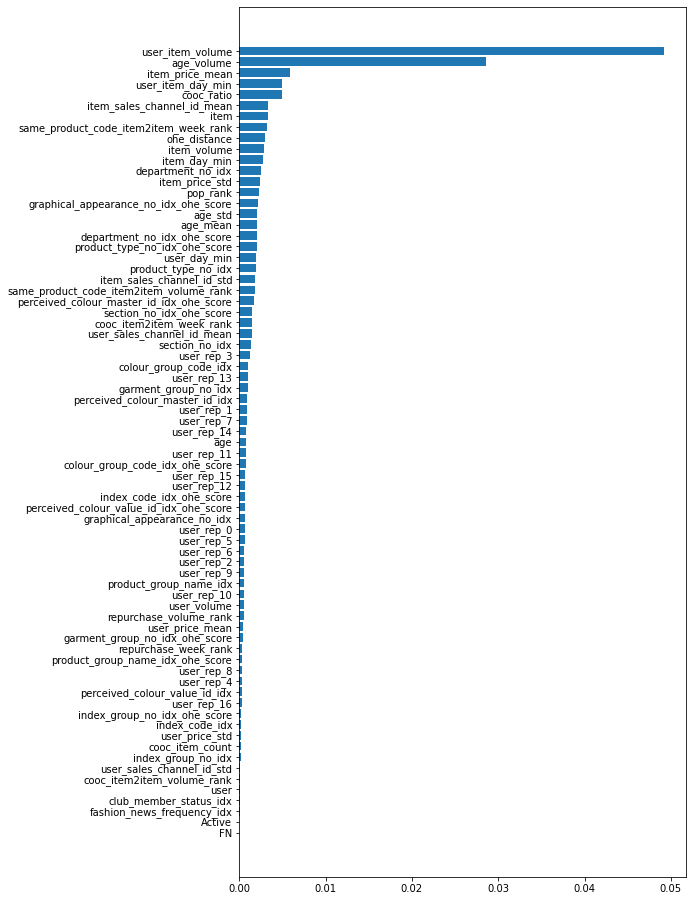

In [16]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [17]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.034888997570934326


In [18]:
# assert False

submission

In [19]:
datasets = joblib.Parallel(n_jobs=-1)(joblib.delayed(attach_features)(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates)))

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

0:	total: 4.2s	remaining: 5h 48m 34s


1:	total: 7.98s	remaining: 5h 31m 24s


2:	total: 11.7s	remaining: 5h 24m 13s


3:	total: 15.5s	remaining: 5h 21m 46s


4:	total: 19.2s	remaining: 5h 19m 22s


5:	total: 23s	remaining: 5h 17m 39s


6:	total: 26.7s	remaining: 5h 16m 32s


7:	total: 30.5s	remaining: 5h 15m 49s


8:	total: 34.2s	remaining: 5h 15m 18s


9:	total: 38s	remaining: 5h 14m 47s


10:	total: 41.8s	remaining: 5h 15m 4s


11:	total: 45.6s	remaining: 5h 14m 30s


12:	total: 49.3s	remaining: 5h 14m 14s


13:	total: 53.1s	remaining: 5h 13m 52s


14:	total: 56.8s	remaining: 5h 13m 38s


15:	total: 1m	remaining: 5h 13m 14s


16:	total: 1m 4s	remaining: 5h 12m 39s


17:	total: 1m 7s	remaining: 5h 12m 19s


18:	total: 1m 11s	remaining: 5h 11m 59s


19:	total: 1m 15s	remaining: 5h 11m 43s


20:	total: 1m 19s	remaining: 5h 11m 26s


21:	total: 1m 22s	remaining: 5h 11m 19s


22:	total: 1m 26s	remaining: 5h 11m 15s


23:	total: 1m 30s	remaining: 5h 11m 11s


24:	total: 1m 34s	remaining: 5h 10m 54s


25:	total: 1m 37s	remaining: 5h 10m 31s


26:	total: 1m 41s	remaining: 5h 10m 10s


27:	total: 1m 45s	remaining: 5h 9m 50s


28:	total: 1m 48s	remaining: 5h 9m 59s


29:	total: 1m 52s	remaining: 5h 9m 46s


30:	total: 1m 56s	remaining: 5h 9m 36s


31:	total: 2m	remaining: 5h 9m 39s


32:	total: 2m 3s	remaining: 5h 9m 26s


33:	total: 2m 7s	remaining: 5h 9m 15s


34:	total: 2m 11s	remaining: 5h 9m 20s


35:	total: 2m 15s	remaining: 5h 9m 12s


36:	total: 2m 18s	remaining: 5h 9m 15s


37:	total: 2m 22s	remaining: 5h 9m 26s


38:	total: 2m 26s	remaining: 5h 9m 35s


39:	total: 2m 30s	remaining: 5h 9m 40s


40:	total: 2m 34s	remaining: 5h 9m 49s


41:	total: 2m 38s	remaining: 5h 9m 54s


42:	total: 2m 41s	remaining: 5h 9m 36s


43:	total: 2m 45s	remaining: 5h 9m 47s


attach features (week: 1)
[user static fetaures] 0.773 s
[item stacic features] 1.828 s
[user dynamic features (transactions)] 3.683 s
[item dynamic features (transactions)] 1.590 s
[item dynamic features (user features)] 4.732 s
[item freshness features] 3.562 s
[item volume features] 2.119 s
[user freshness features] 5.140 s
[user volume features] 3.190 s
[user-item freshness features] 28.327 s
[user-item volume features] 5.673 s
[item age volume features] 3.118 s
[ohe dot products] 189.737 s
[lfm features] 6.163 s


44:	total: 2m 49s	remaining: 5h 9m 59s


45:	total: 2m 53s	remaining: 5h 9m 41s


46:	total: 2m 56s	remaining: 5h 9m 41s


attach features (week: 2)
[user static fetaures] 0.852 s
[item stacic features] 2.083 s
[user dynamic features (transactions)] 4.320 s
[item dynamic features (transactions)] 2.021 s
[item dynamic features (user features)] 5.439 s
[item freshness features] 4.161 s
[item volume features] 2.243 s
[user freshness features] 5.457 s
[user volume features] 3.634 s
[user-item freshness features] 27.385 s
[user-item volume features] 6.380 s
[item age volume features] 6.223 s
[ohe dot products] 186.678 s
[lfm features] 5.324 s


47:	total: 3m	remaining: 5h 10m 3s


48:	total: 3m 4s	remaining: 5h 9m 50s


49:	total: 3m 8s	remaining: 5h 9m 31s


50:	total: 3m 12s	remaining: 5h 9m 33s


attach features (week: 3)
[user static fetaures] 0.932 s
[item stacic features] 2.328 s
[user dynamic features (transactions)] 5.136 s
[item dynamic features (transactions)] 2.215 s
[item dynamic features (user features)] 5.574 s
[item freshness features] 4.231 s
[item volume features] 2.306 s
[user freshness features] 5.439 s
[user volume features] 3.438 s
[user-item freshness features] 32.212 s
[user-item volume features] 10.530 s
[item age volume features] 7.080 s
[ohe dot products] 179.567 s
[lfm features] 4.980 s


51:	total: 3m 15s	remaining: 5h 9m 36s


52:	total: 3m 19s	remaining: 5h 9m 37s


attach features (week: 4)
[user static fetaures] 1.268 s
[item stacic features] 2.411 s
[user dynamic features (transactions)] 5.087 s
[item dynamic features (transactions)] 2.605 s
[item dynamic features (user features)] 5.688 s
[item freshness features] 4.068 s
[item volume features] 2.170 s
[user freshness features] 5.340 s
[user volume features] 3.291 s
[user-item freshness features] 33.362 s
[user-item volume features] 20.332 s
[item age volume features] 8.087 s
[ohe dot products] 163.982 s
[lfm features] 4.818 s


53:	total: 3m 23s	remaining: 5h 9m 17s


54:	total: 3m 26s	remaining: 5h 8m 54s


55:	total: 3m 30s	remaining: 5h 8m 54s


56:	total: 3m 34s	remaining: 5h 8m 27s


57:	total: 3m 37s	remaining: 5h 8m 5s


58:	total: 3m 41s	remaining: 5h 8m 2s


59:	total: 3m 45s	remaining: 5h 7m 41s


60:	total: 3m 48s	remaining: 5h 7m 27s


61:	total: 3m 52s	remaining: 5h 7m 5s


62:	total: 3m 55s	remaining: 5h 7m 6s


63:	total: 3m 59s	remaining: 5h 6m 45s


64:	total: 4m 3s	remaining: 5h 6m 26s


65:	total: 4m 6s	remaining: 5h 6m 39s


66:	total: 4m 10s	remaining: 5h 6m 42s


67:	total: 4m 14s	remaining: 5h 6m 39s


68:	total: 4m 18s	remaining: 5h 6m 22s


69:	total: 4m 21s	remaining: 5h 6m 18s


70:	total: 4m 25s	remaining: 5h 6m 21s


71:	total: 4m 29s	remaining: 5h 6m 5s


72:	total: 4m 32s	remaining: 5h 6m


73:	total: 4m 36s	remaining: 5h 5m 50s


74:	total: 4m 40s	remaining: 5h 5m 50s


75:	total: 4m 43s	remaining: 5h 5m 35s


76:	total: 4m 47s	remaining: 5h 5m 19s


77:	total: 4m 51s	remaining: 5h 5m 15s


78:	total: 4m 54s	remaining: 5h 5m 3s


79:	total: 4m 58s	remaining: 5h 5m 11s


80:	total: 5m 2s	remaining: 5h 5m 7s


81:	total: 5m 6s	remaining: 5h 5m 12s


82:	total: 5m 10s	remaining: 5h 5m 12s


83:	total: 5m 14s	remaining: 5h 5m 13s


84:	total: 5m 17s	remaining: 5h 5m 16s


85:	total: 5m 21s	remaining: 5h 5m 6s


86:	total: 5m 25s	remaining: 5h 5m 7s


87:	total: 5m 29s	remaining: 5h 5m 2s


88:	total: 5m 32s	remaining: 5h 5m 3s


89:	total: 5m 36s	remaining: 5h 5m 10s


90:	total: 5m 40s	remaining: 5h 5m 9s


91:	total: 5m 44s	remaining: 5h 5m 1s


92:	total: 5m 47s	remaining: 5h 4m 56s


93:	total: 5m 51s	remaining: 5h 4m 44s


94:	total: 5m 55s	remaining: 5h 4m 29s


95:	total: 5m 58s	remaining: 5h 4m 32s


96:	total: 6m 2s	remaining: 5h 4m 32s


97:	total: 6m 6s	remaining: 5h 4m 30s


98:	total: 6m 10s	remaining: 5h 4m 31s


99:	total: 6m 14s	remaining: 5h 4m 29s


100:	total: 6m 17s	remaining: 5h 4m 28s


101:	total: 6m 21s	remaining: 5h 4m 29s


102:	total: 6m 25s	remaining: 5h 4m 31s


103:	total: 6m 29s	remaining: 5h 4m 27s


104:	total: 6m 32s	remaining: 5h 4m 13s


105:	total: 6m 36s	remaining: 5h 4m 15s


106:	total: 6m 40s	remaining: 5h 4m 19s


107:	total: 6m 44s	remaining: 5h 4m 17s


108:	total: 6m 48s	remaining: 5h 4m 14s


109:	total: 6m 51s	remaining: 5h 4m 10s


110:	total: 6m 55s	remaining: 5h 4m 5s


111:	total: 6m 59s	remaining: 5h 4m


112:	total: 7m 3s	remaining: 5h 3m 56s


113:	total: 7m 6s	remaining: 5h 3m 56s


114:	total: 7m 10s	remaining: 5h 3m 55s


115:	total: 7m 14s	remaining: 5h 3m 54s


116:	total: 7m 18s	remaining: 5h 3m 58s


117:	total: 7m 22s	remaining: 5h 3m 47s


118:	total: 7m 25s	remaining: 5h 3m 42s


119:	total: 7m 29s	remaining: 5h 3m 44s


120:	total: 7m 33s	remaining: 5h 3m 40s


121:	total: 7m 37s	remaining: 5h 3m 37s


122:	total: 7m 40s	remaining: 5h 3m 33s


123:	total: 7m 44s	remaining: 5h 3m 34s


124:	total: 7m 48s	remaining: 5h 3m 23s


125:	total: 7m 52s	remaining: 5h 3m 30s


126:	total: 7m 56s	remaining: 5h 3m 29s


127:	total: 7m 59s	remaining: 5h 3m 18s


128:	total: 8m 3s	remaining: 5h 3m 14s


129:	total: 8m 7s	remaining: 5h 3m 13s


130:	total: 8m 10s	remaining: 5h 3m 2s


131:	total: 8m 14s	remaining: 5h 3m 3s


132:	total: 8m 18s	remaining: 5h 2m 53s


133:	total: 8m 22s	remaining: 5h 2m 47s


134:	total: 8m 26s	remaining: 5h 2m 52s


135:	total: 8m 29s	remaining: 5h 2m 42s


136:	total: 8m 33s	remaining: 5h 2m 41s


137:	total: 8m 37s	remaining: 5h 2m 31s


138:	total: 8m 40s	remaining: 5h 2m 32s


139:	total: 8m 44s	remaining: 5h 2m 21s


140:	total: 8m 47s	remaining: 5h 2m 5s


141:	total: 8m 51s	remaining: 5h 1m 58s


142:	total: 8m 55s	remaining: 5h 1m 52s


143:	total: 8m 58s	remaining: 5h 1m 46s


144:	total: 9m 2s	remaining: 5h 1m 42s


145:	total: 9m 6s	remaining: 5h 1m 35s


146:	total: 9m 9s	remaining: 5h 1m 27s


147:	total: 9m 13s	remaining: 5h 1m 19s


148:	total: 9m 17s	remaining: 5h 1m 15s


149:	total: 9m 20s	remaining: 5h 1m 13s


150:	total: 9m 24s	remaining: 5h 1m 6s


151:	total: 9m 28s	remaining: 5h 57s


152:	total: 9m 32s	remaining: 5h 57s


153:	total: 9m 35s	remaining: 5h 48s


154:	total: 9m 39s	remaining: 5h 46s


155:	total: 9m 42s	remaining: 5h 34s


156:	total: 9m 46s	remaining: 5h 32s


157:	total: 9m 50s	remaining: 5h 25s


158:	total: 9m 53s	remaining: 5h 20s


159:	total: 9m 57s	remaining: 5h 15s


160:	total: 10m 1s	remaining: 5h 1s


161:	total: 10m 5s	remaining: 5h 6s


162:	total: 10m 8s	remaining: 4h 59m 55s


163:	total: 10m 12s	remaining: 4h 59m 47s


164:	total: 10m 15s	remaining: 4h 59m 45s


165:	total: 10m 19s	remaining: 4h 59m 33s


166:	total: 10m 22s	remaining: 4h 59m 26s


167:	total: 10m 26s	remaining: 4h 59m 26s


168:	total: 10m 30s	remaining: 4h 59m 22s


169:	total: 10m 34s	remaining: 4h 59m 18s


170:	total: 10m 38s	remaining: 4h 59m 18s


171:	total: 10m 41s	remaining: 4h 59m 6s


172:	total: 10m 45s	remaining: 4h 58m 54s


173:	total: 10m 48s	remaining: 4h 58m 45s


174:	total: 10m 52s	remaining: 4h 58m 47s


175:	total: 10m 56s	remaining: 4h 58m 40s


176:	total: 11m	remaining: 4h 58m 41s


177:	total: 11m 3s	remaining: 4h 58m 35s


178:	total: 11m 7s	remaining: 4h 58m 25s


179:	total: 11m 10s	remaining: 4h 58m 17s


180:	total: 11m 14s	remaining: 4h 58m 11s


181:	total: 11m 17s	remaining: 4h 58m 2s


182:	total: 11m 21s	remaining: 4h 57m 57s


183:	total: 11m 25s	remaining: 4h 57m 50s


184:	total: 11m 28s	remaining: 4h 57m 46s


185:	total: 11m 32s	remaining: 4h 57m 38s


186:	total: 11m 36s	remaining: 4h 57m 36s


187:	total: 11m 40s	remaining: 4h 57m 35s


188:	total: 11m 43s	remaining: 4h 57m 26s


189:	total: 11m 47s	remaining: 4h 57m 18s


190:	total: 11m 50s	remaining: 4h 57m 16s


191:	total: 11m 54s	remaining: 4h 57m 12s


192:	total: 11m 58s	remaining: 4h 57m 5s


193:	total: 12m 2s	remaining: 4h 57m 7s


194:	total: 12m 5s	remaining: 4h 57m 3s


195:	total: 12m 9s	remaining: 4h 56m 58s


196:	total: 12m 13s	remaining: 4h 57m 2s


197:	total: 12m 17s	remaining: 4h 57m 1s


198:	total: 12m 21s	remaining: 4h 56m 54s


199:	total: 12m 24s	remaining: 4h 56m 48s


200:	total: 12m 28s	remaining: 4h 56m 48s


201:	total: 12m 32s	remaining: 4h 56m 48s


202:	total: 12m 35s	remaining: 4h 56m 40s


203:	total: 12m 39s	remaining: 4h 56m 33s


204:	total: 12m 43s	remaining: 4h 56m 28s


205:	total: 12m 46s	remaining: 4h 56m 21s


206:	total: 12m 50s	remaining: 4h 56m 21s


207:	total: 12m 54s	remaining: 4h 56m 9s


208:	total: 12m 57s	remaining: 4h 56m 3s


209:	total: 13m 1s	remaining: 4h 56m 2s


210:	total: 13m 5s	remaining: 4h 55m 58s


211:	total: 13m 8s	remaining: 4h 55m 50s


212:	total: 13m 12s	remaining: 4h 55m 42s


213:	total: 13m 15s	remaining: 4h 55m 35s


214:	total: 13m 19s	remaining: 4h 55m 28s


215:	total: 13m 22s	remaining: 4h 55m 16s


216:	total: 13m 26s	remaining: 4h 55m 15s


217:	total: 13m 30s	remaining: 4h 55m 8s


218:	total: 13m 34s	remaining: 4h 55m 10s


219:	total: 13m 37s	remaining: 4h 55m 1s


220:	total: 13m 41s	remaining: 4h 54m 57s


221:	total: 13m 45s	remaining: 4h 54m 57s


222:	total: 13m 49s	remaining: 4h 54m 57s


223:	total: 13m 52s	remaining: 4h 54m 50s


224:	total: 13m 56s	remaining: 4h 54m 49s


225:	total: 14m	remaining: 4h 54m 49s


226:	total: 14m 4s	remaining: 4h 54m 45s


227:	total: 14m 7s	remaining: 4h 54m 40s


228:	total: 14m 11s	remaining: 4h 54m 34s


229:	total: 14m 15s	remaining: 4h 54m 32s


230:	total: 14m 19s	remaining: 4h 54m 31s


231:	total: 14m 22s	remaining: 4h 54m 26s


232:	total: 14m 26s	remaining: 4h 54m 20s


233:	total: 14m 29s	remaining: 4h 54m 14s


234:	total: 14m 33s	remaining: 4h 54m 5s


235:	total: 14m 37s	remaining: 4h 54m 2s


236:	total: 14m 40s	remaining: 4h 53m 56s


237:	total: 14m 44s	remaining: 4h 53m 53s


238:	total: 14m 48s	remaining: 4h 53m 48s


239:	total: 14m 51s	remaining: 4h 53m 44s


240:	total: 14m 55s	remaining: 4h 53m 37s


241:	total: 14m 58s	remaining: 4h 53m 30s


242:	total: 15m 2s	remaining: 4h 53m 25s


243:	total: 15m 6s	remaining: 4h 53m 26s


244:	total: 15m 9s	remaining: 4h 53m 17s


245:	total: 15m 13s	remaining: 4h 53m 9s


246:	total: 15m 17s	remaining: 4h 53m 4s


247:	total: 15m 20s	remaining: 4h 53m 1s


248:	total: 15m 24s	remaining: 4h 52m 55s


249:	total: 15m 27s	remaining: 4h 52m 48s


250:	total: 15m 31s	remaining: 4h 52m 41s


251:	total: 15m 35s	remaining: 4h 52m 38s


252:	total: 15m 38s	remaining: 4h 52m 31s


253:	total: 15m 42s	remaining: 4h 52m 28s


254:	total: 15m 46s	remaining: 4h 52m 21s


255:	total: 15m 49s	remaining: 4h 52m 14s


256:	total: 15m 53s	remaining: 4h 52m 8s


257:	total: 15m 57s	remaining: 4h 52m 6s


258:	total: 16m	remaining: 4h 52m 4s


259:	total: 16m 4s	remaining: 4h 51m 59s


260:	total: 16m 8s	remaining: 4h 51m 55s


261:	total: 16m 11s	remaining: 4h 51m 48s


262:	total: 16m 15s	remaining: 4h 51m 45s


263:	total: 16m 18s	remaining: 4h 51m 38s


264:	total: 16m 22s	remaining: 4h 51m 32s


265:	total: 16m 26s	remaining: 4h 51m 28s


266:	total: 16m 29s	remaining: 4h 51m 23s


267:	total: 16m 33s	remaining: 4h 51m 23s


268:	total: 16m 37s	remaining: 4h 51m 20s


269:	total: 16m 41s	remaining: 4h 51m 19s


270:	total: 16m 45s	remaining: 4h 51m 18s


271:	total: 16m 49s	remaining: 4h 51m 17s


272:	total: 16m 52s	remaining: 4h 51m 11s


273:	total: 16m 56s	remaining: 4h 51m 4s


274:	total: 16m 59s	remaining: 4h 50m 59s


275:	total: 17m 3s	remaining: 4h 50m 52s


276:	total: 17m 6s	remaining: 4h 50m 47s


277:	total: 17m 10s	remaining: 4h 50m 43s


278:	total: 17m 14s	remaining: 4h 50m 43s


279:	total: 17m 18s	remaining: 4h 50m 36s


280:	total: 17m 21s	remaining: 4h 50m 33s


281:	total: 17m 25s	remaining: 4h 50m 31s


282:	total: 17m 29s	remaining: 4h 50m 25s


283:	total: 17m 33s	remaining: 4h 50m 23s


284:	total: 17m 36s	remaining: 4h 50m 17s


285:	total: 17m 40s	remaining: 4h 50m 13s


286:	total: 17m 44s	remaining: 4h 50m 10s


287:	total: 17m 47s	remaining: 4h 50m 3s


288:	total: 17m 51s	remaining: 4h 49m 58s


289:	total: 17m 54s	remaining: 4h 49m 52s


290:	total: 17m 58s	remaining: 4h 49m 47s


291:	total: 18m 1s	remaining: 4h 49m 41s


292:	total: 18m 5s	remaining: 4h 49m 35s


293:	total: 18m 9s	remaining: 4h 49m 29s


294:	total: 18m 12s	remaining: 4h 49m 26s


295:	total: 18m 16s	remaining: 4h 49m 26s


296:	total: 18m 20s	remaining: 4h 49m 26s


297:	total: 18m 24s	remaining: 4h 49m 25s


298:	total: 18m 28s	remaining: 4h 49m 23s


299:	total: 18m 32s	remaining: 4h 49m 21s


300:	total: 18m 36s	remaining: 4h 49m 20s


301:	total: 18m 39s	remaining: 4h 49m 16s


302:	total: 18m 43s	remaining: 4h 49m 15s


303:	total: 18m 47s	remaining: 4h 49m 10s


304:	total: 18m 50s	remaining: 4h 49m 6s


305:	total: 18m 54s	remaining: 4h 49m 2s


306:	total: 18m 58s	remaining: 4h 48m 58s


307:	total: 19m 1s	remaining: 4h 48m 50s


308:	total: 19m 5s	remaining: 4h 48m 45s


309:	total: 19m 9s	remaining: 4h 48m 41s


310:	total: 19m 12s	remaining: 4h 48m 36s


311:	total: 19m 16s	remaining: 4h 48m 28s


312:	total: 19m 19s	remaining: 4h 48m 26s


313:	total: 19m 23s	remaining: 4h 48m 20s


314:	total: 19m 27s	remaining: 4h 48m 17s


315:	total: 19m 30s	remaining: 4h 48m 13s


316:	total: 19m 34s	remaining: 4h 48m 10s


317:	total: 19m 38s	remaining: 4h 48m 5s


318:	total: 19m 41s	remaining: 4h 48m


319:	total: 19m 45s	remaining: 4h 47m 52s


320:	total: 19m 48s	remaining: 4h 47m 46s


321:	total: 19m 52s	remaining: 4h 47m 39s


322:	total: 19m 55s	remaining: 4h 47m 34s


323:	total: 19m 59s	remaining: 4h 47m 29s


324:	total: 20m 2s	remaining: 4h 47m 21s


325:	total: 20m 6s	remaining: 4h 47m 16s


326:	total: 20m 10s	remaining: 4h 47m 15s


327:	total: 20m 14s	remaining: 4h 47m 9s


328:	total: 20m 17s	remaining: 4h 47m 4s


329:	total: 20m 21s	remaining: 4h 46m 59s


330:	total: 20m 25s	remaining: 4h 46m 58s


331:	total: 20m 28s	remaining: 4h 46m 53s


332:	total: 20m 32s	remaining: 4h 46m 49s


333:	total: 20m 35s	remaining: 4h 46m 42s


334:	total: 20m 39s	remaining: 4h 46m 40s


335:	total: 20m 43s	remaining: 4h 46m 34s


336:	total: 20m 46s	remaining: 4h 46m 30s


337:	total: 20m 50s	remaining: 4h 46m 24s


338:	total: 20m 54s	remaining: 4h 46m 27s


339:	total: 20m 58s	remaining: 4h 46m 27s


340:	total: 21m 2s	remaining: 4h 46m 27s


341:	total: 21m 6s	remaining: 4h 46m 27s


342:	total: 21m 10s	remaining: 4h 46m 24s


343:	total: 21m 13s	remaining: 4h 46m 20s


344:	total: 21m 17s	remaining: 4h 46m 15s


345:	total: 21m 21s	remaining: 4h 46m 9s


346:	total: 21m 24s	remaining: 4h 46m 1s


347:	total: 21m 28s	remaining: 4h 45m 56s


348:	total: 21m 31s	remaining: 4h 45m 50s


349:	total: 21m 35s	remaining: 4h 45m 43s


350:	total: 21m 38s	remaining: 4h 45m 37s


351:	total: 21m 42s	remaining: 4h 45m 37s


352:	total: 21m 46s	remaining: 4h 45m 36s


353:	total: 21m 50s	remaining: 4h 45m 34s


354:	total: 21m 54s	remaining: 4h 45m 30s


355:	total: 21m 57s	remaining: 4h 45m 23s


356:	total: 22m 1s	remaining: 4h 45m 18s


357:	total: 22m 4s	remaining: 4h 45m 14s


358:	total: 22m 8s	remaining: 4h 45m 8s


359:	total: 22m 12s	remaining: 4h 45m 5s


360:	total: 22m 15s	remaining: 4h 44m 59s


361:	total: 22m 19s	remaining: 4h 44m 54s


362:	total: 22m 22s	remaining: 4h 44m 52s


363:	total: 22m 26s	remaining: 4h 44m 46s


364:	total: 22m 30s	remaining: 4h 44m 40s


365:	total: 22m 33s	remaining: 4h 44m 35s


366:	total: 22m 37s	remaining: 4h 44m 29s


367:	total: 22m 40s	remaining: 4h 44m 26s


368:	total: 22m 44s	remaining: 4h 44m 19s


369:	total: 22m 47s	remaining: 4h 44m 14s


370:	total: 22m 51s	remaining: 4h 44m 9s


371:	total: 22m 55s	remaining: 4h 44m 3s


372:	total: 22m 58s	remaining: 4h 44m


373:	total: 23m 2s	remaining: 4h 43m 57s


374:	total: 23m 6s	remaining: 4h 43m 53s


375:	total: 23m 9s	remaining: 4h 43m 48s


376:	total: 23m 13s	remaining: 4h 43m 45s


377:	total: 23m 16s	remaining: 4h 43m 38s


378:	total: 23m 20s	remaining: 4h 43m 30s


379:	total: 23m 23s	remaining: 4h 43m 25s


380:	total: 23m 27s	remaining: 4h 43m 18s


381:	total: 23m 30s	remaining: 4h 43m 11s


382:	total: 23m 34s	remaining: 4h 43m 9s


383:	total: 23m 38s	remaining: 4h 43m 5s


384:	total: 23m 41s	remaining: 4h 43m 2s


385:	total: 23m 45s	remaining: 4h 42m 57s


386:	total: 23m 49s	remaining: 4h 42m 53s


387:	total: 23m 52s	remaining: 4h 42m 47s


388:	total: 23m 56s	remaining: 4h 42m 45s


389:	total: 23m 59s	remaining: 4h 42m 38s


390:	total: 24m 3s	remaining: 4h 42m 35s


391:	total: 24m 7s	remaining: 4h 42m 30s


392:	total: 24m 10s	remaining: 4h 42m 26s


393:	total: 24m 14s	remaining: 4h 42m 22s


394:	total: 24m 18s	remaining: 4h 42m 16s


395:	total: 24m 21s	remaining: 4h 42m 14s


396:	total: 24m 25s	remaining: 4h 42m 8s


397:	total: 24m 28s	remaining: 4h 42m 2s


398:	total: 24m 32s	remaining: 4h 41m 58s


399:	total: 24m 36s	remaining: 4h 41m 56s


400:	total: 24m 40s	remaining: 4h 41m 53s


401:	total: 24m 43s	remaining: 4h 41m 47s


402:	total: 24m 47s	remaining: 4h 41m 43s


403:	total: 24m 50s	remaining: 4h 41m 38s


404:	total: 24m 54s	remaining: 4h 41m 33s


405:	total: 24m 58s	remaining: 4h 41m 28s


406:	total: 25m 1s	remaining: 4h 41m 22s


407:	total: 25m 5s	remaining: 4h 41m 17s


408:	total: 25m 8s	remaining: 4h 41m 13s


409:	total: 25m 12s	remaining: 4h 41m 9s


410:	total: 25m 16s	remaining: 4h 41m 4s


411:	total: 25m 19s	remaining: 4h 41m 2s


412:	total: 25m 23s	remaining: 4h 41m


413:	total: 25m 27s	remaining: 4h 40m 54s


414:	total: 25m 30s	remaining: 4h 40m 48s


415:	total: 25m 34s	remaining: 4h 40m 42s


416:	total: 25m 37s	remaining: 4h 40m 40s


417:	total: 25m 41s	remaining: 4h 40m 38s


418:	total: 25m 45s	remaining: 4h 40m 35s


419:	total: 25m 49s	remaining: 4h 40m 31s


420:	total: 25m 52s	remaining: 4h 40m 27s


421:	total: 25m 56s	remaining: 4h 40m 23s


422:	total: 26m	remaining: 4h 40m 17s


423:	total: 26m 3s	remaining: 4h 40m 14s


424:	total: 26m 7s	remaining: 4h 40m 7s


425:	total: 26m 10s	remaining: 4h 39m 58s


426:	total: 26m 14s	remaining: 4h 39m 54s


427:	total: 26m 17s	remaining: 4h 39m 47s


428:	total: 26m 21s	remaining: 4h 39m 42s


429:	total: 26m 24s	remaining: 4h 39m 35s


430:	total: 26m 27s	remaining: 4h 39m 31s


431:	total: 26m 31s	remaining: 4h 39m 22s


432:	total: 26m 34s	remaining: 4h 39m 18s


433:	total: 26m 38s	remaining: 4h 39m 13s


434:	total: 26m 41s	remaining: 4h 39m 8s


435:	total: 26m 45s	remaining: 4h 39m 3s


436:	total: 26m 49s	remaining: 4h 38m 59s


437:	total: 26m 52s	remaining: 4h 38m 52s


438:	total: 26m 56s	remaining: 4h 38m 48s


439:	total: 26m 59s	remaining: 4h 38m 45s


440:	total: 27m 3s	remaining: 4h 38m 41s


441:	total: 27m 7s	remaining: 4h 38m 36s


442:	total: 27m 10s	remaining: 4h 38m 32s


443:	total: 27m 14s	remaining: 4h 38m 24s


444:	total: 27m 17s	remaining: 4h 38m 18s


445:	total: 27m 21s	remaining: 4h 38m 16s


446:	total: 27m 25s	remaining: 4h 38m 13s


447:	total: 27m 28s	remaining: 4h 38m 9s


448:	total: 27m 31s	remaining: 4h 38m 1s


449:	total: 27m 35s	remaining: 4h 37m 56s


450:	total: 27m 38s	remaining: 4h 37m 50s


451:	total: 27m 42s	remaining: 4h 37m 46s


452:	total: 27m 46s	remaining: 4h 37m 41s


453:	total: 27m 49s	remaining: 4h 37m 37s


454:	total: 27m 53s	remaining: 4h 37m 31s


455:	total: 27m 56s	remaining: 4h 37m 24s


456:	total: 28m	remaining: 4h 37m 22s


457:	total: 28m 3s	remaining: 4h 37m 17s


458:	total: 28m 7s	remaining: 4h 37m 12s


459:	total: 28m 10s	remaining: 4h 37m 5s


460:	total: 28m 14s	remaining: 4h 36m 59s


461:	total: 28m 17s	remaining: 4h 36m 54s


462:	total: 28m 21s	remaining: 4h 36m 50s


463:	total: 28m 24s	remaining: 4h 36m 45s


464:	total: 28m 28s	remaining: 4h 36m 39s


465:	total: 28m 32s	remaining: 4h 36m 34s


466:	total: 28m 35s	remaining: 4h 36m 28s


467:	total: 28m 38s	remaining: 4h 36m 23s


468:	total: 28m 42s	remaining: 4h 36m 19s


469:	total: 28m 46s	remaining: 4h 36m 14s


470:	total: 28m 49s	remaining: 4h 36m 9s


471:	total: 28m 53s	remaining: 4h 36m 4s


472:	total: 28m 56s	remaining: 4h 35m 59s


473:	total: 29m	remaining: 4h 35m 53s


474:	total: 29m 3s	remaining: 4h 35m 50s


475:	total: 29m 7s	remaining: 4h 35m 47s


476:	total: 29m 11s	remaining: 4h 35m 44s


477:	total: 29m 14s	remaining: 4h 35m 40s


478:	total: 29m 18s	remaining: 4h 35m 36s


479:	total: 29m 22s	remaining: 4h 35m 32s


480:	total: 29m 25s	remaining: 4h 35m 26s


481:	total: 29m 29s	remaining: 4h 35m 23s


482:	total: 29m 32s	remaining: 4h 35m 17s


483:	total: 29m 36s	remaining: 4h 35m 12s


484:	total: 29m 40s	remaining: 4h 35m 10s


485:	total: 29m 44s	remaining: 4h 35m 9s


486:	total: 29m 48s	remaining: 4h 35m 7s


487:	total: 29m 51s	remaining: 4h 35m 3s


488:	total: 29m 55s	remaining: 4h 34m 58s


489:	total: 29m 58s	remaining: 4h 34m 54s


490:	total: 30m 2s	remaining: 4h 34m 50s


491:	total: 30m 6s	remaining: 4h 34m 47s


492:	total: 30m 9s	remaining: 4h 34m 42s


493:	total: 30m 13s	remaining: 4h 34m 35s


494:	total: 30m 16s	remaining: 4h 34m 32s


495:	total: 30m 20s	remaining: 4h 34m 27s


496:	total: 30m 23s	remaining: 4h 34m 21s


497:	total: 30m 27s	remaining: 4h 34m 18s


498:	total: 30m 31s	remaining: 4h 34m 14s


499:	total: 30m 34s	remaining: 4h 34m 10s


500:	total: 30m 38s	remaining: 4h 34m 9s


501:	total: 30m 42s	remaining: 4h 34m 2s


502:	total: 30m 45s	remaining: 4h 33m 57s


503:	total: 30m 49s	remaining: 4h 33m 53s


504:	total: 30m 52s	remaining: 4h 33m 48s


505:	total: 30m 56s	remaining: 4h 33m 44s


506:	total: 31m	remaining: 4h 33m 43s


507:	total: 31m 3s	remaining: 4h 33m 37s


508:	total: 31m 7s	remaining: 4h 33m 32s


509:	total: 31m 10s	remaining: 4h 33m 28s


510:	total: 31m 14s	remaining: 4h 33m 23s


511:	total: 31m 18s	remaining: 4h 33m 19s


512:	total: 31m 21s	remaining: 4h 33m 15s


513:	total: 31m 25s	remaining: 4h 33m 11s


514:	total: 31m 28s	remaining: 4h 33m 8s


515:	total: 31m 32s	remaining: 4h 33m 4s


516:	total: 31m 36s	remaining: 4h 33m 1s


517:	total: 31m 39s	remaining: 4h 32m 56s


518:	total: 31m 43s	remaining: 4h 32m 50s


519:	total: 31m 46s	remaining: 4h 32m 47s


520:	total: 31m 50s	remaining: 4h 32m 42s


521:	total: 31m 54s	remaining: 4h 32m 38s


522:	total: 31m 57s	remaining: 4h 32m 33s


523:	total: 32m 1s	remaining: 4h 32m 27s


524:	total: 32m 4s	remaining: 4h 32m 21s


525:	total: 32m 7s	remaining: 4h 32m 13s


526:	total: 32m 11s	remaining: 4h 32m 11s


527:	total: 32m 15s	remaining: 4h 32m 7s


528:	total: 32m 18s	remaining: 4h 32m 1s


529:	total: 32m 22s	remaining: 4h 31m 57s


530:	total: 32m 25s	remaining: 4h 31m 52s


531:	total: 32m 29s	remaining: 4h 31m 48s


532:	total: 32m 32s	remaining: 4h 31m 41s


533:	total: 32m 36s	remaining: 4h 31m 37s


534:	total: 32m 39s	remaining: 4h 31m 31s


535:	total: 32m 43s	remaining: 4h 31m 26s


536:	total: 32m 46s	remaining: 4h 31m 23s


537:	total: 32m 50s	remaining: 4h 31m 20s


538:	total: 32m 53s	remaining: 4h 31m 14s


539:	total: 32m 57s	remaining: 4h 31m 10s


540:	total: 33m 1s	remaining: 4h 31m 7s


541:	total: 33m 4s	remaining: 4h 31m 2s


542:	total: 33m 8s	remaining: 4h 30m 58s


543:	total: 33m 12s	remaining: 4h 30m 54s


544:	total: 33m 15s	remaining: 4h 30m 48s


545:	total: 33m 18s	remaining: 4h 30m 43s


546:	total: 33m 22s	remaining: 4h 30m 40s


547:	total: 33m 26s	remaining: 4h 30m 38s


548:	total: 33m 30s	remaining: 4h 30m 34s


549:	total: 33m 33s	remaining: 4h 30m 31s


550:	total: 33m 37s	remaining: 4h 30m 27s


551:	total: 33m 41s	remaining: 4h 30m 23s


552:	total: 33m 44s	remaining: 4h 30m 19s


553:	total: 33m 48s	remaining: 4h 30m 15s


554:	total: 33m 51s	remaining: 4h 30m 11s


555:	total: 33m 55s	remaining: 4h 30m 7s


556:	total: 33m 59s	remaining: 4h 30m 4s


557:	total: 34m 2s	remaining: 4h 29m 57s


558:	total: 34m 6s	remaining: 4h 29m 53s


559:	total: 34m 9s	remaining: 4h 29m 49s


560:	total: 34m 13s	remaining: 4h 29m 45s


561:	total: 34m 16s	remaining: 4h 29m 38s


562:	total: 34m 20s	remaining: 4h 29m 36s


563:	total: 34m 23s	remaining: 4h 29m 30s


564:	total: 34m 27s	remaining: 4h 29m 25s


565:	total: 34m 30s	remaining: 4h 29m 20s


566:	total: 34m 34s	remaining: 4h 29m 17s


567:	total: 34m 37s	remaining: 4h 29m 11s


568:	total: 34m 41s	remaining: 4h 29m 7s


569:	total: 34m 44s	remaining: 4h 29m 1s


570:	total: 34m 48s	remaining: 4h 28m 58s


571:	total: 34m 52s	remaining: 4h 28m 53s


572:	total: 34m 55s	remaining: 4h 28m 49s


573:	total: 34m 59s	remaining: 4h 28m 46s


574:	total: 35m 2s	remaining: 4h 28m 41s


575:	total: 35m 6s	remaining: 4h 28m 39s


576:	total: 35m 10s	remaining: 4h 28m 36s


577:	total: 35m 14s	remaining: 4h 28m 32s


578:	total: 35m 17s	remaining: 4h 28m 29s


579:	total: 35m 21s	remaining: 4h 28m 25s


580:	total: 35m 25s	remaining: 4h 28m 22s


581:	total: 35m 28s	remaining: 4h 28m 16s


582:	total: 35m 32s	remaining: 4h 28m 11s


583:	total: 35m 35s	remaining: 4h 28m 9s


584:	total: 35m 39s	remaining: 4h 28m 4s


585:	total: 35m 43s	remaining: 4h 28m


586:	total: 35m 46s	remaining: 4h 27m 57s


587:	total: 35m 50s	remaining: 4h 27m 53s


588:	total: 35m 53s	remaining: 4h 27m 48s


589:	total: 35m 57s	remaining: 4h 27m 44s


590:	total: 36m 1s	remaining: 4h 27m 39s


591:	total: 36m 4s	remaining: 4h 27m 34s


592:	total: 36m 8s	remaining: 4h 27m 31s


593:	total: 36m 11s	remaining: 4h 27m 26s


594:	total: 36m 15s	remaining: 4h 27m 22s


595:	total: 36m 18s	remaining: 4h 27m 18s


596:	total: 36m 22s	remaining: 4h 27m 14s


597:	total: 36m 26s	remaining: 4h 27m 10s


598:	total: 36m 29s	remaining: 4h 27m 6s


599:	total: 36m 32s	remaining: 4h 26m 59s


600:	total: 36m 36s	remaining: 4h 26m 55s


601:	total: 36m 40s	remaining: 4h 26m 53s


602:	total: 36m 43s	remaining: 4h 26m 48s


603:	total: 36m 47s	remaining: 4h 26m 45s


604:	total: 36m 51s	remaining: 4h 26m 40s


605:	total: 36m 54s	remaining: 4h 26m 34s


606:	total: 36m 57s	remaining: 4h 26m 29s


607:	total: 37m 1s	remaining: 4h 26m 24s


608:	total: 37m 4s	remaining: 4h 26m 18s


609:	total: 37m 8s	remaining: 4h 26m 14s


610:	total: 37m 12s	remaining: 4h 26m 11s


611:	total: 37m 15s	remaining: 4h 26m 5s


612:	total: 37m 19s	remaining: 4h 26m 1s


613:	total: 37m 22s	remaining: 4h 25m 58s


614:	total: 37m 26s	remaining: 4h 25m 54s


615:	total: 37m 30s	remaining: 4h 25m 52s


616:	total: 37m 34s	remaining: 4h 25m 49s


617:	total: 37m 37s	remaining: 4h 25m 46s


618:	total: 37m 41s	remaining: 4h 25m 41s


619:	total: 37m 44s	remaining: 4h 25m 38s


620:	total: 37m 48s	remaining: 4h 25m 35s


621:	total: 37m 52s	remaining: 4h 25m 30s


622:	total: 37m 56s	remaining: 4h 25m 28s


623:	total: 37m 59s	remaining: 4h 25m 24s


624:	total: 38m 3s	remaining: 4h 25m 20s


625:	total: 38m 6s	remaining: 4h 25m 17s


626:	total: 38m 10s	remaining: 4h 25m 12s


627:	total: 38m 14s	remaining: 4h 25m 8s


628:	total: 38m 17s	remaining: 4h 25m 6s


629:	total: 38m 21s	remaining: 4h 25m 3s


630:	total: 38m 25s	remaining: 4h 24m 58s


631:	total: 38m 28s	remaining: 4h 24m 54s


632:	total: 38m 32s	remaining: 4h 24m 49s


633:	total: 38m 35s	remaining: 4h 24m 45s


634:	total: 38m 39s	remaining: 4h 24m 40s


635:	total: 38m 42s	remaining: 4h 24m 34s


636:	total: 38m 46s	remaining: 4h 24m 30s


637:	total: 38m 49s	remaining: 4h 24m 26s


638:	total: 38m 53s	remaining: 4h 24m 23s


639:	total: 38m 57s	remaining: 4h 24m 19s


640:	total: 39m	remaining: 4h 24m 14s


641:	total: 39m 4s	remaining: 4h 24m 10s


642:	total: 39m 8s	remaining: 4h 24m 8s


643:	total: 39m 11s	remaining: 4h 24m 6s


644:	total: 39m 15s	remaining: 4h 24m 3s


645:	total: 39m 19s	remaining: 4h 23m 59s


646:	total: 39m 23s	remaining: 4h 23m 57s


647:	total: 39m 26s	remaining: 4h 23m 52s


648:	total: 39m 30s	remaining: 4h 23m 48s


649:	total: 39m 33s	remaining: 4h 23m 43s


650:	total: 39m 37s	remaining: 4h 23m 39s


651:	total: 39m 40s	remaining: 4h 23m 33s


652:	total: 39m 44s	remaining: 4h 23m 29s


653:	total: 39m 47s	remaining: 4h 23m 24s


654:	total: 39m 51s	remaining: 4h 23m 20s


655:	total: 39m 54s	remaining: 4h 23m 15s


656:	total: 39m 58s	remaining: 4h 23m 11s


657:	total: 40m 2s	remaining: 4h 23m 8s


658:	total: 40m 5s	remaining: 4h 23m 3s


659:	total: 40m 9s	remaining: 4h 22m 59s


660:	total: 40m 12s	remaining: 4h 22m 54s


661:	total: 40m 16s	remaining: 4h 22m 50s


662:	total: 40m 19s	remaining: 4h 22m 46s


663:	total: 40m 23s	remaining: 4h 22m 40s


664:	total: 40m 26s	remaining: 4h 22m 36s


665:	total: 40m 30s	remaining: 4h 22m 32s


666:	total: 40m 33s	remaining: 4h 22m 27s


667:	total: 40m 37s	remaining: 4h 22m 23s


668:	total: 40m 40s	remaining: 4h 22m 20s


669:	total: 40m 44s	remaining: 4h 22m 15s


670:	total: 40m 48s	remaining: 4h 22m 12s


671:	total: 40m 51s	remaining: 4h 22m 7s


672:	total: 40m 55s	remaining: 4h 22m 3s


673:	total: 40m 58s	remaining: 4h 21m 59s


674:	total: 41m 2s	remaining: 4h 21m 54s


675:	total: 41m 5s	remaining: 4h 21m 50s


676:	total: 41m 9s	remaining: 4h 21m 45s


677:	total: 41m 12s	remaining: 4h 21m 41s


678:	total: 41m 16s	remaining: 4h 21m 36s


679:	total: 41m 19s	remaining: 4h 21m 30s


680:	total: 41m 23s	remaining: 4h 21m 26s


681:	total: 41m 26s	remaining: 4h 21m 22s


682:	total: 41m 30s	remaining: 4h 21m 19s


683:	total: 41m 34s	remaining: 4h 21m 15s


684:	total: 41m 37s	remaining: 4h 21m 10s


685:	total: 41m 41s	remaining: 4h 21m 7s


686:	total: 41m 45s	remaining: 4h 21m 4s


687:	total: 41m 48s	remaining: 4h 21m 1s


688:	total: 41m 52s	remaining: 4h 20m 58s


689:	total: 41m 55s	remaining: 4h 20m 53s


690:	total: 41m 59s	remaining: 4h 20m 48s


691:	total: 42m 3s	remaining: 4h 20m 44s


692:	total: 42m 7s	remaining: 4h 20m 43s


693:	total: 42m 10s	remaining: 4h 20m 39s


694:	total: 42m 14s	remaining: 4h 20m 35s


695:	total: 42m 17s	remaining: 4h 20m 30s


696:	total: 42m 21s	remaining: 4h 20m 26s


697:	total: 42m 24s	remaining: 4h 20m 21s


698:	total: 42m 28s	remaining: 4h 20m 16s


699:	total: 42m 31s	remaining: 4h 20m 11s


700:	total: 42m 34s	remaining: 4h 20m 5s


701:	total: 42m 38s	remaining: 4h 20m 1s


702:	total: 42m 41s	remaining: 4h 19m 56s


703:	total: 42m 45s	remaining: 4h 19m 54s


704:	total: 42m 49s	remaining: 4h 19m 49s


705:	total: 42m 52s	remaining: 4h 19m 46s


706:	total: 42m 56s	remaining: 4h 19m 41s


707:	total: 42m 59s	remaining: 4h 19m 38s


708:	total: 43m 3s	remaining: 4h 19m 33s


709:	total: 43m 7s	remaining: 4h 19m 29s


710:	total: 43m 10s	remaining: 4h 19m 25s


711:	total: 43m 14s	remaining: 4h 19m 21s


712:	total: 43m 18s	remaining: 4h 19m 19s


713:	total: 43m 21s	remaining: 4h 19m 16s


714:	total: 43m 25s	remaining: 4h 19m 10s


715:	total: 43m 28s	remaining: 4h 19m 8s


716:	total: 43m 32s	remaining: 4h 19m 3s


717:	total: 43m 35s	remaining: 4h 18m 59s


718:	total: 43m 39s	remaining: 4h 18m 54s


719:	total: 43m 42s	remaining: 4h 18m 49s


720:	total: 43m 46s	remaining: 4h 18m 44s


721:	total: 43m 49s	remaining: 4h 18m 41s


722:	total: 43m 53s	remaining: 4h 18m 36s


723:	total: 43m 56s	remaining: 4h 18m 32s


724:	total: 44m	remaining: 4h 18m 29s


725:	total: 44m 4s	remaining: 4h 18m 26s


726:	total: 44m 7s	remaining: 4h 18m 20s


727:	total: 44m 11s	remaining: 4h 18m 16s


728:	total: 44m 14s	remaining: 4h 18m 11s


729:	total: 44m 18s	remaining: 4h 18m 7s


730:	total: 44m 21s	remaining: 4h 18m 3s


731:	total: 44m 25s	remaining: 4h 17m 58s


732:	total: 44m 28s	remaining: 4h 17m 54s


733:	total: 44m 32s	remaining: 4h 17m 51s


734:	total: 44m 36s	remaining: 4h 17m 48s


735:	total: 44m 40s	remaining: 4h 17m 44s


736:	total: 44m 43s	remaining: 4h 17m 41s


737:	total: 44m 47s	remaining: 4h 17m 35s


738:	total: 44m 50s	remaining: 4h 17m 31s


739:	total: 44m 54s	remaining: 4h 17m 29s


740:	total: 44m 57s	remaining: 4h 17m 25s


741:	total: 45m 1s	remaining: 4h 17m 20s


742:	total: 45m 5s	remaining: 4h 17m 17s


743:	total: 45m 8s	remaining: 4h 17m 14s


744:	total: 45m 12s	remaining: 4h 17m 9s


745:	total: 45m 16s	remaining: 4h 17m 5s


746:	total: 45m 19s	remaining: 4h 17m


747:	total: 45m 22s	remaining: 4h 16m 56s


748:	total: 45m 26s	remaining: 4h 16m 52s


749:	total: 45m 29s	remaining: 4h 16m 47s


750:	total: 45m 33s	remaining: 4h 16m 43s


751:	total: 45m 36s	remaining: 4h 16m 39s


752:	total: 45m 40s	remaining: 4h 16m 35s


753:	total: 45m 44s	remaining: 4h 16m 32s


754:	total: 45m 47s	remaining: 4h 16m 26s


755:	total: 45m 51s	remaining: 4h 16m 23s


756:	total: 45m 54s	remaining: 4h 16m 19s


757:	total: 45m 58s	remaining: 4h 16m 15s


758:	total: 46m 1s	remaining: 4h 16m 11s


759:	total: 46m 5s	remaining: 4h 16m 6s


760:	total: 46m 8s	remaining: 4h 16m 2s


761:	total: 46m 12s	remaining: 4h 15m 58s


762:	total: 46m 16s	remaining: 4h 15m 55s


763:	total: 46m 19s	remaining: 4h 15m 51s


764:	total: 46m 23s	remaining: 4h 15m 46s


765:	total: 46m 27s	remaining: 4h 15m 43s


766:	total: 46m 30s	remaining: 4h 15m 40s


767:	total: 46m 34s	remaining: 4h 15m 35s


768:	total: 46m 38s	remaining: 4h 15m 32s


769:	total: 46m 41s	remaining: 4h 15m 28s


770:	total: 46m 45s	remaining: 4h 15m 23s


771:	total: 46m 48s	remaining: 4h 15m 20s


772:	total: 46m 52s	remaining: 4h 15m 16s


773:	total: 46m 55s	remaining: 4h 15m 12s


774:	total: 46m 59s	remaining: 4h 15m 7s


775:	total: 47m 2s	remaining: 4h 15m 3s


776:	total: 47m 6s	remaining: 4h 14m 59s


777:	total: 47m 9s	remaining: 4h 14m 55s


778:	total: 47m 13s	remaining: 4h 14m 51s


779:	total: 47m 17s	remaining: 4h 14m 47s


780:	total: 47m 20s	remaining: 4h 14m 43s


781:	total: 47m 24s	remaining: 4h 14m 39s


782:	total: 47m 27s	remaining: 4h 14m 33s


783:	total: 47m 31s	remaining: 4h 14m 29s


784:	total: 47m 34s	remaining: 4h 14m 24s


785:	total: 47m 37s	remaining: 4h 14m 20s


786:	total: 47m 41s	remaining: 4h 14m 15s


787:	total: 47m 45s	remaining: 4h 14m 12s


788:	total: 47m 48s	remaining: 4h 14m 8s


789:	total: 47m 52s	remaining: 4h 14m 4s


790:	total: 47m 55s	remaining: 4h 14m 1s


791:	total: 47m 59s	remaining: 4h 13m 56s


792:	total: 48m 3s	remaining: 4h 13m 53s


793:	total: 48m 6s	remaining: 4h 13m 48s


794:	total: 48m 9s	remaining: 4h 13m 44s


795:	total: 48m 13s	remaining: 4h 13m 41s


796:	total: 48m 17s	remaining: 4h 13m 38s


797:	total: 48m 21s	remaining: 4h 13m 35s


798:	total: 48m 24s	remaining: 4h 13m 31s


799:	total: 48m 28s	remaining: 4h 13m 27s


800:	total: 48m 32s	remaining: 4h 13m 24s


801:	total: 48m 35s	remaining: 4h 13m 19s


802:	total: 48m 39s	remaining: 4h 13m 15s


803:	total: 48m 42s	remaining: 4h 13m 11s


804:	total: 48m 46s	remaining: 4h 13m 8s


805:	total: 48m 50s	remaining: 4h 13m 4s


806:	total: 48m 53s	remaining: 4h 13m 1s


807:	total: 48m 57s	remaining: 4h 12m 59s


808:	total: 49m	remaining: 4h 12m 53s


809:	total: 49m 4s	remaining: 4h 12m 49s


810:	total: 49m 7s	remaining: 4h 12m 43s


811:	total: 49m 11s	remaining: 4h 12m 39s


812:	total: 49m 14s	remaining: 4h 12m 35s


813:	total: 49m 18s	remaining: 4h 12m 30s


814:	total: 49m 21s	remaining: 4h 12m 27s


815:	total: 49m 25s	remaining: 4h 12m 24s


816:	total: 49m 29s	remaining: 4h 12m 19s


817:	total: 49m 32s	remaining: 4h 12m 15s


818:	total: 49m 36s	remaining: 4h 12m 11s


819:	total: 49m 39s	remaining: 4h 12m 8s


820:	total: 49m 43s	remaining: 4h 12m 5s


821:	total: 49m 47s	remaining: 4h 12m


822:	total: 49m 50s	remaining: 4h 11m 57s


823:	total: 49m 54s	remaining: 4h 11m 54s


824:	total: 49m 58s	remaining: 4h 11m 50s


825:	total: 50m 2s	remaining: 4h 11m 48s


826:	total: 50m 5s	remaining: 4h 11m 44s


827:	total: 50m 9s	remaining: 4h 11m 40s


828:	total: 50m 12s	remaining: 4h 11m 36s


829:	total: 50m 16s	remaining: 4h 11m 31s


830:	total: 50m 19s	remaining: 4h 11m 27s


831:	total: 50m 23s	remaining: 4h 11m 25s


832:	total: 50m 27s	remaining: 4h 11m 20s


833:	total: 50m 30s	remaining: 4h 11m 16s


834:	total: 50m 33s	remaining: 4h 11m 11s


835:	total: 50m 37s	remaining: 4h 11m 8s


836:	total: 50m 41s	remaining: 4h 11m 5s


837:	total: 50m 44s	remaining: 4h 11m


838:	total: 50m 48s	remaining: 4h 10m 56s


839:	total: 50m 51s	remaining: 4h 10m 52s


840:	total: 50m 55s	remaining: 4h 10m 48s


841:	total: 50m 59s	remaining: 4h 10m 45s


842:	total: 51m 2s	remaining: 4h 10m 42s


843:	total: 51m 6s	remaining: 4h 10m 37s


844:	total: 51m 9s	remaining: 4h 10m 32s


845:	total: 51m 13s	remaining: 4h 10m 28s


846:	total: 51m 16s	remaining: 4h 10m 24s


847:	total: 51m 20s	remaining: 4h 10m 18s


848:	total: 51m 23s	remaining: 4h 10m 15s


849:	total: 51m 27s	remaining: 4h 10m 11s


850:	total: 51m 31s	remaining: 4h 10m 8s


851:	total: 51m 34s	remaining: 4h 10m 4s


852:	total: 51m 37s	remaining: 4h 9m 59s


853:	total: 51m 41s	remaining: 4h 9m 55s


854:	total: 51m 45s	remaining: 4h 9m 51s


855:	total: 51m 48s	remaining: 4h 9m 47s


856:	total: 51m 52s	remaining: 4h 9m 43s


857:	total: 51m 55s	remaining: 4h 9m 39s


858:	total: 51m 59s	remaining: 4h 9m 36s


859:	total: 52m 3s	remaining: 4h 9m 32s


860:	total: 52m 6s	remaining: 4h 9m 29s


861:	total: 52m 10s	remaining: 4h 9m 25s


862:	total: 52m 14s	remaining: 4h 9m 22s


863:	total: 52m 17s	remaining: 4h 9m 19s


864:	total: 52m 21s	remaining: 4h 9m 15s


865:	total: 52m 24s	remaining: 4h 9m 11s


866:	total: 52m 28s	remaining: 4h 9m 7s


867:	total: 52m 31s	remaining: 4h 9m 2s


868:	total: 52m 35s	remaining: 4h 8m 59s


869:	total: 52m 39s	remaining: 4h 8m 56s


870:	total: 52m 43s	remaining: 4h 8m 52s


871:	total: 52m 46s	remaining: 4h 8m 50s


872:	total: 52m 50s	remaining: 4h 8m 47s


873:	total: 52m 54s	remaining: 4h 8m 43s


874:	total: 52m 57s	remaining: 4h 8m 39s


875:	total: 53m 1s	remaining: 4h 8m 35s


876:	total: 53m 5s	remaining: 4h 8m 31s


877:	total: 53m 8s	remaining: 4h 8m 28s


878:	total: 53m 12s	remaining: 4h 8m 24s


879:	total: 53m 15s	remaining: 4h 8m 19s


880:	total: 53m 19s	remaining: 4h 8m 15s


881:	total: 53m 22s	remaining: 4h 8m 11s


882:	total: 53m 26s	remaining: 4h 8m 8s


883:	total: 53m 29s	remaining: 4h 8m 3s


884:	total: 53m 33s	remaining: 4h 8m 1s


885:	total: 53m 37s	remaining: 4h 7m 59s


886:	total: 53m 41s	remaining: 4h 7m 57s


887:	total: 53m 45s	remaining: 4h 7m 56s


888:	total: 53m 50s	remaining: 4h 7m 55s


889:	total: 53m 53s	remaining: 4h 7m 52s


890:	total: 53m 57s	remaining: 4h 7m 48s


891:	total: 54m 1s	remaining: 4h 7m 45s


892:	total: 54m 4s	remaining: 4h 7m 42s


893:	total: 54m 8s	remaining: 4h 7m 39s


894:	total: 54m 12s	remaining: 4h 7m 36s


895:	total: 54m 16s	remaining: 4h 7m 34s


896:	total: 54m 19s	remaining: 4h 7m 29s


897:	total: 54m 23s	remaining: 4h 7m 25s


898:	total: 54m 27s	remaining: 4h 7m 22s


899:	total: 54m 31s	remaining: 4h 7m 19s


900:	total: 54m 34s	remaining: 4h 7m 15s


901:	total: 54m 38s	remaining: 4h 7m 10s


902:	total: 54m 41s	remaining: 4h 7m 7s


903:	total: 54m 45s	remaining: 4h 7m 4s


904:	total: 54m 49s	remaining: 4h 7m 1s


905:	total: 54m 52s	remaining: 4h 6m 57s


906:	total: 54m 56s	remaining: 4h 6m 54s


907:	total: 55m	remaining: 4h 6m 52s


908:	total: 55m 4s	remaining: 4h 6m 48s


909:	total: 55m 7s	remaining: 4h 6m 45s


910:	total: 55m 11s	remaining: 4h 6m 41s


911:	total: 55m 15s	remaining: 4h 6m 40s


912:	total: 55m 19s	remaining: 4h 6m 36s


913:	total: 55m 22s	remaining: 4h 6m 32s


914:	total: 55m 26s	remaining: 4h 6m 30s


915:	total: 55m 30s	remaining: 4h 6m 27s


916:	total: 55m 34s	remaining: 4h 6m 24s


917:	total: 55m 38s	remaining: 4h 6m 21s


918:	total: 55m 41s	remaining: 4h 6m 17s


919:	total: 55m 45s	remaining: 4h 6m 13s


920:	total: 55m 49s	remaining: 4h 6m 10s


921:	total: 55m 52s	remaining: 4h 6m 6s


922:	total: 55m 56s	remaining: 4h 6m 4s


923:	total: 56m	remaining: 4h 6m 2s


924:	total: 56m 4s	remaining: 4h 6m 1s


925:	total: 56m 8s	remaining: 4h 5m 59s


926:	total: 56m 12s	remaining: 4h 5m 56s


927:	total: 56m 16s	remaining: 4h 5m 53s


928:	total: 56m 19s	remaining: 4h 5m 49s


929:	total: 56m 23s	remaining: 4h 5m 45s


930:	total: 56m 27s	remaining: 4h 5m 42s


931:	total: 56m 30s	remaining: 4h 5m 37s


932:	total: 56m 34s	remaining: 4h 5m 32s


933:	total: 56m 37s	remaining: 4h 5m 29s


934:	total: 56m 41s	remaining: 4h 5m 26s


935:	total: 56m 45s	remaining: 4h 5m 22s


936:	total: 56m 48s	remaining: 4h 5m 18s


937:	total: 56m 52s	remaining: 4h 5m 14s


938:	total: 56m 55s	remaining: 4h 5m 11s


939:	total: 56m 59s	remaining: 4h 5m 7s


940:	total: 57m 3s	remaining: 4h 5m 3s


941:	total: 57m 7s	remaining: 4h 5m 2s


942:	total: 57m 11s	remaining: 4h 4m 59s


943:	total: 57m 15s	remaining: 4h 4m 57s


944:	total: 57m 19s	remaining: 4h 4m 56s


945:	total: 57m 24s	remaining: 4h 4m 57s


946:	total: 57m 28s	remaining: 4h 4m 57s


947:	total: 57m 32s	remaining: 4h 4m 55s


948:	total: 57m 36s	remaining: 4h 4m 53s


949:	total: 57m 41s	remaining: 4h 4m 54s


950:	total: 57m 46s	remaining: 4h 4m 55s


951:	total: 57m 52s	remaining: 4h 5m 1s


952:	total: 57m 55s	remaining: 4h 4m 57s


953:	total: 57m 59s	remaining: 4h 4m 55s


954:	total: 58m 3s	remaining: 4h 4m 52s


955:	total: 58m 6s	remaining: 4h 4m 48s


956:	total: 58m 10s	remaining: 4h 4m 43s


957:	total: 58m 14s	remaining: 4h 4m 40s


958:	total: 58m 18s	remaining: 4h 4m 37s


959:	total: 58m 21s	remaining: 4h 4m 34s


960:	total: 58m 25s	remaining: 4h 4m 31s


961:	total: 58m 29s	remaining: 4h 4m 28s


962:	total: 58m 33s	remaining: 4h 4m 25s


963:	total: 58m 36s	remaining: 4h 4m 21s


964:	total: 58m 40s	remaining: 4h 4m 17s


965:	total: 58m 43s	remaining: 4h 4m 12s


966:	total: 58m 47s	remaining: 4h 4m 8s


967:	total: 58m 50s	remaining: 4h 4m 4s


968:	total: 58m 54s	remaining: 4h 4m


969:	total: 58m 57s	remaining: 4h 3m 56s


970:	total: 59m 1s	remaining: 4h 3m 53s


971:	total: 59m 5s	remaining: 4h 3m 50s


972:	total: 59m 9s	remaining: 4h 3m 49s


973:	total: 59m 13s	remaining: 4h 3m 47s


974:	total: 59m 17s	remaining: 4h 3m 44s


975:	total: 59m 21s	remaining: 4h 3m 42s


976:	total: 59m 25s	remaining: 4h 3m 40s


977:	total: 59m 29s	remaining: 4h 3m 37s


978:	total: 59m 33s	remaining: 4h 3m 33s


979:	total: 59m 36s	remaining: 4h 3m 29s


980:	total: 59m 40s	remaining: 4h 3m 25s


981:	total: 59m 44s	remaining: 4h 3m 22s


982:	total: 59m 48s	remaining: 4h 3m 20s


983:	total: 59m 51s	remaining: 4h 3m 16s


984:	total: 59m 55s	remaining: 4h 3m 14s


985:	total: 59m 59s	remaining: 4h 3m 12s


986:	total: 1h 3s	remaining: 4h 3m 7s


987:	total: 1h 7s	remaining: 4h 3m 5s


988:	total: 1h 11s	remaining: 4h 3m 2s


989:	total: 1h 14s	remaining: 4h 2m 59s


990:	total: 1h 18s	remaining: 4h 2m 57s


991:	total: 1h 22s	remaining: 4h 2m 55s


992:	total: 1h 27s	remaining: 4h 2m 54s


993:	total: 1h 31s	remaining: 4h 2m 51s


994:	total: 1h 34s	remaining: 4h 2m 49s


995:	total: 1h 38s	remaining: 4h 2m 45s


996:	total: 1h 44s	remaining: 4h 2m 50s


997:	total: 1h 50s	remaining: 4h 2m 57s


998:	total: 1h 57s	remaining: 4h 3m 5s


999:	total: 1h 1m 3s	remaining: 4h 3m 12s


1000:	total: 1h 1m 10s	remaining: 4h 3m 21s


1001:	total: 1h 1m 16s	remaining: 4h 3m 28s


1002:	total: 1h 1m 22s	remaining: 4h 3m 32s


1003:	total: 1h 1m 28s	remaining: 4h 3m 39s


1004:	total: 1h 1m 34s	remaining: 4h 3m 45s


1005:	total: 1h 1m 40s	remaining: 4h 3m 49s


1006:	total: 1h 1m 46s	remaining: 4h 3m 56s


1007:	total: 1h 1m 53s	remaining: 4h 4m 2s


1008:	total: 1h 1m 57s	remaining: 4h 4m 2s


1009:	total: 1h 2m 1s	remaining: 4h 4m


1010:	total: 1h 2m 5s	remaining: 4h 3m 57s


1011:	total: 1h 2m 9s	remaining: 4h 3m 54s


1012:	total: 1h 2m 13s	remaining: 4h 3m 50s


1013:	total: 1h 2m 16s	remaining: 4h 3m 46s


1014:	total: 1h 2m 20s	remaining: 4h 3m 42s


1015:	total: 1h 2m 24s	remaining: 4h 3m 38s


1016:	total: 1h 2m 27s	remaining: 4h 3m 33s


1017:	total: 1h 2m 31s	remaining: 4h 3m 29s


1018:	total: 1h 2m 34s	remaining: 4h 3m 25s


1019:	total: 1h 2m 38s	remaining: 4h 3m 21s


1020:	total: 1h 2m 41s	remaining: 4h 3m 18s


1021:	total: 1h 2m 45s	remaining: 4h 3m 13s


1022:	total: 1h 2m 49s	remaining: 4h 3m 10s


1023:	total: 1h 2m 52s	remaining: 4h 3m 5s


1024:	total: 1h 2m 56s	remaining: 4h 3m 1s


1025:	total: 1h 2m 59s	remaining: 4h 2m 57s


1026:	total: 1h 3m 3s	remaining: 4h 2m 52s


1027:	total: 1h 3m 6s	remaining: 4h 2m 48s


1028:	total: 1h 3m 10s	remaining: 4h 2m 44s


1029:	total: 1h 3m 13s	remaining: 4h 2m 40s


1030:	total: 1h 3m 17s	remaining: 4h 2m 35s


1031:	total: 1h 3m 20s	remaining: 4h 2m 30s


1032:	total: 1h 3m 24s	remaining: 4h 2m 27s


1033:	total: 1h 3m 27s	remaining: 4h 2m 23s


1034:	total: 1h 3m 31s	remaining: 4h 2m 18s


1035:	total: 1h 3m 35s	remaining: 4h 2m 15s


1036:	total: 1h 3m 39s	remaining: 4h 2m 12s


1037:	total: 1h 3m 42s	remaining: 4h 2m 8s


1038:	total: 1h 3m 46s	remaining: 4h 2m 3s


1039:	total: 1h 3m 49s	remaining: 4h 1m 59s


1040:	total: 1h 3m 53s	remaining: 4h 1m 55s


1041:	total: 1h 3m 56s	remaining: 4h 1m 51s


1042:	total: 1h 4m	remaining: 4h 1m 48s


1043:	total: 1h 4m 4s	remaining: 4h 1m 44s


1044:	total: 1h 4m 7s	remaining: 4h 1m 40s


1045:	total: 1h 4m 11s	remaining: 4h 1m 35s


1046:	total: 1h 4m 14s	remaining: 4h 1m 31s


1047:	total: 1h 4m 18s	remaining: 4h 1m 27s


1048:	total: 1h 4m 22s	remaining: 4h 1m 24s


1049:	total: 1h 4m 25s	remaining: 4h 1m 20s


1050:	total: 1h 4m 29s	remaining: 4h 1m 16s


1051:	total: 1h 4m 33s	remaining: 4h 1m 12s


1052:	total: 1h 4m 36s	remaining: 4h 1m 7s


1053:	total: 1h 4m 39s	remaining: 4h 1m 3s


1054:	total: 1h 4m 43s	remaining: 4h 59s


1055:	total: 1h 4m 47s	remaining: 4h 55s


1056:	total: 1h 4m 51s	remaining: 4h 52s


1057:	total: 1h 4m 54s	remaining: 4h 48s


1058:	total: 1h 4m 58s	remaining: 4h 46s


1059:	total: 1h 5m 2s	remaining: 4h 44s


1060:	total: 1h 5m 6s	remaining: 4h 41s


1061:	total: 1h 5m 10s	remaining: 4h 38s


1062:	total: 1h 5m 14s	remaining: 4h 34s


1063:	total: 1h 5m 18s	remaining: 4h 31s


1064:	total: 1h 5m 21s	remaining: 4h 27s


1065:	total: 1h 5m 25s	remaining: 4h 24s


1066:	total: 1h 5m 29s	remaining: 4h 19s


1067:	total: 1h 5m 32s	remaining: 4h 16s


1068:	total: 1h 5m 36s	remaining: 4h 12s


1069:	total: 1h 5m 40s	remaining: 4h 8s


1070:	total: 1h 5m 43s	remaining: 4h 4s


1071:	total: 1h 5m 46s	remaining: 3h 59m 59s


1072:	total: 1h 5m 50s	remaining: 3h 59m 55s


1073:	total: 1h 5m 54s	remaining: 3h 59m 51s


1074:	total: 1h 5m 57s	remaining: 3h 59m 46s


1075:	total: 1h 6m	remaining: 3h 59m 42s


1076:	total: 1h 6m 4s	remaining: 3h 59m 39s


1077:	total: 1h 6m 8s	remaining: 3h 59m 35s


1078:	total: 1h 6m 11s	remaining: 3h 59m 30s


1079:	total: 1h 6m 15s	remaining: 3h 59m 25s


1080:	total: 1h 6m 18s	remaining: 3h 59m 20s


1081:	total: 1h 6m 22s	remaining: 3h 59m 17s


1082:	total: 1h 6m 25s	remaining: 3h 59m 13s


1083:	total: 1h 6m 29s	remaining: 3h 59m 9s


1084:	total: 1h 6m 33s	remaining: 3h 59m 5s


1085:	total: 1h 6m 36s	remaining: 3h 59m 1s


1086:	total: 1h 6m 40s	remaining: 3h 58m 57s


1087:	total: 1h 6m 44s	remaining: 3h 58m 54s


1088:	total: 1h 6m 47s	remaining: 3h 58m 49s


1089:	total: 1h 6m 51s	remaining: 3h 58m 45s


1090:	total: 1h 6m 54s	remaining: 3h 58m 41s


1091:	total: 1h 6m 57s	remaining: 3h 58m 36s


1092:	total: 1h 7m 1s	remaining: 3h 58m 32s


1093:	total: 1h 7m 5s	remaining: 3h 58m 28s


1094:	total: 1h 7m 8s	remaining: 3h 58m 24s


1095:	total: 1h 7m 11s	remaining: 3h 58m 19s


1096:	total: 1h 7m 15s	remaining: 3h 58m 15s


1097:	total: 1h 7m 19s	remaining: 3h 58m 11s


1098:	total: 1h 7m 22s	remaining: 3h 58m 8s


1099:	total: 1h 7m 26s	remaining: 3h 58m 4s


1100:	total: 1h 7m 30s	remaining: 3h 58m


1101:	total: 1h 7m 33s	remaining: 3h 57m 56s


1102:	total: 1h 7m 37s	remaining: 3h 57m 52s


1103:	total: 1h 7m 40s	remaining: 3h 57m 47s


1104:	total: 1h 7m 44s	remaining: 3h 57m 42s


1105:	total: 1h 7m 47s	remaining: 3h 57m 38s


1106:	total: 1h 7m 50s	remaining: 3h 57m 33s


1107:	total: 1h 7m 54s	remaining: 3h 57m 28s


1108:	total: 1h 7m 57s	remaining: 3h 57m 23s


1109:	total: 1h 8m	remaining: 3h 57m 19s


1110:	total: 1h 8m 4s	remaining: 3h 57m 15s


1111:	total: 1h 8m 8s	remaining: 3h 57m 11s


1112:	total: 1h 8m 11s	remaining: 3h 57m 7s


1113:	total: 1h 8m 15s	remaining: 3h 57m 2s


1114:	total: 1h 8m 18s	remaining: 3h 56m 58s


1115:	total: 1h 8m 22s	remaining: 3h 56m 54s


1116:	total: 1h 8m 25s	remaining: 3h 56m 49s


1117:	total: 1h 8m 28s	remaining: 3h 56m 44s


1118:	total: 1h 8m 32s	remaining: 3h 56m 40s


1119:	total: 1h 8m 36s	remaining: 3h 56m 36s


1120:	total: 1h 8m 39s	remaining: 3h 56m 33s


1121:	total: 1h 8m 43s	remaining: 3h 56m 29s


1122:	total: 1h 8m 46s	remaining: 3h 56m 24s


1123:	total: 1h 8m 50s	remaining: 3h 56m 20s


1124:	total: 1h 8m 53s	remaining: 3h 56m 15s


1125:	total: 1h 8m 57s	remaining: 3h 56m 12s


1126:	total: 1h 9m	remaining: 3h 56m 8s


1127:	total: 1h 9m 4s	remaining: 3h 56m 4s


1128:	total: 1h 9m 8s	remaining: 3h 56m 1s


1129:	total: 1h 9m 12s	remaining: 3h 55m 57s


1130:	total: 1h 9m 15s	remaining: 3h 55m 53s


1131:	total: 1h 9m 19s	remaining: 3h 55m 48s


1132:	total: 1h 9m 22s	remaining: 3h 55m 44s


1133:	total: 1h 9m 26s	remaining: 3h 55m 41s


1134:	total: 1h 9m 30s	remaining: 3h 55m 37s


1135:	total: 1h 9m 33s	remaining: 3h 55m 33s


1136:	total: 1h 9m 37s	remaining: 3h 55m 29s


1137:	total: 1h 9m 40s	remaining: 3h 55m 26s


1138:	total: 1h 9m 44s	remaining: 3h 55m 21s


1139:	total: 1h 9m 48s	remaining: 3h 55m 18s


1140:	total: 1h 9m 51s	remaining: 3h 55m 14s


1141:	total: 1h 9m 55s	remaining: 3h 55m 10s


1142:	total: 1h 9m 59s	remaining: 3h 55m 6s


1143:	total: 1h 10m 2s	remaining: 3h 55m 2s


1144:	total: 1h 10m 6s	remaining: 3h 54m 58s


1145:	total: 1h 10m 9s	remaining: 3h 54m 53s


1146:	total: 1h 10m 12s	remaining: 3h 54m 49s


1147:	total: 1h 10m 16s	remaining: 3h 54m 45s


1148:	total: 1h 10m 20s	remaining: 3h 54m 42s


1149:	total: 1h 10m 23s	remaining: 3h 54m 36s


1150:	total: 1h 10m 26s	remaining: 3h 54m 32s


1151:	total: 1h 10m 30s	remaining: 3h 54m 28s


1152:	total: 1h 10m 34s	remaining: 3h 54m 25s


1153:	total: 1h 10m 38s	remaining: 3h 54m 22s


1154:	total: 1h 10m 41s	remaining: 3h 54m 18s


1155:	total: 1h 10m 45s	remaining: 3h 54m 13s


1156:	total: 1h 10m 48s	remaining: 3h 54m 8s


1157:	total: 1h 10m 51s	remaining: 3h 54m 3s


1158:	total: 1h 10m 55s	remaining: 3h 53m 59s


1159:	total: 1h 10m 58s	remaining: 3h 53m 56s


1160:	total: 1h 11m 2s	remaining: 3h 53m 51s


1161:	total: 1h 11m 5s	remaining: 3h 53m 47s


1162:	total: 1h 11m 9s	remaining: 3h 53m 43s


1163:	total: 1h 11m 12s	remaining: 3h 53m 39s


1164:	total: 1h 11m 16s	remaining: 3h 53m 34s


1165:	total: 1h 11m 20s	remaining: 3h 53m 30s


1166:	total: 1h 11m 23s	remaining: 3h 53m 26s


1167:	total: 1h 11m 26s	remaining: 3h 53m 22s


1168:	total: 1h 11m 30s	remaining: 3h 53m 17s


1169:	total: 1h 11m 34s	remaining: 3h 53m 14s


1170:	total: 1h 11m 37s	remaining: 3h 53m 9s


1171:	total: 1h 11m 40s	remaining: 3h 53m 5s


1172:	total: 1h 11m 44s	remaining: 3h 53m 1s


1173:	total: 1h 11m 48s	remaining: 3h 52m 57s


1174:	total: 1h 11m 51s	remaining: 3h 52m 52s


1175:	total: 1h 11m 54s	remaining: 3h 52m 48s


1176:	total: 1h 11m 58s	remaining: 3h 52m 44s


1177:	total: 1h 12m 1s	remaining: 3h 52m 39s


1178:	total: 1h 12m 5s	remaining: 3h 52m 34s


1179:	total: 1h 12m 8s	remaining: 3h 52m 30s


1180:	total: 1h 12m 11s	remaining: 3h 52m 25s


1181:	total: 1h 12m 15s	remaining: 3h 52m 22s


1182:	total: 1h 12m 19s	remaining: 3h 52m 18s


1183:	total: 1h 12m 22s	remaining: 3h 52m 14s


1184:	total: 1h 12m 26s	remaining: 3h 52m 9s


1185:	total: 1h 12m 29s	remaining: 3h 52m 5s


1186:	total: 1h 12m 33s	remaining: 3h 52m


1187:	total: 1h 12m 36s	remaining: 3h 51m 56s


1188:	total: 1h 12m 40s	remaining: 3h 51m 53s


1189:	total: 1h 12m 43s	remaining: 3h 51m 48s


1190:	total: 1h 12m 47s	remaining: 3h 51m 44s


1191:	total: 1h 12m 50s	remaining: 3h 51m 40s


1192:	total: 1h 12m 54s	remaining: 3h 51m 36s


1193:	total: 1h 12m 57s	remaining: 3h 51m 31s


1194:	total: 1h 13m 1s	remaining: 3h 51m 28s


1195:	total: 1h 13m 5s	remaining: 3h 51m 24s


1196:	total: 1h 13m 8s	remaining: 3h 51m 20s


1197:	total: 1h 13m 12s	remaining: 3h 51m 16s


1198:	total: 1h 13m 15s	remaining: 3h 51m 13s


1199:	total: 1h 13m 19s	remaining: 3h 51m 9s


1200:	total: 1h 13m 23s	remaining: 3h 51m 5s


1201:	total: 1h 13m 26s	remaining: 3h 51m


1202:	total: 1h 13m 29s	remaining: 3h 50m 55s


1203:	total: 1h 13m 33s	remaining: 3h 50m 51s


1204:	total: 1h 13m 36s	remaining: 3h 50m 46s


1205:	total: 1h 13m 39s	remaining: 3h 50m 42s


1206:	total: 1h 13m 43s	remaining: 3h 50m 39s


1207:	total: 1h 13m 47s	remaining: 3h 50m 34s


1208:	total: 1h 13m 50s	remaining: 3h 50m 30s


1209:	total: 1h 13m 54s	remaining: 3h 50m 26s


1210:	total: 1h 13m 57s	remaining: 3h 50m 22s


1211:	total: 1h 14m 1s	remaining: 3h 50m 18s


1212:	total: 1h 14m 5s	remaining: 3h 50m 15s


1213:	total: 1h 14m 8s	remaining: 3h 50m 11s


1214:	total: 1h 14m 12s	remaining: 3h 50m 7s


1215:	total: 1h 14m 15s	remaining: 3h 50m 3s


1216:	total: 1h 14m 19s	remaining: 3h 49m 58s


1217:	total: 1h 14m 22s	remaining: 3h 49m 55s


1218:	total: 1h 14m 26s	remaining: 3h 49m 52s


1219:	total: 1h 14m 30s	remaining: 3h 49m 47s


1220:	total: 1h 14m 33s	remaining: 3h 49m 44s


1221:	total: 1h 14m 37s	remaining: 3h 49m 40s


1222:	total: 1h 14m 40s	remaining: 3h 49m 35s


1223:	total: 1h 14m 44s	remaining: 3h 49m 31s


1224:	total: 1h 14m 47s	remaining: 3h 49m 27s


1225:	total: 1h 14m 51s	remaining: 3h 49m 23s


1226:	total: 1h 14m 55s	remaining: 3h 49m 20s


1227:	total: 1h 14m 58s	remaining: 3h 49m 15s


1228:	total: 1h 15m 2s	remaining: 3h 49m 11s


1229:	total: 1h 15m 6s	remaining: 3h 49m 8s


1230:	total: 1h 15m 9s	remaining: 3h 49m 5s


1231:	total: 1h 15m 12s	remaining: 3h 49m


1232:	total: 1h 15m 16s	remaining: 3h 48m 56s


1233:	total: 1h 15m 20s	remaining: 3h 48m 52s


1234:	total: 1h 15m 23s	remaining: 3h 48m 47s


1235:	total: 1h 15m 26s	remaining: 3h 48m 43s


1236:	total: 1h 15m 30s	remaining: 3h 48m 38s


1237:	total: 1h 15m 33s	remaining: 3h 48m 34s


1238:	total: 1h 15m 37s	remaining: 3h 48m 31s


1239:	total: 1h 15m 40s	remaining: 3h 48m 27s


1240:	total: 1h 15m 44s	remaining: 3h 48m 22s


1241:	total: 1h 15m 47s	remaining: 3h 48m 18s


1242:	total: 1h 15m 51s	remaining: 3h 48m 15s


1243:	total: 1h 15m 55s	remaining: 3h 48m 11s


1244:	total: 1h 15m 58s	remaining: 3h 48m 6s


1245:	total: 1h 16m 2s	remaining: 3h 48m 2s


1246:	total: 1h 16m 5s	remaining: 3h 47m 59s


1247:	total: 1h 16m 9s	remaining: 3h 47m 55s


1248:	total: 1h 16m 13s	remaining: 3h 47m 51s


1249:	total: 1h 16m 16s	remaining: 3h 47m 47s


1250:	total: 1h 16m 19s	remaining: 3h 47m 43s


1251:	total: 1h 16m 23s	remaining: 3h 47m 38s


1252:	total: 1h 16m 27s	remaining: 3h 47m 34s


1253:	total: 1h 16m 30s	remaining: 3h 47m 30s


1254:	total: 1h 16m 33s	remaining: 3h 47m 26s


1255:	total: 1h 16m 37s	remaining: 3h 47m 22s


1256:	total: 1h 16m 41s	remaining: 3h 47m 18s


1257:	total: 1h 16m 44s	remaining: 3h 47m 14s


1258:	total: 1h 16m 48s	remaining: 3h 47m 10s


1259:	total: 1h 16m 51s	remaining: 3h 47m 6s


1260:	total: 1h 16m 55s	remaining: 3h 47m 2s


1261:	total: 1h 16m 58s	remaining: 3h 46m 58s


1262:	total: 1h 17m 2s	remaining: 3h 46m 55s


1263:	total: 1h 17m 6s	remaining: 3h 46m 51s


1264:	total: 1h 17m 9s	remaining: 3h 46m 46s


1265:	total: 1h 17m 13s	remaining: 3h 46m 42s


1266:	total: 1h 17m 16s	remaining: 3h 46m 38s


1267:	total: 1h 17m 20s	remaining: 3h 46m 34s


1268:	total: 1h 17m 23s	remaining: 3h 46m 30s


1269:	total: 1h 17m 27s	remaining: 3h 46m 26s


1270:	total: 1h 17m 31s	remaining: 3h 46m 23s


1271:	total: 1h 17m 34s	remaining: 3h 46m 19s


1272:	total: 1h 17m 38s	remaining: 3h 46m 15s


1273:	total: 1h 17m 41s	remaining: 3h 46m 11s


1274:	total: 1h 17m 44s	remaining: 3h 46m 6s


1275:	total: 1h 17m 48s	remaining: 3h 46m 2s


1276:	total: 1h 17m 51s	remaining: 3h 45m 58s


1277:	total: 1h 17m 55s	remaining: 3h 45m 54s


1278:	total: 1h 17m 59s	remaining: 3h 45m 50s


1279:	total: 1h 18m 2s	remaining: 3h 45m 47s


1280:	total: 1h 18m 6s	remaining: 3h 45m 42s


1281:	total: 1h 18m 9s	remaining: 3h 45m 39s


1282:	total: 1h 18m 13s	remaining: 3h 45m 34s


1283:	total: 1h 18m 16s	remaining: 3h 45m 29s


1284:	total: 1h 18m 19s	remaining: 3h 45m 25s


1285:	total: 1h 18m 23s	remaining: 3h 45m 21s


1286:	total: 1h 18m 26s	remaining: 3h 45m 17s


1287:	total: 1h 18m 30s	remaining: 3h 45m 13s


1288:	total: 1h 18m 34s	remaining: 3h 45m 9s


1289:	total: 1h 18m 37s	remaining: 3h 45m 6s


1290:	total: 1h 18m 41s	remaining: 3h 45m 2s


1291:	total: 1h 18m 45s	remaining: 3h 44m 59s


1292:	total: 1h 18m 48s	remaining: 3h 44m 55s


1293:	total: 1h 18m 52s	remaining: 3h 44m 50s


1294:	total: 1h 18m 55s	remaining: 3h 44m 47s


1295:	total: 1h 18m 59s	remaining: 3h 44m 43s


1296:	total: 1h 19m 3s	remaining: 3h 44m 39s


1297:	total: 1h 19m 6s	remaining: 3h 44m 35s


1298:	total: 1h 19m 10s	remaining: 3h 44m 31s


1299:	total: 1h 19m 13s	remaining: 3h 44m 27s


1300:	total: 1h 19m 17s	remaining: 3h 44m 23s


1301:	total: 1h 19m 20s	remaining: 3h 44m 20s


1302:	total: 1h 19m 24s	remaining: 3h 44m 16s


1303:	total: 1h 19m 27s	remaining: 3h 44m 11s


1304:	total: 1h 19m 31s	remaining: 3h 44m 6s


1305:	total: 1h 19m 34s	remaining: 3h 44m 3s


1306:	total: 1h 19m 38s	remaining: 3h 43m 59s


1307:	total: 1h 19m 42s	remaining: 3h 43m 56s


1308:	total: 1h 19m 45s	remaining: 3h 43m 51s


1309:	total: 1h 19m 49s	remaining: 3h 43m 47s


1310:	total: 1h 19m 52s	remaining: 3h 43m 44s


1311:	total: 1h 19m 56s	remaining: 3h 43m 39s


1312:	total: 1h 19m 59s	remaining: 3h 43m 36s


1313:	total: 1h 20m 3s	remaining: 3h 43m 32s


1314:	total: 1h 20m 6s	remaining: 3h 43m 28s


1315:	total: 1h 20m 10s	remaining: 3h 43m 24s


1316:	total: 1h 20m 13s	remaining: 3h 43m 19s


1317:	total: 1h 20m 17s	remaining: 3h 43m 15s


1318:	total: 1h 20m 20s	remaining: 3h 43m 10s


1319:	total: 1h 20m 24s	remaining: 3h 43m 7s


1320:	total: 1h 20m 27s	remaining: 3h 43m 3s


1321:	total: 1h 20m 31s	remaining: 3h 42m 59s


1322:	total: 1h 20m 35s	remaining: 3h 42m 56s


1323:	total: 1h 20m 39s	remaining: 3h 42m 53s


1324:	total: 1h 20m 42s	remaining: 3h 42m 49s


1325:	total: 1h 20m 46s	remaining: 3h 42m 45s


1326:	total: 1h 20m 49s	remaining: 3h 42m 41s


1327:	total: 1h 20m 53s	remaining: 3h 42m 37s


1328:	total: 1h 20m 56s	remaining: 3h 42m 33s


1329:	total: 1h 21m	remaining: 3h 42m 29s


1330:	total: 1h 21m 4s	remaining: 3h 42m 25s


1331:	total: 1h 21m 7s	remaining: 3h 42m 21s


1332:	total: 1h 21m 10s	remaining: 3h 42m 17s


1333:	total: 1h 21m 14s	remaining: 3h 42m 13s


1334:	total: 1h 21m 17s	remaining: 3h 42m 9s


1335:	total: 1h 21m 21s	remaining: 3h 42m 5s


1336:	total: 1h 21m 25s	remaining: 3h 42m 1s


1337:	total: 1h 21m 28s	remaining: 3h 41m 57s


1338:	total: 1h 21m 32s	remaining: 3h 41m 53s


1339:	total: 1h 21m 35s	remaining: 3h 41m 50s


1340:	total: 1h 21m 39s	remaining: 3h 41m 45s


1341:	total: 1h 21m 42s	remaining: 3h 41m 41s


1342:	total: 1h 21m 46s	remaining: 3h 41m 38s


1343:	total: 1h 21m 49s	remaining: 3h 41m 33s


1344:	total: 1h 21m 53s	remaining: 3h 41m 30s


1345:	total: 1h 21m 57s	remaining: 3h 41m 26s


1346:	total: 1h 22m	remaining: 3h 41m 22s


1347:	total: 1h 22m 4s	remaining: 3h 41m 18s


1348:	total: 1h 22m 7s	remaining: 3h 41m 14s


1349:	total: 1h 22m 11s	remaining: 3h 41m 10s


1350:	total: 1h 22m 14s	remaining: 3h 41m 6s


1351:	total: 1h 22m 17s	remaining: 3h 41m 1s


1352:	total: 1h 22m 21s	remaining: 3h 40m 58s


1353:	total: 1h 22m 25s	remaining: 3h 40m 54s


1354:	total: 1h 22m 28s	remaining: 3h 40m 50s


1355:	total: 1h 22m 32s	remaining: 3h 40m 46s


1356:	total: 1h 22m 35s	remaining: 3h 40m 41s


1357:	total: 1h 22m 39s	remaining: 3h 40m 38s


1358:	total: 1h 22m 42s	remaining: 3h 40m 33s


1359:	total: 1h 22m 46s	remaining: 3h 40m 29s


1360:	total: 1h 22m 49s	remaining: 3h 40m 26s


1361:	total: 1h 22m 53s	remaining: 3h 40m 22s


1362:	total: 1h 22m 57s	remaining: 3h 40m 18s


1363:	total: 1h 23m	remaining: 3h 40m 14s


1364:	total: 1h 23m 4s	remaining: 3h 40m 10s


1365:	total: 1h 23m 7s	remaining: 3h 40m 5s


1366:	total: 1h 23m 10s	remaining: 3h 40m 1s


1367:	total: 1h 23m 14s	remaining: 3h 39m 57s


1368:	total: 1h 23m 17s	remaining: 3h 39m 53s


1369:	total: 1h 23m 21s	remaining: 3h 39m 49s


1370:	total: 1h 23m 24s	remaining: 3h 39m 44s


1371:	total: 1h 23m 27s	remaining: 3h 39m 40s


1372:	total: 1h 23m 31s	remaining: 3h 39m 36s


1373:	total: 1h 23m 34s	remaining: 3h 39m 32s


1374:	total: 1h 23m 38s	remaining: 3h 39m 28s


1375:	total: 1h 23m 41s	remaining: 3h 39m 23s


1376:	total: 1h 23m 45s	remaining: 3h 39m 19s


1377:	total: 1h 23m 48s	remaining: 3h 39m 15s


1378:	total: 1h 23m 51s	remaining: 3h 39m 10s


1379:	total: 1h 23m 55s	remaining: 3h 39m 6s


1380:	total: 1h 23m 58s	remaining: 3h 39m 2s


1381:	total: 1h 24m 2s	remaining: 3h 38m 58s


1382:	total: 1h 24m 5s	remaining: 3h 38m 54s


1383:	total: 1h 24m 9s	remaining: 3h 38m 51s


1384:	total: 1h 24m 13s	remaining: 3h 38m 47s


1385:	total: 1h 24m 17s	remaining: 3h 38m 44s


1386:	total: 1h 24m 20s	remaining: 3h 38m 39s


1387:	total: 1h 24m 24s	remaining: 3h 38m 36s


1388:	total: 1h 24m 27s	remaining: 3h 38m 32s


1389:	total: 1h 24m 31s	remaining: 3h 38m 28s


1390:	total: 1h 24m 34s	remaining: 3h 38m 24s


1391:	total: 1h 24m 38s	remaining: 3h 38m 20s


1392:	total: 1h 24m 41s	remaining: 3h 38m 16s


1393:	total: 1h 24m 45s	remaining: 3h 38m 12s


1394:	total: 1h 24m 48s	remaining: 3h 38m 7s


1395:	total: 1h 24m 51s	remaining: 3h 38m 3s


1396:	total: 1h 24m 55s	remaining: 3h 37m 59s


1397:	total: 1h 24m 59s	remaining: 3h 37m 55s


1398:	total: 1h 25m 2s	remaining: 3h 37m 51s


1399:	total: 1h 25m 6s	remaining: 3h 37m 47s


1400:	total: 1h 25m 9s	remaining: 3h 37m 43s


1401:	total: 1h 25m 12s	remaining: 3h 37m 39s


1402:	total: 1h 25m 16s	remaining: 3h 37m 35s


1403:	total: 1h 25m 19s	remaining: 3h 37m 31s


1404:	total: 1h 25m 23s	remaining: 3h 37m 27s


1405:	total: 1h 25m 26s	remaining: 3h 37m 23s


1406:	total: 1h 25m 30s	remaining: 3h 37m 18s


1407:	total: 1h 25m 33s	remaining: 3h 37m 15s


1408:	total: 1h 25m 37s	remaining: 3h 37m 11s


1409:	total: 1h 25m 41s	remaining: 3h 37m 7s


1410:	total: 1h 25m 44s	remaining: 3h 37m 4s


1411:	total: 1h 25m 48s	remaining: 3h 37m


1412:	total: 1h 25m 52s	remaining: 3h 36m 57s


1413:	total: 1h 25m 55s	remaining: 3h 36m 53s


1414:	total: 1h 25m 59s	remaining: 3h 36m 49s


1415:	total: 1h 26m 2s	remaining: 3h 36m 45s


1416:	total: 1h 26m 6s	remaining: 3h 36m 41s


1417:	total: 1h 26m 9s	remaining: 3h 36m 37s


1418:	total: 1h 26m 13s	remaining: 3h 36m 32s


1419:	total: 1h 26m 16s	remaining: 3h 36m 29s


1420:	total: 1h 26m 20s	remaining: 3h 36m 24s


1421:	total: 1h 26m 23s	remaining: 3h 36m 21s


1422:	total: 1h 26m 27s	remaining: 3h 36m 16s


1423:	total: 1h 26m 30s	remaining: 3h 36m 12s


1424:	total: 1h 26m 33s	remaining: 3h 36m 8s


1425:	total: 1h 26m 37s	remaining: 3h 36m 4s


1426:	total: 1h 26m 41s	remaining: 3h 36m


1427:	total: 1h 26m 44s	remaining: 3h 35m 56s


1428:	total: 1h 26m 48s	remaining: 3h 35m 52s


1429:	total: 1h 26m 51s	remaining: 3h 35m 49s


1430:	total: 1h 26m 55s	remaining: 3h 35m 45s


1431:	total: 1h 26m 58s	remaining: 3h 35m 41s


1432:	total: 1h 27m 2s	remaining: 3h 35m 37s


1433:	total: 1h 27m 5s	remaining: 3h 35m 33s


1434:	total: 1h 27m 9s	remaining: 3h 35m 29s


1435:	total: 1h 27m 13s	remaining: 3h 35m 25s


1436:	total: 1h 27m 16s	remaining: 3h 35m 21s


1437:	total: 1h 27m 20s	remaining: 3h 35m 18s


1438:	total: 1h 27m 23s	remaining: 3h 35m 14s


1439:	total: 1h 27m 27s	remaining: 3h 35m 10s


1440:	total: 1h 27m 30s	remaining: 3h 35m 6s


1441:	total: 1h 27m 34s	remaining: 3h 35m 1s


1442:	total: 1h 27m 37s	remaining: 3h 34m 58s


1443:	total: 1h 27m 41s	remaining: 3h 34m 54s


1444:	total: 1h 27m 44s	remaining: 3h 34m 50s


1445:	total: 1h 27m 48s	remaining: 3h 34m 46s


1446:	total: 1h 27m 51s	remaining: 3h 34m 42s


1447:	total: 1h 27m 55s	remaining: 3h 34m 38s


1448:	total: 1h 27m 58s	remaining: 3h 34m 35s


1449:	total: 1h 28m 2s	remaining: 3h 34m 31s


1450:	total: 1h 28m 6s	remaining: 3h 34m 27s


1451:	total: 1h 28m 9s	remaining: 3h 34m 23s


1452:	total: 1h 28m 12s	remaining: 3h 34m 18s


1453:	total: 1h 28m 16s	remaining: 3h 34m 14s


1454:	total: 1h 28m 19s	remaining: 3h 34m 10s


1455:	total: 1h 28m 23s	remaining: 3h 34m 6s


1456:	total: 1h 28m 26s	remaining: 3h 34m 2s


1457:	total: 1h 28m 29s	remaining: 3h 33m 57s


1458:	total: 1h 28m 33s	remaining: 3h 33m 54s


1459:	total: 1h 28m 37s	remaining: 3h 33m 50s


1460:	total: 1h 28m 40s	remaining: 3h 33m 45s


1461:	total: 1h 28m 44s	remaining: 3h 33m 42s


1462:	total: 1h 28m 47s	remaining: 3h 33m 38s


1463:	total: 1h 28m 50s	remaining: 3h 33m 33s


1464:	total: 1h 28m 54s	remaining: 3h 33m 30s


1465:	total: 1h 28m 57s	remaining: 3h 33m 26s


1466:	total: 1h 29m 1s	remaining: 3h 33m 22s


1467:	total: 1h 29m 5s	remaining: 3h 33m 18s


1468:	total: 1h 29m 8s	remaining: 3h 33m 14s


1469:	total: 1h 29m 12s	remaining: 3h 33m 11s


1470:	total: 1h 29m 15s	remaining: 3h 33m 6s


1471:	total: 1h 29m 19s	remaining: 3h 33m 2s


1472:	total: 1h 29m 22s	remaining: 3h 32m 58s


1473:	total: 1h 29m 26s	remaining: 3h 32m 54s


1474:	total: 1h 29m 29s	remaining: 3h 32m 50s


1475:	total: 1h 29m 33s	remaining: 3h 32m 47s


1476:	total: 1h 29m 36s	remaining: 3h 32m 43s


1477:	total: 1h 29m 40s	remaining: 3h 32m 39s


1478:	total: 1h 29m 44s	remaining: 3h 32m 35s


1479:	total: 1h 29m 47s	remaining: 3h 32m 32s


1480:	total: 1h 29m 51s	remaining: 3h 32m 28s


1481:	total: 1h 29m 54s	remaining: 3h 32m 24s


1482:	total: 1h 29m 58s	remaining: 3h 32m 20s


1483:	total: 1h 30m 1s	remaining: 3h 32m 16s


1484:	total: 1h 30m 5s	remaining: 3h 32m 12s


1485:	total: 1h 30m 9s	remaining: 3h 32m 9s


1486:	total: 1h 30m 12s	remaining: 3h 32m 5s


1487:	total: 1h 30m 15s	remaining: 3h 32m 1s


1488:	total: 1h 30m 19s	remaining: 3h 31m 57s


1489:	total: 1h 30m 23s	remaining: 3h 31m 53s


1490:	total: 1h 30m 26s	remaining: 3h 31m 49s


1491:	total: 1h 30m 30s	remaining: 3h 31m 45s


1492:	total: 1h 30m 33s	remaining: 3h 31m 41s


1493:	total: 1h 30m 37s	remaining: 3h 31m 37s


1494:	total: 1h 30m 40s	remaining: 3h 31m 33s


1495:	total: 1h 30m 44s	remaining: 3h 31m 29s


1496:	total: 1h 30m 47s	remaining: 3h 31m 25s


1497:	total: 1h 30m 51s	remaining: 3h 31m 22s


1498:	total: 1h 30m 55s	remaining: 3h 31m 19s


1499:	total: 1h 30m 58s	remaining: 3h 31m 15s


1500:	total: 1h 31m 2s	remaining: 3h 31m 10s


1501:	total: 1h 31m 5s	remaining: 3h 31m 7s


1502:	total: 1h 31m 9s	remaining: 3h 31m 3s


1503:	total: 1h 31m 12s	remaining: 3h 30m 59s


1504:	total: 1h 31m 16s	remaining: 3h 30m 56s


1505:	total: 1h 31m 20s	remaining: 3h 30m 53s


1506:	total: 1h 31m 24s	remaining: 3h 30m 50s


1507:	total: 1h 31m 28s	remaining: 3h 30m 46s


1508:	total: 1h 31m 31s	remaining: 3h 30m 42s


1509:	total: 1h 31m 34s	remaining: 3h 30m 38s


1510:	total: 1h 31m 38s	remaining: 3h 30m 35s


1511:	total: 1h 31m 42s	remaining: 3h 30m 31s


1512:	total: 1h 31m 46s	remaining: 3h 30m 27s


1513:	total: 1h 31m 49s	remaining: 3h 30m 23s


1514:	total: 1h 31m 53s	remaining: 3h 30m 20s


1515:	total: 1h 31m 56s	remaining: 3h 30m 15s


1516:	total: 1h 31m 59s	remaining: 3h 30m 11s


1517:	total: 1h 32m 3s	remaining: 3h 30m 8s


1518:	total: 1h 32m 7s	remaining: 3h 30m 4s


1519:	total: 1h 32m 10s	remaining: 3h 30m


1520:	total: 1h 32m 14s	remaining: 3h 29m 57s


1521:	total: 1h 32m 17s	remaining: 3h 29m 53s


1522:	total: 1h 32m 21s	remaining: 3h 29m 49s


1523:	total: 1h 32m 25s	remaining: 3h 29m 45s


1524:	total: 1h 32m 29s	remaining: 3h 29m 42s


1525:	total: 1h 32m 32s	remaining: 3h 29m 38s


1526:	total: 1h 32m 35s	remaining: 3h 29m 33s


1527:	total: 1h 32m 39s	remaining: 3h 29m 29s


1528:	total: 1h 32m 42s	remaining: 3h 29m 25s


1529:	total: 1h 32m 45s	remaining: 3h 29m 21s


1530:	total: 1h 32m 49s	remaining: 3h 29m 17s


1531:	total: 1h 32m 52s	remaining: 3h 29m 13s


1532:	total: 1h 32m 56s	remaining: 3h 29m 8s


1533:	total: 1h 32m 59s	remaining: 3h 29m 5s


1534:	total: 1h 33m 3s	remaining: 3h 29m 1s


1535:	total: 1h 33m 6s	remaining: 3h 28m 56s


1536:	total: 1h 33m 10s	remaining: 3h 28m 52s


1537:	total: 1h 33m 13s	remaining: 3h 28m 48s


1538:	total: 1h 33m 16s	remaining: 3h 28m 43s


1539:	total: 1h 33m 19s	remaining: 3h 28m 39s


1540:	total: 1h 33m 23s	remaining: 3h 28m 35s


1541:	total: 1h 33m 26s	remaining: 3h 28m 31s


1542:	total: 1h 33m 30s	remaining: 3h 28m 27s


1543:	total: 1h 33m 33s	remaining: 3h 28m 23s


1544:	total: 1h 33m 37s	remaining: 3h 28m 19s


1545:	total: 1h 33m 40s	remaining: 3h 28m 15s


1546:	total: 1h 33m 44s	remaining: 3h 28m 11s


1547:	total: 1h 33m 47s	remaining: 3h 28m 7s


1548:	total: 1h 33m 51s	remaining: 3h 28m 3s


1549:	total: 1h 33m 54s	remaining: 3h 28m


1550:	total: 1h 33m 58s	remaining: 3h 27m 55s


1551:	total: 1h 34m 1s	remaining: 3h 27m 51s


1552:	total: 1h 34m 5s	remaining: 3h 27m 48s


1553:	total: 1h 34m 8s	remaining: 3h 27m 44s


1554:	total: 1h 34m 12s	remaining: 3h 27m 40s


1555:	total: 1h 34m 15s	remaining: 3h 27m 36s


1556:	total: 1h 34m 19s	remaining: 3h 27m 33s


1557:	total: 1h 34m 23s	remaining: 3h 27m 29s


1558:	total: 1h 34m 26s	remaining: 3h 27m 25s


1559:	total: 1h 34m 29s	remaining: 3h 27m 21s


1560:	total: 1h 34m 33s	remaining: 3h 27m 17s


1561:	total: 1h 34m 37s	remaining: 3h 27m 13s


1562:	total: 1h 34m 40s	remaining: 3h 27m 9s


1563:	total: 1h 34m 43s	remaining: 3h 27m 5s


1564:	total: 1h 34m 47s	remaining: 3h 27m 1s


1565:	total: 1h 34m 50s	remaining: 3h 26m 57s


1566:	total: 1h 34m 54s	remaining: 3h 26m 53s


1567:	total: 1h 34m 57s	remaining: 3h 26m 48s


1568:	total: 1h 35m 1s	remaining: 3h 26m 44s


1569:	total: 1h 35m 4s	remaining: 3h 26m 40s


1570:	total: 1h 35m 7s	remaining: 3h 26m 36s


1571:	total: 1h 35m 11s	remaining: 3h 26m 32s


1572:	total: 1h 35m 14s	remaining: 3h 26m 28s


1573:	total: 1h 35m 18s	remaining: 3h 26m 25s


1574:	total: 1h 35m 22s	remaining: 3h 26m 21s


1575:	total: 1h 35m 25s	remaining: 3h 26m 17s


1576:	total: 1h 35m 29s	remaining: 3h 26m 14s


1577:	total: 1h 35m 32s	remaining: 3h 26m 10s


1578:	total: 1h 35m 36s	remaining: 3h 26m 6s


1579:	total: 1h 35m 39s	remaining: 3h 26m 2s


1580:	total: 1h 35m 43s	remaining: 3h 25m 59s


1581:	total: 1h 35m 47s	remaining: 3h 25m 55s


1582:	total: 1h 35m 51s	remaining: 3h 25m 52s


1583:	total: 1h 35m 54s	remaining: 3h 25m 48s


1584:	total: 1h 35m 58s	remaining: 3h 25m 44s


1585:	total: 1h 36m 1s	remaining: 3h 25m 41s


1586:	total: 1h 36m 5s	remaining: 3h 25m 37s


1587:	total: 1h 36m 8s	remaining: 3h 25m 33s


1588:	total: 1h 36m 12s	remaining: 3h 25m 29s


1589:	total: 1h 36m 15s	remaining: 3h 25m 25s


1590:	total: 1h 36m 19s	remaining: 3h 25m 21s


1591:	total: 1h 36m 23s	remaining: 3h 25m 17s


1592:	total: 1h 36m 26s	remaining: 3h 25m 13s


1593:	total: 1h 36m 30s	remaining: 3h 25m 10s


1594:	total: 1h 36m 33s	remaining: 3h 25m 6s


1595:	total: 1h 36m 37s	remaining: 3h 25m 2s


1596:	total: 1h 36m 40s	remaining: 3h 24m 58s


1597:	total: 1h 36m 44s	remaining: 3h 24m 55s


1598:	total: 1h 36m 47s	remaining: 3h 24m 51s


1599:	total: 1h 36m 51s	remaining: 3h 24m 47s


1600:	total: 1h 36m 55s	remaining: 3h 24m 43s


1601:	total: 1h 36m 58s	remaining: 3h 24m 40s


1602:	total: 1h 37m 2s	remaining: 3h 24m 36s


1603:	total: 1h 37m 5s	remaining: 3h 24m 32s


1604:	total: 1h 37m 9s	remaining: 3h 24m 28s


1605:	total: 1h 37m 12s	remaining: 3h 24m 24s


1606:	total: 1h 37m 16s	remaining: 3h 24m 21s


1607:	total: 1h 37m 19s	remaining: 3h 24m 16s


1608:	total: 1h 37m 23s	remaining: 3h 24m 13s


1609:	total: 1h 37m 27s	remaining: 3h 24m 9s


1610:	total: 1h 37m 30s	remaining: 3h 24m 6s


1611:	total: 1h 37m 34s	remaining: 3h 24m 2s


1612:	total: 1h 37m 37s	remaining: 3h 23m 57s


1613:	total: 1h 37m 41s	remaining: 3h 23m 54s


1614:	total: 1h 37m 44s	remaining: 3h 23m 50s


1615:	total: 1h 37m 48s	remaining: 3h 23m 47s


1616:	total: 1h 37m 51s	remaining: 3h 23m 43s


1617:	total: 1h 37m 55s	remaining: 3h 23m 38s


1618:	total: 1h 37m 58s	remaining: 3h 23m 34s


1619:	total: 1h 38m 1s	remaining: 3h 23m 30s


1620:	total: 1h 38m 5s	remaining: 3h 23m 26s


1621:	total: 1h 38m 8s	remaining: 3h 23m 22s


1622:	total: 1h 38m 12s	remaining: 3h 23m 18s


1623:	total: 1h 38m 15s	remaining: 3h 23m 14s


1624:	total: 1h 38m 19s	remaining: 3h 23m 11s


1625:	total: 1h 38m 23s	remaining: 3h 23m 7s


1626:	total: 1h 38m 26s	remaining: 3h 23m 3s


1627:	total: 1h 38m 30s	remaining: 3h 23m


1628:	total: 1h 38m 33s	remaining: 3h 22m 56s


1629:	total: 1h 38m 37s	remaining: 3h 22m 52s


1630:	total: 1h 38m 40s	remaining: 3h 22m 48s


1631:	total: 1h 38m 44s	remaining: 3h 22m 44s


1632:	total: 1h 38m 47s	remaining: 3h 22m 40s


1633:	total: 1h 38m 51s	remaining: 3h 22m 37s


1634:	total: 1h 38m 54s	remaining: 3h 22m 32s


1635:	total: 1h 38m 58s	remaining: 3h 22m 29s


1636:	total: 1h 39m 1s	remaining: 3h 22m 24s


1637:	total: 1h 39m 5s	remaining: 3h 22m 20s


1638:	total: 1h 39m 8s	remaining: 3h 22m 17s


1639:	total: 1h 39m 12s	remaining: 3h 22m 13s


1640:	total: 1h 39m 15s	remaining: 3h 22m 9s


1641:	total: 1h 39m 19s	remaining: 3h 22m 5s


1642:	total: 1h 39m 22s	remaining: 3h 22m 1s


1643:	total: 1h 39m 26s	remaining: 3h 21m 57s


1644:	total: 1h 39m 29s	remaining: 3h 21m 53s


1645:	total: 1h 39m 33s	remaining: 3h 21m 49s


1646:	total: 1h 39m 36s	remaining: 3h 21m 45s


1647:	total: 1h 39m 39s	remaining: 3h 21m 41s


1648:	total: 1h 39m 43s	remaining: 3h 21m 37s


1649:	total: 1h 39m 46s	remaining: 3h 21m 33s


1650:	total: 1h 39m 50s	remaining: 3h 21m 29s


1651:	total: 1h 39m 53s	remaining: 3h 21m 25s


1652:	total: 1h 39m 57s	remaining: 3h 21m 21s


1653:	total: 1h 40m 1s	remaining: 3h 21m 18s


1654:	total: 1h 40m 4s	remaining: 3h 21m 14s


1655:	total: 1h 40m 7s	remaining: 3h 21m 10s


1656:	total: 1h 40m 11s	remaining: 3h 21m 6s


1657:	total: 1h 40m 14s	remaining: 3h 21m 2s


1658:	total: 1h 40m 18s	remaining: 3h 20m 58s


1659:	total: 1h 40m 21s	remaining: 3h 20m 54s


1660:	total: 1h 40m 25s	remaining: 3h 20m 51s


1661:	total: 1h 40m 29s	remaining: 3h 20m 47s


1662:	total: 1h 40m 32s	remaining: 3h 20m 43s


1663:	total: 1h 40m 36s	remaining: 3h 20m 40s


1664:	total: 1h 40m 39s	remaining: 3h 20m 36s


1665:	total: 1h 40m 43s	remaining: 3h 20m 32s


1666:	total: 1h 40m 46s	remaining: 3h 20m 28s


1667:	total: 1h 40m 50s	remaining: 3h 20m 24s


1668:	total: 1h 40m 53s	remaining: 3h 20m 20s


1669:	total: 1h 40m 57s	remaining: 3h 20m 16s


1670:	total: 1h 41m	remaining: 3h 20m 12s


1671:	total: 1h 41m 3s	remaining: 3h 20m 8s


1672:	total: 1h 41m 7s	remaining: 3h 20m 4s


1673:	total: 1h 41m 11s	remaining: 3h 20m 1s


1674:	total: 1h 41m 15s	remaining: 3h 19m 57s


1675:	total: 1h 41m 18s	remaining: 3h 19m 54s


1676:	total: 1h 41m 21s	remaining: 3h 19m 49s


1677:	total: 1h 41m 25s	remaining: 3h 19m 46s


1678:	total: 1h 41m 29s	remaining: 3h 19m 42s


1679:	total: 1h 41m 32s	remaining: 3h 19m 39s


1680:	total: 1h 41m 36s	remaining: 3h 19m 35s


1681:	total: 1h 41m 39s	remaining: 3h 19m 31s


1682:	total: 1h 41m 43s	remaining: 3h 19m 27s


1683:	total: 1h 41m 47s	remaining: 3h 19m 24s


1684:	total: 1h 41m 50s	remaining: 3h 19m 19s


1685:	total: 1h 41m 54s	remaining: 3h 19m 16s


1686:	total: 1h 41m 57s	remaining: 3h 19m 13s


1687:	total: 1h 42m 1s	remaining: 3h 19m 9s


1688:	total: 1h 42m 5s	remaining: 3h 19m 5s


1689:	total: 1h 42m 8s	remaining: 3h 19m 1s


1690:	total: 1h 42m 11s	remaining: 3h 18m 57s


1691:	total: 1h 42m 15s	remaining: 3h 18m 53s


1692:	total: 1h 42m 19s	remaining: 3h 18m 50s


1693:	total: 1h 42m 22s	remaining: 3h 18m 45s


1694:	total: 1h 42m 25s	remaining: 3h 18m 41s


1695:	total: 1h 42m 29s	remaining: 3h 18m 38s


1696:	total: 1h 42m 33s	remaining: 3h 18m 34s


1697:	total: 1h 42m 36s	remaining: 3h 18m 30s


1698:	total: 1h 42m 40s	remaining: 3h 18m 26s


1699:	total: 1h 42m 43s	remaining: 3h 18m 22s


1700:	total: 1h 42m 46s	remaining: 3h 18m 18s


1701:	total: 1h 42m 50s	remaining: 3h 18m 14s


1702:	total: 1h 42m 53s	remaining: 3h 18m 10s


1703:	total: 1h 42m 57s	remaining: 3h 18m 7s


1704:	total: 1h 43m	remaining: 3h 18m 3s


1705:	total: 1h 43m 4s	remaining: 3h 17m 59s


1706:	total: 1h 43m 7s	remaining: 3h 17m 55s


1707:	total: 1h 43m 11s	remaining: 3h 17m 51s


1708:	total: 1h 43m 14s	remaining: 3h 17m 47s


1709:	total: 1h 43m 18s	remaining: 3h 17m 43s


1710:	total: 1h 43m 21s	remaining: 3h 17m 39s


1711:	total: 1h 43m 24s	remaining: 3h 17m 35s


1712:	total: 1h 43m 28s	remaining: 3h 17m 31s


1713:	total: 1h 43m 32s	remaining: 3h 17m 28s


1714:	total: 1h 43m 35s	remaining: 3h 17m 24s


1715:	total: 1h 43m 39s	remaining: 3h 17m 20s


1716:	total: 1h 43m 43s	remaining: 3h 17m 17s


1717:	total: 1h 43m 46s	remaining: 3h 17m 13s


1718:	total: 1h 43m 50s	remaining: 3h 17m 9s


1719:	total: 1h 43m 53s	remaining: 3h 17m 6s


1720:	total: 1h 43m 57s	remaining: 3h 17m 2s


1721:	total: 1h 44m	remaining: 3h 16m 58s


1722:	total: 1h 44m 4s	remaining: 3h 16m 54s


1723:	total: 1h 44m 7s	remaining: 3h 16m 50s


1724:	total: 1h 44m 10s	remaining: 3h 16m 46s


1725:	total: 1h 44m 14s	remaining: 3h 16m 42s


1726:	total: 1h 44m 18s	remaining: 3h 16m 38s


1727:	total: 1h 44m 21s	remaining: 3h 16m 34s


1728:	total: 1h 44m 24s	remaining: 3h 16m 30s


1729:	total: 1h 44m 28s	remaining: 3h 16m 26s


1730:	total: 1h 44m 31s	remaining: 3h 16m 23s


1731:	total: 1h 44m 35s	remaining: 3h 16m 19s


1732:	total: 1h 44m 39s	remaining: 3h 16m 15s


1733:	total: 1h 44m 42s	remaining: 3h 16m 11s


1734:	total: 1h 44m 46s	remaining: 3h 16m 8s


1735:	total: 1h 44m 49s	remaining: 3h 16m 4s


1736:	total: 1h 44m 53s	remaining: 3h 16m


1737:	total: 1h 44m 56s	remaining: 3h 15m 56s


1738:	total: 1h 45m	remaining: 3h 15m 52s


1739:	total: 1h 45m 3s	remaining: 3h 15m 48s


1740:	total: 1h 45m 7s	remaining: 3h 15m 44s


1741:	total: 1h 45m 10s	remaining: 3h 15m 40s


1742:	total: 1h 45m 14s	remaining: 3h 15m 37s


1743:	total: 1h 45m 17s	remaining: 3h 15m 32s


1744:	total: 1h 45m 20s	remaining: 3h 15m 28s


1745:	total: 1h 45m 24s	remaining: 3h 15m 24s


1746:	total: 1h 45m 27s	remaining: 3h 15m 21s


1747:	total: 1h 45m 31s	remaining: 3h 15m 17s


1748:	total: 1h 45m 34s	remaining: 3h 15m 13s


1749:	total: 1h 45m 38s	remaining: 3h 15m 9s


1750:	total: 1h 45m 41s	remaining: 3h 15m 6s


1751:	total: 1h 45m 45s	remaining: 3h 15m 2s


1752:	total: 1h 45m 49s	remaining: 3h 14m 58s


1753:	total: 1h 45m 52s	remaining: 3h 14m 55s


1754:	total: 1h 45m 56s	remaining: 3h 14m 51s


1755:	total: 1h 46m	remaining: 3h 14m 48s


1756:	total: 1h 46m 3s	remaining: 3h 14m 44s


1757:	total: 1h 46m 7s	remaining: 3h 14m 40s


1758:	total: 1h 46m 10s	remaining: 3h 14m 36s


1759:	total: 1h 46m 14s	remaining: 3h 14m 33s


1760:	total: 1h 46m 18s	remaining: 3h 14m 29s


1761:	total: 1h 46m 22s	remaining: 3h 14m 26s


1762:	total: 1h 46m 25s	remaining: 3h 14m 23s


1763:	total: 1h 46m 29s	remaining: 3h 14m 19s


1764:	total: 1h 46m 33s	remaining: 3h 14m 16s


1765:	total: 1h 46m 36s	remaining: 3h 14m 12s


1766:	total: 1h 46m 40s	remaining: 3h 14m 9s


1767:	total: 1h 46m 43s	remaining: 3h 14m 4s


1768:	total: 1h 46m 47s	remaining: 3h 14m 1s


1769:	total: 1h 46m 50s	remaining: 3h 13m 57s


1770:	total: 1h 46m 54s	remaining: 3h 13m 53s


1771:	total: 1h 46m 57s	remaining: 3h 13m 49s


1772:	total: 1h 47m 1s	remaining: 3h 13m 46s


1773:	total: 1h 47m 5s	remaining: 3h 13m 42s


1774:	total: 1h 47m 8s	remaining: 3h 13m 38s


1775:	total: 1h 47m 12s	remaining: 3h 13m 34s


1776:	total: 1h 47m 15s	remaining: 3h 13m 30s


1777:	total: 1h 47m 19s	remaining: 3h 13m 27s


1778:	total: 1h 47m 22s	remaining: 3h 13m 23s


1779:	total: 1h 47m 26s	remaining: 3h 13m 19s


1780:	total: 1h 47m 29s	remaining: 3h 13m 14s


1781:	total: 1h 47m 33s	remaining: 3h 13m 11s


1782:	total: 1h 47m 36s	remaining: 3h 13m 7s


1783:	total: 1h 47m 39s	remaining: 3h 13m 3s


1784:	total: 1h 47m 43s	remaining: 3h 13m


1785:	total: 1h 47m 47s	remaining: 3h 12m 56s


1786:	total: 1h 47m 50s	remaining: 3h 12m 52s


1787:	total: 1h 47m 53s	remaining: 3h 12m 48s


1788:	total: 1h 47m 57s	remaining: 3h 12m 44s


1789:	total: 1h 48m	remaining: 3h 12m 40s


1790:	total: 1h 48m 4s	remaining: 3h 12m 36s


1791:	total: 1h 48m 7s	remaining: 3h 12m 32s


1792:	total: 1h 48m 11s	remaining: 3h 12m 29s


1793:	total: 1h 48m 15s	remaining: 3h 12m 25s


1794:	total: 1h 48m 18s	remaining: 3h 12m 21s


1795:	total: 1h 48m 21s	remaining: 3h 12m 17s


1796:	total: 1h 48m 25s	remaining: 3h 12m 13s


1797:	total: 1h 48m 28s	remaining: 3h 12m 9s


1798:	total: 1h 48m 32s	remaining: 3h 12m 5s


1799:	total: 1h 48m 35s	remaining: 3h 12m 1s


1800:	total: 1h 48m 39s	remaining: 3h 11m 58s


1801:	total: 1h 48m 42s	remaining: 3h 11m 54s


1802:	total: 1h 48m 46s	remaining: 3h 11m 50s


1803:	total: 1h 48m 49s	remaining: 3h 11m 46s


1804:	total: 1h 48m 53s	remaining: 3h 11m 42s


1805:	total: 1h 48m 56s	remaining: 3h 11m 39s


1806:	total: 1h 49m	remaining: 3h 11m 35s


1807:	total: 1h 49m 3s	remaining: 3h 11m 31s


1808:	total: 1h 49m 7s	remaining: 3h 11m 27s


1809:	total: 1h 49m 10s	remaining: 3h 11m 22s


1810:	total: 1h 49m 13s	remaining: 3h 11m 19s


1811:	total: 1h 49m 17s	remaining: 3h 11m 15s


1812:	total: 1h 49m 20s	remaining: 3h 11m 11s


1813:	total: 1h 49m 24s	remaining: 3h 11m 7s


1814:	total: 1h 49m 27s	remaining: 3h 11m 4s


1815:	total: 1h 49m 31s	remaining: 3h 11m


1816:	total: 1h 49m 35s	remaining: 3h 10m 57s


1817:	total: 1h 49m 39s	remaining: 3h 10m 53s


1818:	total: 1h 49m 42s	remaining: 3h 10m 49s


1819:	total: 1h 49m 45s	remaining: 3h 10m 45s


1820:	total: 1h 49m 49s	remaining: 3h 10m 41s


1821:	total: 1h 49m 52s	remaining: 3h 10m 38s


1822:	total: 1h 49m 56s	remaining: 3h 10m 34s


1823:	total: 1h 49m 59s	remaining: 3h 10m 30s


1824:	total: 1h 50m 3s	remaining: 3h 10m 27s


1825:	total: 1h 50m 7s	remaining: 3h 10m 23s


1826:	total: 1h 50m 10s	remaining: 3h 10m 19s


1827:	total: 1h 50m 14s	remaining: 3h 10m 15s


1828:	total: 1h 50m 17s	remaining: 3h 10m 11s


1829:	total: 1h 50m 21s	remaining: 3h 10m 8s


1830:	total: 1h 50m 24s	remaining: 3h 10m 4s


1831:	total: 1h 50m 28s	remaining: 3h 10m


1832:	total: 1h 50m 31s	remaining: 3h 9m 56s


1833:	total: 1h 50m 35s	remaining: 3h 9m 53s


1834:	total: 1h 50m 39s	remaining: 3h 9m 49s


1835:	total: 1h 50m 42s	remaining: 3h 9m 45s


1836:	total: 1h 50m 45s	remaining: 3h 9m 41s


1837:	total: 1h 50m 49s	remaining: 3h 9m 37s


1838:	total: 1h 50m 52s	remaining: 3h 9m 33s


1839:	total: 1h 50m 56s	remaining: 3h 9m 29s


1840:	total: 1h 50m 59s	remaining: 3h 9m 25s


1841:	total: 1h 51m 3s	remaining: 3h 9m 22s


1842:	total: 1h 51m 6s	remaining: 3h 9m 18s


1843:	total: 1h 51m 10s	remaining: 3h 9m 14s


1844:	total: 1h 51m 13s	remaining: 3h 9m 11s


1845:	total: 1h 51m 17s	remaining: 3h 9m 7s


1846:	total: 1h 51m 21s	remaining: 3h 9m 3s


1847:	total: 1h 51m 24s	remaining: 3h 9m


1848:	total: 1h 51m 28s	remaining: 3h 8m 56s


1849:	total: 1h 51m 31s	remaining: 3h 8m 52s


1850:	total: 1h 51m 35s	remaining: 3h 8m 48s


1851:	total: 1h 51m 38s	remaining: 3h 8m 44s


1852:	total: 1h 51m 42s	remaining: 3h 8m 41s


1853:	total: 1h 51m 45s	remaining: 3h 8m 37s


1854:	total: 1h 51m 49s	remaining: 3h 8m 33s


1855:	total: 1h 51m 52s	remaining: 3h 8m 29s


1856:	total: 1h 51m 56s	remaining: 3h 8m 25s


1857:	total: 1h 51m 59s	remaining: 3h 8m 21s


1858:	total: 1h 52m 3s	remaining: 3h 8m 18s


1859:	total: 1h 52m 6s	remaining: 3h 8m 14s


1860:	total: 1h 52m 10s	remaining: 3h 8m 10s


1861:	total: 1h 52m 13s	remaining: 3h 8m 7s


1862:	total: 1h 52m 17s	remaining: 3h 8m 3s


1863:	total: 1h 52m 20s	remaining: 3h 7m 59s


1864:	total: 1h 52m 24s	remaining: 3h 7m 56s


1865:	total: 1h 52m 28s	remaining: 3h 7m 52s


1866:	total: 1h 52m 31s	remaining: 3h 7m 48s


1867:	total: 1h 52m 35s	remaining: 3h 7m 45s


1868:	total: 1h 52m 39s	remaining: 3h 7m 41s


1869:	total: 1h 52m 43s	remaining: 3h 7m 38s


1870:	total: 1h 52m 46s	remaining: 3h 7m 34s


1871:	total: 1h 52m 50s	remaining: 3h 7m 31s


1872:	total: 1h 52m 53s	remaining: 3h 7m 27s


1873:	total: 1h 52m 56s	remaining: 3h 7m 23s


1874:	total: 1h 53m	remaining: 3h 7m 19s


1875:	total: 1h 53m 3s	remaining: 3h 7m 15s


1876:	total: 1h 53m 7s	remaining: 3h 7m 11s


1877:	total: 1h 53m 10s	remaining: 3h 7m 7s


1878:	total: 1h 53m 14s	remaining: 3h 7m 3s


1879:	total: 1h 53m 17s	remaining: 3h 6m 59s


1880:	total: 1h 53m 21s	remaining: 3h 6m 56s


1881:	total: 1h 53m 24s	remaining: 3h 6m 52s


1882:	total: 1h 53m 28s	remaining: 3h 6m 48s


1883:	total: 1h 53m 32s	remaining: 3h 6m 45s


1884:	total: 1h 53m 35s	remaining: 3h 6m 41s


1885:	total: 1h 53m 39s	remaining: 3h 6m 38s


1886:	total: 1h 53m 43s	remaining: 3h 6m 34s


1887:	total: 1h 53m 46s	remaining: 3h 6m 30s


1888:	total: 1h 53m 49s	remaining: 3h 6m 26s


1889:	total: 1h 53m 53s	remaining: 3h 6m 22s


1890:	total: 1h 53m 56s	remaining: 3h 6m 18s


1891:	total: 1h 54m	remaining: 3h 6m 15s


1892:	total: 1h 54m 4s	remaining: 3h 6m 12s


1893:	total: 1h 54m 8s	remaining: 3h 6m 8s


1894:	total: 1h 54m 11s	remaining: 3h 6m 4s


1895:	total: 1h 54m 14s	remaining: 3h 6m


1896:	total: 1h 54m 18s	remaining: 3h 5m 57s


1897:	total: 1h 54m 22s	remaining: 3h 5m 53s


1898:	total: 1h 54m 25s	remaining: 3h 5m 49s


1899:	total: 1h 54m 29s	remaining: 3h 5m 46s


1900:	total: 1h 54m 32s	remaining: 3h 5m 42s


1901:	total: 1h 54m 36s	remaining: 3h 5m 38s


1902:	total: 1h 54m 39s	remaining: 3h 5m 34s


1903:	total: 1h 54m 43s	remaining: 3h 5m 30s


1904:	total: 1h 54m 46s	remaining: 3h 5m 27s


1905:	total: 1h 54m 50s	remaining: 3h 5m 23s


1906:	total: 1h 54m 53s	remaining: 3h 5m 19s


1907:	total: 1h 54m 57s	remaining: 3h 5m 15s


1908:	total: 1h 55m	remaining: 3h 5m 12s


1909:	total: 1h 55m 4s	remaining: 3h 5m 8s


1910:	total: 1h 55m 7s	remaining: 3h 5m 4s


1911:	total: 1h 55m 11s	remaining: 3h 5m 1s


1912:	total: 1h 55m 15s	remaining: 3h 4m 57s


1913:	total: 1h 55m 18s	remaining: 3h 4m 53s


1914:	total: 1h 55m 22s	remaining: 3h 4m 49s


1915:	total: 1h 55m 25s	remaining: 3h 4m 46s


1916:	total: 1h 55m 29s	remaining: 3h 4m 42s


1917:	total: 1h 55m 32s	remaining: 3h 4m 38s


1918:	total: 1h 55m 36s	remaining: 3h 4m 34s


1919:	total: 1h 55m 39s	remaining: 3h 4m 31s


1920:	total: 1h 55m 43s	remaining: 3h 4m 27s


1921:	total: 1h 55m 46s	remaining: 3h 4m 23s


1922:	total: 1h 55m 50s	remaining: 3h 4m 19s


1923:	total: 1h 55m 53s	remaining: 3h 4m 15s


1924:	total: 1h 55m 57s	remaining: 3h 4m 11s


1925:	total: 1h 56m	remaining: 3h 4m 8s


1926:	total: 1h 56m 4s	remaining: 3h 4m 4s


1927:	total: 1h 56m 7s	remaining: 3h 4m


1928:	total: 1h 56m 11s	remaining: 3h 3m 56s


1929:	total: 1h 56m 14s	remaining: 3h 3m 52s


1930:	total: 1h 56m 18s	remaining: 3h 3m 48s


1931:	total: 1h 56m 21s	remaining: 3h 3m 45s


1932:	total: 1h 56m 25s	remaining: 3h 3m 41s


1933:	total: 1h 56m 28s	remaining: 3h 3m 37s


1934:	total: 1h 56m 31s	remaining: 3h 3m 33s


1935:	total: 1h 56m 35s	remaining: 3h 3m 29s


1936:	total: 1h 56m 38s	remaining: 3h 3m 26s


1937:	total: 1h 56m 42s	remaining: 3h 3m 22s


1938:	total: 1h 56m 45s	remaining: 3h 3m 18s


1939:	total: 1h 56m 49s	remaining: 3h 3m 14s


1940:	total: 1h 56m 52s	remaining: 3h 3m 10s


1941:	total: 1h 56m 55s	remaining: 3h 3m 6s


1942:	total: 1h 56m 59s	remaining: 3h 3m 2s


1943:	total: 1h 57m 2s	remaining: 3h 2m 57s


1944:	total: 1h 57m 5s	remaining: 3h 2m 53s


1945:	total: 1h 57m 9s	remaining: 3h 2m 50s


1946:	total: 1h 57m 13s	remaining: 3h 2m 46s


1947:	total: 1h 57m 16s	remaining: 3h 2m 43s


1948:	total: 1h 57m 20s	remaining: 3h 2m 39s


1949:	total: 1h 57m 23s	remaining: 3h 2m 35s


1950:	total: 1h 57m 26s	remaining: 3h 2m 31s


1951:	total: 1h 57m 30s	remaining: 3h 2m 27s


1952:	total: 1h 57m 33s	remaining: 3h 2m 23s


1953:	total: 1h 57m 36s	remaining: 3h 2m 19s


1954:	total: 1h 57m 40s	remaining: 3h 2m 15s


1955:	total: 1h 57m 43s	remaining: 3h 2m 11s


1956:	total: 1h 57m 47s	remaining: 3h 2m 7s


1957:	total: 1h 57m 50s	remaining: 3h 2m 3s


1958:	total: 1h 57m 53s	remaining: 3h 1m 59s


1959:	total: 1h 57m 57s	remaining: 3h 1m 55s


1960:	total: 1h 58m 1s	remaining: 3h 1m 52s


1961:	total: 1h 58m 4s	remaining: 3h 1m 48s


1962:	total: 1h 58m 7s	remaining: 3h 1m 44s


1963:	total: 1h 58m 11s	remaining: 3h 1m 40s


1964:	total: 1h 58m 14s	remaining: 3h 1m 36s


1965:	total: 1h 58m 18s	remaining: 3h 1m 33s


1966:	total: 1h 58m 21s	remaining: 3h 1m 28s


1967:	total: 1h 58m 25s	remaining: 3h 1m 25s


1968:	total: 1h 58m 28s	remaining: 3h 1m 21s


1969:	total: 1h 58m 32s	remaining: 3h 1m 17s


1970:	total: 1h 58m 35s	remaining: 3h 1m 14s


1971:	total: 1h 58m 39s	remaining: 3h 1m 10s


1972:	total: 1h 58m 42s	remaining: 3h 1m 6s


1973:	total: 1h 58m 46s	remaining: 3h 1m 3s


1974:	total: 1h 58m 50s	remaining: 3h 59s


1975:	total: 1h 58m 53s	remaining: 3h 55s


1976:	total: 1h 58m 57s	remaining: 3h 52s


1977:	total: 1h 59m	remaining: 3h 48s


1978:	total: 1h 59m 4s	remaining: 3h 45s


1979:	total: 1h 59m 7s	remaining: 3h 41s


1980:	total: 1h 59m 11s	remaining: 3h 37s


1981:	total: 1h 59m 15s	remaining: 3h 33s


1982:	total: 1h 59m 18s	remaining: 3h 30s


1983:	total: 1h 59m 22s	remaining: 3h 26s


1984:	total: 1h 59m 25s	remaining: 3h 22s


1985:	total: 1h 59m 29s	remaining: 3h 19s


1986:	total: 1h 59m 32s	remaining: 3h 15s


1987:	total: 1h 59m 36s	remaining: 3h 11s


1988:	total: 1h 59m 39s	remaining: 3h 7s


1989:	total: 1h 59m 43s	remaining: 3h 3s


1990:	total: 1h 59m 46s	remaining: 2h 59m 59s


1991:	total: 1h 59m 50s	remaining: 2h 59m 56s


1992:	total: 1h 59m 53s	remaining: 2h 59m 52s


1993:	total: 1h 59m 57s	remaining: 2h 59m 48s


1994:	total: 2h	remaining: 2h 59m 44s


1995:	total: 2h 4s	remaining: 2h 59m 41s


1996:	total: 2h 7s	remaining: 2h 59m 37s


1997:	total: 2h 11s	remaining: 2h 59m 33s


1998:	total: 2h 14s	remaining: 2h 59m 29s


1999:	total: 2h 18s	remaining: 2h 59m 25s


2000:	total: 2h 21s	remaining: 2h 59m 21s


2001:	total: 2h 24s	remaining: 2h 59m 18s


2002:	total: 2h 28s	remaining: 2h 59m 14s


2003:	total: 2h 31s	remaining: 2h 59m 10s


2004:	total: 2h 35s	remaining: 2h 59m 6s


2005:	total: 2h 38s	remaining: 2h 59m 2s


2006:	total: 2h 42s	remaining: 2h 58m 58s


2007:	total: 2h 45s	remaining: 2h 58m 55s


2008:	total: 2h 49s	remaining: 2h 58m 51s


2009:	total: 2h 52s	remaining: 2h 58m 47s


2010:	total: 2h 55s	remaining: 2h 58m 43s


2011:	total: 2h 59s	remaining: 2h 58m 39s


2012:	total: 2h 1m 2s	remaining: 2h 58m 35s


2013:	total: 2h 1m 6s	remaining: 2h 58m 31s


2014:	total: 2h 1m 9s	remaining: 2h 58m 27s


2015:	total: 2h 1m 13s	remaining: 2h 58m 23s


2016:	total: 2h 1m 16s	remaining: 2h 58m 19s


2017:	total: 2h 1m 19s	remaining: 2h 58m 16s


2018:	total: 2h 1m 23s	remaining: 2h 58m 12s


2019:	total: 2h 1m 26s	remaining: 2h 58m 7s


2020:	total: 2h 1m 29s	remaining: 2h 58m 3s


2021:	total: 2h 1m 33s	remaining: 2h 58m


2022:	total: 2h 1m 36s	remaining: 2h 57m 56s


2023:	total: 2h 1m 40s	remaining: 2h 57m 52s


2024:	total: 2h 1m 43s	remaining: 2h 57m 48s


2025:	total: 2h 1m 47s	remaining: 2h 57m 45s


2026:	total: 2h 1m 50s	remaining: 2h 57m 41s


2027:	total: 2h 1m 54s	remaining: 2h 57m 37s


2028:	total: 2h 1m 57s	remaining: 2h 57m 33s


2029:	total: 2h 2m 1s	remaining: 2h 57m 29s


2030:	total: 2h 2m 4s	remaining: 2h 57m 25s


2031:	total: 2h 2m 7s	remaining: 2h 57m 21s


2032:	total: 2h 2m 11s	remaining: 2h 57m 18s


2033:	total: 2h 2m 14s	remaining: 2h 57m 14s


2034:	total: 2h 2m 18s	remaining: 2h 57m 10s


2035:	total: 2h 2m 21s	remaining: 2h 57m 6s


2036:	total: 2h 2m 24s	remaining: 2h 57m 2s


2037:	total: 2h 2m 28s	remaining: 2h 56m 59s


2038:	total: 2h 2m 32s	remaining: 2h 56m 55s


2039:	total: 2h 2m 35s	remaining: 2h 56m 51s


2040:	total: 2h 2m 39s	remaining: 2h 56m 47s


2041:	total: 2h 2m 42s	remaining: 2h 56m 44s


2042:	total: 2h 2m 46s	remaining: 2h 56m 40s


2043:	total: 2h 2m 49s	remaining: 2h 56m 36s


2044:	total: 2h 2m 52s	remaining: 2h 56m 32s


2045:	total: 2h 2m 56s	remaining: 2h 56m 28s


2046:	total: 2h 2m 59s	remaining: 2h 56m 25s


2047:	total: 2h 3m 3s	remaining: 2h 56m 21s


2048:	total: 2h 3m 7s	remaining: 2h 56m 17s


2049:	total: 2h 3m 10s	remaining: 2h 56m 13s


2050:	total: 2h 3m 13s	remaining: 2h 56m 9s


2051:	total: 2h 3m 17s	remaining: 2h 56m 6s


2052:	total: 2h 3m 20s	remaining: 2h 56m 2s


2053:	total: 2h 3m 24s	remaining: 2h 55m 58s


2054:	total: 2h 3m 27s	remaining: 2h 55m 54s


2055:	total: 2h 3m 30s	remaining: 2h 55m 50s


2056:	total: 2h 3m 34s	remaining: 2h 55m 46s


2057:	total: 2h 3m 37s	remaining: 2h 55m 42s


2058:	total: 2h 3m 41s	remaining: 2h 55m 38s


2059:	total: 2h 3m 44s	remaining: 2h 55m 34s


2060:	total: 2h 3m 48s	remaining: 2h 55m 31s


2061:	total: 2h 3m 51s	remaining: 2h 55m 27s


2062:	total: 2h 3m 55s	remaining: 2h 55m 23s


2063:	total: 2h 3m 58s	remaining: 2h 55m 19s


2064:	total: 2h 4m 2s	remaining: 2h 55m 16s


2065:	total: 2h 4m 5s	remaining: 2h 55m 12s


2066:	total: 2h 4m 9s	remaining: 2h 55m 9s


2067:	total: 2h 4m 13s	remaining: 2h 55m 5s


2068:	total: 2h 4m 16s	remaining: 2h 55m 2s


2069:	total: 2h 4m 19s	remaining: 2h 54m 58s


2070:	total: 2h 4m 23s	remaining: 2h 54m 54s


2071:	total: 2h 4m 27s	remaining: 2h 54m 50s


2072:	total: 2h 4m 30s	remaining: 2h 54m 47s


2073:	total: 2h 4m 34s	remaining: 2h 54m 43s


2074:	total: 2h 4m 37s	remaining: 2h 54m 39s


2075:	total: 2h 4m 41s	remaining: 2h 54m 35s


2076:	total: 2h 4m 45s	remaining: 2h 54m 32s


2077:	total: 2h 4m 48s	remaining: 2h 54m 28s


2078:	total: 2h 4m 52s	remaining: 2h 54m 25s


2079:	total: 2h 4m 55s	remaining: 2h 54m 21s


2080:	total: 2h 4m 58s	remaining: 2h 54m 17s


2081:	total: 2h 5m 2s	remaining: 2h 54m 14s


2082:	total: 2h 5m 6s	remaining: 2h 54m 10s


2083:	total: 2h 5m 9s	remaining: 2h 54m 6s


2084:	total: 2h 5m 13s	remaining: 2h 54m 2s


2085:	total: 2h 5m 16s	remaining: 2h 53m 59s


2086:	total: 2h 5m 20s	remaining: 2h 53m 56s


2087:	total: 2h 5m 24s	remaining: 2h 53m 52s


2088:	total: 2h 5m 27s	remaining: 2h 53m 48s


2089:	total: 2h 5m 31s	remaining: 2h 53m 45s


2090:	total: 2h 5m 34s	remaining: 2h 53m 41s


2091:	total: 2h 5m 38s	remaining: 2h 53m 37s


2092:	total: 2h 5m 41s	remaining: 2h 53m 33s


2093:	total: 2h 5m 44s	remaining: 2h 53m 29s


2094:	total: 2h 5m 48s	remaining: 2h 53m 25s


2095:	total: 2h 5m 51s	remaining: 2h 53m 21s


2096:	total: 2h 5m 55s	remaining: 2h 53m 17s


2097:	total: 2h 5m 58s	remaining: 2h 53m 14s


2098:	total: 2h 6m 2s	remaining: 2h 53m 10s


2099:	total: 2h 6m 5s	remaining: 2h 53m 6s


2100:	total: 2h 6m 9s	remaining: 2h 53m 2s


2101:	total: 2h 6m 12s	remaining: 2h 52m 58s


2102:	total: 2h 6m 15s	remaining: 2h 52m 54s


2103:	total: 2h 6m 19s	remaining: 2h 52m 51s


2104:	total: 2h 6m 22s	remaining: 2h 52m 47s


2105:	total: 2h 6m 26s	remaining: 2h 52m 43s


2106:	total: 2h 6m 30s	remaining: 2h 52m 40s


2107:	total: 2h 6m 33s	remaining: 2h 52m 36s


2108:	total: 2h 6m 37s	remaining: 2h 52m 32s


2109:	total: 2h 6m 40s	remaining: 2h 52m 29s


2110:	total: 2h 6m 44s	remaining: 2h 52m 25s


2111:	total: 2h 6m 47s	remaining: 2h 52m 21s


2112:	total: 2h 6m 51s	remaining: 2h 52m 17s


2113:	total: 2h 6m 54s	remaining: 2h 52m 14s


2114:	total: 2h 6m 58s	remaining: 2h 52m 10s


2115:	total: 2h 7m 1s	remaining: 2h 52m 7s


2116:	total: 2h 7m 5s	remaining: 2h 52m 3s


2117:	total: 2h 7m 9s	remaining: 2h 51m 59s


2118:	total: 2h 7m 12s	remaining: 2h 51m 56s


2119:	total: 2h 7m 16s	remaining: 2h 51m 52s


2120:	total: 2h 7m 19s	remaining: 2h 51m 48s


2121:	total: 2h 7m 23s	remaining: 2h 51m 45s


2122:	total: 2h 7m 26s	remaining: 2h 51m 41s


2123:	total: 2h 7m 30s	remaining: 2h 51m 37s


2124:	total: 2h 7m 34s	remaining: 2h 51m 34s


2125:	total: 2h 7m 37s	remaining: 2h 51m 30s


2126:	total: 2h 7m 41s	remaining: 2h 51m 27s


2127:	total: 2h 7m 44s	remaining: 2h 51m 23s


2128:	total: 2h 7m 48s	remaining: 2h 51m 19s


2129:	total: 2h 7m 51s	remaining: 2h 51m 15s


2130:	total: 2h 7m 55s	remaining: 2h 51m 11s


2131:	total: 2h 7m 58s	remaining: 2h 51m 8s


2132:	total: 2h 8m 2s	remaining: 2h 51m 4s


2133:	total: 2h 8m 5s	remaining: 2h 51m


2134:	total: 2h 8m 9s	remaining: 2h 50m 57s


2135:	total: 2h 8m 13s	remaining: 2h 50m 53s


2136:	total: 2h 8m 16s	remaining: 2h 50m 50s


2137:	total: 2h 8m 19s	remaining: 2h 50m 46s


2138:	total: 2h 8m 23s	remaining: 2h 50m 42s


2139:	total: 2h 8m 26s	remaining: 2h 50m 38s


2140:	total: 2h 8m 30s	remaining: 2h 50m 34s


2141:	total: 2h 8m 33s	remaining: 2h 50m 30s


2142:	total: 2h 8m 37s	remaining: 2h 50m 27s


2143:	total: 2h 8m 40s	remaining: 2h 50m 23s


2144:	total: 2h 8m 44s	remaining: 2h 50m 19s


2145:	total: 2h 8m 47s	remaining: 2h 50m 15s


2146:	total: 2h 8m 51s	remaining: 2h 50m 12s


2147:	total: 2h 8m 54s	remaining: 2h 50m 8s


2148:	total: 2h 8m 58s	remaining: 2h 50m 4s


2149:	total: 2h 9m 1s	remaining: 2h 50m 1s


2150:	total: 2h 9m 4s	remaining: 2h 49m 56s


2151:	total: 2h 9m 8s	remaining: 2h 49m 53s


2152:	total: 2h 9m 12s	remaining: 2h 49m 50s


2153:	total: 2h 9m 16s	remaining: 2h 49m 46s


2154:	total: 2h 9m 19s	remaining: 2h 49m 42s


2155:	total: 2h 9m 23s	remaining: 2h 49m 39s


2156:	total: 2h 9m 26s	remaining: 2h 49m 35s


2157:	total: 2h 9m 30s	remaining: 2h 49m 32s


2158:	total: 2h 9m 33s	remaining: 2h 49m 28s


2159:	total: 2h 9m 37s	remaining: 2h 49m 24s


2160:	total: 2h 9m 40s	remaining: 2h 49m 20s


2161:	total: 2h 9m 44s	remaining: 2h 49m 17s


2162:	total: 2h 9m 47s	remaining: 2h 49m 13s


2163:	total: 2h 9m 51s	remaining: 2h 49m 9s


2164:	total: 2h 9m 54s	remaining: 2h 49m 5s


2165:	total: 2h 9m 57s	remaining: 2h 49m 1s


2166:	total: 2h 10m 1s	remaining: 2h 48m 57s


2167:	total: 2h 10m 5s	remaining: 2h 48m 54s


2168:	total: 2h 10m 8s	remaining: 2h 48m 50s


2169:	total: 2h 10m 12s	remaining: 2h 48m 46s


2170:	total: 2h 10m 15s	remaining: 2h 48m 43s


2171:	total: 2h 10m 19s	remaining: 2h 48m 39s


2172:	total: 2h 10m 22s	remaining: 2h 48m 36s


2173:	total: 2h 10m 26s	remaining: 2h 48m 32s


2174:	total: 2h 10m 29s	remaining: 2h 48m 28s


2175:	total: 2h 10m 33s	remaining: 2h 48m 25s


2176:	total: 2h 10m 37s	remaining: 2h 48m 21s


2177:	total: 2h 10m 40s	remaining: 2h 48m 17s


2178:	total: 2h 10m 44s	remaining: 2h 48m 13s


2179:	total: 2h 10m 47s	remaining: 2h 48m 10s


2180:	total: 2h 10m 51s	remaining: 2h 48m 6s


2181:	total: 2h 10m 54s	remaining: 2h 48m 2s


2182:	total: 2h 10m 57s	remaining: 2h 47m 58s


2183:	total: 2h 11m 1s	remaining: 2h 47m 55s


2184:	total: 2h 11m 5s	remaining: 2h 47m 51s


2185:	total: 2h 11m 8s	remaining: 2h 47m 47s


2186:	total: 2h 11m 11s	remaining: 2h 47m 43s


2187:	total: 2h 11m 15s	remaining: 2h 47m 40s


2188:	total: 2h 11m 18s	remaining: 2h 47m 36s


2189:	total: 2h 11m 22s	remaining: 2h 47m 33s


2190:	total: 2h 11m 26s	remaining: 2h 47m 29s


2191:	total: 2h 11m 29s	remaining: 2h 47m 25s


2192:	total: 2h 11m 33s	remaining: 2h 47m 21s


2193:	total: 2h 11m 36s	remaining: 2h 47m 18s


2194:	total: 2h 11m 39s	remaining: 2h 47m 14s


2195:	total: 2h 11m 43s	remaining: 2h 47m 10s


2196:	total: 2h 11m 46s	remaining: 2h 47m 6s


2197:	total: 2h 11m 50s	remaining: 2h 47m 3s


2198:	total: 2h 11m 53s	remaining: 2h 46m 59s


2199:	total: 2h 11m 57s	remaining: 2h 46m 55s


2200:	total: 2h 12m	remaining: 2h 46m 51s


2201:	total: 2h 12m 4s	remaining: 2h 46m 48s


2202:	total: 2h 12m 8s	remaining: 2h 46m 44s


2203:	total: 2h 12m 11s	remaining: 2h 46m 40s


2204:	total: 2h 12m 15s	remaining: 2h 46m 37s


2205:	total: 2h 12m 18s	remaining: 2h 46m 33s


2206:	total: 2h 12m 22s	remaining: 2h 46m 29s


2207:	total: 2h 12m 25s	remaining: 2h 46m 26s


2208:	total: 2h 12m 29s	remaining: 2h 46m 22s


2209:	total: 2h 12m 33s	remaining: 2h 46m 19s


2210:	total: 2h 12m 36s	remaining: 2h 46m 15s


2211:	total: 2h 12m 40s	remaining: 2h 46m 11s


2212:	total: 2h 12m 43s	remaining: 2h 46m 8s


2213:	total: 2h 12m 47s	remaining: 2h 46m 4s


2214:	total: 2h 12m 51s	remaining: 2h 46m 1s


2215:	total: 2h 12m 54s	remaining: 2h 45m 57s


2216:	total: 2h 12m 58s	remaining: 2h 45m 53s


2217:	total: 2h 13m 1s	remaining: 2h 45m 49s


2218:	total: 2h 13m 4s	remaining: 2h 45m 45s


2219:	total: 2h 13m 7s	remaining: 2h 45m 41s


2220:	total: 2h 13m 11s	remaining: 2h 45m 38s


2221:	total: 2h 13m 15s	remaining: 2h 45m 34s


2222:	total: 2h 13m 18s	remaining: 2h 45m 30s


2223:	total: 2h 13m 22s	remaining: 2h 45m 26s


2224:	total: 2h 13m 25s	remaining: 2h 45m 23s


2225:	total: 2h 13m 29s	remaining: 2h 45m 19s


2226:	total: 2h 13m 32s	remaining: 2h 45m 16s


2227:	total: 2h 13m 35s	remaining: 2h 45m 11s


2228:	total: 2h 13m 39s	remaining: 2h 45m 7s


2229:	total: 2h 13m 42s	remaining: 2h 45m 4s


2230:	total: 2h 13m 46s	remaining: 2h 45m


2231:	total: 2h 13m 49s	remaining: 2h 44m 56s


2232:	total: 2h 13m 53s	remaining: 2h 44m 53s


2233:	total: 2h 13m 56s	remaining: 2h 44m 49s


2234:	total: 2h 14m	remaining: 2h 44m 45s


2235:	total: 2h 14m 4s	remaining: 2h 44m 42s


2236:	total: 2h 14m 7s	remaining: 2h 44m 38s


2237:	total: 2h 14m 10s	remaining: 2h 44m 34s


2238:	total: 2h 14m 14s	remaining: 2h 44m 30s


2239:	total: 2h 14m 18s	remaining: 2h 44m 27s


2240:	total: 2h 14m 21s	remaining: 2h 44m 23s


2241:	total: 2h 14m 25s	remaining: 2h 44m 20s


2242:	total: 2h 14m 28s	remaining: 2h 44m 16s


2243:	total: 2h 14m 32s	remaining: 2h 44m 13s


2244:	total: 2h 14m 36s	remaining: 2h 44m 9s


2245:	total: 2h 14m 39s	remaining: 2h 44m 5s


2246:	total: 2h 14m 43s	remaining: 2h 44m 2s


2247:	total: 2h 14m 46s	remaining: 2h 43m 58s


2248:	total: 2h 14m 50s	remaining: 2h 43m 54s


2249:	total: 2h 14m 53s	remaining: 2h 43m 51s


2250:	total: 2h 14m 56s	remaining: 2h 43m 47s


2251:	total: 2h 15m	remaining: 2h 43m 43s


2252:	total: 2h 15m 3s	remaining: 2h 43m 39s


2253:	total: 2h 15m 6s	remaining: 2h 43m 35s


2254:	total: 2h 15m 10s	remaining: 2h 43m 31s


2255:	total: 2h 15m 14s	remaining: 2h 43m 28s


2256:	total: 2h 15m 17s	remaining: 2h 43m 24s


2257:	total: 2h 15m 21s	remaining: 2h 43m 21s


2258:	total: 2h 15m 24s	remaining: 2h 43m 17s


2259:	total: 2h 15m 28s	remaining: 2h 43m 13s


2260:	total: 2h 15m 31s	remaining: 2h 43m 9s


2261:	total: 2h 15m 35s	remaining: 2h 43m 6s


2262:	total: 2h 15m 38s	remaining: 2h 43m 2s


2263:	total: 2h 15m 42s	remaining: 2h 42m 58s


2264:	total: 2h 15m 45s	remaining: 2h 42m 54s


2265:	total: 2h 15m 49s	remaining: 2h 42m 51s


2266:	total: 2h 15m 52s	remaining: 2h 42m 47s


2267:	total: 2h 15m 56s	remaining: 2h 42m 43s


2268:	total: 2h 15m 59s	remaining: 2h 42m 40s


2269:	total: 2h 16m 3s	remaining: 2h 42m 36s


2270:	total: 2h 16m 7s	remaining: 2h 42m 32s


2271:	total: 2h 16m 10s	remaining: 2h 42m 29s


2272:	total: 2h 16m 14s	remaining: 2h 42m 25s


2273:	total: 2h 16m 17s	remaining: 2h 42m 22s


2274:	total: 2h 16m 21s	remaining: 2h 42m 18s


2275:	total: 2h 16m 24s	remaining: 2h 42m 14s


2276:	total: 2h 16m 28s	remaining: 2h 42m 11s


2277:	total: 2h 16m 31s	remaining: 2h 42m 7s


2278:	total: 2h 16m 35s	remaining: 2h 42m 3s


2279:	total: 2h 16m 38s	remaining: 2h 41m 59s


2280:	total: 2h 16m 41s	remaining: 2h 41m 55s


2281:	total: 2h 16m 45s	remaining: 2h 41m 52s


2282:	total: 2h 16m 48s	remaining: 2h 41m 48s


2283:	total: 2h 16m 52s	remaining: 2h 41m 44s


2284:	total: 2h 16m 55s	remaining: 2h 41m 40s


2285:	total: 2h 16m 59s	remaining: 2h 41m 37s


2286:	total: 2h 17m 2s	remaining: 2h 41m 33s


2287:	total: 2h 17m 6s	remaining: 2h 41m 29s


2288:	total: 2h 17m 10s	remaining: 2h 41m 26s


2289:	total: 2h 17m 13s	remaining: 2h 41m 22s


2290:	total: 2h 17m 16s	remaining: 2h 41m 18s


2291:	total: 2h 17m 20s	remaining: 2h 41m 14s


2292:	total: 2h 17m 23s	remaining: 2h 41m 11s


2293:	total: 2h 17m 27s	remaining: 2h 41m 7s


2294:	total: 2h 17m 30s	remaining: 2h 41m 3s


2295:	total: 2h 17m 34s	remaining: 2h 40m 59s


2296:	total: 2h 17m 37s	remaining: 2h 40m 56s


2297:	total: 2h 17m 41s	remaining: 2h 40m 52s


2298:	total: 2h 17m 44s	remaining: 2h 40m 48s


2299:	total: 2h 17m 48s	remaining: 2h 40m 44s


2300:	total: 2h 17m 51s	remaining: 2h 40m 41s


2301:	total: 2h 17m 54s	remaining: 2h 40m 37s


2302:	total: 2h 17m 58s	remaining: 2h 40m 33s


2303:	total: 2h 18m 1s	remaining: 2h 40m 29s


2304:	total: 2h 18m 4s	remaining: 2h 40m 25s


2305:	total: 2h 18m 8s	remaining: 2h 40m 21s


2306:	total: 2h 18m 11s	remaining: 2h 40m 18s


2307:	total: 2h 18m 15s	remaining: 2h 40m 14s


2308:	total: 2h 18m 18s	remaining: 2h 40m 10s


2309:	total: 2h 18m 22s	remaining: 2h 40m 7s


2310:	total: 2h 18m 25s	remaining: 2h 40m 3s


2311:	total: 2h 18m 29s	remaining: 2h 39m 59s


2312:	total: 2h 18m 33s	remaining: 2h 39m 56s


2313:	total: 2h 18m 36s	remaining: 2h 39m 52s


2314:	total: 2h 18m 39s	remaining: 2h 39m 48s


2315:	total: 2h 18m 43s	remaining: 2h 39m 44s


2316:	total: 2h 18m 47s	remaining: 2h 39m 41s


2317:	total: 2h 18m 50s	remaining: 2h 39m 37s


2318:	total: 2h 18m 53s	remaining: 2h 39m 33s


2319:	total: 2h 18m 57s	remaining: 2h 39m 30s


2320:	total: 2h 19m 1s	remaining: 2h 39m 26s


2321:	total: 2h 19m 4s	remaining: 2h 39m 22s


2322:	total: 2h 19m 8s	remaining: 2h 39m 19s


2323:	total: 2h 19m 11s	remaining: 2h 39m 15s


2324:	total: 2h 19m 15s	remaining: 2h 39m 11s


2325:	total: 2h 19m 18s	remaining: 2h 39m 7s


2326:	total: 2h 19m 21s	remaining: 2h 39m 4s


2327:	total: 2h 19m 25s	remaining: 2h 39m


2328:	total: 2h 19m 28s	remaining: 2h 38m 56s


2329:	total: 2h 19m 32s	remaining: 2h 38m 52s


2330:	total: 2h 19m 35s	remaining: 2h 38m 49s


2331:	total: 2h 19m 39s	remaining: 2h 38m 45s


2332:	total: 2h 19m 42s	remaining: 2h 38m 41s


2333:	total: 2h 19m 46s	remaining: 2h 38m 37s


2334:	total: 2h 19m 49s	remaining: 2h 38m 33s


2335:	total: 2h 19m 52s	remaining: 2h 38m 30s


2336:	total: 2h 19m 56s	remaining: 2h 38m 26s


2337:	total: 2h 19m 59s	remaining: 2h 38m 22s


2338:	total: 2h 20m 3s	remaining: 2h 38m 19s


2339:	total: 2h 20m 7s	remaining: 2h 38m 15s


2340:	total: 2h 20m 10s	remaining: 2h 38m 11s


2341:	total: 2h 20m 14s	remaining: 2h 38m 8s


2342:	total: 2h 20m 17s	remaining: 2h 38m 4s


2343:	total: 2h 20m 21s	remaining: 2h 38m


2344:	total: 2h 20m 24s	remaining: 2h 37m 57s


2345:	total: 2h 20m 28s	remaining: 2h 37m 53s


2346:	total: 2h 20m 31s	remaining: 2h 37m 49s


2347:	total: 2h 20m 35s	remaining: 2h 37m 46s


2348:	total: 2h 20m 38s	remaining: 2h 37m 42s


2349:	total: 2h 20m 42s	remaining: 2h 37m 39s


2350:	total: 2h 20m 46s	remaining: 2h 37m 35s


2351:	total: 2h 20m 49s	remaining: 2h 37m 31s


2352:	total: 2h 20m 53s	remaining: 2h 37m 28s


2353:	total: 2h 20m 56s	remaining: 2h 37m 24s


2354:	total: 2h 20m 59s	remaining: 2h 37m 20s


2355:	total: 2h 21m 3s	remaining: 2h 37m 16s


2356:	total: 2h 21m 6s	remaining: 2h 37m 12s


2357:	total: 2h 21m 9s	remaining: 2h 37m 9s


2358:	total: 2h 21m 13s	remaining: 2h 37m 5s


2359:	total: 2h 21m 16s	remaining: 2h 37m 1s


2360:	total: 2h 21m 20s	remaining: 2h 36m 58s


2361:	total: 2h 21m 23s	remaining: 2h 36m 54s


2362:	total: 2h 21m 27s	remaining: 2h 36m 50s


2363:	total: 2h 21m 30s	remaining: 2h 36m 46s


2364:	total: 2h 21m 34s	remaining: 2h 36m 43s


2365:	total: 2h 21m 38s	remaining: 2h 36m 39s


2366:	total: 2h 21m 41s	remaining: 2h 36m 36s


2367:	total: 2h 21m 45s	remaining: 2h 36m 32s


2368:	total: 2h 21m 49s	remaining: 2h 36m 29s


2369:	total: 2h 21m 52s	remaining: 2h 36m 25s


2370:	total: 2h 21m 55s	remaining: 2h 36m 21s


2371:	total: 2h 21m 59s	remaining: 2h 36m 17s


2372:	total: 2h 22m 2s	remaining: 2h 36m 13s


2373:	total: 2h 22m 6s	remaining: 2h 36m 10s


2374:	total: 2h 22m 9s	remaining: 2h 36m 6s


2375:	total: 2h 22m 12s	remaining: 2h 36m 2s


2376:	total: 2h 22m 16s	remaining: 2h 35m 59s


2377:	total: 2h 22m 20s	remaining: 2h 35m 55s


2378:	total: 2h 22m 23s	remaining: 2h 35m 52s


2379:	total: 2h 22m 27s	remaining: 2h 35m 48s


2380:	total: 2h 22m 31s	remaining: 2h 35m 44s


2381:	total: 2h 22m 34s	remaining: 2h 35m 41s


2382:	total: 2h 22m 37s	remaining: 2h 35m 37s


2383:	total: 2h 22m 41s	remaining: 2h 35m 33s


2384:	total: 2h 22m 44s	remaining: 2h 35m 29s


2385:	total: 2h 22m 48s	remaining: 2h 35m 26s


2386:	total: 2h 22m 51s	remaining: 2h 35m 22s


2387:	total: 2h 22m 55s	remaining: 2h 35m 18s


2388:	total: 2h 22m 58s	remaining: 2h 35m 14s


2389:	total: 2h 23m 2s	remaining: 2h 35m 11s


2390:	total: 2h 23m 5s	remaining: 2h 35m 7s


2391:	total: 2h 23m 8s	remaining: 2h 35m 3s


2392:	total: 2h 23m 12s	remaining: 2h 34m 59s


2393:	total: 2h 23m 15s	remaining: 2h 34m 55s


2394:	total: 2h 23m 19s	remaining: 2h 34m 51s


2395:	total: 2h 23m 22s	remaining: 2h 34m 47s


2396:	total: 2h 23m 25s	remaining: 2h 34m 44s


2397:	total: 2h 23m 29s	remaining: 2h 34m 40s


2398:	total: 2h 23m 32s	remaining: 2h 34m 37s


2399:	total: 2h 23m 36s	remaining: 2h 34m 33s


2400:	total: 2h 23m 39s	remaining: 2h 34m 29s


2401:	total: 2h 23m 42s	remaining: 2h 34m 25s


2402:	total: 2h 23m 46s	remaining: 2h 34m 21s


2403:	total: 2h 23m 49s	remaining: 2h 34m 18s


2404:	total: 2h 23m 53s	remaining: 2h 34m 14s


2405:	total: 2h 23m 56s	remaining: 2h 34m 10s


2406:	total: 2h 24m	remaining: 2h 34m 6s


2407:	total: 2h 24m 3s	remaining: 2h 34m 3s


2408:	total: 2h 24m 7s	remaining: 2h 33m 59s


2409:	total: 2h 24m 10s	remaining: 2h 33m 56s


2410:	total: 2h 24m 14s	remaining: 2h 33m 52s


2411:	total: 2h 24m 17s	remaining: 2h 33m 48s


2412:	total: 2h 24m 21s	remaining: 2h 33m 45s


2413:	total: 2h 24m 25s	remaining: 2h 33m 41s


2414:	total: 2h 24m 28s	remaining: 2h 33m 37s


2415:	total: 2h 24m 32s	remaining: 2h 33m 34s


2416:	total: 2h 24m 36s	remaining: 2h 33m 30s


2417:	total: 2h 24m 39s	remaining: 2h 33m 27s


2418:	total: 2h 24m 43s	remaining: 2h 33m 23s


2419:	total: 2h 24m 46s	remaining: 2h 33m 19s


2420:	total: 2h 24m 50s	remaining: 2h 33m 16s


2421:	total: 2h 24m 53s	remaining: 2h 33m 12s


2422:	total: 2h 24m 57s	remaining: 2h 33m 8s


2423:	total: 2h 25m	remaining: 2h 33m 4s


2424:	total: 2h 25m 3s	remaining: 2h 33m


2425:	total: 2h 25m 6s	remaining: 2h 32m 57s


2426:	total: 2h 25m 10s	remaining: 2h 32m 53s


2427:	total: 2h 25m 13s	remaining: 2h 32m 49s


2428:	total: 2h 25m 17s	remaining: 2h 32m 46s


2429:	total: 2h 25m 20s	remaining: 2h 32m 42s


2430:	total: 2h 25m 24s	remaining: 2h 32m 38s


2431:	total: 2h 25m 27s	remaining: 2h 32m 34s


2432:	total: 2h 25m 31s	remaining: 2h 32m 31s


2433:	total: 2h 25m 35s	remaining: 2h 32m 28s


2434:	total: 2h 25m 38s	remaining: 2h 32m 24s


2435:	total: 2h 25m 42s	remaining: 2h 32m 20s


2436:	total: 2h 25m 45s	remaining: 2h 32m 16s


2437:	total: 2h 25m 49s	remaining: 2h 32m 13s


2438:	total: 2h 25m 52s	remaining: 2h 32m 9s


2439:	total: 2h 25m 55s	remaining: 2h 32m 5s


2440:	total: 2h 25m 58s	remaining: 2h 32m 1s


2441:	total: 2h 26m 2s	remaining: 2h 31m 57s


2442:	total: 2h 26m 5s	remaining: 2h 31m 53s


2443:	total: 2h 26m 9s	remaining: 2h 31m 50s


2444:	total: 2h 26m 12s	remaining: 2h 31m 46s


2445:	total: 2h 26m 16s	remaining: 2h 31m 42s


2446:	total: 2h 26m 19s	remaining: 2h 31m 38s


2447:	total: 2h 26m 22s	remaining: 2h 31m 34s


2448:	total: 2h 26m 26s	remaining: 2h 31m 31s


2449:	total: 2h 26m 29s	remaining: 2h 31m 27s


2450:	total: 2h 26m 33s	remaining: 2h 31m 23s


2451:	total: 2h 26m 37s	remaining: 2h 31m 20s


2452:	total: 2h 26m 40s	remaining: 2h 31m 17s


2453:	total: 2h 26m 44s	remaining: 2h 31m 13s


2454:	total: 2h 26m 47s	remaining: 2h 31m 9s


2455:	total: 2h 26m 51s	remaining: 2h 31m 6s


2456:	total: 2h 26m 55s	remaining: 2h 31m 2s


2457:	total: 2h 26m 58s	remaining: 2h 30m 58s


2458:	total: 2h 27m 1s	remaining: 2h 30m 54s


2459:	total: 2h 27m 5s	remaining: 2h 30m 51s


2460:	total: 2h 27m 8s	remaining: 2h 30m 47s


2461:	total: 2h 27m 12s	remaining: 2h 30m 43s


2462:	total: 2h 27m 15s	remaining: 2h 30m 40s


2463:	total: 2h 27m 19s	remaining: 2h 30m 36s


2464:	total: 2h 27m 22s	remaining: 2h 30m 32s


2465:	total: 2h 27m 26s	remaining: 2h 30m 29s


2466:	total: 2h 27m 29s	remaining: 2h 30m 25s


2467:	total: 2h 27m 33s	remaining: 2h 30m 21s


2468:	total: 2h 27m 36s	remaining: 2h 30m 18s


2469:	total: 2h 27m 40s	remaining: 2h 30m 14s


2470:	total: 2h 27m 43s	remaining: 2h 30m 10s


2471:	total: 2h 27m 47s	remaining: 2h 30m 7s


2472:	total: 2h 27m 50s	remaining: 2h 30m 3s


2473:	total: 2h 27m 54s	remaining: 2h 29m 59s


2474:	total: 2h 27m 57s	remaining: 2h 29m 55s


2475:	total: 2h 28m 1s	remaining: 2h 29m 52s


2476:	total: 2h 28m 4s	remaining: 2h 29m 48s


2477:	total: 2h 28m 8s	remaining: 2h 29m 45s


2478:	total: 2h 28m 11s	remaining: 2h 29m 41s


2479:	total: 2h 28m 14s	remaining: 2h 29m 37s


2480:	total: 2h 28m 18s	remaining: 2h 29m 33s


2481:	total: 2h 28m 21s	remaining: 2h 29m 29s


2482:	total: 2h 28m 25s	remaining: 2h 29m 26s


2483:	total: 2h 28m 28s	remaining: 2h 29m 22s


2484:	total: 2h 28m 32s	remaining: 2h 29m 18s


2485:	total: 2h 28m 35s	remaining: 2h 29m 15s


2486:	total: 2h 28m 39s	remaining: 2h 29m 11s


2487:	total: 2h 28m 42s	remaining: 2h 29m 7s


2488:	total: 2h 28m 46s	remaining: 2h 29m 4s


2489:	total: 2h 28m 49s	remaining: 2h 29m


2490:	total: 2h 28m 53s	remaining: 2h 28m 56s


2491:	total: 2h 28m 56s	remaining: 2h 28m 53s


2492:	total: 2h 29m	remaining: 2h 28m 49s


2493:	total: 2h 29m 3s	remaining: 2h 28m 45s


2494:	total: 2h 29m 7s	remaining: 2h 28m 42s


2495:	total: 2h 29m 10s	remaining: 2h 28m 38s


2496:	total: 2h 29m 13s	remaining: 2h 28m 34s


2497:	total: 2h 29m 17s	remaining: 2h 28m 30s


2498:	total: 2h 29m 21s	remaining: 2h 28m 27s


2499:	total: 2h 29m 24s	remaining: 2h 28m 23s


2500:	total: 2h 29m 27s	remaining: 2h 28m 19s


2501:	total: 2h 29m 31s	remaining: 2h 28m 16s


2502:	total: 2h 29m 34s	remaining: 2h 28m 12s


2503:	total: 2h 29m 38s	remaining: 2h 28m 8s


2504:	total: 2h 29m 41s	remaining: 2h 28m 4s


2505:	total: 2h 29m 45s	remaining: 2h 28m 1s


2506:	total: 2h 29m 48s	remaining: 2h 27m 57s


2507:	total: 2h 29m 52s	remaining: 2h 27m 53s


2508:	total: 2h 29m 55s	remaining: 2h 27m 50s


2509:	total: 2h 29m 59s	remaining: 2h 27m 46s


2510:	total: 2h 30m 2s	remaining: 2h 27m 43s


2511:	total: 2h 30m 6s	remaining: 2h 27m 39s


2512:	total: 2h 30m 9s	remaining: 2h 27m 35s


2513:	total: 2h 30m 13s	remaining: 2h 27m 31s


2514:	total: 2h 30m 16s	remaining: 2h 27m 28s


2515:	total: 2h 30m 20s	remaining: 2h 27m 24s


2516:	total: 2h 30m 23s	remaining: 2h 27m 20s


2517:	total: 2h 30m 26s	remaining: 2h 27m 16s


2518:	total: 2h 30m 30s	remaining: 2h 27m 12s


2519:	total: 2h 30m 33s	remaining: 2h 27m 9s


2520:	total: 2h 30m 37s	remaining: 2h 27m 5s


2521:	total: 2h 30m 40s	remaining: 2h 27m 1s


2522:	total: 2h 30m 43s	remaining: 2h 26m 58s


2523:	total: 2h 30m 47s	remaining: 2h 26m 54s


2524:	total: 2h 30m 50s	remaining: 2h 26m 50s


2525:	total: 2h 30m 54s	remaining: 2h 26m 47s


2526:	total: 2h 30m 58s	remaining: 2h 26m 43s


2527:	total: 2h 31m 1s	remaining: 2h 26m 39s


2528:	total: 2h 31m 4s	remaining: 2h 26m 36s


2529:	total: 2h 31m 8s	remaining: 2h 26m 32s


2530:	total: 2h 31m 11s	remaining: 2h 26m 28s


2531:	total: 2h 31m 15s	remaining: 2h 26m 24s


2532:	total: 2h 31m 18s	remaining: 2h 26m 21s


2533:	total: 2h 31m 22s	remaining: 2h 26m 17s


2534:	total: 2h 31m 25s	remaining: 2h 26m 13s


2535:	total: 2h 31m 28s	remaining: 2h 26m 9s


2536:	total: 2h 31m 32s	remaining: 2h 26m 6s


2537:	total: 2h 31m 35s	remaining: 2h 26m 2s


2538:	total: 2h 31m 39s	remaining: 2h 25m 58s


2539:	total: 2h 31m 42s	remaining: 2h 25m 54s


2540:	total: 2h 31m 45s	remaining: 2h 25m 50s


2541:	total: 2h 31m 49s	remaining: 2h 25m 47s


2542:	total: 2h 31m 52s	remaining: 2h 25m 43s


2543:	total: 2h 31m 55s	remaining: 2h 25m 39s


2544:	total: 2h 31m 59s	remaining: 2h 25m 36s


2545:	total: 2h 32m 2s	remaining: 2h 25m 32s


2546:	total: 2h 32m 6s	remaining: 2h 25m 28s


2547:	total: 2h 32m 9s	remaining: 2h 25m 25s


2548:	total: 2h 32m 13s	remaining: 2h 25m 21s


2549:	total: 2h 32m 16s	remaining: 2h 25m 17s


2550:	total: 2h 32m 20s	remaining: 2h 25m 14s


2551:	total: 2h 32m 24s	remaining: 2h 25m 10s


2552:	total: 2h 32m 27s	remaining: 2h 25m 6s


2553:	total: 2h 32m 30s	remaining: 2h 25m 2s


2554:	total: 2h 32m 34s	remaining: 2h 24m 59s


2555:	total: 2h 32m 38s	remaining: 2h 24m 55s


2556:	total: 2h 32m 41s	remaining: 2h 24m 52s


2557:	total: 2h 32m 45s	remaining: 2h 24m 48s


2558:	total: 2h 32m 48s	remaining: 2h 24m 45s


2559:	total: 2h 32m 52s	remaining: 2h 24m 41s


2560:	total: 2h 32m 55s	remaining: 2h 24m 37s


2561:	total: 2h 32m 59s	remaining: 2h 24m 33s


2562:	total: 2h 33m 2s	remaining: 2h 24m 30s


2563:	total: 2h 33m 6s	remaining: 2h 24m 26s


2564:	total: 2h 33m 9s	remaining: 2h 24m 22s


2565:	total: 2h 33m 12s	remaining: 2h 24m 19s


2566:	total: 2h 33m 16s	remaining: 2h 24m 15s


2567:	total: 2h 33m 19s	remaining: 2h 24m 11s


2568:	total: 2h 33m 23s	remaining: 2h 24m 7s


2569:	total: 2h 33m 26s	remaining: 2h 24m 4s


2570:	total: 2h 33m 30s	remaining: 2h 24m


2571:	total: 2h 33m 33s	remaining: 2h 23m 56s


2572:	total: 2h 33m 37s	remaining: 2h 23m 53s


2573:	total: 2h 33m 40s	remaining: 2h 23m 49s


2574:	total: 2h 33m 44s	remaining: 2h 23m 46s


2575:	total: 2h 33m 47s	remaining: 2h 23m 42s


2576:	total: 2h 33m 51s	remaining: 2h 23m 38s


2577:	total: 2h 33m 55s	remaining: 2h 23m 35s


2578:	total: 2h 33m 58s	remaining: 2h 23m 31s


2579:	total: 2h 34m 1s	remaining: 2h 23m 27s


2580:	total: 2h 34m 5s	remaining: 2h 23m 24s


2581:	total: 2h 34m 8s	remaining: 2h 23m 20s


2582:	total: 2h 34m 12s	remaining: 2h 23m 16s


2583:	total: 2h 34m 15s	remaining: 2h 23m 12s


2584:	total: 2h 34m 18s	remaining: 2h 23m 8s


2585:	total: 2h 34m 22s	remaining: 2h 23m 5s


2586:	total: 2h 34m 25s	remaining: 2h 23m 1s


2587:	total: 2h 34m 29s	remaining: 2h 22m 58s


2588:	total: 2h 34m 32s	remaining: 2h 22m 54s


2589:	total: 2h 34m 36s	remaining: 2h 22m 50s


2590:	total: 2h 34m 39s	remaining: 2h 22m 47s


2591:	total: 2h 34m 43s	remaining: 2h 22m 43s


2592:	total: 2h 34m 46s	remaining: 2h 22m 39s


2593:	total: 2h 34m 50s	remaining: 2h 22m 36s


2594:	total: 2h 34m 53s	remaining: 2h 22m 32s


2595:	total: 2h 34m 57s	remaining: 2h 22m 28s


2596:	total: 2h 35m	remaining: 2h 22m 25s


2597:	total: 2h 35m 4s	remaining: 2h 22m 21s


2598:	total: 2h 35m 7s	remaining: 2h 22m 17s


2599:	total: 2h 35m 10s	remaining: 2h 22m 13s


2600:	total: 2h 35m 14s	remaining: 2h 22m 10s


2601:	total: 2h 35m 18s	remaining: 2h 22m 6s


2602:	total: 2h 35m 21s	remaining: 2h 22m 2s


2603:	total: 2h 35m 24s	remaining: 2h 21m 59s


2604:	total: 2h 35m 28s	remaining: 2h 21m 55s


2605:	total: 2h 35m 31s	remaining: 2h 21m 51s


2606:	total: 2h 35m 35s	remaining: 2h 21m 48s


2607:	total: 2h 35m 38s	remaining: 2h 21m 44s


2608:	total: 2h 35m 42s	remaining: 2h 21m 40s


2609:	total: 2h 35m 45s	remaining: 2h 21m 37s


2610:	total: 2h 35m 49s	remaining: 2h 21m 33s


2611:	total: 2h 35m 52s	remaining: 2h 21m 29s


2612:	total: 2h 35m 55s	remaining: 2h 21m 25s


2613:	total: 2h 35m 59s	remaining: 2h 21m 22s


2614:	total: 2h 36m 2s	remaining: 2h 21m 18s


2615:	total: 2h 36m 6s	remaining: 2h 21m 14s


2616:	total: 2h 36m 9s	remaining: 2h 21m 10s


2617:	total: 2h 36m 12s	remaining: 2h 21m 7s


2618:	total: 2h 36m 16s	remaining: 2h 21m 3s


2619:	total: 2h 36m 19s	remaining: 2h 20m 59s


2620:	total: 2h 36m 22s	remaining: 2h 20m 55s


2621:	total: 2h 36m 26s	remaining: 2h 20m 52s


2622:	total: 2h 36m 30s	remaining: 2h 20m 48s


2623:	total: 2h 36m 33s	remaining: 2h 20m 45s


2624:	total: 2h 36m 37s	remaining: 2h 20m 41s


2625:	total: 2h 36m 40s	remaining: 2h 20m 37s


2626:	total: 2h 36m 44s	remaining: 2h 20m 34s


2627:	total: 2h 36m 47s	remaining: 2h 20m 30s


2628:	total: 2h 36m 51s	remaining: 2h 20m 26s


2629:	total: 2h 36m 55s	remaining: 2h 20m 23s


2630:	total: 2h 36m 58s	remaining: 2h 20m 19s


2631:	total: 2h 37m 1s	remaining: 2h 20m 15s


2632:	total: 2h 37m 5s	remaining: 2h 20m 12s


2633:	total: 2h 37m 8s	remaining: 2h 20m 8s


2634:	total: 2h 37m 12s	remaining: 2h 20m 4s


2635:	total: 2h 37m 15s	remaining: 2h 20m 1s


2636:	total: 2h 37m 18s	remaining: 2h 19m 57s


2637:	total: 2h 37m 22s	remaining: 2h 19m 53s


2638:	total: 2h 37m 25s	remaining: 2h 19m 50s


2639:	total: 2h 37m 29s	remaining: 2h 19m 46s


2640:	total: 2h 37m 33s	remaining: 2h 19m 43s


2641:	total: 2h 37m 36s	remaining: 2h 19m 39s


2642:	total: 2h 37m 40s	remaining: 2h 19m 36s


2643:	total: 2h 37m 43s	remaining: 2h 19m 32s


2644:	total: 2h 37m 47s	remaining: 2h 19m 28s


2645:	total: 2h 37m 50s	remaining: 2h 19m 24s


2646:	total: 2h 37m 54s	remaining: 2h 19m 21s


2647:	total: 2h 37m 57s	remaining: 2h 19m 17s


2648:	total: 2h 38m 1s	remaining: 2h 19m 13s


2649:	total: 2h 38m 4s	remaining: 2h 19m 10s


2650:	total: 2h 38m 8s	remaining: 2h 19m 6s


2651:	total: 2h 38m 12s	remaining: 2h 19m 3s


2652:	total: 2h 38m 15s	remaining: 2h 18m 59s


2653:	total: 2h 38m 18s	remaining: 2h 18m 55s


2654:	total: 2h 38m 22s	remaining: 2h 18m 52s


2655:	total: 2h 38m 26s	remaining: 2h 18m 48s


2656:	total: 2h 38m 29s	remaining: 2h 18m 44s


2657:	total: 2h 38m 32s	remaining: 2h 18m 40s


2658:	total: 2h 38m 35s	remaining: 2h 18m 37s


2659:	total: 2h 38m 39s	remaining: 2h 18m 33s


2660:	total: 2h 38m 42s	remaining: 2h 18m 29s


2661:	total: 2h 38m 46s	remaining: 2h 18m 25s


2662:	total: 2h 38m 49s	remaining: 2h 18m 22s


2663:	total: 2h 38m 53s	remaining: 2h 18m 18s


2664:	total: 2h 38m 56s	remaining: 2h 18m 15s


2665:	total: 2h 39m	remaining: 2h 18m 11s


2666:	total: 2h 39m 3s	remaining: 2h 18m 7s


2667:	total: 2h 39m 7s	remaining: 2h 18m 4s


2668:	total: 2h 39m 10s	remaining: 2h 18m


2669:	total: 2h 39m 14s	remaining: 2h 17m 56s


2670:	total: 2h 39m 17s	remaining: 2h 17m 53s


2671:	total: 2h 39m 21s	remaining: 2h 17m 49s


2672:	total: 2h 39m 24s	remaining: 2h 17m 45s


2673:	total: 2h 39m 28s	remaining: 2h 17m 42s


2674:	total: 2h 39m 31s	remaining: 2h 17m 38s


2675:	total: 2h 39m 35s	remaining: 2h 17m 34s


2676:	total: 2h 39m 38s	remaining: 2h 17m 31s


2677:	total: 2h 39m 42s	remaining: 2h 17m 27s


2678:	total: 2h 39m 45s	remaining: 2h 17m 23s


2679:	total: 2h 39m 49s	remaining: 2h 17m 20s


2680:	total: 2h 39m 52s	remaining: 2h 17m 16s


2681:	total: 2h 39m 56s	remaining: 2h 17m 12s


2682:	total: 2h 39m 59s	remaining: 2h 17m 9s


2683:	total: 2h 40m 3s	remaining: 2h 17m 5s


2684:	total: 2h 40m 6s	remaining: 2h 17m 2s


2685:	total: 2h 40m 10s	remaining: 2h 16m 58s


2686:	total: 2h 40m 13s	remaining: 2h 16m 54s


2687:	total: 2h 40m 17s	remaining: 2h 16m 51s


2688:	total: 2h 40m 20s	remaining: 2h 16m 47s


2689:	total: 2h 40m 24s	remaining: 2h 16m 43s


2690:	total: 2h 40m 27s	remaining: 2h 16m 39s


2691:	total: 2h 40m 30s	remaining: 2h 16m 36s


2692:	total: 2h 40m 34s	remaining: 2h 16m 32s


2693:	total: 2h 40m 37s	remaining: 2h 16m 28s


2694:	total: 2h 40m 41s	remaining: 2h 16m 25s


2695:	total: 2h 40m 44s	remaining: 2h 16m 21s


2696:	total: 2h 40m 47s	remaining: 2h 16m 17s


2697:	total: 2h 40m 51s	remaining: 2h 16m 14s


2698:	total: 2h 40m 55s	remaining: 2h 16m 10s


2699:	total: 2h 40m 58s	remaining: 2h 16m 6s


2700:	total: 2h 41m 2s	remaining: 2h 16m 3s


2701:	total: 2h 41m 5s	remaining: 2h 15m 59s


2702:	total: 2h 41m 9s	remaining: 2h 15m 55s


2703:	total: 2h 41m 12s	remaining: 2h 15m 52s


2704:	total: 2h 41m 15s	remaining: 2h 15m 48s


2705:	total: 2h 41m 19s	remaining: 2h 15m 44s


2706:	total: 2h 41m 22s	remaining: 2h 15m 40s


2707:	total: 2h 41m 26s	remaining: 2h 15m 37s


2708:	total: 2h 41m 29s	remaining: 2h 15m 33s


2709:	total: 2h 41m 33s	remaining: 2h 15m 30s


2710:	total: 2h 41m 37s	remaining: 2h 15m 26s


2711:	total: 2h 41m 40s	remaining: 2h 15m 23s


2712:	total: 2h 41m 44s	remaining: 2h 15m 19s


2713:	total: 2h 41m 47s	remaining: 2h 15m 15s


2714:	total: 2h 41m 50s	remaining: 2h 15m 11s


2715:	total: 2h 41m 54s	remaining: 2h 15m 8s


2716:	total: 2h 41m 57s	remaining: 2h 15m 4s


2717:	total: 2h 42m 1s	remaining: 2h 15m 1s


2718:	total: 2h 42m 4s	remaining: 2h 14m 57s


2719:	total: 2h 42m 8s	remaining: 2h 14m 53s


2720:	total: 2h 42m 11s	remaining: 2h 14m 50s


2721:	total: 2h 42m 15s	remaining: 2h 14m 46s


2722:	total: 2h 42m 18s	remaining: 2h 14m 42s


2723:	total: 2h 42m 21s	remaining: 2h 14m 38s


2724:	total: 2h 42m 25s	remaining: 2h 14m 35s


2725:	total: 2h 42m 28s	remaining: 2h 14m 31s


2726:	total: 2h 42m 32s	remaining: 2h 14m 27s


2727:	total: 2h 42m 35s	remaining: 2h 14m 24s


2728:	total: 2h 42m 39s	remaining: 2h 14m 20s


2729:	total: 2h 42m 42s	remaining: 2h 14m 16s


2730:	total: 2h 42m 45s	remaining: 2h 14m 13s


2731:	total: 2h 42m 49s	remaining: 2h 14m 9s


2732:	total: 2h 42m 53s	remaining: 2h 14m 6s


2733:	total: 2h 42m 56s	remaining: 2h 14m 2s


2734:	total: 2h 43m	remaining: 2h 13m 58s


2735:	total: 2h 43m 3s	remaining: 2h 13m 54s


2736:	total: 2h 43m 6s	remaining: 2h 13m 51s


2737:	total: 2h 43m 10s	remaining: 2h 13m 47s


2738:	total: 2h 43m 13s	remaining: 2h 13m 43s


2739:	total: 2h 43m 17s	remaining: 2h 13m 40s


2740:	total: 2h 43m 20s	remaining: 2h 13m 36s


2741:	total: 2h 43m 24s	remaining: 2h 13m 33s


2742:	total: 2h 43m 27s	remaining: 2h 13m 29s


2743:	total: 2h 43m 31s	remaining: 2h 13m 25s


2744:	total: 2h 43m 34s	remaining: 2h 13m 21s


2745:	total: 2h 43m 38s	remaining: 2h 13m 18s


2746:	total: 2h 43m 41s	remaining: 2h 13m 14s


2747:	total: 2h 43m 45s	remaining: 2h 13m 10s


2748:	total: 2h 43m 48s	remaining: 2h 13m 7s


2749:	total: 2h 43m 52s	remaining: 2h 13m 3s


2750:	total: 2h 43m 55s	remaining: 2h 12m 59s


2751:	total: 2h 43m 58s	remaining: 2h 12m 56s


2752:	total: 2h 44m 2s	remaining: 2h 12m 52s


2753:	total: 2h 44m 5s	remaining: 2h 12m 48s


2754:	total: 2h 44m 9s	remaining: 2h 12m 45s


2755:	total: 2h 44m 12s	remaining: 2h 12m 41s


2756:	total: 2h 44m 16s	remaining: 2h 12m 37s


2757:	total: 2h 44m 19s	remaining: 2h 12m 34s


2758:	total: 2h 44m 23s	remaining: 2h 12m 30s


2759:	total: 2h 44m 26s	remaining: 2h 12m 26s


2760:	total: 2h 44m 29s	remaining: 2h 12m 22s


2761:	total: 2h 44m 33s	remaining: 2h 12m 19s


2762:	total: 2h 44m 36s	remaining: 2h 12m 15s


2763:	total: 2h 44m 40s	remaining: 2h 12m 12s


2764:	total: 2h 44m 43s	remaining: 2h 12m 8s


2765:	total: 2h 44m 47s	remaining: 2h 12m 4s


2766:	total: 2h 44m 50s	remaining: 2h 12m 1s


2767:	total: 2h 44m 54s	remaining: 2h 11m 57s


2768:	total: 2h 44m 57s	remaining: 2h 11m 53s


2769:	total: 2h 45m 1s	remaining: 2h 11m 50s


2770:	total: 2h 45m 4s	remaining: 2h 11m 46s


2771:	total: 2h 45m 8s	remaining: 2h 11m 42s


2772:	total: 2h 45m 11s	remaining: 2h 11m 39s


2773:	total: 2h 45m 15s	remaining: 2h 11m 35s


2774:	total: 2h 45m 18s	remaining: 2h 11m 31s


2775:	total: 2h 45m 21s	remaining: 2h 11m 28s


2776:	total: 2h 45m 24s	remaining: 2h 11m 24s


2777:	total: 2h 45m 28s	remaining: 2h 11m 20s


2778:	total: 2h 45m 31s	remaining: 2h 11m 16s


2779:	total: 2h 45m 35s	remaining: 2h 11m 13s


2780:	total: 2h 45m 38s	remaining: 2h 11m 9s


2781:	total: 2h 45m 42s	remaining: 2h 11m 5s


2782:	total: 2h 45m 45s	remaining: 2h 11m 1s


2783:	total: 2h 45m 48s	remaining: 2h 10m 58s


2784:	total: 2h 45m 52s	remaining: 2h 10m 54s


2785:	total: 2h 45m 55s	remaining: 2h 10m 51s


2786:	total: 2h 45m 59s	remaining: 2h 10m 47s


2787:	total: 2h 46m 2s	remaining: 2h 10m 43s


2788:	total: 2h 46m 5s	remaining: 2h 10m 39s


2789:	total: 2h 46m 9s	remaining: 2h 10m 36s


2790:	total: 2h 46m 12s	remaining: 2h 10m 32s


2791:	total: 2h 46m 16s	remaining: 2h 10m 29s


2792:	total: 2h 46m 20s	remaining: 2h 10m 25s


2793:	total: 2h 46m 23s	remaining: 2h 10m 21s


2794:	total: 2h 46m 26s	remaining: 2h 10m 17s


2795:	total: 2h 46m 30s	remaining: 2h 10m 14s


2796:	total: 2h 46m 34s	remaining: 2h 10m 10s


2797:	total: 2h 46m 37s	remaining: 2h 10m 7s


2798:	total: 2h 46m 41s	remaining: 2h 10m 3s


2799:	total: 2h 46m 44s	remaining: 2h 9m 59s


2800:	total: 2h 46m 48s	remaining: 2h 9m 56s


2801:	total: 2h 46m 51s	remaining: 2h 9m 52s


2802:	total: 2h 46m 54s	remaining: 2h 9m 49s


2803:	total: 2h 46m 58s	remaining: 2h 9m 45s


2804:	total: 2h 47m 2s	remaining: 2h 9m 41s


2805:	total: 2h 47m 5s	remaining: 2h 9m 38s


2806:	total: 2h 47m 8s	remaining: 2h 9m 34s


2807:	total: 2h 47m 12s	remaining: 2h 9m 30s


2808:	total: 2h 47m 15s	remaining: 2h 9m 27s


2809:	total: 2h 47m 19s	remaining: 2h 9m 23s


2810:	total: 2h 47m 22s	remaining: 2h 9m 19s


2811:	total: 2h 47m 26s	remaining: 2h 9m 16s


2812:	total: 2h 47m 29s	remaining: 2h 9m 12s


2813:	total: 2h 47m 32s	remaining: 2h 9m 8s


2814:	total: 2h 47m 36s	remaining: 2h 9m 5s


2815:	total: 2h 47m 39s	remaining: 2h 9m 1s


2816:	total: 2h 47m 43s	remaining: 2h 8m 57s


2817:	total: 2h 47m 47s	remaining: 2h 8m 54s


2818:	total: 2h 47m 50s	remaining: 2h 8m 50s


2819:	total: 2h 47m 54s	remaining: 2h 8m 47s


2820:	total: 2h 47m 57s	remaining: 2h 8m 43s


2821:	total: 2h 48m 1s	remaining: 2h 8m 40s


2822:	total: 2h 48m 4s	remaining: 2h 8m 36s


2823:	total: 2h 48m 8s	remaining: 2h 8m 32s


2824:	total: 2h 48m 12s	remaining: 2h 8m 29s


2825:	total: 2h 48m 15s	remaining: 2h 8m 25s


2826:	total: 2h 48m 19s	remaining: 2h 8m 22s


2827:	total: 2h 48m 22s	remaining: 2h 8m 18s


2828:	total: 2h 48m 26s	remaining: 2h 8m 14s


2829:	total: 2h 48m 29s	remaining: 2h 8m 11s


2830:	total: 2h 48m 32s	remaining: 2h 8m 7s


2831:	total: 2h 48m 36s	remaining: 2h 8m 3s


2832:	total: 2h 48m 39s	remaining: 2h 7m 59s


2833:	total: 2h 48m 43s	remaining: 2h 7m 56s


2834:	total: 2h 48m 46s	remaining: 2h 7m 52s


2835:	total: 2h 48m 49s	remaining: 2h 7m 48s


2836:	total: 2h 48m 53s	remaining: 2h 7m 45s


2837:	total: 2h 48m 56s	remaining: 2h 7m 41s


2838:	total: 2h 49m	remaining: 2h 7m 37s


2839:	total: 2h 49m 3s	remaining: 2h 7m 34s


2840:	total: 2h 49m 7s	remaining: 2h 7m 30s


2841:	total: 2h 49m 10s	remaining: 2h 7m 27s


2842:	total: 2h 49m 14s	remaining: 2h 7m 23s


2843:	total: 2h 49m 17s	remaining: 2h 7m 19s


2844:	total: 2h 49m 21s	remaining: 2h 7m 16s


2845:	total: 2h 49m 24s	remaining: 2h 7m 12s


2846:	total: 2h 49m 27s	remaining: 2h 7m 8s


2847:	total: 2h 49m 31s	remaining: 2h 7m 5s


2848:	total: 2h 49m 35s	remaining: 2h 7m 1s


2849:	total: 2h 49m 38s	remaining: 2h 6m 58s


2850:	total: 2h 49m 42s	remaining: 2h 6m 54s


2851:	total: 2h 49m 45s	remaining: 2h 6m 50s


2852:	total: 2h 49m 49s	remaining: 2h 6m 47s


2853:	total: 2h 49m 52s	remaining: 2h 6m 43s


2854:	total: 2h 49m 56s	remaining: 2h 6m 39s


2855:	total: 2h 49m 59s	remaining: 2h 6m 36s


2856:	total: 2h 50m 3s	remaining: 2h 6m 32s


2857:	total: 2h 50m 6s	remaining: 2h 6m 28s


2858:	total: 2h 50m 9s	remaining: 2h 6m 25s


2859:	total: 2h 50m 13s	remaining: 2h 6m 21s


2860:	total: 2h 50m 16s	remaining: 2h 6m 17s


2861:	total: 2h 50m 19s	remaining: 2h 6m 13s


2862:	total: 2h 50m 23s	remaining: 2h 6m 10s


2863:	total: 2h 50m 26s	remaining: 2h 6m 6s


2864:	total: 2h 50m 30s	remaining: 2h 6m 3s


2865:	total: 2h 50m 33s	remaining: 2h 5m 59s


2866:	total: 2h 50m 37s	remaining: 2h 5m 55s


2867:	total: 2h 50m 40s	remaining: 2h 5m 52s


2868:	total: 2h 50m 44s	remaining: 2h 5m 48s


2869:	total: 2h 50m 47s	remaining: 2h 5m 44s


2870:	total: 2h 50m 51s	remaining: 2h 5m 41s


2871:	total: 2h 50m 54s	remaining: 2h 5m 37s


2872:	total: 2h 50m 57s	remaining: 2h 5m 33s


2873:	total: 2h 51m 1s	remaining: 2h 5m 30s


2874:	total: 2h 51m 4s	remaining: 2h 5m 26s


2875:	total: 2h 51m 8s	remaining: 2h 5m 22s


2876:	total: 2h 51m 12s	remaining: 2h 5m 19s


2877:	total: 2h 51m 15s	remaining: 2h 5m 15s


2878:	total: 2h 51m 18s	remaining: 2h 5m 11s


2879:	total: 2h 51m 22s	remaining: 2h 5m 8s


2880:	total: 2h 51m 25s	remaining: 2h 5m 4s


2881:	total: 2h 51m 29s	remaining: 2h 5m


2882:	total: 2h 51m 32s	remaining: 2h 4m 57s


2883:	total: 2h 51m 36s	remaining: 2h 4m 53s


2884:	total: 2h 51m 39s	remaining: 2h 4m 50s


2885:	total: 2h 51m 43s	remaining: 2h 4m 46s


2886:	total: 2h 51m 46s	remaining: 2h 4m 42s


2887:	total: 2h 51m 50s	remaining: 2h 4m 39s


2888:	total: 2h 51m 54s	remaining: 2h 4m 35s


2889:	total: 2h 51m 57s	remaining: 2h 4m 32s


2890:	total: 2h 52m	remaining: 2h 4m 28s


2891:	total: 2h 52m 4s	remaining: 2h 4m 24s


2892:	total: 2h 52m 7s	remaining: 2h 4m 21s


2893:	total: 2h 52m 11s	remaining: 2h 4m 17s


2894:	total: 2h 52m 14s	remaining: 2h 4m 14s


2895:	total: 2h 52m 18s	remaining: 2h 4m 10s


2896:	total: 2h 52m 21s	remaining: 2h 4m 6s


2897:	total: 2h 52m 25s	remaining: 2h 4m 2s


2898:	total: 2h 52m 28s	remaining: 2h 3m 59s


2899:	total: 2h 52m 31s	remaining: 2h 3m 55s


2900:	total: 2h 52m 35s	remaining: 2h 3m 51s


2901:	total: 2h 52m 38s	remaining: 2h 3m 48s


2902:	total: 2h 52m 41s	remaining: 2h 3m 44s


2903:	total: 2h 52m 45s	remaining: 2h 3m 40s


2904:	total: 2h 52m 48s	remaining: 2h 3m 36s


2905:	total: 2h 52m 52s	remaining: 2h 3m 33s


2906:	total: 2h 52m 55s	remaining: 2h 3m 29s


2907:	total: 2h 52m 59s	remaining: 2h 3m 26s


2908:	total: 2h 53m 3s	remaining: 2h 3m 22s


2909:	total: 2h 53m 6s	remaining: 2h 3m 19s


2910:	total: 2h 53m 10s	remaining: 2h 3m 15s


2911:	total: 2h 53m 13s	remaining: 2h 3m 11s


2912:	total: 2h 53m 16s	remaining: 2h 3m 8s


2913:	total: 2h 53m 20s	remaining: 2h 3m 4s


2914:	total: 2h 53m 23s	remaining: 2h 3m


2915:	total: 2h 53m 27s	remaining: 2h 2m 57s


2916:	total: 2h 53m 30s	remaining: 2h 2m 53s


2917:	total: 2h 53m 34s	remaining: 2h 2m 49s


2918:	total: 2h 53m 37s	remaining: 2h 2m 46s


2919:	total: 2h 53m 40s	remaining: 2h 2m 42s


2920:	total: 2h 53m 44s	remaining: 2h 2m 38s


2921:	total: 2h 53m 47s	remaining: 2h 2m 35s


2922:	total: 2h 53m 51s	remaining: 2h 2m 31s


2923:	total: 2h 53m 54s	remaining: 2h 2m 27s


2924:	total: 2h 53m 58s	remaining: 2h 2m 24s


2925:	total: 2h 54m 1s	remaining: 2h 2m 20s


2926:	total: 2h 54m 5s	remaining: 2h 2m 17s


2927:	total: 2h 54m 8s	remaining: 2h 2m 13s


2928:	total: 2h 54m 12s	remaining: 2h 2m 9s


2929:	total: 2h 54m 15s	remaining: 2h 2m 6s


2930:	total: 2h 54m 19s	remaining: 2h 2m 2s


2931:	total: 2h 54m 22s	remaining: 2h 1m 58s


2932:	total: 2h 54m 26s	remaining: 2h 1m 55s


2933:	total: 2h 54m 29s	remaining: 2h 1m 51s


2934:	total: 2h 54m 33s	remaining: 2h 1m 48s


2935:	total: 2h 54m 36s	remaining: 2h 1m 44s


2936:	total: 2h 54m 40s	remaining: 2h 1m 40s


2937:	total: 2h 54m 43s	remaining: 2h 1m 37s


2938:	total: 2h 54m 47s	remaining: 2h 1m 33s


2939:	total: 2h 54m 51s	remaining: 2h 1m 30s


2940:	total: 2h 54m 54s	remaining: 2h 1m 26s


2941:	total: 2h 54m 58s	remaining: 2h 1m 23s


2942:	total: 2h 55m 1s	remaining: 2h 1m 19s


2943:	total: 2h 55m 5s	remaining: 2h 1m 16s


2944:	total: 2h 55m 9s	remaining: 2h 1m 12s


2945:	total: 2h 55m 12s	remaining: 2h 1m 9s


2946:	total: 2h 55m 16s	remaining: 2h 1m 5s


2947:	total: 2h 55m 19s	remaining: 2h 1m 1s


2948:	total: 2h 55m 23s	remaining: 2h 58s


2949:	total: 2h 55m 26s	remaining: 2h 54s


2950:	total: 2h 55m 30s	remaining: 2h 51s


2951:	total: 2h 55m 33s	remaining: 2h 47s


2952:	total: 2h 55m 37s	remaining: 2h 43s


2953:	total: 2h 55m 40s	remaining: 2h 39s


2954:	total: 2h 55m 43s	remaining: 2h 36s


2955:	total: 2h 55m 47s	remaining: 2h 32s


2956:	total: 2h 55m 50s	remaining: 2h 28s


2957:	total: 2h 55m 53s	remaining: 2h 25s


2958:	total: 2h 55m 57s	remaining: 2h 21s


2959:	total: 2h 56m	remaining: 2h 17s


2960:	total: 2h 56m 4s	remaining: 2h 14s


2961:	total: 2h 56m 7s	remaining: 2h 10s


2962:	total: 2h 56m 11s	remaining: 2h 6s


2963:	total: 2h 56m 14s	remaining: 2h 3s


2964:	total: 2h 56m 18s	remaining: 1h 59m 59s


2965:	total: 2h 56m 22s	remaining: 1h 59m 56s


2966:	total: 2h 56m 25s	remaining: 1h 59m 52s


2967:	total: 2h 56m 28s	remaining: 1h 59m 48s


2968:	total: 2h 56m 31s	remaining: 1h 59m 44s


2969:	total: 2h 56m 35s	remaining: 1h 59m 41s


2970:	total: 2h 56m 38s	remaining: 1h 59m 37s


2971:	total: 2h 56m 42s	remaining: 1h 59m 34s


2972:	total: 2h 56m 45s	remaining: 1h 59m 30s


2973:	total: 2h 56m 49s	remaining: 1h 59m 26s


2974:	total: 2h 56m 52s	remaining: 1h 59m 23s


2975:	total: 2h 56m 56s	remaining: 1h 59m 19s


2976:	total: 2h 56m 59s	remaining: 1h 59m 15s


2977:	total: 2h 57m 2s	remaining: 1h 59m 12s


2978:	total: 2h 57m 6s	remaining: 1h 59m 8s


2979:	total: 2h 57m 9s	remaining: 1h 59m 4s


2980:	total: 2h 57m 13s	remaining: 1h 59m 1s


2981:	total: 2h 57m 16s	remaining: 1h 58m 57s


2982:	total: 2h 57m 20s	remaining: 1h 58m 53s


2983:	total: 2h 57m 23s	remaining: 1h 58m 50s


2984:	total: 2h 57m 27s	remaining: 1h 58m 46s


2985:	total: 2h 57m 31s	remaining: 1h 58m 43s


2986:	total: 2h 57m 34s	remaining: 1h 58m 39s


2987:	total: 2h 57m 38s	remaining: 1h 58m 36s


2988:	total: 2h 57m 41s	remaining: 1h 58m 32s


2989:	total: 2h 57m 45s	remaining: 1h 58m 28s


2990:	total: 2h 57m 48s	remaining: 1h 58m 25s


2991:	total: 2h 57m 51s	remaining: 1h 58m 21s


2992:	total: 2h 57m 55s	remaining: 1h 58m 17s


2993:	total: 2h 57m 58s	remaining: 1h 58m 14s


2994:	total: 2h 58m 2s	remaining: 1h 58m 10s


2995:	total: 2h 58m 6s	remaining: 1h 58m 7s


2996:	total: 2h 58m 9s	remaining: 1h 58m 3s


2997:	total: 2h 58m 12s	remaining: 1h 57m 59s


2998:	total: 2h 58m 15s	remaining: 1h 57m 55s


2999:	total: 2h 58m 19s	remaining: 1h 57m 52s


3000:	total: 2h 58m 22s	remaining: 1h 57m 48s


3001:	total: 2h 58m 26s	remaining: 1h 57m 44s


3002:	total: 2h 58m 29s	remaining: 1h 57m 41s


3003:	total: 2h 58m 33s	remaining: 1h 57m 37s


3004:	total: 2h 58m 36s	remaining: 1h 57m 34s


3005:	total: 2h 58m 40s	remaining: 1h 57m 30s


3006:	total: 2h 58m 43s	remaining: 1h 57m 26s


3007:	total: 2h 58m 47s	remaining: 1h 57m 23s


3008:	total: 2h 58m 50s	remaining: 1h 57m 19s


3009:	total: 2h 58m 53s	remaining: 1h 57m 15s


3010:	total: 2h 58m 57s	remaining: 1h 57m 12s


3011:	total: 2h 59m	remaining: 1h 57m 8s


3012:	total: 2h 59m 4s	remaining: 1h 57m 4s


3013:	total: 2h 59m 7s	remaining: 1h 57m 1s


3014:	total: 2h 59m 11s	remaining: 1h 56m 57s


3015:	total: 2h 59m 14s	remaining: 1h 56m 53s


3016:	total: 2h 59m 17s	remaining: 1h 56m 50s


3017:	total: 2h 59m 21s	remaining: 1h 56m 46s


3018:	total: 2h 59m 24s	remaining: 1h 56m 43s


3019:	total: 2h 59m 28s	remaining: 1h 56m 39s


3020:	total: 2h 59m 31s	remaining: 1h 56m 35s


3021:	total: 2h 59m 35s	remaining: 1h 56m 32s


3022:	total: 2h 59m 38s	remaining: 1h 56m 28s


3023:	total: 2h 59m 42s	remaining: 1h 56m 25s


3024:	total: 2h 59m 46s	remaining: 1h 56m 21s


3025:	total: 2h 59m 49s	remaining: 1h 56m 17s


3026:	total: 2h 59m 53s	remaining: 1h 56m 14s


3027:	total: 2h 59m 56s	remaining: 1h 56m 10s


3028:	total: 3h	remaining: 1h 56m 7s


3029:	total: 3h 3s	remaining: 1h 56m 3s


3030:	total: 3h 6s	remaining: 1h 55m 59s


3031:	total: 3h 10s	remaining: 1h 55m 55s


3032:	total: 3h 13s	remaining: 1h 55m 52s


3033:	total: 3h 16s	remaining: 1h 55m 48s


3034:	total: 3h 20s	remaining: 1h 55m 44s


3035:	total: 3h 23s	remaining: 1h 55m 41s


3036:	total: 3h 27s	remaining: 1h 55m 37s


3037:	total: 3h 30s	remaining: 1h 55m 33s


3038:	total: 3h 33s	remaining: 1h 55m 30s


3039:	total: 3h 37s	remaining: 1h 55m 26s


3040:	total: 3h 40s	remaining: 1h 55m 23s


3041:	total: 3h 44s	remaining: 1h 55m 19s


3042:	total: 3h 47s	remaining: 1h 55m 15s


3043:	total: 3h 51s	remaining: 1h 55m 12s


3044:	total: 3h 54s	remaining: 1h 55m 8s


3045:	total: 3h 58s	remaining: 1h 55m 4s


3046:	total: 3h 1m 1s	remaining: 1h 55m 1s


3047:	total: 3h 1m 5s	remaining: 1h 54m 57s


3048:	total: 3h 1m 8s	remaining: 1h 54m 54s


3049:	total: 3h 1m 11s	remaining: 1h 54m 50s


3050:	total: 3h 1m 15s	remaining: 1h 54m 46s


3051:	total: 3h 1m 19s	remaining: 1h 54m 43s


3052:	total: 3h 1m 22s	remaining: 1h 54m 39s


3053:	total: 3h 1m 25s	remaining: 1h 54m 35s


3054:	total: 3h 1m 28s	remaining: 1h 54m 31s


3055:	total: 3h 1m 32s	remaining: 1h 54m 28s


3056:	total: 3h 1m 35s	remaining: 1h 54m 24s


3057:	total: 3h 1m 39s	remaining: 1h 54m 20s


3058:	total: 3h 1m 42s	remaining: 1h 54m 17s


3059:	total: 3h 1m 46s	remaining: 1h 54m 13s


3060:	total: 3h 1m 49s	remaining: 1h 54m 10s


3061:	total: 3h 1m 52s	remaining: 1h 54m 6s


3062:	total: 3h 1m 56s	remaining: 1h 54m 2s


3063:	total: 3h 2m	remaining: 1h 53m 59s


3064:	total: 3h 2m 3s	remaining: 1h 53m 55s


3065:	total: 3h 2m 7s	remaining: 1h 53m 52s


3066:	total: 3h 2m 10s	remaining: 1h 53m 48s


3067:	total: 3h 2m 14s	remaining: 1h 53m 45s


3068:	total: 3h 2m 17s	remaining: 1h 53m 41s


3069:	total: 3h 2m 21s	remaining: 1h 53m 37s


3070:	total: 3h 2m 24s	remaining: 1h 53m 33s


3071:	total: 3h 2m 27s	remaining: 1h 53m 30s


3072:	total: 3h 2m 31s	remaining: 1h 53m 26s


3073:	total: 3h 2m 34s	remaining: 1h 53m 23s


3074:	total: 3h 2m 38s	remaining: 1h 53m 19s


3075:	total: 3h 2m 41s	remaining: 1h 53m 15s


3076:	total: 3h 2m 45s	remaining: 1h 53m 12s


3077:	total: 3h 2m 48s	remaining: 1h 53m 8s


3078:	total: 3h 2m 51s	remaining: 1h 53m 4s


3079:	total: 3h 2m 55s	remaining: 1h 53m 1s


3080:	total: 3h 2m 58s	remaining: 1h 52m 57s


3081:	total: 3h 3m 2s	remaining: 1h 52m 53s


3082:	total: 3h 3m 5s	remaining: 1h 52m 50s


3083:	total: 3h 3m 9s	remaining: 1h 52m 46s


3084:	total: 3h 3m 13s	remaining: 1h 52m 43s


3085:	total: 3h 3m 16s	remaining: 1h 52m 39s


3086:	total: 3h 3m 20s	remaining: 1h 52m 36s


3087:	total: 3h 3m 24s	remaining: 1h 52m 32s


3088:	total: 3h 3m 27s	remaining: 1h 52m 29s


3089:	total: 3h 3m 31s	remaining: 1h 52m 25s


3090:	total: 3h 3m 34s	remaining: 1h 52m 22s


3091:	total: 3h 3m 38s	remaining: 1h 52m 18s


3092:	total: 3h 3m 41s	remaining: 1h 52m 15s


3093:	total: 3h 3m 45s	remaining: 1h 52m 11s


3094:	total: 3h 3m 48s	remaining: 1h 52m 7s


3095:	total: 3h 3m 52s	remaining: 1h 52m 4s


3096:	total: 3h 3m 55s	remaining: 1h 52m


3097:	total: 3h 3m 58s	remaining: 1h 51m 56s


3098:	total: 3h 4m 2s	remaining: 1h 51m 53s


3099:	total: 3h 4m 5s	remaining: 1h 51m 49s


3100:	total: 3h 4m 8s	remaining: 1h 51m 45s


3101:	total: 3h 4m 12s	remaining: 1h 51m 42s


3102:	total: 3h 4m 16s	remaining: 1h 51m 38s


3103:	total: 3h 4m 19s	remaining: 1h 51m 35s


3104:	total: 3h 4m 23s	remaining: 1h 51m 31s


3105:	total: 3h 4m 27s	remaining: 1h 51m 28s


3106:	total: 3h 4m 30s	remaining: 1h 51m 24s


3107:	total: 3h 4m 33s	remaining: 1h 51m 20s


3108:	total: 3h 4m 37s	remaining: 1h 51m 17s


3109:	total: 3h 4m 40s	remaining: 1h 51m 13s


3110:	total: 3h 4m 44s	remaining: 1h 51m 9s


3111:	total: 3h 4m 47s	remaining: 1h 51m 6s


3112:	total: 3h 4m 50s	remaining: 1h 51m 2s


3113:	total: 3h 4m 54s	remaining: 1h 50m 58s


3114:	total: 3h 4m 57s	remaining: 1h 50m 54s


3115:	total: 3h 5m 1s	remaining: 1h 50m 51s


3116:	total: 3h 5m 4s	remaining: 1h 50m 47s


3117:	total: 3h 5m 8s	remaining: 1h 50m 44s


3118:	total: 3h 5m 11s	remaining: 1h 50m 40s


3119:	total: 3h 5m 15s	remaining: 1h 50m 37s


3120:	total: 3h 5m 18s	remaining: 1h 50m 33s


3121:	total: 3h 5m 22s	remaining: 1h 50m 29s


3122:	total: 3h 5m 25s	remaining: 1h 50m 26s


3123:	total: 3h 5m 29s	remaining: 1h 50m 22s


3124:	total: 3h 5m 32s	remaining: 1h 50m 19s


3125:	total: 3h 5m 36s	remaining: 1h 50m 15s


3126:	total: 3h 5m 40s	remaining: 1h 50m 12s


3127:	total: 3h 5m 43s	remaining: 1h 50m 8s


3128:	total: 3h 5m 47s	remaining: 1h 50m 4s


3129:	total: 3h 5m 50s	remaining: 1h 50m 1s


3130:	total: 3h 5m 54s	remaining: 1h 49m 57s


3131:	total: 3h 5m 58s	remaining: 1h 49m 54s


3132:	total: 3h 6m 1s	remaining: 1h 49m 50s


3133:	total: 3h 6m 4s	remaining: 1h 49m 47s


3134:	total: 3h 6m 8s	remaining: 1h 49m 43s


3135:	total: 3h 6m 11s	remaining: 1h 49m 39s


3136:	total: 3h 6m 15s	remaining: 1h 49m 36s


3137:	total: 3h 6m 18s	remaining: 1h 49m 32s


3138:	total: 3h 6m 22s	remaining: 1h 49m 29s


3139:	total: 3h 6m 26s	remaining: 1h 49m 25s


3140:	total: 3h 6m 29s	remaining: 1h 49m 22s


3141:	total: 3h 6m 33s	remaining: 1h 49m 18s


3142:	total: 3h 6m 36s	remaining: 1h 49m 14s


3143:	total: 3h 6m 40s	remaining: 1h 49m 11s


3144:	total: 3h 6m 43s	remaining: 1h 49m 7s


3145:	total: 3h 6m 47s	remaining: 1h 49m 3s


3146:	total: 3h 6m 50s	remaining: 1h 49m


3147:	total: 3h 6m 54s	remaining: 1h 48m 56s


3148:	total: 3h 6m 57s	remaining: 1h 48m 53s


3149:	total: 3h 7m 1s	remaining: 1h 48m 49s


3150:	total: 3h 7m 4s	remaining: 1h 48m 45s


3151:	total: 3h 7m 7s	remaining: 1h 48m 42s


3152:	total: 3h 7m 11s	remaining: 1h 48m 38s


3153:	total: 3h 7m 14s	remaining: 1h 48m 34s


3154:	total: 3h 7m 18s	remaining: 1h 48m 31s


3155:	total: 3h 7m 21s	remaining: 1h 48m 27s


3156:	total: 3h 7m 25s	remaining: 1h 48m 24s


3157:	total: 3h 7m 28s	remaining: 1h 48m 20s


3158:	total: 3h 7m 31s	remaining: 1h 48m 16s


3159:	total: 3h 7m 35s	remaining: 1h 48m 13s


3160:	total: 3h 7m 38s	remaining: 1h 48m 9s


3161:	total: 3h 7m 42s	remaining: 1h 48m 5s


3162:	total: 3h 7m 45s	remaining: 1h 48m 2s


3163:	total: 3h 7m 49s	remaining: 1h 47m 58s


3164:	total: 3h 7m 52s	remaining: 1h 47m 55s


3165:	total: 3h 7m 56s	remaining: 1h 47m 51s


3166:	total: 3h 7m 59s	remaining: 1h 47m 47s


3167:	total: 3h 8m 3s	remaining: 1h 47m 44s


3168:	total: 3h 8m 7s	remaining: 1h 47m 40s


3169:	total: 3h 8m 10s	remaining: 1h 47m 37s


3170:	total: 3h 8m 13s	remaining: 1h 47m 33s


3171:	total: 3h 8m 17s	remaining: 1h 47m 29s


3172:	total: 3h 8m 20s	remaining: 1h 47m 26s


3173:	total: 3h 8m 24s	remaining: 1h 47m 22s


3174:	total: 3h 8m 27s	remaining: 1h 47m 19s


3175:	total: 3h 8m 30s	remaining: 1h 47m 15s


3176:	total: 3h 8m 34s	remaining: 1h 47m 11s


3177:	total: 3h 8m 37s	remaining: 1h 47m 8s


3178:	total: 3h 8m 41s	remaining: 1h 47m 4s


3179:	total: 3h 8m 44s	remaining: 1h 47m


3180:	total: 3h 8m 48s	remaining: 1h 46m 57s


3181:	total: 3h 8m 51s	remaining: 1h 46m 53s


3182:	total: 3h 8m 54s	remaining: 1h 46m 49s


3183:	total: 3h 8m 58s	remaining: 1h 46m 46s


3184:	total: 3h 9m 1s	remaining: 1h 46m 42s


3185:	total: 3h 9m 5s	remaining: 1h 46m 39s


3186:	total: 3h 9m 8s	remaining: 1h 46m 35s


3187:	total: 3h 9m 12s	remaining: 1h 46m 31s


3188:	total: 3h 9m 15s	remaining: 1h 46m 28s


3189:	total: 3h 9m 19s	remaining: 1h 46m 24s


3190:	total: 3h 9m 23s	remaining: 1h 46m 21s


3191:	total: 3h 9m 26s	remaining: 1h 46m 17s


3192:	total: 3h 9m 30s	remaining: 1h 46m 14s


3193:	total: 3h 9m 33s	remaining: 1h 46m 10s


3194:	total: 3h 9m 37s	remaining: 1h 46m 6s


3195:	total: 3h 9m 40s	remaining: 1h 46m 3s


3196:	total: 3h 9m 43s	remaining: 1h 45m 59s


3197:	total: 3h 9m 47s	remaining: 1h 45m 55s


3198:	total: 3h 9m 50s	remaining: 1h 45m 52s


3199:	total: 3h 9m 53s	remaining: 1h 45m 48s


3200:	total: 3h 9m 57s	remaining: 1h 45m 44s


3201:	total: 3h 10m	remaining: 1h 45m 41s


3202:	total: 3h 10m 4s	remaining: 1h 45m 37s


3203:	total: 3h 10m 7s	remaining: 1h 45m 34s


3204:	total: 3h 10m 11s	remaining: 1h 45m 30s


3205:	total: 3h 10m 14s	remaining: 1h 45m 26s


3206:	total: 3h 10m 18s	remaining: 1h 45m 23s


3207:	total: 3h 10m 21s	remaining: 1h 45m 19s


3208:	total: 3h 10m 25s	remaining: 1h 45m 16s


3209:	total: 3h 10m 28s	remaining: 1h 45m 12s


3210:	total: 3h 10m 32s	remaining: 1h 45m 8s


3211:	total: 3h 10m 35s	remaining: 1h 45m 5s


3212:	total: 3h 10m 39s	remaining: 1h 45m 1s


3213:	total: 3h 10m 42s	remaining: 1h 44m 58s


3214:	total: 3h 10m 46s	remaining: 1h 44m 54s


3215:	total: 3h 10m 49s	remaining: 1h 44m 50s


3216:	total: 3h 10m 52s	remaining: 1h 44m 47s


3217:	total: 3h 10m 56s	remaining: 1h 44m 43s


3218:	total: 3h 11m	remaining: 1h 44m 40s


3219:	total: 3h 11m 3s	remaining: 1h 44m 36s


3220:	total: 3h 11m 7s	remaining: 1h 44m 32s


3221:	total: 3h 11m 10s	remaining: 1h 44m 29s


3222:	total: 3h 11m 13s	remaining: 1h 44m 25s


3223:	total: 3h 11m 17s	remaining: 1h 44m 21s


3224:	total: 3h 11m 20s	remaining: 1h 44m 18s


3225:	total: 3h 11m 24s	remaining: 1h 44m 14s


3226:	total: 3h 11m 27s	remaining: 1h 44m 11s


3227:	total: 3h 11m 31s	remaining: 1h 44m 7s


3228:	total: 3h 11m 34s	remaining: 1h 44m 3s


3229:	total: 3h 11m 38s	remaining: 1h 44m


3230:	total: 3h 11m 41s	remaining: 1h 43m 56s


3231:	total: 3h 11m 44s	remaining: 1h 43m 52s


3232:	total: 3h 11m 48s	remaining: 1h 43m 49s


3233:	total: 3h 11m 51s	remaining: 1h 43m 45s


3234:	total: 3h 11m 54s	remaining: 1h 43m 41s


3235:	total: 3h 11m 58s	remaining: 1h 43m 38s


3236:	total: 3h 12m 1s	remaining: 1h 43m 34s


3237:	total: 3h 12m 5s	remaining: 1h 43m 31s


3238:	total: 3h 12m 9s	remaining: 1h 43m 27s


3239:	total: 3h 12m 12s	remaining: 1h 43m 24s


3240:	total: 3h 12m 16s	remaining: 1h 43m 20s


3241:	total: 3h 12m 20s	remaining: 1h 43m 17s


3242:	total: 3h 12m 23s	remaining: 1h 43m 13s


3243:	total: 3h 12m 27s	remaining: 1h 43m 10s


3244:	total: 3h 12m 30s	remaining: 1h 43m 6s


3245:	total: 3h 12m 34s	remaining: 1h 43m 2s


3246:	total: 3h 12m 37s	remaining: 1h 42m 59s


3247:	total: 3h 12m 41s	remaining: 1h 42m 55s


3248:	total: 3h 12m 44s	remaining: 1h 42m 52s


3249:	total: 3h 12m 48s	remaining: 1h 42m 48s


3250:	total: 3h 12m 51s	remaining: 1h 42m 44s


3251:	total: 3h 12m 54s	remaining: 1h 42m 41s


3252:	total: 3h 12m 58s	remaining: 1h 42m 37s


3253:	total: 3h 13m 1s	remaining: 1h 42m 33s


3254:	total: 3h 13m 5s	remaining: 1h 42m 30s


3255:	total: 3h 13m 8s	remaining: 1h 42m 26s


3256:	total: 3h 13m 12s	remaining: 1h 42m 23s


3257:	total: 3h 13m 15s	remaining: 1h 42m 19s


3258:	total: 3h 13m 18s	remaining: 1h 42m 15s


3259:	total: 3h 13m 22s	remaining: 1h 42m 12s


3260:	total: 3h 13m 26s	remaining: 1h 42m 8s


3261:	total: 3h 13m 29s	remaining: 1h 42m 5s


3262:	total: 3h 13m 32s	remaining: 1h 42m 1s


3263:	total: 3h 13m 35s	remaining: 1h 41m 57s


3264:	total: 3h 13m 39s	remaining: 1h 41m 53s


3265:	total: 3h 13m 42s	remaining: 1h 41m 50s


3266:	total: 3h 13m 46s	remaining: 1h 41m 46s


3267:	total: 3h 13m 49s	remaining: 1h 41m 43s


3268:	total: 3h 13m 52s	remaining: 1h 41m 39s


3269:	total: 3h 13m 56s	remaining: 1h 41m 35s


3270:	total: 3h 13m 59s	remaining: 1h 41m 32s


3271:	total: 3h 14m 3s	remaining: 1h 41m 28s


3272:	total: 3h 14m 6s	remaining: 1h 41m 24s


3273:	total: 3h 14m 10s	remaining: 1h 41m 21s


3274:	total: 3h 14m 13s	remaining: 1h 41m 17s


3275:	total: 3h 14m 17s	remaining: 1h 41m 14s


3276:	total: 3h 14m 20s	remaining: 1h 41m 10s


3277:	total: 3h 14m 24s	remaining: 1h 41m 7s


3278:	total: 3h 14m 27s	remaining: 1h 41m 3s


3279:	total: 3h 14m 31s	remaining: 1h 40m 59s


3280:	total: 3h 14m 34s	remaining: 1h 40m 56s


3281:	total: 3h 14m 38s	remaining: 1h 40m 52s


3282:	total: 3h 14m 41s	remaining: 1h 40m 48s


3283:	total: 3h 14m 45s	remaining: 1h 40m 45s


3284:	total: 3h 14m 49s	remaining: 1h 40m 42s


3285:	total: 3h 14m 52s	remaining: 1h 40m 38s


3286:	total: 3h 14m 56s	remaining: 1h 40m 34s


3287:	total: 3h 14m 59s	remaining: 1h 40m 31s


3288:	total: 3h 15m 3s	remaining: 1h 40m 27s


3289:	total: 3h 15m 6s	remaining: 1h 40m 24s


3290:	total: 3h 15m 10s	remaining: 1h 40m 20s


3291:	total: 3h 15m 13s	remaining: 1h 40m 16s


3292:	total: 3h 15m 17s	remaining: 1h 40m 13s


3293:	total: 3h 15m 20s	remaining: 1h 40m 9s


3294:	total: 3h 15m 23s	remaining: 1h 40m 6s


3295:	total: 3h 15m 27s	remaining: 1h 40m 2s


3296:	total: 3h 15m 31s	remaining: 1h 39m 58s


3297:	total: 3h 15m 34s	remaining: 1h 39m 55s


3298:	total: 3h 15m 38s	remaining: 1h 39m 51s


3299:	total: 3h 15m 41s	remaining: 1h 39m 48s


3300:	total: 3h 15m 44s	remaining: 1h 39m 44s


3301:	total: 3h 15m 48s	remaining: 1h 39m 40s


3302:	total: 3h 15m 52s	remaining: 1h 39m 37s


3303:	total: 3h 15m 55s	remaining: 1h 39m 33s


3304:	total: 3h 15m 58s	remaining: 1h 39m 30s


3305:	total: 3h 16m 2s	remaining: 1h 39m 26s


3306:	total: 3h 16m 5s	remaining: 1h 39m 22s


3307:	total: 3h 16m 8s	remaining: 1h 39m 19s


3308:	total: 3h 16m 12s	remaining: 1h 39m 15s


3309:	total: 3h 16m 15s	remaining: 1h 39m 11s


3310:	total: 3h 16m 19s	remaining: 1h 39m 8s


3311:	total: 3h 16m 22s	remaining: 1h 39m 4s


3312:	total: 3h 16m 25s	remaining: 1h 39m


3313:	total: 3h 16m 29s	remaining: 1h 38m 57s


3314:	total: 3h 16m 32s	remaining: 1h 38m 53s


3315:	total: 3h 16m 36s	remaining: 1h 38m 50s


3316:	total: 3h 16m 39s	remaining: 1h 38m 46s


3317:	total: 3h 16m 43s	remaining: 1h 38m 42s


3318:	total: 3h 16m 46s	remaining: 1h 38m 39s


3319:	total: 3h 16m 50s	remaining: 1h 38m 35s


3320:	total: 3h 16m 53s	remaining: 1h 38m 32s


3321:	total: 3h 16m 57s	remaining: 1h 38m 28s


3322:	total: 3h 17m	remaining: 1h 38m 25s


3323:	total: 3h 17m 4s	remaining: 1h 38m 21s


3324:	total: 3h 17m 8s	remaining: 1h 38m 18s


3325:	total: 3h 17m 11s	remaining: 1h 38m 14s


3326:	total: 3h 17m 15s	remaining: 1h 38m 10s


3327:	total: 3h 17m 18s	remaining: 1h 38m 7s


3328:	total: 3h 17m 21s	remaining: 1h 38m 3s


3329:	total: 3h 17m 25s	remaining: 1h 37m 59s


3330:	total: 3h 17m 29s	remaining: 1h 37m 56s


3331:	total: 3h 17m 32s	remaining: 1h 37m 53s


3332:	total: 3h 17m 36s	remaining: 1h 37m 49s


3333:	total: 3h 17m 39s	remaining: 1h 37m 45s


3334:	total: 3h 17m 43s	remaining: 1h 37m 42s


3335:	total: 3h 17m 46s	remaining: 1h 37m 38s


3336:	total: 3h 17m 50s	remaining: 1h 37m 35s


3337:	total: 3h 17m 53s	remaining: 1h 37m 31s


3338:	total: 3h 17m 56s	remaining: 1h 37m 27s


3339:	total: 3h 18m	remaining: 1h 37m 24s


3340:	total: 3h 18m 3s	remaining: 1h 37m 20s


3341:	total: 3h 18m 7s	remaining: 1h 37m 16s


3342:	total: 3h 18m 10s	remaining: 1h 37m 13s


3343:	total: 3h 18m 14s	remaining: 1h 37m 9s


3344:	total: 3h 18m 17s	remaining: 1h 37m 6s


3345:	total: 3h 18m 20s	remaining: 1h 37m 2s


3346:	total: 3h 18m 24s	remaining: 1h 36m 58s


3347:	total: 3h 18m 28s	remaining: 1h 36m 55s


3348:	total: 3h 18m 31s	remaining: 1h 36m 51s


3349:	total: 3h 18m 35s	remaining: 1h 36m 48s


3350:	total: 3h 18m 38s	remaining: 1h 36m 44s


3351:	total: 3h 18m 42s	remaining: 1h 36m 40s


3352:	total: 3h 18m 45s	remaining: 1h 36m 37s


3353:	total: 3h 18m 49s	remaining: 1h 36m 33s


3354:	total: 3h 18m 52s	remaining: 1h 36m 30s


3355:	total: 3h 18m 56s	remaining: 1h 36m 26s


3356:	total: 3h 18m 59s	remaining: 1h 36m 23s


3357:	total: 3h 19m 3s	remaining: 1h 36m 19s


3358:	total: 3h 19m 6s	remaining: 1h 36m 15s


3359:	total: 3h 19m 9s	remaining: 1h 36m 12s


3360:	total: 3h 19m 13s	remaining: 1h 36m 8s


3361:	total: 3h 19m 16s	remaining: 1h 36m 5s


3362:	total: 3h 19m 20s	remaining: 1h 36m 1s


3363:	total: 3h 19m 24s	remaining: 1h 35m 58s


3364:	total: 3h 19m 27s	remaining: 1h 35m 54s


3365:	total: 3h 19m 31s	remaining: 1h 35m 50s


3366:	total: 3h 19m 34s	remaining: 1h 35m 47s


3367:	total: 3h 19m 37s	remaining: 1h 35m 43s


3368:	total: 3h 19m 41s	remaining: 1h 35m 39s


3369:	total: 3h 19m 44s	remaining: 1h 35m 36s


3370:	total: 3h 19m 47s	remaining: 1h 35m 32s


3371:	total: 3h 19m 51s	remaining: 1h 35m 29s


3372:	total: 3h 19m 55s	remaining: 1h 35m 25s


3373:	total: 3h 19m 58s	remaining: 1h 35m 21s


3374:	total: 3h 20m 2s	remaining: 1h 35m 18s


3375:	total: 3h 20m 5s	remaining: 1h 35m 14s


3376:	total: 3h 20m 8s	remaining: 1h 35m 11s


3377:	total: 3h 20m 12s	remaining: 1h 35m 7s


3378:	total: 3h 20m 15s	remaining: 1h 35m 3s


3379:	total: 3h 20m 19s	remaining: 1h 35m


3380:	total: 3h 20m 22s	remaining: 1h 34m 56s


3381:	total: 3h 20m 26s	remaining: 1h 34m 53s


3382:	total: 3h 20m 29s	remaining: 1h 34m 49s


3383:	total: 3h 20m 32s	remaining: 1h 34m 45s


3384:	total: 3h 20m 36s	remaining: 1h 34m 42s


3385:	total: 3h 20m 39s	remaining: 1h 34m 38s


3386:	total: 3h 20m 42s	remaining: 1h 34m 34s


3387:	total: 3h 20m 46s	remaining: 1h 34m 31s


3388:	total: 3h 20m 49s	remaining: 1h 34m 27s


3389:	total: 3h 20m 53s	remaining: 1h 34m 23s


3390:	total: 3h 20m 56s	remaining: 1h 34m 20s


3391:	total: 3h 21m	remaining: 1h 34m 16s


3392:	total: 3h 21m 3s	remaining: 1h 34m 13s


3393:	total: 3h 21m 7s	remaining: 1h 34m 9s


3394:	total: 3h 21m 10s	remaining: 1h 34m 6s


3395:	total: 3h 21m 14s	remaining: 1h 34m 2s


3396:	total: 3h 21m 17s	remaining: 1h 33m 58s


3397:	total: 3h 21m 21s	remaining: 1h 33m 55s


3398:	total: 3h 21m 24s	remaining: 1h 33m 51s


3399:	total: 3h 21m 28s	remaining: 1h 33m 48s


3400:	total: 3h 21m 32s	remaining: 1h 33m 44s


3401:	total: 3h 21m 35s	remaining: 1h 33m 41s


3402:	total: 3h 21m 39s	remaining: 1h 33m 37s


3403:	total: 3h 21m 42s	remaining: 1h 33m 33s


3404:	total: 3h 21m 46s	remaining: 1h 33m 30s


3405:	total: 3h 21m 49s	remaining: 1h 33m 26s


3406:	total: 3h 21m 53s	remaining: 1h 33m 23s


3407:	total: 3h 21m 56s	remaining: 1h 33m 19s


3408:	total: 3h 22m	remaining: 1h 33m 16s


3409:	total: 3h 22m 3s	remaining: 1h 33m 12s


3410:	total: 3h 22m 7s	remaining: 1h 33m 9s


3411:	total: 3h 22m 10s	remaining: 1h 33m 5s


3412:	total: 3h 22m 13s	remaining: 1h 33m 1s


3413:	total: 3h 22m 17s	remaining: 1h 32m 58s


3414:	total: 3h 22m 20s	remaining: 1h 32m 54s


3415:	total: 3h 22m 24s	remaining: 1h 32m 50s


3416:	total: 3h 22m 27s	remaining: 1h 32m 47s


3417:	total: 3h 22m 31s	remaining: 1h 32m 43s


3418:	total: 3h 22m 34s	remaining: 1h 32m 40s


3419:	total: 3h 22m 38s	remaining: 1h 32m 36s


3420:	total: 3h 22m 42s	remaining: 1h 32m 33s


3421:	total: 3h 22m 45s	remaining: 1h 32m 29s


3422:	total: 3h 22m 49s	remaining: 1h 32m 25s


3423:	total: 3h 22m 52s	remaining: 1h 32m 22s


3424:	total: 3h 22m 55s	remaining: 1h 32m 18s


3425:	total: 3h 22m 59s	remaining: 1h 32m 15s


3426:	total: 3h 23m 2s	remaining: 1h 32m 11s


3427:	total: 3h 23m 6s	remaining: 1h 32m 7s


3428:	total: 3h 23m 10s	remaining: 1h 32m 4s


3429:	total: 3h 23m 13s	remaining: 1h 32m


3430:	total: 3h 23m 17s	remaining: 1h 31m 57s


3431:	total: 3h 23m 20s	remaining: 1h 31m 53s


3432:	total: 3h 23m 24s	remaining: 1h 31m 50s


3433:	total: 3h 23m 27s	remaining: 1h 31m 46s


3434:	total: 3h 23m 31s	remaining: 1h 31m 43s


3435:	total: 3h 23m 34s	remaining: 1h 31m 39s


3436:	total: 3h 23m 37s	remaining: 1h 31m 35s


3437:	total: 3h 23m 41s	remaining: 1h 31m 32s


3438:	total: 3h 23m 44s	remaining: 1h 31m 28s


3439:	total: 3h 23m 48s	remaining: 1h 31m 24s


3440:	total: 3h 23m 51s	remaining: 1h 31m 21s


3441:	total: 3h 23m 55s	remaining: 1h 31m 17s


3442:	total: 3h 23m 58s	remaining: 1h 31m 14s


3443:	total: 3h 24m 2s	remaining: 1h 31m 10s


3444:	total: 3h 24m 5s	remaining: 1h 31m 6s


3445:	total: 3h 24m 9s	remaining: 1h 31m 3s


3446:	total: 3h 24m 12s	remaining: 1h 30m 59s


3447:	total: 3h 24m 15s	remaining: 1h 30m 56s


3448:	total: 3h 24m 19s	remaining: 1h 30m 52s


3449:	total: 3h 24m 23s	remaining: 1h 30m 49s


3450:	total: 3h 24m 26s	remaining: 1h 30m 45s


3451:	total: 3h 24m 30s	remaining: 1h 30m 42s


3452:	total: 3h 24m 33s	remaining: 1h 30m 38s


3453:	total: 3h 24m 37s	remaining: 1h 30m 34s


3454:	total: 3h 24m 41s	remaining: 1h 30m 31s


3455:	total: 3h 24m 44s	remaining: 1h 30m 27s


3456:	total: 3h 24m 47s	remaining: 1h 30m 24s


3457:	total: 3h 24m 51s	remaining: 1h 30m 20s


3458:	total: 3h 24m 54s	remaining: 1h 30m 16s


3459:	total: 3h 24m 58s	remaining: 1h 30m 13s


3460:	total: 3h 25m 1s	remaining: 1h 30m 9s


3461:	total: 3h 25m 5s	remaining: 1h 30m 6s


3462:	total: 3h 25m 8s	remaining: 1h 30m 2s


3463:	total: 3h 25m 12s	remaining: 1h 29m 59s


3464:	total: 3h 25m 15s	remaining: 1h 29m 55s


3465:	total: 3h 25m 19s	remaining: 1h 29m 51s


3466:	total: 3h 25m 22s	remaining: 1h 29m 48s


3467:	total: 3h 25m 26s	remaining: 1h 29m 44s


3468:	total: 3h 25m 29s	remaining: 1h 29m 41s


3469:	total: 3h 25m 33s	remaining: 1h 29m 37s


3470:	total: 3h 25m 37s	remaining: 1h 29m 34s


3471:	total: 3h 25m 40s	remaining: 1h 29m 30s


3472:	total: 3h 25m 44s	remaining: 1h 29m 27s


3473:	total: 3h 25m 48s	remaining: 1h 29m 23s


3474:	total: 3h 25m 52s	remaining: 1h 29m 20s


3475:	total: 3h 25m 55s	remaining: 1h 29m 16s


3476:	total: 3h 25m 59s	remaining: 1h 29m 13s


3477:	total: 3h 26m 2s	remaining: 1h 29m 9s


3478:	total: 3h 26m 6s	remaining: 1h 29m 5s


3479:	total: 3h 26m 9s	remaining: 1h 29m 2s


3480:	total: 3h 26m 12s	remaining: 1h 28m 58s


3481:	total: 3h 26m 16s	remaining: 1h 28m 55s


3482:	total: 3h 26m 19s	remaining: 1h 28m 51s


3483:	total: 3h 26m 23s	remaining: 1h 28m 47s


3484:	total: 3h 26m 26s	remaining: 1h 28m 44s


3485:	total: 3h 26m 30s	remaining: 1h 28m 40s


3486:	total: 3h 26m 34s	remaining: 1h 28m 37s


3487:	total: 3h 26m 37s	remaining: 1h 28m 33s


3488:	total: 3h 26m 41s	remaining: 1h 28m 30s


3489:	total: 3h 26m 45s	remaining: 1h 28m 26s


3490:	total: 3h 26m 48s	remaining: 1h 28m 23s


3491:	total: 3h 26m 52s	remaining: 1h 28m 19s


3492:	total: 3h 26m 55s	remaining: 1h 28m 16s


3493:	total: 3h 26m 59s	remaining: 1h 28m 12s


3494:	total: 3h 27m 2s	remaining: 1h 28m 8s


3495:	total: 3h 27m 6s	remaining: 1h 28m 5s


3496:	total: 3h 27m 9s	remaining: 1h 28m 1s


3497:	total: 3h 27m 12s	remaining: 1h 27m 58s


3498:	total: 3h 27m 16s	remaining: 1h 27m 54s


3499:	total: 3h 27m 19s	remaining: 1h 27m 50s


3500:	total: 3h 27m 23s	remaining: 1h 27m 47s


3501:	total: 3h 27m 26s	remaining: 1h 27m 43s


3502:	total: 3h 27m 29s	remaining: 1h 27m 40s


3503:	total: 3h 27m 33s	remaining: 1h 27m 36s


3504:	total: 3h 27m 36s	remaining: 1h 27m 32s


3505:	total: 3h 27m 40s	remaining: 1h 27m 29s


3506:	total: 3h 27m 43s	remaining: 1h 27m 25s


3507:	total: 3h 27m 47s	remaining: 1h 27m 22s


3508:	total: 3h 27m 50s	remaining: 1h 27m 18s


3509:	total: 3h 27m 54s	remaining: 1h 27m 14s


3510:	total: 3h 27m 57s	remaining: 1h 27m 11s


3511:	total: 3h 28m	remaining: 1h 27m 7s


3512:	total: 3h 28m 4s	remaining: 1h 27m 3s


3513:	total: 3h 28m 7s	remaining: 1h 27m


3514:	total: 3h 28m 10s	remaining: 1h 26m 56s


3515:	total: 3h 28m 14s	remaining: 1h 26m 53s


3516:	total: 3h 28m 17s	remaining: 1h 26m 49s


3517:	total: 3h 28m 21s	remaining: 1h 26m 45s


3518:	total: 3h 28m 24s	remaining: 1h 26m 42s


3519:	total: 3h 28m 28s	remaining: 1h 26m 38s


3520:	total: 3h 28m 31s	remaining: 1h 26m 35s


3521:	total: 3h 28m 35s	remaining: 1h 26m 31s


3522:	total: 3h 28m 39s	remaining: 1h 26m 28s


3523:	total: 3h 28m 42s	remaining: 1h 26m 24s


3524:	total: 3h 28m 46s	remaining: 1h 26m 21s


3525:	total: 3h 28m 49s	remaining: 1h 26m 17s


3526:	total: 3h 28m 53s	remaining: 1h 26m 13s


3527:	total: 3h 28m 56s	remaining: 1h 26m 10s


3528:	total: 3h 29m	remaining: 1h 26m 6s


3529:	total: 3h 29m 3s	remaining: 1h 26m 3s


3530:	total: 3h 29m 7s	remaining: 1h 25m 59s


3531:	total: 3h 29m 10s	remaining: 1h 25m 55s


3532:	total: 3h 29m 14s	remaining: 1h 25m 52s


3533:	total: 3h 29m 17s	remaining: 1h 25m 48s


3534:	total: 3h 29m 20s	remaining: 1h 25m 45s


3535:	total: 3h 29m 24s	remaining: 1h 25m 41s


3536:	total: 3h 29m 27s	remaining: 1h 25m 37s


3537:	total: 3h 29m 30s	remaining: 1h 25m 34s


3538:	total: 3h 29m 34s	remaining: 1h 25m 30s


3539:	total: 3h 29m 38s	remaining: 1h 25m 27s


3540:	total: 3h 29m 41s	remaining: 1h 25m 23s


3541:	total: 3h 29m 44s	remaining: 1h 25m 19s


3542:	total: 3h 29m 48s	remaining: 1h 25m 16s


3543:	total: 3h 29m 51s	remaining: 1h 25m 12s


3544:	total: 3h 29m 55s	remaining: 1h 25m 9s


3545:	total: 3h 29m 58s	remaining: 1h 25m 5s


3546:	total: 3h 30m 2s	remaining: 1h 25m 2s


3547:	total: 3h 30m 6s	remaining: 1h 24m 58s


3548:	total: 3h 30m 9s	remaining: 1h 24m 55s


3549:	total: 3h 30m 12s	remaining: 1h 24m 51s


3550:	total: 3h 30m 16s	remaining: 1h 24m 47s


3551:	total: 3h 30m 20s	remaining: 1h 24m 44s


3552:	total: 3h 30m 23s	remaining: 1h 24m 40s


3553:	total: 3h 30m 26s	remaining: 1h 24m 37s


3554:	total: 3h 30m 30s	remaining: 1h 24m 33s


3555:	total: 3h 30m 33s	remaining: 1h 24m 29s


3556:	total: 3h 30m 37s	remaining: 1h 24m 26s


3557:	total: 3h 30m 40s	remaining: 1h 24m 22s


3558:	total: 3h 30m 44s	remaining: 1h 24m 19s


3559:	total: 3h 30m 47s	remaining: 1h 24m 15s


3560:	total: 3h 30m 51s	remaining: 1h 24m 12s


3561:	total: 3h 30m 55s	remaining: 1h 24m 8s


3562:	total: 3h 30m 58s	remaining: 1h 24m 4s


3563:	total: 3h 31m 2s	remaining: 1h 24m 1s


3564:	total: 3h 31m 5s	remaining: 1h 23m 57s


3565:	total: 3h 31m 8s	remaining: 1h 23m 54s


3566:	total: 3h 31m 12s	remaining: 1h 23m 50s


3567:	total: 3h 31m 16s	remaining: 1h 23m 47s


3568:	total: 3h 31m 19s	remaining: 1h 23m 43s


3569:	total: 3h 31m 22s	remaining: 1h 23m 39s


3570:	total: 3h 31m 26s	remaining: 1h 23m 36s


3571:	total: 3h 31m 29s	remaining: 1h 23m 32s


3572:	total: 3h 31m 32s	remaining: 1h 23m 28s


3573:	total: 3h 31m 36s	remaining: 1h 23m 25s


3574:	total: 3h 31m 40s	remaining: 1h 23m 21s


3575:	total: 3h 31m 43s	remaining: 1h 23m 18s


3576:	total: 3h 31m 47s	remaining: 1h 23m 14s


3577:	total: 3h 31m 50s	remaining: 1h 23m 11s


3578:	total: 3h 31m 54s	remaining: 1h 23m 7s


3579:	total: 3h 31m 57s	remaining: 1h 23m 4s


3580:	total: 3h 32m	remaining: 1h 23m


3581:	total: 3h 32m 4s	remaining: 1h 22m 56s


3582:	total: 3h 32m 7s	remaining: 1h 22m 53s


3583:	total: 3h 32m 11s	remaining: 1h 22m 49s


3584:	total: 3h 32m 14s	remaining: 1h 22m 45s


3585:	total: 3h 32m 18s	remaining: 1h 22m 42s


3586:	total: 3h 32m 21s	remaining: 1h 22m 38s


3587:	total: 3h 32m 24s	remaining: 1h 22m 35s


3588:	total: 3h 32m 28s	remaining: 1h 22m 31s


3589:	total: 3h 32m 31s	remaining: 1h 22m 27s


3590:	total: 3h 32m 35s	remaining: 1h 22m 24s


3591:	total: 3h 32m 38s	remaining: 1h 22m 20s


3592:	total: 3h 32m 41s	remaining: 1h 22m 17s


3593:	total: 3h 32m 45s	remaining: 1h 22m 13s


3594:	total: 3h 32m 48s	remaining: 1h 22m 9s


3595:	total: 3h 32m 52s	remaining: 1h 22m 6s


3596:	total: 3h 32m 55s	remaining: 1h 22m 2s


3597:	total: 3h 32m 59s	remaining: 1h 21m 59s


3598:	total: 3h 33m 2s	remaining: 1h 21m 55s


3599:	total: 3h 33m 5s	remaining: 1h 21m 51s


3600:	total: 3h 33m 9s	remaining: 1h 21m 48s


3601:	total: 3h 33m 12s	remaining: 1h 21m 44s


3602:	total: 3h 33m 16s	remaining: 1h 21m 41s


3603:	total: 3h 33m 19s	remaining: 1h 21m 37s


3604:	total: 3h 33m 23s	remaining: 1h 21m 34s


3605:	total: 3h 33m 27s	remaining: 1h 21m 30s


3606:	total: 3h 33m 30s	remaining: 1h 21m 27s


3607:	total: 3h 33m 34s	remaining: 1h 21m 23s


3608:	total: 3h 33m 37s	remaining: 1h 21m 19s


3609:	total: 3h 33m 41s	remaining: 1h 21m 16s


3610:	total: 3h 33m 44s	remaining: 1h 21m 12s


3611:	total: 3h 33m 48s	remaining: 1h 21m 9s


3612:	total: 3h 33m 51s	remaining: 1h 21m 5s


3613:	total: 3h 33m 54s	remaining: 1h 21m 1s


3614:	total: 3h 33m 58s	remaining: 1h 20m 58s


3615:	total: 3h 34m 2s	remaining: 1h 20m 54s


3616:	total: 3h 34m 5s	remaining: 1h 20m 51s


3617:	total: 3h 34m 9s	remaining: 1h 20m 47s


3618:	total: 3h 34m 12s	remaining: 1h 20m 44s


3619:	total: 3h 34m 15s	remaining: 1h 20m 40s


3620:	total: 3h 34m 19s	remaining: 1h 20m 36s


3621:	total: 3h 34m 22s	remaining: 1h 20m 33s


3622:	total: 3h 34m 26s	remaining: 1h 20m 29s


3623:	total: 3h 34m 29s	remaining: 1h 20m 26s


3624:	total: 3h 34m 32s	remaining: 1h 20m 22s


3625:	total: 3h 34m 36s	remaining: 1h 20m 18s


3626:	total: 3h 34m 40s	remaining: 1h 20m 15s


3627:	total: 3h 34m 43s	remaining: 1h 20m 11s


3628:	total: 3h 34m 47s	remaining: 1h 20m 8s


3629:	total: 3h 34m 50s	remaining: 1h 20m 4s


3630:	total: 3h 34m 53s	remaining: 1h 20m 1s


3631:	total: 3h 34m 57s	remaining: 1h 19m 57s


3632:	total: 3h 35m	remaining: 1h 19m 53s


3633:	total: 3h 35m 4s	remaining: 1h 19m 50s


3634:	total: 3h 35m 7s	remaining: 1h 19m 46s


3635:	total: 3h 35m 10s	remaining: 1h 19m 42s


3636:	total: 3h 35m 13s	remaining: 1h 19m 39s


3637:	total: 3h 35m 17s	remaining: 1h 19m 35s


3638:	total: 3h 35m 20s	remaining: 1h 19m 31s


3639:	total: 3h 35m 23s	remaining: 1h 19m 28s


3640:	total: 3h 35m 27s	remaining: 1h 19m 24s


3641:	total: 3h 35m 31s	remaining: 1h 19m 21s


3642:	total: 3h 35m 34s	remaining: 1h 19m 17s


3643:	total: 3h 35m 37s	remaining: 1h 19m 14s


3644:	total: 3h 35m 41s	remaining: 1h 19m 10s


3645:	total: 3h 35m 44s	remaining: 1h 19m 6s


3646:	total: 3h 35m 47s	remaining: 1h 19m 3s


3647:	total: 3h 35m 51s	remaining: 1h 18m 59s


3648:	total: 3h 35m 54s	remaining: 1h 18m 56s


3649:	total: 3h 35m 58s	remaining: 1h 18m 52s


3650:	total: 3h 36m 1s	remaining: 1h 18m 48s


3651:	total: 3h 36m 5s	remaining: 1h 18m 45s


3652:	total: 3h 36m 8s	remaining: 1h 18m 41s


3653:	total: 3h 36m 12s	remaining: 1h 18m 38s


3654:	total: 3h 36m 15s	remaining: 1h 18m 34s


3655:	total: 3h 36m 19s	remaining: 1h 18m 30s


3656:	total: 3h 36m 22s	remaining: 1h 18m 27s


3657:	total: 3h 36m 26s	remaining: 1h 18m 23s


3658:	total: 3h 36m 29s	remaining: 1h 18m 20s


3659:	total: 3h 36m 32s	remaining: 1h 18m 16s


3660:	total: 3h 36m 35s	remaining: 1h 18m 12s


3661:	total: 3h 36m 39s	remaining: 1h 18m 9s


3662:	total: 3h 36m 42s	remaining: 1h 18m 5s


3663:	total: 3h 36m 46s	remaining: 1h 18m 2s


3664:	total: 3h 36m 49s	remaining: 1h 17m 58s


3665:	total: 3h 36m 52s	remaining: 1h 17m 54s


3666:	total: 3h 36m 56s	remaining: 1h 17m 51s


3667:	total: 3h 36m 59s	remaining: 1h 17m 47s


3668:	total: 3h 37m 3s	remaining: 1h 17m 44s


3669:	total: 3h 37m 7s	remaining: 1h 17m 40s


3670:	total: 3h 37m 10s	remaining: 1h 17m 37s


3671:	total: 3h 37m 14s	remaining: 1h 17m 33s


3672:	total: 3h 37m 18s	remaining: 1h 17m 30s


3673:	total: 3h 37m 21s	remaining: 1h 17m 26s


3674:	total: 3h 37m 25s	remaining: 1h 17m 23s


3675:	total: 3h 37m 28s	remaining: 1h 17m 19s


3676:	total: 3h 37m 31s	remaining: 1h 17m 15s


3677:	total: 3h 37m 35s	remaining: 1h 17m 12s


3678:	total: 3h 37m 38s	remaining: 1h 17m 8s


3679:	total: 3h 37m 42s	remaining: 1h 17m 4s


3680:	total: 3h 37m 45s	remaining: 1h 17m 1s


3681:	total: 3h 37m 49s	remaining: 1h 16m 57s


3682:	total: 3h 37m 52s	remaining: 1h 16m 54s


3683:	total: 3h 37m 55s	remaining: 1h 16m 50s


3684:	total: 3h 37m 58s	remaining: 1h 16m 46s


3685:	total: 3h 38m 2s	remaining: 1h 16m 43s


3686:	total: 3h 38m 5s	remaining: 1h 16m 39s


3687:	total: 3h 38m 9s	remaining: 1h 16m 36s


3688:	total: 3h 38m 12s	remaining: 1h 16m 32s


3689:	total: 3h 38m 16s	remaining: 1h 16m 29s


3690:	total: 3h 38m 19s	remaining: 1h 16m 25s


3691:	total: 3h 38m 23s	remaining: 1h 16m 21s


3692:	total: 3h 38m 26s	remaining: 1h 16m 18s


3693:	total: 3h 38m 30s	remaining: 1h 16m 14s


3694:	total: 3h 38m 33s	remaining: 1h 16m 11s


3695:	total: 3h 38m 37s	remaining: 1h 16m 7s


3696:	total: 3h 38m 40s	remaining: 1h 16m 4s


3697:	total: 3h 38m 44s	remaining: 1h 16m


3698:	total: 3h 38m 47s	remaining: 1h 15m 56s


3699:	total: 3h 38m 51s	remaining: 1h 15m 53s


3700:	total: 3h 38m 54s	remaining: 1h 15m 49s


3701:	total: 3h 38m 57s	remaining: 1h 15m 46s


3702:	total: 3h 39m 1s	remaining: 1h 15m 42s


3703:	total: 3h 39m 4s	remaining: 1h 15m 38s


3704:	total: 3h 39m 8s	remaining: 1h 15m 35s


3705:	total: 3h 39m 11s	remaining: 1h 15m 31s


3706:	total: 3h 39m 15s	remaining: 1h 15m 28s


3707:	total: 3h 39m 18s	remaining: 1h 15m 24s


3708:	total: 3h 39m 22s	remaining: 1h 15m 21s


3709:	total: 3h 39m 25s	remaining: 1h 15m 17s


3710:	total: 3h 39m 29s	remaining: 1h 15m 13s


3711:	total: 3h 39m 32s	remaining: 1h 15m 10s


3712:	total: 3h 39m 35s	remaining: 1h 15m 6s


3713:	total: 3h 39m 39s	remaining: 1h 15m 3s


3714:	total: 3h 39m 42s	remaining: 1h 14m 59s


3715:	total: 3h 39m 46s	remaining: 1h 14m 55s


3716:	total: 3h 39m 49s	remaining: 1h 14m 52s


3717:	total: 3h 39m 52s	remaining: 1h 14m 48s


3718:	total: 3h 39m 56s	remaining: 1h 14m 45s


3719:	total: 3h 39m 59s	remaining: 1h 14m 41s


3720:	total: 3h 40m 3s	remaining: 1h 14m 37s


3721:	total: 3h 40m 6s	remaining: 1h 14m 34s


3722:	total: 3h 40m 10s	remaining: 1h 14m 30s


3723:	total: 3h 40m 14s	remaining: 1h 14m 27s


3724:	total: 3h 40m 17s	remaining: 1h 14m 23s


3725:	total: 3h 40m 21s	remaining: 1h 14m 20s


3726:	total: 3h 40m 24s	remaining: 1h 14m 16s


3727:	total: 3h 40m 28s	remaining: 1h 14m 13s


3728:	total: 3h 40m 32s	remaining: 1h 14m 9s


3729:	total: 3h 40m 35s	remaining: 1h 14m 6s


3730:	total: 3h 40m 38s	remaining: 1h 14m 2s


3731:	total: 3h 40m 42s	remaining: 1h 13m 58s


3732:	total: 3h 40m 46s	remaining: 1h 13m 55s


3733:	total: 3h 40m 49s	remaining: 1h 13m 51s


3734:	total: 3h 40m 53s	remaining: 1h 13m 48s


3735:	total: 3h 40m 57s	remaining: 1h 13m 44s


3736:	total: 3h 41m	remaining: 1h 13m 41s


3737:	total: 3h 41m 4s	remaining: 1h 13m 37s


3738:	total: 3h 41m 7s	remaining: 1h 13m 34s


3739:	total: 3h 41m 10s	remaining: 1h 13m 30s


3740:	total: 3h 41m 14s	remaining: 1h 13m 27s


3741:	total: 3h 41m 17s	remaining: 1h 13m 23s


3742:	total: 3h 41m 21s	remaining: 1h 13m 19s


3743:	total: 3h 41m 24s	remaining: 1h 13m 16s


3744:	total: 3h 41m 27s	remaining: 1h 13m 12s


3745:	total: 3h 41m 31s	remaining: 1h 13m 8s


3746:	total: 3h 41m 34s	remaining: 1h 13m 5s


3747:	total: 3h 41m 37s	remaining: 1h 13m 1s


3748:	total: 3h 41m 40s	remaining: 1h 12m 58s


3749:	total: 3h 41m 44s	remaining: 1h 12m 54s


3750:	total: 3h 41m 47s	remaining: 1h 12m 50s


3751:	total: 3h 41m 51s	remaining: 1h 12m 47s


3752:	total: 3h 41m 54s	remaining: 1h 12m 43s


3753:	total: 3h 41m 57s	remaining: 1h 12m 40s


3754:	total: 3h 42m 1s	remaining: 1h 12m 36s


3755:	total: 3h 42m 4s	remaining: 1h 12m 32s


3756:	total: 3h 42m 8s	remaining: 1h 12m 29s


3757:	total: 3h 42m 11s	remaining: 1h 12m 25s


3758:	total: 3h 42m 14s	remaining: 1h 12m 22s


3759:	total: 3h 42m 18s	remaining: 1h 12m 18s


3760:	total: 3h 42m 21s	remaining: 1h 12m 14s


3761:	total: 3h 42m 25s	remaining: 1h 12m 11s


3762:	total: 3h 42m 28s	remaining: 1h 12m 7s


3763:	total: 3h 42m 31s	remaining: 1h 12m 4s


3764:	total: 3h 42m 35s	remaining: 1h 12m


3765:	total: 3h 42m 39s	remaining: 1h 11m 57s


3766:	total: 3h 42m 42s	remaining: 1h 11m 53s


3767:	total: 3h 42m 46s	remaining: 1h 11m 49s


3768:	total: 3h 42m 49s	remaining: 1h 11m 46s


3769:	total: 3h 42m 52s	remaining: 1h 11m 42s


3770:	total: 3h 42m 56s	remaining: 1h 11m 39s


3771:	total: 3h 42m 59s	remaining: 1h 11m 35s


3772:	total: 3h 43m 3s	remaining: 1h 11m 31s


3773:	total: 3h 43m 7s	remaining: 1h 11m 28s


3774:	total: 3h 43m 10s	remaining: 1h 11m 25s


3775:	total: 3h 43m 14s	remaining: 1h 11m 21s


3776:	total: 3h 43m 17s	remaining: 1h 11m 17s


3777:	total: 3h 43m 21s	remaining: 1h 11m 14s


3778:	total: 3h 43m 24s	remaining: 1h 11m 10s


3779:	total: 3h 43m 27s	remaining: 1h 11m 7s


3780:	total: 3h 43m 31s	remaining: 1h 11m 3s


3781:	total: 3h 43m 34s	remaining: 1h 10m 59s


3782:	total: 3h 43m 38s	remaining: 1h 10m 56s


3783:	total: 3h 43m 41s	remaining: 1h 10m 52s


3784:	total: 3h 43m 45s	remaining: 1h 10m 49s


3785:	total: 3h 43m 48s	remaining: 1h 10m 45s


3786:	total: 3h 43m 52s	remaining: 1h 10m 42s


3787:	total: 3h 43m 55s	remaining: 1h 10m 38s


3788:	total: 3h 43m 59s	remaining: 1h 10m 35s


3789:	total: 3h 44m 2s	remaining: 1h 10m 31s


3790:	total: 3h 44m 6s	remaining: 1h 10m 27s


3791:	total: 3h 44m 9s	remaining: 1h 10m 24s


3792:	total: 3h 44m 13s	remaining: 1h 10m 20s


3793:	total: 3h 44m 17s	remaining: 1h 10m 17s


3794:	total: 3h 44m 21s	remaining: 1h 10m 13s


3795:	total: 3h 44m 24s	remaining: 1h 10m 10s


3796:	total: 3h 44m 28s	remaining: 1h 10m 6s


3797:	total: 3h 44m 31s	remaining: 1h 10m 3s


3798:	total: 3h 44m 35s	remaining: 1h 9m 59s


3799:	total: 3h 44m 38s	remaining: 1h 9m 56s


3800:	total: 3h 44m 41s	remaining: 1h 9m 52s


3801:	total: 3h 44m 45s	remaining: 1h 9m 48s


3802:	total: 3h 44m 48s	remaining: 1h 9m 45s


3803:	total: 3h 44m 52s	remaining: 1h 9m 41s


3804:	total: 3h 44m 55s	remaining: 1h 9m 38s


3805:	total: 3h 44m 59s	remaining: 1h 9m 34s


3806:	total: 3h 45m 2s	remaining: 1h 9m 31s


3807:	total: 3h 45m 5s	remaining: 1h 9m 27s


3808:	total: 3h 45m 9s	remaining: 1h 9m 23s


3809:	total: 3h 45m 13s	remaining: 1h 9m 20s


3810:	total: 3h 45m 16s	remaining: 1h 9m 16s


3811:	total: 3h 45m 19s	remaining: 1h 9m 13s


3812:	total: 3h 45m 23s	remaining: 1h 9m 9s


3813:	total: 3h 45m 26s	remaining: 1h 9m 5s


3814:	total: 3h 45m 30s	remaining: 1h 9m 2s


3815:	total: 3h 45m 33s	remaining: 1h 8m 58s


3816:	total: 3h 45m 37s	remaining: 1h 8m 55s


3817:	total: 3h 45m 40s	remaining: 1h 8m 51s


3818:	total: 3h 45m 44s	remaining: 1h 8m 48s


3819:	total: 3h 45m 47s	remaining: 1h 8m 44s


3820:	total: 3h 45m 51s	remaining: 1h 8m 41s


3821:	total: 3h 45m 54s	remaining: 1h 8m 37s


3822:	total: 3h 45m 58s	remaining: 1h 8m 33s


3823:	total: 3h 46m 1s	remaining: 1h 8m 30s


3824:	total: 3h 46m 5s	remaining: 1h 8m 26s


3825:	total: 3h 46m 8s	remaining: 1h 8m 23s


3826:	total: 3h 46m 12s	remaining: 1h 8m 19s


3827:	total: 3h 46m 15s	remaining: 1h 8m 16s


3828:	total: 3h 46m 19s	remaining: 1h 8m 12s


3829:	total: 3h 46m 22s	remaining: 1h 8m 8s


3830:	total: 3h 46m 25s	remaining: 1h 8m 5s


3831:	total: 3h 46m 28s	remaining: 1h 8m 1s


3832:	total: 3h 46m 32s	remaining: 1h 7m 58s


3833:	total: 3h 46m 35s	remaining: 1h 7m 54s


3834:	total: 3h 46m 38s	remaining: 1h 7m 50s


3835:	total: 3h 46m 42s	remaining: 1h 7m 47s


3836:	total: 3h 46m 45s	remaining: 1h 7m 43s


3837:	total: 3h 46m 49s	remaining: 1h 7m 40s


3838:	total: 3h 46m 52s	remaining: 1h 7m 36s


3839:	total: 3h 46m 56s	remaining: 1h 7m 32s


3840:	total: 3h 46m 59s	remaining: 1h 7m 29s


3841:	total: 3h 47m 3s	remaining: 1h 7m 25s


3842:	total: 3h 47m 6s	remaining: 1h 7m 22s


3843:	total: 3h 47m 10s	remaining: 1h 7m 18s


3844:	total: 3h 47m 13s	remaining: 1h 7m 15s


3845:	total: 3h 47m 16s	remaining: 1h 7m 11s


3846:	total: 3h 47m 20s	remaining: 1h 7m 7s


3847:	total: 3h 47m 23s	remaining: 1h 7m 4s


3848:	total: 3h 47m 27s	remaining: 1h 7m


3849:	total: 3h 47m 30s	remaining: 1h 6m 57s


3850:	total: 3h 47m 34s	remaining: 1h 6m 53s


3851:	total: 3h 47m 37s	remaining: 1h 6m 50s


3852:	total: 3h 47m 41s	remaining: 1h 6m 46s


3853:	total: 3h 47m 44s	remaining: 1h 6m 43s


3854:	total: 3h 47m 48s	remaining: 1h 6m 39s


3855:	total: 3h 47m 51s	remaining: 1h 6m 35s


3856:	total: 3h 47m 55s	remaining: 1h 6m 32s


3857:	total: 3h 47m 58s	remaining: 1h 6m 28s


3858:	total: 3h 48m 2s	remaining: 1h 6m 25s


3859:	total: 3h 48m 5s	remaining: 1h 6m 21s


3860:	total: 3h 48m 9s	remaining: 1h 6m 18s


3861:	total: 3h 48m 12s	remaining: 1h 6m 14s


3862:	total: 3h 48m 15s	remaining: 1h 6m 10s


3863:	total: 3h 48m 19s	remaining: 1h 6m 7s


3864:	total: 3h 48m 22s	remaining: 1h 6m 3s


3865:	total: 3h 48m 26s	remaining: 1h 6m


3866:	total: 3h 48m 29s	remaining: 1h 5m 56s


3867:	total: 3h 48m 33s	remaining: 1h 5m 52s


3868:	total: 3h 48m 36s	remaining: 1h 5m 49s


3869:	total: 3h 48m 39s	remaining: 1h 5m 45s


3870:	total: 3h 48m 43s	remaining: 1h 5m 42s


3871:	total: 3h 48m 46s	remaining: 1h 5m 38s


3872:	total: 3h 48m 49s	remaining: 1h 5m 34s


3873:	total: 3h 48m 53s	remaining: 1h 5m 31s


3874:	total: 3h 48m 56s	remaining: 1h 5m 27s


3875:	total: 3h 49m	remaining: 1h 5m 24s


3876:	total: 3h 49m 4s	remaining: 1h 5m 20s


3877:	total: 3h 49m 7s	remaining: 1h 5m 17s


3878:	total: 3h 49m 11s	remaining: 1h 5m 13s


3879:	total: 3h 49m 14s	remaining: 1h 5m 10s


3880:	total: 3h 49m 18s	remaining: 1h 5m 6s


3881:	total: 3h 49m 21s	remaining: 1h 5m 3s


3882:	total: 3h 49m 25s	remaining: 1h 4m 59s


3883:	total: 3h 49m 28s	remaining: 1h 4m 55s


3884:	total: 3h 49m 32s	remaining: 1h 4m 52s


3885:	total: 3h 49m 35s	remaining: 1h 4m 48s


3886:	total: 3h 49m 39s	remaining: 1h 4m 45s


3887:	total: 3h 49m 42s	remaining: 1h 4m 41s


3888:	total: 3h 49m 45s	remaining: 1h 4m 38s


3889:	total: 3h 49m 49s	remaining: 1h 4m 34s


3890:	total: 3h 49m 52s	remaining: 1h 4m 30s


3891:	total: 3h 49m 56s	remaining: 1h 4m 27s


3892:	total: 3h 49m 59s	remaining: 1h 4m 23s


3893:	total: 3h 50m 3s	remaining: 1h 4m 20s


3894:	total: 3h 50m 6s	remaining: 1h 4m 16s


3895:	total: 3h 50m 10s	remaining: 1h 4m 13s


3896:	total: 3h 50m 13s	remaining: 1h 4m 9s


3897:	total: 3h 50m 17s	remaining: 1h 4m 6s


3898:	total: 3h 50m 20s	remaining: 1h 4m 2s


3899:	total: 3h 50m 24s	remaining: 1h 3m 58s


3900:	total: 3h 50m 27s	remaining: 1h 3m 55s


3901:	total: 3h 50m 31s	remaining: 1h 3m 51s


3902:	total: 3h 50m 34s	remaining: 1h 3m 48s


3903:	total: 3h 50m 37s	remaining: 1h 3m 44s


3904:	total: 3h 50m 41s	remaining: 1h 3m 40s


3905:	total: 3h 50m 44s	remaining: 1h 3m 37s


3906:	total: 3h 50m 47s	remaining: 1h 3m 33s


3907:	total: 3h 50m 51s	remaining: 1h 3m 30s


3908:	total: 3h 50m 54s	remaining: 1h 3m 26s


3909:	total: 3h 50m 58s	remaining: 1h 3m 23s


3910:	total: 3h 51m 1s	remaining: 1h 3m 19s


3911:	total: 3h 51m 4s	remaining: 1h 3m 15s


3912:	total: 3h 51m 8s	remaining: 1h 3m 12s


3913:	total: 3h 51m 11s	remaining: 1h 3m 8s


3914:	total: 3h 51m 14s	remaining: 1h 3m 5s


3915:	total: 3h 51m 18s	remaining: 1h 3m 1s


3916:	total: 3h 51m 22s	remaining: 1h 2m 58s


3917:	total: 3h 51m 25s	remaining: 1h 2m 54s


3918:	total: 3h 51m 29s	remaining: 1h 2m 50s


3919:	total: 3h 51m 32s	remaining: 1h 2m 47s


3920:	total: 3h 51m 35s	remaining: 1h 2m 43s


3921:	total: 3h 51m 39s	remaining: 1h 2m 40s


3922:	total: 3h 51m 42s	remaining: 1h 2m 36s


3923:	total: 3h 51m 45s	remaining: 1h 2m 32s


3924:	total: 3h 51m 49s	remaining: 1h 2m 29s


3925:	total: 3h 51m 52s	remaining: 1h 2m 25s


3926:	total: 3h 51m 56s	remaining: 1h 2m 22s


3927:	total: 3h 51m 59s	remaining: 1h 2m 18s


3928:	total: 3h 52m 3s	remaining: 1h 2m 15s


3929:	total: 3h 52m 7s	remaining: 1h 2m 11s


3930:	total: 3h 52m 10s	remaining: 1h 2m 8s


3931:	total: 3h 52m 13s	remaining: 1h 2m 4s


3932:	total: 3h 52m 17s	remaining: 1h 2m


3933:	total: 3h 52m 20s	remaining: 1h 1m 57s


3934:	total: 3h 52m 24s	remaining: 1h 1m 53s


3935:	total: 3h 52m 27s	remaining: 1h 1m 50s


3936:	total: 3h 52m 30s	remaining: 1h 1m 46s


3937:	total: 3h 52m 34s	remaining: 1h 1m 42s


3938:	total: 3h 52m 37s	remaining: 1h 1m 39s


3939:	total: 3h 52m 40s	remaining: 1h 1m 35s


3940:	total: 3h 52m 44s	remaining: 1h 1m 32s


3941:	total: 3h 52m 48s	remaining: 1h 1m 28s


3942:	total: 3h 52m 51s	remaining: 1h 1m 25s


3943:	total: 3h 52m 55s	remaining: 1h 1m 21s


3944:	total: 3h 52m 58s	remaining: 1h 1m 18s


3945:	total: 3h 53m 1s	remaining: 1h 1m 14s


3946:	total: 3h 53m 5s	remaining: 1h 1m 10s


3947:	total: 3h 53m 8s	remaining: 1h 1m 7s


3948:	total: 3h 53m 11s	remaining: 1h 1m 3s


3949:	total: 3h 53m 15s	remaining: 1h 59s


3950:	total: 3h 53m 18s	remaining: 1h 56s


3951:	total: 3h 53m 22s	remaining: 1h 52s


3952:	total: 3h 53m 25s	remaining: 1h 49s


3953:	total: 3h 53m 29s	remaining: 1h 45s


3954:	total: 3h 53m 32s	remaining: 1h 42s


3955:	total: 3h 53m 36s	remaining: 1h 38s


3956:	total: 3h 53m 40s	remaining: 1h 35s


3957:	total: 3h 53m 43s	remaining: 1h 31s


3958:	total: 3h 53m 47s	remaining: 1h 28s


3959:	total: 3h 53m 50s	remaining: 1h 24s


3960:	total: 3h 53m 54s	remaining: 1h 21s


3961:	total: 3h 53m 58s	remaining: 1h 17s


3962:	total: 3h 54m 1s	remaining: 1h 13s


3963:	total: 3h 54m 4s	remaining: 1h 10s


3964:	total: 3h 54m 8s	remaining: 1h 6s


3965:	total: 3h 54m 11s	remaining: 1h 3s


3966:	total: 3h 54m 15s	remaining: 59m 59s


3967:	total: 3h 54m 18s	remaining: 59m 56s


3968:	total: 3h 54m 22s	remaining: 59m 52s


3969:	total: 3h 54m 25s	remaining: 59m 49s


3970:	total: 3h 54m 29s	remaining: 59m 45s


3971:	total: 3h 54m 32s	remaining: 59m 41s


3972:	total: 3h 54m 36s	remaining: 59m 38s


3973:	total: 3h 54m 39s	remaining: 59m 34s


3974:	total: 3h 54m 42s	remaining: 59m 31s


3975:	total: 3h 54m 46s	remaining: 59m 27s


3976:	total: 3h 54m 49s	remaining: 59m 24s


3977:	total: 3h 54m 53s	remaining: 59m 20s


3978:	total: 3h 54m 56s	remaining: 59m 16s


3979:	total: 3h 55m	remaining: 59m 13s


3980:	total: 3h 55m 3s	remaining: 59m 9s


3981:	total: 3h 55m 6s	remaining: 59m 6s


3982:	total: 3h 55m 10s	remaining: 59m 2s


3983:	total: 3h 55m 13s	remaining: 58m 59s


3984:	total: 3h 55m 17s	remaining: 58m 55s


3985:	total: 3h 55m 21s	remaining: 58m 52s


3986:	total: 3h 55m 24s	remaining: 58m 48s


3987:	total: 3h 55m 28s	remaining: 58m 45s


3988:	total: 3h 55m 31s	remaining: 58m 41s


3989:	total: 3h 55m 35s	remaining: 58m 37s


3990:	total: 3h 55m 38s	remaining: 58m 34s


3991:	total: 3h 55m 42s	remaining: 58m 30s


3992:	total: 3h 55m 45s	remaining: 58m 27s


3993:	total: 3h 55m 49s	remaining: 58m 23s


3994:	total: 3h 55m 52s	remaining: 58m 20s


3995:	total: 3h 55m 56s	remaining: 58m 16s


3996:	total: 3h 55m 59s	remaining: 58m 13s


3997:	total: 3h 56m 3s	remaining: 58m 9s


3998:	total: 3h 56m 6s	remaining: 58m 5s


3999:	total: 3h 56m 10s	remaining: 58m 2s


4000:	total: 3h 56m 13s	remaining: 57m 58s


4001:	total: 3h 56m 17s	remaining: 57m 55s


4002:	total: 3h 56m 20s	remaining: 57m 51s


4003:	total: 3h 56m 24s	remaining: 57m 48s


4004:	total: 3h 56m 27s	remaining: 57m 44s


4005:	total: 3h 56m 31s	remaining: 57m 41s


4006:	total: 3h 56m 34s	remaining: 57m 37s


4007:	total: 3h 56m 38s	remaining: 57m 33s


4008:	total: 3h 56m 41s	remaining: 57m 30s


4009:	total: 3h 56m 45s	remaining: 57m 26s


4010:	total: 3h 56m 48s	remaining: 57m 23s


4011:	total: 3h 56m 52s	remaining: 57m 19s


4012:	total: 3h 56m 55s	remaining: 57m 16s


4013:	total: 3h 56m 59s	remaining: 57m 12s


4014:	total: 3h 57m 2s	remaining: 57m 8s


4015:	total: 3h 57m 5s	remaining: 57m 5s


4016:	total: 3h 57m 9s	remaining: 57m 1s


4017:	total: 3h 57m 12s	remaining: 56m 58s


4018:	total: 3h 57m 16s	remaining: 56m 54s


4019:	total: 3h 57m 19s	remaining: 56m 51s


4020:	total: 3h 57m 22s	remaining: 56m 47s


4021:	total: 3h 57m 26s	remaining: 56m 43s


4022:	total: 3h 57m 29s	remaining: 56m 40s


4023:	total: 3h 57m 33s	remaining: 56m 36s


4024:	total: 3h 57m 36s	remaining: 56m 33s


4025:	total: 3h 57m 40s	remaining: 56m 29s


4026:	total: 3h 57m 43s	remaining: 56m 26s


4027:	total: 3h 57m 47s	remaining: 56m 22s


4028:	total: 3h 57m 51s	remaining: 56m 19s


4029:	total: 3h 57m 54s	remaining: 56m 15s


4030:	total: 3h 57m 57s	remaining: 56m 11s


4031:	total: 3h 58m 1s	remaining: 56m 8s


4032:	total: 3h 58m 4s	remaining: 56m 4s


4033:	total: 3h 58m 8s	remaining: 56m 1s


4034:	total: 3h 58m 11s	remaining: 55m 57s


4035:	total: 3h 58m 14s	remaining: 55m 54s


4036:	total: 3h 58m 18s	remaining: 55m 50s


4037:	total: 3h 58m 21s	remaining: 55m 46s


4038:	total: 3h 58m 25s	remaining: 55m 43s


4039:	total: 3h 58m 28s	remaining: 55m 39s


4040:	total: 3h 58m 32s	remaining: 55m 36s


4041:	total: 3h 58m 35s	remaining: 55m 32s


4042:	total: 3h 58m 39s	remaining: 55m 29s


4043:	total: 3h 58m 42s	remaining: 55m 25s


4044:	total: 3h 58m 46s	remaining: 55m 22s


4045:	total: 3h 58m 49s	remaining: 55m 18s


4046:	total: 3h 58m 53s	remaining: 55m 15s


4047:	total: 3h 58m 57s	remaining: 55m 11s


4048:	total: 3h 59m	remaining: 55m 8s


4049:	total: 3h 59m 4s	remaining: 55m 4s


4050:	total: 3h 59m 7s	remaining: 55m


4051:	total: 3h 59m 11s	remaining: 54m 57s


4052:	total: 3h 59m 14s	remaining: 54m 53s


4053:	total: 3h 59m 18s	remaining: 54m 50s


4054:	total: 3h 59m 21s	remaining: 54m 46s


4055:	total: 3h 59m 24s	remaining: 54m 43s


4056:	total: 3h 59m 28s	remaining: 54m 39s


4057:	total: 3h 59m 31s	remaining: 54m 35s


4058:	total: 3h 59m 35s	remaining: 54m 32s


4059:	total: 3h 59m 39s	remaining: 54m 28s


4060:	total: 3h 59m 42s	remaining: 54m 25s


4061:	total: 3h 59m 46s	remaining: 54m 21s


4062:	total: 3h 59m 49s	remaining: 54m 18s


4063:	total: 3h 59m 52s	remaining: 54m 14s


4064:	total: 3h 59m 56s	remaining: 54m 11s


4065:	total: 3h 59m 59s	remaining: 54m 7s


4066:	total: 4h 3s	remaining: 54m 3s


4067:	total: 4h 6s	remaining: 54m


4068:	total: 4h 10s	remaining: 53m 56s


4069:	total: 4h 13s	remaining: 53m 53s


4070:	total: 4h 17s	remaining: 53m 49s


4071:	total: 4h 20s	remaining: 53m 46s


4072:	total: 4h 24s	remaining: 53m 42s


4073:	total: 4h 27s	remaining: 53m 39s


4074:	total: 4h 30s	remaining: 53m 35s


4075:	total: 4h 34s	remaining: 53m 31s


4076:	total: 4h 37s	remaining: 53m 28s


4077:	total: 4h 40s	remaining: 53m 24s


4078:	total: 4h 44s	remaining: 53m 21s


4079:	total: 4h 47s	remaining: 53m 17s


4080:	total: 4h 50s	remaining: 53m 14s


4081:	total: 4h 54s	remaining: 53m 10s


4082:	total: 4h 57s	remaining: 53m 6s


4083:	total: 4h 1m 1s	remaining: 53m 3s


4084:	total: 4h 1m 4s	remaining: 52m 59s


4085:	total: 4h 1m 8s	remaining: 52m 56s


4086:	total: 4h 1m 11s	remaining: 52m 52s


4087:	total: 4h 1m 14s	remaining: 52m 49s


4088:	total: 4h 1m 18s	remaining: 52m 45s


4089:	total: 4h 1m 21s	remaining: 52m 41s


4090:	total: 4h 1m 25s	remaining: 52m 38s


4091:	total: 4h 1m 28s	remaining: 52m 34s


4092:	total: 4h 1m 32s	remaining: 52m 31s


4093:	total: 4h 1m 35s	remaining: 52m 27s


4094:	total: 4h 1m 39s	remaining: 52m 24s


4095:	total: 4h 1m 42s	remaining: 52m 20s


4096:	total: 4h 1m 46s	remaining: 52m 17s


4097:	total: 4h 1m 49s	remaining: 52m 13s


4098:	total: 4h 1m 53s	remaining: 52m 9s


4099:	total: 4h 1m 56s	remaining: 52m 6s


4100:	total: 4h 2m	remaining: 52m 2s


4101:	total: 4h 2m 3s	remaining: 51m 59s


4102:	total: 4h 2m 7s	remaining: 51m 55s


4103:	total: 4h 2m 10s	remaining: 51m 52s


4104:	total: 4h 2m 14s	remaining: 51m 48s


4105:	total: 4h 2m 17s	remaining: 51m 45s


4106:	total: 4h 2m 21s	remaining: 51m 41s


4107:	total: 4h 2m 24s	remaining: 51m 37s


4108:	total: 4h 2m 27s	remaining: 51m 34s


4109:	total: 4h 2m 31s	remaining: 51m 30s


4110:	total: 4h 2m 34s	remaining: 51m 27s


4111:	total: 4h 2m 38s	remaining: 51m 23s


4112:	total: 4h 2m 41s	remaining: 51m 20s


4113:	total: 4h 2m 45s	remaining: 51m 16s


4114:	total: 4h 2m 48s	remaining: 51m 13s


4115:	total: 4h 2m 52s	remaining: 51m 9s


4116:	total: 4h 2m 55s	remaining: 51m 5s


4117:	total: 4h 2m 58s	remaining: 51m 2s


4118:	total: 4h 3m 2s	remaining: 50m 58s


4119:	total: 4h 3m 5s	remaining: 50m 55s


4120:	total: 4h 3m 9s	remaining: 50m 51s


4121:	total: 4h 3m 12s	remaining: 50m 48s


4122:	total: 4h 3m 15s	remaining: 50m 44s


4123:	total: 4h 3m 19s	remaining: 50m 40s


4124:	total: 4h 3m 22s	remaining: 50m 37s


4125:	total: 4h 3m 25s	remaining: 50m 33s


4126:	total: 4h 3m 29s	remaining: 50m 30s


4127:	total: 4h 3m 32s	remaining: 50m 26s


4128:	total: 4h 3m 35s	remaining: 50m 23s


4129:	total: 4h 3m 39s	remaining: 50m 19s


4130:	total: 4h 3m 42s	remaining: 50m 15s


4131:	total: 4h 3m 46s	remaining: 50m 12s


4132:	total: 4h 3m 49s	remaining: 50m 8s


4133:	total: 4h 3m 52s	remaining: 50m 5s


4134:	total: 4h 3m 56s	remaining: 50m 1s


4135:	total: 4h 3m 59s	remaining: 49m 58s


4136:	total: 4h 4m 3s	remaining: 49m 54s


4137:	total: 4h 4m 6s	remaining: 49m 50s


4138:	total: 4h 4m 10s	remaining: 49m 47s


4139:	total: 4h 4m 13s	remaining: 49m 43s


4140:	total: 4h 4m 17s	remaining: 49m 40s


4141:	total: 4h 4m 20s	remaining: 49m 36s


4142:	total: 4h 4m 23s	remaining: 49m 33s


4143:	total: 4h 4m 27s	remaining: 49m 29s


4144:	total: 4h 4m 30s	remaining: 49m 26s


4145:	total: 4h 4m 34s	remaining: 49m 22s


4146:	total: 4h 4m 37s	remaining: 49m 18s


4147:	total: 4h 4m 41s	remaining: 49m 15s


4148:	total: 4h 4m 44s	remaining: 49m 11s


4149:	total: 4h 4m 48s	remaining: 49m 8s


4150:	total: 4h 4m 51s	remaining: 49m 4s


4151:	total: 4h 4m 54s	remaining: 49m 1s


4152:	total: 4h 4m 58s	remaining: 48m 57s


4153:	total: 4h 5m 2s	remaining: 48m 54s


4154:	total: 4h 5m 5s	remaining: 48m 50s


4155:	total: 4h 5m 9s	remaining: 48m 46s


4156:	total: 4h 5m 12s	remaining: 48m 43s


4157:	total: 4h 5m 15s	remaining: 48m 39s


4158:	total: 4h 5m 19s	remaining: 48m 36s


4159:	total: 4h 5m 23s	remaining: 48m 32s


4160:	total: 4h 5m 26s	remaining: 48m 29s


4161:	total: 4h 5m 30s	remaining: 48m 25s


4162:	total: 4h 5m 34s	remaining: 48m 22s


4163:	total: 4h 5m 37s	remaining: 48m 18s


4164:	total: 4h 5m 41s	remaining: 48m 15s


4165:	total: 4h 5m 44s	remaining: 48m 11s


4166:	total: 4h 5m 47s	remaining: 48m 7s


4167:	total: 4h 5m 51s	remaining: 48m 4s


4168:	total: 4h 5m 54s	remaining: 48m


4169:	total: 4h 5m 58s	remaining: 47m 57s


4170:	total: 4h 6m 1s	remaining: 47m 53s


4171:	total: 4h 6m 5s	remaining: 47m 50s


4172:	total: 4h 6m 8s	remaining: 47m 46s


4173:	total: 4h 6m 11s	remaining: 47m 43s


4174:	total: 4h 6m 15s	remaining: 47m 39s


4175:	total: 4h 6m 18s	remaining: 47m 35s


4176:	total: 4h 6m 22s	remaining: 47m 32s


4177:	total: 4h 6m 25s	remaining: 47m 28s


4178:	total: 4h 6m 29s	remaining: 47m 25s


4179:	total: 4h 6m 32s	remaining: 47m 21s


4180:	total: 4h 6m 36s	remaining: 47m 18s


4181:	total: 4h 6m 39s	remaining: 47m 14s


4182:	total: 4h 6m 43s	remaining: 47m 11s


4183:	total: 4h 6m 47s	remaining: 47m 7s


4184:	total: 4h 6m 50s	remaining: 47m 4s


4185:	total: 4h 6m 53s	remaining: 47m


4186:	total: 4h 6m 57s	remaining: 46m 56s


4187:	total: 4h 7m	remaining: 46m 53s


4188:	total: 4h 7m 4s	remaining: 46m 49s


4189:	total: 4h 7m 7s	remaining: 46m 46s


4190:	total: 4h 7m 11s	remaining: 46m 42s


4191:	total: 4h 7m 14s	remaining: 46m 39s


4192:	total: 4h 7m 18s	remaining: 46m 35s


4193:	total: 4h 7m 22s	remaining: 46m 32s


4194:	total: 4h 7m 25s	remaining: 46m 28s


4195:	total: 4h 7m 29s	remaining: 46m 25s


4196:	total: 4h 7m 33s	remaining: 46m 21s


4197:	total: 4h 7m 36s	remaining: 46m 18s


4198:	total: 4h 7m 40s	remaining: 46m 14s


4199:	total: 4h 7m 43s	remaining: 46m 11s


4200:	total: 4h 7m 47s	remaining: 46m 7s


4201:	total: 4h 7m 51s	remaining: 46m 3s


4202:	total: 4h 7m 54s	remaining: 46m


4203:	total: 4h 7m 58s	remaining: 45m 56s


4204:	total: 4h 8m 1s	remaining: 45m 53s


4205:	total: 4h 8m 5s	remaining: 45m 49s


4206:	total: 4h 8m 8s	remaining: 45m 46s


4207:	total: 4h 8m 12s	remaining: 45m 42s


4208:	total: 4h 8m 15s	remaining: 45m 39s


4209:	total: 4h 8m 18s	remaining: 45m 35s


4210:	total: 4h 8m 21s	remaining: 45m 31s


4211:	total: 4h 8m 25s	remaining: 45m 28s


4212:	total: 4h 8m 29s	remaining: 45m 24s


4213:	total: 4h 8m 32s	remaining: 45m 21s


4214:	total: 4h 8m 36s	remaining: 45m 17s


4215:	total: 4h 8m 39s	remaining: 45m 14s


4216:	total: 4h 8m 43s	remaining: 45m 10s


4217:	total: 4h 8m 46s	remaining: 45m 7s


4218:	total: 4h 8m 49s	remaining: 45m 3s


4219:	total: 4h 8m 53s	remaining: 45m


4220:	total: 4h 8m 56s	remaining: 44m 56s


4221:	total: 4h 9m	remaining: 44m 52s


4222:	total: 4h 9m 3s	remaining: 44m 49s


4223:	total: 4h 9m 6s	remaining: 44m 45s


4224:	total: 4h 9m 10s	remaining: 44m 42s


4225:	total: 4h 9m 14s	remaining: 44m 38s


4226:	total: 4h 9m 17s	remaining: 44m 35s


4227:	total: 4h 9m 20s	remaining: 44m 31s


4228:	total: 4h 9m 24s	remaining: 44m 27s


4229:	total: 4h 9m 27s	remaining: 44m 24s


4230:	total: 4h 9m 31s	remaining: 44m 20s


4231:	total: 4h 9m 34s	remaining: 44m 17s


4232:	total: 4h 9m 38s	remaining: 44m 13s


4233:	total: 4h 9m 41s	remaining: 44m 10s


4234:	total: 4h 9m 45s	remaining: 44m 6s


4235:	total: 4h 9m 48s	remaining: 44m 3s


4236:	total: 4h 9m 51s	remaining: 43m 59s


4237:	total: 4h 9m 55s	remaining: 43m 56s


4238:	total: 4h 9m 58s	remaining: 43m 52s


4239:	total: 4h 10m 2s	remaining: 43m 48s


4240:	total: 4h 10m 5s	remaining: 43m 45s


4241:	total: 4h 10m 9s	remaining: 43m 41s


4242:	total: 4h 10m 12s	remaining: 43m 38s


4243:	total: 4h 10m 15s	remaining: 43m 34s


4244:	total: 4h 10m 19s	remaining: 43m 31s


4245:	total: 4h 10m 22s	remaining: 43m 27s


4246:	total: 4h 10m 26s	remaining: 43m 24s


4247:	total: 4h 10m 29s	remaining: 43m 20s


4248:	total: 4h 10m 32s	remaining: 43m 16s


4249:	total: 4h 10m 36s	remaining: 43m 13s


4250:	total: 4h 10m 40s	remaining: 43m 9s


4251:	total: 4h 10m 43s	remaining: 43m 6s


4252:	total: 4h 10m 46s	remaining: 43m 2s


4253:	total: 4h 10m 50s	remaining: 42m 59s


4254:	total: 4h 10m 53s	remaining: 42m 55s


4255:	total: 4h 10m 56s	remaining: 42m 51s


4256:	total: 4h 11m	remaining: 42m 48s


4257:	total: 4h 11m 3s	remaining: 42m 44s


4258:	total: 4h 11m 7s	remaining: 42m 41s


4259:	total: 4h 11m 10s	remaining: 42m 37s


4260:	total: 4h 11m 14s	remaining: 42m 34s


4261:	total: 4h 11m 17s	remaining: 42m 30s


4262:	total: 4h 11m 20s	remaining: 42m 27s


4263:	total: 4h 11m 24s	remaining: 42m 23s


4264:	total: 4h 11m 27s	remaining: 42m 20s


4265:	total: 4h 11m 31s	remaining: 42m 16s


4266:	total: 4h 11m 34s	remaining: 42m 12s


4267:	total: 4h 11m 38s	remaining: 42m 9s


4268:	total: 4h 11m 41s	remaining: 42m 5s


4269:	total: 4h 11m 45s	remaining: 42m 2s


4270:	total: 4h 11m 48s	remaining: 41m 58s


4271:	total: 4h 11m 52s	remaining: 41m 55s


4272:	total: 4h 11m 55s	remaining: 41m 51s


4273:	total: 4h 11m 59s	remaining: 41m 48s


4274:	total: 4h 12m 2s	remaining: 41m 44s


4275:	total: 4h 12m 5s	remaining: 41m 40s


4276:	total: 4h 12m 9s	remaining: 41m 37s


4277:	total: 4h 12m 12s	remaining: 41m 33s


4278:	total: 4h 12m 16s	remaining: 41m 30s


4279:	total: 4h 12m 19s	remaining: 41m 26s


4280:	total: 4h 12m 22s	remaining: 41m 23s


4281:	total: 4h 12m 26s	remaining: 41m 19s


4282:	total: 4h 12m 29s	remaining: 41m 15s


4283:	total: 4h 12m 32s	remaining: 41m 12s


4284:	total: 4h 12m 36s	remaining: 41m 8s


4285:	total: 4h 12m 39s	remaining: 41m 5s


4286:	total: 4h 12m 43s	remaining: 41m 1s


4287:	total: 4h 12m 46s	remaining: 40m 58s


4288:	total: 4h 12m 49s	remaining: 40m 54s


4289:	total: 4h 12m 53s	remaining: 40m 51s


4290:	total: 4h 12m 56s	remaining: 40m 47s


4291:	total: 4h 12m 59s	remaining: 40m 43s


4292:	total: 4h 13m 3s	remaining: 40m 40s


4293:	total: 4h 13m 6s	remaining: 40m 36s


4294:	total: 4h 13m 9s	remaining: 40m 33s


4295:	total: 4h 13m 13s	remaining: 40m 29s


4296:	total: 4h 13m 16s	remaining: 40m 26s


4297:	total: 4h 13m 19s	remaining: 40m 22s


4298:	total: 4h 13m 23s	remaining: 40m 18s


4299:	total: 4h 13m 26s	remaining: 40m 15s


4300:	total: 4h 13m 29s	remaining: 40m 11s


4301:	total: 4h 13m 33s	remaining: 40m 8s


4302:	total: 4h 13m 37s	remaining: 40m 4s


4303:	total: 4h 13m 40s	remaining: 40m 1s


4304:	total: 4h 13m 44s	remaining: 39m 57s


4305:	total: 4h 13m 47s	remaining: 39m 54s


4306:	total: 4h 13m 51s	remaining: 39m 50s


4307:	total: 4h 13m 54s	remaining: 39m 47s


4308:	total: 4h 13m 57s	remaining: 39m 43s


4309:	total: 4h 14m 1s	remaining: 39m 39s


4310:	total: 4h 14m 4s	remaining: 39m 36s


4311:	total: 4h 14m 8s	remaining: 39m 32s


4312:	total: 4h 14m 11s	remaining: 39m 29s


4313:	total: 4h 14m 14s	remaining: 39m 25s


4314:	total: 4h 14m 18s	remaining: 39m 22s


4315:	total: 4h 14m 21s	remaining: 39m 18s


4316:	total: 4h 14m 25s	remaining: 39m 15s


4317:	total: 4h 14m 28s	remaining: 39m 11s


4318:	total: 4h 14m 32s	remaining: 39m 7s


4319:	total: 4h 14m 35s	remaining: 39m 4s


4320:	total: 4h 14m 39s	remaining: 39m


4321:	total: 4h 14m 42s	remaining: 38m 57s


4322:	total: 4h 14m 46s	remaining: 38m 53s


4323:	total: 4h 14m 49s	remaining: 38m 50s


4324:	total: 4h 14m 53s	remaining: 38m 46s


4325:	total: 4h 14m 56s	remaining: 38m 43s


4326:	total: 4h 14m 59s	remaining: 38m 39s


4327:	total: 4h 15m 3s	remaining: 38m 35s


4328:	total: 4h 15m 6s	remaining: 38m 32s


4329:	total: 4h 15m 9s	remaining: 38m 28s


4330:	total: 4h 15m 13s	remaining: 38m 25s


4331:	total: 4h 15m 17s	remaining: 38m 21s


4332:	total: 4h 15m 20s	remaining: 38m 18s


4333:	total: 4h 15m 24s	remaining: 38m 14s


4334:	total: 4h 15m 27s	remaining: 38m 11s


4335:	total: 4h 15m 31s	remaining: 38m 7s


4336:	total: 4h 15m 34s	remaining: 38m 4s


4337:	total: 4h 15m 38s	remaining: 38m


4338:	total: 4h 15m 41s	remaining: 37m 57s


4339:	total: 4h 15m 44s	remaining: 37m 53s


4340:	total: 4h 15m 48s	remaining: 37m 49s


4341:	total: 4h 15m 51s	remaining: 37m 46s


4342:	total: 4h 15m 55s	remaining: 37m 42s


4343:	total: 4h 15m 58s	remaining: 37m 39s


4344:	total: 4h 16m 1s	remaining: 37m 35s


4345:	total: 4h 16m 5s	remaining: 37m 32s


4346:	total: 4h 16m 8s	remaining: 37m 28s


4347:	total: 4h 16m 12s	remaining: 37m 25s


4348:	total: 4h 16m 15s	remaining: 37m 21s


4349:	total: 4h 16m 19s	remaining: 37m 17s


4350:	total: 4h 16m 22s	remaining: 37m 14s


4351:	total: 4h 16m 26s	remaining: 37m 10s


4352:	total: 4h 16m 29s	remaining: 37m 7s


4353:	total: 4h 16m 33s	remaining: 37m 3s


4354:	total: 4h 16m 36s	remaining: 37m


4355:	total: 4h 16m 39s	remaining: 36m 56s


4356:	total: 4h 16m 43s	remaining: 36m 53s


4357:	total: 4h 16m 46s	remaining: 36m 49s


4358:	total: 4h 16m 50s	remaining: 36m 46s


4359:	total: 4h 16m 53s	remaining: 36m 42s


4360:	total: 4h 16m 57s	remaining: 36m 38s


4361:	total: 4h 17m	remaining: 36m 35s


4362:	total: 4h 17m 4s	remaining: 36m 31s


4363:	total: 4h 17m 7s	remaining: 36m 28s


4364:	total: 4h 17m 10s	remaining: 36m 24s


4365:	total: 4h 17m 14s	remaining: 36m 21s


4366:	total: 4h 17m 17s	remaining: 36m 17s


4367:	total: 4h 17m 20s	remaining: 36m 14s


4368:	total: 4h 17m 24s	remaining: 36m 10s


4369:	total: 4h 17m 28s	remaining: 36m 6s


4370:	total: 4h 17m 31s	remaining: 36m 3s


4371:	total: 4h 17m 34s	remaining: 35m 59s


4372:	total: 4h 17m 38s	remaining: 35m 56s


4373:	total: 4h 17m 41s	remaining: 35m 52s


4374:	total: 4h 17m 45s	remaining: 35m 49s


4375:	total: 4h 17m 48s	remaining: 35m 45s


4376:	total: 4h 17m 52s	remaining: 35m 42s


4377:	total: 4h 17m 55s	remaining: 35m 38s


4378:	total: 4h 17m 59s	remaining: 35m 35s


4379:	total: 4h 18m 3s	remaining: 35m 31s


4380:	total: 4h 18m 6s	remaining: 35m 28s


4381:	total: 4h 18m 10s	remaining: 35m 24s


4382:	total: 4h 18m 13s	remaining: 35m 20s


4383:	total: 4h 18m 17s	remaining: 35m 17s


4384:	total: 4h 18m 21s	remaining: 35m 13s


4385:	total: 4h 18m 24s	remaining: 35m 10s


4386:	total: 4h 18m 28s	remaining: 35m 6s


4387:	total: 4h 18m 31s	remaining: 35m 3s


4388:	total: 4h 18m 35s	remaining: 34m 59s


4389:	total: 4h 18m 38s	remaining: 34m 56s


4390:	total: 4h 18m 41s	remaining: 34m 52s


4391:	total: 4h 18m 45s	remaining: 34m 49s


4392:	total: 4h 18m 48s	remaining: 34m 45s


4393:	total: 4h 18m 51s	remaining: 34m 42s


4394:	total: 4h 18m 55s	remaining: 34m 38s


4395:	total: 4h 18m 58s	remaining: 34m 34s


4396:	total: 4h 19m 2s	remaining: 34m 31s


4397:	total: 4h 19m 5s	remaining: 34m 27s


4398:	total: 4h 19m 9s	remaining: 34m 24s


4399:	total: 4h 19m 12s	remaining: 34m 20s


4400:	total: 4h 19m 15s	remaining: 34m 17s


4401:	total: 4h 19m 18s	remaining: 34m 13s


4402:	total: 4h 19m 22s	remaining: 34m 10s


4403:	total: 4h 19m 25s	remaining: 34m 6s


4404:	total: 4h 19m 29s	remaining: 34m 2s


4405:	total: 4h 19m 32s	remaining: 33m 59s


4406:	total: 4h 19m 36s	remaining: 33m 55s


4407:	total: 4h 19m 39s	remaining: 33m 52s


4408:	total: 4h 19m 42s	remaining: 33m 48s


4409:	total: 4h 19m 46s	remaining: 33m 45s


4410:	total: 4h 19m 49s	remaining: 33m 41s


4411:	total: 4h 19m 53s	remaining: 33m 38s


4412:	total: 4h 19m 56s	remaining: 33m 34s


4413:	total: 4h 19m 59s	remaining: 33m 30s


4414:	total: 4h 20m 3s	remaining: 33m 27s


4415:	total: 4h 20m 6s	remaining: 33m 23s


4416:	total: 4h 20m 10s	remaining: 33m 20s


4417:	total: 4h 20m 13s	remaining: 33m 16s


4418:	total: 4h 20m 17s	remaining: 33m 13s


4419:	total: 4h 20m 20s	remaining: 33m 9s


4420:	total: 4h 20m 24s	remaining: 33m 6s


4421:	total: 4h 20m 27s	remaining: 33m 2s


4422:	total: 4h 20m 30s	remaining: 32m 59s


4423:	total: 4h 20m 34s	remaining: 32m 55s


4424:	total: 4h 20m 37s	remaining: 32m 51s


4425:	total: 4h 20m 41s	remaining: 32m 48s


4426:	total: 4h 20m 45s	remaining: 32m 44s


4427:	total: 4h 20m 48s	remaining: 32m 41s


4428:	total: 4h 20m 52s	remaining: 32m 37s


4429:	total: 4h 20m 55s	remaining: 32m 34s


4430:	total: 4h 20m 58s	remaining: 32m 30s


4431:	total: 4h 21m 2s	remaining: 32m 27s


4432:	total: 4h 21m 5s	remaining: 32m 23s


4433:	total: 4h 21m 8s	remaining: 32m 20s


4434:	total: 4h 21m 12s	remaining: 32m 16s


4435:	total: 4h 21m 15s	remaining: 32m 12s


4436:	total: 4h 21m 19s	remaining: 32m 9s


4437:	total: 4h 21m 22s	remaining: 32m 5s


4438:	total: 4h 21m 25s	remaining: 32m 2s


4439:	total: 4h 21m 29s	remaining: 31m 58s


4440:	total: 4h 21m 32s	remaining: 31m 55s


4441:	total: 4h 21m 36s	remaining: 31m 51s


4442:	total: 4h 21m 39s	remaining: 31m 48s


4443:	total: 4h 21m 43s	remaining: 31m 44s


4444:	total: 4h 21m 46s	remaining: 31m 41s


4445:	total: 4h 21m 50s	remaining: 31m 37s


4446:	total: 4h 21m 53s	remaining: 31m 33s


4447:	total: 4h 21m 57s	remaining: 31m 30s


4448:	total: 4h 22m	remaining: 31m 26s


4449:	total: 4h 22m 4s	remaining: 31m 23s


4450:	total: 4h 22m 7s	remaining: 31m 19s


4451:	total: 4h 22m 10s	remaining: 31m 16s


4452:	total: 4h 22m 13s	remaining: 31m 12s


4453:	total: 4h 22m 17s	remaining: 31m 9s


4454:	total: 4h 22m 20s	remaining: 31m 5s


4455:	total: 4h 22m 24s	remaining: 31m 2s


4456:	total: 4h 22m 28s	remaining: 30m 58s


4457:	total: 4h 22m 31s	remaining: 30m 55s


4458:	total: 4h 22m 35s	remaining: 30m 51s


4459:	total: 4h 22m 38s	remaining: 30m 47s


4460:	total: 4h 22m 42s	remaining: 30m 44s


4461:	total: 4h 22m 45s	remaining: 30m 40s


4462:	total: 4h 22m 49s	remaining: 30m 37s


4463:	total: 4h 22m 52s	remaining: 30m 33s


4464:	total: 4h 22m 56s	remaining: 30m 30s


4465:	total: 4h 23m	remaining: 30m 26s


4466:	total: 4h 23m 3s	remaining: 30m 23s


4467:	total: 4h 23m 7s	remaining: 30m 19s


4468:	total: 4h 23m 10s	remaining: 30m 16s


4469:	total: 4h 23m 14s	remaining: 30m 12s


4470:	total: 4h 23m 17s	remaining: 30m 9s


4471:	total: 4h 23m 20s	remaining: 30m 5s


4472:	total: 4h 23m 24s	remaining: 30m 1s


4473:	total: 4h 23m 27s	remaining: 29m 58s


4474:	total: 4h 23m 31s	remaining: 29m 54s


4475:	total: 4h 23m 34s	remaining: 29m 51s


4476:	total: 4h 23m 38s	remaining: 29m 47s


4477:	total: 4h 23m 41s	remaining: 29m 44s


4478:	total: 4h 23m 45s	remaining: 29m 40s


4479:	total: 4h 23m 48s	remaining: 29m 37s


4480:	total: 4h 23m 52s	remaining: 29m 33s


4481:	total: 4h 23m 55s	remaining: 29m 30s


4482:	total: 4h 23m 59s	remaining: 29m 26s


4483:	total: 4h 24m 2s	remaining: 29m 23s


4484:	total: 4h 24m 6s	remaining: 29m 19s


4485:	total: 4h 24m 9s	remaining: 29m 15s


4486:	total: 4h 24m 12s	remaining: 29m 12s


4487:	total: 4h 24m 16s	remaining: 29m 8s


4488:	total: 4h 24m 19s	remaining: 29m 5s


4489:	total: 4h 24m 23s	remaining: 29m 1s


4490:	total: 4h 24m 26s	remaining: 28m 58s


4491:	total: 4h 24m 30s	remaining: 28m 54s


4492:	total: 4h 24m 33s	remaining: 28m 51s


4493:	total: 4h 24m 37s	remaining: 28m 47s


4494:	total: 4h 24m 40s	remaining: 28m 44s


4495:	total: 4h 24m 43s	remaining: 28m 40s


4496:	total: 4h 24m 47s	remaining: 28m 36s


4497:	total: 4h 24m 50s	remaining: 28m 33s


4498:	total: 4h 24m 53s	remaining: 28m 29s


4499:	total: 4h 24m 57s	remaining: 28m 26s


4500:	total: 4h 25m	remaining: 28m 22s


4501:	total: 4h 25m 4s	remaining: 28m 19s


4502:	total: 4h 25m 7s	remaining: 28m 15s


4503:	total: 4h 25m 10s	remaining: 28m 12s


4504:	total: 4h 25m 14s	remaining: 28m 8s


4505:	total: 4h 25m 17s	remaining: 28m 5s


4506:	total: 4h 25m 20s	remaining: 28m 1s


4507:	total: 4h 25m 24s	remaining: 27m 57s


4508:	total: 4h 25m 28s	remaining: 27m 54s


4509:	total: 4h 25m 31s	remaining: 27m 50s


4510:	total: 4h 25m 35s	remaining: 27m 47s


4511:	total: 4h 25m 39s	remaining: 27m 43s


4512:	total: 4h 25m 42s	remaining: 27m 40s


4513:	total: 4h 25m 45s	remaining: 27m 36s


4514:	total: 4h 25m 48s	remaining: 27m 33s


4515:	total: 4h 25m 52s	remaining: 27m 29s


4516:	total: 4h 25m 55s	remaining: 27m 26s


4517:	total: 4h 25m 58s	remaining: 27m 22s


4518:	total: 4h 26m 2s	remaining: 27m 18s


4519:	total: 4h 26m 5s	remaining: 27m 15s


4520:	total: 4h 26m 9s	remaining: 27m 11s


4521:	total: 4h 26m 12s	remaining: 27m 8s


4522:	total: 4h 26m 16s	remaining: 27m 4s


4523:	total: 4h 26m 19s	remaining: 27m 1s


4524:	total: 4h 26m 23s	remaining: 26m 57s


4525:	total: 4h 26m 26s	remaining: 26m 54s


4526:	total: 4h 26m 29s	remaining: 26m 50s


4527:	total: 4h 26m 33s	remaining: 26m 47s


4528:	total: 4h 26m 36s	remaining: 26m 43s


4529:	total: 4h 26m 40s	remaining: 26m 40s


4530:	total: 4h 26m 43s	remaining: 26m 36s


4531:	total: 4h 26m 47s	remaining: 26m 32s


4532:	total: 4h 26m 50s	remaining: 26m 29s


4533:	total: 4h 26m 53s	remaining: 26m 25s


4534:	total: 4h 26m 57s	remaining: 26m 22s


4535:	total: 4h 27m	remaining: 26m 18s


4536:	total: 4h 27m 4s	remaining: 26m 15s


4537:	total: 4h 27m 8s	remaining: 26m 11s


4538:	total: 4h 27m 11s	remaining: 26m 8s


4539:	total: 4h 27m 14s	remaining: 26m 4s


4540:	total: 4h 27m 18s	remaining: 26m 1s


4541:	total: 4h 27m 21s	remaining: 25m 57s


4542:	total: 4h 27m 25s	remaining: 25m 54s


4543:	total: 4h 27m 28s	remaining: 25m 50s


4544:	total: 4h 27m 31s	remaining: 25m 46s


4545:	total: 4h 27m 35s	remaining: 25m 43s


4546:	total: 4h 27m 39s	remaining: 25m 39s


4547:	total: 4h 27m 42s	remaining: 25m 36s


4548:	total: 4h 27m 46s	remaining: 25m 32s


4549:	total: 4h 27m 49s	remaining: 25m 29s


4550:	total: 4h 27m 53s	remaining: 25m 25s


4551:	total: 4h 27m 57s	remaining: 25m 22s


4552:	total: 4h 28m	remaining: 25m 18s


4553:	total: 4h 28m 3s	remaining: 25m 15s


4554:	total: 4h 28m 7s	remaining: 25m 11s


4555:	total: 4h 28m 10s	remaining: 25m 8s


4556:	total: 4h 28m 14s	remaining: 25m 4s


4557:	total: 4h 28m 17s	remaining: 25m


4558:	total: 4h 28m 21s	remaining: 24m 57s


4559:	total: 4h 28m 24s	remaining: 24m 53s


4560:	total: 4h 28m 28s	remaining: 24m 50s


4561:	total: 4h 28m 31s	remaining: 24m 46s


4562:	total: 4h 28m 35s	remaining: 24m 43s


4563:	total: 4h 28m 38s	remaining: 24m 39s


4564:	total: 4h 28m 42s	remaining: 24m 36s


4565:	total: 4h 28m 45s	remaining: 24m 32s


4566:	total: 4h 28m 49s	remaining: 24m 29s


4567:	total: 4h 28m 52s	remaining: 24m 25s


4568:	total: 4h 28m 55s	remaining: 24m 22s


4569:	total: 4h 28m 59s	remaining: 24m 18s


4570:	total: 4h 29m 2s	remaining: 24m 14s


4571:	total: 4h 29m 5s	remaining: 24m 11s


4572:	total: 4h 29m 9s	remaining: 24m 7s


4573:	total: 4h 29m 12s	remaining: 24m 4s


4574:	total: 4h 29m 16s	remaining: 24m


4575:	total: 4h 29m 19s	remaining: 23m 57s


4576:	total: 4h 29m 23s	remaining: 23m 53s


4577:	total: 4h 29m 26s	remaining: 23m 50s


4578:	total: 4h 29m 30s	remaining: 23m 46s


4579:	total: 4h 29m 33s	remaining: 23m 43s


4580:	total: 4h 29m 36s	remaining: 23m 39s


4581:	total: 4h 29m 40s	remaining: 23m 36s


4582:	total: 4h 29m 43s	remaining: 23m 32s


4583:	total: 4h 29m 47s	remaining: 23m 28s


4584:	total: 4h 29m 50s	remaining: 23m 25s


4585:	total: 4h 29m 54s	remaining: 23m 21s


4586:	total: 4h 29m 57s	remaining: 23m 18s


4587:	total: 4h 30m 1s	remaining: 23m 14s


4588:	total: 4h 30m 4s	remaining: 23m 11s


4589:	total: 4h 30m 7s	remaining: 23m 7s


4590:	total: 4h 30m 11s	remaining: 23m 4s


4591:	total: 4h 30m 14s	remaining: 23m


4592:	total: 4h 30m 17s	remaining: 22m 57s


4593:	total: 4h 30m 21s	remaining: 22m 53s


4594:	total: 4h 30m 24s	remaining: 22m 50s


4595:	total: 4h 30m 28s	remaining: 22m 46s


4596:	total: 4h 30m 31s	remaining: 22m 42s


4597:	total: 4h 30m 35s	remaining: 22m 39s


4598:	total: 4h 30m 38s	remaining: 22m 35s


4599:	total: 4h 30m 42s	remaining: 22m 32s


4600:	total: 4h 30m 45s	remaining: 22m 28s


4601:	total: 4h 30m 48s	remaining: 22m 25s


4602:	total: 4h 30m 52s	remaining: 22m 21s


4603:	total: 4h 30m 55s	remaining: 22m 18s


4604:	total: 4h 30m 58s	remaining: 22m 14s


4605:	total: 4h 31m 2s	remaining: 22m 11s


4606:	total: 4h 31m 5s	remaining: 22m 7s


4607:	total: 4h 31m 8s	remaining: 22m 3s


4608:	total: 4h 31m 11s	remaining: 22m


4609:	total: 4h 31m 15s	remaining: 21m 56s


4610:	total: 4h 31m 19s	remaining: 21m 53s


4611:	total: 4h 31m 22s	remaining: 21m 49s


4612:	total: 4h 31m 26s	remaining: 21m 46s


4613:	total: 4h 31m 29s	remaining: 21m 42s


4614:	total: 4h 31m 33s	remaining: 21m 39s


4615:	total: 4h 31m 36s	remaining: 21m 35s


4616:	total: 4h 31m 40s	remaining: 21m 32s


4617:	total: 4h 31m 43s	remaining: 21m 28s


4618:	total: 4h 31m 47s	remaining: 21m 25s


4619:	total: 4h 31m 50s	remaining: 21m 21s


4620:	total: 4h 31m 53s	remaining: 21m 17s


4621:	total: 4h 31m 57s	remaining: 21m 14s


4622:	total: 4h 32m	remaining: 21m 10s


4623:	total: 4h 32m 4s	remaining: 21m 7s


4624:	total: 4h 32m 8s	remaining: 21m 3s


4625:	total: 4h 32m 11s	remaining: 21m


4626:	total: 4h 32m 14s	remaining: 20m 56s


4627:	total: 4h 32m 18s	remaining: 20m 53s


4628:	total: 4h 32m 21s	remaining: 20m 49s


4629:	total: 4h 32m 25s	remaining: 20m 46s


4630:	total: 4h 32m 28s	remaining: 20m 42s


4631:	total: 4h 32m 31s	remaining: 20m 39s


4632:	total: 4h 32m 35s	remaining: 20m 35s


4633:	total: 4h 32m 38s	remaining: 20m 32s


4634:	total: 4h 32m 41s	remaining: 20m 28s


4635:	total: 4h 32m 45s	remaining: 20m 24s


4636:	total: 4h 32m 48s	remaining: 20m 21s


4637:	total: 4h 32m 51s	remaining: 20m 17s


4638:	total: 4h 32m 55s	remaining: 20m 14s


4639:	total: 4h 32m 58s	remaining: 20m 10s


4640:	total: 4h 33m 1s	remaining: 20m 7s


4641:	total: 4h 33m 5s	remaining: 20m 3s


4642:	total: 4h 33m 8s	remaining: 20m


4643:	total: 4h 33m 12s	remaining: 19m 56s


4644:	total: 4h 33m 15s	remaining: 19m 53s


4645:	total: 4h 33m 19s	remaining: 19m 49s


4646:	total: 4h 33m 22s	remaining: 19m 46s


4647:	total: 4h 33m 26s	remaining: 19m 42s


4648:	total: 4h 33m 29s	remaining: 19m 38s


4649:	total: 4h 33m 33s	remaining: 19m 35s


4650:	total: 4h 33m 36s	remaining: 19m 31s


4651:	total: 4h 33m 39s	remaining: 19m 28s


4652:	total: 4h 33m 43s	remaining: 19m 24s


4653:	total: 4h 33m 46s	remaining: 19m 21s


4654:	total: 4h 33m 50s	remaining: 19m 17s


4655:	total: 4h 33m 54s	remaining: 19m 14s


4656:	total: 4h 33m 57s	remaining: 19m 10s


4657:	total: 4h 34m 1s	remaining: 19m 7s


4658:	total: 4h 34m 4s	remaining: 19m 3s


4659:	total: 4h 34m 7s	remaining: 19m


4660:	total: 4h 34m 11s	remaining: 18m 56s


4661:	total: 4h 34m 14s	remaining: 18m 52s


4662:	total: 4h 34m 18s	remaining: 18m 49s


4663:	total: 4h 34m 21s	remaining: 18m 45s


4664:	total: 4h 34m 24s	remaining: 18m 42s


4665:	total: 4h 34m 28s	remaining: 18m 38s


4666:	total: 4h 34m 31s	remaining: 18m 35s


4667:	total: 4h 34m 35s	remaining: 18m 31s


4668:	total: 4h 34m 38s	remaining: 18m 28s


4669:	total: 4h 34m 42s	remaining: 18m 24s


4670:	total: 4h 34m 45s	remaining: 18m 21s


4671:	total: 4h 34m 48s	remaining: 18m 17s


4672:	total: 4h 34m 52s	remaining: 18m 14s


4673:	total: 4h 34m 55s	remaining: 18m 10s


4674:	total: 4h 34m 59s	remaining: 18m 7s


4675:	total: 4h 35m 2s	remaining: 18m 3s


4676:	total: 4h 35m 6s	remaining: 17m 59s


4677:	total: 4h 35m 9s	remaining: 17m 56s


4678:	total: 4h 35m 13s	remaining: 17m 52s


4679:	total: 4h 35m 17s	remaining: 17m 49s


4680:	total: 4h 35m 20s	remaining: 17m 45s


4681:	total: 4h 35m 23s	remaining: 17m 42s


4682:	total: 4h 35m 27s	remaining: 17m 38s


4683:	total: 4h 35m 30s	remaining: 17m 35s


4684:	total: 4h 35m 34s	remaining: 17m 31s


4685:	total: 4h 35m 37s	remaining: 17m 28s


4686:	total: 4h 35m 41s	remaining: 17m 24s


4687:	total: 4h 35m 44s	remaining: 17m 21s


4688:	total: 4h 35m 47s	remaining: 17m 17s


4689:	total: 4h 35m 51s	remaining: 17m 14s


4690:	total: 4h 35m 54s	remaining: 17m 10s


4691:	total: 4h 35m 58s	remaining: 17m 6s


4692:	total: 4h 36m 1s	remaining: 17m 3s


4693:	total: 4h 36m 4s	remaining: 16m 59s


4694:	total: 4h 36m 8s	remaining: 16m 56s


4695:	total: 4h 36m 11s	remaining: 16m 52s


4696:	total: 4h 36m 14s	remaining: 16m 49s


4697:	total: 4h 36m 18s	remaining: 16m 45s


4698:	total: 4h 36m 21s	remaining: 16m 42s


4699:	total: 4h 36m 24s	remaining: 16m 38s


4700:	total: 4h 36m 28s	remaining: 16m 35s


4701:	total: 4h 36m 31s	remaining: 16m 31s


4702:	total: 4h 36m 35s	remaining: 16m 28s


4703:	total: 4h 36m 38s	remaining: 16m 24s


4704:	total: 4h 36m 42s	remaining: 16m 20s


4705:	total: 4h 36m 46s	remaining: 16m 17s


4706:	total: 4h 36m 49s	remaining: 16m 13s


4707:	total: 4h 36m 53s	remaining: 16m 10s


4708:	total: 4h 36m 56s	remaining: 16m 6s


4709:	total: 4h 36m 59s	remaining: 16m 3s


4710:	total: 4h 37m 3s	remaining: 15m 59s


4711:	total: 4h 37m 6s	remaining: 15m 56s


4712:	total: 4h 37m 10s	remaining: 15m 52s


4713:	total: 4h 37m 14s	remaining: 15m 49s


4714:	total: 4h 37m 17s	remaining: 15m 45s


4715:	total: 4h 37m 21s	remaining: 15m 42s


4716:	total: 4h 37m 24s	remaining: 15m 38s


4717:	total: 4h 37m 28s	remaining: 15m 35s


4718:	total: 4h 37m 31s	remaining: 15m 31s


4719:	total: 4h 37m 35s	remaining: 15m 28s


4720:	total: 4h 37m 38s	remaining: 15m 24s


4721:	total: 4h 37m 41s	remaining: 15m 20s


4722:	total: 4h 37m 45s	remaining: 15m 17s


4723:	total: 4h 37m 48s	remaining: 15m 13s


4724:	total: 4h 37m 52s	remaining: 15m 10s


4725:	total: 4h 37m 55s	remaining: 15m 6s


4726:	total: 4h 37m 59s	remaining: 15m 3s


4727:	total: 4h 38m 2s	remaining: 14m 59s


4728:	total: 4h 38m 6s	remaining: 14m 56s


4729:	total: 4h 38m 9s	remaining: 14m 52s


4730:	total: 4h 38m 13s	remaining: 14m 49s


4731:	total: 4h 38m 16s	remaining: 14m 45s


4732:	total: 4h 38m 20s	remaining: 14m 42s


4733:	total: 4h 38m 23s	remaining: 14m 38s


4734:	total: 4h 38m 26s	remaining: 14m 35s


4735:	total: 4h 38m 30s	remaining: 14m 31s


4736:	total: 4h 38m 34s	remaining: 14m 27s


4737:	total: 4h 38m 37s	remaining: 14m 24s


4738:	total: 4h 38m 41s	remaining: 14m 20s


4739:	total: 4h 38m 44s	remaining: 14m 17s


4740:	total: 4h 38m 48s	remaining: 14m 13s


4741:	total: 4h 38m 51s	remaining: 14m 10s


4742:	total: 4h 38m 54s	remaining: 14m 6s


4743:	total: 4h 38m 58s	remaining: 14m 3s


4744:	total: 4h 39m 1s	remaining: 13m 59s


4745:	total: 4h 39m 5s	remaining: 13m 56s


4746:	total: 4h 39m 8s	remaining: 13m 52s


4747:	total: 4h 39m 12s	remaining: 13m 49s


4748:	total: 4h 39m 15s	remaining: 13m 45s


4749:	total: 4h 39m 19s	remaining: 13m 42s


4750:	total: 4h 39m 22s	remaining: 13m 38s


4751:	total: 4h 39m 25s	remaining: 13m 35s


4752:	total: 4h 39m 29s	remaining: 13m 31s


4753:	total: 4h 39m 32s	remaining: 13m 27s


4754:	total: 4h 39m 36s	remaining: 13m 24s


4755:	total: 4h 39m 39s	remaining: 13m 20s


4756:	total: 4h 39m 43s	remaining: 13m 17s


4757:	total: 4h 39m 46s	remaining: 13m 13s


4758:	total: 4h 39m 50s	remaining: 13m 10s


4759:	total: 4h 39m 53s	remaining: 13m 6s


4760:	total: 4h 39m 57s	remaining: 13m 3s


4761:	total: 4h 40m	remaining: 12m 59s


4762:	total: 4h 40m 3s	remaining: 12m 56s


4763:	total: 4h 40m 7s	remaining: 12m 52s


4764:	total: 4h 40m 10s	remaining: 12m 49s


4765:	total: 4h 40m 14s	remaining: 12m 45s


4766:	total: 4h 40m 17s	remaining: 12m 42s


4767:	total: 4h 40m 20s	remaining: 12m 38s


4768:	total: 4h 40m 23s	remaining: 12m 34s


4769:	total: 4h 40m 27s	remaining: 12m 31s


4770:	total: 4h 40m 30s	remaining: 12m 27s


4771:	total: 4h 40m 34s	remaining: 12m 24s


4772:	total: 4h 40m 37s	remaining: 12m 20s


4773:	total: 4h 40m 41s	remaining: 12m 17s


4774:	total: 4h 40m 44s	remaining: 12m 13s


4775:	total: 4h 40m 47s	remaining: 12m 10s


4776:	total: 4h 40m 51s	remaining: 12m 6s


4777:	total: 4h 40m 54s	remaining: 12m 3s


4778:	total: 4h 40m 58s	remaining: 11m 59s


4779:	total: 4h 41m 1s	remaining: 11m 56s


4780:	total: 4h 41m 4s	remaining: 11m 52s


4781:	total: 4h 41m 8s	remaining: 11m 49s


4782:	total: 4h 41m 11s	remaining: 11m 45s


4783:	total: 4h 41m 15s	remaining: 11m 41s


4784:	total: 4h 41m 19s	remaining: 11m 38s


4785:	total: 4h 41m 22s	remaining: 11m 34s


4786:	total: 4h 41m 26s	remaining: 11m 31s


4787:	total: 4h 41m 29s	remaining: 11m 27s


4788:	total: 4h 41m 33s	remaining: 11m 24s


4789:	total: 4h 41m 36s	remaining: 11m 20s


4790:	total: 4h 41m 40s	remaining: 11m 17s


4791:	total: 4h 41m 43s	remaining: 11m 13s


4792:	total: 4h 41m 47s	remaining: 11m 10s


4793:	total: 4h 41m 50s	remaining: 11m 6s


4794:	total: 4h 41m 54s	remaining: 11m 3s


4795:	total: 4h 41m 57s	remaining: 10m 59s


4796:	total: 4h 42m	remaining: 10m 56s


4797:	total: 4h 42m 4s	remaining: 10m 52s


4798:	total: 4h 42m 7s	remaining: 10m 49s


4799:	total: 4h 42m 11s	remaining: 10m 45s


4800:	total: 4h 42m 14s	remaining: 10m 41s


4801:	total: 4h 42m 18s	remaining: 10m 38s


4802:	total: 4h 42m 21s	remaining: 10m 34s


4803:	total: 4h 42m 25s	remaining: 10m 31s


4804:	total: 4h 42m 28s	remaining: 10m 27s


4805:	total: 4h 42m 32s	remaining: 10m 24s


4806:	total: 4h 42m 35s	remaining: 10m 20s


4807:	total: 4h 42m 38s	remaining: 10m 17s


4808:	total: 4h 42m 42s	remaining: 10m 13s


4809:	total: 4h 42m 45s	remaining: 10m 10s


4810:	total: 4h 42m 48s	remaining: 10m 6s


4811:	total: 4h 42m 52s	remaining: 10m 3s


4812:	total: 4h 42m 55s	remaining: 9m 59s


4813:	total: 4h 42m 58s	remaining: 9m 56s


4814:	total: 4h 43m 1s	remaining: 9m 52s


4815:	total: 4h 43m 5s	remaining: 9m 48s


4816:	total: 4h 43m 8s	remaining: 9m 45s


4817:	total: 4h 43m 12s	remaining: 9m 41s


4818:	total: 4h 43m 15s	remaining: 9m 38s


4819:	total: 4h 43m 19s	remaining: 9m 34s


4820:	total: 4h 43m 22s	remaining: 9m 31s


4821:	total: 4h 43m 26s	remaining: 9m 27s


4822:	total: 4h 43m 29s	remaining: 9m 24s


4823:	total: 4h 43m 33s	remaining: 9m 20s


4824:	total: 4h 43m 36s	remaining: 9m 17s


4825:	total: 4h 43m 40s	remaining: 9m 13s


4826:	total: 4h 43m 43s	remaining: 9m 10s


4827:	total: 4h 43m 47s	remaining: 9m 6s


4828:	total: 4h 43m 50s	remaining: 9m 3s


4829:	total: 4h 43m 54s	remaining: 8m 59s


4830:	total: 4h 43m 57s	remaining: 8m 56s


4831:	total: 4h 44m	remaining: 8m 52s


4832:	total: 4h 44m 4s	remaining: 8m 49s


4833:	total: 4h 44m 7s	remaining: 8m 45s


4834:	total: 4h 44m 11s	remaining: 8m 41s


4835:	total: 4h 44m 15s	remaining: 8m 38s


4836:	total: 4h 44m 18s	remaining: 8m 34s


4837:	total: 4h 44m 21s	remaining: 8m 31s


4838:	total: 4h 44m 25s	remaining: 8m 27s


4839:	total: 4h 44m 28s	remaining: 8m 24s


4840:	total: 4h 44m 32s	remaining: 8m 20s


4841:	total: 4h 44m 36s	remaining: 8m 17s


4842:	total: 4h 44m 39s	remaining: 8m 13s


4843:	total: 4h 44m 43s	remaining: 8m 10s


4844:	total: 4h 44m 46s	remaining: 8m 6s


4845:	total: 4h 44m 49s	remaining: 8m 3s


4846:	total: 4h 44m 53s	remaining: 7m 59s


4847:	total: 4h 44m 56s	remaining: 7m 56s


4848:	total: 4h 44m 59s	remaining: 7m 52s


4849:	total: 4h 45m 3s	remaining: 7m 49s


4850:	total: 4h 45m 7s	remaining: 7m 45s


4851:	total: 4h 45m 10s	remaining: 7m 41s


4852:	total: 4h 45m 14s	remaining: 7m 38s


4853:	total: 4h 45m 17s	remaining: 7m 34s


4854:	total: 4h 45m 21s	remaining: 7m 31s


4855:	total: 4h 45m 25s	remaining: 7m 27s


4856:	total: 4h 45m 28s	remaining: 7m 24s


4857:	total: 4h 45m 32s	remaining: 7m 20s


4858:	total: 4h 45m 35s	remaining: 7m 17s


4859:	total: 4h 45m 39s	remaining: 7m 13s


4860:	total: 4h 45m 42s	remaining: 7m 10s


4861:	total: 4h 45m 46s	remaining: 7m 6s


4862:	total: 4h 45m 49s	remaining: 7m 3s


4863:	total: 4h 45m 52s	remaining: 6m 59s


4864:	total: 4h 45m 56s	remaining: 6m 56s


4865:	total: 4h 45m 59s	remaining: 6m 52s


4866:	total: 4h 46m 3s	remaining: 6m 49s


4867:	total: 4h 46m 6s	remaining: 6m 45s


4868:	total: 4h 46m 10s	remaining: 6m 42s


4869:	total: 4h 46m 13s	remaining: 6m 38s


4870:	total: 4h 46m 17s	remaining: 6m 34s


4871:	total: 4h 46m 20s	remaining: 6m 31s


4872:	total: 4h 46m 24s	remaining: 6m 27s


4873:	total: 4h 46m 27s	remaining: 6m 24s


4874:	total: 4h 46m 31s	remaining: 6m 20s


4875:	total: 4h 46m 34s	remaining: 6m 17s


4876:	total: 4h 46m 38s	remaining: 6m 13s


4877:	total: 4h 46m 42s	remaining: 6m 10s


4878:	total: 4h 46m 46s	remaining: 6m 6s


4879:	total: 4h 46m 49s	remaining: 6m 3s


4880:	total: 4h 46m 52s	remaining: 5m 59s


4881:	total: 4h 46m 56s	remaining: 5m 56s


4882:	total: 4h 47m	remaining: 5m 52s


4883:	total: 4h 47m 3s	remaining: 5m 49s


4884:	total: 4h 47m 7s	remaining: 5m 45s


4885:	total: 4h 47m 10s	remaining: 5m 42s


4886:	total: 4h 47m 14s	remaining: 5m 38s


4887:	total: 4h 47m 18s	remaining: 5m 35s


4888:	total: 4h 47m 22s	remaining: 5m 31s


4889:	total: 4h 47m 25s	remaining: 5m 27s


4890:	total: 4h 47m 28s	remaining: 5m 24s


4891:	total: 4h 47m 32s	remaining: 5m 20s


4892:	total: 4h 47m 35s	remaining: 5m 17s


4893:	total: 4h 47m 39s	remaining: 5m 13s


4894:	total: 4h 47m 42s	remaining: 5m 10s


4895:	total: 4h 47m 45s	remaining: 5m 6s


4896:	total: 4h 47m 49s	remaining: 5m 3s


4897:	total: 4h 47m 52s	remaining: 4m 59s


4898:	total: 4h 47m 55s	remaining: 4m 56s


4899:	total: 4h 47m 59s	remaining: 4m 52s


4900:	total: 4h 48m 2s	remaining: 4m 49s


4901:	total: 4h 48m 6s	remaining: 4m 45s


4902:	total: 4h 48m 9s	remaining: 4m 42s


4903:	total: 4h 48m 13s	remaining: 4m 38s


4904:	total: 4h 48m 16s	remaining: 4m 35s


4905:	total: 4h 48m 19s	remaining: 4m 31s


4906:	total: 4h 48m 23s	remaining: 4m 27s


4907:	total: 4h 48m 27s	remaining: 4m 24s


4908:	total: 4h 48m 30s	remaining: 4m 20s


4909:	total: 4h 48m 33s	remaining: 4m 17s


4910:	total: 4h 48m 37s	remaining: 4m 13s


4911:	total: 4h 48m 40s	remaining: 4m 10s


4912:	total: 4h 48m 44s	remaining: 4m 6s


4913:	total: 4h 48m 47s	remaining: 4m 3s


4914:	total: 4h 48m 51s	remaining: 3m 59s


4915:	total: 4h 48m 54s	remaining: 3m 56s


4916:	total: 4h 48m 57s	remaining: 3m 52s


4917:	total: 4h 49m 1s	remaining: 3m 49s


4918:	total: 4h 49m 4s	remaining: 3m 45s


4919:	total: 4h 49m 7s	remaining: 3m 42s


4920:	total: 4h 49m 11s	remaining: 3m 38s


4921:	total: 4h 49m 14s	remaining: 3m 35s


4922:	total: 4h 49m 18s	remaining: 3m 31s


4923:	total: 4h 49m 21s	remaining: 3m 28s


4924:	total: 4h 49m 25s	remaining: 3m 24s


4925:	total: 4h 49m 28s	remaining: 3m 20s


4926:	total: 4h 49m 32s	remaining: 3m 17s


4927:	total: 4h 49m 35s	remaining: 3m 13s


4928:	total: 4h 49m 39s	remaining: 3m 10s


4929:	total: 4h 49m 42s	remaining: 3m 6s


4930:	total: 4h 49m 46s	remaining: 3m 3s


4931:	total: 4h 49m 49s	remaining: 2m 59s


4932:	total: 4h 49m 52s	remaining: 2m 56s


4933:	total: 4h 49m 56s	remaining: 2m 52s


4934:	total: 4h 49m 59s	remaining: 2m 49s


4935:	total: 4h 50m 2s	remaining: 2m 45s


4936:	total: 4h 50m 6s	remaining: 2m 42s


4937:	total: 4h 50m 9s	remaining: 2m 38s


4938:	total: 4h 50m 13s	remaining: 2m 35s


4939:	total: 4h 50m 16s	remaining: 2m 31s


4940:	total: 4h 50m 20s	remaining: 2m 28s


4941:	total: 4h 50m 23s	remaining: 2m 24s


4942:	total: 4h 50m 27s	remaining: 2m 21s


4943:	total: 4h 50m 30s	remaining: 2m 17s


4944:	total: 4h 50m 34s	remaining: 2m 13s


4945:	total: 4h 50m 37s	remaining: 2m 10s


4946:	total: 4h 50m 41s	remaining: 2m 6s


4947:	total: 4h 50m 44s	remaining: 2m 3s


4948:	total: 4h 50m 48s	remaining: 1m 59s


4949:	total: 4h 50m 51s	remaining: 1m 56s


4950:	total: 4h 50m 55s	remaining: 1m 52s


4951:	total: 4h 50m 59s	remaining: 1m 49s


4952:	total: 4h 51m 2s	remaining: 1m 45s


4953:	total: 4h 51m 5s	remaining: 1m 42s


4954:	total: 4h 51m 9s	remaining: 1m 38s


4955:	total: 4h 51m 12s	remaining: 1m 35s


4956:	total: 4h 51m 15s	remaining: 1m 31s


4957:	total: 4h 51m 19s	remaining: 1m 28s


4958:	total: 4h 51m 22s	remaining: 1m 24s


4959:	total: 4h 51m 26s	remaining: 1m 21s


4960:	total: 4h 51m 29s	remaining: 1m 17s


4961:	total: 4h 51m 32s	remaining: 1m 14s


4962:	total: 4h 51m 36s	remaining: 1m 10s


4963:	total: 4h 51m 39s	remaining: 1m 6s


4964:	total: 4h 51m 43s	remaining: 1m 3s


4965:	total: 4h 51m 46s	remaining: 59.9s


4966:	total: 4h 51m 50s	remaining: 56.4s


4967:	total: 4h 51m 53s	remaining: 52.9s


4968:	total: 4h 51m 57s	remaining: 49.4s


4969:	total: 4h 52m 1s	remaining: 45.8s


4970:	total: 4h 52m 4s	remaining: 42.3s


4971:	total: 4h 52m 8s	remaining: 38.8s


4972:	total: 4h 52m 11s	remaining: 35.3s


4973:	total: 4h 52m 15s	remaining: 31.7s


4974:	total: 4h 52m 18s	remaining: 28.2s


4975:	total: 4h 52m 22s	remaining: 24.7s


4976:	total: 4h 52m 25s	remaining: 21.2s


4977:	total: 4h 52m 29s	remaining: 17.6s


4978:	total: 4h 52m 32s	remaining: 14.1s


4979:	total: 4h 52m 36s	remaining: 10.6s


4980:	total: 4h 52m 39s	remaining: 7.05s


4981:	total: 4h 52m 43s	remaining: 3.52s


4982:	total: 4h 52m 46s	remaining: 0us


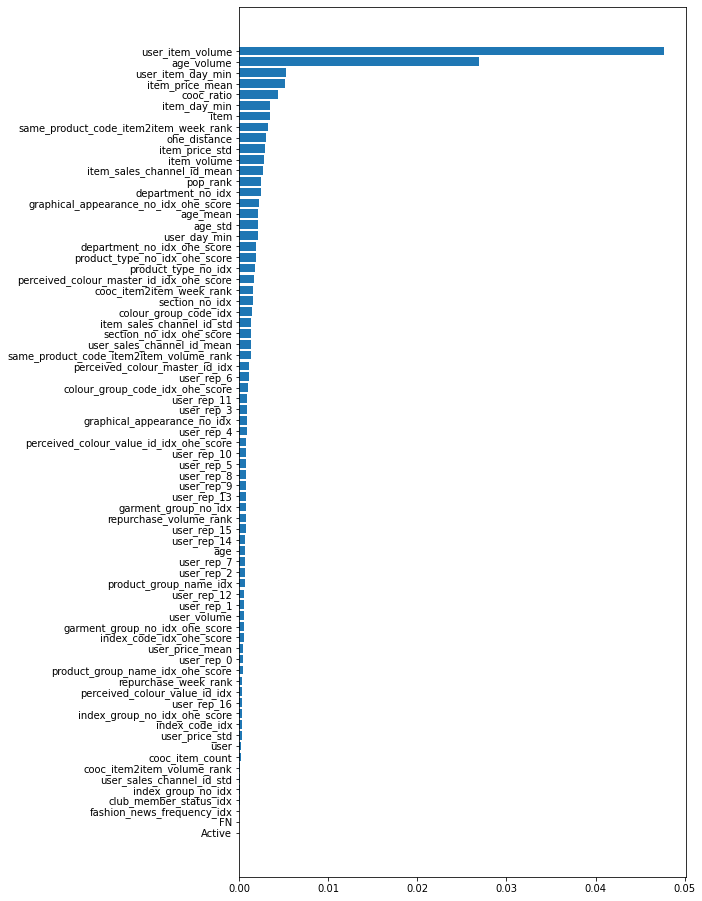

In [20]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [21]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

12067

In [22]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [23]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 5.987 s


[popular] 1.730 s


[item2item] 5.661 s


[cooccurrence] 60.671 s


[same_product_code] 7.099 s


[ohe distance] 19.350 s


volume: 28345386


duplicates: 1.0461865221269588


            strategy   volume     ratio
0  same_product_code  9190204  0.324222
1                pop  8231880  0.290413
2       ohe_distance  6412711  0.226235
3         repurchase  2735882  0.096519
4               cooc  1774709  0.062610


attach features (week: 0)


[user static fetaures] 2.464 s


[item stacic features] 7.274 s


[user dynamic features (transactions)] 6.810 s


[item dynamic features (transactions)] 4.099 s


[item dynamic features (user features)] 7.204 s


[item freshness features] 6.177 s


[item volume features] 4.629 s


[user freshness features] 8.224 s


[user volume features] 6.485 s


[user-item freshness features] 28.087 s


[user-item volume features] 13.099 s


[item age volume features] 7.627 s


[ohe dot products] 152.221 s


[lfm features] 14.382 s


chunk: 137198
create candidates (week: 0)


[repurchase] 6.185 s


[popular] 1.741 s


[item2item] 5.536 s


[cooccurrence] 59.892 s


[same_product_code] 6.735 s


[ohe distance] 13.412 s


volume: 28374732


duplicates: 1.0460232456393228


            strategy   volume     ratio
0  same_product_code  9210520  0.324603
1                pop  8231880  0.290113
2       ohe_distance  6409891  0.225901
3         repurchase  2752227  0.096996
4               cooc  1770214  0.062387


attach features (week: 0)


[user static fetaures] 2.423 s


[item stacic features] 7.136 s


[user dynamic features (transactions)] 7.002 s


[item dynamic features (transactions)] 4.053 s


[item dynamic features (user features)] 7.064 s


[item freshness features] 6.079 s


[item volume features] 4.658 s


[user freshness features] 8.127 s


[user volume features] 6.475 s


[user-item freshness features] 30.286 s


[user-item volume features] 13.146 s


[item age volume features] 7.614 s


[ohe dot products] 151.348 s


[lfm features] 12.633 s


chunk: 274396
create candidates (week: 0)


[repurchase] 6.071 s


[popular] 1.732 s


[item2item] 5.539 s


[cooccurrence] 59.850 s


[same_product_code] 6.858 s


[ohe distance] 13.660 s


volume: 28278742


duplicates: 1.0460196626414326


            strategy   volume     ratio
0  same_product_code  9167920  0.324198
1                pop  8231880  0.291098
2       ohe_distance  6412683  0.226767
3         repurchase  2708651  0.095784
4               cooc  1757608  0.062153


attach features (week: 0)


[user static fetaures] 2.451 s


[item stacic features] 7.237 s


[user dynamic features (transactions)] 6.908 s


[item dynamic features (transactions)] 4.233 s


[item dynamic features (user features)] 7.162 s


[item freshness features] 6.121 s


[item volume features] 4.659 s


[user freshness features] 8.266 s


[user volume features] 6.566 s


[user-item freshness features] 27.549 s


[user-item volume features] 13.147 s


[item age volume features] 7.630 s


[ohe dot products] 151.192 s


[lfm features] 15.071 s


chunk: 411594
create candidates (week: 0)


[repurchase] 5.796 s


[popular] 1.897 s


[item2item] 5.562 s


[cooccurrence] 59.406 s


[same_product_code] 6.913 s


[ohe distance] 13.756 s


volume: 28369446


duplicates: 1.0462360544926665


            strategy   volume     ratio
0  same_product_code  9204223  0.324441
1                pop  8231880  0.290167
2       ohe_distance  6411150  0.225988
3         repurchase  2737078  0.096480
4               cooc  1785115  0.062924


attach features (week: 0)


[user static fetaures] 2.457 s


[item stacic features] 7.235 s


[user dynamic features (transactions)] 6.997 s


[item dynamic features (transactions)] 4.075 s


[item dynamic features (user features)] 7.175 s


[item freshness features] 6.096 s


[item volume features] 4.645 s


[user freshness features] 8.264 s


[user volume features] 6.524 s


[user-item freshness features] 30.629 s


[user-item volume features] 12.665 s


[item age volume features] 7.647 s


[ohe dot products] 152.204 s


[lfm features] 13.319 s


chunk: 548792
create candidates (week: 0)


[repurchase] 5.910 s


[popular] 1.731 s


[item2item] 5.589 s


[cooccurrence] 59.412 s


[same_product_code] 6.908 s


[ohe distance] 13.622 s


volume: 28347117


duplicates: 1.046175695010873


            strategy   volume     ratio
0  same_product_code  9190841  0.324225
1                pop  8231880  0.290396
2       ohe_distance  6413390  0.226245
3         repurchase  2739307  0.096634
4               cooc  1771699  0.062500


attach features (week: 0)


[user static fetaures] 2.463 s


[item stacic features] 7.253 s


[user dynamic features (transactions)] 6.895 s


[item dynamic features (transactions)] 4.062 s


[item dynamic features (user features)] 7.236 s


[item freshness features] 6.133 s


[item volume features] 4.640 s


[user freshness features] 8.217 s


[user volume features] 6.452 s


[user-item freshness features] 27.788 s


[user-item volume features] 12.899 s


[item age volume features] 7.683 s


[ohe dot products] 152.112 s


[lfm features] 12.432 s


chunk: 685990
create candidates (week: 0)


[repurchase] 5.935 s


[popular] 1.729 s


[item2item] 5.595 s


[cooccurrence] 59.122 s


[same_product_code] 6.806 s


[ohe distance] 13.595 s


volume: 28420098


duplicates: 1.0464014866655516


            strategy   volume     ratio
0  same_product_code  9243785  0.325255
1                pop  8231880  0.289650
2       ohe_distance  6408989  0.225509
3         repurchase  2745003  0.096587
4               cooc  1790441  0.062999


attach features (week: 0)


[user static fetaures] 2.441 s


[item stacic features] 7.237 s


[user dynamic features (transactions)] 6.789 s


[item dynamic features (transactions)] 4.161 s


[item dynamic features (user features)] 7.139 s


[item freshness features] 5.980 s


[item volume features] 4.638 s


[user freshness features] 8.056 s


[user volume features] 6.507 s


[user-item freshness features] 31.478 s


[user-item volume features] 12.863 s


[item age volume features] 7.527 s


[ohe dot products] 154.603 s


[lfm features] 13.735 s


chunk: 823188
create candidates (week: 0)


[repurchase] 5.593 s


[popular] 1.752 s


[item2item] 5.501 s


[cooccurrence] 59.998 s


[same_product_code] 6.885 s


[ohe distance] 13.785 s


volume: 28307850


duplicates: 1.0464059159730266


            strategy   volume     ratio
0  same_product_code  9166138  0.323802
1                pop  8231880  0.290798
2       ohe_distance  6411560  0.226494
3         repurchase  2714357  0.095887
4               cooc  1783915  0.063018


attach features (week: 0)


[user static fetaures] 2.443 s


[item stacic features] 7.161 s


[user dynamic features (transactions)] 6.943 s


[item dynamic features (transactions)] 4.246 s


[item dynamic features (user features)] 7.160 s


[item freshness features] 6.099 s


[item volume features] 4.700 s


[user freshness features] 8.218 s


[user volume features] 6.669 s


[user-item freshness features] 27.030 s


[user-item volume features] 12.605 s


[item age volume features] 7.674 s


[ohe dot products] 153.607 s


[lfm features] 16.621 s


chunk: 960386
create candidates (week: 0)


[repurchase] 5.629 s


[popular] 1.751 s


[item2item] 5.540 s


[cooccurrence] 60.333 s


[same_product_code] 6.850 s


[ohe distance] 13.669 s


volume: 28337934


duplicates: 1.0465247784835954


            strategy   volume     ratio
0  same_product_code  9175200  0.323778
1                pop  8231880  0.290490
2       ohe_distance  6411573  0.226254
3         repurchase  2731902  0.096404
4               cooc  1787379  0.063074


attach features (week: 0)


[user static fetaures] 2.417 s


[item stacic features] 7.134 s


[user dynamic features (transactions)] 6.861 s


[item dynamic features (transactions)] 4.152 s


[item dynamic features (user features)] 7.125 s


[item freshness features] 5.972 s


[item volume features] 4.615 s


[user freshness features] 8.087 s


[user volume features] 6.508 s


[user-item freshness features] 27.317 s


[user-item volume features] 13.018 s


[item age volume features] 7.569 s


[ohe dot products] 151.768 s


[lfm features] 13.052 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 5.625 s


[popular] 1.736 s


[item2item] 5.502 s


[cooccurrence] 59.641 s


[same_product_code] 6.745 s


[ohe distance] 13.589 s


volume: 28255647


duplicates: 1.0459923270973184


            strategy   volume     ratio
0  same_product_code  9136160  0.323339
1                pop  8231880  0.291336
2       ohe_distance  6408148  0.226792
3         repurchase  2711285  0.095956
4               cooc  1768174  0.062578


attach features (week: 0)


[user static fetaures] 2.406 s


[item stacic features] 7.120 s


[user dynamic features (transactions)] 6.930 s


[item dynamic features (transactions)] 4.166 s


[item dynamic features (user features)] 7.144 s


[item freshness features] 6.009 s


[item volume features] 4.629 s


[user freshness features] 8.116 s


[user volume features] 6.547 s


[user-item freshness features] 27.297 s


[user-item volume features] 12.514 s


[item age volume features] 7.531 s


[ohe dot products] 150.827 s


[lfm features] 15.723 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 5.693 s


[popular] 1.724 s


[item2item] 5.562 s


[cooccurrence] 59.566 s


[same_product_code] 6.942 s


[ohe distance] 13.494 s


volume: 28338095


duplicates: 1.0462370776050711


            strategy   volume     ratio
0  same_product_code  9189583  0.324284
1                pop  8231880  0.290488
2       ohe_distance  6411401  0.226247
3         repurchase  2730747  0.096363
4               cooc  1774484  0.062618


attach features (week: 0)


[user static fetaures] 2.408 s


[item stacic features] 7.114 s


[user dynamic features (transactions)] 6.872 s


[item dynamic features (transactions)] 3.990 s


[item dynamic features (user features)] 7.108 s


[item freshness features] 5.961 s


[item volume features] 4.599 s


[user freshness features] 8.056 s


[user volume features] 6.475 s


[user-item freshness features] 27.166 s


[user-item volume features] 12.622 s


[item age volume features] 7.603 s


[ohe dot products] 152.026 s


[lfm features] 12.919 s


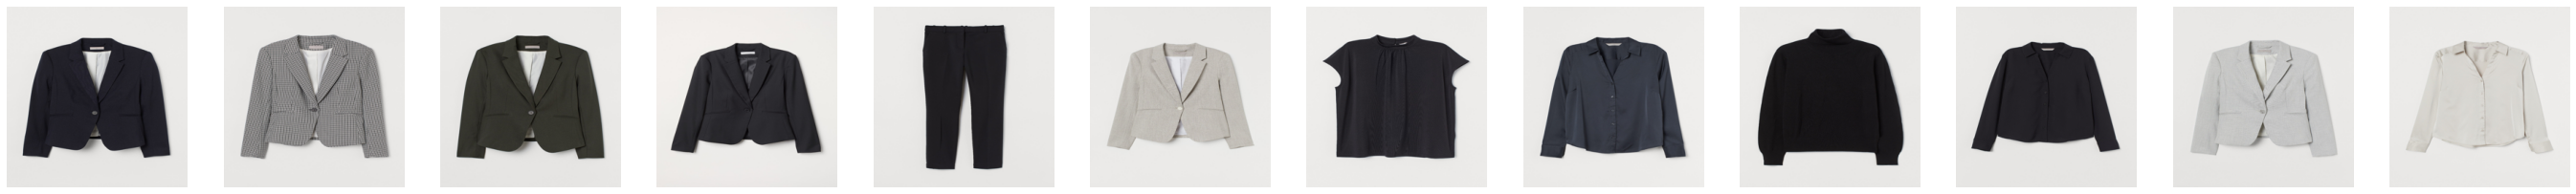

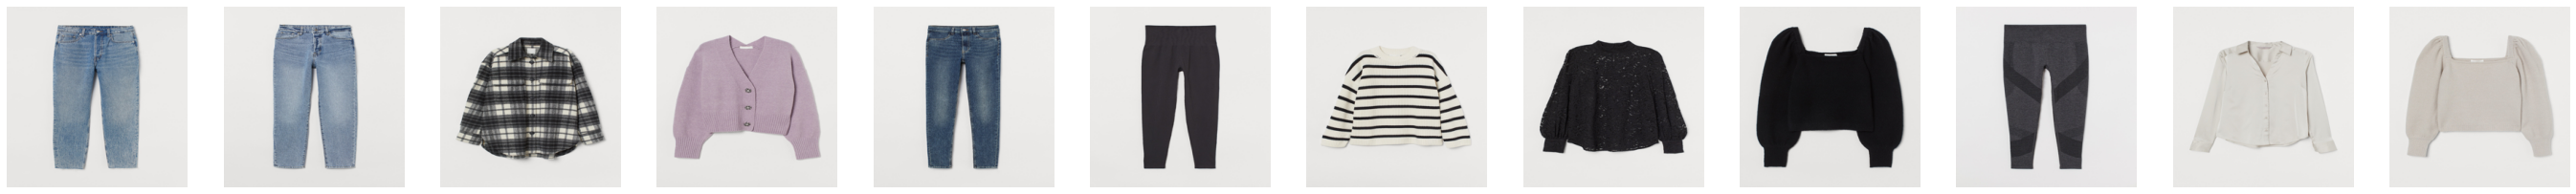

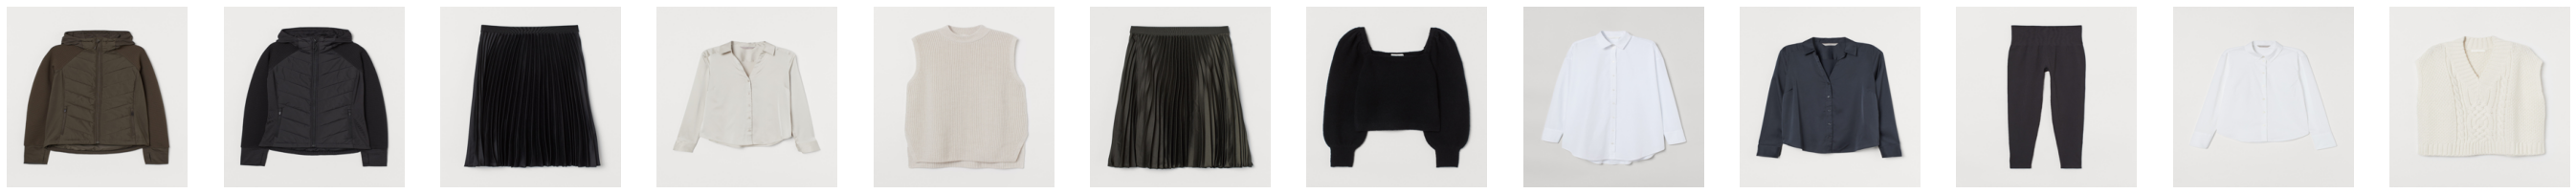

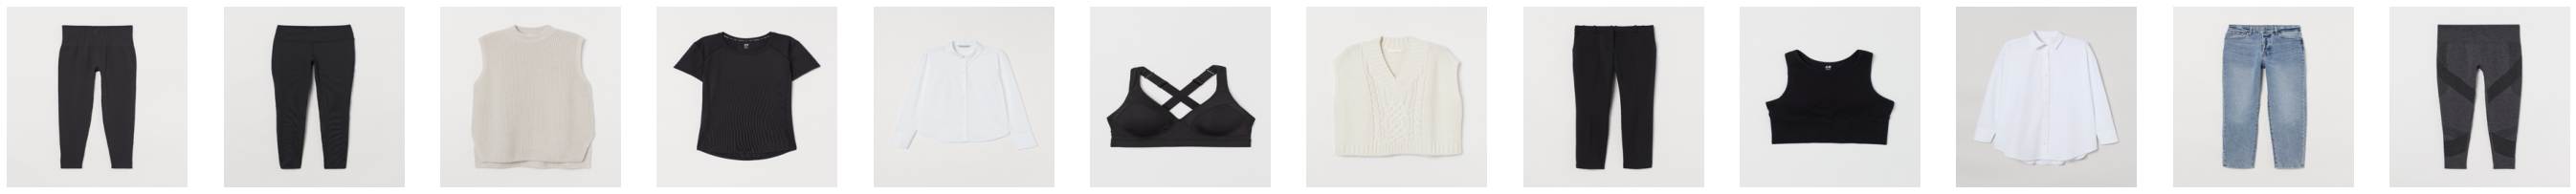

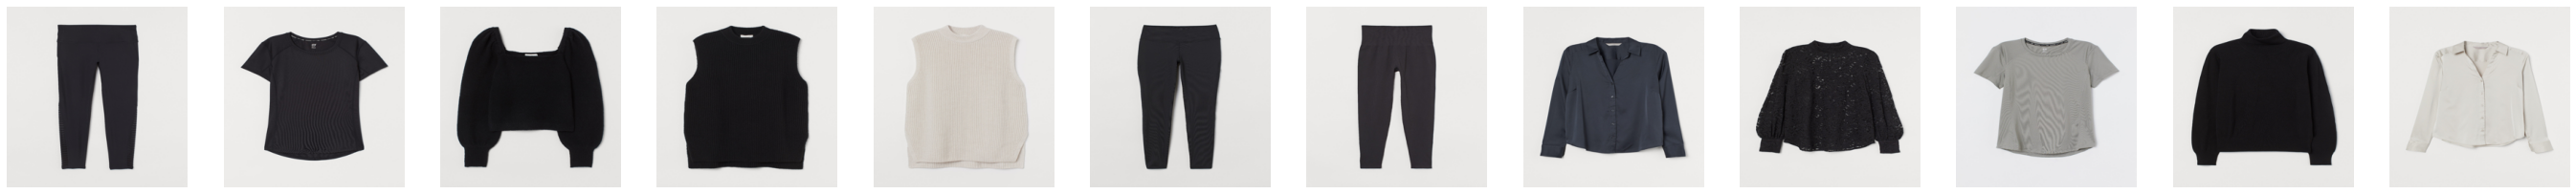

In [24]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [25]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601007 0568601044 0568601043 0568601006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0898692006 0896169005 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0851400001 0762846027 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866731001 0852584001 0924243001 0791587001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587001 0915529003 0924243002 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0791587001 0557599022 0791587015 0804992014 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846026 0762846006 0762846031 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846006 0762846031 0762846008 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0706016003 0714790028 08...


In [26]:
submission.to_csv('submission.csv', index=False)